In [1]:
import pandas as pd
import random

In [2]:
fileName="dataTrain.csv"
df=pd.read_csv(fileName, engine='python')

In [3]:
len(set(df["author"]))

45

In [4]:
set(df["author"])^set(range(1,51))

{5, 7, 31, 47, 49}

In [5]:
stopWords=[]

with open('lemur-stopwords.txt', 'r') as f:
   stopWords=f.readlines()

stopWords=set([i.strip() for i in stopWords])

In [6]:
def removeSW(x):
    ans=" ".join(i for i in x.split() if i not in stopWords)
    # No Error. Therefore no uppercase letters.
    #     if ans.lower()!=ans:
    #         raise RuntimeError
    return ans

In [7]:
df['text'] = df.apply(lambda df: removeSW(df["text"]), axis=1)

Text(0, 0.5, 'Number of documents')

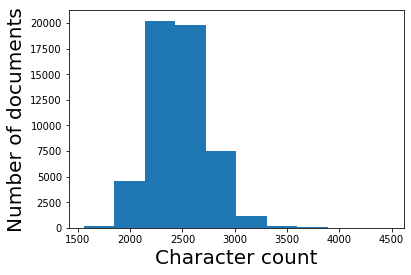

In [65]:
import matplotlib.pyplot as plt

plt.hist(df["text"].apply(len))
plt.xlabel("Character count", fontsize=20) 
plt.ylabel("Number of documents", fontsize=20)

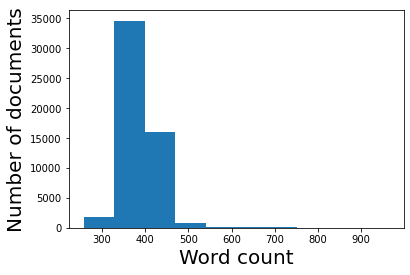

In [9]:
plt.hist(df["text"].apply(lambda x:len(x.split())))
plt.xlabel("Word count", fontsize=20) 
plt.ylabel("Number of documents", fontsize=20) 
plt.show()

In [10]:
dfTrain=df.sample(frac=0.8,random_state=0,axis=0)

In [11]:
dfTest=df[~df.index.isin(dfTrain.index)]

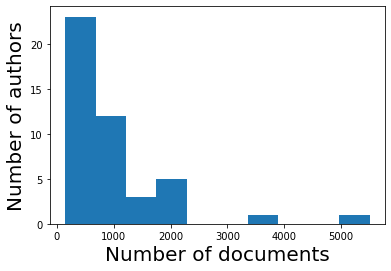

In [12]:
plt.hist(dfTrain.groupby("author").count())
plt.xlabel("Number of documents", fontsize=20) 
plt.ylabel("Number of authors", fontsize=20) 
plt.show()

In [13]:
dfTrain.groupby("author").count()

text
author      
1        732
2        307
3        173
4       1197
6        332
8       5499
9        888
10       596
11       312
12       500
13       390
14      2145
15      1151
16       148
17       534
18       859
19      1230
20       466
21      1872
22       395
23       365
24       288
25       919
26      3565
27       247
28       664
29       511
30       786
32       566
33      1422
34       346
35       533
36       543
37      1943
38       943
39      1804
40       330
41       738
42       829
43      1009
44       374
45      1837
46       480
48      1440
50       734

In [57]:
sum(dfTrain.groupby("author").count()["text"])

42942

In [14]:
max(dfTrain.groupby("author").count()["text"])/sum(dfTrain.groupby("author").count()["text"])

0.12805644823249965

In [15]:
# Divide the dataset into a training set & a test set

In [16]:
all(dfTrain.groupby("author").count()+dfTest.groupby("author").count()==df.groupby("author").count())

True

In [17]:
def initDict(df,dict_):
    dict_[hash(df['text'])]=df["author"]

In [18]:
dictTrain=dict()
dfTrain.apply(lambda df: initDict(df,dictTrain), axis=1)

dictTest=dict()
dfTest.apply(lambda df: initDict(df,dictTest), axis=1)

10       None
11       None
13       None
19       None
21       None
         ... 
53639    None
53640    None
53651    None
53654    None
53671    None
Length: 10736, dtype: object

In [19]:
len(dictTrain)==dfTrain.shape[0]

# No hash collision

True

In [20]:
dfTrain['text'].to_csv('metapy/metapy.dat', header=None, index=False, sep="\n")

In [21]:
dfTest['text'].to_csv('metapy/dfTest.txt', header=None, index=False, sep="\n")

In [22]:
import metapy

In [23]:
with open('metapy/tutorial.toml', 'w') as f:
    f.write('type = "line-corpus"\n')
    f.write('store-full-text = true\n')

config = """prefix = "." # tells MeTA where to search for datasets

dataset = "metapy" # a subfolder under the prefix directory
corpus = "tutorial.toml" # a configuration file for the corpus specifying its format & additional args

index = "metapy-idx" # subfolder of the current working directory to place index files

query-judgements = "metapy/dfTest.txt" # file containing the relevance judgments for this dataset

stop-words = "lemur-stopwords.txt"

[[analyzers]]
method = "ngram-word"
ngram = 1
filter = "default-unigram-chain"
"""
with open('covid_ir-config.toml', 'w') as f:
    f.write(config)

In [24]:
inv_idx = metapy.index.make_inverted_index('covid_ir-config.toml') 

In [25]:
ranker = metapy.index.OkapiBM25(k1 = 1.2, b = 0.5, k3 = 500)

In [26]:
num_results = 10
retrieval_results = []
with open('metapy/dfTest.txt',encoding="utf-8") as query_file:
    counter=0
    for query_num, line in enumerate(query_file):
        query = metapy.index.Document()
        query.content(line.strip())
#         print(query.content())
        
        x=dictTest[hash(query.content())]
        
        results = ranker.score(inv_idx, query, num_results)  
        res_list = [(query_num + 1, x[0]) for x in results]
        retrieval_results += res_list

        for num, (d_id, _) in enumerate(results):
            content = inv_idx.metadata(d_id).get('content')
#             print(dictTrain[hash(content)]==x)
        counter+=1
        
        if counter>10:
            break
        

In [61]:
num_results = 1
retrieval_correct_okapi = dict()
sampleSize=[5,10,25,50,100,200,5000]
for i in sampleSize:
    retrieval_correct_okapi[i]=[]
    
with open('metapy/dfTest.txt',encoding="utf-8") as query_file:
    for query_num, line in enumerate(query_file):
        query = metapy.index.Document()
        query.content(line.strip())

        trueLabel=dictTest[hash(query.content())]
        
        queryContent=query.content()
        queryContentContainer=queryContent.split()
        
        for j in sampleSize:
            max_pos = len(queryContentContainer)
            if max_pos<=j:
                pos=0
                # Otherwise random.randint(0,max_pos-j) is undefined, right bound can not be smaller than left bound
            else:
                pos=min(0,random.randint(0,max_pos-j))

            query = metapy.index.Document()
            query.content(" ".join(queryContentContainer[pos:min(pos+j,max_pos)]))
            results = ranker.score(inv_idx, query, num_results)  

            for num, (d_id, _) in enumerate(results):
                content = inv_idx.metadata(d_id).get('content')
                retrieval_correct_okapi[j].append(dictTrain[hash(content)]==trueLabel)        

In [62]:
plt_okapi={}
for i in retrieval_correct_okapi:
    plt_okapi[i]=[]
    counter=0
    for j in range(len(retrieval_correct_okapi[i])):
        counter+=retrieval_correct_okapi[i][j]
        plt_okapi[i].append(counter/(j+1))
    print(i,plt_okapi[i][-1])

5 0.30763493987135265
10 0.5268747088961342
25 0.6614811364694924
50 0.7578241430700448
100 0.8441691505216096
200 0.911978390461997
5000 0.955570044709389


In [63]:
len(retrieval_correct_okapi[5])

10727

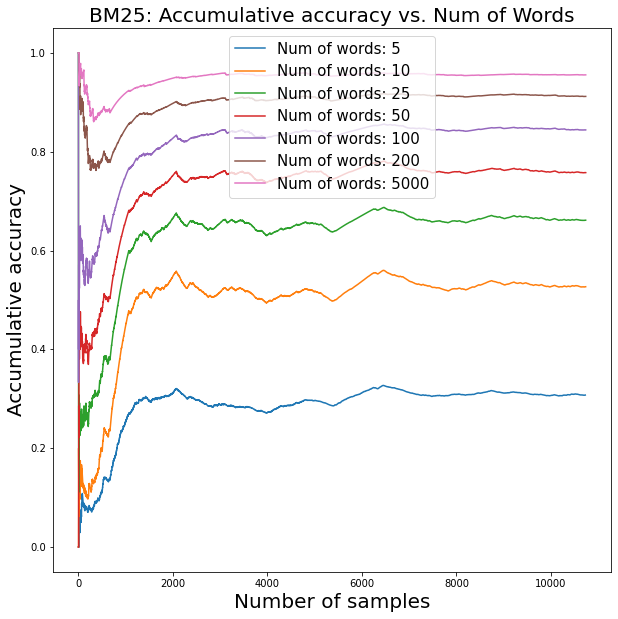

In [64]:
plt.figure(figsize=(10, 10))

for i in plt_okapi:
    plt.plot(range(len(retrieval_correct_okapi[i])),plt_okapi[i],label="Num of words: "+str(i))
  

plt.xlabel("Number of samples", fontsize=20) 
plt.ylabel("Accumulative accuracy", fontsize=20)
plt.title("BM25: Accumulative accuracy vs. Num of Words", fontsize=20)
plt.legend(loc = 9, fontsize=15)
plt.show()

In [30]:
import logging
from collections import defaultdict
from gensim import corpora,models,similarities
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [31]:
documents=[]
with open('metapy/metapy.dat', 'r',encoding="utf-8") as f:
   documents=f.readlines()

In [32]:
texts = [
    [word for word in document.split()]
    for document in documents
]

In [33]:
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

2020-12-15 15:03:50,203 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-12-15 15:03:54,391 : INFO : adding document #10000 to Dictionary(9649 unique tokens: ['abroad', 'accordingly', 'account', 'actually', 'administered']...)
2020-12-15 15:03:58,600 : INFO : adding document #20000 to Dictionary(9649 unique tokens: ['abroad', 'accordingly', 'account', 'actually', 'administered']...)
2020-12-15 15:04:02,808 : INFO : adding document #30000 to Dictionary(9649 unique tokens: ['abroad', 'accordingly', 'account', 'actually', 'administered']...)
2020-12-15 15:04:06,929 : INFO : adding document #40000 to Dictionary(9649 unique tokens: ['abroad', 'accordingly', 'account', 'actually', 'administered']...)
2020-12-15 15:04:08,173 : INFO : built Dictionary(9649 unique tokens: ['abroad', 'accordingly', 'account', 'actually', 'administered']...) from 42942 documents (total 16623493 corpus positions)


In [34]:
NumFeatures = 1000

In [35]:
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=NumFeatures)

2020-12-15 15:04:19,628 : INFO : using serial LSI version on this node
2020-12-15 15:04:19,629 : INFO : updating model with new documents
2020-12-15 15:04:19,630 : INFO : preparing a new chunk of documents
2020-12-15 15:04:20,849 : INFO : using 100 extra samples and 2 power iterations
2020-12-15 15:04:20,850 : INFO : 1st phase: constructing (9649, 1100) action matrix
2020-12-15 15:04:26,762 : INFO : orthonormalizing (9649, 1100) action matrix
2020-12-15 15:04:51,723 : INFO : 2nd phase: running dense svd on (1100, 20000) matrix
2020-12-15 15:04:57,996 : INFO : computing the final decomposition
2020-12-15 15:04:57,997 : INFO : keeping 1000 factors (discarding 1.053% of energy spectrum)
2020-12-15 15:04:58,451 : INFO : processed documents up to #20000
2020-12-15 15:04:58,455 : INFO : topic #0(2476.101): 0.752*"â" + 0.384*"s" + 0.220*"t" + 0.104*"man" + 0.082*"know" + 0.077*"time" + 0.075*"m" + 0.074*"did" + 0.072*"good" + 0.065*"d"
2020-12-15 15:04:58,456 : INFO : topic #1(1170.846): -0.6

In [38]:
queries=[]

with open('metapy/dfTest.txt', 'r', encoding="utf-8") as f:
   queries=f.readlines()

In [39]:
len(queries)

10736

In [40]:
index = similarities.MatrixSimilarity(lsi[corpus],num_features=NumFeatures)  # transform corpus to LSI space and index it

2020-12-15 15:23:28,689 : INFO : creating matrix with 42942 documents and 1000 features


In [41]:
retrieval_correct_LSI = dict()
sampleSize=[5,10,25,50,100,200,5000]
for i in sampleSize:
    retrieval_correct_LSI[i]=[]
    
    for doc in queries:
        trueLabel=dictTest[hash(doc.strip())]
        
        queryContainer = doc.split()
        max_pos = len(queryContainer)
        if max_pos<=i:
            pos=0
            # Otherwise random.randint(0,max_pos-j) is undefined, right bound can not be smaller than left bound
        else:
            pos=min(0,random.randint(0,max_pos-i))

        vec_bow = dictionary.doc2bow(queryContainer[pos:min(pos+i,max_pos)])
        vec_lsi = lsi[vec_bow]  # convert the query to LSI space
        # print(vec_lsi)

        sims = index[vec_lsi]  # perform a similarity query against the corpus

        sims = max(enumerate(sims), key=lambda item: item[1])

        print("sims:",sims)
        predLabel=dictTrain[hash(documents[sims[0]].strip())]
        print("Predict:",predLabel)
        retrieval_correct_LSI[i].append(predLabel==trueLabel)


sims: (29560, 0.30144885)
Predict: 18
sims: (38391, 0.40181556)
Predict: 12
sims: (41022, 0.28338328)
Predict: 4
sims: (22791, 0.5096278)
Predict: 15
sims: (34565, 0.39029086)
Predict: 8
sims: (22910, 0.3532477)
Predict: 4
sims: (20213, 0.33548552)
Predict: 16
sims: (26673, 0.3630851)
Predict: 44
sims: (9800, 0.33642262)
Predict: 37
sims: (18757, 0.44773945)
Predict: 45
sims: (30921, 0.40539008)
Predict: 50
sims: (24513, 0.5513091)
Predict: 8
sims: (35982, 0.33902836)
Predict: 36
sims: (7726, 0.28453857)
Predict: 22
sims: (11139, 0.3639885)
Predict: 45
sims: (11156, 0.47296277)
Predict: 21
sims: (24600, 0.6997937)
Predict: 10
sims: (39678, 0.22079463)
Predict: 8
sims: (2819, 0.42393073)
Predict: 45
sims: (35851, 0.5231657)
Predict: 43
sims: (7475, 0.5440362)
Predict: 43
sims: (38391, 0.40994614)
Predict: 12
sims: (35291, 0.528232)
Predict: 8
sims: (7914, 0.3959417)
Predict: 40
sims: (10006, 0.37527126)
Predict: 21
sims: (2062, 0.23432904)
Predict: 38
sims: (39956, 0.2149454)
Predict: 3

sims: (39807, 0.3510687)
Predict: 39
sims: (28257, 0.62713516)
Predict: 19
sims: (28550, 0.47153485)
Predict: 8
sims: (35033, 0.17373237)
Predict: 21
sims: (18278, 0.33030418)
Predict: 50
sims: (22503, 0.34254253)
Predict: 37
sims: (22981, 0.47686002)
Predict: 37
sims: (13907, 0.454183)
Predict: 37
sims: (36211, 0.48776537)
Predict: 23
sims: (21523, 0.46139696)
Predict: 8
sims: (14504, 0.22252661)
Predict: 22
sims: (10134, 0.43920746)
Predict: 37
sims: (8728, 0.37393087)
Predict: 9
sims: (12023, 0.383089)
Predict: 37
sims: (16161, 0.53010637)
Predict: 19
sims: (33311, 0.49454153)
Predict: 12
sims: (28257, 0.51828694)
Predict: 19
sims: (24343, 0.29692996)
Predict: 8
sims: (19638, 0.37111115)
Predict: 45
sims: (27070, 0.33165318)
Predict: 36
sims: (25824, 0.27365902)
Predict: 10
sims: (12459, 0.583431)
Predict: 22
sims: (18892, 0.47720578)
Predict: 43
sims: (19427, 0.31984827)
Predict: 4
sims: (22422, 0.90456563)
Predict: 29
sims: (8654, 0.53098696)
Predict: 50
sims: (23890, 0.35885316)


sims: (27958, 0.5994756)
Predict: 36
sims: (28379, 0.47503436)
Predict: 37
sims: (21770, 0.6120744)
Predict: 23
sims: (33800, 0.41261095)
Predict: 37
sims: (1360, 0.46000928)
Predict: 41
sims: (10450, 0.14650661)
Predict: 41
sims: (30634, 0.42459422)
Predict: 8
sims: (7226, 0.45882165)
Predict: 8
sims: (36945, 0.49762595)
Predict: 30
sims: (28280, 0.5925521)
Predict: 43
sims: (37068, 0.51316696)
Predict: 41
sims: (9536, 0.78375983)
Predict: 8
sims: (14900, 0.44434357)
Predict: 8
sims: (12213, 0.28445864)
Predict: 36
sims: (14652, 0.27382404)
Predict: 24
sims: (31867, 0.344724)
Predict: 26
sims: (40450, 0.4276124)
Predict: 8
sims: (5562, 0.33788204)
Predict: 28
sims: (19568, 0.2326414)
Predict: 35
sims: (19039, 0.37369418)
Predict: 29
sims: (25897, 0.58325666)
Predict: 33
sims: (17189, 0.4316097)
Predict: 1
sims: (961, 0.30551052)
Predict: 21
sims: (39067, 0.4231643)
Predict: 34
sims: (19891, 0.5203246)
Predict: 39
sims: (31839, 0.245765)
Predict: 35
sims: (1330, 0.63959754)
Predict: 50

sims: (25905, 0.49189326)
Predict: 3
sims: (27846, 0.511311)
Predict: 8
sims: (335, 0.7310831)
Predict: 33
sims: (22791, 0.5872721)
Predict: 15
sims: (21012, 0.41957355)
Predict: 30
sims: (25621, 0.44594643)
Predict: 15
sims: (24700, 0.37970608)
Predict: 26
sims: (24359, 0.42427304)
Predict: 8
sims: (36226, 0.3386078)
Predict: 23
sims: (6880, 0.48101455)
Predict: 8
sims: (39807, 0.44285703)
Predict: 39
sims: (21770, 0.61767304)
Predict: 23
sims: (35778, 0.33166757)
Predict: 19
sims: (26690, 0.42434037)
Predict: 21
sims: (10200, 0.27681106)
Predict: 26
sims: (23123, 0.72572726)
Predict: 33
sims: (30634, 0.4238431)
Predict: 8
sims: (38490, 0.6169081)
Predict: 21
sims: (15574, 0.1909132)
Predict: 21
sims: (39657, 0.37887102)
Predict: 9
sims: (15371, 0.6997402)
Predict: 14
sims: (20752, 0.37902546)
Predict: 50
sims: (37886, 0.34670457)
Predict: 8
sims: (24881, 0.37984443)
Predict: 43
sims: (35445, 0.58855605)
Predict: 8
sims: (30634, 0.58708084)
Predict: 8
sims: (9169, 0.54866433)
Predict:

Predict: 36
sims: (10006, 0.37007326)
Predict: 21
sims: (21770, 0.47811744)
Predict: 23
sims: (16127, 0.32509977)
Predict: 37
sims: (2693, 0.57214415)
Predict: 8
sims: (21638, 0.5184279)
Predict: 21
sims: (5233, 0.5476081)
Predict: 13
sims: (30921, 0.37851226)
Predict: 50
sims: (38357, 0.24283776)
Predict: 46
sims: (32867, 0.51833135)
Predict: 12
sims: (209, 0.5254109)
Predict: 2
sims: (21521, 0.41042557)
Predict: 8
sims: (21217, 0.39334387)
Predict: 24
sims: (24875, 0.5318235)
Predict: 28
sims: (29754, 0.37915477)
Predict: 8
sims: (30373, 0.6021283)
Predict: 15
sims: (33247, 0.2844551)
Predict: 26
sims: (19637, 0.38097787)
Predict: 22
sims: (40368, 0.59316874)
Predict: 39
sims: (21770, 0.6420348)
Predict: 23
sims: (871, 0.48055434)
Predict: 45
sims: (4857, 0.3832906)
Predict: 22
sims: (5103, 0.26404113)
Predict: 19
sims: (8728, 0.39904305)
Predict: 9
sims: (30921, 0.35023707)
Predict: 50
sims: (27806, 0.78343976)
Predict: 8
sims: (13061, 0.41717464)
Predict: 8
sims: (21770, 0.5984242)

sims: (16127, 0.40734333)
Predict: 37
sims: (16072, 0.46196055)
Predict: 21
sims: (38909, 0.5162006)
Predict: 12
sims: (33800, 0.40704587)
Predict: 37
sims: (37938, 0.49516615)
Predict: 17
sims: (19786, 0.47108564)
Predict: 21
sims: (40752, 0.6503757)
Predict: 22
sims: (29661, 0.38633907)
Predict: 22
sims: (10751, 0.2158387)
Predict: 4
sims: (37832, 0.3577891)
Predict: 37
sims: (1790, 0.54801506)
Predict: 8
sims: (16168, 0.5206303)
Predict: 36
sims: (39139, 0.55534905)
Predict: 8
sims: (10006, 0.4913469)
Predict: 21
sims: (25621, 0.32076412)
Predict: 15
sims: (36842, 0.7210338)
Predict: 24
sims: (30004, 0.58147025)
Predict: 34
sims: (10073, 0.2534892)
Predict: 22
sims: (30718, 0.38197544)
Predict: 26
sims: (13065, 0.29587638)
Predict: 14
sims: (36842, 0.41522467)
Predict: 24
sims: (21738, 0.3204382)
Predict: 13
sims: (1986, 0.3367585)
Predict: 21
sims: (38480, 0.40571946)
Predict: 23
sims: (37342, 0.5214281)
Predict: 48
sims: (5684, 0.6052599)
Predict: 33
sims: (25621, 0.5841914)
Predi

Predict: 14
sims: (24907, 0.25192586)
Predict: 21
sims: (31503, 0.27076113)
Predict: 8
sims: (35196, 0.24606231)
Predict: 18
sims: (2152, 0.58675563)
Predict: 8
sims: (25621, 0.4272879)
Predict: 15
sims: (21770, 0.6260041)
Predict: 23
sims: (28280, 0.6702048)
Predict: 43
sims: (21770, 0.88431746)
Predict: 23
sims: (21217, 0.42058033)
Predict: 24
sims: (33823, 0.3696563)
Predict: 10
sims: (31806, 0.3210518)
Predict: 26
sims: (16127, 0.26299524)
Predict: 37
sims: (1790, 0.54290503)
Predict: 8
sims: (25832, 0.45797038)
Predict: 12
sims: (26762, 0.40309078)
Predict: 22
sims: (30953, 0.3497033)
Predict: 37
sims: (15127, 0.5956047)
Predict: 8
sims: (37573, 0.3778646)
Predict: 29
sims: (5089, 0.41700256)
Predict: 22
sims: (21825, 0.5941619)
Predict: 8
sims: (41833, 0.4815593)
Predict: 8
sims: (19044, 0.88218504)
Predict: 19
sims: (8268, 0.3774302)
Predict: 8
sims: (26893, 0.32417995)
Predict: 37
sims: (22330, 0.26035517)
Predict: 28
sims: (3788, 0.39791888)
Predict: 21
sims: (37754, 0.4177744

sims: (1938, 0.35891742)
Predict: 25
sims: (2684, 0.27216876)
Predict: 37
sims: (23140, 0.4781257)
Predict: 50
sims: (18902, 0.3604722)
Predict: 14
sims: (18907, 0.34937125)
Predict: 39
sims: (40575, 0.42829737)
Predict: 15
sims: (22910, 0.52893806)
Predict: 4
sims: (36409, 0.31793827)
Predict: 50
sims: (33778, 0.7087733)
Predict: 20
sims: (35982, 0.4009819)
Predict: 36
sims: (24236, 0.5559194)
Predict: 45
sims: (33437, 0.34133014)
Predict: 10
sims: (34341, 0.52531415)
Predict: 12
sims: (10006, 0.64164877)
Predict: 21
sims: (25621, 0.37959868)
Predict: 15
sims: (29114, 0.26218396)
Predict: 22
sims: (7640, 0.45856076)
Predict: 8
sims: (1115, 0.52393985)
Predict: 8
sims: (19155, 0.6395436)
Predict: 33
sims: (40794, 0.40810573)
Predict: 8
sims: (38480, 0.68567765)
Predict: 23
sims: (7974, 0.5219161)
Predict: 8
sims: (23120, 0.36862412)
Predict: 15
sims: (17051, 0.28304917)
Predict: 43
sims: (15869, 0.18795219)
Predict: 41
sims: (20792, 0.3539472)
Predict: 8
sims: (31942, 0.596362)
Predict

sims: (23026, 0.33228338)
Predict: 8
sims: (2684, 0.38058478)
Predict: 37
sims: (21770, 0.5180701)
Predict: 23
sims: (16161, 0.4914238)
Predict: 19
sims: (39461, 0.8287531)
Predict: 11
sims: (31867, 0.44038048)
Predict: 26
sims: (10006, 0.3883649)
Predict: 21
sims: (14665, 0.46473265)
Predict: 8
sims: (33365, 0.42521304)
Predict: 34
sims: (36027, 0.38960516)
Predict: 48
sims: (34341, 0.38373005)
Predict: 12
sims: (4349, 0.29882175)
Predict: 37
sims: (13907, 0.434223)
Predict: 37
sims: (23942, 0.57445306)
Predict: 30
sims: (39994, 0.33606055)
Predict: 44
sims: (16837, 0.41432428)
Predict: 10
sims: (28280, 0.45098758)
Predict: 43
sims: (23120, 0.4475832)
Predict: 15
sims: (24676, 0.4669057)
Predict: 38
sims: (35331, 0.35912627)
Predict: 30
sims: (21770, 0.45965245)
Predict: 23
sims: (8749, 0.32414156)
Predict: 8
sims: (20372, 0.42847133)
Predict: 16
sims: (7702, 0.47446197)
Predict: 23
sims: (28257, 0.45208445)
Predict: 19
sims: (14789, 0.27314982)
Predict: 37
sims: (12537, 0.52755743)
P

sims: (6224, 0.49559587)
Predict: 40
sims: (33208, 0.48168913)
Predict: 35
sims: (30921, 0.47455972)
Predict: 50
sims: (7702, 0.46008766)
Predict: 23
sims: (30634, 0.44036695)
Predict: 8
sims: (1159, 0.5616164)
Predict: 8
sims: (33560, 0.1960926)
Predict: 14
sims: (20752, 0.57877403)
Predict: 50
sims: (13907, 0.5557019)
Predict: 37
sims: (90, 0.3635378)
Predict: 1
sims: (33831, 0.30566883)
Predict: 25
sims: (6671, 0.5588249)
Predict: 38
sims: (18643, 0.25943315)
Predict: 48
sims: (39062, 0.5290095)
Predict: 8
sims: (24378, 0.3054319)
Predict: 4
sims: (28280, 0.720593)
Predict: 43
sims: (38100, 0.45908302)
Predict: 30
sims: (14682, 0.26040685)
Predict: 15
sims: (37237, 0.28078786)
Predict: 11
sims: (29301, 0.5038391)
Predict: 41
sims: (36372, 0.3959714)
Predict: 37
sims: (25392, 0.41907716)
Predict: 14
sims: (18599, 0.43893936)
Predict: 28
sims: (31759, 0.4528121)
Predict: 25
sims: (20840, 0.30051512)
Predict: 21
sims: (15137, 0.38924322)
Predict: 25
sims: (2526, 0.38278213)
Predict: 10

sims: (21321, 0.29776186)
Predict: 19
sims: (4383, 0.37817857)
Predict: 8
sims: (959, 0.44404763)
Predict: 48
sims: (38988, 0.49056256)
Predict: 46
sims: (27437, 0.3597834)
Predict: 30
sims: (25282, 0.46600795)
Predict: 21
sims: (6671, 0.39433157)
Predict: 38
sims: (21770, 0.64624405)
Predict: 23
sims: (32698, 0.41944218)
Predict: 50
sims: (32698, 0.46839893)
Predict: 50
sims: (40769, 0.7991029)
Predict: 37
sims: (12318, 0.5172688)
Predict: 9
sims: (21523, 0.514565)
Predict: 8
sims: (38311, 0.3978881)
Predict: 14
sims: (8604, 0.3207064)
Predict: 18
sims: (22931, 0.6132021)
Predict: 50
sims: (27339, 0.57756287)
Predict: 45
sims: (1938, 0.48336482)
Predict: 25
sims: (18929, 0.53510153)
Predict: 8
sims: (9396, 0.39978522)
Predict: 26
sims: (41770, 0.41147164)
Predict: 37
sims: (17033, 0.43445504)
Predict: 34
sims: (12642, 0.2694286)
Predict: 39
sims: (22791, 0.70874476)
Predict: 15
sims: (19926, 0.46100414)
Predict: 24
sims: (7542, 0.41077948)
Predict: 19
sims: (15971, 0.6577705)
Predict:

sims: (19820, 0.4121704)
Predict: 21
sims: (22330, 0.31416103)
Predict: 28
sims: (31722, 0.65959024)
Predict: 37
sims: (25221, 0.45538965)
Predict: 15
sims: (42010, 0.36665148)
Predict: 42
sims: (21263, 0.4988544)
Predict: 36
sims: (28280, 0.5140037)
Predict: 43
sims: (25621, 0.5168606)
Predict: 15
sims: (10134, 0.4752766)
Predict: 37
sims: (26177, 0.43305892)
Predict: 11
sims: (5047, 0.47493184)
Predict: 37
sims: (6614, 0.36367604)
Predict: 21
sims: (244, 0.4599399)
Predict: 11
sims: (4981, 0.5551696)
Predict: 48
sims: (10748, 0.37692302)
Predict: 19
sims: (16161, 0.68797857)
Predict: 19
sims: (16491, 0.38901204)
Predict: 8
sims: (39390, 0.20568536)
Predict: 19
sims: (447, 0.5259971)
Predict: 19
sims: (26047, 0.6328616)
Predict: 8
sims: (354, 0.5378473)
Predict: 50
sims: (26177, 0.6147386)
Predict: 11
sims: (4135, 0.47037214)
Predict: 21
sims: (19317, 0.2563634)
Predict: 11
sims: (14143, 0.369803)
Predict: 14
sims: (29293, 0.43122363)
Predict: 21
sims: (2207, 0.42087996)
Predict: 22
s

sims: (39010, 0.40037185)
Predict: 24
sims: (2697, 0.5574355)
Predict: 29
sims: (21770, 0.5214708)
Predict: 23
sims: (38559, 0.408954)
Predict: 41
sims: (24315, 0.3893142)
Predict: 41
sims: (18907, 0.32871196)
Predict: 39
sims: (26897, 0.5201881)
Predict: 33
sims: (11231, 0.35515267)
Predict: 43
sims: (23502, 0.45758092)
Predict: 12
sims: (23626, 0.42676255)
Predict: 41
sims: (21770, 0.49628228)
Predict: 23
sims: (19267, 0.6737885)
Predict: 33
sims: (19926, 0.52994716)
Predict: 24
sims: (28280, 0.5860823)
Predict: 43
sims: (21770, 0.5639118)
Predict: 23
sims: (3762, 0.49262118)
Predict: 26
sims: (28821, 0.3095888)
Predict: 24
sims: (28280, 0.57428294)
Predict: 43
sims: (22503, 0.32468134)
Predict: 37
sims: (31349, 0.40671164)
Predict: 14
sims: (7569, 0.26792413)
Predict: 1
sims: (25706, 0.28890592)
Predict: 21
sims: (41227, 0.58674693)
Predict: 33
sims: (28280, 0.7580817)
Predict: 43
sims: (25455, 0.5317373)
Predict: 37
sims: (18907, 0.36061448)
Predict: 39
sims: (33703, 0.539027)
Pred

sims: (39595, 0.38045716)
Predict: 3
sims: (871, 0.5909798)
Predict: 45
sims: (14036, 0.53655314)
Predict: 21
sims: (8461, 0.3864376)
Predict: 8
sims: (3788, 0.38572013)
Predict: 21
sims: (27915, 0.5665674)
Predict: 33
sims: (21770, 0.63788337)
Predict: 23
sims: (40752, 0.45156813)
Predict: 22
sims: (23853, 0.6114274)
Predict: 36
sims: (37105, 0.5515334)
Predict: 26
sims: (10791, 0.71989524)
Predict: 48
sims: (38140, 0.57313335)
Predict: 8
sims: (7264, 0.4590463)
Predict: 8
sims: (10006, 0.37320977)
Predict: 21
sims: (14731, 0.34148106)
Predict: 22
sims: (34480, 0.40778494)
Predict: 39
sims: (32110, 0.35751626)
Predict: 21
sims: (37654, 0.79581034)
Predict: 45
sims: (21770, 0.5388824)
Predict: 23
sims: (16052, 0.29980645)
Predict: 26
sims: (7338, 0.42389405)
Predict: 30
sims: (39807, 0.70157737)
Predict: 39
sims: (14218, 0.5122266)
Predict: 12
sims: (7891, 0.47309005)
Predict: 33
sims: (4006, 0.40317875)
Predict: 37
sims: (7689, 0.3369565)
Predict: 22
sims: (16778, 0.58609545)
Predict:

sims: (10856, 0.38504532)
Predict: 8
sims: (34341, 0.44422013)
Predict: 12
sims: (159, 0.3810491)
Predict: 23
sims: (35357, 0.21428698)
Predict: 50
sims: (7557, 0.3262506)
Predict: 15
sims: (26699, 0.3465566)
Predict: 1
sims: (37112, 0.549914)
Predict: 15
sims: (16072, 0.36267048)
Predict: 21
sims: (37449, 0.3630062)
Predict: 22
sims: (37125, 0.3849306)
Predict: 11
sims: (30358, 0.6787194)
Predict: 21
sims: (9800, 0.2475377)
Predict: 37
sims: (19044, 0.63600135)
Predict: 19
sims: (2741, 0.554062)
Predict: 11
sims: (14333, 0.48085916)
Predict: 41
sims: (11104, 0.41666085)
Predict: 16
sims: (13907, 0.53805745)
Predict: 37
sims: (15409, 0.3892163)
Predict: 8
sims: (18278, 0.4022826)
Predict: 50
sims: (9111, 0.34433496)
Predict: 19
sims: (9592, 0.514855)
Predict: 19
sims: (22767, 0.44488585)
Predict: 22
sims: (27894, 0.42912775)
Predict: 50
sims: (13555, 0.63179165)
Predict: 28
sims: (23528, 0.35080987)
Predict: 37
sims: (7557, 0.43135405)
Predict: 15
sims: (24875, 0.35495365)
Predict: 28


sims: (21770, 0.70466346)
Predict: 23
sims: (10006, 0.33863604)
Predict: 21
sims: (28257, 0.5124942)
Predict: 19
sims: (20692, 0.4055446)
Predict: 8
sims: (42671, 0.5200557)
Predict: 33
sims: (28003, 0.34635878)
Predict: 19
sims: (27650, 0.31697476)
Predict: 12
sims: (26893, 0.6089785)
Predict: 37
sims: (33208, 0.37996244)
Predict: 35
sims: (41463, 0.49766555)
Predict: 37
sims: (34341, 0.44822764)
Predict: 12
sims: (15971, 0.53663266)
Predict: 26
sims: (9629, 0.46515197)
Predict: 37
sims: (36900, 0.28023517)
Predict: 26
sims: (34390, 0.5192205)
Predict: 21
sims: (29114, 0.31809926)
Predict: 22
sims: (1348, 0.5521672)
Predict: 41
sims: (22748, 0.5952958)
Predict: 37
sims: (28623, 0.28409445)
Predict: 8
sims: (3691, 0.5291905)
Predict: 45
sims: (39704, 0.3056556)
Predict: 21
sims: (24725, 0.33624834)
Predict: 13
sims: (22910, 0.3535968)
Predict: 4
sims: (1653, 0.40313172)
Predict: 41
sims: (15137, 0.4445651)
Predict: 25
sims: (9197, 0.48713362)
Predict: 37
sims: (42261, 0.21867114)
Predi

sims: (28244, 0.40591088)
Predict: 44
sims: (19092, 0.41546944)
Predict: 18
sims: (28280, 0.49833864)
Predict: 43
sims: (19044, 0.5594757)
Predict: 19
sims: (27806, 0.5359265)
Predict: 8
sims: (10336, 0.645985)
Predict: 21
sims: (30921, 0.3149109)
Predict: 50
sims: (32449, 0.45401147)
Predict: 41
sims: (30004, 0.46725783)
Predict: 34
sims: (8377, 0.3283069)
Predict: 48
sims: (21770, 0.56543225)
Predict: 23
sims: (18578, 0.22414719)
Predict: 21
sims: (21349, 0.83802986)
Predict: 8
sims: (35563, 0.84644186)
Predict: 43
sims: (20876, 0.4121185)
Predict: 37
sims: (10875, 0.55582476)
Predict: 16
sims: (8126, 0.5688409)
Predict: 46
sims: (25905, 0.45464274)
Predict: 3
sims: (35893, 0.2122728)
Predict: 11
sims: (38714, 0.2723477)
Predict: 29
sims: (11741, 0.3524703)
Predict: 39
sims: (22422, 0.8555064)
Predict: 29
sims: (21770, 0.6819567)
Predict: 23
sims: (35982, 0.5484864)
Predict: 36
sims: (8296, 0.33075762)
Predict: 43
sims: (19926, 0.52070355)
Predict: 24
sims: (40429, 0.32587045)
Predic

sims: (32601, 0.3699395)
Predict: 21
sims: (22791, 0.70774585)
Predict: 15
sims: (24315, 0.39754525)
Predict: 41
sims: (36022, 0.6645974)
Predict: 21
sims: (24315, 0.4429266)
Predict: 41
sims: (38559, 0.37522864)
Predict: 41
sims: (34325, 0.36652765)
Predict: 36
sims: (37569, 0.37143493)
Predict: 50
sims: (29114, 0.34795347)
Predict: 22
sims: (8747, 0.34569222)
Predict: 8
sims: (16981, 0.39624748)
Predict: 21
sims: (23699, 0.4384112)
Predict: 8
sims: (37254, 0.40825084)
Predict: 37
sims: (21770, 0.5120305)
Predict: 23
sims: (16471, 0.39494085)
Predict: 43
sims: (34565, 0.36354303)
Predict: 8
sims: (2317, 0.42377812)
Predict: 15
sims: (3096, 0.30702823)
Predict: 4
sims: (8576, 0.41139913)
Predict: 28
sims: (7557, 0.38431406)
Predict: 15
sims: (21770, 0.60688365)
Predict: 23
sims: (28890, 0.45394182)
Predict: 37
sims: (8851, 0.2412338)
Predict: 24
sims: (2932, 0.3514228)
Predict: 27
sims: (4405, 0.18530999)
Predict: 37
sims: (21770, 0.56436133)
Predict: 23
sims: (27209, 0.46194234)
Predi

sims: (3736, 0.5396435)
Predict: 37
sims: (19044, 0.9448639)
Predict: 19
sims: (19044, 0.81680083)
Predict: 19
sims: (1164, 0.4463365)
Predict: 37
sims: (2761, 0.44376856)
Predict: 28
sims: (31250, 0.6129799)
Predict: 48
sims: (2549, 0.4378943)
Predict: 30
sims: (39371, 0.32198763)
Predict: 8
sims: (21521, 0.34488928)
Predict: 8
sims: (12778, 0.2914818)
Predict: 43
sims: (37702, 0.24096975)
Predict: 18
sims: (30111, 0.6870867)
Predict: 48
sims: (39406, 0.20238867)
Predict: 11
sims: (47, 0.5041797)
Predict: 21
sims: (40148, 0.47155514)
Predict: 37
sims: (27433, 0.30735618)
Predict: 37
sims: (13089, 0.47843152)
Predict: 23
sims: (252, 0.58798313)
Predict: 23
sims: (28379, 0.74399245)
Predict: 37
sims: (25509, 0.39716864)
Predict: 48
sims: (39994, 0.3287655)
Predict: 44
sims: (27163, 0.21551314)
Predict: 41
sims: (37754, 0.50705814)
Predict: 37
sims: (34249, 0.77766997)
Predict: 19
sims: (24562, 0.38233915)
Predict: 6
sims: (31759, 0.5359017)
Predict: 25
sims: (36027, 0.51366067)
Predict:

sims: (7001, 0.60363036)
Predict: 45
sims: (14682, 0.36733234)
Predict: 15
sims: (871, 0.57715845)
Predict: 45
sims: (19044, 0.82393193)
Predict: 19
sims: (26886, 0.39306223)
Predict: 50
sims: (16593, 0.5061061)
Predict: 3
sims: (40429, 0.13388146)
Predict: 37
sims: (29448, 0.37468338)
Predict: 41
sims: (5268, 0.38575345)
Predict: 21
sims: (13907, 0.40579444)
Predict: 37
sims: (18626, 0.24432603)
Predict: 21
sims: (23270, 0.52341646)
Predict: 25
sims: (32921, 0.60351163)
Predict: 11
sims: (37237, 0.41061875)
Predict: 11
sims: (33149, 0.2118727)
Predict: 23
sims: (20539, 0.32583547)
Predict: 37
sims: (2761, 0.36767456)
Predict: 28
sims: (10006, 0.51376736)
Predict: 21
sims: (7471, 0.7902367)
Predict: 33
sims: (14706, 0.43169844)
Predict: 43
sims: (15810, 0.4029383)
Predict: 37
sims: (26690, 0.37676036)
Predict: 21
sims: (19597, 0.54780173)
Predict: 8
sims: (14693, 0.55829096)
Predict: 23
sims: (36022, 0.6182623)
Predict: 21
sims: (23270, 0.34588376)
Predict: 25
sims: (1511, 0.40908304)


sims: (6109, 0.4073104)
Predict: 21
sims: (17361, 0.36809793)
Predict: 21
sims: (37686, 0.4970256)
Predict: 45
sims: (41995, 0.2669747)
Predict: 37
sims: (5562, 0.35230285)
Predict: 28
sims: (38575, 0.7029376)
Predict: 44
sims: (454, 0.5963761)
Predict: 29
sims: (10134, 0.49656284)
Predict: 37
sims: (41193, 0.38215047)
Predict: 22
sims: (11121, 0.31430352)
Predict: 8
sims: (29040, 0.18576944)
Predict: 21
sims: (33365, 0.4027497)
Predict: 34
sims: (19266, 0.61775744)
Predict: 39
sims: (41238, 0.4587009)
Predict: 18
sims: (16157, 0.3988703)
Predict: 45
sims: (3855, 0.28747618)
Predict: 36
sims: (28762, 0.64941764)
Predict: 20
sims: (38890, 0.44445997)
Predict: 8
sims: (475, 0.36776617)
Predict: 8
sims: (2973, 0.40338197)
Predict: 28
sims: (29560, 0.45467985)
Predict: 18
sims: (38176, 0.37256512)
Predict: 12
sims: (17363, 0.37688002)
Predict: 28
sims: (7895, 0.37698394)
Predict: 4
sims: (42938, 0.33702946)
Predict: 25
sims: (11394, 0.7103778)
Predict: 21
sims: (24907, 0.3774888)
Predict: 

sims: (19427, 0.4506144)
Predict: 4
sims: (16161, 0.53194815)
Predict: 19
sims: (41837, 0.50454736)
Predict: 21
sims: (19092, 0.3524143)
Predict: 18
sims: (13298, 0.29358053)
Predict: 20
sims: (13907, 0.47369525)
Predict: 37
sims: (26690, 0.42016816)
Predict: 21
sims: (27559, 0.36092582)
Predict: 22
sims: (1938, 0.49201316)
Predict: 25
sims: (37385, 0.34955668)
Predict: 39
sims: (26758, 0.52059686)
Predict: 39
sims: (21217, 0.51061213)
Predict: 24
sims: (16008, 0.6330743)
Predict: 9
sims: (30921, 0.49929067)
Predict: 50
sims: (19044, 0.7280184)
Predict: 19
sims: (30442, 0.44676697)
Predict: 41
sims: (27720, 0.36796087)
Predict: 37
sims: (37593, 0.24659401)
Predict: 8
sims: (5500, 0.44719514)
Predict: 16
sims: (33800, 0.44497395)
Predict: 37
sims: (40148, 0.40482575)
Predict: 37
sims: (9885, 0.33248657)
Predict: 39
sims: (21655, 0.5850364)
Predict: 19
sims: (10006, 0.44919646)
Predict: 21
sims: (23350, 0.3814705)
Predict: 21
sims: (39067, 0.4968566)
Predict: 34
sims: (10756, 0.5440988)


sims: (28161, 0.48294467)
Predict: 50
sims: (18315, 0.18843275)
Predict: 48
sims: (14036, 0.5523897)
Predict: 21
sims: (28339, 0.5223637)
Predict: 11
sims: (10213, 0.547596)
Predict: 21
sims: (13854, 0.270605)
Predict: 11
sims: (11125, 0.35882366)
Predict: 11
sims: (42407, 0.34651637)
Predict: 22
sims: (13771, 0.3511349)
Predict: 19
sims: (18545, 0.45707852)
Predict: 21
sims: (42938, 0.40388328)
Predict: 25
sims: (24647, 0.3422867)
Predict: 37
sims: (28379, 0.42146438)
Predict: 37
sims: (28379, 0.7587199)
Predict: 37
sims: (19044, 0.9709055)
Predict: 19
sims: (9943, 0.3772701)
Predict: 3
sims: (32110, 0.3345225)
Predict: 21
sims: (21923, 0.24881059)
Predict: 43
sims: (36211, 0.6651363)
Predict: 23
sims: (36945, 0.42579734)
Predict: 30
sims: (18766, 0.39518154)
Predict: 48
sims: (32110, 0.38356897)
Predict: 21
sims: (20336, 0.25887844)
Predict: 21
sims: (18907, 0.37616223)
Predict: 39
sims: (475, 0.4263294)
Predict: 8
sims: (12639, 0.24970022)
Predict: 36
sims: (8268, 0.38654828)
Predic

sims: (3087, 0.57790244)
Predict: 45
sims: (19427, 0.30783534)
Predict: 4
sims: (20966, 0.3933211)
Predict: 8
sims: (18848, 0.49077117)
Predict: 13
sims: (454, 0.82600486)
Predict: 29
sims: (25621, 0.3728452)
Predict: 15
sims: (30338, 0.41015762)
Predict: 16
sims: (19092, 0.40218246)
Predict: 18
sims: (10006, 0.47276992)
Predict: 21
sims: (39812, 0.2949504)
Predict: 1
sims: (24241, 0.34497112)
Predict: 43
sims: (28257, 0.5181227)
Predict: 19
sims: (39807, 0.4716735)
Predict: 39
sims: (10756, 0.5994054)
Predict: 14
sims: (17432, 0.32009953)
Predict: 26
sims: (30054, 0.5833844)
Predict: 8
sims: (27720, 0.30042818)
Predict: 37
sims: (42671, 0.6092786)
Predict: 33
sims: (1555, 0.36390734)
Predict: 25
sims: (19597, 0.44087905)
Predict: 8
sims: (27720, 0.385913)
Predict: 37
sims: (14353, 0.6263455)
Predict: 15
sims: (10006, 0.44042432)
Predict: 21
sims: (8182, 0.36100072)
Predict: 22
sims: (30338, 0.42490596)
Predict: 16
sims: (11231, 0.3422101)
Predict: 43
sims: (10134, 0.66034234)
Predict:

sims: (25621, 0.4281605)
Predict: 15
sims: (21638, 0.44882536)
Predict: 21
sims: (9121, 0.33190626)
Predict: 22
sims: (17445, 0.5921514)
Predict: 6
sims: (36945, 0.33348346)
Predict: 30
sims: (14353, 0.49811065)
Predict: 15
sims: (22910, 0.3171916)
Predict: 4
sims: (20973, 0.22548474)
Predict: 21
sims: (27806, 0.47404677)
Predict: 8
sims: (23407, 0.5245472)
Predict: 1
sims: (2285, 0.59214747)
Predict: 26
sims: (31759, 0.5495248)
Predict: 25
sims: (28280, 0.5535365)
Predict: 43
sims: (2093, 0.519403)
Predict: 32
sims: (1803, 0.31837934)
Predict: 15
sims: (38978, 0.37878782)
Predict: 26
sims: (5705, 0.579232)
Predict: 33
sims: (12459, 0.39519203)
Predict: 22
sims: (5955, 0.37320697)
Predict: 23
sims: (32464, 0.35396075)
Predict: 46
sims: (20217, 0.2512888)
Predict: 26
sims: (1297, 0.42877984)
Predict: 43
sims: (28257, 0.5208114)
Predict: 19
sims: (28257, 0.51962876)
Predict: 19
sims: (19044, 0.73056376)
Predict: 19
sims: (14731, 0.36033183)
Predict: 22
sims: (21, 0.349088)
Predict: 40
si

sims: (15588, 0.38352996)
Predict: 8
sims: (23120, 0.44487375)
Predict: 15
sims: (32014, 0.37006456)
Predict: 22
sims: (31002, 0.32448077)
Predict: 44
sims: (20868, 0.42810708)
Predict: 26
sims: (19510, 0.39859688)
Predict: 4
sims: (31381, 0.42727134)
Predict: 18
sims: (159, 0.37522182)
Predict: 23
sims: (1179, 0.4394439)
Predict: 8
sims: (10498, 0.5258986)
Predict: 38
sims: (39461, 0.40133867)
Predict: 11
sims: (38058, 0.21031281)
Predict: 17
sims: (35023, 0.5689353)
Predict: 8
sims: (37385, 0.38533086)
Predict: 39
sims: (15588, 0.6477096)
Predict: 8
sims: (40165, 0.52169776)
Predict: 8
sims: (10006, 0.53914666)
Predict: 21
sims: (28585, 0.62256384)
Predict: 41
sims: (16837, 0.46213534)
Predict: 10
sims: (36226, 0.42669007)
Predict: 23
sims: (3671, 0.30025923)
Predict: 40
sims: (3412, 0.31427085)
Predict: 46
sims: (27928, 0.42127138)
Predict: 28
sims: (14995, 0.3820011)
Predict: 21
sims: (7569, 0.46613252)
Predict: 1
sims: (29114, 0.35447335)
Predict: 22
sims: (26189, 0.5220144)
Predi

sims: (23422, 0.3129785)
Predict: 26
sims: (19427, 0.28052148)
Predict: 4
sims: (4857, 0.35869884)
Predict: 22
sims: (35234, 0.3742804)
Predict: 28
sims: (19804, 0.22844177)
Predict: 14
sims: (29114, 0.42404652)
Predict: 22
sims: (15179, 0.20255375)
Predict: 26
sims: (36842, 0.37757713)
Predict: 24
sims: (32630, 0.36074135)
Predict: 41
sims: (38454, 0.35662425)
Predict: 44
sims: (29661, 0.38968584)
Predict: 22
sims: (31160, 0.38819462)
Predict: 37
sims: (25905, 0.45285106)
Predict: 3
sims: (25621, 0.41903737)
Predict: 15
sims: (13450, 0.48318213)
Predict: 8
sims: (8270, 0.29521716)
Predict: 21
sims: (32041, 0.6878624)
Predict: 33
sims: (13228, 0.39280474)
Predict: 15
sims: (23120, 0.36137378)
Predict: 15
sims: (28257, 0.4613067)
Predict: 19
sims: (29738, 0.37888098)
Predict: 26
sims: (11393, 0.40549976)
Predict: 8
sims: (10006, 0.6402433)
Predict: 21
sims: (22913, 0.43389428)
Predict: 8
sims: (9209, 0.42498094)
Predict: 6
sims: (35727, 0.48561594)
Predict: 26
sims: (20372, 0.3412561)
P

sims: (18907, 0.53952444)
Predict: 39
sims: (21686, 0.41448513)
Predict: 26
sims: (34164, 0.31682438)
Predict: 22
sims: (40752, 0.3532098)
Predict: 22
sims: (10154, 0.45874107)
Predict: 8
sims: (26540, 0.46819612)
Predict: 16
sims: (22378, 0.5291126)
Predict: 33
sims: (18917, 0.5026205)
Predict: 8
sims: (28257, 0.5024606)
Predict: 19
sims: (21638, 0.49458945)
Predict: 21
sims: (21770, 0.78428614)
Predict: 23
sims: (21019, 0.5891973)
Predict: 45
sims: (4028, 0.49607497)
Predict: 48
sims: (30263, 0.27742565)
Predict: 26
sims: (13401, 0.3459533)
Predict: 8
sims: (24359, 0.43255663)
Predict: 8
sims: (4857, 0.47633955)
Predict: 22
sims: (36531, 0.38137788)
Predict: 8
sims: (31512, 0.53954214)
Predict: 8
sims: (33035, 0.41665563)
Predict: 11
sims: (28257, 0.82580364)
Predict: 19
sims: (15588, 0.46202338)
Predict: 8
sims: (21770, 0.7287425)
Predict: 23
sims: (10593, 0.56872404)
Predict: 37
sims: (11394, 0.6328974)
Predict: 21
sims: (28986, 0.5224998)
Predict: 35
sims: (12778, 0.36318144)
Pred

Predict: 8
sims: (16253, 0.34449187)
Predict: 8
sims: (39293, 0.4185598)
Predict: 27
sims: (34925, 0.19940355)
Predict: 4
sims: (7557, 0.37338948)
Predict: 15
sims: (454, 0.80733275)
Predict: 29
sims: (25621, 0.43630582)
Predict: 15
sims: (21770, 0.7207146)
Predict: 23
sims: (26652, 0.4307465)
Predict: 10
sims: (30442, 0.4156885)
Predict: 41
sims: (26673, 0.36743605)
Predict: 44
sims: (17995, 0.25156325)
Predict: 39
sims: (28280, 0.577912)
Predict: 43
sims: (10993, 0.8580237)
Predict: 50
sims: (19044, 0.6972977)
Predict: 19
sims: (21770, 0.5451133)
Predict: 23
sims: (40724, 0.55265605)
Predict: 43
sims: (16597, 0.49829617)
Predict: 33
sims: (34256, 0.33053693)
Predict: 48
sims: (18643, 0.2910632)
Predict: 48
sims: (21770, 0.52081835)
Predict: 23
sims: (12849, 0.37768555)
Predict: 37
sims: (10134, 0.46261388)
Predict: 37
sims: (15718, 0.45317557)
Predict: 23
sims: (4400, 0.51656747)
Predict: 10
sims: (19044, 0.83078384)
Predict: 19
sims: (10932, 0.41400135)
Predict: 15
sims: (20966, 0.6

Predict: 33
sims: (28257, 0.56533104)
Predict: 19
sims: (19044, 0.9946188)
Predict: 19
sims: (38211, 0.29461777)
Predict: 45
sims: (31847, 0.38469243)
Predict: 16
sims: (6671, 0.47351)
Predict: 38
sims: (11534, 0.59664494)
Predict: 35
sims: (21770, 0.543834)
Predict: 23
sims: (39002, 0.6107893)
Predict: 17
sims: (31315, 0.2688199)
Predict: 50
sims: (37883, 0.49583206)
Predict: 46
sims: (13771, 0.41446513)
Predict: 19
sims: (7043, 0.42459762)
Predict: 8
sims: (4744, 0.6192186)
Predict: 40
sims: (4744, 0.32111558)
Predict: 40
sims: (248, 0.5995291)
Predict: 37
sims: (40057, 0.20580485)
Predict: 24
sims: (11174, 0.39875698)
Predict: 19
sims: (2058, 0.24493353)
Predict: 21
sims: (30597, 0.3057009)
Predict: 8
sims: (17706, 0.22403935)
Predict: 46
sims: (27480, 0.26423085)
Predict: 41
sims: (30921, 0.4879275)
Predict: 50
sims: (39408, 0.3158884)
Predict: 10
sims: (1045, 0.22682825)
Predict: 21
sims: (8127, 0.22090441)
Predict: 16
sims: (29982, 0.29394)
Predict: 21
sims: (372, 0.43966347)
Pre

sims: (32225, 0.67972326)
Predict: 50
sims: (28578, 0.31000167)
Predict: 45
sims: (28997, 0.4792488)
Predict: 40
sims: (8300, 0.415676)
Predict: 15
sims: (3965, 0.43434006)
Predict: 30
sims: (26779, 0.31431395)
Predict: 27
sims: (13089, 0.3198267)
Predict: 23
sims: (13493, 0.22412384)
Predict: 50
sims: (23424, 0.40803123)
Predict: 30
sims: (33677, 0.5503724)
Predict: 33
sims: (160, 0.3936367)
Predict: 24
sims: (13089, 0.32160193)
Predict: 23
sims: (4923, 0.4237696)
Predict: 8
sims: (18907, 0.34854662)
Predict: 39
sims: (26047, 0.565349)
Predict: 8
sims: (38559, 0.5690451)
Predict: 41
sims: (39994, 0.42812324)
Predict: 44
sims: (29296, 0.49227998)
Predict: 41
sims: (21842, 0.27688974)
Predict: 21
sims: (25282, 0.3006174)
Predict: 21
sims: (37929, 0.6650264)
Predict: 39
sims: (41498, 0.46798694)
Predict: 15
sims: (35537, 0.42639497)
Predict: 14
sims: (18902, 0.41042995)
Predict: 14
sims: (3519, 0.34861574)
Predict: 8
sims: (23853, 0.5755837)
Predict: 36
sims: (160, 0.46910012)
Predict: 2

sims: (16959, 0.43866986)
Predict: 37
sims: (17701, 0.6403247)
Predict: 42
sims: (28257, 0.5180081)
Predict: 19
sims: (5541, 0.36929983)
Predict: 43
sims: (747, 0.6441447)
Predict: 8
sims: (24315, 0.510237)
Predict: 41
sims: (21770, 0.88276786)
Predict: 23
sims: (7557, 0.3837059)
Predict: 15
sims: (12139, 0.6063166)
Predict: 33
sims: (7557, 0.5702704)
Predict: 15
sims: (13605, 0.35827994)
Predict: 4
sims: (12266, 0.31587085)
Predict: 8
sims: (35787, 0.6247918)
Predict: 33
sims: (42024, 0.34904718)
Predict: 21
sims: (30587, 0.28762704)
Predict: 21
sims: (22119, 0.32213047)
Predict: 15
sims: (33778, 0.59491706)
Predict: 20
sims: (37542, 0.40656957)
Predict: 50
sims: (3691, 0.4010052)
Predict: 45
sims: (42863, 0.6229394)
Predict: 33
sims: (11161, 0.59250873)
Predict: 39
sims: (19044, 0.82221556)
Predict: 19
sims: (42407, 0.4006985)
Predict: 22
sims: (28137, 0.5532401)
Predict: 13
sims: (9839, 0.55674607)
Predict: 37
sims: (25128, 0.6312708)
Predict: 33
sims: (25139, 0.3378415)
Predict: 36

sims: (28280, 0.6009271)
Predict: 43
sims: (13089, 0.40138465)
Predict: 23
sims: (7262, 0.5460571)
Predict: 33
sims: (32573, 0.4844032)
Predict: 10
sims: (23873, 0.50275356)
Predict: 35
sims: (36038, 0.2190947)
Predict: 22
sims: (851, 0.39635405)
Predict: 41
sims: (23272, 0.5965056)
Predict: 39
sims: (28168, 0.81791985)
Predict: 8
sims: (28280, 0.6083319)
Predict: 43
sims: (40469, 0.2786637)
Predict: 26
sims: (30921, 0.40548623)
Predict: 50
sims: (26989, 0.34019285)
Predict: 15
sims: (13907, 0.46444008)
Predict: 37
sims: (8322, 0.33163002)
Predict: 24
sims: (41502, 0.6007843)
Predict: 50
sims: (19044, 0.8868062)
Predict: 19
sims: (18907, 0.32884032)
Predict: 39
sims: (10128, 0.3424981)
Predict: 3
sims: (10134, 0.5172009)
Predict: 37
sims: (36211, 0.56101876)
Predict: 23
sims: (34480, 0.65609014)
Predict: 39
sims: (33193, 0.55820316)
Predict: 13
sims: (38662, 0.33774307)
Predict: 30
sims: (31553, 0.61067706)
Predict: 48
sims: (35234, 0.3574946)
Predict: 28
sims: (18163, 0.6730627)
Predi

sims: (33280, 0.41554242)
Predict: 33
sims: (28161, 0.6058272)
Predict: 50
sims: (41565, 0.26768577)
Predict: 29
sims: (25349, 0.39560542)
Predict: 48
sims: (19476, 0.34286654)
Predict: 50
sims: (28986, 0.36896443)
Predict: 35
sims: (5960, 0.23773202)
Predict: 8
sims: (19044, 0.9979483)
Predict: 19
sims: (2488, 0.27754897)
Predict: 21
sims: (396, 0.51908666)
Predict: 35
sims: (30921, 0.40427917)
Predict: 50
sims: (4006, 0.5964718)
Predict: 37
sims: (41992, 0.57095486)
Predict: 42
sims: (16127, 0.41055956)
Predict: 37
sims: (8378, 0.30452096)
Predict: 39
sims: (5032, 0.41929546)
Predict: 41
sims: (5471, 0.3593149)
Predict: 39
sims: (36433, 0.430515)
Predict: 8
sims: (10006, 0.47652757)
Predict: 21
sims: (19044, 0.6832166)
Predict: 19
sims: (32265, 0.22715054)
Predict: 37
sims: (22791, 0.50950027)
Predict: 15
sims: (34221, 0.29537895)
Predict: 37
sims: (34752, 0.27897847)
Predict: 1
sims: (6671, 0.42074072)
Predict: 38
sims: (29614, 0.31355503)
Predict: 35
sims: (3122, 0.3272674)
Predict

sims: (41651, 0.41736883)
Predict: 14
sims: (7475, 0.35383266)
Predict: 43
sims: (8182, 0.32247478)
Predict: 22
sims: (38520, 0.51336014)
Predict: 23
sims: (1630, 0.27689952)
Predict: 27
sims: (31160, 0.42545408)
Predict: 37
sims: (21770, 0.6752192)
Predict: 23
sims: (35433, 0.52253306)
Predict: 48
sims: (31409, 0.29765165)
Predict: 15
sims: (4006, 0.41543937)
Predict: 37
sims: (9014, 0.14977115)
Predict: 26
sims: (28079, 0.47392774)
Predict: 41
sims: (40752, 0.4194162)
Predict: 22
sims: (34341, 0.4494992)
Predict: 12
sims: (25715, 0.47020093)
Predict: 14
sims: (11231, 0.39314127)
Predict: 43
sims: (21770, 0.6689236)
Predict: 23
sims: (21770, 0.57364)
Predict: 23
sims: (32698, 0.69838154)
Predict: 50
sims: (13663, 0.17679578)
Predict: 41
sims: (15627, 0.32558584)
Predict: 8
sims: (19637, 0.3856197)
Predict: 22
sims: (21095, 0.37901923)
Predict: 18
sims: (34008, 0.28363386)
Predict: 29
sims: (26801, 0.4224069)
Predict: 19
sims: (5412, 0.49736714)
Predict: 19
sims: (21770, 0.67202854)
Pr

sims: (37919, 0.22855192)
Predict: 41
sims: (15188, 0.40100476)
Predict: 37
sims: (2492, 0.3727256)
Predict: 8
sims: (35357, 0.34265327)
Predict: 50
sims: (28379, 0.5475603)
Predict: 37
sims: (4336, 0.36907572)
Predict: 37
sims: (1458, 0.53168374)
Predict: 6
sims: (22422, 0.82070214)
Predict: 29
sims: (27433, 0.4639562)
Predict: 37
sims: (38520, 0.41071796)
Predict: 23
sims: (10134, 0.4845367)
Predict: 37
sims: (18907, 0.47465363)
Predict: 39
sims: (22503, 0.7164615)
Predict: 37
sims: (39880, 0.22013524)
Predict: 26
sims: (23918, 0.25137854)
Predict: 21
sims: (3788, 0.3555195)
Predict: 21
sims: (14606, 0.4553216)
Predict: 21
sims: (20905, 0.56250167)
Predict: 28
sims: (22931, 0.7362133)
Predict: 50
sims: (41965, 0.54561275)
Predict: 33
sims: (34099, 0.1479353)
Predict: 50
sims: (13907, 0.48475552)
Predict: 37
sims: (21160, 0.6867245)
Predict: 23
sims: (19637, 0.39131153)
Predict: 22
sims: (32041, 0.56905025)
Predict: 33
sims: (39130, 0.2453741)
Predict: 45
sims: (2684, 0.37893343)
Pred

sims: (37738, 0.24776042)
Predict: 28
sims: (27720, 0.37305674)
Predict: 37
sims: (17824, 0.30098563)
Predict: 48
sims: (29560, 0.27346864)
Predict: 18
sims: (4028, 0.3352283)
Predict: 48
sims: (12574, 0.49013707)
Predict: 21
sims: (20666, 0.5174488)
Predict: 45
sims: (2545, 0.45596403)
Predict: 45
sims: (23997, 0.3165445)
Predict: 14
sims: (37085, 0.19533813)
Predict: 25
sims: (5405, 0.6130649)
Predict: 8
sims: (42910, 0.2875651)
Predict: 4
sims: (30128, 0.31284904)
Predict: 28
sims: (40752, 0.5493629)
Predict: 22
sims: (14174, 0.47182995)
Predict: 9
sims: (39234, 0.44198227)
Predict: 19
sims: (22791, 0.5589105)
Predict: 15
sims: (29375, 0.57685614)
Predict: 37
sims: (21770, 0.6079943)
Predict: 23
sims: (12407, 0.5683185)
Predict: 19
sims: (41677, 0.46972084)
Predict: 16
sims: (32630, 0.3246107)
Predict: 41
sims: (9209, 0.34655362)
Predict: 6
sims: (30004, 0.44487736)
Predict: 34
sims: (36027, 0.5831376)
Predict: 48
sims: (37542, 0.2292752)
Predict: 50
sims: (14235, 0.32417217)
Predic

sims: (37125, 0.30676943)
Predict: 11
sims: (33365, 0.33462223)
Predict: 34
sims: (32698, 0.43949962)
Predict: 50
sims: (25282, 0.32998192)
Predict: 21
sims: (33365, 0.4348114)
Predict: 34
sims: (40717, 0.15105408)
Predict: 41
sims: (40450, 0.43413326)
Predict: 8
sims: (37960, 0.44233024)
Predict: 37
sims: (30123, 0.5401115)
Predict: 21
sims: (9233, 0.33975112)
Predict: 4
sims: (33365, 0.4744816)
Predict: 34
sims: (13907, 0.56214315)
Predict: 37
sims: (21770, 0.54423106)
Predict: 23
sims: (35969, 0.3564277)
Predict: 37
sims: (27958, 0.6834532)
Predict: 36
sims: (40769, 0.6754832)
Predict: 37
sims: (20905, 0.48979187)
Predict: 28
sims: (7373, 0.38303962)
Predict: 43
sims: (447, 0.49024013)
Predict: 19
sims: (14019, 0.46668437)
Predict: 8
sims: (12067, 0.36088985)
Predict: 26
sims: (31339, 0.40211725)
Predict: 15
sims: (29614, 0.35043508)
Predict: 35
sims: (28280, 0.5027765)
Predict: 43
sims: (8079, 0.5629426)
Predict: 20
sims: (20966, 0.5991425)
Predict: 8
sims: (31186, 0.32492632)
Pred

sims: (37929, 0.5792587)
Predict: 39
sims: (23530, 0.4293774)
Predict: 37
sims: (9121, 0.33169127)
Predict: 22
sims: (47, 0.75535953)
Predict: 21
sims: (28257, 0.5612512)
Predict: 19
sims: (20217, 0.20402396)
Predict: 26
sims: (33800, 0.3997199)
Predict: 37
sims: (18757, 0.42870903)
Predict: 45
sims: (26043, 0.44547835)
Predict: 21
sims: (21738, 0.2880319)
Predict: 13
sims: (19044, 0.6190754)
Predict: 19
sims: (3876, 0.5348913)
Predict: 22
sims: (11081, 0.35122988)
Predict: 41
sims: (9247, 0.4487257)
Predict: 39
sims: (10476, 0.41623443)
Predict: 21
sims: (32867, 0.41694742)
Predict: 12
sims: (32698, 0.44262317)
Predict: 50
sims: (26323, 0.3800997)
Predict: 21
sims: (36626, 0.28653347)
Predict: 41
sims: (206, 0.27174997)
Predict: 23
sims: (28379, 0.4437012)
Predict: 37
sims: (4279, 0.7608824)
Predict: 11
sims: (30565, 0.7671241)
Predict: 8
sims: (36961, 0.32490504)
Predict: 21
sims: (21770, 0.5484561)
Predict: 23
sims: (15695, 0.33123273)
Predict: 21
sims: (11741, 0.23242047)
Predict: 

sims: (13813, 0.28614002)
Predict: 23
sims: (1943, 0.51432467)
Predict: 39
sims: (28280, 0.39674592)
Predict: 43
sims: (13041, 0.39132607)
Predict: 1
sims: (10182, 0.42717254)
Predict: 15
sims: (36287, 0.57371366)
Predict: 39
sims: (21770, 0.7729584)
Predict: 23
sims: (16157, 0.47629628)
Predict: 45
sims: (2494, 0.43217972)
Predict: 38
sims: (7475, 0.4579584)
Predict: 43
sims: (20291, 0.54863155)
Predict: 8
sims: (18907, 0.49891332)
Predict: 39
sims: (31723, 0.36232805)
Predict: 8
sims: (36842, 0.35245228)
Predict: 24
sims: (33146, 0.5720486)
Predict: 40
sims: (19092, 0.37179542)
Predict: 18
sims: (159, 0.44091177)
Predict: 23
sims: (42431, 0.589211)
Predict: 48
sims: (12968, 0.4807594)
Predict: 23
sims: (27958, 0.6032155)
Predict: 36
sims: (38539, 0.2234598)
Predict: 18
sims: (27677, 0.22102436)
Predict: 38
sims: (40248, 0.3101728)
Predict: 14
sims: (33146, 0.6690893)
Predict: 40
sims: (37237, 0.27115926)
Predict: 11
sims: (26673, 0.39612347)
Predict: 44
sims: (31875, 0.47414428)
Pred

sims: (39067, 0.39473265)
Predict: 34
sims: (3027, 0.44148767)
Predict: 15
sims: (12983, 0.5105616)
Predict: 33
sims: (38101, 0.20412713)
Predict: 37
sims: (3650, 0.50887537)
Predict: 30
sims: (39807, 0.3826184)
Predict: 39
sims: (38480, 0.36409974)
Predict: 23
sims: (19044, 0.9121524)
Predict: 19
sims: (34341, 0.3769032)
Predict: 12
sims: (23626, 0.4735516)
Predict: 41
sims: (42407, 0.40564752)
Predict: 22
sims: (10787, 0.5046513)
Predict: 26
sims: (24651, 0.30610985)
Predict: 21
sims: (39333, 0.37286517)
Predict: 22
sims: (18682, 0.8282821)
Predict: 8
sims: (35851, 0.5096887)
Predict: 43
sims: (32449, 0.5577025)
Predict: 41
sims: (18446, 0.41739982)
Predict: 19
sims: (13907, 0.4382345)
Predict: 37
sims: (12299, 0.35599554)
Predict: 17
sims: (27894, 0.41601735)
Predict: 50
sims: (28280, 0.8374748)
Predict: 43
sims: (25621, 0.38874888)
Predict: 15
sims: (24315, 0.4471085)
Predict: 41
sims: (6749, 0.40810424)
Predict: 26
sims: (21770, 0.67890817)
Predict: 23
sims: (16837, 0.38962495)
Pr

sims: (30565, 0.72449934)
Predict: 8
sims: (31575, 0.2913797)
Predict: 8
sims: (5500, 0.40195915)
Predict: 16
sims: (16981, 0.37378293)
Predict: 21
sims: (5935, 0.34350318)
Predict: 8
sims: (37650, 0.86576986)
Predict: 43
sims: (6671, 0.47035486)
Predict: 38
sims: (23452, 0.46754652)
Predict: 43
sims: (29114, 0.36134773)
Predict: 22
sims: (16157, 0.4076954)
Predict: 45
sims: (7702, 0.30054772)
Predict: 23
sims: (2801, 0.38030988)
Predict: 28
sims: (15137, 0.4294531)
Predict: 25
sims: (4575, 0.31526455)
Predict: 22
sims: (37125, 0.3064396)
Predict: 11
sims: (4122, 0.71335775)
Predict: 9
sims: (23070, 0.39655274)
Predict: 22
sims: (28915, 0.3519873)
Predict: 46
sims: (25625, 0.32825124)
Predict: 8
sims: (2721, 0.43828803)
Predict: 12
sims: (1628, 0.6217896)
Predict: 38
sims: (39067, 0.45002395)
Predict: 34
sims: (24343, 0.42378536)
Predict: 8
sims: (25621, 0.4332745)
Predict: 15
sims: (19568, 0.25476122)
Predict: 35
sims: (9179, 0.3060882)
Predict: 40
sims: (14353, 0.38670573)
Predict: 1

sims: (26357, 0.39204437)
Predict: 43
sims: (3788, 0.590817)
Predict: 21
sims: (961, 0.33298668)
Predict: 21
sims: (23510, 0.33548754)
Predict: 39
sims: (41290, 0.2950035)
Predict: 48
sims: (21217, 0.43590838)
Predict: 24
sims: (30358, 0.55340815)
Predict: 21
sims: (33778, 0.765681)
Predict: 20
sims: (14706, 0.5024592)
Predict: 43
sims: (25621, 0.36969623)
Predict: 15
sims: (137, 0.16532534)
Predict: 20
sims: (35765, 0.45741743)
Predict: 37
sims: (9924, 0.3352127)
Predict: 21
sims: (38986, 0.4076932)
Predict: 15
sims: (30442, 0.32130194)
Predict: 41
sims: (38391, 0.32633856)
Predict: 12
sims: (25167, 0.45261526)
Predict: 37
sims: (31952, 0.3023231)
Predict: 48
sims: (17935, 0.2768596)
Predict: 36
sims: (6458, 0.42383116)
Predict: 36
sims: (19820, 0.3432411)
Predict: 21
sims: (39461, 0.4917987)
Predict: 11
sims: (9253, 0.48965633)
Predict: 8
sims: (10073, 0.4233117)
Predict: 22
sims: (39062, 0.35746962)
Predict: 8
sims: (37742, 0.5769257)
Predict: 32
sims: (6671, 0.3832875)
Predict: 38


sims: (32449, 0.5479187)
Predict: 41
sims: (22264, 0.15019944)
Predict: 26
sims: (15295, 0.4905188)
Predict: 8
sims: (3096, 0.31294724)
Predict: 4
sims: (40908, 0.5851453)
Predict: 14
sims: (36821, 0.40266263)
Predict: 15
sims: (6201, 0.2974854)
Predict: 50
sims: (41347, 0.3786758)
Predict: 23
sims: (28280, 0.5972616)
Predict: 43
sims: (1943, 0.665671)
Predict: 39
sims: (5568, 0.29626638)
Predict: 50
sims: (26045, 0.6047963)
Predict: 8
sims: (8680, 0.5138596)
Predict: 10
sims: (16161, 0.69867396)
Predict: 19
sims: (32937, 0.5939958)
Predict: 40
sims: (28280, 0.42736346)
Predict: 43
sims: (21521, 0.47120386)
Predict: 8
sims: (25349, 0.46796668)
Predict: 48
sims: (20203, 0.61032325)
Predict: 34
sims: (25389, 0.525352)
Predict: 33
sims: (2031, 0.57585573)
Predict: 17
sims: (8747, 0.38125697)
Predict: 8
sims: (801, 0.4958496)
Predict: 14
sims: (36481, 0.23275763)
Predict: 28
sims: (747, 0.3368515)
Predict: 8
sims: (20469, 0.22522211)
Predict: 9
sims: (7058, 0.5647)
Predict: 29
sims: (27958

sims: (12503, 0.36115986)
Predict: 41
sims: (4183, 0.19886109)
Predict: 4
sims: (21521, 0.37210968)
Predict: 8
sims: (21995, 0.6817203)
Predict: 48
sims: (14184, 0.4123804)
Predict: 30
sims: (34341, 0.32787395)
Predict: 12
sims: (23368, 0.4702778)
Predict: 8
sims: (32757, 0.28940862)
Predict: 48
sims: (15489, 0.28969705)
Predict: 37
sims: (21896, 0.7609356)
Predict: 34
sims: (6671, 0.36467606)
Predict: 38
sims: (18848, 0.4517002)
Predict: 13
sims: (37832, 0.3047722)
Predict: 37
sims: (38418, 0.40940648)
Predict: 11
sims: (19427, 0.34538004)
Predict: 4
sims: (14731, 0.30703822)
Predict: 22
sims: (17286, 0.29440033)
Predict: 8
sims: (47, 0.35785937)
Predict: 21
sims: (30004, 0.3984934)
Predict: 34
sims: (16317, 0.43168402)
Predict: 15
sims: (32041, 0.5544785)
Predict: 33
sims: (18653, 0.54217964)
Predict: 45
sims: (23997, 0.38442263)
Predict: 14
sims: (19044, 0.84099203)
Predict: 19
sims: (32698, 0.62013805)
Predict: 50
sims: (19891, 0.3557914)
Predict: 39
sims: (31582, 0.69433606)
Predi

sims: (35234, 0.42547354)
Predict: 28
sims: (14987, 0.21040356)
Predict: 22
sims: (12872, 0.57105994)
Predict: 39
sims: (3603, 0.32410127)
Predict: 39
sims: (8268, 0.3800424)
Predict: 8
sims: (28257, 0.4374239)
Predict: 19
sims: (24534, 0.4788082)
Predict: 46
sims: (21770, 0.48781416)
Predict: 23
sims: (28202, 0.27947426)
Predict: 8
sims: (13907, 0.5176271)
Predict: 37
sims: (40445, 0.41922605)
Predict: 1
sims: (25687, 0.24949685)
Predict: 18
sims: (1810, 0.47490335)
Predict: 46
sims: (7475, 0.6259321)
Predict: 43
sims: (35851, 0.6207981)
Predict: 43
sims: (10600, 0.44221008)
Predict: 15
sims: (22910, 0.27344298)
Predict: 4
sims: (31298, 0.367894)
Predict: 11
sims: (28257, 0.47747427)
Predict: 19
sims: (23853, 0.621583)
Predict: 36
sims: (4459, 0.5321799)
Predict: 43
sims: (13932, 0.59992945)
Predict: 33
sims: (31759, 0.48996666)
Predict: 25
sims: (28257, 0.44819316)
Predict: 19
sims: (10151, 0.45071122)
Predict: 38
sims: (16157, 0.4971696)
Predict: 45
sims: (8117, 0.39919907)
Predict:

sims: (39807, 0.52046156)
Predict: 39
sims: (15971, 0.6256482)
Predict: 26
sims: (23964, 0.3728301)
Predict: 4
sims: (11375, 0.531459)
Predict: 50
sims: (39953, 0.37351418)
Predict: 14
sims: (21976, 0.63746136)
Predict: 39
sims: (26540, 0.52390623)
Predict: 16
sims: (21770, 0.8892875)
Predict: 23
sims: (3570, 0.3421477)
Predict: 37
sims: (21770, 0.67289156)
Predict: 23
sims: (9182, 0.8263978)
Predict: 20
sims: (21175, 0.13968435)
Predict: 41
sims: (39461, 0.44671232)
Predict: 11
sims: (6143, 0.32683438)
Predict: 50
sims: (29949, 0.62924975)
Predict: 48
sims: (10068, 0.40330052)
Predict: 9
sims: (41296, 0.41976643)
Predict: 48
sims: (33365, 0.56255007)
Predict: 34
sims: (16596, 0.5499809)
Predict: 48
sims: (21770, 0.5374155)
Predict: 23
sims: (28161, 0.48141545)
Predict: 50
sims: (35982, 0.4334216)
Predict: 36
sims: (1287, 0.38958246)
Predict: 42
sims: (6382, 0.21753182)
Predict: 45
sims: (38520, 0.42346272)
Predict: 23
sims: (13907, 0.5638263)
Predict: 37
sims: (15345, 0.54104185)
Pred

sims: (19063, 0.36284122)
Predict: 50
sims: (8126, 0.5537566)
Predict: 46
sims: (1060, 0.442999)
Predict: 32
sims: (41837, 0.40354037)
Predict: 21
sims: (6353, 0.7109092)
Predict: 48
sims: (6860, 0.48454842)
Predict: 39
sims: (9891, 0.5621945)
Predict: 14
sims: (42651, 0.67827725)
Predict: 8
sims: (22931, 0.58185226)
Predict: 50
sims: (27174, 0.29788864)
Predict: 21
sims: (22330, 0.31104845)
Predict: 28
sims: (27169, 0.4985841)
Predict: 37
sims: (18907, 0.528239)
Predict: 39
sims: (28981, 0.45311433)
Predict: 37
sims: (3027, 0.47500664)
Predict: 15
sims: (28244, 0.35012317)
Predict: 44
sims: (1164, 0.4625077)
Predict: 37
sims: (4006, 0.59603536)
Predict: 37
sims: (4857, 0.4229397)
Predict: 22
sims: (47, 0.31964844)
Predict: 21
sims: (22583, 0.23226374)
Predict: 48
sims: (30953, 0.30507812)
Predict: 37
sims: (10134, 0.4734004)
Predict: 37
sims: (40205, 0.4679599)
Predict: 30
sims: (33229, 0.22099829)
Predict: 39
sims: (264, 0.2380546)
Predict: 23
sims: (37266, 0.3171353)
Predict: 4
sims

sims: (8249, 0.3826306)
Predict: 18
sims: (18025, 0.39359343)
Predict: 1
sims: (19820, 0.31535482)
Predict: 21
sims: (19092, 0.35441738)
Predict: 18
sims: (16959, 0.2645416)
Predict: 37
sims: (21523, 0.37180763)
Predict: 8
sims: (42606, 0.36745337)
Predict: 35
sims: (13640, 0.352208)
Predict: 17
sims: (33447, 0.31955162)
Predict: 39
sims: (11771, 0.23193006)
Predict: 41
sims: (23320, 0.32578427)
Predict: 8
sims: (34099, 0.3168539)
Predict: 50
sims: (16168, 0.3858197)
Predict: 36
sims: (39657, 0.2820114)
Predict: 9
sims: (7364, 0.31751454)
Predict: 43
sims: (39067, 0.52879095)
Predict: 34
sims: (1790, 0.39587954)
Predict: 8
sims: (18907, 0.41819388)
Predict: 39
sims: (31759, 0.36325157)
Predict: 25
sims: (40610, 0.26555008)
Predict: 1
sims: (28244, 0.4018879)
Predict: 44
sims: (8229, 0.48350397)
Predict: 15
sims: (11845, 0.470859)
Predict: 17
sims: (7356, 0.3593977)
Predict: 36
sims: (22283, 0.51619285)
Predict: 14
sims: (28280, 0.45018435)
Predict: 43
sims: (24600, 0.508374)
Predict: 1

sims: (21770, 0.4924333)
Predict: 23
sims: (27547, 0.35015935)
Predict: 1
sims: (22834, 0.26816162)
Predict: 28
sims: (24534, 0.3699726)
Predict: 46
sims: (30090, 0.33546814)
Predict: 39
sims: (16522, 0.55990404)
Predict: 26
sims: (30808, 0.3908589)
Predict: 23
sims: (3894, 0.3073494)
Predict: 14
sims: (11174, 0.3996916)
Predict: 19
sims: (37657, 0.32637334)
Predict: 20
sims: (36824, 0.4065533)
Predict: 46
sims: (14731, 0.33917516)
Predict: 22
sims: (10738, 0.4440894)
Predict: 32
sims: (867, 0.46387917)
Predict: 15
sims: (29450, 0.3777159)
Predict: 12
sims: (33996, 0.37914866)
Predict: 8
sims: (20752, 0.45680612)
Predict: 50
sims: (36945, 0.2523812)
Predict: 30
sims: (11361, 0.5159049)
Predict: 8
sims: (32188, 0.7114923)
Predict: 33
sims: (21638, 0.3490193)
Predict: 21
sims: (9628, 0.39845335)
Predict: 30
sims: (22913, 0.5672477)
Predict: 8
sims: (4578, 0.35553682)
Predict: 22
sims: (35662, 0.40718824)
Predict: 14
sims: (28640, 0.42737904)
Predict: 30
sims: (40575, 0.5821325)
Predict: 

sims: (30565, 0.6907697)
Predict: 8
sims: (13890, 0.36165762)
Predict: 23
sims: (24720, 0.53770024)
Predict: 8
sims: (20683, 0.38919398)
Predict: 50
sims: (16072, 0.33614716)
Predict: 21
sims: (40752, 0.36594614)
Predict: 22
sims: (21770, 0.62477434)
Predict: 23
sims: (13907, 0.65238494)
Predict: 37
sims: (21286, 0.5741067)
Predict: 28
sims: (26393, 0.49473476)
Predict: 8
sims: (447, 0.42458442)
Predict: 19
sims: (5394, 0.48799205)
Predict: 9
sims: (32172, 0.49525058)
Predict: 11
sims: (28379, 0.32768542)
Predict: 37
sims: (31512, 0.33879253)
Predict: 8
sims: (8901, 0.4110585)
Predict: 8
sims: (1164, 0.4127923)
Predict: 37
sims: (42281, 0.39702064)
Predict: 22
sims: (3027, 0.36811674)
Predict: 15
sims: (37509, 0.47213835)
Predict: 37
sims: (41502, 0.4658391)
Predict: 50
sims: (30054, 0.4312168)
Predict: 8
sims: (11577, 0.28884035)
Predict: 22
sims: (27958, 0.5492556)
Predict: 36
sims: (40554, 0.33383632)
Predict: 4
sims: (24552, 0.45681828)
Predict: 8
sims: (37678, 0.44194904)
Predict:

sims: (2707, 0.5321779)
Predict: 21
sims: (32405, 0.73594904)
Predict: 33
sims: (14733, 0.3202816)
Predict: 38
sims: (39333, 0.33705896)
Predict: 22
sims: (11104, 0.39254066)
Predict: 16
sims: (24359, 0.35456556)
Predict: 8
sims: (36226, 0.3192831)
Predict: 23
sims: (38305, 0.48709103)
Predict: 8
sims: (39242, 0.40728465)
Predict: 38
sims: (31106, 0.3391721)
Predict: 8
sims: (19044, 0.6853786)
Predict: 19
sims: (27574, 0.3088557)
Predict: 8
sims: (7445, 0.39875177)
Predict: 8
sims: (6940, 0.24341941)
Predict: 8
sims: (21523, 0.39783627)
Predict: 8
sims: (36570, 0.28802976)
Predict: 22
sims: (5416, 0.28261107)
Predict: 32
sims: (28280, 0.51054287)
Predict: 43
sims: (1411, 0.35271874)
Predict: 9
sims: (8940, 0.40179354)
Predict: 4
sims: (29157, 0.40829638)
Predict: 50
sims: (6235, 0.3843835)
Predict: 48
sims: (19044, 0.6664408)
Predict: 19
sims: (28853, 0.48432606)
Predict: 1
sims: (15482, 0.464002)
Predict: 42
sims: (36911, 0.3803276)
Predict: 8
sims: (26653, 0.31762388)
Predict: 21
sim

sims: (28189, 0.3929153)
Predict: 4
sims: (20785, 0.53041524)
Predict: 8
sims: (4788, 0.3587494)
Predict: 41
sims: (19700, 0.4781045)
Predict: 26
sims: (871, 0.4597298)
Predict: 45
sims: (22767, 0.31844983)
Predict: 22
sims: (17073, 0.278854)
Predict: 28
sims: (6671, 0.29483002)
Predict: 38
sims: (5996, 0.38848072)
Predict: 36
sims: (21770, 0.60279083)
Predict: 23
sims: (27814, 0.24556443)
Predict: 8
sims: (42431, 0.3485871)
Predict: 48
sims: (21086, 0.3174345)
Predict: 48
sims: (14986, 0.53553146)
Predict: 39
sims: (30825, 0.3292886)
Predict: 48
sims: (9107, 0.28098288)
Predict: 40
sims: (7373, 0.37986344)
Predict: 43
sims: (24359, 0.3298642)
Predict: 8
sims: (37114, 0.3864969)
Predict: 21
sims: (14731, 0.25043494)
Predict: 22
sims: (6791, 0.357321)
Predict: 45
sims: (34334, 0.3318088)
Predict: 8
sims: (27977, 0.34742674)
Predict: 48
sims: (13495, 0.30388415)
Predict: 16
sims: (9031, 0.39700592)
Predict: 37
sims: (4923, 0.4895152)
Predict: 8
sims: (30373, 0.45417058)
Predict: 15
sims:

sims: (21638, 0.3277908)
Predict: 21
sims: (10791, 0.52595866)
Predict: 48
sims: (33365, 0.39489812)
Predict: 34
sims: (361, 0.38713115)
Predict: 8
sims: (25998, 0.32049817)
Predict: 18
sims: (31349, 0.33955753)
Predict: 14
sims: (6983, 0.50191844)
Predict: 23
sims: (28550, 0.4347542)
Predict: 8
sims: (20707, 0.42531174)
Predict: 8
sims: (37517, 0.5154686)
Predict: 41
sims: (7013, 0.3902356)
Predict: 8
sims: (25621, 0.32287148)
Predict: 15
sims: (7137, 0.47522324)
Predict: 38
sims: (167, 0.31598812)
Predict: 8
sims: (3043, 0.3319642)
Predict: 15
sims: (36684, 0.37193984)
Predict: 21
sims: (19149, 0.35433197)
Predict: 8
sims: (10134, 0.4047907)
Predict: 37
sims: (34341, 0.34356022)
Predict: 12
sims: (24513, 0.6946169)
Predict: 8
sims: (5749, 0.26904106)
Predict: 15
sims: (30457, 0.3183695)
Predict: 24
sims: (30442, 0.2862327)
Predict: 41
sims: (21644, 0.37067562)
Predict: 22
sims: (871, 0.43754417)
Predict: 45
sims: (18907, 0.37651104)
Predict: 39
sims: (37449, 0.42202514)
Predict: 22
s

sims: (11073, 0.3229074)
Predict: 8
sims: (5665, 0.2965875)
Predict: 23
sims: (8246, 0.29173306)
Predict: 1
sims: (7471, 0.7027055)
Predict: 33
sims: (13788, 0.28173834)
Predict: 24
sims: (4149, 0.40107328)
Predict: 42
sims: (24359, 0.4448249)
Predict: 8
sims: (3687, 0.49399418)
Predict: 48
sims: (37824, 0.47067246)
Predict: 8
sims: (21630, 0.26565042)
Predict: 23
sims: (976, 0.32245958)
Predict: 8
sims: (1938, 0.3418408)
Predict: 25
sims: (9002, 0.48088372)
Predict: 19
sims: (39623, 0.37757856)
Predict: 8
sims: (36063, 0.37004185)
Predict: 38
sims: (16072, 0.27857694)
Predict: 21
sims: (6143, 0.26013112)
Predict: 50
sims: (34341, 0.36193663)
Predict: 12
sims: (22800, 0.43434328)
Predict: 38
sims: (32837, 0.31950313)
Predict: 8
sims: (7283, 0.3316274)
Predict: 21
sims: (21734, 0.5017569)
Predict: 39
sims: (4857, 0.40632826)
Predict: 22
sims: (36256, 0.27855462)
Predict: 23
sims: (36326, 0.34758067)
Predict: 41
sims: (25349, 0.36805108)
Predict: 48
sims: (14144, 0.45800278)
Predict: 4
s

sims: (34312, 0.3239733)
Predict: 19
sims: (13713, 0.56551397)
Predict: 8
sims: (10469, 0.57245266)
Predict: 8
sims: (42381, 0.33134806)
Predict: 8
sims: (39994, 0.4246151)
Predict: 44
sims: (39447, 0.58934027)
Predict: 8
sims: (19044, 0.85297775)
Predict: 19
sims: (37077, 0.84112126)
Predict: 19
sims: (23873, 0.32583526)
Predict: 35
sims: (39582, 0.52668107)
Predict: 15
sims: (35222, 0.49043602)
Predict: 33
sims: (38557, 0.62326604)
Predict: 38
sims: (16467, 0.3659327)
Predict: 28
sims: (27978, 0.5007057)
Predict: 48
sims: (7423, 0.8097343)
Predict: 44
sims: (15971, 0.44650412)
Predict: 26
sims: (21534, 0.7965425)
Predict: 30
sims: (37395, 0.53894806)
Predict: 15
sims: (11530, 0.48146725)
Predict: 40
sims: (35563, 0.32866403)
Predict: 43
sims: (39050, 0.69179595)
Predict: 33
sims: (35158, 0.33764482)
Predict: 8
sims: (19926, 0.72086966)
Predict: 24
sims: (20836, 0.32555163)
Predict: 8
sims: (8268, 0.30348945)
Predict: 8
sims: (39994, 0.2553519)
Predict: 44
sims: (8168, 0.37827742)
Pre

sims: (41463, 0.32023853)
Predict: 37
sims: (17961, 0.3819381)
Predict: 37
sims: (35484, 0.28276825)
Predict: 21
sims: (30565, 0.43831784)
Predict: 8
sims: (10756, 0.5091332)
Predict: 14
sims: (21603, 0.44799924)
Predict: 23
sims: (13907, 0.46583787)
Predict: 37
sims: (36387, 0.615903)
Predict: 37
sims: (27974, 0.43894804)
Predict: 42
sims: (40450, 0.32509422)
Predict: 8
sims: (20987, 0.5769185)
Predict: 13
sims: (454, 0.45861396)
Predict: 29
sims: (19044, 0.94036424)
Predict: 19
sims: (29229, 0.27234703)
Predict: 18
sims: (39657, 0.3306046)
Predict: 9
sims: (28379, 0.56417334)
Predict: 37
sims: (33526, 0.440579)
Predict: 8
sims: (21492, 0.5136522)
Predict: 39
sims: (21217, 0.52116525)
Predict: 24
sims: (11394, 0.35094565)
Predict: 21
sims: (23905, 0.43304437)
Predict: 8
sims: (23140, 0.44679654)
Predict: 50
sims: (15958, 0.42805117)
Predict: 8
sims: (29230, 0.42221162)
Predict: 8
sims: (40575, 0.45873645)
Predict: 15
sims: (32178, 0.27188975)
Predict: 4
sims: (16161, 0.46533716)
Predi

sims: (19092, 0.47784263)
Predict: 18
sims: (21896, 0.82870245)
Predict: 34
sims: (39553, 0.43124968)
Predict: 13
sims: (2973, 0.50894505)
Predict: 28
sims: (19044, 0.76973677)
Predict: 19
sims: (40724, 0.41658962)
Predict: 43
sims: (35851, 0.4563102)
Predict: 43
sims: (15688, 0.4373038)
Predict: 26
sims: (9182, 0.7318202)
Predict: 20
sims: (3661, 0.35893357)
Predict: 38
sims: (38305, 0.2820764)
Predict: 8
sims: (21770, 0.46891683)
Predict: 23
sims: (4704, 0.30062747)
Predict: 40
sims: (4279, 0.4115834)
Predict: 11
sims: (8369, 0.70477456)
Predict: 9
sims: (10046, 0.9341911)
Predict: 19
sims: (25561, 0.2735986)
Predict: 26
sims: (27894, 0.3885095)
Predict: 50
sims: (20707, 0.37445688)
Predict: 8
sims: (40769, 0.52463645)
Predict: 37
sims: (25706, 0.4119388)
Predict: 21
sims: (31400, 0.31385788)
Predict: 8
sims: (30358, 0.52720046)
Predict: 21
sims: (18762, 0.4109445)
Predict: 8
sims: (20676, 0.50687784)
Predict: 43
sims: (41327, 0.2936919)
Predict: 37
sims: (19044, 0.86950547)
Predict:

sims: (9037, 0.54801965)
Predict: 10
sims: (34429, 0.3657583)
Predict: 46
sims: (12153, 0.40287322)
Predict: 30
sims: (9041, 0.49341017)
Predict: 43
sims: (41679, 0.5757583)
Predict: 36
sims: (36589, 0.23067951)
Predict: 21
sims: (9659, 0.45299524)
Predict: 11
sims: (47, 0.44233042)
Predict: 21
sims: (7304, 0.421263)
Predict: 10
sims: (15163, 0.46474293)
Predict: 26
sims: (37884, 0.5405739)
Predict: 42
sims: (1628, 0.4904084)
Predict: 38
sims: (30004, 0.36237884)
Predict: 34
sims: (3076, 0.29708096)
Predict: 46
sims: (2955, 0.3381808)
Predict: 46
sims: (4524, 0.3956374)
Predict: 21
sims: (22423, 0.34923878)
Predict: 10
sims: (9615, 0.5634477)
Predict: 9
sims: (12503, 0.36699107)
Predict: 41
sims: (26690, 0.30682307)
Predict: 21
sims: (32405, 0.7380005)
Predict: 33
sims: (34568, 0.413501)
Predict: 21
sims: (33128, 0.49982455)
Predict: 12
sims: (33926, 0.38799042)
Predict: 21
sims: (19149, 0.4132982)
Predict: 8
sims: (1319, 0.47509465)
Predict: 23
sims: (36180, 0.35473084)
Predict: 43
si

sims: (17257, 0.40742245)
Predict: 12
sims: (11394, 0.44138253)
Predict: 21
sims: (31759, 0.36287725)
Predict: 25
sims: (7899, 0.41323575)
Predict: 19
sims: (7899, 0.38314694)
Predict: 19
sims: (35835, 0.38606453)
Predict: 46
sims: (23530, 0.27597693)
Predict: 37
sims: (3043, 0.34812307)
Predict: 15
sims: (25240, 0.38352957)
Predict: 12
sims: (16506, 0.35463005)
Predict: 19
sims: (23285, 0.5243987)
Predict: 14
sims: (25102, 0.35097268)
Predict: 19
sims: (12614, 0.46076763)
Predict: 8
sims: (14218, 0.32329684)
Predict: 12
sims: (34914, 0.41865152)
Predict: 41
sims: (41636, 0.37765276)
Predict: 12
sims: (16157, 0.37668836)
Predict: 45
sims: (20541, 0.473088)
Predict: 30
sims: (24513, 0.48111567)
Predict: 8
sims: (1641, 0.31998292)
Predict: 14
sims: (32962, 0.3838142)
Predict: 10
sims: (502, 0.5584645)
Predict: 29
sims: (37342, 0.3535412)
Predict: 48
sims: (14739, 0.36057132)
Predict: 30
sims: (19568, 0.25095287)
Predict: 35
sims: (613, 0.26782554)
Predict: 9
sims: (16309, 0.40053263)
Pre

sims: (4744, 0.33837992)
Predict: 40
sims: (18003, 0.30306655)
Predict: 28
sims: (3520, 0.32686248)
Predict: 22
sims: (23530, 0.2914366)
Predict: 37
sims: (35045, 0.5433101)
Predict: 41
sims: (1401, 0.62351763)
Predict: 14
sims: (6, 0.31194222)
Predict: 34
sims: (15167, 0.2774468)
Predict: 21
sims: (27552, 0.334059)
Predict: 24
sims: (40575, 0.4447267)
Predict: 15
sims: (1768, 0.49829042)
Predict: 33
sims: (20491, 0.48972294)
Predict: 4
sims: (25229, 0.4258537)
Predict: 39
sims: (40908, 0.49046028)
Predict: 14
sims: (25867, 0.29307067)
Predict: 8
sims: (23975, 0.5169052)
Predict: 21
sims: (24933, 0.47664025)
Predict: 14
sims: (35548, 0.43292278)
Predict: 14
sims: (21770, 0.6314068)
Predict: 23
sims: (35820, 0.38737077)
Predict: 22
sims: (1745, 0.5002675)
Predict: 33
sims: (19926, 0.35586032)
Predict: 24
sims: (29114, 0.28971964)
Predict: 22
sims: (1380, 0.30161437)
Predict: 18
sims: (28257, 0.37780595)
Predict: 19
sims: (4135, 0.3719933)
Predict: 21
sims: (22578, 0.47848314)
Predict: 5

sims: (39899, 0.40187407)
Predict: 15
sims: (37485, 0.6185916)
Predict: 14
sims: (40769, 0.525543)
Predict: 37
sims: (31889, 0.5750569)
Predict: 44
sims: (9475, 0.5534135)
Predict: 45
sims: (8091, 0.3731314)
Predict: 21
sims: (23906, 0.33070737)
Predict: 24
sims: (39807, 0.30080009)
Predict: 39
sims: (12074, 0.39397758)
Predict: 10
sims: (25621, 0.4060991)
Predict: 15
sims: (8990, 0.43341878)
Predict: 38
sims: (41023, 0.33677405)
Predict: 6
sims: (32698, 0.52143824)
Predict: 50
sims: (25088, 0.34468257)
Predict: 17
sims: (8192, 0.48146814)
Predict: 48
sims: (4949, 0.31877315)
Predict: 8
sims: (13980, 0.63974535)
Predict: 10
sims: (6080, 0.48499757)
Predict: 21
sims: (2761, 0.287202)
Predict: 28
sims: (41659, 0.6408187)
Predict: 38
sims: (10486, 0.36611915)
Predict: 37
sims: (30634, 0.36269677)
Predict: 8
sims: (25561, 0.33106)
Predict: 26
sims: (35354, 0.40165794)
Predict: 8
sims: (31131, 0.4402699)
Predict: 39
sims: (30229, 0.2883577)
Predict: 48
sims: (14227, 0.5030533)
Predict: 39
s

sims: (31349, 0.29345825)
Predict: 14
sims: (38698, 0.48560214)
Predict: 14
sims: (4006, 0.36187762)
Predict: 37
sims: (9945, 0.71871984)
Predict: 33
sims: (871, 0.48250732)
Predict: 45
sims: (15018, 0.37378538)
Predict: 50
sims: (18892, 0.4928187)
Predict: 43
sims: (38418, 0.27199984)
Predict: 11
sims: (36845, 0.21438354)
Predict: 17
sims: (4215, 0.50049645)
Predict: 33
sims: (531, 0.5352735)
Predict: 11
sims: (31463, 0.42271325)
Predict: 38
sims: (27277, 0.4212889)
Predict: 1
sims: (4006, 0.47126335)
Predict: 37
sims: (21770, 0.39274457)
Predict: 23
sims: (19044, 0.7053452)
Predict: 19
sims: (5567, 0.43721688)
Predict: 33
sims: (27677, 0.3047214)
Predict: 38
sims: (3520, 0.2818058)
Predict: 22
sims: (40752, 0.37134993)
Predict: 22
sims: (1261, 0.3539423)
Predict: 4
sims: (33720, 0.46905792)
Predict: 44
sims: (23873, 0.3052064)
Predict: 35
sims: (8182, 0.18797758)
Predict: 22
sims: (9945, 0.52716404)
Predict: 33
sims: (20541, 0.40334857)
Predict: 30
sims: (33839, 0.3170044)
Predict: 4

sims: (16467, 0.2749196)
Predict: 28
sims: (32170, 0.30908155)
Predict: 8
sims: (6553, 0.51228577)
Predict: 11
sims: (20693, 0.26784033)
Predict: 39
sims: (1657, 0.4148839)
Predict: 15
sims: (36939, 0.40543646)
Predict: 15
sims: (447, 0.29782858)
Predict: 19
sims: (39807, 0.36974534)
Predict: 39
sims: (37247, 0.46440858)
Predict: 39
sims: (21770, 0.5125395)
Predict: 23
sims: (4081, 0.4210108)
Predict: 41
sims: (23120, 0.41169095)
Predict: 15
sims: (33703, 0.5115076)
Predict: 45
sims: (34096, 0.3753993)
Predict: 15
sims: (30373, 0.48446035)
Predict: 15
sims: (3625, 0.39586928)
Predict: 30
sims: (21638, 0.3740904)
Predict: 21
sims: (31339, 0.3562296)
Predict: 15
sims: (23084, 0.3506967)
Predict: 4
sims: (14197, 0.2591375)
Predict: 4
sims: (42273, 0.4150951)
Predict: 29
sims: (23853, 0.72753894)
Predict: 36
sims: (31665, 0.4697275)
Predict: 33
sims: (32110, 0.3966006)
Predict: 21
sims: (5955, 0.32694513)
Predict: 23
sims: (42480, 0.3568511)
Predict: 22
sims: (19492, 0.2801513)
Predict: 4


sims: (13065, 0.34091747)
Predict: 14
sims: (27376, 0.32891548)
Predict: 17
sims: (4277, 0.31627965)
Predict: 26
sims: (21783, 0.36747292)
Predict: 39
sims: (27376, 0.38253677)
Predict: 17
sims: (2317, 0.35492933)
Predict: 15
sims: (40450, 0.38271776)
Predict: 8
sims: (14682, 0.38205975)
Predict: 15
sims: (40450, 0.33681977)
Predict: 8
sims: (11096, 0.5263428)
Predict: 10
sims: (21160, 0.6604014)
Predict: 23
sims: (40788, 0.55977535)
Predict: 8
sims: (1790, 0.3799845)
Predict: 8
sims: (2076, 0.36559445)
Predict: 36
sims: (5375, 0.47944945)
Predict: 10
sims: (25910, 0.42174459)
Predict: 26
sims: (21770, 0.63863444)
Predict: 23
sims: (17699, 0.45503718)
Predict: 10
sims: (41507, 0.4261853)
Predict: 24
sims: (10801, 0.33528346)
Predict: 8
sims: (7449, 0.5728181)
Predict: 26
sims: (29906, 0.6854005)
Predict: 14
sims: (126, 0.31430337)
Predict: 24
sims: (28797, 0.5355338)
Predict: 39
sims: (10535, 0.49812025)
Predict: 11
sims: (21770, 0.70794946)
Predict: 23
sims: (33311, 0.34431666)
Predic

sims: (27739, 0.33473253)
Predict: 34
sims: (22791, 0.49197116)
Predict: 15
sims: (40722, 0.31262046)
Predict: 45
sims: (30996, 0.33097976)
Predict: 4
sims: (10811, 0.36286017)
Predict: 22
sims: (15666, 0.256682)
Predict: 19
sims: (19476, 0.39853787)
Predict: 50
sims: (30607, 0.7099674)
Predict: 20
sims: (17890, 0.539554)
Predict: 48
sims: (40752, 0.3561921)
Predict: 22
sims: (13224, 0.8202984)
Predict: 33
sims: (9577, 0.29029816)
Predict: 39
sims: (16, 0.301847)
Predict: 18
sims: (37114, 0.32718638)
Predict: 21
sims: (21770, 0.4662649)
Predict: 23
sims: (36488, 0.29335898)
Predict: 21
sims: (16422, 0.3816774)
Predict: 8
sims: (10134, 0.32831)
Predict: 37
sims: (22791, 0.45402408)
Predict: 15
sims: (3065, 0.36637506)
Predict: 21
sims: (21476, 0.46339643)
Predict: 44
sims: (27894, 0.29837465)
Predict: 50
sims: (3894, 0.3565408)
Predict: 14
sims: (38575, 0.38814503)
Predict: 44
sims: (28981, 0.25781322)
Predict: 37
sims: (5984, 0.35455775)
Predict: 10
sims: (26047, 0.31475687)
Predict: 8

sims: (25715, 0.49513197)
Predict: 14
sims: (29296, 0.29164958)
Predict: 41
sims: (16804, 0.54237974)
Predict: 48
sims: (4057, 0.4835171)
Predict: 19
sims: (24174, 0.7549778)
Predict: 14
sims: (27829, 0.4499457)
Predict: 37
sims: (18416, 0.7827338)
Predict: 19
sims: (7020, 0.5029023)
Predict: 19
sims: (40148, 0.48876607)
Predict: 37
sims: (36806, 0.46074426)
Predict: 4
sims: (36465, 0.49401903)
Predict: 50
sims: (19092, 0.30509132)
Predict: 18
sims: (33555, 0.39490432)
Predict: 19
sims: (3525, 0.3011634)
Predict: 46
sims: (7471, 0.7345051)
Predict: 33
sims: (32341, 0.6879627)
Predict: 19
sims: (28257, 0.66319644)
Predict: 19
sims: (5358, 0.50502634)
Predict: 36
sims: (7020, 0.41913584)
Predict: 19
sims: (15588, 0.4953856)
Predict: 8
sims: (12435, 0.29369026)
Predict: 21
sims: (9002, 0.7127044)
Predict: 19
sims: (23120, 0.33481467)
Predict: 15
sims: (42606, 0.40864474)
Predict: 35
sims: (7020, 0.54579175)
Predict: 19
sims: (5640, 0.54892206)
Predict: 19
sims: (24463, 0.3712171)
Predict:

sims: (35765, 0.3021237)
Predict: 37
sims: (37754, 0.3645706)
Predict: 37
sims: (42610, 0.5036069)
Predict: 35
sims: (7895, 0.34942853)
Predict: 4
sims: (37517, 0.4126368)
Predict: 41
sims: (31002, 0.3928476)
Predict: 44
sims: (38559, 0.38527036)
Predict: 41
sims: (2801, 0.37661323)
Predict: 28
sims: (2086, 0.4162279)
Predict: 21
sims: (21211, 0.36260602)
Predict: 21
sims: (11568, 0.2980467)
Predict: 28
sims: (35765, 0.361342)
Predict: 37
sims: (9415, 0.4019636)
Predict: 20
sims: (16064, 0.34722432)
Predict: 21
sims: (25707, 0.4008294)
Predict: 39
sims: (12858, 0.36602312)
Predict: 26
sims: (37002, 0.8848952)
Predict: 20
sims: (13601, 0.38527766)
Predict: 20
sims: (37095, 0.25394803)
Predict: 41
sims: (1369, 0.31991482)
Predict: 28
sims: (30634, 0.5421793)
Predict: 8
sims: (21770, 0.6620079)
Predict: 23
sims: (6291, 0.3894905)
Predict: 21
sims: (30618, 0.39815828)
Predict: 29
sims: (5943, 0.4548284)
Predict: 20
sims: (37125, 0.35482976)
Predict: 11
sims: (28481, 0.32788703)
Predict: 27

sims: (30229, 0.37527668)
Predict: 48
sims: (31080, 0.31935823)
Predict: 12
sims: (28198, 0.46698478)
Predict: 15
sims: (4279, 0.37294355)
Predict: 11
sims: (4006, 0.57229835)
Predict: 37
sims: (11989, 0.23529854)
Predict: 18
sims: (39807, 0.34142014)
Predict: 39
sims: (26583, 0.4530796)
Predict: 21
sims: (36045, 0.5903288)
Predict: 33
sims: (42178, 0.43558615)
Predict: 21
sims: (13058, 0.49297005)
Predict: 21
sims: (38940, 0.5962435)
Predict: 21
sims: (14926, 0.4168207)
Predict: 21
sims: (16755, 0.4576189)
Predict: 37
sims: (41659, 0.5964138)
Predict: 38
sims: (4332, 0.46511358)
Predict: 21
sims: (40890, 0.47053847)
Predict: 29
sims: (3429, 0.4697228)
Predict: 40
sims: (20693, 0.2710254)
Predict: 39
sims: (14594, 0.38917488)
Predict: 4
sims: (4006, 0.57229835)
Predict: 37
sims: (26690, 0.3638277)
Predict: 21
sims: (29211, 0.27432096)
Predict: 21
sims: (18757, 0.3653604)
Predict: 45
sims: (27185, 0.34705)
Predict: 40
sims: (10006, 0.42776453)
Predict: 21
sims: (30875, 0.6376482)
Predic

sims: (2801, 0.49021745)
Predict: 28
sims: (20972, 0.43180358)
Predict: 21
sims: (13827, 0.25398436)
Predict: 37
sims: (8027, 0.37123865)
Predict: 12
sims: (4744, 0.37966827)
Predict: 40
sims: (15025, 0.3689854)
Predict: 41
sims: (30004, 0.3645135)
Predict: 34
sims: (1471, 0.40038556)
Predict: 21
sims: (28244, 0.46049657)
Predict: 44
sims: (9655, 0.35608482)
Predict: 8
sims: (28379, 0.50292253)
Predict: 37
sims: (4578, 0.37679565)
Predict: 22
sims: (2691, 0.3497051)
Predict: 9
sims: (37329, 0.47968337)
Predict: 13
sims: (7264, 0.55326617)
Predict: 8
sims: (26702, 0.39059013)
Predict: 39
sims: (36842, 0.50876236)
Predict: 24
sims: (39901, 0.37023455)
Predict: 9
sims: (1257, 0.38057154)
Predict: 17
sims: (5704, 0.4956802)
Predict: 21
sims: (35805, 0.3370549)
Predict: 4
sims: (32727, 0.5094158)
Predict: 4
sims: (15641, 0.4497289)
Predict: 38
sims: (18962, 0.42265904)
Predict: 21
sims: (12492, 0.34264702)
Predict: 21
sims: (18962, 0.37916356)
Predict: 21
sims: (32995, 0.27047828)
Predict: 

sims: (454, 0.6831355)
Predict: 29
sims: (7702, 0.2871887)
Predict: 23
sims: (28545, 0.50770926)
Predict: 4
sims: (37778, 0.54793227)
Predict: 33
sims: (1790, 0.37799495)
Predict: 8
sims: (7702, 0.3504184)
Predict: 23
sims: (28978, 0.42821193)
Predict: 29
sims: (36749, 0.38263762)
Predict: 39
sims: (16325, 0.30676603)
Predict: 22
sims: (16865, 0.55033463)
Predict: 33
sims: (31722, 0.5225269)
Predict: 37
sims: (30944, 0.19446495)
Predict: 50
sims: (34325, 0.532604)
Predict: 36
sims: (21260, 0.33702993)
Predict: 38
sims: (36570, 0.38033772)
Predict: 22
sims: (10429, 0.43850008)
Predict: 40
sims: (41463, 0.5619465)
Predict: 37
sims: (31232, 0.30594456)
Predict: 45
sims: (17046, 0.35866135)
Predict: 25
sims: (13907, 0.60273236)
Predict: 37
sims: (37517, 0.3293721)
Predict: 41
sims: (4286, 0.30694214)
Predict: 23
sims: (39807, 0.37391362)
Predict: 39
sims: (27958, 0.6314919)
Predict: 36
sims: (10811, 0.361368)
Predict: 22
sims: (36211, 0.35972005)
Predict: 23
sims: (13244, 0.6054675)
Predic

sims: (34016, 0.49273953)
Predict: 43
sims: (2973, 0.3016497)
Predict: 28
sims: (34325, 0.5143947)
Predict: 36
sims: (28257, 0.43429774)
Predict: 19
sims: (24552, 0.46477842)
Predict: 8
sims: (32783, 0.35036743)
Predict: 15
sims: (34509, 0.51940185)
Predict: 30
sims: (1260, 0.49190935)
Predict: 38
sims: (40769, 0.58997935)
Predict: 37
sims: (23155, 0.6293497)
Predict: 48
sims: (25054, 0.33829916)
Predict: 38
sims: (11969, 0.31466928)
Predict: 8
sims: (18879, 0.41038102)
Predict: 25
sims: (14757, 0.40501457)
Predict: 15
sims: (19044, 0.7719409)
Predict: 19
sims: (39176, 0.48808998)
Predict: 21
sims: (39283, 0.3052097)
Predict: 39
sims: (30004, 0.36563286)
Predict: 34
sims: (11969, 0.38307977)
Predict: 8
sims: (34052, 0.39931378)
Predict: 36
sims: (7423, 0.6221262)
Predict: 44
sims: (39807, 0.4090915)
Predict: 39
sims: (31531, 0.3569321)
Predict: 8
sims: (10006, 0.46659434)
Predict: 21
sims: (10109, 0.30615795)
Predict: 18
sims: (41659, 0.6062839)
Predict: 38
sims: (13907, 0.46091807)
Pr

Predict: 39
sims: (39067, 0.69525826)
Predict: 34
sims: (8292, 0.23560172)
Predict: 8
sims: (22617, 0.3781565)
Predict: 22
sims: (4116, 0.40498155)
Predict: 8
sims: (3027, 0.32509267)
Predict: 15
sims: (12182, 0.24734378)
Predict: 26
sims: (21521, 0.34790593)
Predict: 8
sims: (34173, 0.44388312)
Predict: 1
sims: (28280, 0.6831307)
Predict: 43
sims: (42003, 0.35793978)
Predict: 26
sims: (28280, 0.69577837)
Predict: 43
sims: (27894, 0.30928618)
Predict: 50
sims: (20905, 0.42803)
Predict: 28
sims: (10748, 0.2768367)
Predict: 19
sims: (27720, 0.29931495)
Predict: 37
sims: (40082, 0.40507838)
Predict: 8
sims: (6146, 0.43498653)
Predict: 26
sims: (3027, 0.2549014)
Predict: 15
sims: (3027, 0.3744076)
Predict: 15
sims: (28235, 0.32270694)
Predict: 26
sims: (38825, 0.25665885)
Predict: 26
sims: (17132, 0.31894058)
Predict: 26
sims: (36767, 0.5534673)
Predict: 8
sims: (30634, 0.50182253)
Predict: 8
sims: (4331, 0.36954904)
Predict: 36
sims: (26465, 0.4623453)
Predict: 26
sims: (15588, 0.3911417)

sims: (6256, 0.45624116)
Predict: 39
sims: (37088, 0.43370688)
Predict: 33
sims: (9182, 0.7385025)
Predict: 20
sims: (37570, 0.34926963)
Predict: 23
sims: (15588, 0.38022175)
Predict: 8
sims: (29882, 0.49190134)
Predict: 26
sims: (39807, 0.37758666)
Predict: 39
sims: (30324, 0.288573)
Predict: 41
sims: (34120, 0.32471892)
Predict: 26
sims: (16072, 0.35120517)
Predict: 21
sims: (27296, 0.32285315)
Predict: 26
sims: (35563, 0.4765963)
Predict: 43
sims: (8119, 0.269255)
Predict: 26
sims: (12872, 0.49663436)
Predict: 39
sims: (13714, 0.537074)
Predict: 17
sims: (27329, 0.4166873)
Predict: 26
sims: (34480, 0.30981696)
Predict: 39
sims: (19044, 0.7080958)
Predict: 19
sims: (36831, 0.297685)
Predict: 14
sims: (23969, 0.3529352)
Predict: 2
sims: (19044, 0.7164239)
Predict: 19
sims: (5471, 0.3131447)
Predict: 39
sims: (1329, 0.34260222)
Predict: 25
sims: (5531, 0.4787721)
Predict: 15
sims: (21770, 0.38353992)
Predict: 23
sims: (22814, 0.34012637)
Predict: 26
sims: (42127, 0.5634667)
Predict: 15

sims: (34173, 0.32099265)
Predict: 1
sims: (27300, 0.35579976)
Predict: 26
sims: (1060, 0.44794735)
Predict: 32
sims: (40807, 0.40311247)
Predict: 8
sims: (31759, 0.44106627)
Predict: 25
sims: (32281, 0.32745796)
Predict: 48
sims: (29114, 0.43628356)
Predict: 22
sims: (11983, 0.4596127)
Predict: 42
sims: (18416, 0.36742818)
Predict: 19
sims: (14938, 0.2951088)
Predict: 35
sims: (19391, 0.36484545)
Predict: 28
sims: (12965, 0.39413214)
Predict: 29
sims: (7008, 0.729298)
Predict: 33
sims: (22791, 0.47988868)
Predict: 15
sims: (39657, 0.35588887)
Predict: 9
sims: (22077, 0.32000804)
Predict: 9
sims: (4828, 0.4473575)
Predict: 19
sims: (2833, 0.3449216)
Predict: 12
sims: (25254, 0.2840817)
Predict: 46
sims: (19820, 0.33766854)
Predict: 21
sims: (20851, 0.43789536)
Predict: 41
sims: (26032, 0.27669197)
Predict: 26
sims: (8417, 0.17981914)
Predict: 26
sims: (38227, 0.4283793)
Predict: 40
sims: (32666, 0.37730002)
Predict: 8
sims: (21321, 0.26097816)
Predict: 19
sims: (14789, 0.24427435)
Pred

sims: (871, 0.44514105)
Predict: 45
sims: (2900, 0.5164709)
Predict: 29
sims: (22816, 0.42149055)
Predict: 26
sims: (26540, 0.34164685)
Predict: 16
sims: (33286, 0.45076686)
Predict: 8
sims: (33286, 0.46069288)
Predict: 8
sims: (18943, 0.2986632)
Predict: 4
sims: (27806, 0.3632779)
Predict: 8
sims: (30754, 0.38660496)
Predict: 22
sims: (14906, 0.39775056)
Predict: 30
sims: (39491, 0.36786628)
Predict: 28
sims: (39354, 0.38994777)
Predict: 26
sims: (8604, 0.3423463)
Predict: 18
sims: (5035, 0.31326777)
Predict: 1
sims: (37919, 0.21619976)
Predict: 41
sims: (39657, 0.34477413)
Predict: 9
sims: (8453, 0.35639563)
Predict: 12
sims: (2241, 0.4137103)
Predict: 8
sims: (29296, 0.2720393)
Predict: 41
sims: (24995, 0.51790094)
Predict: 48
sims: (18589, 0.3343414)
Predict: 26
sims: (35851, 0.5041499)
Predict: 43
sims: (9864, 0.4121102)
Predict: 26
sims: (37322, 0.3808102)
Predict: 26
sims: (33171, 0.2916543)
Predict: 15
sims: (14851, 0.42619628)
Predict: 26
sims: (39807, 0.51890814)
Predict: 39


sims: (24839, 0.29706305)
Predict: 50
sims: (2088, 0.34283257)
Predict: 37
sims: (24880, 0.48278087)
Predict: 28
sims: (42431, 0.6166347)
Predict: 48
sims: (35563, 0.39678952)
Predict: 43
sims: (33146, 0.3589363)
Predict: 40
sims: (21781, 0.40176094)
Predict: 21
sims: (1223, 0.36449054)
Predict: 28
sims: (22832, 0.31673676)
Predict: 22
sims: (4290, 0.3103552)
Predict: 28
sims: (11524, 0.3656587)
Predict: 28
sims: (42431, 0.4338607)
Predict: 48
sims: (13177, 0.3982384)
Predict: 28
sims: (1064, 0.37585908)
Predict: 28
sims: (14682, 0.36678898)
Predict: 15
sims: (6115, 0.35863438)
Predict: 28
sims: (17073, 0.4269539)
Predict: 28
sims: (30029, 0.39087993)
Predict: 19
sims: (351, 0.4035716)
Predict: 28
sims: (2090, 0.45172074)
Predict: 21
sims: (36988, 0.47294775)
Predict: 9
sims: (25580, 0.3575476)
Predict: 28
sims: (22767, 0.32544214)
Predict: 22
sims: (3861, 0.32687867)
Predict: 35
sims: (6475, 0.37843663)
Predict: 28
sims: (41437, 0.3081149)
Predict: 28
sims: (23136, 0.66380274)
Predict

sims: (32883, 0.42620853)
Predict: 15
sims: (26540, 0.5919515)
Predict: 16
sims: (19891, 0.25739187)
Predict: 39
sims: (19820, 0.3425167)
Predict: 21
sims: (19627, 0.3244828)
Predict: 19
sims: (9912, 0.36151204)
Predict: 8
sims: (16339, 0.28753698)
Predict: 39
sims: (30921, 0.432084)
Predict: 50
sims: (18890, 0.25208405)
Predict: 15
sims: (25867, 0.3305815)
Predict: 8
sims: (29897, 0.4524769)
Predict: 45
sims: (40016, 0.40189862)
Predict: 29
sims: (13960, 0.38938928)
Predict: 39
sims: (26051, 0.6953762)
Predict: 33
sims: (6671, 0.38858867)
Predict: 38
sims: (47, 0.32621846)
Predict: 21
sims: (28928, 0.45436132)
Predict: 9
sims: (18065, 0.3675146)
Predict: 35
sims: (21377, 0.44666976)
Predict: 29
sims: (19044, 0.76906663)
Predict: 19
sims: (26047, 0.4095872)
Predict: 8
sims: (38305, 0.30201006)
Predict: 8
sims: (26762, 0.35796756)
Predict: 22
sims: (28379, 0.4054346)
Predict: 37
sims: (29693, 0.4141369)
Predict: 22
sims: (39929, 0.373635)
Predict: 30
sims: (24300, 0.45556858)
Predict: 8

Predict: 16
sims: (22238, 0.4947164)
Predict: 8
sims: (26604, 0.33190128)
Predict: 26
sims: (2273, 0.3562257)
Predict: 32
sims: (28280, 0.43024307)
Predict: 43
sims: (13599, 0.555128)
Predict: 32
sims: (5705, 0.4730929)
Predict: 33
sims: (36343, 0.6405988)
Predict: 43
sims: (6458, 0.3794441)
Predict: 36
sims: (27376, 0.3412004)
Predict: 17
sims: (10068, 0.52474666)
Predict: 9
sims: (36386, 0.4440534)
Predict: 37
sims: (1458, 0.34875518)
Predict: 6
sims: (15878, 0.4543892)
Predict: 32
sims: (26221, 0.45713133)
Predict: 32
sims: (24214, 0.38472557)
Predict: 30
sims: (867, 0.5092627)
Predict: 15
sims: (20529, 0.43979532)
Predict: 46
sims: (18892, 0.3709365)
Predict: 43
sims: (26762, 0.36526656)
Predict: 22
sims: (7381, 0.27599505)
Predict: 8
sims: (33302, 0.37554836)
Predict: 25
sims: (21160, 0.49038967)
Predict: 23
sims: (21204, 0.3207723)
Predict: 9
sims: (40722, 0.29806337)
Predict: 45
sims: (5014, 0.56258565)
Predict: 30
sims: (30416, 0.66980845)
Predict: 33
sims: (20276, 0.60143673)


sims: (7164, 0.7910462)
Predict: 8
sims: (30921, 0.53232574)
Predict: 50
sims: (6859, 0.27215508)
Predict: 16
sims: (34663, 0.47059053)
Predict: 19
sims: (27226, 0.56296605)
Predict: 8
sims: (26927, 0.72155476)
Predict: 33
sims: (38988, 0.2983015)
Predict: 46
sims: (33420, 0.30340677)
Predict: 37
sims: (36488, 0.34469828)
Predict: 21
sims: (25551, 0.5703252)
Predict: 19
sims: (35738, 0.5926038)
Predict: 43
sims: (19044, 0.8852227)
Predict: 19
sims: (1525, 0.76523703)
Predict: 28
sims: (28654, 0.2336652)
Predict: 4
sims: (10015, 0.32904214)
Predict: 14
sims: (11231, 0.3538716)
Predict: 43
sims: (33104, 0.39157048)
Predict: 8
sims: (28257, 0.6803576)
Predict: 19
sims: (7189, 0.64553577)
Predict: 42
sims: (20664, 0.36578616)
Predict: 1
sims: (24574, 0.48749876)
Predict: 45
sims: (2180, 0.5266857)
Predict: 37
sims: (6437, 0.47307748)
Predict: 50
sims: (27720, 0.5154443)
Predict: 37
sims: (41677, 0.4439829)
Predict: 16
sims: (9251, 0.42934287)
Predict: 21
sims: (20957, 0.44225603)
Predict: 

sims: (41810, 0.3644387)
Predict: 37
sims: (13907, 0.3555482)
Predict: 37
sims: (18895, 0.31676298)
Predict: 37
sims: (39787, 0.23950177)
Predict: 18
sims: (10535, 0.48040205)
Predict: 11
sims: (37237, 0.3232218)
Predict: 11
sims: (27226, 0.5225258)
Predict: 8
sims: (23408, 0.36984465)
Predict: 8
sims: (18865, 0.44964042)
Predict: 26
sims: (10006, 0.4355802)
Predict: 21
sims: (20239, 0.70296884)
Predict: 33
sims: (40752, 0.2983458)
Predict: 22
sims: (10182, 0.33301294)
Predict: 15
sims: (30565, 0.64201367)
Predict: 8
sims: (23530, 0.41402873)
Predict: 37
sims: (22422, 0.47766066)
Predict: 29
sims: (545, 0.54894376)
Predict: 44
sims: (36211, 0.35547742)
Predict: 23
sims: (6256, 0.296093)
Predict: 39
sims: (22249, 0.55616623)
Predict: 34
sims: (42823, 0.4129325)
Predict: 48
sims: (39128, 0.35800326)
Predict: 30
sims: (39170, 0.70733505)
Predict: 34
sims: (5000, 0.51346064)
Predict: 33
sims: (9391, 0.29855207)
Predict: 39
sims: (39787, 0.3898277)
Predict: 18
sims: (29587, 0.3460411)
Predi

sims: (10134, 0.3477494)
Predict: 37
sims: (4313, 0.5574313)
Predict: 35
sims: (32110, 0.36370048)
Predict: 21
sims: (37678, 0.30735928)
Predict: 41
sims: (27789, 0.5101615)
Predict: 33
sims: (33500, 0.4598598)
Predict: 34
sims: (21770, 0.57860804)
Predict: 23
sims: (30921, 0.37347335)
Predict: 50
sims: (15810, 0.43968153)
Predict: 37
sims: (18302, 0.34649038)
Predict: 9
sims: (28280, 0.7609152)
Predict: 43
sims: (631, 0.28455883)
Predict: 43
sims: (30210, 0.34220695)
Predict: 26
sims: (42606, 0.36261985)
Predict: 35
sims: (6041, 0.48492706)
Predict: 8
sims: (31339, 0.3075844)
Predict: 15
sims: (5153, 0.55961746)
Predict: 39
sims: (19530, 0.34275696)
Predict: 21
sims: (22791, 0.41898447)
Predict: 15
sims: (4719, 0.31607968)
Predict: 38
sims: (15636, 0.38306102)
Predict: 14
sims: (21430, 0.5131786)
Predict: 36
sims: (15295, 0.46504638)
Predict: 8
sims: (21160, 0.55878496)
Predict: 23
sims: (42627, 0.42726237)
Predict: 8
sims: (38176, 0.3374017)
Predict: 12
sims: (475, 0.2528008)
Predict

sims: (41132, 0.37070525)
Predict: 8
sims: (7994, 0.48452422)
Predict: 48
sims: (38618, 0.5727169)
Predict: 37
sims: (9800, 0.23114541)
Predict: 37
sims: (7749, 0.596128)
Predict: 37
sims: (16837, 0.33959693)
Predict: 10
sims: (28379, 0.35773173)
Predict: 37
sims: (21770, 0.5249007)
Predict: 23
sims: (21770, 0.44634113)
Predict: 23
sims: (32917, 0.4568489)
Predict: 45
sims: (42516, 0.8427808)
Predict: 39
sims: (23530, 0.31999543)
Predict: 37
sims: (2090, 0.41558772)
Predict: 21
sims: (24069, 0.42595077)
Predict: 37
sims: (35222, 0.44549745)
Predict: 33
sims: (30634, 0.39995334)
Predict: 8
sims: (27761, 0.47245842)
Predict: 41
sims: (4279, 0.5411817)
Predict: 11
sims: (15588, 0.4194818)
Predict: 8
sims: (7150, 0.7197355)
Predict: 37
sims: (24422, 0.43393221)
Predict: 12
sims: (13907, 0.5792196)
Predict: 37
sims: (31757, 0.3539257)
Predict: 37
sims: (28965, 0.33868724)
Predict: 46
sims: (17202, 0.40521142)
Predict: 8
sims: (24541, 0.44782)
Predict: 15
sims: (15364, 0.51808226)
Predict: 4

sims: (36198, 0.4110719)
Predict: 37
sims: (29375, 0.38068378)
Predict: 37
sims: (12275, 0.38441825)
Predict: 37
sims: (18133, 0.51076967)
Predict: 37
sims: (4857, 0.37979904)
Predict: 22
sims: (15627, 0.28925297)
Predict: 8
sims: (16959, 0.3337714)
Predict: 37
sims: (36842, 0.41768515)
Predict: 24
sims: (5801, 0.5122316)
Predict: 33
sims: (19455, 0.23322009)
Predict: 8
sims: (15588, 0.3638221)
Predict: 8
sims: (17457, 0.31613725)
Predict: 28
sims: (30234, 0.44247776)
Predict: 36
sims: (2545, 0.3141796)
Predict: 45
sims: (23294, 0.39433807)
Predict: 28
sims: (28379, 0.34368938)
Predict: 37
sims: (29685, 0.51337826)
Predict: 37
sims: (27082, 0.8036962)
Predict: 33
sims: (14353, 0.49271262)
Predict: 15
sims: (15552, 0.39616078)
Predict: 22
sims: (17488, 0.32453948)
Predict: 15
sims: (36226, 0.5312702)
Predict: 23
sims: (4599, 0.47781223)
Predict: 37
sims: (19092, 0.3603767)
Predict: 18
sims: (28280, 0.5028187)
Predict: 43
sims: (33170, 0.35781312)
Predict: 37
sims: (16834, 0.3774318)
Pre

sims: (41621, 0.46721616)
Predict: 46
sims: (31759, 0.30135712)
Predict: 25
sims: (37970, 0.48965955)
Predict: 8
sims: (15018, 0.35437697)
Predict: 50
sims: (36831, 0.27327582)
Predict: 14
sims: (11648, 0.39249757)
Predict: 38
sims: (41191, 0.30596992)
Predict: 25
sims: (37385, 0.41412416)
Predict: 39
sims: (23530, 0.4486435)
Predict: 37
sims: (28257, 0.33065856)
Predict: 19
sims: (22860, 0.3758278)
Predict: 9
sims: (4638, 0.25721225)
Predict: 39
sims: (18242, 0.4171378)
Predict: 27
sims: (37686, 0.43101844)
Predict: 45
sims: (10855, 0.3915593)
Predict: 21
sims: (21770, 0.427736)
Predict: 23
sims: (24875, 0.5114835)
Predict: 28
sims: (40497, 0.5017706)
Predict: 18
sims: (19926, 0.5333736)
Predict: 24
sims: (28257, 0.37155473)
Predict: 19
sims: (26907, 0.3537708)
Predict: 16
sims: (34610, 0.35453898)
Predict: 4
sims: (21638, 0.5316036)
Predict: 21
sims: (39242, 0.31866366)
Predict: 38
sims: (14218, 0.35439628)
Predict: 12
sims: (29606, 0.4162542)
Predict: 38
sims: (29901, 0.33535212)
Pr

sims: (23853, 0.5964327)
Predict: 36
sims: (4548, 0.32953694)
Predict: 28
sims: (21770, 0.39581537)
Predict: 23
sims: (32698, 0.44383207)
Predict: 50
sims: (28257, 0.42331654)
Predict: 19
sims: (31339, 0.29395223)
Predict: 15
sims: (36482, 0.45370868)
Predict: 17
sims: (21786, 0.2771058)
Predict: 21
sims: (8229, 0.28890103)
Predict: 15
sims: (37582, 0.35202065)
Predict: 8
sims: (2516, 0.48090976)
Predict: 4
sims: (1253, 0.5652245)
Predict: 6
sims: (13907, 0.36695403)
Predict: 37
sims: (23140, 0.30546808)
Predict: 50
sims: (20915, 0.49976063)
Predict: 48
sims: (19476, 0.35703284)
Predict: 50
sims: (24091, 0.3516648)
Predict: 21
sims: (25742, 0.53693527)
Predict: 48
sims: (40165, 0.84620285)
Predict: 8
sims: (34480, 0.62140393)
Predict: 39
sims: (13892, 0.48743945)
Predict: 39
sims: (20693, 0.7827041)
Predict: 39
sims: (2398, 0.31925493)
Predict: 21
sims: (30634, 0.37219065)
Predict: 8
sims: (18166, 0.4764796)
Predict: 48
sims: (31483, 0.49795842)
Predict: 45
sims: (159, 0.3184837)
Predi

sims: (501, 0.40441927)
Predict: 21
sims: (36669, 0.42698228)
Predict: 39
sims: (18907, 0.4383654)
Predict: 39
sims: (5153, 0.4905147)
Predict: 39
sims: (3238, 0.5992403)
Predict: 39
sims: (5267, 0.3792007)
Predict: 14
sims: (14974, 0.6784998)
Predict: 46
sims: (41659, 0.64097524)
Predict: 38
sims: (31419, 0.63200843)
Predict: 10
sims: (17970, 0.48862576)
Predict: 50
sims: (36952, 0.33181375)
Predict: 21
sims: (2932, 0.48821527)
Predict: 27
sims: (41617, 0.68092066)
Predict: 50
sims: (9017, 0.31259108)
Predict: 38
sims: (4028, 0.3141514)
Predict: 48
sims: (24315, 0.34552264)
Predict: 41
sims: (21770, 0.6847067)
Predict: 23
sims: (6746, 0.3079458)
Predict: 43
sims: (28379, 0.5920367)
Predict: 37
sims: (34379, 0.36820254)
Predict: 21
sims: (35521, 0.35187316)
Predict: 21
sims: (3876, 0.33447164)
Predict: 22
sims: (30358, 0.31192994)
Predict: 21
sims: (19926, 0.359065)
Predict: 24
sims: (13244, 0.5140027)
Predict: 37
sims: (14022, 0.20345163)
Predict: 18
sims: (16008, 0.47481942)
Predict:

sims: (13533, 0.41050884)
Predict: 35
sims: (19820, 0.34214935)
Predict: 21
sims: (40752, 0.40753263)
Predict: 22
sims: (4554, 0.4478624)
Predict: 40
sims: (16837, 0.36012548)
Predict: 10
sims: (14452, 0.40624005)
Predict: 21
sims: (27552, 0.5790143)
Predict: 24
sims: (13602, 0.42852658)
Predict: 8
sims: (28379, 0.34268042)
Predict: 37
sims: (25621, 0.3505093)
Predict: 15
sims: (1943, 0.425424)
Predict: 39
sims: (17259, 0.31926298)
Predict: 17
sims: (4150, 0.36073756)
Predict: 37
sims: (33146, 0.4619244)
Predict: 40
sims: (33489, 0.3289491)
Predict: 41
sims: (40368, 0.42001438)
Predict: 39
sims: (36899, 0.65796876)
Predict: 40
sims: (42846, 0.7290733)
Predict: 21
sims: (40608, 0.35475498)
Predict: 43
sims: (28451, 0.53487706)
Predict: 48
sims: (25621, 0.3062097)
Predict: 15
sims: (39082, 0.3217652)
Predict: 40
sims: (28379, 0.36668402)
Predict: 37
sims: (13708, 0.4186343)
Predict: 26
sims: (9967, 0.4597996)
Predict: 18
sims: (36797, 0.30493528)
Predict: 26
sims: (36842, 0.45731235)
Pre

sims: (36408, 0.5139909)
Predict: 50
sims: (39379, 0.5351465)
Predict: 42
sims: (26535, 0.4413004)
Predict: 42
sims: (35313, 0.3221999)
Predict: 41
sims: (30379, 0.33647352)
Predict: 21
sims: (32698, 0.29394025)
Predict: 50
sims: (36842, 0.33546248)
Predict: 24
sims: (28481, 0.36016494)
Predict: 27
sims: (3547, 0.28094935)
Predict: 14
sims: (14234, 0.41918284)
Predict: 43
sims: (16157, 0.39758486)
Predict: 45
sims: (28280, 0.57522106)
Predict: 43
sims: (9182, 0.83250254)
Predict: 20
sims: (42531, 0.36283064)
Predict: 44
sims: (19044, 0.8170674)
Predict: 19
sims: (4554, 0.56656027)
Predict: 40
sims: (39333, 0.27940047)
Predict: 22
sims: (10600, 0.36812973)
Predict: 15
sims: (14708, 0.6537801)
Predict: 2
sims: (18497, 0.7466986)
Predict: 33
sims: (4724, 0.6279075)
Predict: 8
sims: (16157, 0.42891142)
Predict: 45
sims: (28989, 0.3276785)
Predict: 12
sims: (28743, 0.4249633)
Predict: 33
sims: (28280, 0.7131512)
Predict: 43
sims: (36821, 0.4839934)
Predict: 15
sims: (23285, 0.48291004)
Pred

sims: (31553, 0.5771619)
Predict: 48
sims: (26047, 0.32698187)
Predict: 8
sims: (22130, 0.47796136)
Predict: 8
sims: (447, 0.48278183)
Predict: 19
sims: (36211, 0.3296159)
Predict: 23
sims: (26653, 0.5650499)
Predict: 21
sims: (18082, 0.43906203)
Predict: 37
sims: (33490, 0.33772618)
Predict: 33
sims: (28410, 0.32354242)
Predict: 8
sims: (34480, 0.5033762)
Predict: 39
sims: (13907, 0.39773202)
Predict: 37
sims: (5698, 0.28148293)
Predict: 41
sims: (26050, 0.41070342)
Predict: 45
sims: (13447, 0.36468136)
Predict: 15
sims: (41704, 0.44029498)
Predict: 4
sims: (30004, 0.3087035)
Predict: 34
sims: (19044, 0.94610345)
Predict: 19
sims: (16582, 0.6063662)
Predict: 34
sims: (15482, 0.50845045)
Predict: 42
sims: (36022, 0.3531366)
Predict: 21
sims: (33365, 0.36636242)
Predict: 34
sims: (3657, 0.35398495)
Predict: 37
sims: (40724, 0.4993853)
Predict: 43
sims: (12729, 0.28293973)
Predict: 39
sims: (19044, 0.7207422)
Predict: 19
sims: (19044, 0.8849638)
Predict: 19
sims: (23854, 0.28554577)
Pred

sims: (3860, 0.56197864)
Predict: 50
sims: (42524, 0.65745723)
Predict: 33
sims: (39697, 0.41916975)
Predict: 44
sims: (3888, 0.47671497)
Predict: 10
sims: (28585, 0.4736395)
Predict: 41
sims: (22573, 0.6247934)
Predict: 26
sims: (8940, 0.49845064)
Predict: 4
sims: (30360, 0.56809556)
Predict: 48
sims: (4456, 0.7028737)
Predict: 21
sims: (7981, 0.6634156)
Predict: 14
sims: (39067, 0.45625013)
Predict: 34
sims: (21995, 0.48054072)
Predict: 48
sims: (19044, 0.8651302)
Predict: 19
sims: (9182, 0.76514345)
Predict: 20
sims: (28176, 0.38586202)
Predict: 17
sims: (35218, 0.7250488)
Predict: 4
sims: (36506, 0.33016217)
Predict: 9
sims: (21638, 0.5686708)
Predict: 21
sims: (33800, 0.36098707)
Predict: 37
sims: (11393, 0.35793823)
Predict: 8
sims: (23612, 0.5323131)
Predict: 44
sims: (13483, 0.36162066)
Predict: 27
sims: (24378, 0.3542014)
Predict: 4
sims: (1074, 0.480635)
Predict: 44
sims: (34347, 0.34102437)
Predict: 36
sims: (42371, 0.50679755)
Predict: 8
sims: (23213, 0.51446587)
Predict: 3

sims: (36004, 0.51825666)
Predict: 50
sims: (36506, 0.33052856)
Predict: 9
sims: (40999, 0.4522084)
Predict: 8
sims: (29128, 0.41969845)
Predict: 28
sims: (10006, 0.37943837)
Predict: 21
sims: (28379, 0.70868504)
Predict: 37
sims: (8728, 0.29570484)
Predict: 9
sims: (9031, 0.41794586)
Predict: 37
sims: (35426, 0.33854324)
Predict: 45
sims: (23140, 0.40234563)
Predict: 50
sims: (26008, 0.6337997)
Predict: 18
sims: (11650, 0.4977669)
Predict: 30
sims: (42938, 0.35935238)
Predict: 25
sims: (13907, 0.5577533)
Predict: 37
sims: (21770, 0.8313044)
Predict: 23
sims: (21492, 0.50348496)
Predict: 39
sims: (3773, 0.71219444)
Predict: 33
sims: (4279, 0.5558826)
Predict: 11
sims: (34358, 0.5057453)
Predict: 8
sims: (22423, 0.36107707)
Predict: 10
sims: (30317, 0.337773)
Predict: 21
sims: (28586, 0.35371494)
Predict: 36
sims: (18317, 0.4814431)
Predict: 14
sims: (26045, 0.62588453)
Predict: 8
sims: (37801, 0.45014814)
Predict: 21
sims: (21774, 0.32409507)
Predict: 45
sims: (898, 0.39218113)
Predict

sims: (40444, 0.56520706)
Predict: 11
sims: (33903, 0.52788603)
Predict: 22
sims: (26801, 0.34264964)
Predict: 19
sims: (21770, 0.4461018)
Predict: 23
sims: (30034, 0.2847424)
Predict: 43
sims: (33500, 0.33876383)
Predict: 34
sims: (26758, 0.3428681)
Predict: 39
sims: (26699, 0.3424086)
Predict: 1
sims: (40450, 0.3045861)
Predict: 8
sims: (18757, 0.55921304)
Predict: 45
sims: (37125, 0.3168202)
Predict: 11
sims: (5296, 0.21410556)
Predict: 38
sims: (9320, 0.259426)
Predict: 48
sims: (21770, 0.46775082)
Predict: 23
sims: (19044, 0.8836616)
Predict: 19
sims: (47, 0.54377544)
Predict: 21
sims: (39506, 0.3081001)
Predict: 24
sims: (13092, 0.4361953)
Predict: 24
sims: (37393, 0.25897068)
Predict: 16
sims: (25166, 0.5383134)
Predict: 39
sims: (30963, 0.376983)
Predict: 9
sims: (15844, 0.47926545)
Predict: 28
sims: (23272, 0.5492757)
Predict: 39
sims: (11231, 0.40248483)
Predict: 43
sims: (40769, 0.66575044)
Predict: 37
sims: (40794, 0.30369902)
Predict: 8
sims: (5962, 0.3360689)
Predict: 9
s

sims: (4418, 0.39865857)
Predict: 44
sims: (415, 0.30944657)
Predict: 45
sims: (18652, 0.44657707)
Predict: 37
sims: (28280, 0.69624543)
Predict: 43
sims: (7088, 0.35487562)
Predict: 22
sims: (34783, 0.33407927)
Predict: 29
sims: (29825, 0.3474635)
Predict: 38
sims: (28558, 0.36294532)
Predict: 8
sims: (23873, 0.33725762)
Predict: 35
sims: (22182, 0.27356452)
Predict: 22
sims: (9318, 0.5244516)
Predict: 33
sims: (735, 0.5195423)
Predict: 21
sims: (40148, 0.43338087)
Predict: 37
sims: (23398, 0.49792516)
Predict: 8
sims: (21095, 0.42939353)
Predict: 18
sims: (34341, 0.58741635)
Predict: 12
sims: (20014, 0.50976646)
Predict: 45
sims: (13907, 0.43502885)
Predict: 37
sims: (21523, 0.35703263)
Predict: 8
sims: (11121, 0.33213222)
Predict: 8
sims: (19044, 0.86665463)
Predict: 19
sims: (41243, 0.5231203)
Predict: 19
sims: (19476, 0.28889376)
Predict: 50
sims: (20905, 0.39286864)
Predict: 28
sims: (31047, 0.5462963)
Predict: 4
sims: (21770, 0.62207305)
Predict: 23
sims: (38520, 0.43718114)
Pre

sims: (21770, 0.55239016)
Predict: 23
sims: (22422, 0.62142646)
Predict: 29
sims: (34996, 0.54054105)
Predict: 46
sims: (10006, 0.38271242)
Predict: 21
sims: (14585, 0.29816997)
Predict: 23
sims: (22854, 0.28764194)
Predict: 37
sims: (22860, 0.34283152)
Predict: 9
sims: (24580, 0.35941526)
Predict: 43
sims: (10756, 0.4526545)
Predict: 14
sims: (28379, 0.42566615)
Predict: 37
sims: (16715, 0.6279891)
Predict: 28
sims: (11340, 0.2412349)
Predict: 18
sims: (16127, 0.32778162)
Predict: 37
sims: (30004, 0.30274004)
Predict: 34
sims: (24997, 0.35938513)
Predict: 18
sims: (29296, 0.40682596)
Predict: 41
sims: (4006, 0.44645625)
Predict: 37
sims: (33365, 0.45595697)
Predict: 34
sims: (41570, 0.29239264)
Predict: 35
sims: (30634, 0.41603005)
Predict: 8
sims: (16691, 0.40068895)
Predict: 48
sims: (14729, 0.3124129)
Predict: 48
sims: (10855, 0.25977904)
Predict: 21
sims: (8179, 0.5432678)
Predict: 10
sims: (25621, 0.33964196)
Predict: 15
sims: (2630, 0.18523704)
Predict: 38
sims: (40571, 0.441948

sims: (28280, 0.59186345)
Predict: 43
sims: (23514, 0.74602914)
Predict: 33
sims: (3888, 0.3465279)
Predict: 10
sims: (2383, 0.35438132)
Predict: 37
sims: (34048, 0.7494732)
Predict: 48
sims: (13041, 0.37541965)
Predict: 1
sims: (30565, 0.80354345)
Predict: 8
sims: (3343, 0.26137853)
Predict: 26
sims: (447, 0.5662029)
Predict: 19
sims: (18755, 0.44222414)
Predict: 14
sims: (33365, 0.30482104)
Predict: 34
sims: (19926, 0.42783874)
Predict: 24
sims: (29090, 0.6277742)
Predict: 33
sims: (12614, 0.48747042)
Predict: 8
sims: (30324, 0.27254525)
Predict: 41
sims: (18907, 0.2882203)
Predict: 39
sims: (38305, 0.31558925)
Predict: 8
sims: (9637, 0.49001223)
Predict: 28
sims: (21578, 0.3717578)
Predict: 8
sims: (39807, 0.5391746)
Predict: 39
sims: (4719, 0.29257125)
Predict: 38
sims: (16243, 0.6933563)
Predict: 13
sims: (42531, 0.39825726)
Predict: 44
sims: (25003, 0.41701102)
Predict: 8
sims: (33087, 0.3864216)
Predict: 36
sims: (39067, 0.72424346)
Predict: 34
sims: (29174, 0.45912695)
Predict:

sims: (37517, 0.30449763)
Predict: 41
sims: (27132, 0.34588236)
Predict: 1
sims: (13089, 0.4085743)
Predict: 23
sims: (21564, 0.26649362)
Predict: 4
sims: (39830, 0.29600775)
Predict: 16
sims: (27248, 0.5601691)
Predict: 8
sims: (22626, 0.41737777)
Predict: 43
sims: (33764, 0.39235595)
Predict: 8
sims: (37231, 0.35291952)
Predict: 45
sims: (12843, 0.4303859)
Predict: 15
sims: (17772, 0.30112857)
Predict: 12
sims: (563, 0.35241276)
Predict: 23
sims: (6301, 0.33800352)
Predict: 8
sims: (33311, 0.3253268)
Predict: 12
sims: (41160, 0.54524636)
Predict: 21
sims: (18699, 0.4573624)
Predict: 9
sims: (15267, 0.2983716)
Predict: 15
sims: (16989, 0.29053646)
Predict: 8
sims: (331, 0.3473215)
Predict: 22
sims: (34628, 0.40322575)
Predict: 1
sims: (28280, 0.5357028)
Predict: 43
sims: (30446, 0.46227694)
Predict: 12
sims: (8015, 0.439401)
Predict: 45
sims: (21916, 0.3645776)
Predict: 15
sims: (38311, 0.24961528)
Predict: 14
sims: (6566, 0.32886058)
Predict: 50
sims: (10134, 0.3168038)
Predict: 37
s

sims: (19636, 0.4111042)
Predict: 45
sims: (36542, 0.3629194)
Predict: 8
sims: (31447, 0.32854354)
Predict: 28
sims: (22437, 0.3408612)
Predict: 39
sims: (3096, 0.36572796)
Predict: 4
sims: (34896, 0.41429496)
Predict: 21
sims: (9191, 0.5715191)
Predict: 8
sims: (40497, 0.5525991)
Predict: 18
sims: (15295, 0.45218426)
Predict: 8
sims: (23306, 0.33257002)
Predict: 19
sims: (40138, 0.31497958)
Predict: 36
sims: (7408, 0.3833686)
Predict: 21
sims: (6466, 0.30338538)
Predict: 25
sims: (16311, 0.31123647)
Predict: 36
sims: (20263, 0.36711866)
Predict: 30
sims: (10336, 0.46410373)
Predict: 21
sims: (30461, 0.3095)
Predict: 37
sims: (24256, 0.36808142)
Predict: 14
sims: (19252, 0.40153137)
Predict: 4
sims: (9253, 0.41107872)
Predict: 8
sims: (17488, 0.29956776)
Predict: 15
sims: (33311, 0.48716515)
Predict: 12
sims: (37922, 0.5149709)
Predict: 13
sims: (32172, 0.3736356)
Predict: 11
sims: (17257, 0.32223177)
Predict: 12
sims: (38881, 0.58451444)
Predict: 19
sims: (7938, 0.8067161)
Predict: 8


sims: (25621, 0.39125878)
Predict: 15
sims: (42214, 0.37990904)
Predict: 19
sims: (38741, 0.36443353)
Predict: 48
sims: (10213, 0.29824334)
Predict: 21
sims: (31175, 0.362756)
Predict: 28
sims: (16406, 0.34656852)
Predict: 8
sims: (26828, 0.4412556)
Predict: 45
sims: (14554, 0.3963361)
Predict: 14
sims: (21399, 0.28908068)
Predict: 28
sims: (40741, 0.51169175)
Predict: 45
sims: (15965, 0.41405118)
Predict: 8
sims: (30885, 0.31962)
Predict: 10
sims: (19232, 0.38374317)
Predict: 8
sims: (6818, 0.4515311)
Predict: 8
sims: (41132, 0.43725127)
Predict: 8
sims: (41547, 0.40610737)
Predict: 8
sims: (27233, 0.32822466)
Predict: 19
sims: (20905, 0.39499986)
Predict: 28
sims: (19044, 0.9139583)
Predict: 19
sims: (34070, 0.36930424)
Predict: 14
sims: (36504, 0.49255678)
Predict: 4
sims: (6056, 0.35997432)
Predict: 35
sims: (2405, 0.7101654)
Predict: 50
sims: (35433, 0.30235314)
Predict: 48
sims: (12537, 0.33212262)
Predict: 43
sims: (28257, 0.49243975)
Predict: 19
sims: (13345, 0.42842364)
Predic

sims: (35982, 0.36437583)
Predict: 36
sims: (3222, 0.4766702)
Predict: 8
sims: (417, 0.5942068)
Predict: 33
sims: (40082, 0.3800211)
Predict: 8
sims: (1601, 0.36253425)
Predict: 23
sims: (23140, 0.45579696)
Predict: 50
sims: (13539, 0.7214548)
Predict: 8
sims: (1515, 0.39384332)
Predict: 26
sims: (35820, 0.29782397)
Predict: 22
sims: (38480, 0.5058168)
Predict: 23
sims: (2672, 0.33094054)
Predict: 8
sims: (1409, 0.44410843)
Predict: 40
sims: (21770, 0.55172)
Predict: 23
sims: (36531, 0.463534)
Predict: 8
sims: (14517, 0.35899165)
Predict: 8
sims: (37409, 0.5591799)
Predict: 33
sims: (36746, 0.4602829)
Predict: 8
sims: (1848, 0.31968397)
Predict: 8
sims: (16754, 0.52069056)
Predict: 39
sims: (28452, 0.3078211)
Predict: 21
sims: (35851, 0.54562294)
Predict: 43
sims: (39841, 0.69663066)
Predict: 8
sims: (2444, 0.46872002)
Predict: 12
sims: (1525, 0.7589414)
Predict: 28
sims: (24725, 0.35033882)
Predict: 13
sims: (4110, 0.37248093)
Predict: 22
sims: (13151, 0.47034696)
Predict: 8
sims: (35

sims: (39393, 0.5691618)
Predict: 9
sims: (41194, 0.4786807)
Predict: 8
sims: (29891, 0.37825292)
Predict: 8
sims: (262, 0.3316204)
Predict: 8
sims: (10915, 0.408246)
Predict: 8
sims: (20915, 0.5668409)
Predict: 48
sims: (21594, 0.48340482)
Predict: 9
sims: (10701, 0.64840704)
Predict: 33
sims: (5541, 0.43427685)
Predict: 43
sims: (9288, 0.36605963)
Predict: 12
sims: (33585, 0.36638287)
Predict: 8
sims: (39978, 0.47772238)
Predict: 8
sims: (6048, 0.4826737)
Predict: 8
sims: (19130, 0.54384196)
Predict: 8
sims: (10154, 0.5086659)
Predict: 8
sims: (11361, 0.3953415)
Predict: 8
sims: (22848, 0.3536595)
Predict: 22
sims: (39001, 0.5406506)
Predict: 8
sims: (15756, 0.3465071)
Predict: 8
sims: (27574, 0.494672)
Predict: 8
sims: (18592, 0.31100398)
Predict: 37
sims: (19427, 0.32081038)
Predict: 4
sims: (2265, 0.52382207)
Predict: 8
sims: (16916, 0.41906017)
Predict: 8
sims: (12614, 0.40470636)
Predict: 8
sims: (19355, 0.6525607)
Predict: 33
sims: (30681, 0.30019855)
Predict: 8
sims: (11039, 0

sims: (24995, 0.40751746)
Predict: 48
sims: (14682, 0.34120423)
Predict: 15
sims: (12826, 0.41767922)
Predict: 8
sims: (41708, 0.39414075)
Predict: 43
sims: (1753, 0.5917385)
Predict: 8
sims: (42854, 0.39646378)
Predict: 1
sims: (29400, 0.5499269)
Predict: 8
sims: (21770, 0.6400796)
Predict: 23
sims: (5561, 0.42133918)
Predict: 25
sims: (28140, 0.4754759)
Predict: 8
sims: (18166, 0.37911174)
Predict: 48
sims: (19265, 0.38243315)
Predict: 23
sims: (35955, 0.31712347)
Predict: 11
sims: (21770, 0.46715364)
Predict: 23
sims: (24411, 0.44464505)
Predict: 41
sims: (24393, 0.28878528)
Predict: 22
sims: (21770, 0.527186)
Predict: 23
sims: (35709, 0.33583)
Predict: 8
sims: (22748, 0.29663697)
Predict: 37
sims: (19044, 0.72023904)
Predict: 19
sims: (18443, 0.57308936)
Predict: 10
sims: (18067, 0.3999337)
Predict: 6
sims: (36658, 0.3811533)
Predict: 14
sims: (21770, 0.49950778)
Predict: 23
sims: (18261, 0.4400796)
Predict: 27
sims: (12877, 0.35971487)
Predict: 15
sims: (17438, 0.50274646)
Predict

sims: (7460, 0.33302924)
Predict: 37
sims: (30373, 0.38542128)
Predict: 15
sims: (3376, 0.47144055)
Predict: 8
sims: (26906, 0.60578555)
Predict: 8
sims: (7224, 0.6474461)
Predict: 39
sims: (16837, 0.47940645)
Predict: 10
sims: (22743, 0.38768524)
Predict: 45
sims: (6303, 0.36029541)
Predict: 18
sims: (10614, 0.54260945)
Predict: 19
sims: (35986, 0.7094579)
Predict: 23
sims: (13642, 0.3039111)
Predict: 36
sims: (31248, 0.3161192)
Predict: 37
sims: (23213, 0.4986685)
Predict: 33
sims: (18261, 0.5375382)
Predict: 27
sims: (42938, 0.39503688)
Predict: 25
sims: (13391, 0.5286001)
Predict: 8
sims: (23090, 0.34231484)
Predict: 8
sims: (41679, 0.68967426)
Predict: 36
sims: (28866, 0.30726624)
Predict: 38
sims: (9151, 0.27192497)
Predict: 8
sims: (14006, 0.3793985)
Predict: 8
sims: (22849, 0.4462455)
Predict: 8
sims: (8369, 0.50163794)
Predict: 9
sims: (12274, 0.39367583)
Predict: 8
sims: (13344, 0.4964382)
Predict: 33
sims: (19187, 0.58267444)
Predict: 23
sims: (30234, 0.56244165)
Predict: 36

sims: (9319, 0.46482617)
Predict: 8
sims: (39624, 0.63842726)
Predict: 8
sims: (42938, 0.34226915)
Predict: 25
sims: (1772, 0.5193579)
Predict: 10
sims: (30547, 0.70318055)
Predict: 8
sims: (5602, 0.27976024)
Predict: 28
sims: (31366, 0.36627835)
Predict: 48
sims: (160, 0.50161856)
Predict: 24
sims: (19044, 0.8810059)
Predict: 19
sims: (7994, 0.36030352)
Predict: 48
sims: (1286, 0.6518245)
Predict: 8
sims: (30373, 0.549719)
Predict: 15
sims: (1070, 0.49853522)
Predict: 48
sims: (10541, 0.4670708)
Predict: 8
sims: (42606, 0.47882724)
Predict: 35
sims: (9182, 0.90150845)
Predict: 20
sims: (17930, 0.60536647)
Predict: 19
sims: (21521, 0.28953004)
Predict: 8
sims: (21897, 0.28883058)
Predict: 8
sims: (21430, 0.4233666)
Predict: 36
sims: (30354, 0.41328263)
Predict: 35
sims: (29371, 0.6028229)
Predict: 8
sims: (24029, 0.38869756)
Predict: 8
sims: (42606, 0.43895036)
Predict: 35
sims: (11092, 0.6559923)
Predict: 8
sims: (37413, 0.29915893)
Predict: 8
sims: (38890, 0.53049946)
Predict: 8
sims

sims: (11036, 0.46665758)
Predict: 8
sims: (35114, 0.448296)
Predict: 8
sims: (35953, 0.37768683)
Predict: 22
sims: (13634, 0.43402892)
Predict: 8
sims: (28607, 0.3742695)
Predict: 8
sims: (16711, 0.5507896)
Predict: 33
sims: (29255, 0.43192726)
Predict: 8
sims: (9463, 0.43586802)
Predict: 8
sims: (23285, 0.60413116)
Predict: 14
sims: (488, 0.444775)
Predict: 8
sims: (26059, 0.4618355)
Predict: 8
sims: (1849, 0.34249878)
Predict: 8
sims: (22913, 0.552662)
Predict: 8
sims: (41729, 0.31480289)
Predict: 8
sims: (21554, 0.5296054)
Predict: 8
sims: (5958, 0.47966212)
Predict: 34
sims: (29114, 0.3065716)
Predict: 22
sims: (29683, 0.3982224)
Predict: 8
sims: (7162, 0.36093572)
Predict: 8
sims: (14419, 0.48870856)
Predict: 8
sims: (17391, 0.49757296)
Predict: 8
sims: (2736, 0.38721508)
Predict: 8
sims: (42204, 0.374363)
Predict: 8
sims: (25478, 0.4691225)
Predict: 8
sims: (39420, 0.49556965)
Predict: 8
sims: (30807, 0.6006243)
Predict: 8
sims: (17040, 0.56689644)
Predict: 8
sims: (2861, 0.3631

sims: (14224, 0.47054967)
Predict: 9
sims: (21204, 0.7369601)
Predict: 9
sims: (18902, 0.42252642)
Predict: 14
sims: (10748, 0.6058639)
Predict: 19
sims: (1636, 0.6553655)
Predict: 15
sims: (39798, 0.2400784)
Predict: 10
sims: (39543, 0.25768247)
Predict: 37
sims: (28280, 0.52290905)
Predict: 43
sims: (33035, 0.39833105)
Predict: 11
sims: (26699, 0.3232271)
Predict: 1
sims: (2276, 0.3594226)
Predict: 14
sims: (15345, 0.58418155)
Predict: 29
sims: (15143, 0.32985783)
Predict: 8
sims: (1347, 0.33948934)
Predict: 9
sims: (40727, 0.40368313)
Predict: 1
sims: (296, 0.25898847)
Predict: 9
sims: (26075, 0.4909234)
Predict: 45
sims: (38483, 0.54415387)
Predict: 48
sims: (4250, 0.42218423)
Predict: 8
sims: (4662, 0.35319042)
Predict: 20
sims: (4557, 0.46627265)
Predict: 19
sims: (35452, 0.3459553)
Predict: 12
sims: (21136, 0.37213945)
Predict: 38
sims: (3208, 0.40212607)
Predict: 37
sims: (33275, 0.40022042)
Predict: 37
sims: (34976, 0.40890807)
Predict: 39
sims: (25416, 0.32854527)
Predict: 37

sims: (32216, 0.58804584)
Predict: 10
sims: (11096, 0.5565227)
Predict: 10
sims: (30028, 0.7047581)
Predict: 39
sims: (19637, 0.3362753)
Predict: 22
sims: (2720, 0.44629934)
Predict: 39
sims: (28402, 0.5031343)
Predict: 33
sims: (29820, 0.4486336)
Predict: 10
sims: (33823, 0.57643616)
Predict: 10
sims: (9057, 0.46963206)
Predict: 10
sims: (6233, 0.34700176)
Predict: 1
sims: (30964, 0.6072461)
Predict: 10
sims: (20351, 0.36681578)
Predict: 10
sims: (37510, 0.38463452)
Predict: 29
sims: (14924, 0.4256661)
Predict: 10
sims: (18848, 0.43211818)
Predict: 13
sims: (23975, 0.3172533)
Predict: 21
sims: (27026, 0.58277845)
Predict: 43
sims: (33792, 0.7790984)
Predict: 39
sims: (34369, 0.42064548)
Predict: 10
sims: (30885, 0.44330502)
Predict: 10
sims: (25467, 0.5078059)
Predict: 35
sims: (33267, 0.34689236)
Predict: 36
sims: (16837, 0.67981327)
Predict: 10
sims: (19015, 0.3924504)
Predict: 23
sims: (16796, 0.36379144)
Predict: 19
sims: (13907, 0.59841156)
Predict: 37
sims: (28410, 0.3148642)
Pr

sims: (31748, 0.45795006)
Predict: 2
sims: (40727, 0.3789454)
Predict: 1
sims: (8232, 0.41959885)
Predict: 12
sims: (29560, 0.4386105)
Predict: 18
sims: (28961, 0.28838196)
Predict: 37
sims: (885, 0.5138035)
Predict: 12
sims: (5799, 0.55435616)
Predict: 39
sims: (2721, 0.3261158)
Predict: 12
sims: (885, 0.4428675)
Predict: 12
sims: (2721, 0.42596197)
Predict: 12
sims: (7107, 0.46872348)
Predict: 12
sims: (23960, 0.36801523)
Predict: 13
sims: (30004, 0.39343524)
Predict: 34
sims: (11422, 0.25251582)
Predict: 12
sims: (5541, 0.36850435)
Predict: 43
sims: (30080, 0.307411)
Predict: 13
sims: (20754, 0.6696317)
Predict: 12
sims: (36849, 0.44673544)
Predict: 12
sims: (10554, 0.5507405)
Predict: 30
sims: (1342, 0.54941964)
Predict: 14
sims: (6770, 0.47506493)
Predict: 12
sims: (20589, 0.40030044)
Predict: 12
sims: (24514, 0.45363975)
Predict: 12
sims: (7308, 0.38888383)
Predict: 35
sims: (38342, 0.57398987)
Predict: 12
sims: (40754, 0.4357815)
Predict: 45
sims: (2671, 0.580433)
Predict: 8
sim

sims: (30373, 0.5851214)
Predict: 15
sims: (33654, 0.4211638)
Predict: 14
sims: (33420, 0.23806253)
Predict: 37
sims: (20645, 0.4853835)
Predict: 14
sims: (37020, 0.31085584)
Predict: 8
sims: (26612, 0.5569601)
Predict: 14
sims: (27038, 0.39606696)
Predict: 14
sims: (15166, 0.34254783)
Predict: 14
sims: (37970, 0.43883878)
Predict: 8
sims: (3027, 0.39278346)
Predict: 15
sims: (47, 0.3897208)
Predict: 21
sims: (21921, 0.59404325)
Predict: 18
sims: (9750, 0.3298305)
Predict: 33
sims: (14235, 0.31073406)
Predict: 37
sims: (1755, 0.3175041)
Predict: 27
sims: (35436, 0.31174818)
Predict: 21
sims: (7207, 0.51937336)
Predict: 21
sims: (41011, 0.48107365)
Predict: 14
sims: (36614, 0.38092372)
Predict: 50
sims: (30853, 0.45743412)
Predict: 17
sims: (1260, 0.66888845)
Predict: 38
sims: (21976, 0.48020253)
Predict: 39
sims: (25109, 0.63935375)
Predict: 14
sims: (5182, 0.5798181)
Predict: 14
sims: (34880, 0.40490168)
Predict: 14
sims: (18505, 0.30685002)
Predict: 16
sims: (18216, 0.43243426)
Predi

sims: (10722, 0.3745751)
Predict: 8
sims: (32476, 0.5163758)
Predict: 14
sims: (14006, 0.51859075)
Predict: 8
sims: (9182, 0.64892155)
Predict: 20
sims: (28257, 0.79000545)
Predict: 19
sims: (30325, 0.35880268)
Predict: 14
sims: (20428, 0.564999)
Predict: 44
sims: (928, 0.4420561)
Predict: 40
sims: (31275, 0.5882146)
Predict: 14
sims: (23435, 0.43235037)
Predict: 14
sims: (40132, 0.4776626)
Predict: 14
sims: (27021, 0.52462804)
Predict: 45
sims: (33712, 0.38134295)
Predict: 8
sims: (12547, 0.3990802)
Predict: 14
sims: (20736, 0.29507756)
Predict: 24
sims: (210, 0.40907747)
Predict: 30
sims: (4731, 0.4566756)
Predict: 14
sims: (11258, 0.41258243)
Predict: 8
sims: (10153, 0.32834244)
Predict: 30
sims: (1906, 0.26598513)
Predict: 2
sims: (17316, 0.46095234)
Predict: 14
sims: (38573, 0.39001167)
Predict: 14
sims: (32, 0.401204)
Predict: 14
sims: (18238, 0.3427317)
Predict: 48
sims: (20109, 0.5153815)
Predict: 26
sims: (21160, 0.6492323)
Predict: 23
sims: (8858, 0.33009475)
Predict: 14
sims

sims: (25715, 0.36659232)
Predict: 14
sims: (25416, 0.27790534)
Predict: 37
sims: (5891, 0.5825287)
Predict: 33
sims: (29906, 0.5688223)
Predict: 14
sims: (6101, 0.387453)
Predict: 14
sims: (41763, 0.3778128)
Predict: 25
sims: (37409, 0.4039058)
Predict: 33
sims: (12063, 0.38331842)
Predict: 41
sims: (21447, 0.28957933)
Predict: 13
sims: (26939, 0.4834548)
Predict: 2
sims: (15669, 0.6285434)
Predict: 19
sims: (34406, 0.280344)
Predict: 21
sims: (25715, 0.49604177)
Predict: 14
sims: (30997, 0.3410992)
Predict: 36
sims: (18860, 0.4136376)
Predict: 10
sims: (28085, 0.41496882)
Predict: 8
sims: (28716, 0.29173663)
Predict: 1
sims: (21770, 0.5227773)
Predict: 23
sims: (16243, 0.47859204)
Predict: 13
sims: (7641, 0.42647648)
Predict: 27
sims: (8470, 0.28885818)
Predict: 1
sims: (22517, 0.4585057)
Predict: 50
sims: (33278, 0.38634604)
Predict: 15
sims: (39067, 0.42027956)
Predict: 34
sims: (16160, 0.48389918)
Predict: 17
sims: (4378, 0.6521739)
Predict: 44
sims: (19866, 0.38412708)
Predict: 1

sims: (2510, 0.3555894)
Predict: 15
sims: (41925, 0.6866204)
Predict: 33
sims: (372, 0.43150413)
Predict: 24
sims: (18848, 0.36633646)
Predict: 13
sims: (36033, 0.5074074)
Predict: 14
sims: (31601, 0.52115244)
Predict: 15
sims: (35146, 0.5295507)
Predict: 15
sims: (544, 0.41164082)
Predict: 37
sims: (38520, 0.39388368)
Predict: 23
sims: (30187, 0.4207022)
Predict: 15
sims: (12223, 0.4010648)
Predict: 19
sims: (17390, 0.4182716)
Predict: 33
sims: (32621, 0.35277504)
Predict: 33
sims: (8747, 0.33908296)
Predict: 8
sims: (751, 0.3598649)
Predict: 36
sims: (37297, 0.4497316)
Predict: 8
sims: (25714, 0.39659572)
Predict: 43
sims: (32952, 0.35330042)
Predict: 15
sims: (40032, 0.575095)
Predict: 10
sims: (10498, 0.54467887)
Predict: 38
sims: (205, 0.41235024)
Predict: 28
sims: (36485, 0.61576134)
Predict: 33
sims: (30240, 0.32123658)
Predict: 38
sims: (35851, 0.5568392)
Predict: 43
sims: (1034, 0.62031806)
Predict: 34
sims: (37741, 0.2645795)
Predict: 45
sims: (12843, 0.4638219)
Predict: 15
s

sims: (21330, 0.74350846)
Predict: 33
sims: (30921, 0.44593439)
Predict: 50
sims: (32698, 0.43472975)
Predict: 50
sims: (7546, 0.30649972)
Predict: 10
sims: (10756, 0.46526307)
Predict: 14
sims: (4645, 0.3053608)
Predict: 22
sims: (9295, 0.32357615)
Predict: 4
sims: (25621, 0.2690357)
Predict: 15
sims: (4312, 0.3356576)
Predict: 8
sims: (21054, 0.3464573)
Predict: 36
sims: (27720, 0.32979843)
Predict: 37
sims: (19320, 0.5094806)
Predict: 15
sims: (4439, 0.24071258)
Predict: 1
sims: (94, 0.41031444)
Predict: 17
sims: (11375, 0.46934554)
Predict: 50
sims: (35851, 0.33468786)
Predict: 43
sims: (42777, 0.4988159)
Predict: 39
sims: (2488, 0.3158825)
Predict: 21
sims: (18490, 0.46257547)
Predict: 12
sims: (13916, 0.29443714)
Predict: 50
sims: (38025, 0.5184509)
Predict: 45
sims: (36831, 0.35559937)
Predict: 14
sims: (40502, 0.4099195)
Predict: 26
sims: (23853, 0.5406467)
Predict: 36
sims: (21106, 0.4526223)
Predict: 45
sims: (4250, 0.42743784)
Predict: 8
sims: (38432, 0.33139026)
Predict: 8


Predict: 22
sims: (32449, 0.50392663)
Predict: 41
sims: (27263, 0.41236252)
Predict: 26
sims: (27118, 0.39488354)
Predict: 8
sims: (6844, 0.34406617)
Predict: 11
sims: (13946, 0.2754937)
Predict: 46
sims: (9237, 0.6979056)
Predict: 11
sims: (34761, 0.55167794)
Predict: 18
sims: (16610, 0.6625676)
Predict: 4
sims: (10881, 0.81358284)
Predict: 39
sims: (27093, 0.62818563)
Predict: 14
sims: (14104, 0.36257312)
Predict: 30
sims: (14793, 0.46903172)
Predict: 33
sims: (19263, 0.41267198)
Predict: 8
sims: (22672, 0.3599153)
Predict: 12
sims: (5537, 0.3275016)
Predict: 40
sims: (26364, 0.3742554)
Predict: 39
sims: (11989, 0.30348015)
Predict: 18
sims: (32694, 0.32269335)
Predict: 36
sims: (25590, 0.3714028)
Predict: 34
sims: (4801, 0.3267506)
Predict: 8
sims: (31759, 0.45482993)
Predict: 25
sims: (41587, 0.2703004)
Predict: 6
sims: (24668, 0.2983775)
Predict: 8
sims: (19198, 0.4071071)
Predict: 37
sims: (13427, 0.7274884)
Predict: 32
sims: (13846, 0.39024433)
Predict: 24
sims: (14036, 0.352629

sims: (26470, 0.3973132)
Predict: 19
sims: (23586, 0.6996964)
Predict: 19
sims: (214, 0.44311285)
Predict: 19
sims: (25715, 0.6248133)
Predict: 14
sims: (41654, 0.56243616)
Predict: 19
sims: (35778, 0.5588413)
Predict: 19
sims: (16479, 0.56263936)
Predict: 19
sims: (40907, 0.38003504)
Predict: 11
sims: (28073, 0.38256228)
Predict: 1
sims: (2848, 0.2683783)
Predict: 36
sims: (22233, 0.3280328)
Predict: 37
sims: (24292, 0.2749927)
Predict: 19
sims: (6367, 0.32176435)
Predict: 35
sims: (40189, 0.524418)
Predict: 41
sims: (31722, 0.5360155)
Predict: 37
sims: (32874, 0.4441501)
Predict: 20
sims: (15697, 0.40791067)
Predict: 19
sims: (6273, 0.2890622)
Predict: 19
sims: (5910, 0.5750195)
Predict: 19
sims: (38569, 0.34053317)
Predict: 19
sims: (41018, 0.2330398)
Predict: 19
sims: (21521, 0.34243977)
Predict: 8
sims: (10491, 0.55885935)
Predict: 39
sims: (31366, 0.36842337)
Predict: 48
sims: (12563, 0.33101726)
Predict: 37
sims: (15253, 0.46543258)
Predict: 19
sims: (14111, 0.55720717)
Predict:

sims: (10006, 0.49168903)
Predict: 21
sims: (41125, 0.26532555)
Predict: 21
sims: (23199, 0.35507688)
Predict: 21
sims: (447, 0.34100378)
Predict: 19
sims: (36536, 0.36650485)
Predict: 19
sims: (38350, 0.48255083)
Predict: 19
sims: (25260, 0.49988818)
Predict: 8
sims: (37480, 0.6063553)
Predict: 20
sims: (24758, 0.3967294)
Predict: 20
sims: (16837, 0.30115244)
Predict: 10
sims: (8572, 0.3153747)
Predict: 20
sims: (25621, 0.46423635)
Predict: 15
sims: (1228, 0.3104668)
Predict: 19
sims: (1021, 0.32358256)
Predict: 20
sims: (25998, 0.26459277)
Predict: 18
sims: (41630, 0.38647693)
Predict: 28
sims: (15577, 0.345361)
Predict: 36
sims: (1024, 0.27628195)
Predict: 22
sims: (8471, 0.35221994)
Predict: 37
sims: (27740, 0.36627597)
Predict: 14
sims: (37133, 0.2566198)
Predict: 48
sims: (1159, 0.52403474)
Predict: 8
sims: (36370, 0.38099423)
Predict: 19
sims: (11174, 0.3590607)
Predict: 19
sims: (33420, 0.3998859)
Predict: 37
sims: (10011, 0.38316655)
Predict: 35
sims: (36126, 0.45075035)
Predi

sims: (22345, 0.4311164)
Predict: 39
sims: (8657, 0.7082963)
Predict: 21
sims: (31206, 0.46071568)
Predict: 21
sims: (37508, 0.4316288)
Predict: 22
sims: (9246, 0.38494915)
Predict: 43
sims: (41837, 0.37964678)
Predict: 21
sims: (28378, 0.32526153)
Predict: 8
sims: (126, 0.36995935)
Predict: 24
sims: (2761, 0.42337078)
Predict: 28
sims: (11089, 0.41293037)
Predict: 39
sims: (7884, 0.5887076)
Predict: 21
sims: (40024, 0.39996046)
Predict: 21
sims: (351, 0.41027611)
Predict: 28
sims: (14693, 0.43700814)
Predict: 23
sims: (21786, 0.40046567)
Predict: 21
sims: (393, 0.5153134)
Predict: 33
sims: (21023, 0.3170442)
Predict: 21
sims: (28749, 0.4026798)
Predict: 21
sims: (42127, 0.46810874)
Predict: 15
sims: (22013, 0.47897837)
Predict: 21
sims: (27972, 0.5541792)
Predict: 21
sims: (42906, 0.55337405)
Predict: 21
sims: (29788, 0.5838598)
Predict: 21
sims: (18163, 0.7584332)
Predict: 21
sims: (36022, 0.39578962)
Predict: 21
sims: (14926, 0.5935983)
Predict: 21
sims: (42938, 0.32466245)
Predict:

sims: (42846, 0.5308733)
Predict: 21
sims: (13739, 0.422547)
Predict: 17
sims: (5645, 0.4004561)
Predict: 37
sims: (20358, 0.6222058)
Predict: 21
sims: (39690, 0.43693376)
Predict: 21
sims: (33167, 0.51115453)
Predict: 21
sims: (39067, 0.61751425)
Predict: 34
sims: (351, 0.5124611)
Predict: 28
sims: (10233, 0.28203666)
Predict: 50
sims: (8268, 0.27851886)
Predict: 8
sims: (15889, 0.36523378)
Predict: 15
sims: (38480, 0.4533151)
Predict: 23
sims: (19684, 0.3367077)
Predict: 28
sims: (37953, 0.3601914)
Predict: 19
sims: (14479, 0.333297)
Predict: 37
sims: (10643, 0.74732125)
Predict: 33
sims: (13122, 0.5828728)
Predict: 45
sims: (798, 0.30199438)
Predict: 8
sims: (31584, 0.36435038)
Predict: 14
sims: (37754, 0.37370056)
Predict: 37
sims: (19926, 0.6774318)
Predict: 24
sims: (41295, 0.44556242)
Predict: 37
sims: (15803, 0.42919174)
Predict: 21
sims: (14092, 0.36134332)
Predict: 16
sims: (14452, 0.5353522)
Predict: 21
sims: (25258, 0.46431935)
Predict: 38
sims: (36835, 0.33165085)
Predict:

sims: (8168, 0.26762107)
Predict: 30
sims: (19647, 0.2984631)
Predict: 16
sims: (26437, 0.28436738)
Predict: 26
sims: (27925, 0.39460674)
Predict: 21
sims: (420, 0.28284767)
Predict: 14
sims: (24760, 0.4128717)
Predict: 14
sims: (21896, 0.5492539)
Predict: 34
sims: (9944, 0.6673124)
Predict: 24
sims: (14013, 0.34541988)
Predict: 29
sims: (41261, 0.301399)
Predict: 1
sims: (11845, 0.41433102)
Predict: 17
sims: (7631, 0.51188207)
Predict: 33
sims: (10109, 0.3214727)
Predict: 18
sims: (13345, 0.41620064)
Predict: 37
sims: (28090, 0.2951514)
Predict: 24
sims: (35095, 0.33778232)
Predict: 38
sims: (1986, 0.31561357)
Predict: 21
sims: (28090, 0.4895125)
Predict: 24
sims: (13578, 0.6933875)
Predict: 17
sims: (13932, 0.5463281)
Predict: 33
sims: (13713, 0.30889106)
Predict: 8
sims: (34135, 0.3899668)
Predict: 24
sims: (22119, 0.38645357)
Predict: 15
sims: (29888, 0.42202708)
Predict: 39
sims: (26602, 0.44048128)
Predict: 48
sims: (9180, 0.38033772)
Predict: 48
sims: (30332, 0.36265713)
Predict

sims: (8724, 0.34590387)
Predict: 8
sims: (13065, 0.30049956)
Predict: 14
sims: (11528, 0.49454454)
Predict: 19
sims: (39582, 0.44928372)
Predict: 15
sims: (22955, 0.37752506)
Predict: 37
sims: (10252, 0.58452755)
Predict: 33
sims: (29518, 0.32994354)
Predict: 15
sims: (17666, 0.32168168)
Predict: 18
sims: (33606, 0.40297824)
Predict: 33
sims: (22927, 0.2989825)
Predict: 25
sims: (41952, 0.249209)
Predict: 26
sims: (31284, 0.39276475)
Predict: 48
sims: (21217, 0.48392028)
Predict: 24
sims: (18865, 0.4180587)
Predict: 26
sims: (16173, 0.36022097)
Predict: 8
sims: (35149, 0.3546815)
Predict: 37
sims: (28981, 0.30037284)
Predict: 37
sims: (23853, 0.59953135)
Predict: 36
sims: (7001, 0.5940497)
Predict: 45
sims: (20780, 0.3450179)
Predict: 9
sims: (24720, 0.4756339)
Predict: 8
sims: (18280, 0.37762946)
Predict: 36
sims: (6080, 0.46907875)
Predict: 21
sims: (3081, 0.615133)
Predict: 19
sims: (13694, 0.380651)
Predict: 25
sims: (1166, 0.40318248)
Predict: 26
sims: (27305, 0.34702694)
Predict

sims: (10953, 0.42558968)
Predict: 26
sims: (34077, 0.44749433)
Predict: 26
sims: (18835, 0.39422068)
Predict: 26
sims: (26346, 0.51942486)
Predict: 26
sims: (20149, 0.46033305)
Predict: 26
sims: (37624, 0.3976376)
Predict: 26
sims: (34750, 0.35900652)
Predict: 26
sims: (39807, 0.53795314)
Predict: 39
sims: (41361, 0.42979002)
Predict: 26
sims: (10329, 0.32013386)
Predict: 26
sims: (40906, 0.43278137)
Predict: 26
sims: (16645, 0.35060555)
Predict: 26
sims: (21896, 0.5239121)
Predict: 34
sims: (4923, 0.44377914)
Predict: 8
sims: (3374, 0.44283125)
Predict: 30
sims: (26371, 0.27939907)
Predict: 26
sims: (6242, 0.45912075)
Predict: 26
sims: (13907, 0.45412534)
Predict: 37
sims: (20729, 0.55419844)
Predict: 26
sims: (34401, 0.42963392)
Predict: 26
sims: (14599, 0.38095486)
Predict: 26
sims: (40515, 0.33880973)
Predict: 26
sims: (32507, 0.28055683)
Predict: 26
sims: (22075, 0.3898848)
Predict: 26
sims: (30663, 0.38668385)
Predict: 26
sims: (42712, 0.5728307)
Predict: 26
sims: (26604, 0.4106

sims: (10175, 0.46416265)
Predict: 26
sims: (15864, 0.40223423)
Predict: 26
sims: (15556, 0.452807)
Predict: 26
sims: (4256, 0.39132935)
Predict: 26
sims: (39340, 0.48468584)
Predict: 25
sims: (37929, 0.2927062)
Predict: 39
sims: (5276, 0.4310798)
Predict: 8
sims: (21265, 0.40708733)
Predict: 26
sims: (20664, 0.27052754)
Predict: 1
sims: (13530, 0.37370214)
Predict: 26
sims: (32577, 0.29656357)
Predict: 26
sims: (17928, 0.3503188)
Predict: 8
sims: (7809, 0.40600848)
Predict: 26
sims: (21482, 0.62319267)
Predict: 26
sims: (41008, 0.44316018)
Predict: 26
sims: (26326, 0.45055693)
Predict: 48
sims: (9636, 0.38289657)
Predict: 26
sims: (41312, 0.6086205)
Predict: 45
sims: (21896, 0.51011664)
Predict: 34
sims: (15555, 0.38456038)
Predict: 13
sims: (708, 0.51150954)
Predict: 45
sims: (20434, 0.37564573)
Predict: 26
sims: (30641, 0.2970595)
Predict: 14
sims: (30665, 0.43357915)
Predict: 8
sims: (42029, 0.40672606)
Predict: 8
sims: (30596, 0.59290177)
Predict: 4
sims: (16273, 0.6969195)
Predic

sims: (8508, 0.2871583)
Predict: 26
sims: (17132, 0.45772803)
Predict: 26
sims: (25910, 0.439978)
Predict: 26
sims: (17638, 0.42168653)
Predict: 26
sims: (23004, 0.4228555)
Predict: 26
sims: (31864, 0.3396964)
Predict: 26
sims: (17698, 0.4815638)
Predict: 26
sims: (33365, 0.32433948)
Predict: 34
sims: (1811, 0.3966912)
Predict: 26
sims: (2285, 0.87802017)
Predict: 26
sims: (7534, 0.36258852)
Predict: 19
sims: (11442, 0.5272494)
Predict: 26
sims: (9772, 0.36663267)
Predict: 26
sims: (13910, 0.56555873)
Predict: 33
sims: (23421, 0.46179646)
Predict: 26
sims: (40392, 0.49755424)
Predict: 26
sims: (22369, 0.49801174)
Predict: 33
sims: (17540, 0.6373395)
Predict: 26
sims: (12736, 0.3886279)
Predict: 26
sims: (1790, 0.5123267)
Predict: 8
sims: (2497, 0.4838509)
Predict: 26
sims: (31793, 0.4171031)
Predict: 26
sims: (28622, 0.3860879)
Predict: 26
sims: (17853, 0.4045841)
Predict: 26
sims: (3332, 0.6939722)
Predict: 37
sims: (14656, 0.37950468)
Predict: 26
sims: (5011, 0.52141726)
Predict: 26


sims: (21494, 0.5812125)
Predict: 26
sims: (23383, 0.34765634)
Predict: 26
sims: (6216, 0.45226842)
Predict: 26
sims: (26935, 0.5326849)
Predict: 26
sims: (30953, 0.35001594)
Predict: 37
sims: (28412, 0.3848068)
Predict: 26
sims: (32889, 0.3287696)
Predict: 26
sims: (30230, 0.44709045)
Predict: 26
sims: (15475, 0.3120905)
Predict: 8
sims: (41340, 0.30550095)
Predict: 26
sims: (19719, 0.30704027)
Predict: 26
sims: (3233, 0.51184386)
Predict: 26
sims: (18933, 0.5237616)
Predict: 26
sims: (32163, 0.43782938)
Predict: 26
sims: (212, 0.305008)
Predict: 36
sims: (22766, 0.4082749)
Predict: 26
sims: (41763, 0.63972664)
Predict: 25
sims: (25920, 0.5181204)
Predict: 26
sims: (14325, 0.41999197)
Predict: 26
sims: (32909, 0.49115062)
Predict: 8
sims: (6233, 0.3862785)
Predict: 1
sims: (21745, 0.42028975)
Predict: 18
sims: (8723, 0.5604824)
Predict: 26
sims: (20838, 0.46651512)
Predict: 26
sims: (10927, 0.30582604)
Predict: 26
sims: (911, 0.5503793)
Predict: 26
sims: (39771, 0.54181594)
Predict: 3

sims: (12116, 0.3876408)
Predict: 28
sims: (41437, 0.45304507)
Predict: 28
sims: (21896, 0.42202574)
Predict: 34
sims: (36214, 0.38376856)
Predict: 28
sims: (37596, 0.43423265)
Predict: 28
sims: (24880, 0.5771012)
Predict: 28
sims: (31898, 0.5092784)
Predict: 28
sims: (9284, 0.60379547)
Predict: 28
sims: (35649, 0.37924957)
Predict: 39
sims: (3052, 0.35496366)
Predict: 28
sims: (40754, 0.39648598)
Predict: 45
sims: (35428, 0.4068088)
Predict: 28
sims: (36214, 0.29466543)
Predict: 28
sims: (39770, 0.35982576)
Predict: 22
sims: (23635, 0.49743158)
Predict: 19
sims: (33903, 0.53337544)
Predict: 22
sims: (35969, 0.35219255)
Predict: 37
sims: (11568, 0.3474275)
Predict: 28
sims: (15635, 0.36124003)
Predict: 28
sims: (28817, 0.41423333)
Predict: 28
sims: (5692, 0.33660364)
Predict: 36
sims: (20504, 0.3600094)
Predict: 28
sims: (20062, 0.50492185)
Predict: 28
sims: (18682, 0.6874706)
Predict: 8
sims: (2801, 0.6465231)
Predict: 28
sims: (25880, 0.37661642)
Predict: 19
sims: (36172, 0.3889659)


sims: (7214, 0.5706401)
Predict: 13
sims: (39732, 0.40507686)
Predict: 29
sims: (21770, 0.4846422)
Predict: 23
sims: (15835, 0.5358566)
Predict: 14
sims: (5530, 0.38719845)
Predict: 39
sims: (32951, 0.51787615)
Predict: 30
sims: (37622, 0.38480985)
Predict: 50
sims: (19044, 0.67421085)
Predict: 19
sims: (23285, 0.653301)
Predict: 14
sims: (34012, 0.42680007)
Predict: 45
sims: (21770, 0.7515385)
Predict: 23
sims: (20134, 0.42717177)
Predict: 22
sims: (12436, 0.45125347)
Predict: 50
sims: (30029, 0.6878523)
Predict: 19
sims: (28280, 0.6333872)
Predict: 43
sims: (2721, 0.53475046)
Predict: 12
sims: (14739, 0.5343607)
Predict: 30
sims: (35851, 0.70810795)
Predict: 43
sims: (118, 0.45575312)
Predict: 9
sims: (36232, 0.33483192)
Predict: 8
sims: (33934, 0.38530052)
Predict: 48
sims: (4994, 0.34926936)
Predict: 48
sims: (28942, 0.28114265)
Predict: 28
sims: (7505, 0.43464106)
Predict: 39
sims: (2386, 0.6937241)
Predict: 50
sims: (39666, 0.45751223)
Predict: 8
sims: (13274, 0.51646686)
Predict

sims: (40326, 0.532902)
Predict: 26
sims: (12092, 0.5524277)
Predict: 33
sims: (33228, 0.5621989)
Predict: 44
sims: (41103, 0.32970744)
Predict: 46
sims: (33420, 0.3039034)
Predict: 37
sims: (28280, 0.7468152)
Predict: 43
sims: (20686, 0.4537368)
Predict: 42
sims: (16372, 0.4609524)
Predict: 11
sims: (21770, 0.5006952)
Predict: 23
sims: (10478, 0.39106116)
Predict: 45
sims: (1525, 0.6910597)
Predict: 28
sims: (17442, 0.81917846)
Predict: 48
sims: (7919, 0.53596824)
Predict: 32
sims: (808, 0.5582129)
Predict: 32
sims: (16469, 0.4066053)
Predict: 32
sims: (24726, 0.56062955)
Predict: 33
sims: (33839, 0.31697956)
Predict: 45
sims: (40270, 0.48483017)
Predict: 32
sims: (9237, 0.46234685)
Predict: 11
sims: (18154, 0.50860834)
Predict: 50
sims: (14328, 0.35682932)
Predict: 32
sims: (22654, 0.35668054)
Predict: 20
sims: (29906, 0.54794306)
Predict: 14
sims: (21559, 0.37715018)
Predict: 10
sims: (3226, 0.30215767)
Predict: 8
sims: (25867, 0.30921155)
Predict: 8
sims: (21770, 0.6581899)
Predict

sims: (25898, 0.545414)
Predict: 33
sims: (23140, 0.6868441)
Predict: 50
sims: (33800, 0.40724474)
Predict: 37
sims: (17363, 0.43801934)
Predict: 28
sims: (14473, 0.7606277)
Predict: 33
sims: (42524, 0.67535245)
Predict: 33
sims: (23123, 0.55193037)
Predict: 33
sims: (39979, 0.36352187)
Predict: 23
sims: (2975, 0.5645596)
Predict: 37
sims: (6080, 0.5614845)
Predict: 21
sims: (32654, 0.5133131)
Predict: 33
sims: (30164, 0.33360326)
Predict: 14
sims: (35045, 0.69333994)
Predict: 41
sims: (24552, 0.3891945)
Predict: 8
sims: (22977, 0.39767206)
Predict: 33
sims: (10252, 0.7685347)
Predict: 33
sims: (22876, 0.4190521)
Predict: 14
sims: (37237, 0.38922083)
Predict: 11
sims: (33641, 0.31118405)
Predict: 21
sims: (41621, 0.35869235)
Predict: 46
sims: (26043, 0.56724393)
Predict: 21
sims: (41950, 0.40150905)
Predict: 50
sims: (19044, 0.9173694)
Predict: 19
sims: (22063, 0.44567722)
Predict: 37
sims: (31655, 0.48276097)
Predict: 19
sims: (19198, 0.42651883)
Predict: 37
sims: (454, 0.6953487)
Pre

sims: (26689, 0.6016534)
Predict: 33
sims: (25260, 0.5323282)
Predict: 8
sims: (31600, 0.48144183)
Predict: 34
sims: (33035, 0.4714719)
Predict: 11
sims: (36939, 0.38427722)
Predict: 15
sims: (9209, 0.27359197)
Predict: 6
sims: (25655, 0.37942007)
Predict: 39
sims: (19044, 0.95737684)
Predict: 19
sims: (38785, 0.4407013)
Predict: 34
sims: (21534, 0.55767584)
Predict: 30
sims: (37239, 0.42123556)
Predict: 34
sims: (18853, 0.3717197)
Predict: 26
sims: (15982, 0.48254117)
Predict: 34
sims: (26047, 0.27865836)
Predict: 8
sims: (15840, 0.37628144)
Predict: 34
sims: (18438, 0.4676996)
Predict: 34
sims: (38800, 0.5252252)
Predict: 34
sims: (38940, 0.4491454)
Predict: 21
sims: (11824, 0.48674047)
Predict: 15
sims: (42349, 0.41777244)
Predict: 8
sims: (24997, 0.3994894)
Predict: 18
sims: (31334, 0.53300625)
Predict: 33
sims: (30565, 0.5463313)
Predict: 8
sims: (77, 0.6535616)
Predict: 12
sims: (4028, 0.36991227)
Predict: 48
sims: (30636, 0.30582133)
Predict: 32
sims: (28280, 0.8301219)
Predict:

sims: (33792, 0.72010493)
Predict: 39
sims: (18166, 0.2722115)
Predict: 48
sims: (16754, 0.5299913)
Predict: 39
sims: (8179, 0.52672654)
Predict: 10
sims: (4131, 0.45506197)
Predict: 36
sims: (30532, 0.49991274)
Predict: 36
sims: (28699, 0.30600297)
Predict: 36
sims: (17128, 0.33558404)
Predict: 22
sims: (24311, 0.4004288)
Predict: 40
sims: (19926, 0.43693516)
Predict: 24
sims: (40377, 0.5644888)
Predict: 8
sims: (30928, 0.6325823)
Predict: 36
sims: (19633, 0.42776045)
Predict: 40
sims: (2929, 0.41805035)
Predict: 36
sims: (30004, 0.47870344)
Predict: 34
sims: (12215, 0.30360377)
Predict: 43
sims: (19092, 0.36736476)
Predict: 18
sims: (19110, 0.31565326)
Predict: 45
sims: (18653, 0.46903646)
Predict: 45
sims: (16802, 0.4058571)
Predict: 36
sims: (25817, 0.22573674)
Predict: 41
sims: (6451, 0.36293182)
Predict: 36
sims: (23635, 0.34338415)
Predict: 19
sims: (20564, 0.6758369)
Predict: 36
sims: (38851, 0.6500496)
Predict: 43
sims: (23853, 0.61234826)
Predict: 36
sims: (276, 0.5793553)
Pr

sims: (35789, 0.25995356)
Predict: 8
sims: (9664, 0.56697047)
Predict: 37
sims: (13907, 0.60163)
Predict: 37
sims: (36291, 0.45197046)
Predict: 37
sims: (40752, 0.27703884)
Predict: 22
sims: (544, 0.4319439)
Predict: 37
sims: (1164, 0.47279942)
Predict: 37
sims: (32017, 0.52021486)
Predict: 19
sims: (37801, 0.75956804)
Predict: 21
sims: (17578, 0.45444727)
Predict: 33
sims: (8925, 0.31730208)
Predict: 15
sims: (16261, 0.34197885)
Predict: 37
sims: (12705, 0.42891645)
Predict: 37
sims: (12705, 0.3737865)
Predict: 37
sims: (26964, 0.31616548)
Predict: 8
sims: (10289, 0.34265798)
Predict: 37
sims: (28923, 0.40331697)
Predict: 37
sims: (13907, 0.5629816)
Predict: 37
sims: (17607, 0.67576396)
Predict: 33
sims: (41677, 0.26299214)
Predict: 16
sims: (544, 0.50323653)
Predict: 37
sims: (39230, 0.5808637)
Predict: 37
sims: (27589, 0.39842916)
Predict: 33
sims: (7150, 0.36507714)
Predict: 37
sims: (21817, 0.39211142)
Predict: 28
sims: (9781, 0.4056061)
Predict: 37
sims: (19546, 0.5596514)
Predic

sims: (25355, 0.35273612)
Predict: 37
sims: (38832, 0.4052749)
Predict: 14
sims: (37754, 0.42536837)
Predict: 37
sims: (35809, 0.3971783)
Predict: 37
sims: (29140, 0.42192507)
Predict: 41
sims: (12705, 0.4476139)
Predict: 37
sims: (41061, 0.33387995)
Predict: 19
sims: (41277, 0.49190873)
Predict: 37
sims: (413, 0.44800198)
Predict: 39
sims: (21108, 0.3772446)
Predict: 37
sims: (13907, 0.50571203)
Predict: 37
sims: (13907, 0.5089185)
Predict: 37
sims: (14585, 0.42213717)
Predict: 23
sims: (36912, 0.49905097)
Predict: 14
sims: (24492, 0.6581261)
Predict: 23
sims: (36318, 0.6095079)
Predict: 19
sims: (36356, 0.4061175)
Predict: 39
sims: (5691, 0.6070492)
Predict: 37
sims: (39234, 0.59755576)
Predict: 19
sims: (3969, 0.4908752)
Predict: 37
sims: (17970, 0.37765595)
Predict: 50
sims: (273, 0.39156288)
Predict: 16
sims: (1410, 0.6172648)
Predict: 19
sims: (40412, 0.54658496)
Predict: 37
sims: (28079, 0.33269253)
Predict: 41
sims: (2180, 0.5520135)
Predict: 37
sims: (35217, 0.41325858)
Predic

sims: (30338, 0.30362916)
Predict: 16
sims: (13678, 0.6969415)
Predict: 14
sims: (28280, 0.5197584)
Predict: 43
sims: (13349, 0.6137552)
Predict: 21
sims: (21136, 0.4636162)
Predict: 38
sims: (31759, 0.42254114)
Predict: 25
sims: (19092, 0.5049026)
Predict: 18
sims: (35634, 0.39323872)
Predict: 38
sims: (15512, 0.31535417)
Predict: 13
sims: (42751, 0.3228757)
Predict: 38
sims: (30634, 0.4602446)
Predict: 8
sims: (20261, 0.36942485)
Predict: 36
sims: (38557, 0.5441091)
Predict: 38
sims: (4450, 0.41971284)
Predict: 46
sims: (19319, 0.37815621)
Predict: 18
sims: (31899, 0.3259708)
Predict: 26
sims: (21770, 0.44371277)
Predict: 23
sims: (19319, 0.31581607)
Predict: 18
sims: (25478, 0.2950962)
Predict: 8
sims: (1373, 0.37135702)
Predict: 14
sims: (10647, 0.36815512)
Predict: 9
sims: (924, 0.37167162)
Predict: 8
sims: (16402, 0.36677107)
Predict: 8
sims: (13414, 0.62452704)
Predict: 33
sims: (15289, 0.41825843)
Predict: 38
sims: (8065, 0.5178946)
Predict: 10
sims: (24997, 0.3038712)
Predict:

sims: (31684, 0.6240715)
Predict: 39
sims: (14627, 0.40689605)
Predict: 39
sims: (12360, 0.50752246)
Predict: 10
sims: (23716, 0.4518516)
Predict: 39
sims: (17701, 0.7616246)
Predict: 42
sims: (27981, 0.52873224)
Predict: 13
sims: (37385, 0.42180753)
Predict: 39
sims: (40898, 0.36652523)
Predict: 18
sims: (1428, 0.5983577)
Predict: 39
sims: (34242, 0.71339434)
Predict: 39
sims: (41283, 0.43481803)
Predict: 39
sims: (19266, 0.65756553)
Predict: 39
sims: (2801, 0.5264321)
Predict: 28
sims: (11058, 0.4077206)
Predict: 39
sims: (40492, 0.39145035)
Predict: 39
sims: (13907, 0.65847164)
Predict: 37
sims: (18394, 0.2993853)
Predict: 39
sims: (7843, 0.5111053)
Predict: 39
sims: (31131, 0.60936135)
Predict: 39
sims: (25874, 0.31460637)
Predict: 3
sims: (39949, 0.46999508)
Predict: 39
sims: (10435, 0.5234245)
Predict: 39
sims: (27783, 0.5438098)
Predict: 39
sims: (37385, 0.6117313)
Predict: 39
sims: (14627, 0.5964861)
Predict: 39
sims: (4332, 0.5404985)
Predict: 21
sims: (18184, 0.5226872)
Predi

sims: (42127, 0.49620652)
Predict: 15
sims: (21817, 0.4520442)
Predict: 28
sims: (29069, 0.5740608)
Predict: 39
sims: (34480, 0.3834064)
Predict: 39
sims: (32146, 0.43935183)
Predict: 39
sims: (1943, 0.5614207)
Predict: 39
sims: (36831, 0.38907555)
Predict: 14
sims: (14167, 0.5973223)
Predict: 39
sims: (27050, 0.6874552)
Predict: 39
sims: (9481, 0.5572212)
Predict: 19
sims: (23519, 0.2678588)
Predict: 20
sims: (5712, 0.28641236)
Predict: 9
sims: (7742, 0.663582)
Predict: 39
sims: (31047, 0.4616792)
Predict: 4
sims: (32151, 0.30758303)
Predict: 39
sims: (32823, 0.5583586)
Predict: 39
sims: (24188, 0.43003756)
Predict: 39
sims: (19476, 0.31529546)
Predict: 50
sims: (9117, 0.3991121)
Predict: 39
sims: (10435, 0.5381139)
Predict: 39
sims: (19926, 0.57713103)
Predict: 24
sims: (31140, 0.61205024)
Predict: 50
sims: (2086, 0.34795254)
Predict: 21
sims: (5053, 0.45622882)
Predict: 39
sims: (31406, 0.46196505)
Predict: 39
sims: (18573, 0.43661964)
Predict: 39
sims: (33087, 0.33585894)
Predict: 

sims: (37489, 0.56805795)
Predict: 21
sims: (6224, 0.5115267)
Predict: 40
sims: (28280, 0.52091485)
Predict: 43
sims: (13915, 0.46722305)
Predict: 8
sims: (16470, 0.28005996)
Predict: 37
sims: (30665, 0.29691425)
Predict: 8
sims: (25948, 0.38725442)
Predict: 37
sims: (17182, 0.36922425)
Predict: 15
sims: (16121, 0.35698742)
Predict: 11
sims: (7226, 0.36881128)
Predict: 8
sims: (4857, 0.3032859)
Predict: 22
sims: (4963, 0.3612314)
Predict: 37
sims: (20579, 0.6408376)
Predict: 33
sims: (14389, 0.36724263)
Predict: 26
sims: (31858, 0.33946007)
Predict: 41
sims: (37573, 0.324562)
Predict: 29
sims: (39807, 0.30149725)
Predict: 39
sims: (39755, 0.30417562)
Predict: 8
sims: (36115, 0.35504466)
Predict: 41
sims: (38641, 0.5329131)
Predict: 33
sims: (42474, 0.369099)
Predict: 43
sims: (11022, 0.3549264)
Predict: 37
sims: (35273, 0.33492345)
Predict: 33
sims: (13122, 0.5755113)
Predict: 45
sims: (34394, 0.33671534)
Predict: 38
sims: (31575, 0.3513661)
Predict: 8
sims: (695, 0.29994333)
Predict: 

sims: (30408, 0.45364723)
Predict: 48
sims: (21770, 0.597811)
Predict: 23
sims: (22011, 0.3621341)
Predict: 45
sims: (28871, 0.40128)
Predict: 42
sims: (39067, 0.50714076)
Predict: 34
sims: (40028, 0.6202159)
Predict: 10
sims: (35851, 0.59033984)
Predict: 43
sims: (5639, 0.31853712)
Predict: 43
sims: (33948, 0.45233947)
Predict: 42
sims: (1628, 0.41476333)
Predict: 38
sims: (2086, 0.36694288)
Predict: 21
sims: (30442, 0.30770522)
Predict: 41
sims: (12537, 0.38195226)
Predict: 43
sims: (34433, 0.3726551)
Predict: 45
sims: (2235, 0.42326733)
Predict: 43
sims: (37575, 0.28534544)
Predict: 39
sims: (7189, 0.6488593)
Predict: 42
sims: (21896, 0.54597205)
Predict: 34
sims: (13667, 0.3524068)
Predict: 19
sims: (37193, 0.5983361)
Predict: 42
sims: (36842, 0.5078365)
Predict: 24
sims: (42053, 0.43144745)
Predict: 8
sims: (47, 0.53945804)
Predict: 21
sims: (22561, 0.38446873)
Predict: 42
sims: (36708, 0.32607168)
Predict: 43
sims: (25008, 0.6887842)
Predict: 39
sims: (41992, 0.47481012)
Predict:

sims: (8217, 0.48416787)
Predict: 39
sims: (12708, 0.38595277)
Predict: 43
sims: (28341, 0.5662548)
Predict: 43
sims: (12490, 0.31280535)
Predict: 43
sims: (5565, 0.42917913)
Predict: 45
sims: (29160, 0.39450285)
Predict: 33
sims: (40368, 0.35519612)
Predict: 39
sims: (27340, 0.33114332)
Predict: 8
sims: (10601, 0.54433167)
Predict: 33
sims: (34893, 0.5545553)
Predict: 37
sims: (8927, 0.5702808)
Predict: 33
sims: (34569, 0.36521378)
Predict: 43
sims: (11615, 0.35420147)
Predict: 43
sims: (2932, 0.3654409)
Predict: 27
sims: (31582, 0.586836)
Predict: 41
sims: (13066, 0.54037243)
Predict: 43
sims: (19092, 0.37113646)
Predict: 18
sims: (4338, 0.34662834)
Predict: 8
sims: (20905, 0.46833128)
Predict: 28
sims: (16388, 0.43719178)
Predict: 21
sims: (30123, 0.65768343)
Predict: 21
sims: (27894, 0.32526487)
Predict: 50
sims: (18368, 0.5118261)
Predict: 30
sims: (42048, 0.47713077)
Predict: 43
sims: (11680, 0.5674298)
Predict: 43
sims: (13173, 0.31990087)
Predict: 36
sims: (4081, 0.4616354)
Pre

sims: (21523, 0.28047708)
Predict: 8
sims: (17130, 0.6866382)
Predict: 42
sims: (871, 0.47690168)
Predict: 45
sims: (1866, 0.31598836)
Predict: 12
sims: (16610, 0.7372158)
Predict: 4
sims: (4122, 0.6309699)
Predict: 9
sims: (29167, 0.45663348)
Predict: 27
sims: (7776, 0.46306467)
Predict: 8
sims: (8933, 0.46723455)
Predict: 21
sims: (25540, 0.5454079)
Predict: 44
sims: (8759, 0.324946)
Predict: 8
sims: (14875, 0.49075788)
Predict: 33
sims: (2793, 0.38329065)
Predict: 8
sims: (11991, 0.59542996)
Predict: 33
sims: (16505, 0.5547915)
Predict: 34
sims: (39807, 0.3302772)
Predict: 39
sims: (9757, 0.27197158)
Predict: 18
sims: (7193, 0.24490683)
Predict: 9
sims: (38557, 0.41519833)
Predict: 38
sims: (28280, 0.7152804)
Predict: 43
sims: (41453, 0.4593895)
Predict: 45
sims: (34824, 0.33529925)
Predict: 48
sims: (1823, 0.3784147)
Predict: 8
sims: (34863, 0.5028842)
Predict: 30
sims: (28184, 0.29821137)
Predict: 1
sims: (31166, 0.3068964)
Predict: 8
sims: (38988, 0.36931187)
Predict: 46
sims: (3

sims: (11229, 0.528454)
Predict: 45
sims: (19565, 0.41104355)
Predict: 45
sims: (4606, 0.5318115)
Predict: 45
sims: (25282, 0.32041782)
Predict: 21
sims: (7803, 0.4704371)
Predict: 45
sims: (9658, 0.41323054)
Predict: 45
sims: (41530, 0.4053501)
Predict: 39
sims: (15333, 0.39946374)
Predict: 45
sims: (300, 0.45529473)
Predict: 1
sims: (8414, 0.37537646)
Predict: 45
sims: (15616, 0.40066227)
Predict: 9
sims: (19286, 0.38405335)
Predict: 45
sims: (12087, 0.396479)
Predict: 45
sims: (33444, 0.49528795)
Predict: 8
sims: (41913, 0.35255465)
Predict: 19
sims: (6464, 0.3164409)
Predict: 37
sims: (9209, 0.41348737)
Predict: 6
sims: (14924, 0.46981192)
Predict: 10
sims: (29030, 0.6659359)
Predict: 13
sims: (13929, 0.55805886)
Predict: 45
sims: (23054, 0.6310747)
Predict: 14
sims: (31531, 0.40908077)
Predict: 8
sims: (31076, 0.42062202)
Predict: 15
sims: (36495, 0.5332851)
Predict: 17
sims: (29788, 0.30080873)
Predict: 21
sims: (16441, 0.44639274)
Predict: 45
sims: (18079, 0.5922094)
Predict: 46

sims: (33792, 0.566585)
Predict: 39
sims: (33792, 0.62457895)
Predict: 39
sims: (24723, 0.37332174)
Predict: 45
sims: (40374, 0.34437433)
Predict: 32
sims: (25054, 0.34408522)
Predict: 38
sims: (42531, 0.47612703)
Predict: 44
sims: (38739, 0.32415062)
Predict: 40
sims: (14728, 0.43255928)
Predict: 37
sims: (393, 0.3867331)
Predict: 33
sims: (6947, 0.47558752)
Predict: 45
sims: (9661, 0.5331408)
Predict: 45
sims: (14190, 0.5135723)
Predict: 34
sims: (14295, 0.34089187)
Predict: 45
sims: (10883, 0.5127823)
Predict: 45
sims: (3007, 0.32643867)
Predict: 37
sims: (28669, 0.47797996)
Predict: 43
sims: (29394, 0.47041196)
Predict: 45
sims: (23823, 0.4321655)
Predict: 37
sims: (39900, 0.50548947)
Predict: 33
sims: (31697, 0.42644942)
Predict: 45
sims: (12526, 0.41013235)
Predict: 15
sims: (1628, 0.37823093)
Predict: 38
sims: (32449, 0.4444785)
Predict: 41
sims: (35716, 0.5439867)
Predict: 38
sims: (21770, 0.6590313)
Predict: 23
sims: (14421, 0.6358185)
Predict: 45
sims: (18682, 0.5626359)
Pred

sims: (36476, 0.624876)
Predict: 48
sims: (28451, 0.7387278)
Predict: 48
sims: (18045, 0.73243666)
Predict: 48
sims: (36387, 0.62526894)
Predict: 37
sims: (28044, 0.8181189)
Predict: 48
sims: (30258, 0.8033384)
Predict: 48
sims: (18046, 0.9294353)
Predict: 48
sims: (18046, 0.9307036)
Predict: 48
sims: (18046, 0.9055332)
Predict: 48
sims: (18682, 0.95330137)
Predict: 8
sims: (21469, 0.68640804)
Predict: 14
sims: (838, 0.36139017)
Predict: 38
sims: (1488, 0.52753764)
Predict: 19
sims: (4039, 0.3802904)
Predict: 19
sims: (11366, 0.41645557)
Predict: 8
sims: (16927, 0.342385)
Predict: 8
sims: (38823, 0.8608624)
Predict: 48
sims: (34781, 0.44301704)
Predict: 8
sims: (15573, 0.89328146)
Predict: 48
sims: (39262, 0.25629252)
Predict: 17
sims: (25167, 0.30904686)
Predict: 37
sims: (20668, 0.6002004)
Predict: 48
sims: (35563, 0.54748064)
Predict: 43
sims: (10046, 0.47887304)
Predict: 19
sims: (4828, 0.7909955)
Predict: 19
sims: (29123, 0.8076245)
Predict: 48
sims: (34598, 0.870518)
Predict: 48


sims: (42491, 0.35619724)
Predict: 37
sims: (39223, 0.31907198)
Predict: 21
sims: (28115, 0.32073545)
Predict: 48
sims: (38520, 0.31467816)
Predict: 23
sims: (29228, 0.4388423)
Predict: 48
sims: (39900, 0.41090885)
Predict: 33
sims: (13827, 0.39754957)
Predict: 37
sims: (20003, 0.6415212)
Predict: 48
sims: (19044, 0.7918355)
Predict: 19
sims: (7468, 0.3775871)
Predict: 14
sims: (22790, 0.5000507)
Predict: 48
sims: (23975, 0.34816763)
Predict: 21
sims: (2322, 0.5109346)
Predict: 48
sims: (9070, 0.3134582)
Predict: 48
sims: (11809, 0.4175022)
Predict: 40
sims: (30881, 0.5811497)
Predict: 33
sims: (35982, 0.4015862)
Predict: 36
sims: (21770, 0.5437851)
Predict: 23
sims: (15923, 0.45778212)
Predict: 48
sims: (17675, 0.38399246)
Predict: 48
sims: (6493, 0.31617382)
Predict: 48
sims: (31165, 0.41558087)
Predict: 48
sims: (42794, 0.2997929)
Predict: 48
sims: (33974, 0.40348163)
Predict: 19
sims: (35353, 0.50069916)
Predict: 48
sims: (5726, 0.44936788)
Predict: 8
sims: (17415, 0.41038942)
Pred

sims: (28257, 0.5145048)
Predict: 19
sims: (20752, 0.40320802)
Predict: 50
sims: (8824, 0.2780295)
Predict: 50
sims: (13907, 0.49159333)
Predict: 37
sims: (4678, 0.36926705)
Predict: 43
sims: (23535, 0.36962703)
Predict: 37
sims: (41614, 0.39773893)
Predict: 48
sims: (13930, 0.2341542)
Predict: 37
sims: (21745, 0.32167128)
Predict: 18
sims: (20978, 0.5436909)
Predict: 33
sims: (5955, 0.26944485)
Predict: 23
sims: (32449, 0.5492275)
Predict: 41
sims: (1525, 0.8822256)
Predict: 28
sims: (37654, 0.47745362)
Predict: 45
sims: (30442, 0.38931108)
Predict: 41
sims: (30565, 0.62224036)
Predict: 8
sims: (26689, 0.5867053)
Predict: 33
sims: (12041, 0.38517004)
Predict: 50
sims: (21770, 0.63100016)
Predict: 23
sims: (14036, 0.48196796)
Predict: 21
sims: (42360, 0.40889317)
Predict: 33
sims: (31759, 0.45986062)
Predict: 25
sims: (2570, 0.36971146)
Predict: 48
sims: (31670, 0.379825)
Predict: 6
sims: (11110, 0.37538368)
Predict: 9
sims: (11190, 0.3075474)
Predict: 45
sims: (35363, 0.30702436)
Pred

sims: (36982, 0.3698539)
Predict: 1
sims: (12178, 0.48364523)
Predict: 1
sims: (8218, 0.39284226)
Predict: 10
sims: (24468, 0.37360936)
Predict: 38
sims: (7918, 0.63727736)
Predict: 1
sims: (9905, 0.4753374)
Predict: 40
sims: (36945, 0.46915868)
Predict: 30
sims: (1010, 0.5196507)
Predict: 14
sims: (1261, 0.386688)
Predict: 4
sims: (7583, 0.34179264)
Predict: 12
sims: (26819, 0.36580062)
Predict: 39
sims: (6628, 0.5829643)
Predict: 14
sims: (27802, 0.37576872)
Predict: 16
sims: (9340, 0.41753298)
Predict: 15
sims: (11077, 0.46163827)
Predict: 21
sims: (6326, 0.35666132)
Predict: 1
sims: (9558, 0.37390083)
Predict: 8
sims: (14787, 0.38149145)
Predict: 1
sims: (6952, 0.37943202)
Predict: 1
sims: (26067, 0.34791583)
Predict: 41
sims: (2850, 0.34868786)
Predict: 1
sims: (21004, 0.33044297)
Predict: 43
sims: (26067, 0.37891006)
Predict: 41
sims: (38023, 0.4180513)
Predict: 14
sims: (14602, 0.39754242)
Predict: 30
sims: (33402, 0.3295946)
Predict: 1
sims: (33095, 0.47481063)
Predict: 8
sims:

sims: (14719, 0.38206112)
Predict: 4
sims: (34381, 0.44259182)
Predict: 8
sims: (17033, 0.38477835)
Predict: 34
sims: (10681, 0.44274163)
Predict: 4
sims: (29772, 0.5730295)
Predict: 43
sims: (42021, 0.4378761)
Predict: 8
sims: (2717, 0.37184495)
Predict: 8
sims: (24875, 0.5516016)
Predict: 28
sims: (31523, 0.4490927)
Predict: 39
sims: (1295, 0.4547686)
Predict: 4
sims: (1737, 0.556064)
Predict: 44
sims: (41103, 0.45210183)
Predict: 46
sims: (25621, 0.45221958)
Predict: 15
sims: (27883, 0.35033983)
Predict: 30
sims: (23873, 0.31391287)
Predict: 35
sims: (38722, 0.52486527)
Predict: 8
sims: (34988, 0.45554033)
Predict: 4
sims: (22176, 0.48410374)
Predict: 43
sims: (41591, 0.38943875)
Predict: 40
sims: (331, 0.35054004)
Predict: 22
sims: (23388, 0.29644352)
Predict: 21
sims: (25356, 0.4264579)
Predict: 15
sims: (4341, 0.33383387)
Predict: 16
sims: (15288, 0.46604145)
Predict: 40
sims: (3833, 0.4186708)
Predict: 8
sims: (36941, 0.39737034)
Predict: 4
sims: (38295, 0.36226392)
Predict: 48


Predict: 8
sims: (32302, 0.5021914)
Predict: 6
sims: (1833, 0.53100026)
Predict: 6
sims: (38736, 0.4410343)
Predict: 37
sims: (21770, 0.5564519)
Predict: 23
sims: (25617, 0.53247505)
Predict: 37
sims: (39142, 0.44144768)
Predict: 6
sims: (27894, 0.46692157)
Predict: 50
sims: (20246, 0.5557594)
Predict: 13
sims: (27417, 0.46366715)
Predict: 14
sims: (10910, 0.61984324)
Predict: 33
sims: (33763, 0.49903846)
Predict: 33
sims: (32172, 0.49128932)
Predict: 11
sims: (25731, 0.2899643)
Predict: 22
sims: (240, 0.37635386)
Predict: 8
sims: (31670, 0.36121935)
Predict: 6
sims: (7189, 0.55722857)
Predict: 42
sims: (47, 0.41867363)
Predict: 21
sims: (23424, 0.5268978)
Predict: 30
sims: (25905, 0.50111115)
Predict: 3
sims: (34341, 0.45021313)
Predict: 12
sims: (17630, 0.6302803)
Predict: 33
sims: (35902, 0.661259)
Predict: 33
sims: (37664, 0.5201045)
Predict: 6
sims: (606, 0.3345977)
Predict: 18
sims: (1366, 0.41027057)
Predict: 43
sims: (25836, 0.46837604)
Predict: 48
sims: (2688, 0.47817588)
Pred

sims: (27518, 0.4364231)
Predict: 8
sims: (26867, 0.44053772)
Predict: 8
sims: (28889, 0.38626948)
Predict: 8
sims: (33469, 0.6731398)
Predict: 8
sims: (10541, 0.6770834)
Predict: 8
sims: (1572, 0.68741167)
Predict: 8
sims: (38140, 0.56758803)
Predict: 8
sims: (11017, 0.3564877)
Predict: 8
sims: (29978, 0.50212705)
Predict: 8
sims: (24244, 0.5505462)
Predict: 8
sims: (38991, 0.5026931)
Predict: 8
sims: (402, 0.5328024)
Predict: 8
sims: (3146, 0.5041144)
Predict: 8
sims: (37049, 0.39149743)
Predict: 8
sims: (30373, 0.51312214)
Predict: 15
sims: (24933, 0.5208066)
Predict: 14
sims: (21885, 0.5613579)
Predict: 33
sims: (21031, 0.68031037)
Predict: 8
sims: (13943, 0.48183858)
Predict: 8
sims: (6100, 0.51298445)
Predict: 8
sims: (31472, 0.666818)
Predict: 8
sims: (26228, 0.5530809)
Predict: 8
sims: (29906, 0.6351855)
Predict: 14
sims: (10586, 0.471194)
Predict: 8
sims: (4588, 0.3807112)
Predict: 8
sims: (15362, 0.6811464)
Predict: 8
sims: (29100, 0.6086142)
Predict: 8
sims: (21340, 0.646201

sims: (10755, 0.64303356)
Predict: 8
sims: (28280, 0.68780726)
Predict: 43
sims: (26882, 0.5351791)
Predict: 8
sims: (26629, 0.74351573)
Predict: 8
sims: (25121, 0.66999567)
Predict: 8
sims: (12913, 0.6104263)
Predict: 8
sims: (31094, 0.4643228)
Predict: 8
sims: (1026, 0.550112)
Predict: 8
sims: (15788, 0.43429643)
Predict: 8
sims: (32068, 0.47400415)
Predict: 8
sims: (6596, 0.44596773)
Predict: 8
sims: (17347, 0.5515511)
Predict: 8
sims: (25327, 0.44559625)
Predict: 8
sims: (7134, 0.54206836)
Predict: 8
sims: (21968, 0.5357274)
Predict: 8
sims: (24060, 0.4487056)
Predict: 8
sims: (21534, 0.7698858)
Predict: 30
sims: (20707, 0.41146648)
Predict: 8
sims: (42444, 0.61720693)
Predict: 14
sims: (33755, 0.409275)
Predict: 46
sims: (33286, 0.53857666)
Predict: 8
sims: (32491, 0.5373985)
Predict: 39
sims: (34783, 0.35394606)
Predict: 29
sims: (17462, 0.40360007)
Predict: 35
sims: (15162, 0.6177404)
Predict: 8
sims: (42795, 0.47296375)
Predict: 33
sims: (25139, 0.29143596)
Predict: 36
sims: (2

sims: (5054, 0.66989696)
Predict: 8
sims: (25621, 0.3461244)
Predict: 15
sims: (9853, 0.44125384)
Predict: 8
sims: (20966, 0.50041187)
Predict: 8
sims: (4893, 0.55901754)
Predict: 8
sims: (8343, 0.5433929)
Predict: 8
sims: (24039, 0.5647342)
Predict: 50
sims: (15252, 0.6453365)
Predict: 8
sims: (11972, 0.6520876)
Predict: 8
sims: (40253, 0.47659808)
Predict: 8
sims: (35982, 0.64398986)
Predict: 36
sims: (23373, 0.58723545)
Predict: 8
sims: (19786, 0.46939254)
Predict: 21
sims: (10550, 0.62341774)
Predict: 8
sims: (26612, 0.63240355)
Predict: 14
sims: (4763, 0.6142573)
Predict: 8
sims: (3310, 0.6246739)
Predict: 8
sims: (40948, 0.6278193)
Predict: 8
sims: (6224, 0.67193747)
Predict: 40
sims: (31083, 0.6182166)
Predict: 14
sims: (18929, 0.82690036)
Predict: 8
sims: (28429, 0.48401484)
Predict: 42
sims: (3681, 0.44449514)
Predict: 26
sims: (28410, 0.4423779)
Predict: 8
sims: (28727, 0.3990839)
Predict: 21
sims: (1646, 0.54212093)
Predict: 25
sims: (22733, 0.6614919)
Predict: 8
sims: (3788

sims: (21266, 0.600847)
Predict: 8
sims: (23929, 0.46113485)
Predict: 34
sims: (5363, 0.3618058)
Predict: 50
sims: (32259, 0.56826186)
Predict: 40
sims: (33085, 0.31348208)
Predict: 38
sims: (33228, 0.60150146)
Predict: 44
sims: (19481, 0.4223821)
Predict: 35
sims: (23814, 0.45531815)
Predict: 8
sims: (10756, 0.42978662)
Predict: 14
sims: (31503, 0.32431006)
Predict: 8
sims: (1164, 0.37154016)
Predict: 37
sims: (6066, 0.5123546)
Predict: 33
sims: (24205, 0.39039612)
Predict: 33
sims: (38619, 0.59032345)
Predict: 45
sims: (30565, 0.6055436)
Predict: 8
sims: (39588, 0.6242404)
Predict: 12
sims: (23087, 0.54343456)
Predict: 8
sims: (18788, 0.38642412)
Predict: 8
sims: (19803, 0.27660587)
Predict: 8
sims: (4925, 0.42568767)
Predict: 8
sims: (37720, 0.4130484)
Predict: 45
sims: (24236, 0.512647)
Predict: 45
sims: (18261, 0.72826433)
Predict: 27
sims: (4409, 0.63062316)
Predict: 34
sims: (35804, 0.6380711)
Predict: 18
sims: (34107, 0.3377683)
Predict: 8
sims: (30984, 0.44501385)
Predict: 12


sims: (37413, 0.3465296)
Predict: 8
sims: (16356, 0.45698816)
Predict: 8
sims: (11092, 0.69425744)
Predict: 8
sims: (35218, 0.8474371)
Predict: 4
sims: (11092, 0.6730753)
Predict: 8
sims: (33626, 0.5821529)
Predict: 8
sims: (17847, 0.44758573)
Predict: 8
sims: (12388, 0.3963482)
Predict: 8
sims: (35891, 0.3128507)
Predict: 8
sims: (27666, 0.308972)
Predict: 26
sims: (12856, 0.48646492)
Predict: 14
sims: (13907, 0.49007112)
Predict: 37
sims: (4806, 0.63304067)
Predict: 8
sims: (27156, 0.38923645)
Predict: 8
sims: (42606, 0.5772463)
Predict: 35
sims: (14329, 0.39276105)
Predict: 8
sims: (32989, 0.37686086)
Predict: 20
sims: (2330, 0.3698013)
Predict: 36
sims: (23621, 0.47980288)
Predict: 33
sims: (28410, 0.35271755)
Predict: 8
sims: (4578, 0.41796955)
Predict: 22
sims: (31194, 0.6615785)
Predict: 26
sims: (9991, 0.6513119)
Predict: 8
sims: (28669, 0.5411601)
Predict: 43
sims: (13769, 0.7122251)
Predict: 8
sims: (34244, 0.35562465)
Predict: 8
sims: (39039, 0.45466918)
Predict: 8
sims: (24

sims: (26446, 0.58127224)
Predict: 8
sims: (20007, 0.6039193)
Predict: 25
sims: (7974, 0.47754687)
Predict: 8
sims: (11455, 0.42389715)
Predict: 8
sims: (37073, 0.45837903)
Predict: 8
sims: (34334, 0.5345151)
Predict: 8
sims: (27612, 0.51296633)
Predict: 8
sims: (38554, 0.4731165)
Predict: 27
sims: (2350, 0.5212103)
Predict: 8
sims: (3777, 0.4162035)
Predict: 30
sims: (6687, 0.66264343)
Predict: 33
sims: (15988, 0.56015)
Predict: 8
sims: (2278, 0.41242868)
Predict: 8
sims: (37808, 0.4617524)
Predict: 8
sims: (37821, 0.410181)
Predict: 39
sims: (18998, 0.44782364)
Predict: 8
sims: (13153, 0.5170438)
Predict: 8
sims: (16917, 0.61435276)
Predict: 8
sims: (38433, 0.5243328)
Predict: 17
sims: (28005, 0.54594225)
Predict: 8
sims: (33347, 0.5910368)
Predict: 8
sims: (20331, 0.5813148)
Predict: 8
sims: (30017, 0.49947324)
Predict: 10
sims: (4941, 0.46562842)
Predict: 8
sims: (2278, 0.5017171)
Predict: 8
sims: (21174, 0.5536996)
Predict: 8
sims: (8493, 0.6232799)
Predict: 8
sims: (9168, 0.40326

sims: (20239, 0.77043295)
Predict: 33
sims: (40908, 0.6772342)
Predict: 14
sims: (2270, 0.491668)
Predict: 25
sims: (1775, 0.48240006)
Predict: 9
sims: (13894, 0.5314564)
Predict: 14
sims: (40044, 0.39137146)
Predict: 46
sims: (18783, 0.472201)
Predict: 50
sims: (26488, 0.47278163)
Predict: 19
sims: (21792, 0.32852626)
Predict: 38
sims: (38542, 0.44258362)
Predict: 43
sims: (26758, 0.3958189)
Predict: 39
sims: (39679, 0.39816386)
Predict: 23
sims: (12910, 0.33661753)
Predict: 21
sims: (6643, 0.4875394)
Predict: 8
sims: (34009, 0.48541656)
Predict: 9
sims: (41240, 0.49387544)
Predict: 8
sims: (15988, 0.56779385)
Predict: 8
sims: (41029, 0.47446042)
Predict: 25
sims: (18437, 0.56389165)
Predict: 9
sims: (3987, 0.441158)
Predict: 8
sims: (39900, 0.7365787)
Predict: 33
sims: (30872, 0.48870105)
Predict: 9
sims: (7189, 0.5616533)
Predict: 42
sims: (24010, 0.40493494)
Predict: 14
sims: (14452, 0.5046819)
Predict: 21
sims: (7591, 0.35112214)
Predict: 21
sims: (20684, 0.55515754)
Predict: 8
si

sims: (11696, 0.5697486)
Predict: 10
sims: (3832, 0.7104102)
Predict: 33
sims: (3647, 0.8305155)
Predict: 10
sims: (9612, 0.58830094)
Predict: 33
sims: (36665, 0.75708425)
Predict: 10
sims: (4354, 0.46678862)
Predict: 10
sims: (30599, 0.33004647)
Predict: 17
sims: (39002, 0.4040882)
Predict: 17
sims: (31381, 0.3113405)
Predict: 18
sims: (33564, 0.35229483)
Predict: 10
sims: (37377, 0.32942885)
Predict: 43
sims: (37274, 0.42100155)
Predict: 43
sims: (39274, 0.3234501)
Predict: 6
sims: (27033, 0.3756341)
Predict: 10
sims: (20389, 0.47683802)
Predict: 30
sims: (17701, 0.69397825)
Predict: 42
sims: (33792, 0.7519048)
Predict: 39
sims: (13847, 0.5493045)
Predict: 33
sims: (21160, 0.75401086)
Predict: 23
sims: (1392, 0.58322465)
Predict: 10
sims: (14227, 0.5666002)
Predict: 39
sims: (1995, 0.4098031)
Predict: 10
sims: (33686, 0.56123835)
Predict: 10
sims: (37358, 0.52316475)
Predict: 10
sims: (41102, 0.5485513)
Predict: 10
sims: (1497, 0.5019504)
Predict: 10
sims: (8138, 0.38347104)
Predict:

sims: (27132, 0.47401357)
Predict: 1
sims: (31885, 0.43070537)
Predict: 36
sims: (27292, 0.57261384)
Predict: 12
sims: (16724, 0.4988795)
Predict: 10
sims: (34341, 0.4437268)
Predict: 12
sims: (20609, 0.424766)
Predict: 8
sims: (37281, 0.4563699)
Predict: 36
sims: (516, 0.54121506)
Predict: 39
sims: (32288, 0.32620704)
Predict: 8
sims: (7008, 0.65825474)
Predict: 33
sims: (4438, 0.45661473)
Predict: 12
sims: (10947, 0.3823082)
Predict: 12
sims: (2712, 0.44301265)
Predict: 8
sims: (12533, 0.48148116)
Predict: 13
sims: (9585, 0.42312172)
Predict: 39
sims: (42636, 0.69278693)
Predict: 27
sims: (14227, 0.6006451)
Predict: 39
sims: (26320, 0.60144526)
Predict: 14
sims: (9005, 0.41812202)
Predict: 13
sims: (2195, 0.6536198)
Predict: 40
sims: (2990, 0.63952446)
Predict: 45
sims: (5083, 0.4712317)
Predict: 29
sims: (35968, 0.35920736)
Predict: 39
sims: (30710, 0.35434064)
Predict: 21
sims: (8193, 0.41121)
Predict: 13
sims: (35222, 0.63787377)
Predict: 33
sims: (25386, 0.4669417)
Predict: 13
si

sims: (20570, 0.34442294)
Predict: 14
sims: (22319, 0.41960332)
Predict: 14
sims: (17296, 0.55423564)
Predict: 14
sims: (19583, 0.52684635)
Predict: 14
sims: (6800, 0.5573754)
Predict: 14
sims: (27355, 0.7328814)
Predict: 14
sims: (38520, 0.32340038)
Predict: 23
sims: (19099, 0.5992293)
Predict: 14
sims: (16754, 0.6643386)
Predict: 39
sims: (27160, 0.46984708)
Predict: 14
sims: (40650, 0.5153506)
Predict: 26
sims: (7423, 0.6381228)
Predict: 44
sims: (34097, 0.38628912)
Predict: 14
sims: (24213, 0.4697227)
Predict: 14
sims: (36842, 0.48175815)
Predict: 24
sims: (26713, 0.5740876)
Predict: 14
sims: (2104, 0.49357444)
Predict: 14
sims: (27355, 0.56740266)
Predict: 14
sims: (38737, 0.52522737)
Predict: 14
sims: (15403, 0.43068305)
Predict: 14
sims: (25861, 0.52905947)
Predict: 14
sims: (13124, 0.43204063)
Predict: 14
sims: (20570, 0.41263023)
Predict: 14
sims: (14349, 0.32158178)
Predict: 14
sims: (3459, 0.427661)
Predict: 14
sims: (27244, 0.51729524)
Predict: 14
sims: (192, 0.66748536)
Pr

sims: (18202, 0.32355797)
Predict: 14
sims: (3010, 0.5747763)
Predict: 14
sims: (29030, 0.6705611)
Predict: 13
sims: (30634, 0.44290054)
Predict: 8
sims: (38782, 0.72438043)
Predict: 14
sims: (31507, 0.54580986)
Predict: 28
sims: (17309, 0.3384509)
Predict: 37
sims: (23285, 0.5681078)
Predict: 14
sims: (10050, 0.43279052)
Predict: 8
sims: (30565, 0.7995758)
Predict: 8
sims: (16367, 0.44198033)
Predict: 21
sims: (19340, 0.43454185)
Predict: 46
sims: (35718, 0.45987695)
Predict: 14
sims: (23853, 0.45899692)
Predict: 36
sims: (41475, 0.38247222)
Predict: 44
sims: (21553, 0.37258875)
Predict: 14
sims: (26967, 0.42092323)
Predict: 17
sims: (40426, 0.4693131)
Predict: 39
sims: (25589, 0.44645086)
Predict: 30
sims: (31166, 0.40692955)
Predict: 8
sims: (2175, 0.3198725)
Predict: 14
sims: (3642, 0.61407757)
Predict: 10
sims: (39434, 0.5377944)
Predict: 8
sims: (24600, 0.46234524)
Predict: 10
sims: (24971, 0.47720987)
Predict: 46
sims: (4415, 0.41475803)
Predict: 11
sims: (18280, 0.49499357)
Pre

sims: (39582, 0.56383896)
Predict: 15
sims: (35005, 0.47983488)
Predict: 15
sims: (20451, 0.459557)
Predict: 15
sims: (12343, 0.40459)
Predict: 15
sims: (27798, 0.6053451)
Predict: 15
sims: (8300, 0.50402033)
Predict: 15
sims: (8405, 0.42797002)
Predict: 15
sims: (13755, 0.59724504)
Predict: 15
sims: (15143, 0.31551215)
Predict: 8
sims: (40332, 0.43279654)
Predict: 15
sims: (25411, 0.46333492)
Predict: 15
sims: (16538, 0.50622684)
Predict: 15
sims: (31415, 0.4361139)
Predict: 15
sims: (6722, 0.53211373)
Predict: 15
sims: (7801, 0.707893)
Predict: 15
sims: (37407, 0.53963065)
Predict: 15
sims: (36595, 0.5712662)
Predict: 15
sims: (19195, 0.4701761)
Predict: 15
sims: (8058, 0.4010607)
Predict: 15
sims: (40979, 0.572453)
Predict: 15
sims: (13701, 0.5081653)
Predict: 15
sims: (16078, 0.5282343)
Predict: 15
sims: (6390, 0.46083534)
Predict: 15
sims: (4318, 0.37736744)
Predict: 15
sims: (34893, 0.54196596)
Predict: 37
sims: (8120, 0.4874661)
Predict: 15
sims: (32277, 0.43102282)
Predict: 43


sims: (1164, 0.66901726)
Predict: 37
sims: (13459, 0.38564277)
Predict: 15
sims: (10932, 0.38070366)
Predict: 15
sims: (25215, 0.5635787)
Predict: 37
sims: (29296, 0.3686147)
Predict: 41
sims: (25583, 0.39503232)
Predict: 15
sims: (28257, 0.42131466)
Predict: 19
sims: (14087, 0.3593577)
Predict: 18
sims: (21163, 0.4100729)
Predict: 15
sims: (1164, 0.4811385)
Predict: 37
sims: (33311, 0.5316838)
Predict: 12
sims: (32952, 0.65862656)
Predict: 15
sims: (7557, 0.44532937)
Predict: 15
sims: (18675, 0.33295706)
Predict: 29
sims: (7974, 0.4508512)
Predict: 8
sims: (32436, 0.45410752)
Predict: 15
sims: (27874, 0.44897485)
Predict: 15
sims: (39067, 0.49995178)
Predict: 34
sims: (25489, 0.5949005)
Predict: 15
sims: (23928, 0.6121831)
Predict: 15
sims: (19622, 0.34461042)
Predict: 25
sims: (9246, 0.4879749)
Predict: 43
sims: (34359, 0.47100312)
Predict: 15
sims: (32298, 0.586833)
Predict: 13
sims: (7423, 0.73263156)
Predict: 44
sims: (6032, 0.5455005)
Predict: 8
sims: (33748, 0.3138141)
Predict: 

sims: (17512, 0.3329863)
Predict: 21
sims: (15332, 0.4329266)
Predict: 36
sims: (32026, 0.37572885)
Predict: 25
sims: (34406, 0.31312773)
Predict: 21
sims: (19319, 0.3425628)
Predict: 18
sims: (10337, 0.52316535)
Predict: 22
sims: (38490, 0.48068044)
Predict: 21
sims: (18373, 0.39510146)
Predict: 18
sims: (17488, 0.40507033)
Predict: 15
sims: (22073, 0.37934422)
Predict: 19
sims: (30396, 0.37469447)
Predict: 19
sims: (16715, 0.41179988)
Predict: 28
sims: (7236, 0.38320455)
Predict: 1
sims: (10109, 0.39544022)
Predict: 18
sims: (34398, 0.30310735)
Predict: 20
sims: (35435, 0.3605779)
Predict: 18
sims: (39917, 0.40857297)
Predict: 18
sims: (13148, 0.45743984)
Predict: 6
sims: (11694, 0.43487385)
Predict: 18
sims: (11218, 0.45545685)
Predict: 18
sims: (18902, 0.36522463)
Predict: 14
sims: (25998, 0.43016833)
Predict: 18
sims: (28359, 0.58104146)
Predict: 18
sims: (25260, 0.6081239)
Predict: 8
sims: (10117, 0.44586658)
Predict: 30
sims: (40395, 0.54721254)
Predict: 33
sims: (17612, 0.38876

sims: (13751, 0.39634186)
Predict: 19
sims: (20905, 0.7056055)
Predict: 28
sims: (6077, 0.49491158)
Predict: 48
sims: (63, 0.6413486)
Predict: 19
sims: (23313, 0.4878766)
Predict: 19
sims: (30029, 0.8110614)
Predict: 19
sims: (2394, 0.8462244)
Predict: 48
sims: (24040, 0.76481134)
Predict: 19
sims: (4389, 0.42244956)
Predict: 19
sims: (10802, 0.32918456)
Predict: 19
sims: (7579, 0.46894664)
Predict: 46
sims: (34860, 0.69218457)
Predict: 33
sims: (37125, 0.43979576)
Predict: 11
sims: (821, 0.5063056)
Predict: 19
sims: (7784, 0.3459116)
Predict: 8
sims: (24820, 0.44875097)
Predict: 19
sims: (21978, 0.5853553)
Predict: 19
sims: (32565, 0.6255319)
Predict: 19
sims: (41480, 0.4863605)
Predict: 19
sims: (32407, 0.57369435)
Predict: 19
sims: (23546, 0.5833602)
Predict: 19
sims: (15837, 0.47221163)
Predict: 19
sims: (19652, 0.5013369)
Predict: 19
sims: (21921, 0.48993403)
Predict: 18
sims: (21770, 0.7005911)
Predict: 23
sims: (31764, 0.55663574)
Predict: 48
sims: (17454, 0.3601405)
Predict: 19

sims: (7785, 0.55953664)
Predict: 19
sims: (4455, 0.4932156)
Predict: 19
sims: (22388, 0.3628749)
Predict: 37
sims: (20979, 0.5277021)
Predict: 19
sims: (30192, 0.39703777)
Predict: 19
sims: (36385, 0.49505806)
Predict: 19
sims: (19810, 0.46677995)
Predict: 19
sims: (17776, 0.7885232)
Predict: 19
sims: (29535, 0.53597766)
Predict: 19
sims: (17650, 0.57365966)
Predict: 20
sims: (21179, 0.6098795)
Predict: 44
sims: (8969, 0.46876982)
Predict: 19
sims: (26927, 0.70879614)
Predict: 33
sims: (17776, 0.47006655)
Predict: 19
sims: (4096, 0.5159488)
Predict: 8
sims: (6328, 0.56806135)
Predict: 19
sims: (23908, 0.3835705)
Predict: 8
sims: (13690, 0.47548243)
Predict: 19
sims: (27657, 0.42362827)
Predict: 22
sims: (12592, 0.67699814)
Predict: 19
sims: (28568, 0.60994554)
Predict: 19
sims: (37662, 0.4308623)
Predict: 15
sims: (35358, 0.45515364)
Predict: 19
sims: (24546, 0.40007898)
Predict: 37
sims: (4618, 0.45684838)
Predict: 19
sims: (7367, 0.49540618)
Predict: 19
sims: (19821, 0.5048262)
Pred

Predict: 38
sims: (17930, 0.4684076)
Predict: 19
sims: (1938, 0.36423695)
Predict: 25
sims: (27047, 0.47684652)
Predict: 21
sims: (37114, 0.2708891)
Predict: 21
sims: (30985, 0.5707183)
Predict: 43
sims: (5153, 0.42605048)
Predict: 39
sims: (21217, 0.3248401)
Predict: 24
sims: (35436, 0.31980488)
Predict: 21
sims: (37068, 0.44647875)
Predict: 41
sims: (21173, 0.31961)
Predict: 9
sims: (41964, 0.4229677)
Predict: 37
sims: (30778, 0.4294463)
Predict: 30
sims: (17486, 0.48144794)
Predict: 24
sims: (25621, 0.4141019)
Predict: 15
sims: (38395, 0.38987574)
Predict: 21
sims: (10022, 0.5814079)
Predict: 21
sims: (12677, 0.53498167)
Predict: 21
sims: (12753, 0.56613576)
Predict: 21
sims: (21211, 0.7093742)
Predict: 21
sims: (4833, 0.5452492)
Predict: 21
sims: (8898, 0.44005117)
Predict: 21
sims: (37845, 0.3460444)
Predict: 39
sims: (10650, 0.50234026)
Predict: 33
sims: (41995, 0.40784132)
Predict: 37
sims: (23312, 0.41614574)
Predict: 21
sims: (37843, 0.5338911)
Predict: 10
sims: (9490, 0.64138

sims: (6080, 0.4672898)
Predict: 21
sims: (41659, 0.56836)
Predict: 38
sims: (30303, 0.55411166)
Predict: 21
sims: (42857, 0.4309208)
Predict: 21
sims: (9908, 0.59305847)
Predict: 34
sims: (36121, 0.48789316)
Predict: 21
sims: (18418, 0.54108983)
Predict: 45
sims: (16064, 0.38850218)
Predict: 21
sims: (11662, 0.35163635)
Predict: 21
sims: (39741, 0.6161103)
Predict: 21
sims: (13152, 0.6465287)
Predict: 21
sims: (23879, 0.5192964)
Predict: 21
sims: (39467, 0.5729101)
Predict: 45
sims: (29876, 0.61754227)
Predict: 21
sims: (24926, 0.3520252)
Predict: 13
sims: (22534, 0.60873085)
Predict: 21
sims: (13274, 0.48923987)
Predict: 14
sims: (17657, 0.46478298)
Predict: 39
sims: (920, 0.57145554)
Predict: 39
sims: (31463, 0.5968054)
Predict: 38
sims: (24930, 0.48999542)
Predict: 21
sims: (40310, 0.533093)
Predict: 21
sims: (40310, 0.5803558)
Predict: 21
sims: (18053, 0.61910254)
Predict: 34
sims: (16642, 0.8063171)
Predict: 44
sims: (2812, 0.5225082)
Predict: 21
sims: (38525, 0.5043904)
Predict:

sims: (31102, 0.40263313)
Predict: 14
sims: (159, 0.40952137)
Predict: 23
sims: (20615, 0.45152432)
Predict: 22
sims: (16005, 0.39537406)
Predict: 22
sims: (8181, 0.5210187)
Predict: 25
sims: (18785, 0.32377875)
Predict: 22
sims: (32449, 0.33766925)
Predict: 41
sims: (41948, 0.33009335)
Predict: 4
sims: (14609, 0.5132134)
Predict: 22
sims: (30723, 0.35256428)
Predict: 22
sims: (15810, 0.38863423)
Predict: 37
sims: (36468, 0.50396216)
Predict: 22
sims: (10687, 0.48816302)
Predict: 22
sims: (16132, 0.479048)
Predict: 33
sims: (5019, 0.43396702)
Predict: 22
sims: (16810, 0.51793844)
Predict: 22
sims: (22354, 0.29869956)
Predict: 22
sims: (23376, 0.44138247)
Predict: 22
sims: (961, 0.33963546)
Predict: 21
sims: (38016, 0.39641738)
Predict: 22
sims: (34277, 0.4038838)
Predict: 22
sims: (11950, 0.3984633)
Predict: 21
sims: (1962, 0.5054791)
Predict: 22
sims: (34277, 0.4039433)
Predict: 22
sims: (7373, 0.32773584)
Predict: 43
sims: (38208, 0.43450648)
Predict: 11
sims: (9874, 0.49384105)
Pred

sims: (12672, 0.30308223)
Predict: 46
sims: (18782, 0.59019935)
Predict: 4
sims: (40276, 0.46962857)
Predict: 33
sims: (8348, 0.4083326)
Predict: 24
sims: (38641, 0.5022361)
Predict: 33
sims: (28712, 0.5044582)
Predict: 24
sims: (8204, 0.44110897)
Predict: 24
sims: (40601, 0.39604408)
Predict: 24
sims: (6265, 0.40354174)
Predict: 37
sims: (3081, 0.66455305)
Predict: 19
sims: (31759, 0.6806854)
Predict: 25
sims: (29551, 0.47391897)
Predict: 21
sims: (4655, 0.47808772)
Predict: 37
sims: (24600, 0.6086638)
Predict: 10
sims: (25996, 0.32545486)
Predict: 8
sims: (32321, 0.43059027)
Predict: 48
sims: (40951, 0.48905972)
Predict: 36
sims: (18451, 0.47060505)
Predict: 8
sims: (18622, 0.41074604)
Predict: 46
sims: (30728, 0.31509373)
Predict: 8
sims: (19733, 0.6393193)
Predict: 33
sims: (26388, 0.43579796)
Predict: 6
sims: (22039, 0.37056923)
Predict: 30
sims: (6627, 0.3664526)
Predict: 25
sims: (18411, 0.31490353)
Predict: 8
sims: (26093, 0.4167403)
Predict: 17
sims: (14149, 0.37898898)
Predic

sims: (18443, 0.41713822)
Predict: 10
sims: (26057, 0.46506906)
Predict: 25
sims: (42101, 0.42876953)
Predict: 41
sims: (505, 0.47728723)
Predict: 25
sims: (5768, 0.56228447)
Predict: 25
sims: (37237, 0.31743973)
Predict: 11
sims: (4215, 0.44564328)
Predict: 33
sims: (19403, 0.32506937)
Predict: 26
sims: (253, 0.56844765)
Predict: 25
sims: (12259, 0.29908848)
Predict: 26
sims: (6695, 0.5191521)
Predict: 25
sims: (8471, 0.41312093)
Predict: 37
sims: (14189, 0.5201996)
Predict: 8
sims: (30009, 0.40731737)
Predict: 8
sims: (16422, 0.46974877)
Predict: 8
sims: (32344, 0.5718724)
Predict: 33
sims: (27129, 0.5572406)
Predict: 8
sims: (21529, 0.30705845)
Predict: 25
sims: (39749, 0.50896823)
Predict: 35
sims: (40125, 0.3247813)
Predict: 37
sims: (18747, 0.37391937)
Predict: 37
sims: (4578, 0.47552833)
Predict: 22
sims: (17438, 0.43172643)
Predict: 8
sims: (42107, 0.53683174)
Predict: 44
sims: (31269, 0.3327201)
Predict: 4
sims: (11309, 0.4361109)
Predict: 8
sims: (35614, 0.45832753)
Predict: 

sims: (13798, 0.517861)
Predict: 26
sims: (42057, 0.4590631)
Predict: 26
sims: (20502, 0.3982892)
Predict: 26
sims: (7852, 0.6274683)
Predict: 26
sims: (12292, 0.6197052)
Predict: 26
sims: (33818, 0.54010206)
Predict: 26
sims: (6989, 0.48620254)
Predict: 26
sims: (11697, 0.5349139)
Predict: 26
sims: (36632, 0.636146)
Predict: 26
sims: (34908, 0.46941715)
Predict: 26
sims: (21829, 0.659476)
Predict: 26
sims: (5172, 0.4319827)
Predict: 26
sims: (40661, 0.6679596)
Predict: 26
sims: (30001, 0.5795455)
Predict: 26
sims: (8416, 0.557237)
Predict: 26
sims: (4642, 0.63950014)
Predict: 26
sims: (41177, 0.35346285)
Predict: 26
sims: (26110, 0.51573825)
Predict: 26
sims: (31027, 0.47684783)
Predict: 26
sims: (15222, 0.41069376)
Predict: 26
sims: (31899, 0.60987633)
Predict: 26
sims: (1046, 0.5603918)
Predict: 26
sims: (18462, 0.6125748)
Predict: 26
sims: (29357, 0.5338698)
Predict: 26
sims: (17948, 0.530097)
Predict: 26
sims: (6024, 0.5132041)
Predict: 26
sims: (34558, 0.52646255)
Predict: 26
sim

sims: (33818, 0.56187725)
Predict: 26
sims: (6442, 0.515681)
Predict: 26
sims: (10385, 0.43763578)
Predict: 26
sims: (8723, 0.3918971)
Predict: 26
sims: (21652, 0.6470903)
Predict: 26
sims: (21160, 0.583135)
Predict: 23
sims: (23132, 0.56753635)
Predict: 26
sims: (731, 0.685299)
Predict: 26
sims: (41251, 0.4741643)
Predict: 26
sims: (6356, 0.49882227)
Predict: 26
sims: (14465, 0.48252597)
Predict: 26
sims: (41515, 0.52385074)
Predict: 26
sims: (26226, 0.56633747)
Predict: 26
sims: (26371, 0.48239148)
Predict: 26
sims: (23089, 0.5627223)
Predict: 26
sims: (27128, 0.54184175)
Predict: 26
sims: (23654, 0.5077255)
Predict: 26
sims: (24282, 0.530983)
Predict: 26
sims: (24297, 0.52520263)
Predict: 26
sims: (3654, 0.46235406)
Predict: 26
sims: (40980, 0.46665636)
Predict: 26
sims: (21994, 0.52436155)
Predict: 26
sims: (5554, 0.5641077)
Predict: 26
sims: (7800, 0.6649136)
Predict: 26
sims: (17099, 0.62336445)
Predict: 26
sims: (32115, 0.4799062)
Predict: 26
sims: (17426, 0.43776953)
Predict: 2

sims: (25201, 0.5486846)
Predict: 26
sims: (36565, 0.4523765)
Predict: 26
sims: (25091, 0.4990867)
Predict: 26
sims: (19005, 0.64416254)
Predict: 26
sims: (18181, 0.6466509)
Predict: 26
sims: (36872, 0.5050637)
Predict: 26
sims: (953, 0.48369652)
Predict: 26
sims: (26604, 0.55977094)
Predict: 26
sims: (14083, 0.5850829)
Predict: 26
sims: (34923, 0.6089752)
Predict: 26
sims: (21770, 0.6983179)
Predict: 23
sims: (12750, 0.5163212)
Predict: 26
sims: (33349, 0.664848)
Predict: 26
sims: (20853, 0.5974492)
Predict: 26
sims: (42554, 0.46610045)
Predict: 26
sims: (22261, 0.5585895)
Predict: 26
sims: (21770, 0.6171938)
Predict: 23
sims: (18933, 0.54470646)
Predict: 26
sims: (1947, 0.70028085)
Predict: 26
sims: (12298, 0.49394202)
Predict: 26
sims: (15777, 0.6986578)
Predict: 26
sims: (22324, 0.6305435)
Predict: 26
sims: (16645, 0.5106892)
Predict: 26
sims: (12550, 0.63544786)
Predict: 26
sims: (1764, 0.70767635)
Predict: 26
sims: (20878, 0.59122074)
Predict: 26
sims: (42003, 0.6511367)
Predict:

sims: (14422, 0.56998485)
Predict: 26
sims: (26868, 0.47226727)
Predict: 26
sims: (8416, 0.64462286)
Predict: 26
sims: (15031, 0.61075187)
Predict: 26
sims: (38252, 0.605521)
Predict: 26
sims: (950, 0.45573536)
Predict: 26
sims: (20095, 0.614063)
Predict: 26
sims: (26460, 0.6724652)
Predict: 26
sims: (14800, 0.5636731)
Predict: 26
sims: (14980, 0.6648895)
Predict: 26
sims: (10383, 0.510532)
Predict: 26
sims: (16890, 0.48968646)
Predict: 26
sims: (16104, 0.4748434)
Predict: 26
sims: (10278, 0.54484874)
Predict: 26
sims: (10776, 0.31211698)
Predict: 6
sims: (5810, 0.53833526)
Predict: 45
sims: (39787, 0.37837172)
Predict: 18
sims: (12652, 0.3374209)
Predict: 38
sims: (36821, 0.5339731)
Predict: 15
sims: (8914, 0.33895683)
Predict: 8
sims: (20961, 0.39112547)
Predict: 39
sims: (22791, 0.42650962)
Predict: 15
sims: (5376, 0.3806942)
Predict: 21
sims: (25010, 0.38223186)
Predict: 8
sims: (29351, 0.4901114)
Predict: 42
sims: (19711, 0.41996822)
Predict: 27
sims: (40528, 0.36824453)
Predict: 

sims: (9284, 0.4897556)
Predict: 28
sims: (23658, 0.4509691)
Predict: 28
sims: (9182, 0.88665193)
Predict: 20
sims: (29750, 0.4572249)
Predict: 29
sims: (13934, 0.33733487)
Predict: 25
sims: (40148, 0.44840991)
Predict: 37
sims: (40398, 0.31455702)
Predict: 4
sims: (7350, 0.3247529)
Predict: 8
sims: (17621, 0.57382065)
Predict: 33
sims: (47, 0.35269335)
Predict: 21
sims: (28248, 0.28305212)
Predict: 29
sims: (26887, 0.4085394)
Predict: 26
sims: (25484, 0.30627507)
Predict: 29
sims: (28137, 0.5777009)
Predict: 13
sims: (28257, 0.38426608)
Predict: 19
sims: (28121, 0.41343734)
Predict: 21
sims: (3010, 0.4355236)
Predict: 14
sims: (15098, 0.47341853)
Predict: 29
sims: (10161, 0.41583586)
Predict: 4
sims: (21095, 0.32025814)
Predict: 18
sims: (36550, 0.39332703)
Predict: 37
sims: (37619, 0.37082008)
Predict: 37
sims: (5015, 0.28227484)
Predict: 26
sims: (19155, 0.5979897)
Predict: 33
sims: (12352, 0.3964755)
Predict: 19
sims: (13928, 0.38385195)
Predict: 1
sims: (14283, 0.42630392)
Predict

sims: (4978, 0.6338357)
Predict: 30
sims: (11792, 0.31056485)
Predict: 36
sims: (20905, 0.42367807)
Predict: 28
sims: (37417, 0.3837634)
Predict: 35
sims: (19926, 0.37630463)
Predict: 24
sims: (2204, 0.5685926)
Predict: 8
sims: (33986, 0.5710385)
Predict: 43
sims: (1012, 0.3745194)
Predict: 1
sims: (28244, 0.45119882)
Predict: 44
sims: (10925, 0.33705303)
Predict: 26
sims: (18318, 0.39473465)
Predict: 14
sims: (1516, 0.52142966)
Predict: 30
sims: (28280, 0.5620423)
Predict: 43
sims: (1743, 0.35697615)
Predict: 26
sims: (11928, 0.3833645)
Predict: 30
sims: (34341, 0.42182326)
Predict: 12
sims: (32239, 0.4613237)
Predict: 32
sims: (22791, 0.65342087)
Predict: 15
sims: (37654, 0.50095)
Predict: 45
sims: (15889, 0.39119658)
Predict: 15
sims: (18340, 0.34254807)
Predict: 41
sims: (24875, 0.43751085)
Predict: 28
sims: (23424, 0.37874213)
Predict: 30
sims: (33193, 0.5977348)
Predict: 13
sims: (21770, 0.70372266)
Predict: 23
sims: (1034, 0.70023954)
Predict: 34
sims: (38343, 0.60407484)
Predic

sims: (26234, 0.7149215)
Predict: 32
sims: (28865, 0.6531952)
Predict: 32
sims: (7340, 0.7703864)
Predict: 17
sims: (12393, 0.35828647)
Predict: 8
sims: (41659, 0.67311466)
Predict: 38
sims: (38726, 0.505492)
Predict: 14
sims: (1251, 0.3609588)
Predict: 43
sims: (25621, 0.3522687)
Predict: 15
sims: (5220, 0.38757122)
Predict: 42
sims: (9318, 0.47634876)
Predict: 33
sims: (35068, 0.6003657)
Predict: 50
sims: (2356, 0.3275572)
Predict: 14
sims: (28338, 0.3327612)
Predict: 8
sims: (10027, 0.5078537)
Predict: 26
sims: (11104, 0.27589905)
Predict: 16
sims: (14224, 0.45610943)
Predict: 9
sims: (30565, 0.5566257)
Predict: 8
sims: (2010, 0.38138688)
Predict: 15
sims: (41890, 0.6845428)
Predict: 9
sims: (26051, 0.508247)
Predict: 33
sims: (33407, 0.8664175)
Predict: 33
sims: (41965, 0.8069898)
Predict: 33
sims: (26422, 0.7994426)
Predict: 8
sims: (37706, 0.83802056)
Predict: 33
sims: (3760, 0.5741588)
Predict: 33
sims: (9707, 0.59340894)
Predict: 33
sims: (16041, 0.4665694)
Predict: 33
sims: (2

sims: (21232, 0.7777149)
Predict: 33
sims: (7471, 0.7215812)
Predict: 33
sims: (7471, 0.56750965)
Predict: 33
sims: (3081, 0.6382089)
Predict: 19
sims: (35563, 0.3493575)
Predict: 43
sims: (18163, 0.4809877)
Predict: 21
sims: (29412, 0.5560901)
Predict: 33
sims: (27740, 0.3480543)
Predict: 14
sims: (10494, 0.4135413)
Predict: 23
sims: (40769, 0.552646)
Predict: 37
sims: (30517, 0.633755)
Predict: 28
sims: (4080, 0.28658396)
Predict: 20
sims: (9574, 0.33032042)
Predict: 50
sims: (17613, 0.81637794)
Predict: 33
sims: (881, 0.47503266)
Predict: 23
sims: (7471, 0.58663225)
Predict: 33
sims: (19044, 0.82091206)
Predict: 19
sims: (29532, 0.8352727)
Predict: 33
sims: (16031, 0.40824762)
Predict: 8
sims: (15197, 0.47416794)
Predict: 33
sims: (26272, 0.4516306)
Predict: 39
sims: (41965, 0.86392367)
Predict: 33
sims: (2557, 0.49948168)
Predict: 33
sims: (7161, 0.7652218)
Predict: 8
sims: (29412, 0.6867595)
Predict: 33
sims: (5213, 0.53918815)
Predict: 33
sims: (33444, 0.7869354)
Predict: 8
sims:

sims: (17860, 0.38647366)
Predict: 35
sims: (41810, 0.37047592)
Predict: 37
sims: (25868, 0.48403597)
Predict: 17
sims: (39067, 0.6314016)
Predict: 34
sims: (38406, 0.35416108)
Predict: 48
sims: (30029, 0.34602493)
Predict: 19
sims: (13838, 0.50657594)
Predict: 8
sims: (21944, 0.42397726)
Predict: 8
sims: (39947, 0.3151415)
Predict: 48
sims: (21263, 0.4031465)
Predict: 36
sims: (15810, 0.30148274)
Predict: 37
sims: (15250, 0.3178383)
Predict: 35
sims: (3577, 0.4192117)
Predict: 35
sims: (41935, 0.3726545)
Predict: 35
sims: (35254, 0.35343897)
Predict: 46
sims: (34048, 0.9373548)
Predict: 48
sims: (14737, 0.43203324)
Predict: 35
sims: (42221, 0.41548827)
Predict: 35
sims: (23873, 0.5306815)
Predict: 35
sims: (12413, 0.51650476)
Predict: 6
sims: (6258, 0.5689148)
Predict: 35
sims: (27226, 0.53238547)
Predict: 8
sims: (7366, 0.4342606)
Predict: 35
sims: (7485, 0.4290354)
Predict: 18
sims: (42518, 0.43369502)
Predict: 35
sims: (35158, 0.50353694)
Predict: 8
sims: (33028, 0.35545212)
Predic

sims: (29850, 0.26910895)
Predict: 15
sims: (31186, 0.35087848)
Predict: 17
sims: (6582, 0.42908236)
Predict: 19
sims: (30356, 0.45913258)
Predict: 23
sims: (22103, 0.48786983)
Predict: 36
sims: (41002, 0.44390076)
Predict: 36
sims: (22564, 0.5713629)
Predict: 36
sims: (10490, 0.33568212)
Predict: 8
sims: (31351, 0.32787198)
Predict: 14
sims: (9595, 0.31884712)
Predict: 36
sims: (20905, 0.45240518)
Predict: 28
sims: (9643, 0.48867667)
Predict: 36
sims: (41810, 0.47182876)
Predict: 37
sims: (2848, 0.41977498)
Predict: 36
sims: (3076, 0.51954246)
Predict: 46
sims: (15295, 0.5876571)
Predict: 8
sims: (31704, 0.3849558)
Predict: 29
sims: (11943, 0.45953453)
Predict: 14
sims: (4415, 0.366912)
Predict: 11
sims: (33389, 0.44911525)
Predict: 36
sims: (28694, 0.39823514)
Predict: 36
sims: (13017, 0.51096267)
Predict: 36
sims: (39642, 0.52837104)
Predict: 36
sims: (5049, 0.3714248)
Predict: 9
sims: (37652, 0.40433437)
Predict: 36
sims: (27791, 0.41773805)
Predict: 39
sims: (25834, 0.43197173)
Pr

sims: (36903, 0.35610738)
Predict: 37
sims: (13200, 0.28539345)
Predict: 37
sims: (41225, 0.35052925)
Predict: 4
sims: (41276, 0.4530553)
Predict: 37
sims: (31815, 0.38031217)
Predict: 43
sims: (3208, 0.5424527)
Predict: 37
sims: (28984, 0.5248347)
Predict: 37
sims: (871, 0.40563348)
Predict: 45
sims: (36709, 0.40997314)
Predict: 26
sims: (15486, 0.3121689)
Predict: 30
sims: (9035, 0.36211556)
Predict: 37
sims: (17889, 0.44048524)
Predict: 43
sims: (9784, 0.3944881)
Predict: 37
sims: (13907, 0.45427912)
Predict: 37
sims: (17889, 0.42529225)
Predict: 43
sims: (16310, 0.4492942)
Predict: 28
sims: (37960, 0.5622017)
Predict: 37
sims: (16127, 0.5000527)
Predict: 37
sims: (32025, 0.4254907)
Predict: 37
sims: (32791, 0.44774705)
Predict: 37
sims: (31347, 0.62643754)
Predict: 37
sims: (13399, 0.509023)
Predict: 37
sims: (5028, 0.493332)
Predict: 37
sims: (19044, 0.87168956)
Predict: 19
sims: (8739, 0.5169381)
Predict: 37
sims: (3657, 0.45023423)
Predict: 37
sims: (18916, 0.44847965)
Predict: 

sims: (4166, 0.46631345)
Predict: 37
sims: (11601, 0.5125425)
Predict: 37
sims: (405, 0.5676087)
Predict: 37
sims: (7462, 0.46623993)
Predict: 34
sims: (1570, 0.3941064)
Predict: 37
sims: (16959, 0.47099584)
Predict: 37
sims: (18869, 0.4347128)
Predict: 37
sims: (25925, 0.4354755)
Predict: 37
sims: (30862, 0.5132642)
Predict: 37
sims: (4259, 0.5199308)
Predict: 37
sims: (23577, 0.55352426)
Predict: 37
sims: (37960, 0.6584599)
Predict: 37
sims: (16127, 0.6464685)
Predict: 37
sims: (8915, 0.6367815)
Predict: 37
sims: (31844, 0.4803663)
Predict: 37
sims: (39543, 0.542014)
Predict: 37
sims: (12043, 0.5045491)
Predict: 37
sims: (24492, 0.43427038)
Predict: 23
sims: (15077, 0.44074214)
Predict: 21
sims: (5516, 0.36588058)
Predict: 41
sims: (28379, 0.47025833)
Predict: 37
sims: (23277, 0.45035368)
Predict: 37
sims: (8576, 0.3831225)
Predict: 28
sims: (7891, 0.6780003)
Predict: 33
sims: (16285, 0.44368008)
Predict: 38
sims: (14479, 0.54640573)
Predict: 37
sims: (25734, 0.41316366)
Predict: 37


sims: (1924, 0.6880548)
Predict: 38
sims: (38493, 0.5740611)
Predict: 38
sims: (4784, 0.45675513)
Predict: 38
sims: (37723, 0.5687397)
Predict: 38
sims: (31557, 0.5116151)
Predict: 38
sims: (12303, 0.48831168)
Predict: 38
sims: (22642, 0.46710247)
Predict: 38
sims: (24590, 0.68116176)
Predict: 38
sims: (6688, 0.40954816)
Predict: 38
sims: (18206, 0.4470623)
Predict: 38
sims: (15641, 0.786555)
Predict: 38
sims: (17682, 0.6236725)
Predict: 38
sims: (41955, 0.43581045)
Predict: 38
sims: (25077, 0.4013253)
Predict: 38
sims: (40908, 0.61788005)
Predict: 14
sims: (8805, 0.5413541)
Predict: 38
sims: (13389, 0.5807523)
Predict: 38
sims: (27669, 0.4902706)
Predict: 38
sims: (17380, 0.47255337)
Predict: 38
sims: (9601, 0.4656414)
Predict: 38
sims: (5827, 0.51267916)
Predict: 38
sims: (40684, 0.44061685)
Predict: 38
sims: (3823, 0.59151566)
Predict: 38
sims: (28334, 0.4919986)
Predict: 38
sims: (28901, 0.47314975)
Predict: 38
sims: (23530, 0.4246627)
Predict: 37
sims: (33929, 0.46261114)
Predict:

sims: (40162, 0.3649799)
Predict: 8
sims: (14233, 0.5563023)
Predict: 33
sims: (26758, 0.83541656)
Predict: 39
sims: (23120, 0.3338898)
Predict: 15
sims: (31222, 0.5458569)
Predict: 21
sims: (18653, 0.54269314)
Predict: 45
sims: (5509, 0.4907998)
Predict: 30
sims: (21770, 0.769153)
Predict: 23
sims: (29516, 0.5586857)
Predict: 39
sims: (30365, 0.5546282)
Predict: 14
sims: (10151, 0.31378356)
Predict: 38
sims: (14996, 0.4508357)
Predict: 15
sims: (21100, 0.39772627)
Predict: 4
sims: (39460, 0.44354123)
Predict: 8
sims: (17922, 0.5580431)
Predict: 39
sims: (17201, 0.63593596)
Predict: 39
sims: (42455, 0.6320725)
Predict: 28
sims: (22687, 0.6939628)
Predict: 39
sims: (35564, 0.66858727)
Predict: 39
sims: (20638, 0.6177027)
Predict: 39
sims: (9585, 0.8491626)
Predict: 39
sims: (11161, 0.64363813)
Predict: 39
sims: (14999, 0.8520676)
Predict: 39
sims: (41745, 0.71837556)
Predict: 39
sims: (11147, 0.58947766)
Predict: 39
sims: (18551, 0.6153661)
Predict: 39
sims: (12432, 0.5300188)
Predict: 

Predict: 39
sims: (30617, 0.43586916)
Predict: 39
sims: (33975, 0.43271592)
Predict: 39
sims: (39002, 0.5368029)
Predict: 17
sims: (3325, 0.3925085)
Predict: 3
sims: (40788, 0.542976)
Predict: 8
sims: (37289, 0.5081748)
Predict: 39
sims: (3898, 0.7508712)
Predict: 39
sims: (36762, 0.5897864)
Predict: 39
sims: (10650, 0.63468933)
Predict: 33
sims: (9363, 0.5499611)
Predict: 39
sims: (19978, 0.3554446)
Predict: 39
sims: (27719, 0.5753923)
Predict: 42
sims: (7377, 0.44643772)
Predict: 37
sims: (21936, 0.37996876)
Predict: 39
sims: (22246, 0.6174406)
Predict: 39
sims: (35157, 0.4058544)
Predict: 39
sims: (34705, 0.54086685)
Predict: 39
sims: (40446, 0.5621201)
Predict: 39
sims: (13189, 0.6157442)
Predict: 39
sims: (27840, 0.46416068)
Predict: 45
sims: (4746, 0.7552954)
Predict: 39
sims: (7409, 0.38802037)
Predict: 39
sims: (40686, 0.573755)
Predict: 39
sims: (14557, 0.39315823)
Predict: 39
sims: (7618, 0.42531916)
Predict: 39
sims: (4817, 0.700971)
Predict: 39
sims: (10920, 0.48616135)
Pre

sims: (38645, 0.45523217)
Predict: 46
sims: (31759, 0.47366256)
Predict: 25
sims: (14902, 0.49754572)
Predict: 41
sims: (1400, 0.5283219)
Predict: 9
sims: (16039, 0.39361027)
Predict: 19
sims: (30242, 0.6286577)
Predict: 33
sims: (24664, 0.2944943)
Predict: 45
sims: (36178, 0.36847124)
Predict: 48
sims: (29555, 0.36512128)
Predict: 28
sims: (24582, 0.30851865)
Predict: 32
sims: (4028, 0.33415866)
Predict: 48
sims: (22805, 0.3238482)
Predict: 14
sims: (35247, 0.6098238)
Predict: 14
sims: (4397, 0.33889616)
Predict: 45
sims: (37089, 0.4902898)
Predict: 8
sims: (29505, 0.45637333)
Predict: 10
sims: (2470, 0.40040886)
Predict: 15
sims: (20224, 0.29237306)
Predict: 23
sims: (18370, 0.32696152)
Predict: 26
sims: (38978, 0.30107614)
Predict: 26
sims: (11047, 0.37641025)
Predict: 8
sims: (31830, 0.6019655)
Predict: 8
sims: (4256, 0.2894984)
Predict: 26
sims: (19783, 0.3555519)
Predict: 14
sims: (36115, 0.30439636)
Predict: 41
sims: (17144, 0.41645086)
Predict: 35
sims: (38391, 0.3314223)
Predi

sims: (7891, 0.60265523)
Predict: 33
sims: (28800, 0.5114967)
Predict: 42
sims: (15647, 0.4863683)
Predict: 42
sims: (19718, 0.45679647)
Predict: 42
sims: (27827, 0.4962268)
Predict: 33
sims: (4861, 0.42666608)
Predict: 42
sims: (34462, 0.59440035)
Predict: 42
sims: (1452, 0.5467016)
Predict: 42
sims: (15206, 0.4597653)
Predict: 42
sims: (5299, 0.4371444)
Predict: 42
sims: (33093, 0.74601203)
Predict: 42
sims: (35067, 0.7586824)
Predict: 42
sims: (35347, 0.6155416)
Predict: 42
sims: (28130, 0.74532485)
Predict: 42
sims: (6344, 0.52005976)
Predict: 42
sims: (42168, 0.5525873)
Predict: 42
sims: (14845, 0.55962825)
Predict: 42
sims: (35851, 0.75913393)
Predict: 43
sims: (432, 0.7092714)
Predict: 42
sims: (27366, 0.62690765)
Predict: 42
sims: (15304, 0.7098948)
Predict: 42
sims: (14474, 0.6085259)
Predict: 42
sims: (29994, 0.62744373)
Predict: 42
sims: (40926, 0.7419505)
Predict: 42
sims: (27915, 0.6329498)
Predict: 33
sims: (36448, 0.6203308)
Predict: 42
sims: (24501, 0.3437187)
Predict: 

Predict: 8
sims: (34415, 0.4192081)
Predict: 46
sims: (16859, 0.7261096)
Predict: 44
sims: (6080, 0.38971263)
Predict: 21
sims: (17168, 0.6380405)
Predict: 33
sims: (14273, 0.35724556)
Predict: 11
sims: (33979, 0.33058962)
Predict: 43
sims: (12305, 0.45559403)
Predict: 39
sims: (25623, 0.34629914)
Predict: 18
sims: (37922, 0.6660295)
Predict: 13
sims: (35851, 0.4760188)
Predict: 43
sims: (37053, 0.47242567)
Predict: 43
sims: (36180, 0.50731933)
Predict: 43
sims: (11866, 0.42518285)
Predict: 43
sims: (31777, 0.37540734)
Predict: 43
sims: (35709, 0.5299801)
Predict: 8
sims: (39458, 0.47696865)
Predict: 39
sims: (25897, 0.5575421)
Predict: 33
sims: (27436, 0.35367626)
Predict: 38
sims: (3463, 0.6059726)
Predict: 8
sims: (15711, 0.33316222)
Predict: 46
sims: (41463, 0.38813442)
Predict: 37
sims: (24730, 0.43366897)
Predict: 8
sims: (39495, 0.48196766)
Predict: 43
sims: (8681, 0.38783953)
Predict: 37
sims: (1550, 0.45911425)
Predict: 43
sims: (37530, 0.57225)
Predict: 43
sims: (27469, 0.485

Predict: 45
sims: (14729, 0.393294)
Predict: 48
sims: (8764, 0.40483326)
Predict: 45
sims: (27026, 0.5321445)
Predict: 43
sims: (22234, 0.2690404)
Predict: 21
sims: (14508, 0.39737704)
Predict: 12
sims: (25356, 0.40941846)
Predict: 15
sims: (14334, 0.3729302)
Predict: 45
sims: (23966, 0.4130441)
Predict: 13
sims: (41941, 0.3199069)
Predict: 26
sims: (28280, 0.4597985)
Predict: 43
sims: (1593, 0.44370538)
Predict: 8
sims: (9843, 0.36049002)
Predict: 19
sims: (13772, 0.36577064)
Predict: 45
sims: (27132, 0.4223768)
Predict: 1
sims: (15472, 0.46463153)
Predict: 45
sims: (19834, 0.55216205)
Predict: 43
sims: (37514, 0.49348122)
Predict: 14
sims: (13071, 0.6988998)
Predict: 33
sims: (30260, 0.77124214)
Predict: 39
sims: (16121, 0.3599915)
Predict: 11
sims: (34650, 0.28477064)
Predict: 4
sims: (3574, 0.55207264)
Predict: 45
sims: (7885, 0.36302286)
Predict: 45
sims: (36514, 0.39452034)
Predict: 30
sims: (19429, 0.3869608)
Predict: 46
sims: (1398, 0.5409149)
Predict: 33
sims: (18174, 0.668516

sims: (17842, 0.32031178)
Predict: 28
sims: (13122, 0.56465715)
Predict: 45
sims: (40752, 0.33354688)
Predict: 22
sims: (38023, 0.505013)
Predict: 14
sims: (39350, 0.4379956)
Predict: 37
sims: (30004, 0.49145627)
Predict: 34
sims: (11451, 0.4325323)
Predict: 41
sims: (30130, 0.47287387)
Predict: 8
sims: (13799, 0.39502665)
Predict: 37
sims: (38258, 0.48477745)
Predict: 45
sims: (2932, 0.4195157)
Predict: 27
sims: (906, 0.32849482)
Predict: 14
sims: (1319, 0.26852557)
Predict: 23
sims: (18813, 0.6469329)
Predict: 33
sims: (35426, 0.6093044)
Predict: 45
sims: (21770, 0.7070612)
Predict: 23
sims: (13325, 0.51496613)
Predict: 45
sims: (37686, 0.459778)
Predict: 45
sims: (21609, 0.37538984)
Predict: 45
sims: (24664, 0.3294324)
Predict: 45
sims: (40722, 0.4250934)
Predict: 45
sims: (33462, 0.53723377)
Predict: 45
sims: (10068, 0.4767106)
Predict: 9
sims: (5955, 0.36837572)
Predict: 23
sims: (37277, 0.5040736)
Predict: 45
sims: (35426, 0.395135)
Predict: 45
sims: (838, 0.52997)
Predict: 38
si

sims: (28898, 0.5877464)
Predict: 46
sims: (2434, 0.5051093)
Predict: 46
sims: (1301, 0.25927037)
Predict: 11
sims: (27353, 0.3871392)
Predict: 37
sims: (159, 0.39876255)
Predict: 23
sims: (28280, 0.68252045)
Predict: 43
sims: (3911, 0.4780904)
Predict: 44
sims: (19040, 0.58142966)
Predict: 46
sims: (38169, 0.5569392)
Predict: 46
sims: (10790, 0.5045507)
Predict: 8
sims: (29846, 0.80332816)
Predict: 46
sims: (23764, 0.7138682)
Predict: 46
sims: (28818, 0.7823075)
Predict: 46
sims: (11349, 0.66171956)
Predict: 46
sims: (3405, 0.820327)
Predict: 46
sims: (7903, 0.6415932)
Predict: 46
sims: (13510, 0.8415594)
Predict: 46
sims: (6665, 0.43653485)
Predict: 46
sims: (20144, 0.5804509)
Predict: 46
sims: (29462, 0.48861533)
Predict: 46
sims: (29981, 0.4835549)
Predict: 46
sims: (24346, 0.53747535)
Predict: 46
sims: (23866, 0.8279954)
Predict: 38
sims: (32491, 0.5513622)
Predict: 39
sims: (18459, 0.8689991)
Predict: 46
sims: (7903, 0.73355854)
Predict: 46
sims: (21983, 0.87543464)
Predict: 46
s

sims: (3294, 0.48665357)
Predict: 48
sims: (36772, 0.55049515)
Predict: 48
sims: (14658, 0.34544837)
Predict: 28
sims: (21099, 0.42276308)
Predict: 48
sims: (19707, 0.47344053)
Predict: 15
sims: (32062, 0.39343983)
Predict: 37
sims: (15851, 0.3521858)
Predict: 19
sims: (14652, 0.38980937)
Predict: 24
sims: (15288, 0.3667886)
Predict: 40
sims: (8631, 0.3110612)
Predict: 33
sims: (40366, 0.34948945)
Predict: 37
sims: (1228, 0.3782755)
Predict: 19
sims: (41697, 0.33273107)
Predict: 37
sims: (29345, 0.5046258)
Predict: 48
sims: (30538, 0.41266903)
Predict: 22
sims: (30079, 0.3379092)
Predict: 21
sims: (30029, 0.3776066)
Predict: 19
sims: (25330, 0.4804491)
Predict: 48
sims: (36479, 0.30150038)
Predict: 48
sims: (634, 0.42540944)
Predict: 48
sims: (4006, 0.40222877)
Predict: 37
sims: (33278, 0.3348583)
Predict: 15
sims: (10825, 0.530189)
Predict: 48
sims: (22815, 0.2759862)
Predict: 20
sims: (23041, 0.30257842)
Predict: 10
sims: (23385, 0.30028397)
Predict: 48
sims: (41654, 0.4402684)
Predi

sims: (2696, 0.39283726)
Predict: 48
sims: (31165, 0.46798807)
Predict: 48
sims: (38237, 0.40371108)
Predict: 26
sims: (20232, 0.6226926)
Predict: 48
sims: (37770, 0.40633166)
Predict: 48
sims: (13948, 0.3625147)
Predict: 48
sims: (37097, 0.3658868)
Predict: 48
sims: (4346, 0.54447263)
Predict: 19
sims: (7693, 0.7288054)
Predict: 48
sims: (34191, 0.51756203)
Predict: 48
sims: (3978, 0.5749262)
Predict: 19
sims: (38218, 0.51822096)
Predict: 48
sims: (38278, 0.42627203)
Predict: 48
sims: (1974, 0.54954207)
Predict: 48
sims: (38330, 0.50157154)
Predict: 48
sims: (42427, 0.43719503)
Predict: 48
sims: (19044, 0.760341)
Predict: 19
sims: (13948, 0.4702029)
Predict: 48
sims: (42399, 0.6562071)
Predict: 48
sims: (7416, 0.5658665)
Predict: 48
sims: (40719, 0.6022798)
Predict: 48
sims: (20003, 0.5624517)
Predict: 48
sims: (15735, 0.5337436)
Predict: 48
sims: (12615, 0.39749813)
Predict: 48
sims: (12615, 0.4309854)
Predict: 48
sims: (28552, 0.3760835)
Predict: 48
sims: (4897, 0.26910025)
Predict:

sims: (30111, 0.87698245)
Predict: 48
sims: (33288, 0.44304687)
Predict: 50
sims: (37650, 0.50751686)
Predict: 43
sims: (18411, 0.36560273)
Predict: 8
sims: (30111, 0.6803158)
Predict: 48
sims: (492, 0.622858)
Predict: 50
sims: (9967, 0.62850916)
Predict: 18
sims: (27894, 0.5345618)
Predict: 50
sims: (6152, 0.60148644)
Predict: 50
sims: (23285, 0.8085499)
Predict: 14
sims: (14242, 0.36715406)
Predict: 14
sims: (9574, 0.5859865)
Predict: 50
sims: (17270, 0.38828948)
Predict: 1
sims: (38765, 0.4831165)
Predict: 39
sims: (15777, 0.45697516)
Predict: 26
sims: (15300, 0.48195076)
Predict: 4
sims: (300, 0.4559443)
Predict: 1
sims: (28184, 0.38583082)
Predict: 1
sims: (300, 0.46089932)
Predict: 1
sims: (18020, 0.44634053)
Predict: 1
sims: (11287, 0.4199233)
Predict: 8
sims: (18034, 0.5142034)
Predict: 1
sims: (27604, 0.4683048)
Predict: 1
sims: (6233, 0.40788373)
Predict: 1
sims: (42446, 0.4329426)
Predict: 1
sims: (32314, 0.4113258)
Predict: 1
sims: (3597, 0.36703742)
Predict: 37
sims: (3997

sims: (32243, 0.5761534)
Predict: 8
sims: (18609, 0.52812624)
Predict: 2
sims: (17992, 0.46488523)
Predict: 2
sims: (8906, 0.48428997)
Predict: 8
sims: (6986, 0.47952944)
Predict: 14
sims: (17643, 0.48557606)
Predict: 2
sims: (24769, 0.45126322)
Predict: 2
sims: (31753, 0.5358889)
Predict: 37
sims: (1023, 0.57684475)
Predict: 2
sims: (24916, 0.53475267)
Predict: 2
sims: (27579, 0.48332262)
Predict: 2
sims: (27685, 0.44874305)
Predict: 23
sims: (8137, 0.46197516)
Predict: 43
sims: (22206, 0.47522077)
Predict: 2
sims: (6925, 0.54125154)
Predict: 2
sims: (34727, 0.49386665)
Predict: 9
sims: (42697, 0.5692471)
Predict: 26
sims: (41810, 0.5473783)
Predict: 37
sims: (31719, 0.3930974)
Predict: 23
sims: (3782, 0.50334907)
Predict: 33
sims: (11383, 0.39168805)
Predict: 30
sims: (3255, 0.5371131)
Predict: 6
sims: (13679, 0.37357396)
Predict: 15
sims: (42379, 0.38739732)
Predict: 4
sims: (21523, 0.6268873)
Predict: 8
sims: (37650, 0.5517763)
Predict: 43
sims: (414, 0.37948734)
Predict: 30
sims: 

sims: (13669, 0.6482459)
Predict: 4
sims: (25062, 0.5328374)
Predict: 4
sims: (5690, 0.46908617)
Predict: 4
sims: (29112, 0.59649295)
Predict: 4
sims: (42736, 0.651059)
Predict: 4
sims: (34650, 0.53946626)
Predict: 4
sims: (36568, 0.35306162)
Predict: 39
sims: (9233, 0.65108776)
Predict: 4
sims: (23796, 0.42004395)
Predict: 42
sims: (11070, 0.47522137)
Predict: 4
sims: (31907, 0.62334156)
Predict: 30
sims: (29578, 0.42963183)
Predict: 20
sims: (24703, 0.5305353)
Predict: 4
sims: (12049, 0.65458906)
Predict: 4
sims: (844, 0.6172584)
Predict: 45
sims: (22964, 0.69310033)
Predict: 33
sims: (12685, 0.4590864)
Predict: 10
sims: (2031, 0.50256383)
Predict: 17
sims: (42379, 0.5026582)
Predict: 4
sims: (414, 0.4393012)
Predict: 30
sims: (28280, 0.72063184)
Predict: 43
sims: (16610, 0.73110837)
Predict: 4
sims: (15051, 0.6283481)
Predict: 4
sims: (36996, 0.6985507)
Predict: 4
sims: (5363, 0.39614558)
Predict: 50
sims: (7304, 0.67439795)
Predict: 10
sims: (14448, 0.6748749)
Predict: 4
sims: (377

sims: (20160, 0.73087466)
Predict: 8
sims: (335, 0.7211844)
Predict: 33
sims: (33508, 0.60460025)
Predict: 8
sims: (11981, 0.6385891)
Predict: 8
sims: (34352, 0.5380291)
Predict: 8
sims: (8951, 0.79740685)
Predict: 8
sims: (8288, 0.6394219)
Predict: 8
sims: (8759, 0.7954067)
Predict: 8
sims: (32739, 0.47802934)
Predict: 8
sims: (27518, 0.650365)
Predict: 8
sims: (11026, 0.731843)
Predict: 8
sims: (26082, 0.71511865)
Predict: 8
sims: (12277, 0.8310827)
Predict: 8
sims: (28042, 0.81794304)
Predict: 8
sims: (1593, 0.79650974)
Predict: 8
sims: (31188, 0.4544126)
Predict: 8
sims: (2615, 0.60625696)
Predict: 8
sims: (5215, 0.63388956)
Predict: 8
sims: (23917, 0.66582406)
Predict: 8
sims: (29627, 0.6931562)
Predict: 8
sims: (18306, 0.79047006)
Predict: 8
sims: (16439, 0.67641133)
Predict: 8
sims: (20655, 0.72122693)
Predict: 8
sims: (35729, 0.6966873)
Predict: 8
sims: (12452, 0.6554976)
Predict: 8
sims: (30575, 0.59541136)
Predict: 8
sims: (29754, 0.66106474)
Predict: 8
sims: (19644, 0.594437

sims: (30145, 0.66302013)
Predict: 8
sims: (6570, 0.6605542)
Predict: 8
sims: (23336, 0.6513397)
Predict: 8
sims: (7588, 0.74255586)
Predict: 8
sims: (20634, 0.6877857)
Predict: 8
sims: (42328, 0.6942077)
Predict: 8
sims: (37049, 0.5882604)
Predict: 8
sims: (29754, 0.7159482)
Predict: 8
sims: (24251, 0.7013084)
Predict: 44
sims: (13943, 0.6371515)
Predict: 8
sims: (41816, 0.7507671)
Predict: 8
sims: (41701, 0.73300683)
Predict: 8
sims: (41194, 0.7288779)
Predict: 8
sims: (22375, 0.7691593)
Predict: 8
sims: (12066, 0.72960246)
Predict: 8
sims: (8039, 0.7219524)
Predict: 8
sims: (40836, 0.8300319)
Predict: 8
sims: (1371, 0.7303816)
Predict: 8
sims: (21340, 0.7950419)
Predict: 8
sims: (21069, 0.75166726)
Predict: 8
sims: (3360, 0.80160373)
Predict: 8
sims: (1790, 0.88323885)
Predict: 8
sims: (29469, 0.73659873)
Predict: 8
sims: (39858, 0.59559524)
Predict: 8
sims: (7784, 0.639686)
Predict: 8
sims: (30009, 0.66867685)
Predict: 8
sims: (42543, 0.585459)
Predict: 8
sims: (25528, 0.6388521)
P

sims: (15280, 0.48713058)
Predict: 8
sims: (32480, 0.69525874)
Predict: 8
sims: (12598, 0.43445092)
Predict: 8
sims: (23044, 0.71874547)
Predict: 8
sims: (23702, 0.7305597)
Predict: 8
sims: (26422, 0.7708465)
Predict: 8
sims: (40757, 0.7557837)
Predict: 8
sims: (33778, 0.84467787)
Predict: 20
sims: (36946, 0.7314862)
Predict: 8
sims: (845, 0.5156625)
Predict: 8
sims: (21047, 0.7067592)
Predict: 8
sims: (40053, 0.7750834)
Predict: 8
sims: (16259, 0.47701105)
Predict: 39
sims: (28196, 0.67354554)
Predict: 8
sims: (42197, 0.69717455)
Predict: 8
sims: (7426, 0.6262781)
Predict: 48
sims: (40148, 0.48398137)
Predict: 37
sims: (24077, 0.73418814)
Predict: 8
sims: (33629, 0.7397731)
Predict: 8
sims: (38633, 0.8070454)
Predict: 8
sims: (4142, 0.47768968)
Predict: 8
sims: (41324, 0.7484228)
Predict: 8
sims: (20667, 0.51152086)
Predict: 8
sims: (29989, 0.7931125)
Predict: 8
sims: (27279, 0.6984886)
Predict: 8
sims: (24668, 0.54575074)
Predict: 8
sims: (40769, 0.55563444)
Predict: 37
sims: (14498,

sims: (24809, 0.6028673)
Predict: 8
sims: (10958, 0.46212596)
Predict: 39
sims: (30215, 0.7667855)
Predict: 8
sims: (14744, 0.7334658)
Predict: 8
sims: (22520, 0.7803397)
Predict: 8
sims: (37709, 0.5701563)
Predict: 13
sims: (28369, 0.7543353)
Predict: 8
sims: (30547, 0.65662783)
Predict: 8
sims: (15612, 0.61416095)
Predict: 8
sims: (14061, 0.6996438)
Predict: 8
sims: (8624, 0.52851343)
Predict: 8
sims: (13380, 0.5844497)
Predict: 8
sims: (4451, 0.78271025)
Predict: 8
sims: (27142, 0.48463687)
Predict: 8
sims: (9209, 0.46448827)
Predict: 6
sims: (15295, 0.5989439)
Predict: 8
sims: (23239, 0.4232213)
Predict: 28
sims: (13256, 0.5329292)
Predict: 25
sims: (28660, 0.71791446)
Predict: 8
sims: (7, 0.5548715)
Predict: 33
sims: (40082, 0.38157105)
Predict: 8
sims: (23375, 0.49952438)
Predict: 8
sims: (15817, 0.4460561)
Predict: 26
sims: (17966, 0.46242934)
Predict: 38
sims: (22802, 0.6540669)
Predict: 33
sims: (2031, 0.58802253)
Predict: 17
sims: (31472, 0.57429576)
Predict: 8
sims: (13728, 

Predict: 8
sims: (35111, 0.68194747)
Predict: 34
sims: (31759, 0.47763586)
Predict: 25
sims: (35972, 0.37598407)
Predict: 38
sims: (28751, 0.54626876)
Predict: 8
sims: (1136, 0.5666448)
Predict: 8
sims: (23429, 0.69589543)
Predict: 8
sims: (37646, 0.80171704)
Predict: 8
sims: (32039, 0.66801995)
Predict: 8
sims: (5014, 0.6547146)
Predict: 30
sims: (8499, 0.46806583)
Predict: 8
sims: (31758, 0.6496252)
Predict: 8
sims: (2773, 0.63039994)
Predict: 8
sims: (41411, 0.53771925)
Predict: 50
sims: (36314, 0.49662334)
Predict: 8
sims: (26254, 0.73168254)
Predict: 8
sims: (17434, 0.6505506)
Predict: 8
sims: (37853, 0.7373737)
Predict: 8
sims: (36132, 0.6753765)
Predict: 8
sims: (21532, 0.65343904)
Predict: 8
sims: (33498, 0.7028167)
Predict: 8
sims: (32892, 0.6730536)
Predict: 8
sims: (11968, 0.6166313)
Predict: 8
sims: (25714, 0.72492266)
Predict: 43
sims: (22247, 0.5475488)
Predict: 32
sims: (5438, 0.58838594)
Predict: 26
sims: (33626, 0.80369693)
Predict: 8
sims: (19499, 0.5591684)
Predict: 

sims: (30132, 0.6587788)
Predict: 8
sims: (8411, 0.688515)
Predict: 8
sims: (14915, 0.7456607)
Predict: 8
sims: (7432, 0.6842644)
Predict: 8
sims: (21069, 0.63808036)
Predict: 8
sims: (2132, 0.5301206)
Predict: 8
sims: (15756, 0.70165664)
Predict: 8
sims: (21707, 0.7036815)
Predict: 8
sims: (32666, 0.7854069)
Predict: 8
sims: (16664, 0.75878346)
Predict: 8
sims: (27787, 0.48159465)
Predict: 8
sims: (2559, 0.67177844)
Predict: 8
sims: (35786, 0.7371859)
Predict: 8
sims: (38820, 0.6980003)
Predict: 8
sims: (37391, 0.77334744)
Predict: 8
sims: (10103, 0.72026)
Predict: 8
sims: (31779, 0.7053729)
Predict: 8
sims: (36554, 0.80030113)
Predict: 8
sims: (18585, 0.7773336)
Predict: 8
sims: (1778, 0.61285084)
Predict: 23
sims: (24371, 0.52822495)
Predict: 8
sims: (9640, 0.42972326)
Predict: 8
sims: (22759, 0.6566158)
Predict: 8
sims: (22287, 0.6751197)
Predict: 8
sims: (40396, 0.76306456)
Predict: 41
sims: (4947, 0.47724026)
Predict: 8
sims: (29673, 0.46773696)
Predict: 8
sims: (24865, 0.728624)

sims: (8943, 0.69707006)
Predict: 8
sims: (38663, 0.57253027)
Predict: 8
sims: (4200, 0.73227423)
Predict: 8
sims: (15728, 0.6224214)
Predict: 8
sims: (36120, 0.77366495)
Predict: 8
sims: (41802, 0.5940285)
Predict: 42
sims: (41838, 0.5723016)
Predict: 8
sims: (39372, 0.66736823)
Predict: 8
sims: (34673, 0.7068144)
Predict: 8
sims: (16171, 0.5998548)
Predict: 8
sims: (24724, 0.6584382)
Predict: 8
sims: (21101, 0.75671625)
Predict: 8
sims: (33589, 0.6702041)
Predict: 8
sims: (385, 0.41492695)
Predict: 8
sims: (16738, 0.6824655)
Predict: 8
sims: (18801, 0.76613396)
Predict: 8
sims: (1265, 0.68798196)
Predict: 8
sims: (33120, 0.69812375)
Predict: 9
sims: (37706, 0.7910481)
Predict: 33
sims: (640, 0.4065577)
Predict: 9
sims: (9182, 0.92230374)
Predict: 20
sims: (2888, 0.7637187)
Predict: 48
sims: (27167, 0.38164103)
Predict: 35
sims: (35902, 0.7140377)
Predict: 33
sims: (7458, 0.5125432)
Predict: 33
sims: (3782, 0.54797083)
Predict: 33
sims: (3420, 0.37944362)
Predict: 8
sims: (12992, 0.61

sims: (37309, 0.43116373)
Predict: 21
sims: (42690, 0.4865598)
Predict: 14
sims: (23725, 0.56759)
Predict: 9
sims: (7328, 0.47658867)
Predict: 39
sims: (40015, 0.49034265)
Predict: 12
sims: (27876, 0.6490946)
Predict: 39
sims: (9546, 0.47860944)
Predict: 50
sims: (9723, 0.76054657)
Predict: 10
sims: (28994, 0.8010303)
Predict: 10
sims: (3247, 0.6924388)
Predict: 10
sims: (34972, 0.86168617)
Predict: 33
sims: (26553, 0.793707)
Predict: 10
sims: (32380, 0.6084453)
Predict: 10
sims: (10246, 0.41174534)
Predict: 38
sims: (40833, 0.5687253)
Predict: 6
sims: (1772, 0.635489)
Predict: 10
sims: (5437, 0.6996968)
Predict: 10
sims: (20412, 0.7243659)
Predict: 10
sims: (17041, 0.7185479)
Predict: 10
sims: (8301, 0.66277725)
Predict: 10
sims: (1279, 0.6105089)
Predict: 10
sims: (6123, 0.7529162)
Predict: 10
sims: (26255, 0.8528555)
Predict: 10
sims: (9037, 0.7241622)
Predict: 10
sims: (24518, 0.6909404)
Predict: 10
sims: (6191, 0.6947377)
Predict: 10
sims: (23041, 0.62078875)
Predict: 10
sims: (38

sims: (26177, 0.6222707)
Predict: 11
sims: (33674, 0.58854735)
Predict: 11
sims: (18818, 0.5915836)
Predict: 11
sims: (35900, 0.5703758)
Predict: 11
sims: (13762, 0.40592438)
Predict: 11
sims: (33703, 0.43978176)
Predict: 45
sims: (16805, 0.5209294)
Predict: 11
sims: (38208, 0.4735619)
Predict: 11
sims: (19390, 0.9535068)
Predict: 11
sims: (16372, 0.8808359)
Predict: 11
sims: (12337, 0.42448753)
Predict: 41
sims: (1866, 0.44546986)
Predict: 12
sims: (12104, 0.47218716)
Predict: 12
sims: (10630, 0.36287725)
Predict: 22
sims: (39811, 0.39269727)
Predict: 46
sims: (23444, 0.5664252)
Predict: 12
sims: (14218, 0.6003876)
Predict: 12
sims: (17257, 0.55684537)
Predict: 12
sims: (1886, 0.32532296)
Predict: 41
sims: (35204, 0.40386713)
Predict: 12
sims: (34166, 0.36491162)
Predict: 12
sims: (11850, 0.35851067)
Predict: 29
sims: (29898, 0.41026026)
Predict: 12
sims: (34599, 0.5283091)
Predict: 12
sims: (40700, 0.5416955)
Predict: 12
sims: (16161, 0.50055146)
Predict: 19
sims: (40700, 0.49030042)

sims: (5022, 0.7580452)
Predict: 13
sims: (20116, 0.6019661)
Predict: 13
sims: (33193, 0.6222099)
Predict: 13
sims: (7214, 0.7680672)
Predict: 13
sims: (18892, 0.76389503)
Predict: 43
sims: (13452, 0.6686332)
Predict: 10
sims: (10498, 0.53213805)
Predict: 38
sims: (3186, 0.5358045)
Predict: 18
sims: (20718, 0.55762506)
Predict: 41
sims: (12529, 0.476915)
Predict: 13
sims: (27152, 0.47166666)
Predict: 35
sims: (42420, 0.3905912)
Predict: 8
sims: (8782, 0.49645096)
Predict: 14
sims: (13980, 0.6589169)
Predict: 10
sims: (21516, 0.7655544)
Predict: 14
sims: (9756, 0.5991356)
Predict: 14
sims: (25957, 0.68555653)
Predict: 14
sims: (11371, 0.5749088)
Predict: 14
sims: (12367, 0.6679529)
Predict: 14
sims: (9291, 0.5691229)
Predict: 14
sims: (26848, 0.43004882)
Predict: 14
sims: (2602, 0.62346536)
Predict: 14
sims: (31185, 0.5209149)
Predict: 14
sims: (1401, 0.7410313)
Predict: 14
sims: (41035, 0.73286444)
Predict: 14
sims: (16037, 0.75182164)
Predict: 14
sims: (30087, 0.52675325)
Predict: 41


sims: (5145, 0.65984476)
Predict: 14
sims: (2668, 0.7226178)
Predict: 14
sims: (36551, 0.6005259)
Predict: 14
sims: (30440, 0.7904164)
Predict: 14
sims: (26616, 0.5563248)
Predict: 14
sims: (4827, 0.5935746)
Predict: 14
sims: (25319, 0.5616398)
Predict: 14
sims: (21390, 0.6803498)
Predict: 14
sims: (17114, 0.5049737)
Predict: 14
sims: (30605, 0.64125687)
Predict: 14
sims: (33121, 0.7769437)
Predict: 14
sims: (6715, 0.81417954)
Predict: 14
sims: (7594, 0.7610568)
Predict: 14
sims: (21228, 0.71160066)
Predict: 14
sims: (11634, 0.7860486)
Predict: 14
sims: (21855, 0.41473788)
Predict: 8
sims: (34387, 0.61737263)
Predict: 10
sims: (21390, 0.80010474)
Predict: 14
sims: (24672, 0.76703066)
Predict: 14
sims: (37347, 0.7178246)
Predict: 14
sims: (38366, 0.56665045)
Predict: 14
sims: (2365, 0.42330608)
Predict: 14
sims: (17534, 0.79264915)
Predict: 14
sims: (20390, 0.7846904)
Predict: 14
sims: (31902, 0.5355005)
Predict: 14
sims: (39953, 0.7196861)
Predict: 14
sims: (8738, 0.74368674)
Predict: 

sims: (32, 0.739523)
Predict: 14
sims: (35548, 0.6552985)
Predict: 14
sims: (33849, 0.5303392)
Predict: 14
sims: (23566, 0.5918742)
Predict: 14
sims: (677, 0.5860033)
Predict: 14
sims: (16997, 0.6592465)
Predict: 14
sims: (31765, 0.64761686)
Predict: 14
sims: (38698, 0.49507365)
Predict: 14
sims: (13709, 0.74099314)
Predict: 14
sims: (41984, 0.31660444)
Predict: 17
sims: (6784, 0.7531782)
Predict: 14
sims: (22942, 0.41330996)
Predict: 41
sims: (29906, 0.76329005)
Predict: 14
sims: (10967, 0.67808735)
Predict: 14
sims: (7782, 0.6151985)
Predict: 14
sims: (38686, 0.67154837)
Predict: 14
sims: (12576, 0.6397469)
Predict: 14
sims: (29187, 0.7932161)
Predict: 14
sims: (41325, 0.5750646)
Predict: 37
sims: (26787, 0.6227262)
Predict: 2
sims: (18760, 0.643677)
Predict: 14
sims: (27061, 0.61979944)
Predict: 14
sims: (25383, 0.7105119)
Predict: 14
sims: (38504, 0.4521839)
Predict: 14
sims: (3503, 0.6256592)
Predict: 14
sims: (28561, 0.52192116)
Predict: 14
sims: (33663, 0.48471737)
Predict: 14
s

sims: (18661, 0.58883476)
Predict: 15
sims: (23439, 0.37741742)
Predict: 14
sims: (29858, 0.5039351)
Predict: 15
sims: (13830, 0.5847369)
Predict: 15
sims: (24561, 0.45808256)
Predict: 43
sims: (15889, 0.53029)
Predict: 15
sims: (30226, 0.62784874)
Predict: 15
sims: (39457, 0.43395424)
Predict: 9
sims: (26021, 0.49686912)
Predict: 44
sims: (3621, 0.69162846)
Predict: 15
sims: (6074, 0.6078273)
Predict: 15
sims: (42651, 0.55145645)
Predict: 8
sims: (32783, 0.71875453)
Predict: 15
sims: (37150, 0.46263188)
Predict: 14
sims: (2510, 0.3805378)
Predict: 15
sims: (11540, 0.35285887)
Predict: 26
sims: (10790, 0.5561117)
Predict: 8
sims: (30373, 0.64991057)
Predict: 15
sims: (26612, 0.5576738)
Predict: 14
sims: (12839, 0.46650386)
Predict: 4
sims: (344, 0.52969563)
Predict: 12
sims: (4395, 0.60345256)
Predict: 15
sims: (34096, 0.59921336)
Predict: 15
sims: (1766, 0.49033833)
Predict: 23
sims: (27161, 0.5769936)
Predict: 11
sims: (39433, 0.40761945)
Predict: 8
sims: (26541, 0.42416024)
Predict:

sims: (26494, 0.706856)
Predict: 17
sims: (5512, 0.7714317)
Predict: 33
sims: (24520, 0.59029293)
Predict: 45
sims: (7154, 0.61585754)
Predict: 17
sims: (42001, 0.7012942)
Predict: 50
sims: (36412, 0.61218894)
Predict: 17
sims: (21770, 0.7676681)
Predict: 23
sims: (18273, 0.5543453)
Predict: 17
sims: (18273, 0.5315792)
Predict: 17
sims: (13192, 0.45069215)
Predict: 9
sims: (1257, 0.4759464)
Predict: 17
sims: (37706, 0.69911534)
Predict: 33
sims: (4443, 0.5807651)
Predict: 17
sims: (29439, 0.6269771)
Predict: 17
sims: (20546, 0.64018893)
Predict: 17
sims: (1348, 0.5103417)
Predict: 41
sims: (19511, 0.38265562)
Predict: 8
sims: (27772, 0.46359304)
Predict: 34
sims: (25004, 0.4307358)
Predict: 17
sims: (42636, 0.708333)
Predict: 27
sims: (18845, 0.48765558)
Predict: 4
sims: (18663, 0.68058646)
Predict: 10
sims: (35614, 0.5743977)
Predict: 33
sims: (3821, 0.4149413)
Predict: 17
sims: (19210, 0.7449136)
Predict: 33
sims: (16607, 0.70346254)
Predict: 17
sims: (21138, 0.76270854)
Predict: 33


sims: (6671, 0.4673996)
Predict: 38
sims: (35196, 0.45878085)
Predict: 18
sims: (35944, 0.48240355)
Predict: 18
sims: (10332, 0.47812915)
Predict: 18
sims: (13390, 0.4879046)
Predict: 50
sims: (3122, 0.49708387)
Predict: 29
sims: (9002, 0.63986367)
Predict: 19
sims: (14218, 0.40408903)
Predict: 12
sims: (29282, 0.41961718)
Predict: 8
sims: (5344, 0.5154118)
Predict: 18
sims: (10267, 0.435331)
Predict: 18
sims: (1388, 0.44127676)
Predict: 37
sims: (10126, 0.3649103)
Predict: 17
sims: (19495, 0.40202174)
Predict: 18
sims: (13354, 0.5303434)
Predict: 15
sims: (29207, 0.34850192)
Predict: 4
sims: (22090, 0.4298968)
Predict: 1
sims: (6075, 0.359262)
Predict: 18
sims: (41600, 0.5617534)
Predict: 8
sims: (18892, 0.6089095)
Predict: 43
sims: (17785, 0.39638716)
Predict: 39
sims: (24574, 0.44489914)
Predict: 45
sims: (17741, 0.48667142)
Predict: 18
sims: (29453, 0.6219552)
Predict: 33
sims: (41837, 0.36977154)
Predict: 21
sims: (21745, 0.4031993)
Predict: 18
sims: (6303, 0.444847)
Predict: 18
s

sims: (39576, 0.51732785)
Predict: 19
sims: (14027, 0.46636415)
Predict: 19
sims: (29888, 0.6801827)
Predict: 39
sims: (25642, 0.5280596)
Predict: 19
sims: (26740, 0.48189682)
Predict: 19
sims: (30003, 0.5384149)
Predict: 30
sims: (23565, 0.50301486)
Predict: 19
sims: (12862, 0.9614611)
Predict: 45
sims: (34180, 0.684498)
Predict: 19
sims: (41996, 0.6606012)
Predict: 19
sims: (10031, 0.7088162)
Predict: 19
sims: (7020, 0.7587479)
Predict: 19
sims: (24452, 0.47427362)
Predict: 19
sims: (38004, 0.464226)
Predict: 19
sims: (7099, 0.6814498)
Predict: 19
sims: (16721, 0.6562195)
Predict: 19
sims: (13961, 0.69555545)
Predict: 19
sims: (2291, 0.7992556)
Predict: 19
sims: (13657, 0.6466951)
Predict: 19
sims: (20620, 0.6531851)
Predict: 19
sims: (35019, 0.70241654)
Predict: 19
sims: (12687, 0.5868478)
Predict: 19
sims: (13657, 0.4580647)
Predict: 19
sims: (28927, 0.43127888)
Predict: 21
sims: (18503, 0.887651)
Predict: 19
sims: (24901, 0.5847385)
Predict: 19
sims: (23679, 0.6086691)
Predict: 19

sims: (18653, 0.48464572)
Predict: 45
sims: (13546, 0.4824863)
Predict: 20
sims: (36653, 0.3021195)
Predict: 33
sims: (9944, 0.38961148)
Predict: 24
sims: (4090, 0.42191958)
Predict: 48
sims: (32195, 0.4159184)
Predict: 20
sims: (13298, 0.5036135)
Predict: 20
sims: (15332, 0.4576605)
Predict: 36
sims: (28354, 0.40708262)
Predict: 14
sims: (20084, 0.27096036)
Predict: 20
sims: (32749, 0.30875808)
Predict: 28
sims: (11983, 0.42042547)
Predict: 42
sims: (15842, 0.41991335)
Predict: 20
sims: (40890, 0.36402273)
Predict: 29
sims: (26859, 0.32787132)
Predict: 40
sims: (27233, 0.5780623)
Predict: 19
sims: (24758, 0.38660887)
Predict: 20
sims: (11210, 0.36678493)
Predict: 36
sims: (21399, 0.4693124)
Predict: 28
sims: (27447, 0.33569378)
Predict: 19
sims: (19354, 0.33337504)
Predict: 4
sims: (33183, 0.3336773)
Predict: 20
sims: (4945, 0.36401278)
Predict: 20
sims: (2125, 0.6860187)
Predict: 33
sims: (4329, 0.57768375)
Predict: 20
sims: (4791, 0.6365051)
Predict: 20
sims: (38903, 0.6287652)
Pred

sims: (25076, 0.6500331)
Predict: 21
sims: (27174, 0.84158665)
Predict: 21
sims: (12484, 0.69521856)
Predict: 21
sims: (16367, 0.76352894)
Predict: 21
sims: (14958, 0.91065717)
Predict: 21
sims: (30379, 0.79203045)
Predict: 21
sims: (3976, 0.7651522)
Predict: 21
sims: (11246, 0.67854905)
Predict: 21
sims: (18696, 0.7382507)
Predict: 21
sims: (37245, 0.7032207)
Predict: 21
sims: (36874, 0.5987311)
Predict: 21
sims: (18626, 0.6343254)
Predict: 21
sims: (2193, 0.35004905)
Predict: 4
sims: (20072, 0.4365372)
Predict: 21
sims: (26034, 0.70693415)
Predict: 21
sims: (25098, 0.64277136)
Predict: 21
sims: (33478, 0.7258915)
Predict: 21
sims: (12135, 0.77948153)
Predict: 21
sims: (31903, 0.639421)
Predict: 21
sims: (21577, 0.62216574)
Predict: 21
sims: (2428, 0.5393959)
Predict: 21
sims: (25536, 0.43954343)
Predict: 18
sims: (21436, 0.58357775)
Predict: 21
sims: (33986, 0.7198162)
Predict: 43
sims: (6979, 0.6767873)
Predict: 21
sims: (15950, 0.47394705)
Predict: 21
sims: (8983, 0.5310285)
Predic

sims: (22450, 0.7538346)
Predict: 21
sims: (6751, 0.67329717)
Predict: 21
sims: (3398, 0.5163241)
Predict: 21
sims: (19044, 0.92339927)
Predict: 19
sims: (18017, 0.49195033)
Predict: 21
sims: (685, 0.40633988)
Predict: 21
sims: (7884, 0.5648288)
Predict: 21
sims: (3054, 0.5503206)
Predict: 21
sims: (42868, 0.66243535)
Predict: 21
sims: (26725, 0.7125677)
Predict: 21
sims: (36589, 0.6023158)
Predict: 21
sims: (29982, 0.7300291)
Predict: 21
sims: (31328, 0.69620246)
Predict: 21
sims: (33641, 0.7798842)
Predict: 21
sims: (19161, 0.70627224)
Predict: 21
sims: (36820, 0.74023277)
Predict: 21
sims: (40467, 0.37572)
Predict: 4
sims: (17261, 0.72034365)
Predict: 21
sims: (36756, 0.7100708)
Predict: 21
sims: (26520, 0.68090636)
Predict: 21
sims: (27566, 0.7762704)
Predict: 21
sims: (2495, 0.8488851)
Predict: 21
sims: (4135, 0.77397746)
Predict: 21
sims: (41837, 0.582884)
Predict: 21
sims: (4984, 0.61059654)
Predict: 21
sims: (22990, 0.59083366)
Predict: 21
sims: (41995, 0.4447286)
Predict: 37
s

sims: (4845, 0.3997636)
Predict: 23
sims: (120, 0.44757232)
Predict: 23
sims: (29309, 0.422374)
Predict: 30
sims: (4141, 0.5130756)
Predict: 23
sims: (6162, 0.5512178)
Predict: 23
sims: (39252, 0.51001906)
Predict: 23
sims: (39679, 0.5076713)
Predict: 23
sims: (16524, 0.39617866)
Predict: 23
sims: (33512, 0.5684218)
Predict: 23
sims: (33234, 0.45059872)
Predict: 23
sims: (10311, 0.77643454)
Predict: 23
sims: (13654, 0.6953033)
Predict: 23
sims: (35247, 0.47769123)
Predict: 14
sims: (37570, 0.64956176)
Predict: 23
sims: (30426, 0.6865283)
Predict: 23
sims: (30577, 0.70059955)
Predict: 23
sims: (3966, 0.30654302)
Predict: 1
sims: (23521, 0.7981987)
Predict: 23
sims: (7702, 0.4257204)
Predict: 23
sims: (39217, 0.5706651)
Predict: 23
sims: (40385, 0.6293382)
Predict: 23
sims: (34815, 0.42423317)
Predict: 8
sims: (35970, 0.6338211)
Predict: 8
sims: (17245, 0.4724437)
Predict: 23
sims: (28986, 0.5182315)
Predict: 35
sims: (31675, 0.5713001)
Predict: 23
sims: (33615, 0.69196063)
Predict: 23
s

sims: (39941, 0.47452357)
Predict: 18
sims: (10759, 0.6377343)
Predict: 25
sims: (28328, 0.3669383)
Predict: 6
sims: (20760, 0.48750693)
Predict: 25
sims: (32671, 0.5334923)
Predict: 14
sims: (3782, 0.62726194)
Predict: 33
sims: (9653, 0.52198803)
Predict: 26
sims: (13925, 0.6012623)
Predict: 14
sims: (35851, 0.5336392)
Predict: 43
sims: (31200, 0.41334912)
Predict: 25
sims: (7110, 0.46424264)
Predict: 25
sims: (20459, 0.50173706)
Predict: 42
sims: (26257, 0.5377425)
Predict: 15
sims: (40516, 0.42009294)
Predict: 38
sims: (16558, 0.5601704)
Predict: 25
sims: (28791, 0.5224246)
Predict: 39
sims: (28455, 0.5100259)
Predict: 9
sims: (34341, 0.5018525)
Predict: 12
sims: (39807, 0.46324748)
Predict: 39
sims: (29241, 0.4892716)
Predict: 33
sims: (15691, 0.29603827)
Predict: 8
sims: (4936, 0.6407256)
Predict: 11
sims: (41303, 0.6272193)
Predict: 37
sims: (1995, 0.4847831)
Predict: 10
sims: (14992, 0.45106974)
Predict: 25
sims: (31115, 0.4346962)
Predict: 25
sims: (28665, 0.68520844)
Predict: 

sims: (27425, 0.6746659)
Predict: 26
sims: (7301, 0.59062856)
Predict: 26
sims: (3137, 0.6633582)
Predict: 26
sims: (26696, 0.60303944)
Predict: 26
sims: (26718, 0.7553553)
Predict: 26
sims: (7190, 0.69615346)
Predict: 26
sims: (20189, 0.6779071)
Predict: 26
sims: (4781, 0.6853105)
Predict: 26
sims: (1339, 0.70468366)
Predict: 14
sims: (2204, 0.6824086)
Predict: 8
sims: (37985, 0.7521474)
Predict: 26
sims: (21534, 0.82517606)
Predict: 30
sims: (19022, 0.5607425)
Predict: 26
sims: (21469, 0.58254707)
Predict: 14
sims: (2313, 0.6995938)
Predict: 26
sims: (28750, 0.8335244)
Predict: 8
sims: (3428, 0.5827494)
Predict: 48
sims: (18541, 0.6344141)
Predict: 26
sims: (36560, 0.8526524)
Predict: 26
sims: (9311, 0.7499765)
Predict: 26
sims: (7301, 0.5708326)
Predict: 26
sims: (696, 0.7557735)
Predict: 26
sims: (2860, 0.7922542)
Predict: 48
sims: (10766, 0.61497194)
Predict: 26
sims: (42933, 0.87460595)
Predict: 48
sims: (32036, 0.6375169)
Predict: 26
sims: (41057, 0.6057857)
Predict: 48
sims: (2

sims: (26821, 0.6222565)
Predict: 26
sims: (22883, 0.55887294)
Predict: 26
sims: (469, 0.69121593)
Predict: 26
sims: (25556, 0.6592417)
Predict: 26
sims: (30300, 0.56401515)
Predict: 26
sims: (14009, 0.67504615)
Predict: 26
sims: (36396, 0.64740777)
Predict: 26
sims: (20103, 0.7437347)
Predict: 26
sims: (29576, 0.78400224)
Predict: 26
sims: (21153, 0.62776256)
Predict: 26
sims: (7424, 0.6962593)
Predict: 26
sims: (38401, 0.7309571)
Predict: 26
sims: (16493, 0.5919018)
Predict: 26
sims: (33298, 0.6296384)
Predict: 26
sims: (35976, 0.61272526)
Predict: 26
sims: (31882, 0.78991854)
Predict: 26
sims: (22106, 0.74527204)
Predict: 26
sims: (27221, 0.713011)
Predict: 26
sims: (34324, 0.66423917)
Predict: 26
sims: (10817, 0.6494561)
Predict: 26
sims: (20586, 0.71399117)
Predict: 26
sims: (34908, 0.6651433)
Predict: 26
sims: (40667, 0.70962477)
Predict: 26
sims: (13937, 0.6780852)
Predict: 26
sims: (17508, 0.79148966)
Predict: 26
sims: (17853, 0.7556577)
Predict: 26
sims: (36343, 0.8642267)
Pre

sims: (30428, 0.74771595)
Predict: 26
sims: (23007, 0.7248132)
Predict: 26
sims: (8508, 0.71183646)
Predict: 26
sims: (23061, 0.72273517)
Predict: 26
sims: (287, 0.7150221)
Predict: 26
sims: (39418, 0.66686195)
Predict: 26
sims: (42810, 0.7000365)
Predict: 26
sims: (36379, 0.5590408)
Predict: 26
sims: (7756, 0.61584294)
Predict: 26
sims: (25398, 0.62495106)
Predict: 26
sims: (42386, 0.5378393)
Predict: 26
sims: (13543, 0.73510665)
Predict: 26
sims: (15539, 0.6139974)
Predict: 26
sims: (16401, 0.6640268)
Predict: 26
sims: (28398, 0.6520719)
Predict: 26
sims: (40513, 0.6335037)
Predict: 26
sims: (23839, 0.6286979)
Predict: 26
sims: (33898, 0.76871645)
Predict: 26
sims: (33013, 0.7179205)
Predict: 26
sims: (5699, 0.5836623)
Predict: 26
sims: (5099, 0.6207756)
Predict: 26
sims: (13350, 0.7111552)
Predict: 26
sims: (18695, 0.73038185)
Predict: 26
sims: (18102, 0.7381082)
Predict: 26
sims: (3815, 0.699102)
Predict: 26
sims: (5934, 0.72923625)
Predict: 26
sims: (17549, 0.61928385)
Predict: 13

sims: (19268, 0.722852)
Predict: 26
sims: (22264, 0.58766395)
Predict: 26
sims: (24690, 0.66798246)
Predict: 26
sims: (8517, 0.75886536)
Predict: 26
sims: (23007, 0.63543147)
Predict: 26
sims: (34471, 0.73194194)
Predict: 26
sims: (31679, 0.70404136)
Predict: 26
sims: (36958, 0.5962608)
Predict: 26
sims: (9602, 0.6539607)
Predict: 26
sims: (8804, 0.733701)
Predict: 26
sims: (31762, 0.5533672)
Predict: 26
sims: (38516, 0.67648053)
Predict: 26
sims: (25190, 0.7611036)
Predict: 26
sims: (9145, 0.7150487)
Predict: 26
sims: (32852, 0.68665826)
Predict: 26
sims: (4948, 0.69585365)
Predict: 26
sims: (33802, 0.6748849)
Predict: 26
sims: (3322, 0.6363644)
Predict: 26
sims: (23984, 0.77990067)
Predict: 26
sims: (950, 0.7234372)
Predict: 26
sims: (14545, 0.6959778)
Predict: 26
sims: (36763, 0.74210334)
Predict: 26
sims: (36140, 0.74525887)
Predict: 26
sims: (14075, 0.59349155)
Predict: 26
sims: (27300, 0.75402516)
Predict: 26
sims: (33238, 0.6654793)
Predict: 26
sims: (22116, 0.7459586)
Predict: 

sims: (40512, 0.5830834)
Predict: 37
sims: (22372, 0.52606726)
Predict: 28
sims: (23075, 0.5081098)
Predict: 28
sims: (17363, 0.65774417)
Predict: 28
sims: (18081, 0.38471568)
Predict: 25
sims: (26758, 0.5266615)
Predict: 39
sims: (42933, 0.96511686)
Predict: 48
sims: (2564, 0.37826508)
Predict: 21
sims: (21602, 0.545215)
Predict: 28
sims: (18866, 0.6863056)
Predict: 28
sims: (28215, 0.73185796)
Predict: 28
sims: (5946, 0.7039467)
Predict: 28
sims: (6202, 0.70523083)
Predict: 28
sims: (3494, 0.7287705)
Predict: 28
sims: (3494, 0.77918863)
Predict: 28
sims: (3494, 0.733014)
Predict: 28
sims: (8361, 0.60301256)
Predict: 28
sims: (16318, 0.822106)
Predict: 28
sims: (21955, 0.6668496)
Predict: 28
sims: (28964, 0.6820781)
Predict: 28
sims: (17457, 0.68372667)
Predict: 28
sims: (7521, 0.5831591)
Predict: 28
sims: (11183, 0.6062459)
Predict: 28
sims: (14410, 0.67725444)
Predict: 28
sims: (37307, 0.6328514)
Predict: 28
sims: (34419, 0.69437265)
Predict: 28
sims: (4548, 0.66801214)
Predict: 28


Predict: 44
sims: (1781, 0.58728915)
Predict: 29
sims: (1654, 0.5596813)
Predict: 29
sims: (8709, 0.5251985)
Predict: 29
sims: (11803, 0.47437787)
Predict: 33
sims: (24829, 0.33708206)
Predict: 18
sims: (6455, 0.58567655)
Predict: 29
sims: (38888, 0.4264252)
Predict: 29
sims: (33382, 0.5292834)
Predict: 17
sims: (26240, 0.49097353)
Predict: 29
sims: (1781, 0.447797)
Predict: 29
sims: (11506, 0.38918552)
Predict: 29
sims: (32597, 0.4174878)
Predict: 14
sims: (19039, 0.24769193)
Predict: 29
sims: (42399, 0.3726965)
Predict: 48
sims: (22562, 0.55289644)
Predict: 18
sims: (1654, 0.47343862)
Predict: 29
sims: (35032, 0.50626934)
Predict: 29
sims: (19628, 0.42510417)
Predict: 29
sims: (15882, 0.472014)
Predict: 29
sims: (14793, 0.45761245)
Predict: 33
sims: (1417, 0.38957387)
Predict: 29
sims: (34753, 0.6152821)
Predict: 29
sims: (17436, 0.3208974)
Predict: 29
sims: (35539, 0.5118499)
Predict: 29
sims: (33444, 0.69628304)
Predict: 8
sims: (20035, 0.42667422)
Predict: 29
sims: (4096, 0.426929

sims: (1842, 0.51005584)
Predict: 30
sims: (6067, 0.6335399)
Predict: 30
sims: (38645, 0.5303138)
Predict: 46
sims: (16582, 0.6560661)
Predict: 34
sims: (15228, 0.6478851)
Predict: 8
sims: (20239, 0.8004229)
Predict: 33
sims: (28280, 0.73066497)
Predict: 43
sims: (1836, 0.54153705)
Predict: 32
sims: (36156, 0.5658224)
Predict: 32
sims: (27975, 0.77213764)
Predict: 32
sims: (23426, 0.7767533)
Predict: 32
sims: (25656, 0.5122887)
Predict: 32
sims: (35311, 0.7247845)
Predict: 32
sims: (38821, 0.60616356)
Predict: 32
sims: (17329, 0.7042217)
Predict: 32
sims: (8626, 0.7598654)
Predict: 32
sims: (2273, 0.56245697)
Predict: 32
sims: (31752, 0.7874937)
Predict: 32
sims: (9666, 0.6092402)
Predict: 32
sims: (1018, 0.699107)
Predict: 48
sims: (3782, 0.6175117)
Predict: 33
sims: (35635, 0.68289036)
Predict: 33
sims: (40998, 0.45435047)
Predict: 32
sims: (36609, 0.54159784)
Predict: 32
sims: (33696, 0.43471465)
Predict: 14
sims: (36420, 0.6602796)
Predict: 32
sims: (8668, 0.69648445)
Predict: 32
s

sims: (39207, 0.7821236)
Predict: 33
sims: (35902, 0.84993273)
Predict: 33
sims: (29975, 0.425613)
Predict: 25
sims: (9961, 0.8313657)
Predict: 33
sims: (7164, 0.8132495)
Predict: 8
sims: (30607, 0.92106324)
Predict: 20
sims: (17586, 0.69185215)
Predict: 33
sims: (42371, 0.65113854)
Predict: 8
sims: (10910, 0.71801865)
Predict: 33
sims: (26422, 0.7381048)
Predict: 8
sims: (22964, 0.6861742)
Predict: 33
sims: (14875, 0.6743721)
Predict: 33
sims: (14473, 0.90795493)
Predict: 33
sims: (28491, 0.88344103)
Predict: 18
sims: (25555, 0.61902356)
Predict: 8
sims: (30017, 0.64926803)
Predict: 10
sims: (19333, 0.8994631)
Predict: 18
sims: (1745, 0.7097701)
Predict: 33
sims: (25209, 0.669375)
Predict: 33
sims: (38155, 0.81458807)
Predict: 33
sims: (1745, 0.7842518)
Predict: 33
sims: (1745, 0.79194635)
Predict: 33
sims: (21138, 0.82958704)
Predict: 33
sims: (25677, 0.5836951)
Predict: 33
sims: (1700, 0.52753764)
Predict: 32
sims: (36113, 0.67920077)
Predict: 37
sims: (9945, 0.91350955)
Predict: 33

sims: (30369, 0.8142551)
Predict: 33
sims: (15335, 0.72771573)
Predict: 33
sims: (38175, 0.8110626)
Predict: 44
sims: (32188, 0.8164216)
Predict: 33
sims: (6687, 0.59529424)
Predict: 33
sims: (35614, 0.6943681)
Predict: 33
sims: (10854, 0.7965469)
Predict: 33
sims: (23749, 0.8690554)
Predict: 33
sims: (31756, 0.8880403)
Predict: 33
sims: (29283, 0.88043094)
Predict: 33
sims: (7441, 0.61193514)
Predict: 33
sims: (39534, 0.48340833)
Predict: 33
sims: (29831, 0.5030082)
Predict: 15
sims: (6359, 0.6479005)
Predict: 39
sims: (19834, 0.5621572)
Predict: 43
sims: (22283, 0.5184851)
Predict: 14
sims: (389, 0.5065533)
Predict: 17
sims: (637, 0.54175603)
Predict: 34
sims: (28557, 0.70199794)
Predict: 33
sims: (3429, 0.4780691)
Predict: 40
sims: (32044, 0.50217485)
Predict: 34
sims: (29280, 0.55984753)
Predict: 34
sims: (25590, 0.538802)
Predict: 34
sims: (2719, 0.42239794)
Predict: 38
sims: (38442, 0.6009291)
Predict: 8
sims: (15449, 0.58327574)
Predict: 14
sims: (12293, 0.5061981)
Predict: 34
s

sims: (32392, 0.45188147)
Predict: 33
sims: (8565, 0.35260385)
Predict: 37
sims: (3788, 0.4219845)
Predict: 21
sims: (1192, 0.41527554)
Predict: 40
sims: (3633, 0.34769428)
Predict: 48
sims: (32177, 0.41538784)
Predict: 35
sims: (23530, 0.5101829)
Predict: 37
sims: (27514, 0.51884025)
Predict: 33
sims: (4139, 0.33910087)
Predict: 37
sims: (7164, 0.72456324)
Predict: 8
sims: (17324, 0.62478656)
Predict: 35
sims: (6367, 0.56383383)
Predict: 35
sims: (17437, 0.42214346)
Predict: 35
sims: (8026, 0.41825134)
Predict: 35
sims: (28046, 0.4240414)
Predict: 35
sims: (37077, 0.6171985)
Predict: 19
sims: (35651, 0.437721)
Predict: 35
sims: (22482, 0.44197488)
Predict: 20
sims: (28054, 0.56090164)
Predict: 35
sims: (41584, 0.47949368)
Predict: 35
sims: (39250, 0.82421577)
Predict: 48
sims: (4409, 0.5462982)
Predict: 34
sims: (19786, 0.52948415)
Predict: 21
sims: (25724, 0.42821726)
Predict: 23
sims: (16412, 0.52468354)
Predict: 36
sims: (4304, 0.53348136)
Predict: 44
sims: (33646, 0.43975782)
Pred

sims: (39489, 0.49878332)
Predict: 37
sims: (42455, 0.57000756)
Predict: 28
sims: (20851, 0.48180097)
Predict: 41
sims: (28031, 0.41133705)
Predict: 35
sims: (40769, 0.5752554)
Predict: 37
sims: (12015, 0.42025977)
Predict: 28
sims: (24256, 0.5344451)
Predict: 14
sims: (39350, 0.60862994)
Predict: 37
sims: (8594, 0.50951827)
Predict: 37
sims: (37237, 0.49061552)
Predict: 11
sims: (40741, 0.6383136)
Predict: 45
sims: (40675, 0.54745007)
Predict: 37
sims: (40675, 0.58547044)
Predict: 37
sims: (16715, 0.51737326)
Predict: 28
sims: (34893, 0.4854967)
Predict: 37
sims: (20848, 0.50461185)
Predict: 37
sims: (24558, 0.5411789)
Predict: 28
sims: (335, 0.50956345)
Predict: 33
sims: (3671, 0.3695713)
Predict: 40
sims: (11342, 0.5307664)
Predict: 37
sims: (27101, 0.43191987)
Predict: 37
sims: (27549, 0.4138888)
Predict: 21
sims: (6274, 0.43543246)
Predict: 37
sims: (38563, 0.5132439)
Predict: 2
sims: (42091, 0.471479)
Predict: 48
sims: (25601, 0.403248)
Predict: 14
sims: (3964, 0.42130202)
Predic

sims: (31262, 0.625461)
Predict: 37
sims: (3299, 0.5299924)
Predict: 37
sims: (38050, 0.7005532)
Predict: 37
sims: (25198, 0.7088891)
Predict: 37
sims: (20298, 0.72154963)
Predict: 37
sims: (28059, 0.57568014)
Predict: 37
sims: (31753, 0.7320229)
Predict: 37
sims: (17052, 0.6883999)
Predict: 37
sims: (36198, 0.7749451)
Predict: 37
sims: (29375, 0.8828891)
Predict: 37
sims: (2094, 0.69955325)
Predict: 37
sims: (10134, 0.66199577)
Predict: 37
sims: (18592, 0.6443819)
Predict: 37
sims: (27720, 0.468043)
Predict: 37
sims: (29296, 0.5601493)
Predict: 41
sims: (34787, 0.54045486)
Predict: 21
sims: (28031, 0.40081704)
Predict: 35
sims: (34493, 0.45761654)
Predict: 37
sims: (23799, 0.49270552)
Predict: 37
sims: (823, 0.4155318)
Predict: 37
sims: (17945, 0.44215554)
Predict: 28
sims: (41924, 0.46604764)
Predict: 37
sims: (8111, 0.37112975)
Predict: 40
sims: (18514, 0.33998522)
Predict: 30
sims: (31649, 0.633743)
Predict: 37
sims: (1044, 0.59854954)
Predict: 37
sims: (1098, 0.49154907)
Predict: 

sims: (18574, 0.7481117)
Predict: 38
sims: (15030, 0.34561157)
Predict: 26
sims: (35188, 0.35941)
Predict: 38
sims: (6837, 0.44103009)
Predict: 38
sims: (739, 0.46860933)
Predict: 38
sims: (29301, 0.42450416)
Predict: 41
sims: (6868, 0.47540295)
Predict: 38
sims: (2643, 0.46797496)
Predict: 17
sims: (28121, 0.37852326)
Predict: 21
sims: (8680, 0.44092655)
Predict: 10
sims: (4450, 0.5109177)
Predict: 46
sims: (32048, 0.41420573)
Predict: 38
sims: (36349, 0.40471935)
Predict: 29
sims: (16525, 0.48189974)
Predict: 44
sims: (1299, 0.63197935)
Predict: 4
sims: (2467, 0.64742875)
Predict: 4
sims: (15126, 0.62283397)
Predict: 4
sims: (5194, 0.64373374)
Predict: 4
sims: (16822, 0.5751914)
Predict: 4
sims: (36022, 0.4186354)
Predict: 21
sims: (37657, 0.43732333)
Predict: 20
sims: (15750, 0.36345524)
Predict: 45
sims: (20616, 0.54375005)
Predict: 15
sims: (41463, 0.552522)
Predict: 37
sims: (23866, 0.8179905)
Predict: 38
sims: (10515, 0.7691636)
Predict: 38
sims: (33094, 0.6319002)
Predict: 38
s

Predict: 30
sims: (21770, 0.41459742)
Predict: 23
sims: (28280, 0.822962)
Predict: 43
sims: (41577, 0.48354852)
Predict: 39
sims: (16221, 0.41297585)
Predict: 48
sims: (26093, 0.44737354)
Predict: 17
sims: (38260, 0.4154364)
Predict: 39
sims: (19167, 0.62609804)
Predict: 39
sims: (21006, 0.62511444)
Predict: 33
sims: (30373, 0.6356005)
Predict: 15
sims: (20172, 0.42386186)
Predict: 6
sims: (12507, 0.52676004)
Predict: 28
sims: (2909, 0.53099227)
Predict: 39
sims: (22232, 0.66505814)
Predict: 8
sims: (11529, 0.41963345)
Predict: 39
sims: (38490, 0.58499914)
Predict: 21
sims: (5803, 0.49198532)
Predict: 33
sims: (14647, 0.7175013)
Predict: 39
sims: (19044, 0.85623413)
Predict: 19
sims: (23768, 0.7062186)
Predict: 39
sims: (32270, 0.8266632)
Predict: 39
sims: (6028, 0.89618516)
Predict: 39
sims: (11019, 0.7809455)
Predict: 39
sims: (18176, 0.90295726)
Predict: 39
sims: (39949, 0.7827666)
Predict: 39
sims: (40766, 0.74868566)
Predict: 39
sims: (18907, 0.82029647)
Predict: 39
sims: (30675, 

sims: (6931, 0.6195501)
Predict: 39
sims: (21431, 0.6507529)
Predict: 33
sims: (36765, 0.6040864)
Predict: 39
sims: (39484, 0.6498492)
Predict: 39
sims: (28783, 0.63122606)
Predict: 39
sims: (13263, 0.69433165)
Predict: 39
sims: (37140, 0.6989114)
Predict: 39
sims: (20464, 0.6236651)
Predict: 39
sims: (21976, 0.6648271)
Predict: 39
sims: (24537, 0.705402)
Predict: 39
sims: (13467, 0.71820664)
Predict: 39
sims: (32371, 0.7237449)
Predict: 39
sims: (21976, 0.82100445)
Predict: 39
sims: (11019, 0.78070676)
Predict: 39
sims: (36239, 0.7929104)
Predict: 39
sims: (9961, 0.68950593)
Predict: 33
sims: (29862, 0.67174363)
Predict: 39
sims: (32270, 0.77771723)
Predict: 39
sims: (8469, 0.7204819)
Predict: 39
sims: (30734, 0.7117689)
Predict: 39
sims: (15235, 0.44034103)
Predict: 39
sims: (5512, 0.64306116)
Predict: 33
sims: (26317, 0.81333005)
Predict: 39
sims: (39177, 0.6480663)
Predict: 39
sims: (2924, 0.67373145)
Predict: 39
sims: (8109, 0.76231194)
Predict: 39
sims: (33919, 0.7257134)
Predict

sims: (22772, 0.50086653)
Predict: 43
sims: (7192, 0.7265178)
Predict: 40
sims: (20871, 0.46028984)
Predict: 8
sims: (30634, 0.43120247)
Predict: 8
sims: (25974, 0.7005044)
Predict: 14
sims: (35084, 0.61961657)
Predict: 40
sims: (29951, 0.5720355)
Predict: 40
sims: (42464, 0.6597665)
Predict: 40
sims: (40248, 0.5819756)
Predict: 14
sims: (33789, 0.6311032)
Predict: 40
sims: (34934, 0.42334932)
Predict: 40
sims: (36591, 0.7608975)
Predict: 40
sims: (32693, 0.5431868)
Predict: 40
sims: (3388, 0.701049)
Predict: 40
sims: (8125, 0.69528836)
Predict: 40
sims: (36748, 0.7640612)
Predict: 40
sims: (41591, 0.51413697)
Predict: 40
sims: (36856, 0.40798187)
Predict: 8
sims: (4275, 0.7517261)
Predict: 40
sims: (42464, 0.6287979)
Predict: 40
sims: (15045, 0.57063705)
Predict: 8
sims: (27552, 0.62853324)
Predict: 24
sims: (33263, 0.47838446)
Predict: 40
sims: (33263, 0.5191305)
Predict: 40
sims: (7349, 0.55878985)
Predict: 40
sims: (7349, 0.6451558)
Predict: 40
sims: (33773, 0.45992476)
Predict: 40

sims: (33452, 0.68922305)
Predict: 42
sims: (10042, 0.5529789)
Predict: 42
sims: (28303, 0.67078495)
Predict: 42
sims: (37341, 0.74999326)
Predict: 42
sims: (15802, 0.7777383)
Predict: 42
sims: (33093, 0.7912985)
Predict: 42
sims: (7133, 0.7480364)
Predict: 42
sims: (25989, 0.67821205)
Predict: 42
sims: (16543, 0.7869824)
Predict: 42
sims: (4149, 0.73858565)
Predict: 42
sims: (28450, 0.7757611)
Predict: 42
sims: (6535, 0.55935675)
Predict: 42
sims: (4675, 0.6827055)
Predict: 42
sims: (20496, 0.6429337)
Predict: 42
sims: (23106, 0.7407992)
Predict: 42
sims: (14969, 0.66109896)
Predict: 42
sims: (34535, 0.860375)
Predict: 42
sims: (16505, 0.7434138)
Predict: 34
sims: (21757, 0.81570506)
Predict: 42
sims: (33684, 0.6491481)
Predict: 42
sims: (23087, 0.5782059)
Predict: 8
sims: (37009, 0.46183398)
Predict: 34
sims: (14378, 0.54781234)
Predict: 42
sims: (13195, 0.88259727)
Predict: 42
sims: (18101, 0.68722)
Predict: 33
sims: (1668, 0.75432396)
Predict: 42
sims: (14107, 0.5675595)
Predict: 4

Predict: 42
sims: (10325, 0.53570104)
Predict: 43
sims: (31995, 0.50550306)
Predict: 43
sims: (35600, 0.31832746)
Predict: 43
sims: (12207, 0.58623827)
Predict: 43
sims: (10978, 0.5664562)
Predict: 43
sims: (27161, 0.64008904)
Predict: 11
sims: (38033, 0.75354534)
Predict: 48
sims: (12016, 0.50691915)
Predict: 43
sims: (12207, 0.7325886)
Predict: 43
sims: (3696, 0.31497073)
Predict: 19
sims: (25777, 0.55474263)
Predict: 17
sims: (5267, 0.5794159)
Predict: 14
sims: (39147, 0.42983508)
Predict: 45
sims: (22616, 0.5087118)
Predict: 29
sims: (29772, 0.6952379)
Predict: 43
sims: (38557, 0.66222125)
Predict: 38
sims: (25256, 0.5341041)
Predict: 33
sims: (19044, 0.9830223)
Predict: 19
sims: (4871, 0.60312074)
Predict: 30
sims: (28280, 0.77192265)
Predict: 43
sims: (11587, 0.5260549)
Predict: 14
sims: (17367, 0.45581728)
Predict: 1
sims: (30331, 0.5851294)
Predict: 43
sims: (42113, 0.43706062)
Predict: 43
sims: (21757, 0.5114237)
Predict: 42
sims: (35851, 0.7439579)
Predict: 43
sims: (29411, 0

sims: (22399, 0.7453429)
Predict: 44
sims: (41659, 0.75774145)
Predict: 38
sims: (30111, 0.855867)
Predict: 48
sims: (24821, 0.7575736)
Predict: 42
sims: (41763, 0.667746)
Predict: 25
sims: (5863, 0.71403134)
Predict: 50
sims: (16505, 0.7739029)
Predict: 34
sims: (41474, 0.76761293)
Predict: 44
sims: (28617, 0.72562426)
Predict: 44
sims: (40335, 0.7363663)
Predict: 25
sims: (25046, 0.77264994)
Predict: 9
sims: (39795, 0.50430715)
Predict: 8
sims: (24160, 0.5528418)
Predict: 13
sims: (28410, 0.3596483)
Predict: 8
sims: (81, 0.37026134)
Predict: 21
sims: (23612, 0.61229676)
Predict: 44
sims: (53, 0.6781856)
Predict: 44
sims: (8510, 0.7036547)
Predict: 44
sims: (33989, 0.83189285)
Predict: 44
sims: (26903, 0.76201355)
Predict: 44
sims: (40280, 0.79599154)
Predict: 44
sims: (14617, 0.493457)
Predict: 44
sims: (14617, 0.43103048)
Predict: 44
sims: (10180, 0.46102306)
Predict: 44
sims: (10256, 0.49806803)
Predict: 44
sims: (38819, 0.55806315)
Predict: 12
sims: (6853, 0.4755436)
Predict: 44
s

sims: (42605, 0.51519597)
Predict: 45
sims: (15215, 0.6510244)
Predict: 45
sims: (37136, 0.3836686)
Predict: 8
sims: (35473, 0.65490854)
Predict: 14
sims: (13491, 0.46261603)
Predict: 9
sims: (33983, 0.41553926)
Predict: 9
sims: (38132, 0.57043695)
Predict: 45
sims: (5226, 0.451186)
Predict: 12
sims: (40032, 0.68968296)
Predict: 10
sims: (33792, 0.7018636)
Predict: 39
sims: (23600, 0.64119786)
Predict: 33
sims: (5672, 0.41846517)
Predict: 45
sims: (25274, 0.5040346)
Predict: 14
sims: (8601, 0.53088224)
Predict: 26
sims: (2146, 0.59305125)
Predict: 45
sims: (2951, 0.61485803)
Predict: 27
sims: (37186, 0.69640565)
Predict: 44
sims: (33220, 0.50147647)
Predict: 15
sims: (17374, 0.346929)
Predict: 21
sims: (28499, 0.5180352)
Predict: 14
sims: (34756, 0.5168282)
Predict: 45
sims: (37654, 0.66257304)
Predict: 45
sims: (42739, 0.4362011)
Predict: 45
sims: (6891, 0.57597864)
Predict: 45
sims: (11258, 0.4887641)
Predict: 8
sims: (23140, 0.440418)
Predict: 50
sims: (31385, 0.49589473)
Predict: 3

sims: (7274, 0.37617272)
Predict: 37
sims: (14012, 0.47714406)
Predict: 23
sims: (16364, 0.7501588)
Predict: 33
sims: (11317, 0.34887463)
Predict: 26
sims: (26828, 0.36053005)
Predict: 45
sims: (4763, 0.5811879)
Predict: 8
sims: (35640, 0.4900337)
Predict: 45
sims: (18711, 0.45652345)
Predict: 45
sims: (8992, 0.8034322)
Predict: 45
sims: (9475, 0.5497071)
Predict: 45
sims: (21976, 0.71445763)
Predict: 39
sims: (40692, 0.61068034)
Predict: 48
sims: (42770, 0.48601827)
Predict: 34
sims: (20409, 0.40621042)
Predict: 12
sims: (42462, 0.5640168)
Predict: 33
sims: (13781, 0.5940215)
Predict: 14
sims: (27082, 0.73068196)
Predict: 33
sims: (17401, 0.45607418)
Predict: 45
sims: (34286, 0.4257893)
Predict: 33
sims: (25602, 0.48705697)
Predict: 6
sims: (23415, 0.50543153)
Predict: 45
sims: (30269, 0.5586587)
Predict: 17
sims: (10219, 0.5328772)
Predict: 17
sims: (31927, 0.36524832)
Predict: 29
sims: (15301, 0.5565485)
Predict: 17
sims: (13146, 0.43363267)
Predict: 45
sims: (36212, 0.56287444)
Pre

sims: (33054, 0.41129342)
Predict: 46
sims: (36491, 0.5059453)
Predict: 39
sims: (40358, 0.4545556)
Predict: 38
sims: (16154, 0.61254233)
Predict: 48
sims: (34928, 0.61885595)
Predict: 48
sims: (24466, 0.4581715)
Predict: 48
sims: (19044, 0.9216541)
Predict: 19
sims: (4825, 0.7306945)
Predict: 48
sims: (2709, 0.6034081)
Predict: 48
sims: (35360, 0.606957)
Predict: 48
sims: (13648, 0.66350675)
Predict: 48
sims: (9239, 0.6662556)
Predict: 48
sims: (6272, 0.643715)
Predict: 48
sims: (727, 0.58896804)
Predict: 48
sims: (1602, 0.6113779)
Predict: 48
sims: (2407, 0.7919444)
Predict: 48
sims: (25445, 0.8249287)
Predict: 48
sims: (37243, 0.7236058)
Predict: 48
sims: (29397, 0.5378416)
Predict: 26
sims: (12924, 0.9515183)
Predict: 48
sims: (12461, 0.77046)
Predict: 14
sims: (2407, 0.87335044)
Predict: 48
sims: (9471, 0.75379443)
Predict: 48
sims: (36476, 0.94679713)
Predict: 48
sims: (9975, 0.8984215)
Predict: 48
sims: (22674, 0.93883777)
Predict: 48
sims: (4479, 0.8547752)
Predict: 48
sims: (2

sims: (1085, 0.43574566)
Predict: 50
sims: (40434, 0.36047938)
Predict: 48
sims: (37515, 0.5105026)
Predict: 48
sims: (33860, 0.36980736)
Predict: 37
sims: (34176, 0.35552195)
Predict: 8
sims: (24685, 0.35101578)
Predict: 48
sims: (33317, 0.4195785)
Predict: 48
sims: (34232, 0.4565175)
Predict: 48
sims: (15844, 0.35469067)
Predict: 28
sims: (13688, 0.43417934)
Predict: 48
sims: (3782, 0.47682023)
Predict: 33
sims: (32344, 0.5632312)
Predict: 33
sims: (4430, 0.3973463)
Predict: 45
sims: (2120, 0.4837181)
Predict: 48
sims: (21263, 0.42158407)
Predict: 36
sims: (7994, 0.46927303)
Predict: 48
sims: (16586, 0.43081632)
Predict: 45
sims: (41104, 0.6495389)
Predict: 48
sims: (7876, 0.7055535)
Predict: 48
sims: (2322, 0.69538206)
Predict: 48
sims: (35825, 0.714865)
Predict: 48
sims: (34407, 0.6771745)
Predict: 48
sims: (39524, 0.5744984)
Predict: 48
sims: (13075, 0.44814944)
Predict: 48
sims: (9239, 0.5545927)
Predict: 48
sims: (2505, 0.635862)
Predict: 48
sims: (30824, 0.6633332)
Predict: 48


sims: (35819, 0.32512534)
Predict: 50
sims: (2386, 0.74644494)
Predict: 50
sims: (14353, 0.5453911)
Predict: 15
sims: (33407, 0.6553501)
Predict: 33
sims: (32801, 0.6149544)
Predict: 50
sims: (24194, 0.9130864)
Predict: 42
sims: (41448, 0.6281645)
Predict: 8
sims: (25427, 0.68183196)
Predict: 8
sims: (18154, 0.6697836)
Predict: 50
sims: (22931, 0.57146466)
Predict: 50
sims: (21154, 0.6169579)
Predict: 33
sims: (29997, 0.5193413)
Predict: 50
sims: (40290, 0.7116416)
Predict: 50
sims: (37397, 0.50144)
Predict: 37
sims: (417, 0.7955923)
Predict: 33
sims: (39841, 0.8266202)
Predict: 8
sims: (16750, 0.4780301)
Predict: 50
sims: (30666, 0.44802248)
Predict: 25
sims: (39294, 0.47017664)
Predict: 8
sims: (16843, 0.42938086)
Predict: 50
sims: (19034, 0.52540797)
Predict: 50
sims: (22298, 0.43187955)
Predict: 28
sims: (18100, 0.44273)
Predict: 21
sims: (38313, 0.38511974)
Predict: 50
sims: (16843, 0.37156647)
Predict: 50
sims: (13555, 0.48936805)
Predict: 28
sims: (2791, 0.4573841)
Predict: 50
s

sims: (17744, 0.42164293)
Predict: 18
sims: (37579, 0.60889447)
Predict: 44
sims: (5033, 0.47934482)
Predict: 45
sims: (8493, 0.41004556)
Predict: 8
sims: (15535, 0.4762228)
Predict: 1
sims: (33311, 0.52548456)
Predict: 12
sims: (40775, 0.48009312)
Predict: 44
sims: (17428, 0.44981864)
Predict: 1
sims: (14902, 0.410469)
Predict: 41
sims: (37598, 0.51921505)
Predict: 1
sims: (29659, 0.5028192)
Predict: 1
sims: (40727, 0.46472704)
Predict: 1
sims: (27342, 0.4618718)
Predict: 1
sims: (6856, 0.5119468)
Predict: 1
sims: (568, 0.4663955)
Predict: 1
sims: (20684, 0.59346735)
Predict: 8
sims: (32501, 0.45756656)
Predict: 1
sims: (15900, 0.5909722)
Predict: 3
sims: (38424, 0.55212647)
Predict: 3
sims: (1212, 0.5187198)
Predict: 1
sims: (12178, 0.52800274)
Predict: 1
sims: (36805, 0.46581787)
Predict: 1
sims: (12744, 0.4985687)
Predict: 1
sims: (1367, 0.6476247)
Predict: 39
sims: (3966, 0.54993886)
Predict: 1
sims: (2767, 0.5016658)
Predict: 1
sims: (2444, 0.57910746)
Predict: 12
sims: (20303, 0

sims: (38676, 0.4669952)
Predict: 38
sims: (41303, 0.57830477)
Predict: 37
sims: (26305, 0.53642964)
Predict: 4
sims: (28102, 0.523947)
Predict: 4
sims: (22247, 0.7575245)
Predict: 32
sims: (17530, 0.9040958)
Predict: 4
sims: (543, 0.46051666)
Predict: 8
sims: (39626, 0.534389)
Predict: 43
sims: (40658, 0.6842128)
Predict: 4
sims: (14470, 0.8280685)
Predict: 4
sims: (28769, 0.77604514)
Predict: 4
sims: (6060, 0.81733996)
Predict: 4
sims: (22380, 0.82556206)
Predict: 4
sims: (33425, 0.8361889)
Predict: 43
sims: (19044, 0.970878)
Predict: 19
sims: (38121, 0.5060607)
Predict: 43
sims: (34863, 0.46906513)
Predict: 30
sims: (10764, 0.47890425)
Predict: 4
sims: (7363, 0.507434)
Predict: 4
sims: (5123, 0.53127563)
Predict: 4
sims: (39006, 0.57905096)
Predict: 4
sims: (41070, 0.45485398)
Predict: 12
sims: (10681, 0.6171871)
Predict: 4
sims: (33179, 0.53183484)
Predict: 45
sims: (42021, 0.47553986)
Predict: 8
sims: (25566, 0.51364124)
Predict: 4
sims: (14155, 0.5087398)
Predict: 45
sims: (3841,

sims: (16865, 0.6436662)
Predict: 33
sims: (37761, 0.5565524)
Predict: 4
sims: (7613, 0.61926824)
Predict: 23
sims: (41204, 0.46363825)
Predict: 41
sims: (18861, 0.40994227)
Predict: 14
sims: (36952, 0.43941098)
Predict: 21
sims: (39807, 0.42495424)
Predict: 39
sims: (4305, 0.45312375)
Predict: 48
sims: (29274, 0.46654546)
Predict: 35
sims: (7404, 0.52095413)
Predict: 9
sims: (41456, 0.5518193)
Predict: 4
sims: (26707, 0.6527245)
Predict: 33
sims: (4150, 0.44055387)
Predict: 37
sims: (9977, 0.67058814)
Predict: 6
sims: (19500, 0.8314041)
Predict: 6
sims: (35830, 0.704387)
Predict: 6
sims: (32302, 0.8108238)
Predict: 6
sims: (1833, 0.7932996)
Predict: 6
sims: (31605, 0.5419408)
Predict: 6
sims: (40986, 0.59735954)
Predict: 6
sims: (31164, 0.5588835)
Predict: 12
sims: (29029, 0.61731917)
Predict: 6
sims: (38490, 0.5591366)
Predict: 21
sims: (22176, 0.64126396)
Predict: 43
sims: (13314, 0.5882813)
Predict: 6
sims: (30866, 0.5807481)
Predict: 6
sims: (4816, 0.7807626)
Predict: 33
sims: (12

sims: (35411, 0.49409598)
Predict: 8
sims: (36245, 0.55274904)
Predict: 8
sims: (4725, 0.7509904)
Predict: 8
sims: (39434, 0.9245134)
Predict: 8
sims: (5979, 0.8615694)
Predict: 8
sims: (23242, 0.8913346)
Predict: 8
sims: (8747, 0.867055)
Predict: 8
sims: (3356, 0.8348825)
Predict: 8
sims: (22568, 0.9099674)
Predict: 8
sims: (2610, 0.9135444)
Predict: 8
sims: (33594, 0.9244089)
Predict: 8
sims: (23015, 0.8611189)
Predict: 8
sims: (33218, 0.8519895)
Predict: 8
sims: (8944, 0.8897922)
Predict: 8
sims: (21015, 0.68488467)
Predict: 8
sims: (27518, 0.8799266)
Predict: 8
sims: (26867, 0.861356)
Predict: 8
sims: (11164, 0.8909455)
Predict: 8
sims: (33469, 0.91436964)
Predict: 8
sims: (24120, 0.93131995)
Predict: 8
sims: (1572, 0.88004065)
Predict: 8
sims: (14064, 0.79399157)
Predict: 8
sims: (11017, 0.87192106)
Predict: 8
sims: (29978, 0.75654316)
Predict: 8
sims: (24244, 0.9073353)
Predict: 8
sims: (22151, 0.8707987)
Predict: 8
sims: (20675, 0.915035)
Predict: 8
sims: (3146, 0.8964211)
Predi

sims: (22438, 0.8783154)
Predict: 8
sims: (7134, 0.8791246)
Predict: 8
sims: (26669, 0.920763)
Predict: 8
sims: (1605, 0.9055699)
Predict: 8
sims: (39257, 0.9028004)
Predict: 8
sims: (20097, 0.8701487)
Predict: 8
sims: (28177, 0.85179746)
Predict: 8
sims: (26688, 0.84573305)
Predict: 8
sims: (13974, 0.87859136)
Predict: 8
sims: (24835, 0.85846823)
Predict: 8
sims: (3846, 0.7897441)
Predict: 8
sims: (23139, 0.82685626)
Predict: 8
sims: (13209, 0.82889)
Predict: 8
sims: (29469, 0.86223495)
Predict: 8
sims: (4568, 0.84712386)
Predict: 8
sims: (5599, 0.8747153)
Predict: 8
sims: (4911, 0.8712705)
Predict: 8
sims: (28780, 0.8083172)
Predict: 8
sims: (38115, 0.82004476)
Predict: 8
sims: (18585, 0.9039037)
Predict: 8
sims: (10702, 0.86804485)
Predict: 8
sims: (27053, 0.9058798)
Predict: 8
sims: (26629, 0.8904107)
Predict: 8
sims: (28432, 0.93880653)
Predict: 8
sims: (33511, 0.87027526)
Predict: 8
sims: (31723, 0.8551638)
Predict: 8
sims: (32670, 0.83833337)
Predict: 8
sims: (15788, 0.81193626)

sims: (32243, 0.6022551)
Predict: 8
sims: (2323, 0.7544778)
Predict: 8
sims: (33160, 0.78855205)
Predict: 8
sims: (17404, 0.8343001)
Predict: 8
sims: (41132, 0.9173326)
Predict: 8
sims: (5204, 0.85486627)
Predict: 8
sims: (11450, 0.80721986)
Predict: 8
sims: (24742, 0.82200605)
Predict: 8
sims: (21123, 0.76785994)
Predict: 8
sims: (6445, 0.767856)
Predict: 8
sims: (19829, 0.71780974)
Predict: 8
sims: (16073, 0.8269521)
Predict: 8
sims: (27225, 0.83193153)
Predict: 8
sims: (5263, 0.58536345)
Predict: 8
sims: (4934, 0.72342986)
Predict: 8
sims: (34755, 0.77256155)
Predict: 8
sims: (23666, 0.748476)
Predict: 8
sims: (19793, 0.8259808)
Predict: 8
sims: (1926, 0.8892632)
Predict: 8
sims: (4118, 0.8113011)
Predict: 8
sims: (37853, 0.66392064)
Predict: 8
sims: (21532, 0.86326003)
Predict: 8
sims: (40827, 0.78987277)
Predict: 8
sims: (8343, 0.82153624)
Predict: 8
sims: (41448, 0.8959366)
Predict: 8
sims: (15252, 0.85584414)
Predict: 8
sims: (11972, 0.8154698)
Predict: 8
sims: (40253, 0.7494204

sims: (16338, 0.7073745)
Predict: 8
sims: (41184, 0.56622154)
Predict: 50
sims: (16145, 0.86370176)
Predict: 33
sims: (28797, 0.556869)
Predict: 39
sims: (11744, 0.5309173)
Predict: 8
sims: (30054, 0.62211084)
Predict: 8
sims: (2861, 0.5124142)
Predict: 8
sims: (27118, 0.6838927)
Predict: 8
sims: (24720, 0.62038904)
Predict: 8
sims: (40777, 0.634363)
Predict: 33
sims: (24427, 0.61075634)
Predict: 8
sims: (5405, 0.6695455)
Predict: 8
sims: (2669, 0.53222644)
Predict: 8
sims: (19406, 0.6504053)
Predict: 8
sims: (10430, 0.612975)
Predict: 8
sims: (10010, 0.6135601)
Predict: 8
sims: (8018, 0.587168)
Predict: 8
sims: (39822, 0.5299429)
Predict: 8
sims: (21266, 0.629263)
Predict: 8
sims: (25478, 0.4825495)
Predict: 8
sims: (11960, 0.55672777)
Predict: 8
sims: (2350, 0.66393876)
Predict: 8
sims: (35534, 0.6923231)
Predict: 8
sims: (30371, 0.62959415)
Predict: 8
sims: (27118, 0.5250617)
Predict: 8
sims: (18519, 0.47041875)
Predict: 22
sims: (32228, 0.60477495)
Predict: 25
sims: (31503, 0.43073

sims: (4246, 0.73411775)
Predict: 8
sims: (17617, 0.6726014)
Predict: 8
sims: (17847, 0.59278345)
Predict: 8
sims: (13678, 0.5540903)
Predict: 14
sims: (34387, 0.70957655)
Predict: 10
sims: (22391, 0.7035603)
Predict: 8
sims: (17847, 0.6821705)
Predict: 8
sims: (31672, 0.64787793)
Predict: 8
sims: (17617, 0.74139756)
Predict: 8
sims: (22391, 0.7752671)
Predict: 8
sims: (14119, 0.6500881)
Predict: 8
sims: (29045, 0.58336365)
Predict: 8
sims: (25921, 0.6534492)
Predict: 8
sims: (16133, 0.64831287)
Predict: 8
sims: (16133, 0.601725)
Predict: 8
sims: (10711, 0.7168149)
Predict: 8
sims: (38565, 0.7064799)
Predict: 8
sims: (26181, 0.63582253)
Predict: 8
sims: (12274, 0.66201943)
Predict: 8
sims: (16356, 0.6834934)
Predict: 8
sims: (39279, 0.80661523)
Predict: 8
sims: (10559, 0.8524622)
Predict: 8
sims: (12624, 0.7750472)
Predict: 8
sims: (33626, 0.8057656)
Predict: 8
sims: (6731, 0.68923163)
Predict: 8
sims: (10244, 0.70138085)
Predict: 8
sims: (28857, 0.55790406)
Predict: 9
sims: (1211, 0.5

sims: (19366, 0.7248321)
Predict: 8
sims: (18998, 0.8667356)
Predict: 8
sims: (15228, 0.70988697)
Predict: 8
sims: (16751, 0.6934216)
Predict: 8
sims: (3399, 0.8268073)
Predict: 8
sims: (22846, 0.83108324)
Predict: 8
sims: (17786, 0.6597717)
Predict: 8
sims: (10305, 0.88566643)
Predict: 8
sims: (7162, 0.77823555)
Predict: 8
sims: (11597, 0.8332842)
Predict: 8
sims: (14494, 0.73925835)
Predict: 8
sims: (17679, 0.83730763)
Predict: 8
sims: (21018, 0.8585291)
Predict: 8
sims: (13844, 0.7185564)
Predict: 8
sims: (31791, 0.79038644)
Predict: 8
sims: (22375, 0.66017294)
Predict: 8
sims: (26704, 0.731)
Predict: 8
sims: (2492, 0.5626118)
Predict: 8
sims: (367, 0.8319309)
Predict: 8
sims: (35002, 0.832839)
Predict: 8
sims: (9530, 0.72340304)
Predict: 8
sims: (15377, 0.6931119)
Predict: 8
sims: (32214, 0.71611196)
Predict: 8
sims: (23090, 0.66932076)
Predict: 8
sims: (26446, 0.79851496)
Predict: 8
sims: (13377, 0.7960527)
Predict: 8
sims: (16171, 0.77361315)
Predict: 8
sims: (32745, 0.79217196)


sims: (24658, 0.46136892)
Predict: 39
sims: (5558, 0.48376957)
Predict: 1
sims: (14183, 0.5594482)
Predict: 9
sims: (30332, 0.4976466)
Predict: 8
sims: (5781, 0.36838332)
Predict: 37
sims: (22198, 0.55208117)
Predict: 8
sims: (19407, 0.47024402)
Predict: 8
sims: (23501, 0.5886751)
Predict: 9
sims: (23811, 0.5010972)
Predict: 9
sims: (38502, 0.44817865)
Predict: 9
sims: (20235, 0.530204)
Predict: 8
sims: (12318, 0.5463626)
Predict: 9
sims: (6370, 0.60796666)
Predict: 14
sims: (42759, 0.6356072)
Predict: 9
sims: (13938, 0.66374725)
Predict: 33
sims: (24279, 0.61372286)
Predict: 9
sims: (23501, 0.5508419)
Predict: 9
sims: (24520, 0.6214002)
Predict: 45
sims: (13738, 0.53373986)
Predict: 9
sims: (41303, 0.6120481)
Predict: 37
sims: (42872, 0.5730664)
Predict: 9
sims: (31853, 0.62737983)
Predict: 9
sims: (38730, 0.59447575)
Predict: 9
sims: (39668, 0.60405725)
Predict: 8
sims: (20794, 0.5790877)
Predict: 43
sims: (1665, 0.72380525)
Predict: 50
sims: (33792, 0.81112665)
Predict: 39
sims: (29

sims: (38728, 0.91146266)
Predict: 10
sims: (41848, 0.786662)
Predict: 10
sims: (20339, 0.9336109)
Predict: 10
sims: (13128, 0.8526157)
Predict: 10
sims: (25426, 0.85501146)
Predict: 10
sims: (1614, 0.81827193)
Predict: 10
sims: (31063, 0.83778685)
Predict: 10
sims: (38928, 0.8920016)
Predict: 10
sims: (1106, 0.8840264)
Predict: 10
sims: (16554, 0.8936989)
Predict: 10
sims: (40631, 0.8082074)
Predict: 10
sims: (41848, 0.9005228)
Predict: 10
sims: (28319, 0.71393114)
Predict: 10
sims: (6182, 0.9060919)
Predict: 10
sims: (24474, 0.8636087)
Predict: 10
sims: (3883, 0.8438535)
Predict: 10
sims: (30588, 0.49456593)
Predict: 45
sims: (11696, 0.8527653)
Predict: 10
sims: (11743, 0.7615604)
Predict: 10
sims: (3647, 0.86407936)
Predict: 10
sims: (5400, 0.715878)
Predict: 10
sims: (36665, 0.90352196)
Predict: 10
sims: (4354, 0.79369473)
Predict: 10
sims: (33655, 0.7768132)
Predict: 10
sims: (15301, 0.5430652)
Predict: 17
sims: (11903, 0.47532433)
Predict: 4
sims: (33564, 0.6163978)
Predict: 10
s

sims: (35974, 0.54799414)
Predict: 12
sims: (7095, 0.53098536)
Predict: 30
sims: (40485, 0.47944596)
Predict: 13
sims: (2500, 0.67739534)
Predict: 30
sims: (10067, 0.6157858)
Predict: 12
sims: (30261, 0.5606973)
Predict: 46
sims: (31751, 0.6696621)
Predict: 8
sims: (37530, 0.69865274)
Predict: 43
sims: (2444, 0.6294778)
Predict: 12
sims: (22658, 0.67898154)
Predict: 13
sims: (9701, 0.62930673)
Predict: 46
sims: (42739, 0.46918243)
Predict: 45
sims: (23978, 0.607466)
Predict: 12
sims: (27958, 0.69491047)
Predict: 36
sims: (6051, 0.54568386)
Predict: 12
sims: (38176, 0.68950146)
Predict: 12
sims: (37554, 0.5499933)
Predict: 25
sims: (32734, 0.60797745)
Predict: 12
sims: (37859, 0.5285311)
Predict: 12
sims: (41070, 0.45516124)
Predict: 12
sims: (9368, 0.5791236)
Predict: 12
sims: (20507, 0.57170635)
Predict: 17
sims: (8293, 0.50361025)
Predict: 13
sims: (25287, 0.6242771)
Predict: 13
sims: (36375, 0.5247711)
Predict: 13
sims: (29475, 0.43028465)
Predict: 13
sims: (3892, 0.55832577)
Predic

sims: (7863, 0.87220097)
Predict: 14
sims: (37656, 0.822503)
Predict: 14
sims: (9669, 0.825281)
Predict: 14
sims: (5938, 0.7878361)
Predict: 14
sims: (11943, 0.8574349)
Predict: 14
sims: (2860, 0.8415644)
Predict: 48
sims: (20352, 0.6500317)
Predict: 14
sims: (4508, 0.53195405)
Predict: 14
sims: (5433, 0.46151274)
Predict: 14
sims: (8276, 0.51063055)
Predict: 14
sims: (13150, 0.64521843)
Predict: 14
sims: (26347, 0.59350675)
Predict: 14
sims: (15119, 0.69369066)
Predict: 14
sims: (41872, 0.6414356)
Predict: 14
sims: (15403, 0.6122023)
Predict: 14
sims: (1446, 0.5719991)
Predict: 14
sims: (15581, 0.5920052)
Predict: 14
sims: (42081, 0.5474012)
Predict: 14
sims: (10336, 0.5515164)
Predict: 21
sims: (6800, 0.5611162)
Predict: 14
sims: (22763, 0.7305965)
Predict: 14
sims: (26578, 0.48941344)
Predict: 14
sims: (11943, 0.67728704)
Predict: 14
sims: (30558, 0.75363946)
Predict: 14
sims: (13182, 0.6375762)
Predict: 14
sims: (18137, 0.8022037)
Predict: 26
sims: (6232, 0.66163826)
Predict: 39
si

sims: (13452, 0.68561107)
Predict: 10
sims: (37746, 0.6812311)
Predict: 44
sims: (28233, 0.7177945)
Predict: 14
sims: (27145, 0.75948465)
Predict: 14
sims: (1618, 0.8145625)
Predict: 14
sims: (5737, 0.8288512)
Predict: 14
sims: (26374, 0.76796246)
Predict: 14
sims: (35548, 0.7698137)
Predict: 14
sims: (38059, 0.8291886)
Predict: 14
sims: (32692, 0.7522496)
Predict: 14
sims: (37505, 0.87942725)
Predict: 14
sims: (31499, 0.78666854)
Predict: 14
sims: (18202, 0.778352)
Predict: 14
sims: (38703, 0.8384085)
Predict: 14
sims: (23108, 0.6314614)
Predict: 14
sims: (1342, 0.6398047)
Predict: 14
sims: (38782, 0.87557805)
Predict: 14
sims: (21700, 0.5471362)
Predict: 17
sims: (35478, 0.47454894)
Predict: 19
sims: (7562, 0.6268409)
Predict: 14
sims: (31163, 0.6460747)
Predict: 14
sims: (41763, 0.62064886)
Predict: 25
sims: (10901, 0.48641518)
Predict: 25
sims: (40719, 0.46391654)
Predict: 48
sims: (8369, 0.5673679)
Predict: 9
sims: (26132, 0.6497678)
Predict: 44
sims: (40813, 0.729691)
Predict: 44

sims: (27376, 0.51754564)
Predict: 17
sims: (7771, 0.7482729)
Predict: 44
sims: (19386, 0.53351647)
Predict: 15
sims: (35835, 0.55911064)
Predict: 46
sims: (18571, 0.5599904)
Predict: 30
sims: (34012, 0.6131663)
Predict: 45
sims: (29657, 0.60790503)
Predict: 15
sims: (39582, 0.7045549)
Predict: 15
sims: (35681, 0.43321744)
Predict: 11
sims: (9364, 0.63559496)
Predict: 8
sims: (9507, 0.58454466)
Predict: 15
sims: (16122, 0.46180713)
Predict: 39
sims: (35979, 0.4567732)
Predict: 43
sims: (34036, 0.5356425)
Predict: 15
sims: (13794, 0.5414163)
Predict: 15
sims: (17018, 0.54179585)
Predict: 15
sims: (35005, 0.863686)
Predict: 15
sims: (20451, 0.7657997)
Predict: 15
sims: (18461, 0.53534365)
Predict: 15
sims: (27798, 0.8694947)
Predict: 15
sims: (8300, 0.87900454)
Predict: 15
sims: (13973, 0.8148719)
Predict: 15
sims: (13755, 0.88150823)
Predict: 15
sims: (11718, 0.55727196)
Predict: 15
sims: (40332, 0.83663136)
Predict: 15
sims: (25411, 0.76549065)
Predict: 15
sims: (31420, 0.587957)
Predi

sims: (28302, 0.74752283)
Predict: 15
sims: (24588, 0.6124488)
Predict: 15
sims: (21446, 0.6406497)
Predict: 15
sims: (39029, 0.6253665)
Predict: 15
sims: (39110, 0.630473)
Predict: 15
sims: (36776, 0.63147044)
Predict: 15
sims: (41780, 0.37391934)
Predict: 15
sims: (28715, 0.58307236)
Predict: 15
sims: (26670, 0.59964496)
Predict: 15
sims: (16316, 0.6142355)
Predict: 15
sims: (32053, 0.45547855)
Predict: 15
sims: (34960, 0.7356984)
Predict: 15
sims: (10516, 0.5097448)
Predict: 15
sims: (10262, 0.6146346)
Predict: 15
sims: (33308, 0.6450185)
Predict: 15
sims: (23968, 0.6152613)
Predict: 15
sims: (23968, 0.5206573)
Predict: 15
sims: (13459, 0.52169037)
Predict: 15
sims: (13459, 0.56584704)
Predict: 15
sims: (23968, 0.5673077)
Predict: 15
sims: (26362, 0.46974578)
Predict: 15
sims: (37090, 0.3479082)
Predict: 4
sims: (1164, 0.6633427)
Predict: 37
sims: (41780, 0.5036018)
Predict: 15
sims: (1641, 0.48951346)
Predict: 14
sims: (1164, 0.6676511)
Predict: 37
sims: (11179, 0.44988227)
Predict

sims: (1134, 0.6819467)
Predict: 33
sims: (28829, 0.69274604)
Predict: 33
sims: (31416, 0.78500956)
Predict: 33
sims: (40831, 0.691858)
Predict: 17
sims: (31186, 0.52177894)
Predict: 17
sims: (37572, 0.72373515)
Predict: 17
sims: (15669, 0.71973896)
Predict: 19
sims: (21107, 0.8768869)
Predict: 17
sims: (18075, 0.94415766)
Predict: 32
sims: (387, 0.5169663)
Predict: 17
sims: (33335, 0.49735168)
Predict: 26
sims: (10966, 0.49327648)
Predict: 34
sims: (11426, 0.66766894)
Predict: 33
sims: (12037, 0.52952915)
Predict: 33
sims: (17587, 0.49770212)
Predict: 18
sims: (315, 0.51027995)
Predict: 43
sims: (39358, 0.512134)
Predict: 18
sims: (26888, 0.48469675)
Predict: 17
sims: (11507, 0.49244916)
Predict: 18
sims: (21386, 0.5136586)
Predict: 21
sims: (34925, 0.4613785)
Predict: 4
sims: (6603, 0.48019415)
Predict: 1
sims: (40136, 0.49599147)
Predict: 1
sims: (28257, 0.57043576)
Predict: 19
sims: (19256, 0.44556442)
Predict: 18
sims: (38160, 0.55497277)
Predict: 39
sims: (19256, 0.4706703)
Predi

sims: (38350, 0.67349976)
Predict: 19
sims: (6788, 0.94660795)
Predict: 19
sims: (10046, 0.97616565)
Predict: 19
sims: (3978, 0.61661845)
Predict: 19
sims: (13961, 0.7385042)
Predict: 19
sims: (36905, 0.80357695)
Predict: 19
sims: (17694, 0.7015859)
Predict: 19
sims: (10346, 0.7530781)
Predict: 8
sims: (17694, 0.6808721)
Predict: 19
sims: (17694, 0.7728286)
Predict: 19
sims: (35813, 0.7478782)
Predict: 19
sims: (15592, 0.86455184)
Predict: 38
sims: (33974, 0.9114921)
Predict: 19
sims: (38812, 0.9266802)
Predict: 19
sims: (22418, 0.83978057)
Predict: 19
sims: (1634, 0.84632754)
Predict: 19
sims: (15669, 0.6563766)
Predict: 19
sims: (22247, 0.8261863)
Predict: 32
sims: (26991, 0.43671387)
Predict: 24
sims: (16837, 0.41679758)
Predict: 10
sims: (31251, 0.689675)
Predict: 48
sims: (17224, 0.72543925)
Predict: 19
sims: (22073, 0.73160255)
Predict: 19
sims: (1525, 0.7877378)
Predict: 28
sims: (30029, 0.8681653)
Predict: 19
sims: (33974, 0.90779555)
Predict: 19
sims: (24040, 0.90949917)
Predi

sims: (7099, 0.6489076)
Predict: 19
sims: (30169, 0.5252248)
Predict: 19
sims: (13528, 0.8593398)
Predict: 48
sims: (31009, 0.6635692)
Predict: 19
sims: (30169, 0.8576827)
Predict: 19
sims: (8736, 0.6635831)
Predict: 19
sims: (37002, 0.6667069)
Predict: 20
sims: (30111, 0.68848675)
Predict: 48
sims: (24715, 0.7169271)
Predict: 19
sims: (40375, 0.8751941)
Predict: 19
sims: (26609, 0.46185812)
Predict: 19
sims: (6317, 0.8016663)
Predict: 19
sims: (41140, 0.8232821)
Predict: 19
sims: (20454, 0.4539544)
Predict: 10
sims: (15099, 0.80929756)
Predict: 19
sims: (13454, 0.68078005)
Predict: 19
sims: (4455, 0.60337174)
Predict: 19
sims: (39234, 0.75544715)
Predict: 19
sims: (20979, 0.84069926)
Predict: 19
sims: (36587, 0.72076064)
Predict: 19
sims: (29495, 0.8084165)
Predict: 19
sims: (25490, 0.5947622)
Predict: 35
sims: (17776, 0.7406684)
Predict: 19
sims: (29535, 0.75702524)
Predict: 19
sims: (6376, 0.81160325)
Predict: 19
sims: (22087, 0.6770706)
Predict: 19
sims: (14463, 0.7723405)
Predict:

sims: (10266, 0.7257917)
Predict: 21
sims: (22292, 0.64935166)
Predict: 21
sims: (16689, 0.6488341)
Predict: 21
sims: (10959, 0.83046085)
Predict: 21
sims: (35836, 0.84468293)
Predict: 21
sims: (2199, 0.9213375)
Predict: 21
sims: (38920, 0.53623736)
Predict: 21
sims: (13951, 0.61020863)
Predict: 17
sims: (13907, 0.5582895)
Predict: 37
sims: (34893, 0.51308537)
Predict: 37
sims: (36952, 0.6716424)
Predict: 21
sims: (40008, 0.6120881)
Predict: 21
sims: (38298, 0.51255435)
Predict: 21
sims: (1325, 0.48985747)
Predict: 21
sims: (1325, 0.4528336)
Predict: 21
sims: (39223, 0.6296771)
Predict: 21
sims: (27161, 0.48757732)
Predict: 11
sims: (18859, 0.49856445)
Predict: 8
sims: (32198, 0.5012834)
Predict: 17
sims: (26213, 0.81721914)
Predict: 21
sims: (19185, 0.5392811)
Predict: 9
sims: (28990, 0.50556105)
Predict: 4
sims: (17574, 0.5563947)
Predict: 33
sims: (37114, 0.4250513)
Predict: 21
sims: (25416, 0.4569257)
Predict: 37
sims: (637, 0.5343505)
Predict: 34
sims: (36716, 0.39078504)
Predict:

sims: (33178, 0.62265277)
Predict: 21
sims: (34209, 0.7949683)
Predict: 21
sims: (9958, 0.6788653)
Predict: 21
sims: (2670, 0.5001199)
Predict: 21
sims: (34865, 0.6006633)
Predict: 21
sims: (18919, 0.46294844)
Predict: 23
sims: (11168, 0.46263382)
Predict: 21
sims: (39091, 0.40662667)
Predict: 19
sims: (34390, 0.6757791)
Predict: 21
sims: (16071, 0.5517117)
Predict: 21
sims: (14585, 0.48662925)
Predict: 23
sims: (6080, 0.46808285)
Predict: 21
sims: (17926, 0.49338773)
Predict: 21
sims: (11034, 0.6269494)
Predict: 21
sims: (17800, 0.67657125)
Predict: 21
sims: (9958, 0.88981247)
Predict: 21
sims: (36121, 0.8687185)
Predict: 21
sims: (8370, 0.89688283)
Predict: 21
sims: (16064, 0.6670991)
Predict: 21
sims: (11662, 0.77076495)
Predict: 21
sims: (39741, 0.8183092)
Predict: 21
sims: (13152, 0.9091491)
Predict: 21
sims: (24009, 0.7415564)
Predict: 21
sims: (19581, 0.587131)
Predict: 21
sims: (16717, 0.79340816)
Predict: 21
sims: (22534, 0.72976357)
Predict: 21
sims: (4113, 0.8047668)
Predict

sims: (2028, 0.36127)
Predict: 22
sims: (14504, 0.39624682)
Predict: 22
sims: (13688, 0.49217376)
Predict: 48
sims: (6122, 0.5731802)
Predict: 22
sims: (34173, 0.5511357)
Predict: 1
sims: (8843, 0.43325207)
Predict: 14
sims: (17178, 0.5422753)
Predict: 22
sims: (24752, 0.52024364)
Predict: 22
sims: (6337, 0.5347077)
Predict: 22
sims: (21757, 0.61765504)
Predict: 42
sims: (27962, 0.5464344)
Predict: 22
sims: (11887, 0.523782)
Predict: 18
sims: (30579, 0.51897377)
Predict: 22
sims: (35585, 0.53462076)
Predict: 22
sims: (39816, 0.39834344)
Predict: 22
sims: (131, 0.5340042)
Predict: 22
sims: (36468, 0.5644126)
Predict: 22
sims: (9990, 0.5525197)
Predict: 22
sims: (35021, 0.5534071)
Predict: 22
sims: (15177, 0.4097913)
Predict: 21
sims: (2112, 0.53807443)
Predict: 22
sims: (9990, 0.4906508)
Predict: 22
sims: (35303, 0.52148974)
Predict: 22
sims: (30142, 0.48863447)
Predict: 22
sims: (517, 0.5134572)
Predict: 22
sims: (38016, 0.47677273)
Predict: 22
sims: (35303, 0.5383818)
Predict: 22
sims

sims: (13722, 0.48800084)
Predict: 24
sims: (9876, 0.47629714)
Predict: 24
sims: (23053, 0.60651284)
Predict: 24
sims: (7459, 0.6145002)
Predict: 24
sims: (36187, 0.53076357)
Predict: 24
sims: (18944, 0.61248934)
Predict: 24
sims: (13722, 0.45831966)
Predict: 24
sims: (12120, 0.519446)
Predict: 24
sims: (9876, 0.6503126)
Predict: 24
sims: (3829, 0.4204259)
Predict: 24
sims: (15341, 0.8145014)
Predict: 24
sims: (4809, 0.66477907)
Predict: 24
sims: (7853, 0.5747672)
Predict: 24
sims: (11988, 0.6841133)
Predict: 24
sims: (28712, 0.62785935)
Predict: 24
sims: (87, 0.4567799)
Predict: 24
sims: (41507, 0.5167446)
Predict: 24
sims: (12218, 0.6171611)
Predict: 24
sims: (2808, 0.57283837)
Predict: 33
sims: (31759, 0.72921705)
Predict: 25
sims: (30565, 0.7539591)
Predict: 8
sims: (20848, 0.41801885)
Predict: 37
sims: (25899, 0.5644536)
Predict: 25
sims: (30634, 0.49684453)
Predict: 8
sims: (1938, 0.58814025)
Predict: 25
sims: (5731, 0.47842824)
Predict: 43
sims: (37342, 0.47662115)
Predict: 48
s

sims: (11633, 0.50812256)
Predict: 9
sims: (30003, 0.485295)
Predict: 30
sims: (36486, 0.57063925)
Predict: 25
sims: (35226, 0.67542684)
Predict: 25
sims: (32899, 0.53008693)
Predict: 25
sims: (505, 0.6375275)
Predict: 25
sims: (5768, 0.67633146)
Predict: 25
sims: (13861, 0.50397027)
Predict: 25
sims: (36486, 0.54831064)
Predict: 25
sims: (6986, 0.49357915)
Predict: 14
sims: (253, 0.5656244)
Predict: 25
sims: (19092, 0.43349066)
Predict: 18
sims: (29519, 0.52852285)
Predict: 25
sims: (32637, 0.59227675)
Predict: 33
sims: (36486, 0.7072379)
Predict: 25
sims: (27344, 0.43020517)
Predict: 8
sims: (25652, 0.7404395)
Predict: 17
sims: (23653, 0.54292786)
Predict: 8
sims: (12436, 0.61567765)
Predict: 50
sims: (5331, 0.44574982)
Predict: 25
sims: (16515, 0.6875643)
Predict: 8
sims: (24298, 0.61363566)
Predict: 25
sims: (11720, 0.5222434)
Predict: 37
sims: (29060, 0.60133153)
Predict: 33
sims: (16300, 0.67153126)
Predict: 25
sims: (26548, 0.73216456)
Predict: 33
sims: (38656, 0.5703544)
Predic

sims: (28594, 0.8173193)
Predict: 26
sims: (1490, 0.8071328)
Predict: 26
sims: (865, 0.8501672)
Predict: 26
sims: (20530, 0.8550205)
Predict: 26
sims: (23192, 0.8242345)
Predict: 26
sims: (38596, 0.85201645)
Predict: 26
sims: (18851, 0.80314827)
Predict: 26
sims: (6362, 0.90558714)
Predict: 26
sims: (30181, 0.8226483)
Predict: 26
sims: (28906, 0.91008043)
Predict: 26
sims: (7973, 0.8880664)
Predict: 26
sims: (14722, 0.83500934)
Predict: 26
sims: (9606, 0.9079211)
Predict: 26
sims: (5172, 0.817407)
Predict: 26
sims: (34411, 0.9024695)
Predict: 26
sims: (30001, 0.8766045)
Predict: 26
sims: (28622, 0.8606439)
Predict: 26
sims: (4770, 0.8399467)
Predict: 26
sims: (29922, 0.8947705)
Predict: 26
sims: (26110, 0.8736535)
Predict: 26
sims: (31027, 0.7206949)
Predict: 26
sims: (15222, 0.867507)
Predict: 26
sims: (21196, 0.89885795)
Predict: 26
sims: (27296, 0.88015544)
Predict: 26
sims: (29731, 0.8750469)
Predict: 26
sims: (29357, 0.8320373)
Predict: 26
sims: (23783, 0.8711112)
Predict: 26
sims

sims: (6442, 0.84349275)
Predict: 26
sims: (10385, 0.7712145)
Predict: 26
sims: (8723, 0.8332444)
Predict: 26
sims: (20838, 0.8782714)
Predict: 26
sims: (40237, 0.79980755)
Predict: 26
sims: (42544, 0.70563126)
Predict: 26
sims: (37977, 0.87458515)
Predict: 26
sims: (9618, 0.85715014)
Predict: 26
sims: (6356, 0.7913772)
Predict: 26
sims: (2417, 0.87290716)
Predict: 26
sims: (16823, 0.90588355)
Predict: 26
sims: (3364, 0.76836175)
Predict: 26
sims: (9901, 0.8092574)
Predict: 26
sims: (10968, 0.9210024)
Predict: 26
sims: (27128, 0.84958684)
Predict: 26
sims: (23654, 0.83915436)
Predict: 26
sims: (31985, 0.8455672)
Predict: 26
sims: (24297, 0.6291492)
Predict: 26
sims: (27780, 0.8043941)
Predict: 26
sims: (40980, 0.7643524)
Predict: 26
sims: (26619, 0.70900595)
Predict: 26
sims: (5554, 0.83249956)
Predict: 26
sims: (7800, 0.90418506)
Predict: 26
sims: (17099, 0.8833665)
Predict: 26
sims: (32115, 0.88135433)
Predict: 26
sims: (17426, 0.87913364)
Predict: 26
sims: (38274, 0.85119367)
Predic

sims: (36872, 0.82673466)
Predict: 26
sims: (3580, 0.84823513)
Predict: 26
sims: (21265, 0.81630117)
Predict: 26
sims: (6533, 0.87583506)
Predict: 26
sims: (34923, 0.90258765)
Predict: 26
sims: (25506, 0.8763441)
Predict: 26
sims: (23847, 0.8399818)
Predict: 26
sims: (8517, 0.89153326)
Predict: 26
sims: (1707, 0.90833557)
Predict: 26
sims: (28649, 0.74861336)
Predict: 26
sims: (2871, 0.89170265)
Predict: 26
sims: (28766, 0.80324984)
Predict: 26
sims: (11834, 0.9064957)
Predict: 26
sims: (1947, 0.8936135)
Predict: 26
sims: (6835, 0.8530686)
Predict: 26
sims: (12763, 0.89214915)
Predict: 26
sims: (14294, 0.86898786)
Predict: 26
sims: (200, 0.86767536)
Predict: 26
sims: (12550, 0.86573696)
Predict: 26
sims: (1764, 0.919564)
Predict: 26
sims: (25123, 0.77191645)
Predict: 26
sims: (42003, 0.9254942)
Predict: 26
sims: (16052, 0.9091368)
Predict: 26
sims: (10928, 0.8584447)
Predict: 26
sims: (32934, 0.8634418)
Predict: 26
sims: (32107, 0.8233764)
Predict: 26
sims: (39662, 0.7571581)
Predict: 

sims: (36763, 0.7860489)
Predict: 26
sims: (14879, 0.84130245)
Predict: 26
sims: (7139, 0.69793105)
Predict: 26
sims: (20826, 0.61012894)
Predict: 27
sims: (38178, 0.5702261)
Predict: 42
sims: (26827, 0.8043974)
Predict: 30
sims: (25747, 0.5849472)
Predict: 34
sims: (39590, 0.58704555)
Predict: 27
sims: (38707, 0.50084686)
Predict: 37
sims: (6080, 0.5047909)
Predict: 21
sims: (12430, 0.8056712)
Predict: 33
sims: (12404, 0.48665184)
Predict: 27
sims: (12404, 0.6056175)
Predict: 27
sims: (2421, 0.6083834)
Predict: 43
sims: (19711, 0.7989848)
Predict: 27
sims: (40528, 0.8446391)
Predict: 27
sims: (21192, 0.89267594)
Predict: 27
sims: (26417, 0.8087611)
Predict: 27
sims: (17478, 0.648131)
Predict: 27
sims: (15410, 0.698133)
Predict: 27
sims: (9579, 0.7862178)
Predict: 27
sims: (25723, 0.7259388)
Predict: 27
sims: (4570, 0.82194656)
Predict: 27
sims: (42741, 0.69521546)
Predict: 27
sims: (24193, 0.839986)
Predict: 27
sims: (10358, 0.59162056)
Predict: 27
sims: (9650, 0.8529084)
Predict: 27


sims: (41073, 0.5034449)
Predict: 29
sims: (17826, 0.4551521)
Predict: 29
sims: (38712, 0.4248587)
Predict: 37
sims: (8079, 0.6499605)
Predict: 20
sims: (37623, 0.70688486)
Predict: 19
sims: (23869, 0.45504344)
Predict: 1
sims: (31521, 0.6183875)
Predict: 8
sims: (15098, 0.53178245)
Predict: 29
sims: (10161, 0.7936591)
Predict: 4
sims: (17504, 0.41298)
Predict: 29
sims: (9810, 0.40159)
Predict: 18
sims: (454, 0.79164374)
Predict: 29
sims: (8189, 0.47175643)
Predict: 45
sims: (18142, 0.5364232)
Predict: 19
sims: (32464, 0.39964914)
Predict: 46
sims: (31704, 0.49523094)
Predict: 29
sims: (7114, 0.48617953)
Predict: 29
sims: (35765, 0.44953233)
Predict: 37
sims: (35375, 0.55462044)
Predict: 29
sims: (40748, 0.7119032)
Predict: 33
sims: (13827, 0.50158113)
Predict: 37
sims: (31722, 0.5489434)
Predict: 37
sims: (27632, 0.68625546)
Predict: 29
sims: (41938, 0.6123028)
Predict: 33
sims: (37996, 0.5632039)
Predict: 37
sims: (22178, 0.5045713)
Predict: 37
sims: (12327, 0.59199697)
Predict: 37
s

sims: (29968, 0.5733014)
Predict: 30
sims: (4871, 0.65792155)
Predict: 30
sims: (12179, 0.52893925)
Predict: 30
sims: (20041, 0.6461656)
Predict: 27
sims: (12909, 0.5705114)
Predict: 15
sims: (39464, 0.662248)
Predict: 44
sims: (37506, 0.5526549)
Predict: 8
sims: (19198, 0.72333944)
Predict: 37
sims: (15491, 0.65054506)
Predict: 45
sims: (41529, 0.5863192)
Predict: 45
sims: (41357, 0.58666027)
Predict: 30
sims: (27758, 0.70804846)
Predict: 39
sims: (33735, 0.7275615)
Predict: 30
sims: (11650, 0.5919931)
Predict: 30
sims: (12988, 0.67737865)
Predict: 30
sims: (20276, 0.8121878)
Predict: 30
sims: (35933, 0.6992207)
Predict: 43
sims: (20276, 0.67160416)
Predict: 30
sims: (24963, 0.7288749)
Predict: 39
sims: (35851, 0.76541525)
Predict: 43
sims: (4269, 0.6906599)
Predict: 30
sims: (24055, 0.728217)
Predict: 30
sims: (20843, 0.68205917)
Predict: 30
sims: (4269, 0.6583455)
Predict: 30
sims: (20276, 0.63279223)
Predict: 30
sims: (36838, 0.6482325)
Predict: 10
sims: (16505, 0.76140726)
Predict

sims: (6687, 0.7430135)
Predict: 33
sims: (9357, 0.61243206)
Predict: 33
sims: (30757, 0.5979492)
Predict: 33
sims: (5000, 0.5103609)
Predict: 33
sims: (7098, 0.64585304)
Predict: 33
sims: (32678, 0.61369896)
Predict: 33
sims: (24202, 0.5341445)
Predict: 33
sims: (33407, 0.96197164)
Predict: 33
sims: (16836, 0.8910566)
Predict: 33
sims: (32188, 0.8559375)
Predict: 33
sims: (14473, 0.8815938)
Predict: 33
sims: (3760, 0.858257)
Predict: 33
sims: (27514, 0.7410182)
Predict: 33
sims: (23514, 0.9164142)
Predict: 33
sims: (27308, 0.8199206)
Predict: 33
sims: (19044, 0.9296462)
Predict: 19
sims: (19044, 0.9238985)
Predict: 19
sims: (28932, 0.84454)
Predict: 33
sims: (27308, 0.929508)
Predict: 33
sims: (23514, 0.9351308)
Predict: 33
sims: (14473, 0.8969933)
Predict: 33
sims: (14473, 0.9387328)
Predict: 33
sims: (23514, 0.9426364)
Predict: 33
sims: (32344, 0.5765909)
Predict: 33
sims: (16208, 0.52755386)
Predict: 33
sims: (38121, 0.54143465)
Predict: 43
sims: (15684, 0.48011905)
Predict: 33
sim

sims: (26927, 0.8926485)
Predict: 33
sims: (29532, 0.8271629)
Predict: 33
sims: (14473, 0.9162886)
Predict: 33
sims: (36262, 0.6852084)
Predict: 33
sims: (2844, 0.56333894)
Predict: 33
sims: (41965, 0.9213006)
Predict: 33
sims: (13224, 0.82873815)
Predict: 33
sims: (32405, 0.84244233)
Predict: 33
sims: (16351, 0.8513545)
Predict: 33
sims: (16351, 0.7956828)
Predict: 33
sims: (42395, 0.92050767)
Predict: 8
sims: (16351, 0.89789754)
Predict: 33
sims: (12145, 0.76406)
Predict: 33
sims: (1696, 0.55014294)
Predict: 33
sims: (7582, 0.65877974)
Predict: 33
sims: (17632, 0.7762078)
Predict: 33
sims: (22378, 0.83915555)
Predict: 33
sims: (39044, 0.8640283)
Predict: 33
sims: (5213, 0.53703403)
Predict: 33
sims: (36113, 0.664425)
Predict: 37
sims: (20377, 0.8557746)
Predict: 33
sims: (36653, 0.79250866)
Predict: 33
sims: (35994, 0.94517606)
Predict: 33
sims: (23608, 0.93848574)
Predict: 33
sims: (17, 0.9118437)
Predict: 33
sims: (737, 0.8889629)
Predict: 33
sims: (5512, 0.90349996)
Predict: 33
si

sims: (7366, 0.570346)
Predict: 35
sims: (33104, 0.566655)
Predict: 8
sims: (42518, 0.73234993)
Predict: 35
sims: (7366, 0.52793944)
Predict: 35
sims: (29733, 0.46797454)
Predict: 35
sims: (32527, 0.48791194)
Predict: 8
sims: (32228, 0.54350835)
Predict: 25
sims: (21160, 0.6848575)
Predict: 23
sims: (15569, 0.47960576)
Predict: 46
sims: (20414, 0.5152476)
Predict: 35
sims: (21003, 0.6636224)
Predict: 45
sims: (28994, 0.47912484)
Predict: 10
sims: (41938, 0.5545164)
Predict: 33
sims: (16584, 0.4104067)
Predict: 37
sims: (41897, 0.47095546)
Predict: 35
sims: (7858, 0.62526715)
Predict: 17
sims: (4150, 0.6464027)
Predict: 37
sims: (5685, 0.4779582)
Predict: 25
sims: (3033, 0.77070314)
Predict: 17
sims: (1333, 0.6388216)
Predict: 33
sims: (13082, 0.7343541)
Predict: 35
sims: (36229, 0.8934981)
Predict: 35
sims: (33748, 0.57379913)
Predict: 35
sims: (17079, 0.880403)
Predict: 35
sims: (38855, 0.5179882)
Predict: 35
sims: (27101, 0.45160347)
Predict: 37
sims: (42328, 0.48566872)
Predict: 8
s

sims: (8153, 0.6353456)
Predict: 36
sims: (8153, 0.60157037)
Predict: 36
sims: (8153, 0.5258062)
Predict: 36
sims: (28714, 0.5265364)
Predict: 36
sims: (32193, 0.5992045)
Predict: 22
sims: (8777, 0.6026157)
Predict: 36
sims: (30312, 0.4352495)
Predict: 36
sims: (22103, 0.60233355)
Predict: 36
sims: (2659, 0.5768409)
Predict: 36
sims: (8940, 0.6681629)
Predict: 4
sims: (4771, 0.5239551)
Predict: 36
sims: (35544, 0.5960177)
Predict: 36
sims: (26535, 0.51827574)
Predict: 42
sims: (40097, 0.5463878)
Predict: 36
sims: (10370, 0.4921849)
Predict: 36
sims: (12905, 0.39591762)
Predict: 36
sims: (14315, 0.43731537)
Predict: 36
sims: (32319, 0.46066886)
Predict: 43
sims: (4328, 0.54615515)
Predict: 36
sims: (2848, 0.5089582)
Predict: 36
sims: (11210, 0.56073403)
Predict: 36
sims: (34591, 0.7664155)
Predict: 36
sims: (22978, 0.48951006)
Predict: 36
sims: (23411, 0.45427075)
Predict: 22
sims: (25215, 0.62925977)
Predict: 37
sims: (25215, 0.67779905)
Predict: 37
sims: (3697, 0.706744)
Predict: 17
s

sims: (16127, 0.7434888)
Predict: 37
sims: (32025, 0.82357216)
Predict: 37
sims: (32791, 0.81723875)
Predict: 37
sims: (31347, 0.83622503)
Predict: 37
sims: (13399, 0.7532685)
Predict: 37
sims: (35842, 0.7718287)
Predict: 37
sims: (34751, 0.7376879)
Predict: 37
sims: (8739, 0.71700823)
Predict: 37
sims: (40110, 0.7509655)
Predict: 37
sims: (39049, 0.72940767)
Predict: 37
sims: (34147, 0.72394645)
Predict: 37
sims: (5709, 0.7276419)
Predict: 37
sims: (8304, 0.79177856)
Predict: 37
sims: (37619, 0.92505026)
Predict: 37
sims: (4323, 0.853931)
Predict: 37
sims: (4405, 0.929869)
Predict: 37
sims: (24585, 0.8041039)
Predict: 19
sims: (42684, 0.77179074)
Predict: 37
sims: (6271, 0.80424666)
Predict: 37
sims: (823, 0.60365266)
Predict: 37
sims: (18992, 0.6892077)
Predict: 37
sims: (42667, 0.8031243)
Predict: 37
sims: (29729, 0.88091516)
Predict: 37
sims: (15438, 0.5564167)
Predict: 37
sims: (14308, 0.5210432)
Predict: 37
sims: (15489, 0.74922216)
Predict: 37
sims: (16708, 0.7992145)
Predict: 3

sims: (4190, 0.45308682)
Predict: 19
sims: (41376, 0.5159111)
Predict: 37
sims: (18082, 0.48352647)
Predict: 37
sims: (31564, 0.4710005)
Predict: 37
sims: (29769, 0.6002536)
Predict: 37
sims: (34286, 0.5625256)
Predict: 33
sims: (42455, 0.62970316)
Predict: 28
sims: (25734, 0.5687629)
Predict: 37
sims: (36914, 0.46598262)
Predict: 37
sims: (23577, 0.46626803)
Predict: 37
sims: (2911, 0.51429373)
Predict: 37
sims: (42455, 0.5847813)
Predict: 28
sims: (42374, 0.52039033)
Predict: 37
sims: (4006, 0.44202143)
Predict: 37
sims: (20993, 0.4184486)
Predict: 38
sims: (34795, 0.5690996)
Predict: 40
sims: (2294, 0.416694)
Predict: 38
sims: (20108, 0.4602859)
Predict: 8
sims: (24738, 0.560801)
Predict: 38
sims: (20616, 0.54059887)
Predict: 15
sims: (24923, 0.38904917)
Predict: 38
sims: (4656, 0.49436483)
Predict: 38
sims: (14972, 0.5401337)
Predict: 38
sims: (14223, 0.52741003)
Predict: 38
sims: (17113, 0.4658619)
Predict: 38
sims: (18899, 0.55057764)
Predict: 1
sims: (17113, 0.46927506)
Predict:

sims: (5827, 0.86513394)
Predict: 38
sims: (40684, 0.7745035)
Predict: 38
sims: (31184, 0.8583828)
Predict: 38
sims: (27207, 0.87816095)
Predict: 38
sims: (28901, 0.85053444)
Predict: 38
sims: (37723, 0.87201333)
Predict: 38
sims: (4879, 0.7488112)
Predict: 38
sims: (23506, 0.87335694)
Predict: 38
sims: (11425, 0.89971626)
Predict: 38
sims: (9700, 0.8069326)
Predict: 39
sims: (8613, 0.94294626)
Predict: 39
sims: (17922, 0.90538657)
Predict: 39
sims: (12053, 0.8730222)
Predict: 39
sims: (37409, 0.56964344)
Predict: 33
sims: (31262, 0.5060669)
Predict: 37
sims: (26999, 0.8618449)
Predict: 39
sims: (9952, 0.88618064)
Predict: 39
sims: (16423, 0.9399257)
Predict: 39
sims: (14211, 0.8492207)
Predict: 39
sims: (14950, 0.905965)
Predict: 39
sims: (27065, 0.839405)
Predict: 39
sims: (30978, 0.8401764)
Predict: 39
sims: (1318, 0.83468306)
Predict: 39
sims: (19766, 0.84083515)
Predict: 39
sims: (16044, 0.86580455)
Predict: 39
sims: (37289, 0.8247893)
Predict: 39
sims: (3898, 0.9383629)
Predict: 

sims: (18551, 0.9033984)
Predict: 39
sims: (26575, 0.87273216)
Predict: 39
sims: (42600, 0.8846813)
Predict: 39
sims: (2954, 0.93333244)
Predict: 39
sims: (30978, 0.8049059)
Predict: 39
sims: (40042, 0.69267213)
Predict: 8
sims: (12251, 0.6776866)
Predict: 39
sims: (26926, 0.7722881)
Predict: 39
sims: (2936, 0.93070054)
Predict: 39
sims: (19417, 0.5667491)
Predict: 41
sims: (29069, 0.86950713)
Predict: 39
sims: (20961, 0.84658)
Predict: 39
sims: (35950, 0.8777342)
Predict: 39
sims: (477, 0.86320686)
Predict: 39
sims: (20347, 0.8721303)
Predict: 39
sims: (22906, 0.8914276)
Predict: 39
sims: (30756, 0.5444163)
Predict: 39
sims: (10585, 0.87269485)
Predict: 39
sims: (30152, 0.77964467)
Predict: 39
sims: (14950, 0.8614134)
Predict: 39
sims: (27065, 0.8426933)
Predict: 39
sims: (13892, 0.7993516)
Predict: 39
sims: (1485, 0.8445349)
Predict: 39
sims: (21498, 0.8426067)
Predict: 39
sims: (9247, 0.9192056)
Predict: 39
sims: (1961, 0.78446937)
Predict: 39
sims: (16423, 0.93842316)
Predict: 39
s

sims: (18710, 0.6837899)
Predict: 39
sims: (17593, 0.614298)
Predict: 39
sims: (17147, 0.7217329)
Predict: 39
sims: (19010, 0.67229706)
Predict: 14
sims: (24878, 0.5544804)
Predict: 39
sims: (24658, 0.5971855)
Predict: 39
sims: (5153, 0.83157575)
Predict: 39
sims: (168, 0.48801863)
Predict: 39
sims: (8015, 0.65897655)
Predict: 45
sims: (41734, 0.64191794)
Predict: 39
sims: (36287, 0.67358875)
Predict: 39
sims: (2152, 0.7223183)
Predict: 8
sims: (24453, 0.66920835)
Predict: 45
sims: (10498, 0.6379951)
Predict: 38
sims: (11772, 0.5394306)
Predict: 8
sims: (34907, 0.77281356)
Predict: 39
sims: (33146, 0.81523633)
Predict: 40
sims: (37970, 0.604027)
Predict: 8
sims: (26218, 0.5506214)
Predict: 8
sims: (12812, 0.64034367)
Predict: 40
sims: (21581, 0.72398615)
Predict: 40
sims: (31043, 0.53117883)
Predict: 40
sims: (3265, 0.5550635)
Predict: 40
sims: (21140, 0.5481013)
Predict: 40
sims: (32786, 0.69336706)
Predict: 40
sims: (11398, 0.541406)
Predict: 40
sims: (14449, 0.797172)
Predict: 39
si

sims: (39489, 0.48635906)
Predict: 37
sims: (16228, 0.4599101)
Predict: 19
sims: (23977, 0.37957978)
Predict: 14
sims: (750, 0.41739875)
Predict: 26
sims: (27758, 0.6281044)
Predict: 39
sims: (1003, 0.4956614)
Predict: 41
sims: (1003, 0.5061292)
Predict: 41
sims: (32986, 0.57433176)
Predict: 41
sims: (28074, 0.5404667)
Predict: 41
sims: (6105, 0.5541482)
Predict: 41
sims: (36433, 0.44247663)
Predict: 8
sims: (6105, 0.4932797)
Predict: 41
sims: (24841, 0.5134882)
Predict: 10
sims: (37881, 0.52083087)
Predict: 50
sims: (17481, 0.64110726)
Predict: 8
sims: (18717, 0.44767857)
Predict: 14
sims: (40316, 0.48078695)
Predict: 41
sims: (38141, 0.5875276)
Predict: 30
sims: (41430, 0.56822175)
Predict: 8
sims: (4592, 0.6082478)
Predict: 10
sims: (33438, 0.6301881)
Predict: 14
sims: (30822, 0.46704808)
Predict: 46
sims: (37792, 0.47636417)
Predict: 41
sims: (12441, 0.50333524)
Predict: 50
sims: (41161, 0.44355983)
Predict: 41
sims: (40917, 0.56365585)
Predict: 45
sims: (9182, 0.95800686)
Predict:

sims: (24735, 0.80180866)
Predict: 42
sims: (5299, 0.851406)
Predict: 42
sims: (33467, 0.73804355)
Predict: 42
sims: (12469, 0.80882865)
Predict: 42
sims: (19623, 0.78855675)
Predict: 42
sims: (37193, 0.91983557)
Predict: 42
sims: (27991, 0.88660264)
Predict: 42
sims: (30417, 0.64847535)
Predict: 42
sims: (41764, 0.86475074)
Predict: 42
sims: (3131, 0.71070516)
Predict: 42
sims: (37851, 0.88810945)
Predict: 42
sims: (4159, 0.8269549)
Predict: 42
sims: (11874, 0.8606012)
Predict: 42
sims: (5498, 0.6812353)
Predict: 42
sims: (28800, 0.6297864)
Predict: 42
sims: (37764, 0.85316414)
Predict: 42
sims: (15647, 0.8108517)
Predict: 42
sims: (13515, 0.827543)
Predict: 42
sims: (14094, 0.891079)
Predict: 42
sims: (41972, 0.7523025)
Predict: 42
sims: (18049, 0.7040545)
Predict: 42
sims: (11765, 0.8626379)
Predict: 42
sims: (36448, 0.9116394)
Predict: 42
sims: (472, 0.7289307)
Predict: 42
sims: (10042, 0.7955837)
Predict: 42
sims: (29318, 0.834879)
Predict: 42
sims: (25016, 0.6889982)
Predict: 42


sims: (27469, 0.8097624)
Predict: 43
sims: (22615, 0.75364435)
Predict: 43
sims: (37785, 0.780873)
Predict: 43
sims: (36738, 0.8544769)
Predict: 43
sims: (174, 0.8151723)
Predict: 43
sims: (30198, 0.83576405)
Predict: 43
sims: (1119, 0.5134872)
Predict: 43
sims: (21364, 0.6467163)
Predict: 43
sims: (28546, 0.697333)
Predict: 43
sims: (23477, 0.6965234)
Predict: 43
sims: (29039, 0.72753406)
Predict: 43
sims: (7933, 0.53247344)
Predict: 43
sims: (35279, 0.44490936)
Predict: 43
sims: (22044, 0.5203761)
Predict: 43
sims: (34016, 0.7893994)
Predict: 43
sims: (8877, 0.8114311)
Predict: 43
sims: (37055, 0.8336916)
Predict: 43
sims: (36180, 0.841521)
Predict: 43
sims: (41708, 0.75516003)
Predict: 43
sims: (20798, 0.44021544)
Predict: 43
sims: (2891, 0.8169234)
Predict: 43
sims: (5141, 0.6072148)
Predict: 43
sims: (39985, 0.5097163)
Predict: 43
sims: (36708, 0.89398086)
Predict: 43
sims: (18499, 0.66338944)
Predict: 43
sims: (2731, 0.6534073)
Predict: 43
sims: (3828, 0.8865739)
Predict: 43
sims

sims: (25346, 0.84294116)
Predict: 45
sims: (22126, 0.86411923)
Predict: 45
sims: (16586, 0.90707695)
Predict: 45
sims: (11835, 0.87304115)
Predict: 45
sims: (2819, 0.84789467)
Predict: 45
sims: (27339, 0.83685976)
Predict: 45
sims: (6501, 0.8334971)
Predict: 45
sims: (2080, 0.9046471)
Predict: 45
sims: (20860, 0.91949946)
Predict: 45
sims: (5098, 0.84150594)
Predict: 45
sims: (4664, 0.796568)
Predict: 45
sims: (17237, 0.8920628)
Predict: 45
sims: (41622, 0.8210603)
Predict: 45
sims: (39943, 0.79035246)
Predict: 45
sims: (37513, 0.85344017)
Predict: 45
sims: (37294, 0.82789147)
Predict: 45
sims: (32173, 0.8626083)
Predict: 45
sims: (41709, 0.7330557)
Predict: 45
sims: (16112, 0.823702)
Predict: 45
sims: (5098, 0.8213641)
Predict: 45
sims: (19724, 0.7757528)
Predict: 45
sims: (16309, 0.908676)
Predict: 45
sims: (34230, 0.42844066)
Predict: 18
sims: (22443, 0.8482689)
Predict: 45
sims: (24453, 0.77380645)
Predict: 45
sims: (18150, 0.8027808)
Predict: 30
sims: (862, 0.71271354)
Predict: 4

Predict: 14
sims: (22662, 0.41095454)
Predict: 50
sims: (5033, 0.49736708)
Predict: 45
sims: (32176, 0.4038196)
Predict: 45
sims: (22743, 0.54627186)
Predict: 45
sims: (22302, 0.6392575)
Predict: 45
sims: (1868, 0.59084916)
Predict: 45
sims: (31756, 0.79314035)
Predict: 33
sims: (28585, 0.596081)
Predict: 41
sims: (4411, 0.6991677)
Predict: 45
sims: (35942, 0.56775177)
Predict: 45
sims: (22977, 0.5685791)
Predict: 33
sims: (23072, 0.5430002)
Predict: 45
sims: (30567, 0.4343836)
Predict: 45
sims: (17249, 0.5596558)
Predict: 18
sims: (6923, 0.5387331)
Predict: 45
sims: (32121, 0.5165961)
Predict: 45
sims: (6923, 0.5181786)
Predict: 45
sims: (23072, 0.58242595)
Predict: 45
sims: (25621, 0.4935183)
Predict: 15
sims: (26297, 0.52744746)
Predict: 45
sims: (23072, 0.46628752)
Predict: 45
sims: (11588, 0.53391665)
Predict: 12
sims: (41586, 0.80297434)
Predict: 45
sims: (31346, 0.5494819)
Predict: 30
sims: (34404, 0.57745534)
Predict: 30
sims: (6691, 0.58372647)
Predict: 8
sims: (22626, 0.44980

sims: (14045, 0.5786601)
Predict: 46
sims: (20529, 0.4622443)
Predict: 46
sims: (14045, 0.5887034)
Predict: 46
sims: (21346, 0.59309757)
Predict: 40
sims: (30285, 0.5286784)
Predict: 8
sims: (17108, 0.4913978)
Predict: 46
sims: (2555, 0.44960642)
Predict: 46
sims: (24534, 0.54064673)
Predict: 46
sims: (35940, 0.57878685)
Predict: 46
sims: (6312, 0.59169495)
Predict: 46
sims: (19261, 0.5551594)
Predict: 46
sims: (41291, 0.5170337)
Predict: 17
sims: (25467, 0.6687319)
Predict: 35
sims: (11735, 0.77722883)
Predict: 46
sims: (42029, 0.41842347)
Predict: 8
sims: (22299, 0.48294908)
Predict: 4
sims: (9028, 0.5441786)
Predict: 21
sims: (24643, 0.61372316)
Predict: 46
sims: (276, 0.4668271)
Predict: 36
sims: (13946, 0.60556746)
Predict: 46
sims: (9927, 0.45630664)
Predict: 42
sims: (41969, 0.415076)
Predict: 46
sims: (41969, 0.4274398)
Predict: 46
sims: (19580, 0.47541875)
Predict: 46
sims: (17431, 0.5302255)
Predict: 46
sims: (29887, 0.5705355)
Predict: 46
sims: (24099, 0.48225212)
Predict: 4

Predict: 19
sims: (39121, 0.40815794)
Predict: 15
sims: (38477, 0.4516669)
Predict: 37
sims: (5083, 0.4879444)
Predict: 29
sims: (21091, 0.8930453)
Predict: 48
sims: (30849, 0.57625806)
Predict: 48
sims: (24463, 0.52218616)
Predict: 11
sims: (21655, 0.5477116)
Predict: 19
sims: (4487, 0.7450565)
Predict: 41
sims: (7534, 0.67093825)
Predict: 19
sims: (16483, 0.35870773)
Predict: 8
sims: (27001, 0.47241166)
Predict: 48
sims: (28345, 0.52042884)
Predict: 48
sims: (31436, 0.6201805)
Predict: 48
sims: (17534, 0.45990658)
Predict: 14
sims: (25349, 0.5953531)
Predict: 48
sims: (25349, 0.5279277)
Predict: 48
sims: (15228, 0.5835754)
Predict: 8
sims: (41490, 0.5126693)
Predict: 50
sims: (33776, 0.41423115)
Predict: 25
sims: (24174, 0.6990683)
Predict: 14
sims: (22763, 0.76991206)
Predict: 14
sims: (9519, 0.7318143)
Predict: 48
sims: (2860, 0.8138843)
Predict: 48
sims: (4072, 0.78372955)
Predict: 48
sims: (41614, 0.76594687)
Predict: 48
sims: (9847, 0.81379133)
Predict: 48
sims: (37502, 0.865735

sims: (22934, 0.47813037)
Predict: 48
sims: (8607, 0.55145293)
Predict: 48
sims: (33231, 0.5483094)
Predict: 48
sims: (5647, 0.5234941)
Predict: 48
sims: (2159, 0.51888454)
Predict: 48
sims: (31276, 0.5150819)
Predict: 48
sims: (35390, 0.3531919)
Predict: 37
sims: (37473, 0.5687981)
Predict: 48
sims: (36371, 0.47279668)
Predict: 48
sims: (1098, 0.64650095)
Predict: 48
sims: (9863, 0.5889785)
Predict: 48
sims: (15773, 0.64718556)
Predict: 48
sims: (24406, 0.64113677)
Predict: 48
sims: (21736, 0.40122783)
Predict: 48
sims: (23394, 0.6084154)
Predict: 48
sims: (7247, 0.5160872)
Predict: 48
sims: (38016, 0.43201393)
Predict: 22
sims: (36073, 0.5616013)
Predict: 48
sims: (13145, 0.6968385)
Predict: 50
sims: (9832, 0.76234627)
Predict: 50
sims: (19112, 0.76342493)
Predict: 50
sims: (16754, 0.59221333)
Predict: 39
sims: (11796, 0.66185814)
Predict: 50
sims: (8162, 0.49023327)
Predict: 45
sims: (40967, 0.5190256)
Predict: 33
sims: (19819, 0.4826339)
Predict: 26
sims: (8067, 0.7242987)
Predict:

sims: (10322, 0.56295943)
Predict: 1
sims: (30297, 0.68743205)
Predict: 1
sims: (33733, 0.6017812)
Predict: 1
sims: (25608, 0.57123244)
Predict: 1
sims: (26632, 0.59712553)
Predict: 1
sims: (33733, 0.6177281)
Predict: 1
sims: (26976, 0.65852904)
Predict: 1
sims: (23824, 0.5117681)
Predict: 1
sims: (21258, 0.6605736)
Predict: 39
sims: (29165, 0.59565747)
Predict: 1
sims: (1078, 0.53720635)
Predict: 1
sims: (39691, 0.4444144)
Predict: 1
sims: (1012, 0.6124209)
Predict: 1
sims: (16578, 0.63025165)
Predict: 1
sims: (7135, 0.5537683)
Predict: 1
sims: (23304, 0.5810809)
Predict: 1
sims: (33336, 0.580788)
Predict: 1
sims: (41054, 0.54006165)
Predict: 1
sims: (27800, 0.5566159)
Predict: 1
sims: (15269, 0.60330194)
Predict: 1
sims: (33733, 0.5824802)
Predict: 1
sims: (32069, 0.5001374)
Predict: 45
sims: (24633, 0.5871844)
Predict: 1
sims: (41761, 0.50790036)
Predict: 1
sims: (36297, 0.63354665)
Predict: 1
sims: (14974, 0.6933075)
Predict: 46
sims: (38732, 0.4506981)
Predict: 1
sims: (27108, 0.6

sims: (6687, 0.6850325)
Predict: 33
sims: (37186, 0.7618644)
Predict: 44
sims: (17874, 0.7978361)
Predict: 3
sims: (13939, 0.8289038)
Predict: 3
sims: (23296, 0.51733965)
Predict: 3
sims: (8600, 0.6623719)
Predict: 30
sims: (7974, 0.6187337)
Predict: 8
sims: (36252, 0.74057484)
Predict: 3
sims: (38145, 0.5009577)
Predict: 3
sims: (38145, 0.6122699)
Predict: 3
sims: (38145, 0.71262306)
Predict: 3
sims: (38962, 0.828501)
Predict: 3
sims: (1153, 0.75723934)
Predict: 10
sims: (28168, 0.8104929)
Predict: 8
sims: (22140, 0.71141523)
Predict: 42
sims: (11530, 0.65734047)
Predict: 40
sims: (35221, 0.54432553)
Predict: 3
sims: (35221, 0.67659473)
Predict: 3
sims: (6381, 0.62638795)
Predict: 3
sims: (11067, 0.5449792)
Predict: 8
sims: (39540, 0.6340245)
Predict: 3
sims: (42054, 0.57877207)
Predict: 3
sims: (1935, 0.6347133)
Predict: 3
sims: (15351, 0.6918498)
Predict: 3
sims: (42054, 0.6461239)
Predict: 3
sims: (18914, 0.5868252)
Predict: 44
sims: (27969, 0.56373024)
Predict: 3
sims: (16600, 0.7

sims: (38995, 0.67637837)
Predict: 45
sims: (9433, 0.66823155)
Predict: 44
sims: (24981, 0.58927)
Predict: 4
sims: (38994, 0.5826449)
Predict: 4
sims: (10764, 0.5693934)
Predict: 4
sims: (34302, 0.59411633)
Predict: 4
sims: (22898, 0.5926082)
Predict: 4
sims: (42941, 0.6105538)
Predict: 4
sims: (33936, 0.6617974)
Predict: 4
sims: (32727, 0.65353143)
Predict: 4
sims: (28445, 0.67552644)
Predict: 4
sims: (28445, 0.7191466)
Predict: 4
sims: (3329, 0.6178185)
Predict: 4
sims: (8473, 0.6983237)
Predict: 4
sims: (5689, 0.59597945)
Predict: 4
sims: (8473, 0.70780504)
Predict: 4
sims: (5082, 0.69449)
Predict: 4
sims: (4830, 0.59781593)
Predict: 4
sims: (31900, 0.89364094)
Predict: 4
sims: (5690, 0.8282657)
Predict: 4
sims: (11738, 0.7650209)
Predict: 4
sims: (21338, 0.69814247)
Predict: 4
sims: (1161, 0.45466012)
Predict: 50
sims: (27763, 0.89864904)
Predict: 4
sims: (40274, 0.9137114)
Predict: 4
sims: (28403, 0.8652688)
Predict: 4
sims: (6984, 0.8757229)
Predict: 4
sims: (5113, 0.8253206)
Pre

sims: (40518, 0.9095057)
Predict: 8
sims: (13091, 0.9411136)
Predict: 8
sims: (11287, 0.91368735)
Predict: 8
sims: (13502, 0.95746195)
Predict: 8
sims: (16664, 0.91595197)
Predict: 8
sims: (11264, 0.93073773)
Predict: 8
sims: (41652, 0.9405095)
Predict: 8
sims: (34134, 0.95121)
Predict: 8
sims: (36554, 0.968885)
Predict: 8
sims: (23320, 0.95703745)
Predict: 8
sims: (19245, 0.9738351)
Predict: 8
sims: (27611, 0.9684596)
Predict: 8
sims: (40659, 0.98224413)
Predict: 8
sims: (41314, 0.97653806)
Predict: 8
sims: (24391, 0.98887396)
Predict: 8
sims: (39755, 0.9782188)
Predict: 8
sims: (1015, 0.95690024)
Predict: 8
sims: (1026, 0.98765945)
Predict: 8
sims: (32543, 0.9873955)
Predict: 8
sims: (22438, 0.97450745)
Predict: 8
sims: (24056, 0.97855985)
Predict: 8
sims: (6940, 0.95819795)
Predict: 8
sims: (7310, 0.98478943)
Predict: 8
sims: (33396, 0.9595984)
Predict: 8
sims: (41715, 0.9158593)
Predict: 8
sims: (18515, 0.8432174)
Predict: 8
sims: (6266, 0.8079525)
Predict: 8
sims: (2415, 0.7546260

sims: (25121, 0.9930457)
Predict: 8
sims: (5529, 0.99203295)
Predict: 8
sims: (37001, 0.97187346)
Predict: 8
sims: (1015, 0.9694252)
Predict: 8
sims: (12913, 0.9927039)
Predict: 8
sims: (12341, 0.9915122)
Predict: 8
sims: (22438, 0.9468389)
Predict: 8
sims: (6940, 0.9320645)
Predict: 8
sims: (39702, 0.97196025)
Predict: 8
sims: (2372, 0.9654854)
Predict: 8
sims: (15687, 0.9531821)
Predict: 8
sims: (26394, 0.9968858)
Predict: 8
sims: (35939, 0.9863552)
Predict: 8
sims: (33970, 0.9868483)
Predict: 8
sims: (5830, 0.9638261)
Predict: 8
sims: (433, 0.975683)
Predict: 8
sims: (36308, 0.94608945)
Predict: 8
sims: (36911, 0.9692148)
Predict: 8
sims: (40401, 0.97653234)
Predict: 8
sims: (15233, 0.9492068)
Predict: 8
sims: (12772, 0.97775674)
Predict: 8
sims: (38343, 0.9819288)
Predict: 8
sims: (37145, 0.9821792)
Predict: 8
sims: (28035, 0.96879417)
Predict: 8
sims: (109, 0.91299343)
Predict: 8
sims: (23015, 0.96787983)
Predict: 8
sims: (7293, 0.9704753)
Predict: 8
sims: (33218, 0.93594325)
Pred

sims: (18185, 0.8266405)
Predict: 8
sims: (3376, 0.8207434)
Predict: 8
sims: (6184, 0.89721763)
Predict: 8
sims: (21645, 0.872211)
Predict: 8
sims: (9328, 0.8923452)
Predict: 8
sims: (574, 0.9352005)
Predict: 8
sims: (12978, 0.95633006)
Predict: 8
sims: (35207, 0.9774915)
Predict: 8
sims: (26315, 0.9227613)
Predict: 8
sims: (12922, 0.87618417)
Predict: 8
sims: (20004, 0.95311975)
Predict: 8
sims: (15272, 0.95713115)
Predict: 8
sims: (4258, 0.9368765)
Predict: 8
sims: (28121, 0.58297485)
Predict: 21
sims: (34038, 0.9160914)
Predict: 8
sims: (6889, 0.9122538)
Predict: 8
sims: (34678, 0.9026324)
Predict: 8
sims: (1358, 0.7401533)
Predict: 8
sims: (24230, 0.73545325)
Predict: 8
sims: (24230, 0.57122785)
Predict: 8
sims: (475, 0.8515896)
Predict: 8
sims: (31213, 0.71191037)
Predict: 8
sims: (22655, 0.8785559)
Predict: 8
sims: (4741, 0.7729027)
Predict: 8
sims: (17202, 0.7975433)
Predict: 8
sims: (29709, 0.84570843)
Predict: 8
sims: (16920, 0.9133643)
Predict: 8
sims: (13464, 0.87000215)
Pre

sims: (39291, 0.6755987)
Predict: 8
sims: (18359, 0.5347475)
Predict: 8
sims: (31651, 0.65014994)
Predict: 8
sims: (28967, 0.6867877)
Predict: 8
sims: (33299, 0.69385374)
Predict: 8
sims: (38273, 0.7908744)
Predict: 8
sims: (22502, 0.8727411)
Predict: 8
sims: (4412, 0.7454474)
Predict: 8
sims: (26547, 0.6987082)
Predict: 8
sims: (22827, 0.5918092)
Predict: 8
sims: (15278, 0.84701765)
Predict: 8
sims: (17104, 0.46900517)
Predict: 8
sims: (42607, 0.54751825)
Predict: 8
sims: (40562, 0.56964475)
Predict: 8
sims: (7092, 0.6423887)
Predict: 8
sims: (35533, 0.4994762)
Predict: 8
sims: (27162, 0.6905176)
Predict: 33
sims: (35474, 0.5431374)
Predict: 26
sims: (13166, 0.50618684)
Predict: 8
sims: (13634, 0.5982199)
Predict: 8
sims: (37353, 0.63280636)
Predict: 8
sims: (40813, 0.6334363)
Predict: 44
sims: (38002, 0.7080958)
Predict: 8
sims: (201, 0.55668837)
Predict: 8
sims: (32228, 0.6469693)
Predict: 25
sims: (18550, 0.58400667)
Predict: 44
sims: (21118, 0.71683156)
Predict: 8
sims: (22784, 0.

sims: (15225, 0.84004664)
Predict: 8
sims: (5868, 0.8036332)
Predict: 8
sims: (27308, 0.8069933)
Predict: 33
sims: (32250, 0.71484673)
Predict: 8
sims: (39684, 0.7993702)
Predict: 42
sims: (24851, 0.79683506)
Predict: 8
sims: (25366, 0.7226719)
Predict: 8
sims: (4886, 0.7409019)
Predict: 8
sims: (1110, 0.7708712)
Predict: 8
sims: (37172, 0.5809467)
Predict: 40
sims: (21033, 0.69270205)
Predict: 8
sims: (18847, 0.93170583)
Predict: 8
sims: (30559, 0.87746006)
Predict: 8
sims: (1286, 0.6976255)
Predict: 8
sims: (37970, 0.7226062)
Predict: 8
sims: (4993, 0.7335421)
Predict: 8
sims: (27118, 0.7492552)
Predict: 8
sims: (12755, 0.7559215)
Predict: 8
sims: (36119, 0.53376615)
Predict: 8
sims: (34793, 0.6829238)
Predict: 8
sims: (13116, 0.5910363)
Predict: 8
sims: (2837, 0.7444663)
Predict: 8
sims: (17778, 0.55093986)
Predict: 8
sims: (5405, 0.777559)
Predict: 8
sims: (20992, 0.6984631)
Predict: 8
sims: (20111, 0.94723433)
Predict: 8
sims: (25987, 0.60913146)
Predict: 8
sims: (35013, 0.9652182

sims: (12081, 0.94805)
Predict: 8
sims: (22821, 0.8353908)
Predict: 8
sims: (32276, 0.8597249)
Predict: 8
sims: (27411, 0.96326244)
Predict: 8
sims: (31530, 0.7699083)
Predict: 8
sims: (15400, 0.9164692)
Predict: 8
sims: (28657, 0.74204564)
Predict: 8
sims: (22570, 0.85335207)
Predict: 8
sims: (522, 0.9740807)
Predict: 8
sims: (22734, 0.9340399)
Predict: 8
sims: (7164, 0.83456004)
Predict: 8
sims: (3782, 0.7626621)
Predict: 33
sims: (29678, 0.87184435)
Predict: 8
sims: (2838, 0.9456941)
Predict: 8
sims: (17466, 0.94176507)
Predict: 2
sims: (19868, 0.81300545)
Predict: 8
sims: (14475, 0.6937029)
Predict: 8
sims: (22486, 0.9199645)
Predict: 8
sims: (21490, 0.88612217)
Predict: 8
sims: (33712, 0.9686507)
Predict: 8
sims: (23276, 0.9227438)
Predict: 8
sims: (35114, 0.67593116)
Predict: 8
sims: (37687, 0.95101595)
Predict: 8
sims: (19529, 0.9262112)
Predict: 8
sims: (42792, 0.58172846)
Predict: 8
sims: (26113, 0.95243895)
Predict: 8
sims: (39139, 0.9588995)
Predict: 8
sims: (28554, 0.967180

sims: (3333, 0.72675264)
Predict: 9
sims: (12629, 0.59207606)
Predict: 9
sims: (33869, 0.77580833)
Predict: 9
sims: (33869, 0.73284954)
Predict: 9
sims: (9615, 0.61548454)
Predict: 9
sims: (18836, 0.54758567)
Predict: 9
sims: (42118, 0.7227214)
Predict: 9
sims: (4898, 0.6888763)
Predict: 21
sims: (29546, 0.60332805)
Predict: 9
sims: (14224, 0.9173159)
Predict: 9
sims: (34942, 0.5679012)
Predict: 9
sims: (7026, 0.5459217)
Predict: 9
sims: (18345, 0.5670711)
Predict: 9
sims: (18345, 0.6527857)
Predict: 9
sims: (28206, 0.6842606)
Predict: 9
sims: (12479, 0.62188435)
Predict: 9
sims: (21204, 0.7442235)
Predict: 9
sims: (25046, 0.82542557)
Predict: 9
sims: (7026, 0.5491533)
Predict: 9
sims: (1406, 0.5625521)
Predict: 9
sims: (36927, 0.476532)
Predict: 37
sims: (39492, 0.4933061)
Predict: 19
sims: (21650, 0.5156042)
Predict: 14
sims: (18345, 0.5534453)
Predict: 9
sims: (7342, 0.6108285)
Predict: 9
sims: (38754, 0.7206093)
Predict: 29
sims: (38754, 0.5836065)
Predict: 29
sims: (6875, 0.646052

sims: (39485, 0.97529536)
Predict: 10
sims: (7528, 0.98372114)
Predict: 10
sims: (37679, 0.98246926)
Predict: 10
sims: (15818, 0.9610345)
Predict: 10
sims: (2282, 0.9831213)
Predict: 10
sims: (37721, 0.9842682)
Predict: 10
sims: (34291, 0.9864503)
Predict: 10
sims: (12074, 0.9832502)
Predict: 10
sims: (4238, 0.98054004)
Predict: 10
sims: (38125, 0.9560271)
Predict: 10
sims: (21276, 0.9646711)
Predict: 10
sims: (8034, 0.98892415)
Predict: 10
sims: (24494, 0.9600632)
Predict: 10
sims: (37820, 0.96732116)
Predict: 10
sims: (20454, 0.96732813)
Predict: 10
sims: (25769, 0.8957267)
Predict: 10
sims: (14924, 0.9165409)
Predict: 10
sims: (14840, 0.97264117)
Predict: 10
sims: (39307, 0.9698328)
Predict: 10
sims: (22017, 0.9821991)
Predict: 10
sims: (21848, 0.97576857)
Predict: 10
sims: (17605, 0.9430098)
Predict: 10
sims: (30885, 0.97177213)
Predict: 10
sims: (32673, 0.9074913)
Predict: 10
sims: (21485, 0.90024143)
Predict: 10
sims: (30565, 0.73605436)
Predict: 8
sims: (16837, 0.7851689)
Predic

sims: (30227, 0.8079281)
Predict: 12
sims: (9368, 0.6382533)
Predict: 12
sims: (5006, 0.5944179)
Predict: 45
sims: (19969, 0.639959)
Predict: 12
sims: (32447, 0.674885)
Predict: 12
sims: (33604, 0.59685814)
Predict: 12
sims: (10194, 0.658432)
Predict: 30
sims: (34397, 0.6494608)
Predict: 12
sims: (8434, 0.68714947)
Predict: 12
sims: (31229, 0.6511509)
Predict: 12
sims: (32985, 0.6749486)
Predict: 12
sims: (5729, 0.7165662)
Predict: 12
sims: (2721, 0.6970949)
Predict: 12
sims: (14296, 0.6334089)
Predict: 12
sims: (3968, 0.7046348)
Predict: 12
sims: (8027, 0.74654305)
Predict: 12
sims: (36849, 0.6711526)
Predict: 12
sims: (3968, 0.834945)
Predict: 12
sims: (10174, 0.74645185)
Predict: 12
sims: (42881, 0.7642594)
Predict: 12
sims: (14508, 0.6187695)
Predict: 12
sims: (37647, 0.5699218)
Predict: 12
sims: (19429, 0.4220189)
Predict: 46
sims: (27837, 0.5328533)
Predict: 12
sims: (15569, 0.66940624)
Predict: 46
sims: (42881, 0.7136476)
Predict: 12
sims: (11778, 0.65914905)
Predict: 12
sims: (

sims: (9460, 0.85028654)
Predict: 14
sims: (23054, 0.8882157)
Predict: 14
sims: (40702, 0.6074389)
Predict: 14
sims: (38346, 0.60100657)
Predict: 14
sims: (36803, 0.8068382)
Predict: 14
sims: (4936, 0.7506223)
Predict: 11
sims: (26612, 0.77776325)
Predict: 14
sims: (25143, 0.72988284)
Predict: 14
sims: (17424, 0.61345696)
Predict: 14
sims: (7931, 0.59547913)
Predict: 8
sims: (29980, 0.5899547)
Predict: 14
sims: (28993, 0.6941695)
Predict: 14
sims: (26666, 0.6315306)
Predict: 14
sims: (23955, 0.5784609)
Predict: 33
sims: (934, 0.80475986)
Predict: 14
sims: (5182, 0.70032865)
Predict: 14
sims: (26612, 0.80284727)
Predict: 14
sims: (26612, 0.7894778)
Predict: 14
sims: (19716, 0.51684123)
Predict: 8
sims: (6037, 0.7217882)
Predict: 14
sims: (934, 0.8220459)
Predict: 14
sims: (33572, 0.784777)
Predict: 14
sims: (41011, 0.7294485)
Predict: 14
sims: (22331, 0.740102)
Predict: 14
sims: (25143, 0.74254584)
Predict: 14
sims: (36068, 0.6669514)
Predict: 8
sims: (23020, 0.6330956)
Predict: 14
sims

sims: (10916, 0.9183668)
Predict: 14
sims: (20019, 0.9525952)
Predict: 14
sims: (16938, 0.95360684)
Predict: 14
sims: (22030, 0.7243627)
Predict: 14
sims: (35365, 0.9861959)
Predict: 14
sims: (23435, 0.97510207)
Predict: 14
sims: (40132, 0.97710305)
Predict: 14
sims: (26022, 0.98952705)
Predict: 14
sims: (7281, 0.9759614)
Predict: 14
sims: (12547, 0.9669372)
Predict: 14
sims: (42862, 0.5550343)
Predict: 14
sims: (40860, 0.9643936)
Predict: 14
sims: (4731, 0.96968037)
Predict: 14
sims: (19856, 0.67021424)
Predict: 14
sims: (42067, 0.9468442)
Predict: 14
sims: (34950, 0.9605117)
Predict: 14
sims: (17316, 0.9478431)
Predict: 14
sims: (38573, 0.79141915)
Predict: 14
sims: (10061, 0.8364052)
Predict: 14
sims: (2022, 0.7592337)
Predict: 14
sims: (7269, 0.96679175)
Predict: 14
sims: (21374, 0.7223158)
Predict: 14
sims: (8858, 0.75140023)
Predict: 14
sims: (5346, 0.8495616)
Predict: 14
sims: (25975, 0.7755032)
Predict: 14
sims: (3187, 0.96160465)
Predict: 14
sims: (36341, 0.87002045)
Predict: 

sims: (39296, 0.872965)
Predict: 14
sims: (5269, 0.6736945)
Predict: 14
sims: (2783, 0.78467155)
Predict: 14
sims: (20639, 0.7322258)
Predict: 14
sims: (33679, 0.76188046)
Predict: 14
sims: (20154, 0.7649079)
Predict: 14
sims: (6101, 0.8739841)
Predict: 14
sims: (38912, 0.8160798)
Predict: 14
sims: (29906, 0.77845955)
Predict: 14
sims: (2302, 0.5520877)
Predict: 14
sims: (12445, 0.6527744)
Predict: 14
sims: (36142, 0.6579038)
Predict: 14
sims: (28482, 0.6333844)
Predict: 25
sims: (32733, 0.7043832)
Predict: 44
sims: (34842, 0.54820627)
Predict: 14
sims: (4049, 0.6693474)
Predict: 9
sims: (7233, 0.57025635)
Predict: 15
sims: (10449, 0.66608655)
Predict: 14
sims: (8655, 0.60198724)
Predict: 14
sims: (7941, 0.5838452)
Predict: 8
sims: (9436, 0.63176084)
Predict: 14
sims: (41399, 0.6091846)
Predict: 14
sims: (41399, 0.57686853)
Predict: 14
sims: (24520, 0.6858643)
Predict: 45
sims: (40908, 0.69624466)
Predict: 14
sims: (656, 0.70074165)
Predict: 45
sims: (28168, 0.7360326)
Predict: 8
sims:

sims: (32797, 0.56244826)
Predict: 15
sims: (2010, 0.82886636)
Predict: 15
sims: (15083, 0.7784008)
Predict: 15
sims: (22223, 0.6939036)
Predict: 15
sims: (31601, 0.8292738)
Predict: 15
sims: (35146, 0.75978136)
Predict: 15
sims: (33530, 0.5355766)
Predict: 37
sims: (24760, 0.4854256)
Predict: 14
sims: (5767, 0.59570765)
Predict: 15
sims: (3980, 0.60091627)
Predict: 43
sims: (7969, 0.5432155)
Predict: 15
sims: (33687, 0.52267605)
Predict: 14
sims: (2932, 0.5137529)
Predict: 27
sims: (37663, 0.6013176)
Predict: 14
sims: (13714, 0.5894186)
Predict: 17
sims: (10885, 0.48329806)
Predict: 15
sims: (39080, 0.5158655)
Predict: 42
sims: (2250, 0.60499644)
Predict: 38
sims: (38322, 0.5919093)
Predict: 9
sims: (31684, 0.5337104)
Predict: 39
sims: (4702, 0.74367416)
Predict: 33
sims: (38914, 0.47622228)
Predict: 43
sims: (7753, 0.66920763)
Predict: 15
sims: (24963, 0.7322784)
Predict: 39
sims: (39300, 0.5022268)
Predict: 15
sims: (21924, 0.5783226)
Predict: 10
sims: (27877, 0.5148189)
Predict: 15

sims: (16780, 0.6538879)
Predict: 17
sims: (17967, 0.6598625)
Predict: 17
sims: (9079, 0.6595843)
Predict: 17
sims: (26707, 0.6978853)
Predict: 33
sims: (1832, 0.7340062)
Predict: 17
sims: (251, 0.7576532)
Predict: 17
sims: (18496, 0.63613045)
Predict: 8
sims: (16831, 0.6420867)
Predict: 40
sims: (28849, 0.56427276)
Predict: 17
sims: (40848, 0.6476239)
Predict: 17
sims: (4894, 0.6522628)
Predict: 17
sims: (6780, 0.642616)
Predict: 17
sims: (11361, 0.6642807)
Predict: 8
sims: (29977, 0.6111149)
Predict: 17
sims: (42777, 0.7353602)
Predict: 39
sims: (408, 0.6169014)
Predict: 15
sims: (18558, 0.5985268)
Predict: 17
sims: (34012, 0.6289289)
Predict: 45
sims: (41246, 0.6653482)
Predict: 40
sims: (36103, 0.59347355)
Predict: 17
sims: (29972, 0.6168779)
Predict: 17
sims: (18183, 0.51489645)
Predict: 45
sims: (29266, 0.6377363)
Predict: 17
sims: (14967, 0.62334275)
Predict: 17
sims: (26058, 0.6038047)
Predict: 30
sims: (23970, 0.4974132)
Predict: 17
sims: (13084, 0.6541438)
Predict: 17
sims: (

sims: (39727, 0.4698299)
Predict: 18
sims: (40019, 0.55652785)
Predict: 50
sims: (35132, 0.50964284)
Predict: 39
sims: (33870, 0.4660256)
Predict: 25
sims: (17454, 0.453356)
Predict: 19
sims: (8351, 0.46896553)
Predict: 18
sims: (5230, 0.51418203)
Predict: 18
sims: (27167, 0.50359344)
Predict: 35
sims: (1556, 0.45735615)
Predict: 18
sims: (41253, 0.45289665)
Predict: 18
sims: (1280, 0.5776223)
Predict: 44
sims: (37755, 0.5232227)
Predict: 18
sims: (38934, 0.5502697)
Predict: 18
sims: (37755, 0.5848337)
Predict: 18
sims: (34761, 0.79089713)
Predict: 18
sims: (33316, 0.90699863)
Predict: 18
sims: (7003, 0.85969234)
Predict: 18
sims: (1742, 0.6316245)
Predict: 8
sims: (30005, 0.62889796)
Predict: 18
sims: (7141, 0.5715362)
Predict: 18
sims: (5964, 0.5984895)
Predict: 18
sims: (8633, 0.4485004)
Predict: 18
sims: (24093, 0.50847924)
Predict: 39
sims: (28583, 0.6057497)
Predict: 4
sims: (896, 0.5481441)
Predict: 18
sims: (12520, 0.5109475)
Predict: 18
sims: (30431, 0.5022686)
Predict: 18
sim

sims: (35925, 0.9159188)
Predict: 19
sims: (30259, 0.8886242)
Predict: 19
sims: (16583, 0.8064855)
Predict: 19
sims: (214, 0.8550067)
Predict: 19
sims: (16583, 0.8429106)
Predict: 19
sims: (853, 0.84540087)
Predict: 19
sims: (14511, 0.8374135)
Predict: 19
sims: (42645, 0.7434225)
Predict: 19
sims: (32550, 0.8080347)
Predict: 19
sims: (16533, 0.53086215)
Predict: 19
sims: (14706, 0.58340925)
Predict: 43
sims: (11174, 0.59318596)
Predict: 19
sims: (4631, 0.5696724)
Predict: 19
sims: (16506, 0.63519174)
Predict: 19
sims: (6376, 0.64067197)
Predict: 19
sims: (18769, 0.60545385)
Predict: 19
sims: (13434, 0.48538476)
Predict: 19
sims: (22499, 0.58995545)
Predict: 19
sims: (22499, 0.72372675)
Predict: 19
sims: (5910, 0.8268466)
Predict: 19
sims: (7008, 0.645693)
Predict: 33
sims: (2224, 0.59194034)
Predict: 19
sims: (22499, 0.6082101)
Predict: 19
sims: (9247, 0.562698)
Predict: 39
sims: (22499, 0.5860637)
Predict: 19
sims: (30632, 0.56570506)
Predict: 19
sims: (19399, 0.57879806)
Predict: 19


sims: (37480, 0.6088817)
Predict: 20
sims: (31078, 0.59328246)
Predict: 20
sims: (15690, 0.6552717)
Predict: 20
sims: (36126, 0.6194668)
Predict: 20
sims: (759, 0.51050127)
Predict: 20
sims: (6845, 0.5985306)
Predict: 20
sims: (24758, 0.49468735)
Predict: 20
sims: (1021, 0.5508008)
Predict: 20
sims: (22069, 0.5967162)
Predict: 20
sims: (18455, 0.5548291)
Predict: 20
sims: (24921, 0.605421)
Predict: 20
sims: (24921, 0.52961427)
Predict: 20
sims: (3504, 0.5991241)
Predict: 20
sims: (3504, 0.6466743)
Predict: 20
sims: (7337, 0.6000139)
Predict: 20
sims: (6845, 0.6100658)
Predict: 20
sims: (7475, 0.5005917)
Predict: 43
sims: (12637, 0.47421822)
Predict: 20
sims: (18455, 0.50287735)
Predict: 20
sims: (15277, 0.5780473)
Predict: 20
sims: (34353, 0.49554208)
Predict: 20
sims: (22430, 0.5285473)
Predict: 20
sims: (42327, 0.5698418)
Predict: 20
sims: (32616, 0.5494674)
Predict: 20
sims: (2945, 0.56290686)
Predict: 20
sims: (32616, 0.47015896)
Predict: 20
sims: (25705, 0.5566224)
Predict: 20
sim

sims: (34456, 0.9821681)
Predict: 21
sims: (4658, 0.63389957)
Predict: 21
sims: (8770, 0.97494036)
Predict: 21
sims: (1080, 0.57809675)
Predict: 21
sims: (15925, 0.6683922)
Predict: 21
sims: (40024, 0.98785186)
Predict: 21
sims: (36753, 0.71106833)
Predict: 21
sims: (13920, 0.9522345)
Predict: 21
sims: (21786, 0.9337572)
Predict: 21
sims: (26583, 0.96765596)
Predict: 21
sims: (21023, 0.970199)
Predict: 21
sims: (29943, 0.9702645)
Predict: 21
sims: (16814, 0.97814035)
Predict: 21
sims: (27916, 0.9760584)
Predict: 21
sims: (27972, 0.9875912)
Predict: 21
sims: (42906, 0.99113345)
Predict: 21
sims: (29788, 0.95623744)
Predict: 21
sims: (18163, 0.9572691)
Predict: 21
sims: (1444, 0.9641311)
Predict: 21
sims: (4151, 0.91740847)
Predict: 21
sims: (5167, 0.9113429)
Predict: 21
sims: (31206, 0.98517126)
Predict: 21
sims: (3461, 0.48220772)
Predict: 21
sims: (40732, 0.5253768)
Predict: 21
sims: (2927, 0.5170894)
Predict: 21
sims: (41662, 0.5006918)
Predict: 21
sims: (41770, 0.61792296)
Predict: 

Predict: 21
sims: (34964, 0.69441974)
Predict: 21
sims: (18605, 0.5560913)
Predict: 8
sims: (23285, 0.7741791)
Predict: 14
sims: (30435, 0.6728472)
Predict: 21
sims: (6123, 0.63410544)
Predict: 10
sims: (34930, 0.4856469)
Predict: 17
sims: (2508, 0.54727775)
Predict: 28
sims: (22392, 0.50042486)
Predict: 21
sims: (9767, 0.6519498)
Predict: 21
sims: (5368, 0.7613689)
Predict: 33
sims: (13314, 0.5786153)
Predict: 6
sims: (30756, 0.5049674)
Predict: 39
sims: (40342, 0.6071696)
Predict: 17
sims: (34860, 0.8437134)
Predict: 33
sims: (40254, 0.55350864)
Predict: 21
sims: (4062, 0.8179941)
Predict: 4
sims: (39793, 0.787598)
Predict: 14
sims: (25467, 0.62841725)
Predict: 35
sims: (2985, 0.7961692)
Predict: 39
sims: (36052, 0.6322266)
Predict: 42
sims: (2585, 0.5326671)
Predict: 40
sims: (39494, 0.60857093)
Predict: 33
sims: (33307, 0.74246037)
Predict: 8
sims: (2459, 0.5124598)
Predict: 33
sims: (11310, 0.5896407)
Predict: 8
sims: (23830, 0.7795843)
Predict: 33
sims: (40075, 0.62890106)
Predic

sims: (8315, 0.680642)
Predict: 9
sims: (24371, 0.47028324)
Predict: 8
sims: (26828, 0.56357586)
Predict: 45
sims: (16063, 0.6845798)
Predict: 24
sims: (9944, 0.77005744)
Predict: 24
sims: (9944, 0.73632216)
Predict: 24
sims: (31227, 0.63186765)
Predict: 24
sims: (19666, 0.602804)
Predict: 24
sims: (24737, 0.7525684)
Predict: 24
sims: (32469, 0.6592235)
Predict: 24
sims: (32469, 0.63335085)
Predict: 24
sims: (37791, 0.6293718)
Predict: 24
sims: (16901, 0.6839212)
Predict: 24
sims: (24737, 0.66953355)
Predict: 24
sims: (14863, 0.639331)
Predict: 24
sims: (32469, 0.6889029)
Predict: 24
sims: (24737, 0.71189505)
Predict: 24
sims: (10314, 0.59458774)
Predict: 24
sims: (13168, 0.6600655)
Predict: 24
sims: (13168, 0.6540139)
Predict: 24
sims: (24153, 0.61544514)
Predict: 24
sims: (31980, 0.65254134)
Predict: 24
sims: (2969, 0.75524527)
Predict: 33
sims: (25688, 0.6810324)
Predict: 24
sims: (25688, 0.7541069)
Predict: 24
sims: (34951, 0.63448197)
Predict: 24
sims: (10710, 0.764488)
Predict: 2

sims: (209, 0.6665086)
Predict: 2
sims: (5970, 0.69580877)
Predict: 25
sims: (32228, 0.64543736)
Predict: 25
sims: (37419, 0.71612936)
Predict: 25
sims: (8584, 0.6378831)
Predict: 25
sims: (41446, 0.6061469)
Predict: 25
sims: (4890, 0.61832064)
Predict: 33
sims: (6753, 0.65443504)
Predict: 25
sims: (22492, 0.6807786)
Predict: 25
sims: (22492, 0.6581569)
Predict: 25
sims: (12577, 0.61616445)
Predict: 14
sims: (17481, 0.536583)
Predict: 8
sims: (40096, 0.59327716)
Predict: 19
sims: (41522, 0.56466293)
Predict: 45
sims: (25101, 0.5781245)
Predict: 25
sims: (29894, 0.58059263)
Predict: 18
sims: (27226, 0.514818)
Predict: 8
sims: (27738, 0.51997626)
Predict: 42
sims: (19246, 0.5992139)
Predict: 25
sims: (29365, 0.63396406)
Predict: 25
sims: (35837, 0.65955955)
Predict: 48
sims: (13694, 0.61991215)
Predict: 25
sims: (33464, 0.69194186)
Predict: 25
sims: (15008, 0.655069)
Predict: 25
sims: (25395, 0.6914269)
Predict: 25
sims: (3572, 0.6234578)
Predict: 44
sims: (40101, 0.642304)
Predict: 25
s

sims: (11794, 0.9001842)
Predict: 26
sims: (41008, 0.9411731)
Predict: 26
sims: (28332, 0.9331888)
Predict: 26
sims: (42376, 0.89725405)
Predict: 26
sims: (42447, 0.83960605)
Predict: 26
sims: (28446, 0.9558647)
Predict: 26
sims: (16712, 0.8988961)
Predict: 26
sims: (36801, 0.93931156)
Predict: 26
sims: (5214, 0.9493024)
Predict: 26
sims: (15048, 0.95560086)
Predict: 26
sims: (7251, 0.9297553)
Predict: 26
sims: (19254, 0.9572129)
Predict: 26
sims: (24688, 0.9469595)
Predict: 26
sims: (11109, 0.9121918)
Predict: 26
sims: (21479, 0.92799306)
Predict: 26
sims: (13860, 0.9221366)
Predict: 26
sims: (28240, 0.96791023)
Predict: 26
sims: (37533, 0.93175924)
Predict: 26
sims: (21265, 0.8830032)
Predict: 26
sims: (4594, 0.9079126)
Predict: 26
sims: (26783, 0.9347343)
Predict: 26
sims: (3279, 0.9283418)
Predict: 26
sims: (30780, 0.92947537)
Predict: 26
sims: (23007, 0.9347309)
Predict: 26
sims: (29527, 0.8940182)
Predict: 26
sims: (20126, 0.867617)
Predict: 26
sims: (39079, 0.8889971)
Predict: 2

sims: (21126, 0.9157692)
Predict: 26
sims: (32929, 0.94661295)
Predict: 26
sims: (7270, 0.9499055)
Predict: 26
sims: (34022, 0.971411)
Predict: 26
sims: (19779, 0.9616834)
Predict: 26
sims: (14450, 0.882802)
Predict: 26
sims: (27085, 0.8450071)
Predict: 26
sims: (39808, 0.78545827)
Predict: 26
sims: (42447, 0.8334965)
Predict: 26
sims: (11372, 0.8105171)
Predict: 26
sims: (39662, 0.8989284)
Predict: 26
sims: (15236, 0.8832053)
Predict: 26
sims: (28143, 0.9379348)
Predict: 26
sims: (7049, 0.93152386)
Predict: 26
sims: (9130, 0.9641135)
Predict: 26
sims: (31108, 0.9510386)
Predict: 26
sims: (29142, 0.82624114)
Predict: 26
sims: (37533, 0.8754027)
Predict: 26
sims: (4686, 0.93615305)
Predict: 26
sims: (4594, 0.89732337)
Predict: 26
sims: (23007, 0.8971747)
Predict: 26
sims: (25645, 0.9452703)
Predict: 26
sims: (25808, 0.96898633)
Predict: 26
sims: (11362, 0.76281035)
Predict: 26
sims: (38013, 0.5835937)
Predict: 26
sims: (38013, 0.6600333)
Predict: 26
sims: (25751, 0.78363526)
Predict: 26

sims: (37989, 0.98195183)
Predict: 26
sims: (18304, 0.98700106)
Predict: 26
sims: (6352, 0.9590728)
Predict: 26
sims: (2284, 0.9350532)
Predict: 26
sims: (40478, 0.96669406)
Predict: 26
sims: (5043, 0.9700795)
Predict: 26
sims: (13430, 0.9479578)
Predict: 26
sims: (9746, 0.9317979)
Predict: 26
sims: (28622, 0.96022904)
Predict: 26
sims: (13742, 0.9655272)
Predict: 26
sims: (29507, 0.9623309)
Predict: 26
sims: (35494, 0.9556027)
Predict: 26
sims: (14545, 0.95134175)
Predict: 26
sims: (30053, 0.9515071)
Predict: 26
sims: (14437, 0.95045626)
Predict: 26
sims: (26110, 0.9453058)
Predict: 26
sims: (5369, 0.94357836)
Predict: 26
sims: (31027, 0.89623463)
Predict: 26
sims: (15546, 0.9431865)
Predict: 26
sims: (14988, 0.87245345)
Predict: 26
sims: (8528, 0.96033907)
Predict: 26
sims: (22268, 0.9689369)
Predict: 26
sims: (36929, 0.9764087)
Predict: 26
sims: (35744, 0.88768566)
Predict: 26
sims: (15556, 0.89270264)
Predict: 26
sims: (13734, 0.8795512)
Predict: 26
sims: (37135, 0.8724346)
Predict

sims: (7255, 0.8824209)
Predict: 26
sims: (35476, 0.9680486)
Predict: 26
sims: (6548, 0.9626425)
Predict: 26
sims: (42519, 0.8107825)
Predict: 26
sims: (42253, 0.8859066)
Predict: 26
sims: (32668, 0.88782924)
Predict: 26
sims: (27134, 0.9618322)
Predict: 26
sims: (10441, 0.9591199)
Predict: 26
sims: (24508, 0.9531903)
Predict: 26
sims: (6789, 0.97446215)
Predict: 26
sims: (27242, 0.96722895)
Predict: 26
sims: (294, 0.95697427)
Predict: 26
sims: (30603, 0.8048441)
Predict: 26
sims: (13631, 0.9268637)
Predict: 26
sims: (663, 0.9241735)
Predict: 26
sims: (26116, 0.9664692)
Predict: 26
sims: (35742, 0.9440496)
Predict: 26
sims: (16295, 0.80867755)
Predict: 26
sims: (39802, 0.8951618)
Predict: 26
sims: (39824, 0.93906796)
Predict: 26
sims: (5238, 0.92630875)
Predict: 26
sims: (36301, 0.7980095)
Predict: 26
sims: (18177, 0.9892314)
Predict: 26
sims: (15591, 0.9858641)
Predict: 26
sims: (19101, 0.9735041)
Predict: 26
sims: (15992, 0.9823216)
Predict: 26
sims: (28254, 0.96588886)
Predict: 26
s

sims: (23693, 0.8904537)
Predict: 28
sims: (38443, 0.9120785)
Predict: 28
sims: (37230, 0.9225428)
Predict: 28
sims: (15911, 0.8892304)
Predict: 28
sims: (24270, 0.8888669)
Predict: 28
sims: (15386, 0.9506416)
Predict: 28
sims: (36194, 0.9600779)
Predict: 28
sims: (7157, 0.94932413)
Predict: 28
sims: (6034, 0.95508945)
Predict: 28
sims: (31109, 0.9574308)
Predict: 28
sims: (3011, 0.95340645)
Predict: 28
sims: (35594, 0.9788904)
Predict: 28
sims: (27637, 0.97195584)
Predict: 28
sims: (2801, 0.98884547)
Predict: 28
sims: (7312, 0.9826321)
Predict: 28
sims: (24490, 0.95058215)
Predict: 28
sims: (22765, 0.98993003)
Predict: 28
sims: (10028, 0.9783326)
Predict: 28
sims: (38443, 0.96843755)
Predict: 28
sims: (15911, 0.9277766)
Predict: 28
sims: (2252, 0.9902751)
Predict: 28
sims: (32200, 0.99540865)
Predict: 28
sims: (21955, 0.9879833)
Predict: 28
sims: (20431, 0.98141205)
Predict: 28
sims: (38757, 0.878807)
Predict: 28
sims: (41630, 0.988841)
Predict: 28
sims: (27664, 0.9959456)
Predict: 28

sims: (10252, 0.869668)
Predict: 33
sims: (26734, 0.7306136)
Predict: 30
sims: (34006, 0.6389573)
Predict: 30
sims: (15516, 0.66452444)
Predict: 45
sims: (16778, 0.7233582)
Predict: 33
sims: (13446, 0.64297235)
Predict: 30
sims: (13967, 0.60379523)
Predict: 30
sims: (28113, 0.7264776)
Predict: 30
sims: (27693, 0.58702064)
Predict: 30
sims: (12502, 0.5632898)
Predict: 30
sims: (796, 0.70026577)
Predict: 30
sims: (4681, 0.62133986)
Predict: 30
sims: (11365, 0.57893765)
Predict: 30
sims: (6520, 0.6703665)
Predict: 30
sims: (796, 0.627184)
Predict: 30
sims: (17599, 0.6126361)
Predict: 30
sims: (3650, 0.69778204)
Predict: 30
sims: (13967, 0.58651096)
Predict: 30
sims: (38329, 0.58325875)
Predict: 26
sims: (1125, 0.5827111)
Predict: 30
sims: (16654, 0.6034652)
Predict: 30
sims: (11365, 0.6578994)
Predict: 30
sims: (24886, 0.6597495)
Predict: 30
sims: (4884, 0.5600153)
Predict: 30
sims: (1234, 0.6632532)
Predict: 30
sims: (15298, 0.80195874)
Predict: 30
sims: (14946, 0.596039)
Predict: 30
sim

Predict: 32
sims: (35621, 0.84954137)
Predict: 32
sims: (35142, 0.91932786)
Predict: 32
sims: (15040, 0.9458919)
Predict: 32
sims: (23012, 0.9420749)
Predict: 32
sims: (313, 0.89451873)
Predict: 32
sims: (40569, 0.8366237)
Predict: 32
sims: (5018, 0.9192662)
Predict: 32
sims: (41540, 0.820482)
Predict: 32
sims: (26681, 0.9337783)
Predict: 32
sims: (10970, 0.9456883)
Predict: 32
sims: (41540, 0.9488594)
Predict: 32
sims: (41540, 0.9626699)
Predict: 32
sims: (18180, 0.95421433)
Predict: 32
sims: (26681, 0.9382652)
Predict: 32
sims: (3033, 0.8346862)
Predict: 17
sims: (5007, 0.8100109)
Predict: 33
sims: (16515, 0.7862803)
Predict: 8
sims: (6330, 0.708053)
Predict: 33
sims: (5512, 0.7978391)
Predict: 33
sims: (19556, 0.7175827)
Predict: 44
sims: (42787, 0.7643017)
Predict: 33
sims: (29016, 0.62431616)
Predict: 32
sims: (3782, 0.72232896)
Predict: 33
sims: (12975, 0.7633114)
Predict: 33
sims: (22712, 0.7711739)
Predict: 32
sims: (34895, 0.77481794)
Predict: 33
sims: (23529, 0.85528845)
Pred

sims: (39900, 0.83224714)
Predict: 33
sims: (14473, 0.87940913)
Predict: 33
sims: (14473, 0.91679114)
Predict: 33
sims: (3115, 0.86110157)
Predict: 33
sims: (4848, 0.83294094)
Predict: 33
sims: (14473, 0.9079242)
Predict: 33
sims: (23514, 0.8432528)
Predict: 33
sims: (4848, 0.87344986)
Predict: 33
sims: (12862, 0.88268995)
Predict: 45
sims: (30525, 0.87625915)
Predict: 33
sims: (14291, 0.8003224)
Predict: 33
sims: (34141, 0.79317206)
Predict: 33
sims: (21138, 0.8800952)
Predict: 33
sims: (26409, 0.8894384)
Predict: 33
sims: (31740, 0.6955412)
Predict: 33
sims: (26409, 0.6915257)
Predict: 33
sims: (31740, 0.60575104)
Predict: 33
sims: (31740, 0.6320962)
Predict: 33
sims: (10350, 0.6668385)
Predict: 33
sims: (8108, 0.6892793)
Predict: 33
sims: (21138, 0.84482616)
Predict: 33
sims: (12793, 0.7832335)
Predict: 33
sims: (5198, 0.7448709)
Predict: 33
sims: (16865, 0.8059862)
Predict: 33
sims: (7441, 0.7113735)
Predict: 33
sims: (7253, 0.8436445)
Predict: 33
sims: (12793, 0.8423129)
Predict: 

sims: (21794, 0.7212906)
Predict: 34
sims: (35986, 0.8129567)
Predict: 23
sims: (12351, 0.76511943)
Predict: 34
sims: (28269, 0.5853125)
Predict: 41
sims: (23006, 0.71119255)
Predict: 34
sims: (4409, 0.8608354)
Predict: 34
sims: (32575, 0.829391)
Predict: 34
sims: (39990, 0.59070295)
Predict: 34
sims: (5958, 0.7303594)
Predict: 34
sims: (23926, 0.7619231)
Predict: 34
sims: (35986, 0.79547423)
Predict: 23
sims: (7423, 0.73837256)
Predict: 44
sims: (15604, 0.51538455)
Predict: 8
sims: (21239, 0.5856856)
Predict: 33
sims: (37408, 0.70757484)
Predict: 34
sims: (35111, 0.6785494)
Predict: 34
sims: (4481, 0.78142494)
Predict: 33
sims: (3391, 0.8548507)
Predict: 27
sims: (28791, 0.60225683)
Predict: 39
sims: (15593, 0.8192366)
Predict: 34
sims: (15593, 0.8632504)
Predict: 34
sims: (19461, 0.78406376)
Predict: 33
sims: (15804, 0.5577262)
Predict: 10
sims: (41223, 0.5226651)
Predict: 45
sims: (12552, 0.9200707)
Predict: 16
sims: (9018, 0.734215)
Predict: 34
sims: (10646, 0.50610137)
Predict: 34

sims: (15877, 0.6968834)
Predict: 36
sims: (15762, 0.57414716)
Predict: 36
sims: (27958, 0.81355655)
Predict: 36
sims: (41688, 0.6460665)
Predict: 36
sims: (5358, 0.60830414)
Predict: 36
sims: (17606, 0.63582677)
Predict: 36
sims: (33413, 0.55884475)
Predict: 36
sims: (6320, 0.5704789)
Predict: 36
sims: (37581, 0.61019516)
Predict: 36
sims: (807, 0.6301757)
Predict: 36
sims: (19948, 0.5780849)
Predict: 36
sims: (21327, 0.5343325)
Predict: 36
sims: (5572, 0.5813174)
Predict: 38
sims: (15762, 0.5869526)
Predict: 36
sims: (37804, 0.648635)
Predict: 36
sims: (27336, 0.48843387)
Predict: 36
sims: (26284, 0.5482744)
Predict: 36
sims: (12695, 0.54367626)
Predict: 8
sims: (26574, 0.58673894)
Predict: 36
sims: (39642, 0.71491075)
Predict: 36
sims: (31201, 0.6261918)
Predict: 36
sims: (6320, 0.6124772)
Predict: 36
sims: (26574, 0.609956)
Predict: 36
sims: (22103, 0.6096153)
Predict: 36
sims: (40166, 0.51565194)
Predict: 36
sims: (14049, 0.51419675)
Predict: 36
sims: (19369, 0.52857965)
Predict: 

sims: (40110, 0.5435856)
Predict: 37
sims: (13985, 0.56489086)
Predict: 37
sims: (13719, 0.71684337)
Predict: 37
sims: (29792, 0.4904437)
Predict: 37
sims: (36795, 0.6348782)
Predict: 37
sims: (34109, 0.484119)
Predict: 37
sims: (18995, 0.46235478)
Predict: 37
sims: (28122, 0.52439415)
Predict: 37
sims: (40910, 0.65482503)
Predict: 25
sims: (39068, 0.610384)
Predict: 28
sims: (37996, 0.67246735)
Predict: 37
sims: (17946, 0.8074597)
Predict: 33
sims: (41325, 0.5843628)
Predict: 37
sims: (6651, 0.7581315)
Predict: 37
sims: (10683, 0.70001364)
Predict: 37
sims: (10683, 0.69179976)
Predict: 37
sims: (16992, 0.6261301)
Predict: 37
sims: (16992, 0.63381636)
Predict: 37
sims: (40110, 0.54054976)
Predict: 37
sims: (39711, 0.52703094)
Predict: 37
sims: (8304, 0.4909866)
Predict: 37
sims: (29554, 0.71787107)
Predict: 37
sims: (42769, 0.56173253)
Predict: 37
sims: (34493, 0.6423682)
Predict: 37
sims: (8216, 0.59419036)
Predict: 37
sims: (7377, 0.5805081)
Predict: 37
sims: (8216, 0.5562838)
Predic

sims: (35969, 0.5275383)
Predict: 37
sims: (21160, 0.78500456)
Predict: 23
sims: (5512, 0.8104714)
Predict: 33
sims: (35390, 0.504481)
Predict: 37
sims: (12168, 0.6467841)
Predict: 11
sims: (30245, 0.67260903)
Predict: 11
sims: (4336, 0.6487874)
Predict: 37
sims: (19672, 0.6720341)
Predict: 19
sims: (32754, 0.51576126)
Predict: 37
sims: (17725, 0.458729)
Predict: 37
sims: (21437, 0.57514775)
Predict: 37
sims: (41507, 0.63264215)
Predict: 24
sims: (31948, 0.74744445)
Predict: 37
sims: (42175, 0.94979)
Predict: 37
sims: (34473, 0.84416306)
Predict: 37
sims: (4224, 0.7835516)
Predict: 37
sims: (16806, 0.6694828)
Predict: 37
sims: (16755, 0.76772296)
Predict: 37
sims: (22129, 0.7371417)
Predict: 37
sims: (28806, 0.7235805)
Predict: 37
sims: (13422, 0.82415277)
Predict: 37
sims: (18082, 0.64320487)
Predict: 37
sims: (31948, 0.6353348)
Predict: 37
sims: (3007, 0.6631958)
Predict: 37
sims: (8621, 0.62294424)
Predict: 37
sims: (7396, 0.6284209)
Predict: 37
sims: (16118, 0.58642614)
Predict: 37

sims: (2007, 0.9455733)
Predict: 38
sims: (19912, 0.9532052)
Predict: 38
sims: (39891, 0.96121293)
Predict: 38
sims: (18554, 0.93573534)
Predict: 38
sims: (41700, 0.6183984)
Predict: 38
sims: (27023, 0.97458595)
Predict: 38
sims: (10992, 0.9769039)
Predict: 38
sims: (34389, 0.97600555)
Predict: 38
sims: (5788, 0.9881272)
Predict: 38
sims: (33024, 0.9874221)
Predict: 38
sims: (6710, 0.9641319)
Predict: 38
sims: (12661, 0.96870995)
Predict: 38
sims: (27298, 0.92384255)
Predict: 38
sims: (40202, 0.45354563)
Predict: 45
sims: (1551, 0.5237604)
Predict: 50
sims: (35432, 0.79129076)
Predict: 38
sims: (8085, 0.54742944)
Predict: 38
sims: (37375, 0.7059343)
Predict: 33
sims: (1675, 0.5221553)
Predict: 38
sims: (4914, 0.67330533)
Predict: 38
sims: (7921, 0.940002)
Predict: 38
sims: (4500, 0.93699384)
Predict: 38
sims: (18900, 0.93654084)
Predict: 38
sims: (26412, 0.93205327)
Predict: 38
sims: (30703, 0.9377365)
Predict: 38
sims: (691, 0.9431797)
Predict: 38
sims: (9601, 0.7935377)
Predict: 38
s

sims: (25065, 0.9826045)
Predict: 39
sims: (15537, 0.9743108)
Predict: 39
sims: (21731, 0.9804911)
Predict: 39
sims: (30990, 0.9872604)
Predict: 39
sims: (40306, 0.9338749)
Predict: 39
sims: (9065, 0.99777675)
Predict: 39
sims: (31073, 0.9981637)
Predict: 39
sims: (25626, 0.9953642)
Predict: 39
sims: (6931, 0.93302894)
Predict: 39
sims: (36765, 0.99336797)
Predict: 39
sims: (16170, 0.99359447)
Predict: 39
sims: (40899, 0.9880898)
Predict: 39
sims: (41122, 0.99614954)
Predict: 39
sims: (41395, 0.98928136)
Predict: 39
sims: (7028, 0.99050534)
Predict: 39
sims: (17295, 0.98664385)
Predict: 39
sims: (40277, 0.9913069)
Predict: 39
sims: (11654, 0.9893122)
Predict: 39
sims: (6592, 0.9950406)
Predict: 39
sims: (23938, 0.98135686)
Predict: 39
sims: (17922, 0.8988279)
Predict: 39
sims: (39612, 0.974489)
Predict: 39
sims: (12872, 0.9461357)
Predict: 39
sims: (22376, 0.93081546)
Predict: 39
sims: (6359, 0.91557336)
Predict: 39
sims: (36014, 0.9198192)
Predict: 39
sims: (41173, 0.9720824)
Predict:

sims: (37834, 0.9290719)
Predict: 39
sims: (36704, 0.9664129)
Predict: 39
sims: (1354, 0.9657773)
Predict: 39
sims: (33373, 0.82333016)
Predict: 46
sims: (24803, 0.8721574)
Predict: 39
sims: (4839, 0.9513205)
Predict: 39
sims: (27902, 0.94420075)
Predict: 39
sims: (36867, 0.9637514)
Predict: 39
sims: (9203, 0.8126558)
Predict: 39
sims: (42156, 0.8979784)
Predict: 39
sims: (28098, 0.8096434)
Predict: 39
sims: (28098, 0.957095)
Predict: 39
sims: (6707, 0.86194456)
Predict: 39
sims: (14630, 0.9479351)
Predict: 39
sims: (40373, 0.97393245)
Predict: 39
sims: (39804, 0.57554865)
Predict: 8
sims: (12335, 0.6483969)
Predict: 39
sims: (32065, 0.516064)
Predict: 39
sims: (33025, 0.6234898)
Predict: 42
sims: (12335, 0.6283771)
Predict: 39
sims: (41207, 0.98221236)
Predict: 39
sims: (33373, 0.8120829)
Predict: 46
sims: (24803, 0.86387545)
Predict: 39
sims: (7311, 0.9414984)
Predict: 39
sims: (14723, 0.92449296)
Predict: 39
sims: (29455, 0.87637603)
Predict: 39
sims: (38151, 0.91209763)
Predict: 39

sims: (40459, 0.5330206)
Predict: 41
sims: (19901, 0.52888674)
Predict: 41
sims: (34108, 0.46661407)
Predict: 41
sims: (13663, 0.77802384)
Predict: 41
sims: (27480, 0.8540291)
Predict: 41
sims: (28245, 0.83563757)
Predict: 41
sims: (13027, 0.85648894)
Predict: 41
sims: (31691, 0.8417559)
Predict: 41
sims: (17150, 0.6644639)
Predict: 41
sims: (4487, 0.76254714)
Predict: 41
sims: (4487, 0.7963165)
Predict: 41
sims: (33567, 0.7293664)
Predict: 35
sims: (1525, 0.7992268)
Predict: 28
sims: (29001, 0.6252006)
Predict: 41
sims: (25857, 0.5975084)
Predict: 41
sims: (42577, 0.51145244)
Predict: 41
sims: (15284, 0.5564575)
Predict: 37
sims: (33660, 0.646389)
Predict: 41
sims: (34840, 0.56263155)
Predict: 41
sims: (24315, 0.6610082)
Predict: 41
sims: (35420, 0.6003033)
Predict: 33
sims: (35679, 0.5898659)
Predict: 45
sims: (7699, 0.60180384)
Predict: 41
sims: (23594, 0.60768324)
Predict: 41
sims: (18592, 0.55372655)
Predict: 37
sims: (13711, 0.63192624)
Predict: 37
sims: (32829, 0.6248969)
Predic

sims: (73, 0.9181808)
Predict: 42
sims: (35067, 0.798861)
Predict: 42
sims: (34535, 0.79759717)
Predict: 42
sims: (42486, 0.645204)
Predict: 42
sims: (36052, 0.7610143)
Predict: 42
sims: (30887, 0.78586835)
Predict: 42
sims: (24389, 0.8124847)
Predict: 42
sims: (40060, 0.8846806)
Predict: 42
sims: (10510, 0.70276725)
Predict: 42
sims: (17130, 0.90896404)
Predict: 42
sims: (5502, 0.95925844)
Predict: 42
sims: (25176, 0.9641595)
Predict: 42
sims: (25844, 0.8985575)
Predict: 42
sims: (2283, 0.8639868)
Predict: 42
sims: (84, 0.8103449)
Predict: 42
sims: (17320, 0.9541629)
Predict: 42
sims: (11766, 0.9511785)
Predict: 42
sims: (35615, 0.9751221)
Predict: 42
sims: (27738, 0.9187515)
Predict: 42
sims: (35067, 0.9723024)
Predict: 42
sims: (33548, 0.928642)
Predict: 42
sims: (27231, 0.9717556)
Predict: 42
sims: (38094, 0.9018374)
Predict: 42
sims: (42018, 0.94913405)
Predict: 42
sims: (3369, 0.93106914)
Predict: 42
sims: (40997, 0.91749287)
Predict: 42
sims: (28433, 0.93222106)
Predict: 42
sims

sims: (38310, 0.6606567)
Predict: 2
sims: (3782, 0.6272302)
Predict: 33
sims: (15232, 0.67184377)
Predict: 42
sims: (15501, 0.47696468)
Predict: 43
sims: (37764, 0.64827985)
Predict: 42
sims: (32041, 0.7376911)
Predict: 33
sims: (16659, 0.5824608)
Predict: 43
sims: (40926, 0.6389211)
Predict: 42
sims: (18037, 0.65759313)
Predict: 9
sims: (38672, 0.50200427)
Predict: 43
sims: (7373, 0.54331505)
Predict: 43
sims: (16536, 0.54795897)
Predict: 43
sims: (6752, 0.58120906)
Predict: 8
sims: (28258, 0.76712453)
Predict: 33
sims: (13071, 0.81522286)
Predict: 33
sims: (13460, 0.67458326)
Predict: 10
sims: (38117, 0.57383114)
Predict: 43
sims: (16597, 0.6445284)
Predict: 33
sims: (37618, 0.7722515)
Predict: 33
sims: (25032, 0.7215565)
Predict: 33
sims: (21782, 0.68913895)
Predict: 45
sims: (25752, 0.6214881)
Predict: 43
sims: (24543, 0.5841122)
Predict: 32
sims: (34509, 0.6877246)
Predict: 30
sims: (17227, 0.58152974)
Predict: 43
sims: (23071, 0.60058945)
Predict: 43
sims: (40926, 0.75893337)
Pre

sims: (23101, 0.5897094)
Predict: 45
sims: (33184, 0.87192535)
Predict: 45
sims: (20926, 0.6638223)
Predict: 45
sims: (20926, 0.87346244)
Predict: 45
sims: (5476, 0.62844753)
Predict: 45
sims: (4727, 0.84926265)
Predict: 45
sims: (5476, 0.61919683)
Predict: 45
sims: (5688, 0.9317628)
Predict: 45
sims: (22803, 0.7518748)
Predict: 45
sims: (12632, 0.55270004)
Predict: 45
sims: (5006, 0.7003723)
Predict: 45
sims: (27443, 0.646418)
Predict: 45
sims: (27605, 0.65745217)
Predict: 45
sims: (25300, 0.5911969)
Predict: 45
sims: (25300, 0.7123281)
Predict: 45
sims: (30810, 0.69029355)
Predict: 45
sims: (25300, 0.6537268)
Predict: 45
sims: (27443, 0.64901567)
Predict: 45
sims: (8764, 0.71048087)
Predict: 45
sims: (8741, 0.6904025)
Predict: 45
sims: (2491, 0.7152601)
Predict: 45
sims: (29639, 0.6647098)
Predict: 45
sims: (14500, 0.631881)
Predict: 45
sims: (17318, 0.6133422)
Predict: 10
sims: (16237, 0.515215)
Predict: 26
sims: (10384, 0.6294544)
Predict: 45
sims: (23966, 0.6575162)
Predict: 13
si

sims: (32228, 0.7390137)
Predict: 25
sims: (22869, 0.49003133)
Predict: 45
sims: (40917, 0.69364685)
Predict: 45
sims: (42222, 0.6956625)
Predict: 45
sims: (31939, 0.5825097)
Predict: 45
sims: (5752, 0.5879355)
Predict: 8
sims: (18497, 0.71827835)
Predict: 33
sims: (22208, 0.6462286)
Predict: 45
sims: (35902, 0.79757124)
Predict: 33
sims: (24474, 0.599804)
Predict: 10
sims: (23414, 0.573118)
Predict: 45
sims: (29418, 0.5426921)
Predict: 45
sims: (24020, 0.6681141)
Predict: 45
sims: (23043, 0.5880537)
Predict: 45
sims: (15364, 0.69544196)
Predict: 45
sims: (37576, 0.55390495)
Predict: 39
sims: (24625, 0.6993528)
Predict: 45
sims: (32737, 0.49948)
Predict: 45
sims: (13343, 0.6685028)
Predict: 45
sims: (13343, 0.67850053)
Predict: 45
sims: (40741, 0.6556641)
Predict: 45
sims: (22034, 0.62651104)
Predict: 45
sims: (23258, 0.6755662)
Predict: 45
sims: (25385, 0.5653993)
Predict: 45
sims: (4283, 0.51187193)
Predict: 45
sims: (4283, 0.59793174)
Predict: 45
sims: (22034, 0.663325)
Predict: 45


sims: (26813, 0.9403601)
Predict: 45
sims: (28479, 0.8982506)
Predict: 45
sims: (37836, 0.8719402)
Predict: 45
sims: (2502, 0.92566395)
Predict: 45
sims: (18765, 0.71921766)
Predict: 45
sims: (25969, 0.89206517)
Predict: 45
sims: (38549, 0.9506258)
Predict: 45
sims: (3865, 0.9171182)
Predict: 45
sims: (6599, 0.9320302)
Predict: 45
sims: (5449, 0.88069916)
Predict: 45
sims: (42439, 0.9420419)
Predict: 45
sims: (17268, 0.8868753)
Predict: 45
sims: (28934, 0.76017725)
Predict: 45
sims: (28532, 0.9214076)
Predict: 45
sims: (4307, 0.88471776)
Predict: 45
sims: (22351, 0.99916065)
Predict: 46
sims: (8257, 0.99906516)
Predict: 46
sims: (12596, 0.9985794)
Predict: 46
sims: (988, 0.9986489)
Predict: 46
sims: (27448, 0.9583335)
Predict: 46
sims: (3196, 0.9593932)
Predict: 46
sims: (30611, 0.958059)
Predict: 46
sims: (11735, 0.96854675)
Predict: 46
sims: (28898, 0.8342147)
Predict: 46
sims: (2434, 0.7977395)
Predict: 46
sims: (28112, 0.50828123)
Predict: 46
sims: (39185, 0.62324417)
Predict: 46
s

sims: (2191, 0.8850767)
Predict: 48
sims: (13516, 0.93186224)
Predict: 48
sims: (29101, 0.88630486)
Predict: 48
sims: (42926, 0.9674884)
Predict: 48
sims: (5918, 0.89938605)
Predict: 48
sims: (33064, 0.8917394)
Predict: 48
sims: (25142, 0.93398404)
Predict: 48
sims: (8122, 0.9394572)
Predict: 48
sims: (11907, 0.93205446)
Predict: 48
sims: (1408, 0.8353909)
Predict: 48
sims: (5322, 0.7746857)
Predict: 48
sims: (30134, 0.82598305)
Predict: 48
sims: (5135, 0.83435583)
Predict: 48
sims: (13648, 0.85194457)
Predict: 48
sims: (41957, 0.82958114)
Predict: 48
sims: (32286, 0.8583941)
Predict: 48
sims: (17505, 0.90752566)
Predict: 48
sims: (999, 0.916409)
Predict: 48
sims: (29726, 0.77166677)
Predict: 48
sims: (7986, 0.91813564)
Predict: 48
sims: (7457, 0.95841414)
Predict: 48
sims: (34191, 0.9426681)
Predict: 48
sims: (29348, 0.9042307)
Predict: 48
sims: (36887, 0.88102394)
Predict: 48
sims: (17824, 0.87305844)
Predict: 48
sims: (28661, 0.8381927)
Predict: 48
sims: (29949, 0.9360192)
Predict: 

sims: (29598, 0.45459977)
Predict: 48
sims: (29598, 0.4535193)
Predict: 48
sims: (13910, 0.64031196)
Predict: 33
sims: (39044, 0.6646085)
Predict: 33
sims: (21453, 0.47959125)
Predict: 48
sims: (1286, 0.6598127)
Predict: 8
sims: (7684, 0.56387424)
Predict: 48
sims: (18653, 0.6244699)
Predict: 45
sims: (33545, 0.56742036)
Predict: 48
sims: (27117, 0.76925355)
Predict: 48
sims: (32203, 0.83515674)
Predict: 48
sims: (37897, 0.7932087)
Predict: 48
sims: (38823, 0.89557886)
Predict: 48
sims: (36139, 0.7861131)
Predict: 48
sims: (29803, 0.787166)
Predict: 48
sims: (1445, 0.8560177)
Predict: 48
sims: (37544, 0.8475468)
Predict: 48
sims: (35360, 0.84239876)
Predict: 48
sims: (13648, 0.71068335)
Predict: 48
sims: (5302, 0.8248962)
Predict: 48
sims: (8036, 0.7842685)
Predict: 48
sims: (40137, 0.8461205)
Predict: 48
sims: (31165, 0.8770544)
Predict: 48
sims: (4072, 0.8416443)
Predict: 48
sims: (20232, 0.8701894)
Predict: 48
sims: (37770, 0.78723466)
Predict: 48
sims: (30229, 0.76761997)
Predict: 

sims: (25456, 0.88661486)
Predict: 50
sims: (20658, 0.9288203)
Predict: 50
sims: (4375, 0.805807)
Predict: 50
sims: (4401, 0.88884157)
Predict: 50
sims: (11375, 0.8106347)
Predict: 50
sims: (33156, 0.6346582)
Predict: 50
sims: (213, 0.81766534)
Predict: 50
sims: (23825, 0.5217765)
Predict: 50
sims: (27517, 0.9215665)
Predict: 50
sims: (24129, 0.81535417)
Predict: 50
sims: (25533, 0.816164)
Predict: 50
sims: (28208, 0.729542)
Predict: 50
sims: (39933, 0.87986934)
Predict: 50
sims: (41725, 0.816864)
Predict: 50
sims: (29682, 0.7106246)
Predict: 50
sims: (19089, 0.71842337)
Predict: 50
sims: (37641, 0.85595626)
Predict: 50
sims: (38515, 0.7377594)
Predict: 50
sims: (2301, 0.8920668)
Predict: 50
sims: (34929, 0.8135643)
Predict: 50
sims: (16686, 0.7830838)
Predict: 50
sims: (21438, 0.74004054)
Predict: 50
sims: (36454, 0.69905525)
Predict: 50
sims: (16874, 0.8224915)
Predict: 50
sims: (24239, 0.78422344)
Predict: 50
sims: (33610, 0.8232042)
Predict: 50
sims: (39471, 0.7438591)
Predict: 50


In [43]:
for i in retrieval_correct_LSI.values():
    print(sum(i)/len(i))

0.09882637853949329
0.15294336810730252
0.3394187779433681
0.5312034277198212
0.657973174366617
0.7484165424739195
0.8204172876304023


In [44]:
plt_LSI={}
for i in retrieval_correct_LSI:
    plt_LSI[i]=[]
    counter=0
    for j in range(len(retrieval_correct_LSI[i])):
        counter+=retrieval_correct_LSI[i][j]
        plt_LSI[i].append(counter/(j+1))
    print(i,plt_LSI[i][-1])

5 0.09882637853949329
10 0.15294336810730252
25 0.3394187779433681
50 0.5312034277198212
100 0.657973174366617
200 0.7484165424739195
5000 0.8204172876304023


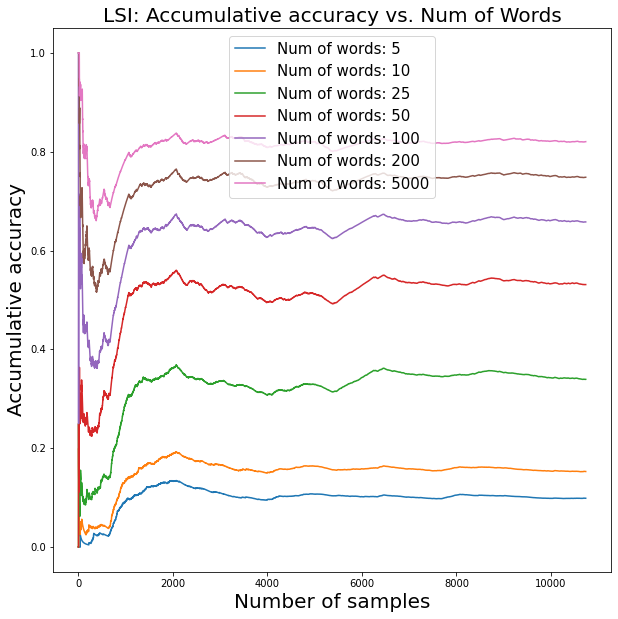

In [55]:
plt.figure(figsize=(10, 10))

for i in plt_LSI:
    plt.plot(range(len(retrieval_correct_LSI[i])),plt_LSI[i],label="Num of words: "+str(i))
  

plt.xlabel("Number of samples", fontsize=20) 
plt.ylabel("Accumulative accuracy", fontsize=20)
plt.title("LSI: Accumulative accuracy vs. Num of Words", fontsize=20)
plt.legend(loc = 9, fontsize=15)
plt.show()

In [46]:
ldaTopics= 200
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=ldaTopics)

2020-12-15 16:02:18,221 : INFO : using symmetric alpha at 0.005
2020-12-15 16:02:18,223 : INFO : using symmetric eta at 0.005
2020-12-15 16:02:18,224 : INFO : using serial LDA version on this node
2020-12-15 16:02:18,395 : INFO : running online (single-pass) LDA training, 200 topics, 1 passes over the supplied corpus of 42942 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2020-12-15 16:02:18,397 : INFO : PROGRESS: pass 0, at document #2000/42942
2020-12-15 16:02:32,221 : INFO : merging changes from 2000 documents into a model of 42942 documents
2020-12-15 16:02:32,324 : INFO : topic #153 (0.005): 0.016*"s" + 0.010*"â" + 0.008*"time" + 0.005*"t" + 0.004*"men" + 0.004*"old" + 0.004*"did" + 0.004*"two" + 0.003*"shall" + 0.003*"great"
2020-12-15 16:02:32,324 : INFO : topic #5 (0.005): 0.023*"â" + 0.014*"t" + 0.012*"s" + 0.008*"know" + 0.006*"don" + 0.006*"say" + 0.005*"great" + 0.005*"

2020-12-15 16:03:52,399 : INFO : topic #113 (0.005): 0.008*"â" + 0.008*"two" + 0.007*"land" + 0.007*"s" + 0.007*"night" + 0.006*"came" + 0.006*"began" + 0.006*"time" + 0.005*"great" + 0.005*"men"
2020-12-15 16:03:52,400 : INFO : topic #109 (0.005): 0.022*"â" + 0.012*"s" + 0.008*"hand" + 0.008*"face" + 0.008*"heart" + 0.008*"night" + 0.007*"eyes" + 0.006*"did" + 0.006*"looked" + 0.006*"back"
2020-12-15 16:03:52,400 : INFO : topic #150 (0.005): 0.043*"charles" + 0.019*"nurse" + 0.012*"child" + 0.012*"s" + 0.010*"good" + 0.009*"mary" + 0.009*"room" + 0.006*"mother" + 0.006*"time" + 0.006*"â"
2020-12-15 16:03:52,409 : INFO : topic diff=4.584122, rho=0.377964
2020-12-15 16:03:52,412 : INFO : PROGRESS: pass 0, at document #16000/42942
2020-12-15 16:04:06,154 : INFO : merging changes from 2000 documents into a model of 42942 documents
2020-12-15 16:04:06,272 : INFO : topic #59 (0.005): 0.069*"ah" + 0.038*"â" + 0.018*"s" + 0.007*"did" + 0.006*"t" + 0.006*"good" + 0.005*"time" + 0.005*"orphan" 

2020-12-15 16:05:34,836 : INFO : topic diff=4.723427, rho=0.277350
2020-12-15 16:05:34,839 : INFO : PROGRESS: pass 0, at document #28000/42942
2020-12-15 16:05:48,897 : INFO : merging changes from 2000 documents into a model of 42942 documents
2020-12-15 16:05:49,028 : INFO : topic #129 (0.005): 0.069*"adam" + 0.064*"arthur" + 0.036*"birds" + 0.030*"bird" + 0.026*"animals" + 0.013*"scales" + 0.011*"fishes" + 0.010*"different" + 0.008*"serpent" + 0.006*"eve"
2020-12-15 16:05:49,028 : INFO : topic #127 (0.005): 0.016*"s" + 0.010*"time" + 0.008*"hope" + 0.008*"heart" + 0.008*"â" + 0.006*"return" + 0.006*"felt" + 0.005*"did" + 0.005*"away" + 0.004*"happy"
2020-12-15 16:05:49,029 : INFO : topic #43 (0.005): 0.023*"newspaper" + 0.019*"â" + 0.018*"journal" + 0.015*"type" + 0.013*"weekly" + 0.013*"s" + 0.012*"writer" + 0.012*"price" + 0.011*"editor" + 0.011*"times"
2020-12-15 16:05:49,030 : INFO : topic #111 (0.005): 0.021*"â" + 0.015*"eyes" + 0.013*"s" + 0.012*"face" + 0.009*"looked" + 0.006*

2020-12-15 16:07:30,290 : INFO : topic #55 (0.005): 0.010*"duty" + 0.007*"object" + 0.006*"s" + 0.006*"important" + 0.005*"case" + 0.005*"person" + 0.005*"means" + 0.004*"sir" + 0.004*"course" + 0.004*"opportunity"
2020-12-15 16:07:30,290 : INFO : topic #188 (0.005): 0.011*"â" + 0.010*"great" + 0.009*"river" + 0.009*"old" + 0.007*"long" + 0.007*"town" + 0.006*"men" + 0.005*"village" + 0.005*"country" + 0.005*"stone"
2020-12-15 16:07:30,291 : INFO : topic #81 (0.005): 0.135*"chorus" + 0.118*"doll" + 0.080*"star" + 0.064*"device" + 0.060*"goal" + 0.044*"inadequate" + 0.041*"notices" + 0.041*"earning" + 0.038*"leaps" + 0.031*"breezes"
2020-12-15 16:07:30,293 : INFO : topic #50 (0.005): 0.026*"s" + 0.017*"old" + 0.017*"t" + 0.014*"n" + 0.012*"farmer" + 0.012*"went" + 0.011*"farm" + 0.011*"good" + 0.010*"got" + 0.009*"came"
2020-12-15 16:07:30,303 : INFO : topic diff=3.217771, rho=0.223607
2020-12-15 16:07:30,307 : INFO : PROGRESS: pass 0, at document #42000/42942
2020-12-15 16:07:43,670 : 

In [47]:
ldaIndex = similarities.MatrixSimilarity(lda[corpus],num_features=ldaTopics)  # transform corpus to LSI space and index it

2020-12-15 16:07:57,698 : INFO : creating matrix with 42942 documents and 200 features


In [48]:
retrieval_correct_LDA = dict()
sampleSize=[5,10,25,50,100,200,5000]
for i in sampleSize:
    retrieval_correct_LDA[i]=[]
    
    for doc in queries:
        trueLabel=dictTest[hash(doc.strip())]
        
        queryContainer = doc.split()
        max_pos = len(queryContainer)
        if max_pos<=i:
            pos=0
            # Otherwise random.randint(0,max_pos-j) is undefined, right bound can not be smaller than left bound
        else:
            pos=min(0,random.randint(0,max_pos-i))

        vec_bow = dictionary.doc2bow(queryContainer[pos:min(pos+i,max_pos)])
        vec_lda = lda[vec_bow]  # convert the query to LSI space
        # print(vec_lsi)

        sims = ldaIndex[vec_lda]  # perform a similarity query against the corpus
        sims = max(enumerate(sims), key=lambda item: item[1])

        print("sims:",sims)
        predLabel=dictTrain[hash(documents[sims[0]].strip())]
        print("Predict:",predLabel)
        retrieval_correct_LDA[i].append(predLabel==trueLabel)


sims: (1704, 0.98364687)
Predict: 34
sims: (22359, 0.806509)
Predict: 36
sims: (13564, 0.9330132)
Predict: 30
sims: (7546, 0.9299664)
Predict: 10
sims: (2510, 0.8877214)
Predict: 15
sims: (21905, 0.7805228)
Predict: 38
sims: (953, 0.9864174)
Predict: 26
sims: (39099, 0.9953488)
Predict: 39
sims: (1733, 0.8155082)
Predict: 19
sims: (26652, 0.7559917)
Predict: 10
sims: (3113, 0.7754874)
Predict: 18
sims: (41914, 0.6918683)
Predict: 8
sims: (15877, 0.8840449)
Predict: 36
sims: (3867, 0.69261605)
Predict: 39
sims: (4613, 0.5902761)
Predict: 45
sims: (1733, 0.782705)
Predict: 19
sims: (28318, 0.5540403)
Predict: 22
sims: (19083, 0.68552876)
Predict: 41
sims: (11672, 0.8222448)
Predict: 45
sims: (39099, 0.96087056)
Predict: 39
sims: (223, 0.7318271)
Predict: 10
sims: (28639, 0.8958366)
Predict: 8
sims: (10846, 0.9782032)
Predict: 30
sims: (473, 0.9887245)
Predict: 26
sims: (4703, 0.8948197)
Predict: 43
sims: (21577, 0.5543023)
Predict: 21
sims: (5807, 0.96149987)
Predict: 25
sims: (39099, 0.

sims: (473, 0.9887245)
Predict: 26
sims: (3867, 0.8149932)
Predict: 39
sims: (4954, 0.6945234)
Predict: 38
sims: (975, 0.774985)
Predict: 15
sims: (1116, 0.8468994)
Predict: 37
sims: (936, 0.51640207)
Predict: 26
sims: (15877, 0.8928229)
Predict: 36
sims: (936, 0.3993871)
Predict: 26
sims: (7259, 0.6797276)
Predict: 41
sims: (920, 0.9373813)
Predict: 39
sims: (1669, 0.64178574)
Predict: 45
sims: (7546, 0.7481112)
Predict: 10
sims: (10846, 0.95454884)
Predict: 30
sims: (41643, 0.9472356)
Predict: 8
sims: (5235, 0.5855478)
Predict: 8
sims: (13639, 0.96126485)
Predict: 44
sims: (11672, 0.8326161)
Predict: 45
sims: (4503, 0.72103405)
Predict: 39
sims: (35602, 0.636231)
Predict: 50
sims: (35777, 0.95746416)
Predict: 8
sims: (13847, 0.95953286)
Predict: 33
sims: (39348, 0.9231945)
Predict: 39
sims: (13400, 0.7732528)
Predict: 41
sims: (38570, 0.53536963)
Predict: 10
sims: (22670, 0.67705524)
Predict: 37
sims: (22413, 0.713771)
Predict: 39
sims: (953, 0.811498)
Predict: 26
sims: (11672, 0.696

sims: (39099, 0.8007813)
Predict: 39
sims: (2994, 0.85479087)
Predict: 48
sims: (16296, 0.90629953)
Predict: 8
sims: (2038, 0.8632191)
Predict: 4
sims: (1293, 0.8685354)
Predict: 45
sims: (3654, 0.81431675)
Predict: 26
sims: (16801, 0.66019)
Predict: 35
sims: (19291, 0.43950897)
Predict: 45
sims: (19044, 0.7878364)
Predict: 19
sims: (40305, 0.61397696)
Predict: 23
sims: (268, 0.6835531)
Predict: 8
sims: (1286, 0.7322464)
Predict: 8
sims: (6210, 0.679192)
Predict: 8
sims: (3715, 0.756531)
Predict: 8
sims: (4173, 0.98383313)
Predict: 16
sims: (1137, 0.9963703)
Predict: 43
sims: (40985, 0.49959776)
Predict: 50
sims: (3113, 0.8339797)
Predict: 18
sims: (13590, 0.6366155)
Predict: 23
sims: (40916, 0.7150371)
Predict: 39
sims: (28608, 0.94304675)
Predict: 21
sims: (5476, 0.7492173)
Predict: 45
sims: (7987, 0.69782674)
Predict: 38
sims: (3867, 0.8561354)
Predict: 39
sims: (223, 0.8995918)
Predict: 10
sims: (1923, 0.7330036)
Predict: 28
sims: (37057, 0.67036325)
Predict: 9
sims: (20040, 0.9243

sims: (4703, 0.8948197)
Predict: 43
sims: (841, 0.6732856)
Predict: 19
sims: (929, 0.664798)
Predict: 21
sims: (268, 0.7228956)
Predict: 8
sims: (13398, 0.64996266)
Predict: 8
sims: (2038, 0.87152565)
Predict: 4
sims: (23097, 0.98241407)
Predict: 26
sims: (42160, 0.988355)
Predict: 8
sims: (2139, 0.670319)
Predict: 8
sims: (23097, 0.61826485)
Predict: 26
sims: (16658, 0.97306925)
Predict: 21
sims: (36511, 0.9290457)
Predict: 19
sims: (15289, 0.6775546)
Predict: 38
sims: (10846, 0.9589437)
Predict: 30
sims: (5738, 0.91091275)
Predict: 19
sims: (1286, 0.63337624)
Predict: 8
sims: (4591, 0.64919186)
Predict: 28
sims: (13847, 0.92802566)
Predict: 33
sims: (367, 0.9917229)
Predict: 8
sims: (11489, 0.9044876)
Predict: 21
sims: (13564, 0.9427195)
Predict: 30
sims: (10630, 0.9576484)
Predict: 22
sims: (24674, 0.82680887)
Predict: 26
sims: (47, 0.67596877)
Predict: 21
sims: (25637, 0.98712325)
Predict: 46
sims: (13564, 0.88969964)
Predict: 30
sims: (4173, 0.9495544)
Predict: 16
sims: (18106, 0.

sims: (1560, 0.6013447)
Predict: 8
sims: (39751, 0.79324675)
Predict: 41
sims: (47, 0.75082827)
Predict: 21
sims: (5869, 0.91533834)
Predict: 26
sims: (2510, 0.93213725)
Predict: 15
sims: (27979, 0.7871136)
Predict: 26
sims: (23097, 0.9910998)
Predict: 26
sims: (351, 0.8792428)
Predict: 28
sims: (1482, 0.7635289)
Predict: 24
sims: (1704, 0.95117825)
Predict: 34
sims: (39099, 0.8488147)
Predict: 39
sims: (28608, 0.9804197)
Predict: 21
sims: (4521, 0.9627386)
Predict: 26
sims: (32479, 0.55978006)
Predict: 26
sims: (1404, 0.542576)
Predict: 11
sims: (1445, 0.9334852)
Predict: 48
sims: (40916, 0.7539571)
Predict: 39
sims: (804, 0.89129335)
Predict: 8
sims: (40836, 0.98179716)
Predict: 8
sims: (42160, 0.988355)
Predict: 8
sims: (1116, 0.7417081)
Predict: 37
sims: (40836, 0.8938086)
Predict: 8
sims: (17607, 0.8671931)
Predict: 33
sims: (19044, 0.9643679)
Predict: 19
sims: (180, 0.92763585)
Predict: 15
sims: (15010, 0.60929096)
Predict: 8
sims: (42283, 0.872438)
Predict: 24
sims: (13398, 0.63

sims: (351, 0.94546187)
Predict: 28
sims: (544, 0.8968757)
Predict: 37
sims: (473, 0.8926213)
Predict: 26
sims: (32479, 0.72712994)
Predict: 26
sims: (5869, 0.82000655)
Predict: 26
sims: (953, 0.8102096)
Predict: 26
sims: (39099, 0.9953488)
Predict: 39
sims: (14657, 0.8061655)
Predict: 50
sims: (9936, 0.91189945)
Predict: 34
sims: (23989, 0.8410965)
Predict: 14
sims: (13992, 0.89192575)
Predict: 4
sims: (268, 0.80231285)
Predict: 8
sims: (39099, 0.9477354)
Predict: 39
sims: (9398, 0.80733895)
Predict: 8
sims: (4521, 0.9950517)
Predict: 26
sims: (10846, 0.95243037)
Predict: 30
sims: (24660, 0.95966357)
Predict: 45
sims: (28627, 0.96485066)
Predict: 26
sims: (943, 0.79944736)
Predict: 26
sims: (7546, 0.683559)
Predict: 10
sims: (13400, 0.8420716)
Predict: 41
sims: (1704, 0.88543826)
Predict: 34
sims: (13738, 0.8054632)
Predict: 9
sims: (3560, 0.80558836)
Predict: 41
sims: (13847, 0.9241811)
Predict: 33
sims: (7987, 0.69922787)
Predict: 38
sims: (3113, 0.9858795)
Predict: 18
sims: (26830,

sims: (40362, 0.7908072)
Predict: 37
sims: (953, 0.7748118)
Predict: 26
sims: (28639, 0.8958366)
Predict: 8
sims: (804, 0.9920678)
Predict: 8
sims: (2242, 0.6323633)
Predict: 8
sims: (1991, 0.8994935)
Predict: 18
sims: (19085, 0.8615544)
Predict: 38
sims: (834, 0.90114623)
Predict: 37
sims: (1669, 0.6261745)
Predict: 45
sims: (1034, 0.89581925)
Predict: 34
sims: (9473, 0.9816068)
Predict: 10
sims: (544, 0.786237)
Predict: 37
sims: (40057, 0.7727677)
Predict: 24
sims: (706, 0.6741208)
Predict: 26
sims: (40836, 0.9629426)
Predict: 8
sims: (5125, 0.8827667)
Predict: 26
sims: (4703, 0.76169825)
Predict: 43
sims: (13400, 0.94917417)
Predict: 41
sims: (7546, 0.96356153)
Predict: 10
sims: (7546, 0.91513515)
Predict: 10
sims: (6550, 0.9902406)
Predict: 26
sims: (1293, 0.71754825)
Predict: 45
sims: (28639, 0.8958366)
Predict: 8
sims: (8567, 0.8442065)
Predict: 41
sims: (47, 0.62428176)
Predict: 21
sims: (1591, 0.9088573)
Predict: 4
sims: (953, 0.85120684)
Predict: 26
sims: (804, 0.9920678)
Pred

sims: (33617, 0.7368605)
Predict: 30
sims: (42160, 0.988355)
Predict: 8
sims: (13400, 0.8551172)
Predict: 41
sims: (39949, 0.76692176)
Predict: 39
sims: (1286, 0.71134734)
Predict: 8
sims: (30921, 0.7775817)
Predict: 50
sims: (18, 0.94882244)
Predict: 26
sims: (23097, 0.92239475)
Predict: 26
sims: (3715, 0.84540004)
Predict: 8
sims: (2755, 0.85480016)
Predict: 34
sims: (36806, 0.8821131)
Predict: 4
sims: (10846, 0.87514806)
Predict: 30
sims: (11470, 0.9033147)
Predict: 8
sims: (5764, 0.80731773)
Predict: 37
sims: (5869, 0.7606969)
Predict: 26
sims: (1209, 0.6622238)
Predict: 39
sims: (1286, 0.7322464)
Predict: 8
sims: (5869, 0.7457905)
Predict: 26
sims: (33725, 0.73318225)
Predict: 26
sims: (19845, 0.7158967)
Predict: 14
sims: (16658, 0.8918813)
Predict: 21
sims: (28639, 0.8958366)
Predict: 8
sims: (2510, 0.97514325)
Predict: 15
sims: (3560, 0.96609634)
Predict: 41
sims: (268, 0.63060534)
Predict: 8
sims: (32479, 0.6406592)
Predict: 26
sims: (130, 0.6857508)
Predict: 39
sims: (40836, 0

sims: (25101, 0.8154284)
Predict: 25
sims: (3494, 0.65896845)
Predict: 28
sims: (6210, 0.7757206)
Predict: 8
sims: (13847, 0.902035)
Predict: 33
sims: (17009, 0.97188723)
Predict: 41
sims: (13847, 0.9380662)
Predict: 33
sims: (19574, 0.87227494)
Predict: 48
sims: (40836, 0.84107596)
Predict: 8
sims: (40836, 0.99511033)
Predict: 8
sims: (223, 0.9382214)
Predict: 10
sims: (16704, 0.5152298)
Predict: 14
sims: (6550, 0.9902406)
Predict: 26
sims: (13398, 0.61207753)
Predict: 8
sims: (17453, 0.6704078)
Predict: 8
sims: (13400, 0.97372824)
Predict: 41
sims: (834, 0.99267536)
Predict: 37
sims: (913, 0.42163014)
Predict: 20
sims: (13992, 0.8961369)
Predict: 4
sims: (40836, 0.99511033)
Predict: 8
sims: (2426, 0.52585053)
Predict: 22
sims: (33216, 0.902676)
Predict: 1
sims: (11489, 0.9044876)
Predict: 21
sims: (1615, 0.6967142)
Predict: 11
sims: (10630, 0.98179483)
Predict: 22
sims: (804, 0.9568984)
Predict: 8
sims: (8649, 0.9369258)
Predict: 8
sims: (1453, 0.67226684)
Predict: 37
sims: (30414, 0

sims: (20309, 0.7349203)
Predict: 12
sims: (12345, 0.75490797)
Predict: 32
sims: (1967, 0.7040399)
Predict: 15
sims: (23921, 0.8378898)
Predict: 48
sims: (1200, 0.795313)
Predict: 19
sims: (804, 0.8846218)
Predict: 8
sims: (2717, 0.7778114)
Predict: 8
sims: (8745, 0.6106504)
Predict: 29
sims: (15568, 0.77588123)
Predict: 48
sims: (1972, 0.92295897)
Predict: 37
sims: (9478, 0.7219744)
Predict: 26
sims: (1482, 0.6302827)
Predict: 24
sims: (7987, 0.8633614)
Predict: 38
sims: (3715, 0.7909434)
Predict: 8
sims: (40717, 0.846372)
Predict: 41
sims: (41507, 0.8460482)
Predict: 24
sims: (10630, 0.9227957)
Predict: 22
sims: (3893, 0.66737497)
Predict: 39
sims: (137, 0.81862825)
Predict: 20
sims: (18714, 0.7264131)
Predict: 19
sims: (3715, 0.790818)
Predict: 8
sims: (15405, 0.6850882)
Predict: 26
sims: (18962, 0.73217314)
Predict: 21
sims: (30128, 0.30891114)
Predict: 28
sims: (11535, 0.7498172)
Predict: 33
sims: (25878, 0.7365566)
Predict: 4
sims: (5061, 0.51184976)
Predict: 15
sims: (804, 0.932

sims: (367, 0.95573676)
Predict: 8
sims: (4162, 0.92805344)
Predict: 44
sims: (37924, 0.8730984)
Predict: 43
sims: (26830, 0.6843195)
Predict: 26
sims: (16063, 0.8468824)
Predict: 24
sims: (7158, 0.9458558)
Predict: 48
sims: (3494, 0.82838947)
Predict: 28
sims: (351, 0.86632556)
Predict: 28
sims: (841, 0.865622)
Predict: 19
sims: (738, 0.53623843)
Predict: 45
sims: (2322, 0.99105)
Predict: 48
sims: (9891, 0.8256709)
Predict: 14
sims: (834, 0.99267536)
Predict: 37
sims: (7445, 0.5589284)
Predict: 8
sims: (13398, 0.8619273)
Predict: 8
sims: (31695, 0.93515897)
Predict: 39
sims: (35218, 0.9061521)
Predict: 4
sims: (4703, 0.7851235)
Predict: 43
sims: (804, 0.8460644)
Predict: 8
sims: (1369, 0.80950004)
Predict: 28
sims: (2038, 0.7239783)
Predict: 4
sims: (3269, 0.8782445)
Predict: 10
sims: (10846, 0.9318701)
Predict: 30
sims: (28824, 0.96841323)
Predict: 19
sims: (1137, 0.8830574)
Predict: 43
sims: (3269, 0.8518433)
Predict: 10
sims: (22925, 0.9898156)
Predict: 50
sims: (9390, 0.92705876)


Predict: 8
sims: (38106, 0.81594276)
Predict: 50
sims: (10630, 0.98179483)
Predict: 22
sims: (2510, 0.9436762)
Predict: 15
sims: (5807, 0.9321865)
Predict: 25
sims: (2322, 0.6617636)
Predict: 48
sims: (1704, 0.849938)
Predict: 34
sims: (1704, 0.9455646)
Predict: 34
sims: (1967, 0.47561458)
Predict: 15
sims: (26996, 0.85502344)
Predict: 39
sims: (1231, 0.9570119)
Predict: 12
sims: (1231, 0.9570119)
Predict: 12
sims: (2717, 0.95141107)
Predict: 8
sims: (1453, 0.7111195)
Predict: 37
sims: (172, 0.78755164)
Predict: 15
sims: (9156, 0.91950554)
Predict: 18
sims: (21577, 0.8827517)
Predict: 21
sims: (5807, 0.94852173)
Predict: 25
sims: (26086, 0.7805718)
Predict: 8
sims: (39099, 0.9953488)
Predict: 39
sims: (5125, 0.8469027)
Predict: 26
sims: (1704, 0.98364687)
Predict: 34
sims: (1231, 0.86328596)
Predict: 12
sims: (1231, 0.9246814)
Predict: 12
sims: (9478, 0.6363659)
Predict: 26
sims: (3533, 0.7334474)
Predict: 36
sims: (16906, 0.85234576)
Predict: 3
sims: (11535, 0.97819346)
Predict: 33
si

sims: (5654, 0.82427686)
Predict: 14
sims: (15581, 0.7102897)
Predict: 14
sims: (447, 0.62839556)
Predict: 19
sims: (3486, 0.7801233)
Predict: 33
sims: (5654, 0.9834929)
Predict: 14
sims: (5235, 0.8716923)
Predict: 8
sims: (25620, 0.9495995)
Predict: 19
sims: (63, 0.9971641)
Predict: 19
sims: (63, 0.9971641)
Predict: 19
sims: (919, 0.6487622)
Predict: 37
sims: (14056, 0.86239284)
Predict: 48
sims: (5654, 0.9587484)
Predict: 14
sims: (3710, 0.9294321)
Predict: 42
sims: (21739, 0.85883075)
Predict: 3
sims: (23868, 0.9692602)
Predict: 14
sims: (20668, 0.9699518)
Predict: 48
sims: (5654, 0.9834929)
Predict: 14
sims: (5654, 0.92624265)
Predict: 14
sims: (5654, 0.89855164)
Predict: 14
sims: (36575, 0.815559)
Predict: 14
sims: (5235, 0.8718688)
Predict: 8
sims: (5235, 0.81464255)
Predict: 8
sims: (1116, 0.8327658)
Predict: 37
sims: (14656, 0.6323852)
Predict: 26
sims: (28147, 0.5927813)
Predict: 14
sims: (5235, 0.7780583)
Predict: 8
sims: (18, 0.8043667)
Predict: 26
sims: (5869, 0.7050012)
Pr

sims: (24144, 0.9565342)
Predict: 44
sims: (9478, 0.8307616)
Predict: 26
sims: (508, 0.49645445)
Predict: 45
sims: (9135, 0.745009)
Predict: 15
sims: (3494, 0.9533327)
Predict: 28
sims: (999, 0.92128915)
Predict: 48
sims: (1200, 0.9361796)
Predict: 19
sims: (24511, 0.9368092)
Predict: 8
sims: (6550, 0.9902406)
Predict: 26
sims: (13992, 0.8947523)
Predict: 4
sims: (130, 0.84636885)
Predict: 39
sims: (22196, 0.73285633)
Predict: 43
sims: (5125, 0.6242442)
Predict: 26
sims: (1181, 0.7659329)
Predict: 3
sims: (6549, 0.69510674)
Predict: 8
sims: (1293, 0.6255656)
Predict: 45
sims: (22925, 0.9215984)
Predict: 50
sims: (22925, 0.82391703)
Predict: 50
sims: (40595, 0.9786761)
Predict: 36
sims: (9891, 0.8394825)
Predict: 14
sims: (1083, 0.9419034)
Predict: 29
sims: (39099, 0.9953488)
Predict: 39
sims: (20668, 0.8860122)
Predict: 48
sims: (13435, 0.9169444)
Predict: 43
sims: (473, 0.8892615)
Predict: 26
sims: (19044, 0.9755136)
Predict: 19
sims: (41751, 0.4720171)
Predict: 45
sims: (18, 0.916292

sims: (5235, 0.67539793)
Predict: 8
sims: (5807, 0.93916774)
Predict: 25
sims: (1364, 0.90013766)
Predict: 21
sims: (13400, 0.97372824)
Predict: 41
sims: (1704, 0.98364687)
Predict: 34
sims: (20820, 0.6492739)
Predict: 36
sims: (36575, 0.719062)
Predict: 14
sims: (5807, 0.9436319)
Predict: 25
sims: (35754, 0.76439285)
Predict: 14
sims: (5066, 0.6657225)
Predict: 29
sims: (24297, 0.53965676)
Predict: 26
sims: (41057, 0.7247832)
Predict: 48
sims: (5057, 0.6099513)
Predict: 15
sims: (24281, 0.7551648)
Predict: 32
sims: (32479, 0.70769304)
Predict: 26
sims: (13247, 0.68450356)
Predict: 38
sims: (23310, 0.8779508)
Predict: 13
sims: (10156, 0.8943292)
Predict: 37
sims: (4791, 0.8271663)
Predict: 20
sims: (22040, 0.83333164)
Predict: 37
sims: (4173, 0.82505274)
Predict: 16
sims: (4173, 0.98383313)
Predict: 16
sims: (1286, 0.6853246)
Predict: 8
sims: (13847, 0.8708663)
Predict: 33
sims: (5125, 0.9466691)
Predict: 26
sims: (913, 0.4084182)
Predict: 20
sims: (15877, 0.6487774)
Predict: 36
sims: 

sims: (28781, 0.7093086)
Predict: 8
sims: (19574, 0.88965154)
Predict: 48
sims: (11672, 0.8326161)
Predict: 45
sims: (19044, 0.9755136)
Predict: 19
sims: (3867, 0.8239071)
Predict: 39
sims: (17090, 0.9760778)
Predict: 26
sims: (13398, 0.6868033)
Predict: 8
sims: (35735, 0.7013578)
Predict: 28
sims: (929, 0.6539879)
Predict: 21
sims: (40905, 0.7474666)
Predict: 30
sims: (2994, 0.88546985)
Predict: 48
sims: (22560, 0.99632055)
Predict: 42
sims: (28639, 0.86147237)
Predict: 8
sims: (35602, 0.7015518)
Predict: 50
sims: (25367, 0.75467813)
Predict: 9
sims: (223, 0.8164156)
Predict: 10
sims: (2242, 0.6074504)
Predict: 8
sims: (5061, 0.73017716)
Predict: 15
sims: (804, 0.9920678)
Predict: 8
sims: (5869, 0.86502266)
Predict: 26
sims: (41118, 0.69406736)
Predict: 15
sims: (8570, 0.36622703)
Predict: 8
sims: (1231, 0.6362755)
Predict: 12
sims: (5061, 0.7082614)
Predict: 15
sims: (23097, 0.8463763)
Predict: 26
sims: (39378, 0.6380703)
Predict: 37
sims: (1137, 0.8458588)
Predict: 43
sims: (31161, 

sims: (1704, 0.8423022)
Predict: 34
sims: (2038, 0.8546657)
Predict: 4
sims: (995, 0.49969164)
Predict: 37
sims: (32479, 0.6796488)
Predict: 26
sims: (4591, 0.9817132)
Predict: 28
sims: (268, 0.70980936)
Predict: 8
sims: (13847, 0.9851186)
Predict: 33
sims: (13992, 0.9452254)
Predict: 4
sims: (4664, 0.5648637)
Predict: 45
sims: (34112, 0.8091288)
Predict: 34
sims: (22247, 0.8981868)
Predict: 32
sims: (63, 0.95922416)
Predict: 19
sims: (20668, 0.9596431)
Predict: 48
sims: (2510, 0.82060415)
Predict: 15
sims: (4173, 0.92364174)
Predict: 16
sims: (36325, 0.8896919)
Predict: 15
sims: (39516, 0.59309435)
Predict: 22
sims: (19085, 0.7466393)
Predict: 38
sims: (19044, 0.9755136)
Predict: 19
sims: (804, 0.94446325)
Predict: 8
sims: (2028, 0.73169446)
Predict: 22
sims: (1482, 0.7292687)
Predict: 24
sims: (26987, 0.6617286)
Predict: 21
sims: (2994, 0.88546985)
Predict: 48
sims: (5125, 0.9406623)
Predict: 26
sims: (6459, 0.76438826)
Predict: 29
sims: (975, 0.5589288)
Predict: 15
sims: (13564, 0.6

sims: (20668, 0.9776083)
Predict: 48
sims: (11448, 0.9827409)
Predict: 19
sims: (20668, 0.9791092)
Predict: 48
sims: (919, 0.72807115)
Predict: 37
sims: (1972, 0.7500751)
Predict: 37
sims: (3736, 0.96868783)
Predict: 37
sims: (37245, 0.6794239)
Predict: 21
sims: (13806, 0.75545585)
Predict: 38
sims: (38882, 0.7504973)
Predict: 48
sims: (41918, 0.48819464)
Predict: 19
sims: (20668, 1.0)
Predict: 48
sims: (30252, 0.83703667)
Predict: 6
sims: (20668, 1.0)
Predict: 48
sims: (38812, 0.9988643)
Predict: 19
sims: (31104, 0.78972423)
Predict: 11
sims: (25620, 0.99988234)
Predict: 19
sims: (63, 0.9642113)
Predict: 19
sims: (1231, 0.86481845)
Predict: 12
sims: (33555, 0.80787003)
Predict: 19
sims: (63, 0.9669997)
Predict: 19
sims: (21541, 0.5174071)
Predict: 24
sims: (63, 0.8598672)
Predict: 19
sims: (63, 0.97167975)
Predict: 19
sims: (30029, 0.9975233)
Predict: 19
sims: (40157, 0.9792633)
Predict: 19
sims: (172, 0.8333553)
Predict: 15
sims: (1733, 0.9365245)
Predict: 19
sims: (42162, 0.7334807)

sims: (4703, 0.8948197)
Predict: 43
sims: (29097, 0.9489701)
Predict: 24
sims: (28627, 0.92741895)
Predict: 26
sims: (3465, 0.87934923)
Predict: 11
sims: (1330, 0.6797773)
Predict: 50
sims: (130, 0.52268726)
Predict: 39
sims: (1972, 0.82019424)
Predict: 37
sims: (7303, 0.6920664)
Predict: 37
sims: (1972, 0.95802283)
Predict: 37
sims: (3736, 0.96307003)
Predict: 37
sims: (1923, 0.73305166)
Predict: 28
sims: (1972, 0.97015816)
Predict: 37
sims: (37828, 0.39797428)
Predict: 22
sims: (47, 0.5685192)
Predict: 21
sims: (999, 0.9662715)
Predict: 48
sims: (841, 0.9081885)
Predict: 19
sims: (1364, 0.64928687)
Predict: 21
sims: (23218, 0.7093688)
Predict: 12
sims: (15568, 0.99714285)
Predict: 48
sims: (999, 0.8996471)
Predict: 48
sims: (1083, 0.64209765)
Predict: 29
sims: (2816, 0.7885905)
Predict: 14
sims: (351, 0.9986887)
Predict: 28
sims: (14231, 0.5707937)
Predict: 26
sims: (3113, 0.9858795)
Predict: 18
sims: (3465, 0.87934923)
Predict: 11
sims: (1116, 0.8778509)
Predict: 37
sims: (1967, 0.6

sims: (2717, 0.65215564)
Predict: 8
sims: (3560, 0.9622841)
Predict: 41
sims: (3113, 0.9324053)
Predict: 18
sims: (4173, 0.98383313)
Predict: 16
sims: (13564, 0.9427195)
Predict: 30
sims: (4591, 0.5045362)
Predict: 28
sims: (40916, 0.8031701)
Predict: 39
sims: (13400, 0.97372824)
Predict: 41
sims: (15877, 0.76406926)
Predict: 36
sims: (9473, 0.881724)
Predict: 10
sims: (1702, 0.6962221)
Predict: 28
sims: (3465, 0.77329254)
Predict: 11
sims: (3269, 0.72656447)
Predict: 10
sims: (22060, 0.7997482)
Predict: 39
sims: (11169, 0.64767605)
Predict: 21
sims: (23018, 0.7824274)
Predict: 8
sims: (40985, 0.78861916)
Predict: 50
sims: (21335, 0.94173187)
Predict: 39
sims: (28627, 0.7769694)
Predict: 26
sims: (19044, 0.94124836)
Predict: 19
sims: (28608, 0.9804197)
Predict: 21
sims: (28627, 0.93459004)
Predict: 26
sims: (24128, 0.87383634)
Predict: 38
sims: (6210, 0.6943334)
Predict: 8
sims: (1181, 0.711485)
Predict: 3
sims: (39949, 0.9076321)
Predict: 39
sims: (21335, 0.97548807)
Predict: 39
sims:

sims: (39099, 0.9953488)
Predict: 39
sims: (31053, 0.7964216)
Predict: 14
sims: (19469, 0.6345779)
Predict: 28
sims: (16489, 0.83573824)
Predict: 21
sims: (39099, 0.9953488)
Predict: 39
sims: (3867, 0.93285924)
Predict: 39
sims: (3113, 0.9347334)
Predict: 18
sims: (4703, 0.86650205)
Predict: 43
sims: (2038, 0.6600849)
Predict: 4
sims: (8676, 0.9995336)
Predict: 25
sims: (544, 0.4674995)
Predict: 37
sims: (28055, 0.68945205)
Predict: 21
sims: (22924, 0.67892545)
Predict: 19
sims: (2196, 0.97068495)
Predict: 39
sims: (2322, 0.7853909)
Predict: 48
sims: (485, 0.81478494)
Predict: 35
sims: (27555, 0.7353513)
Predict: 48
sims: (15877, 0.891451)
Predict: 36
sims: (40916, 0.8704315)
Predict: 39
sims: (63, 0.7014315)
Predict: 19
sims: (6709, 0.93802047)
Predict: 21
sims: (1181, 0.9905728)
Predict: 3
sims: (3377, 0.7531762)
Predict: 21
sims: (1704, 0.7984438)
Predict: 34
sims: (351, 0.90131676)
Predict: 28
sims: (351, 0.8672591)
Predict: 28
sims: (39949, 0.93200547)
Predict: 39
sims: (11489, 0.

sims: (17299, 0.78417766)
Predict: 45
sims: (1923, 0.7497683)
Predict: 28
sims: (31227, 0.8165402)
Predict: 24
sims: (5125, 0.67602056)
Predict: 26
sims: (2510, 0.67731047)
Predict: 15
sims: (34123, 0.8634761)
Predict: 14
sims: (1923, 0.8708035)
Predict: 28
sims: (3560, 0.99943334)
Predict: 41
sims: (351, 0.9530528)
Predict: 28
sims: (35735, 0.8087328)
Predict: 28
sims: (40916, 0.98900586)
Predict: 39
sims: (1445, 0.78163195)
Predict: 48
sims: (40893, 0.7186278)
Predict: 37
sims: (5869, 0.78298885)
Predict: 26
sims: (6550, 0.9902406)
Predict: 26
sims: (920, 0.87704533)
Predict: 39
sims: (11489, 0.9044876)
Predict: 21
sims: (22925, 0.91444916)
Predict: 50
sims: (15877, 0.5886493)
Predict: 36
sims: (16658, 0.91934204)
Predict: 21
sims: (3533, 0.608313)
Predict: 36
sims: (6475, 0.96381414)
Predict: 28
sims: (1445, 0.8196429)
Predict: 48
sims: (14550, 0.79830515)
Predict: 21
sims: (11489, 0.71715695)
Predict: 21
sims: (5647, 0.7002129)
Predict: 48
sims: (19075, 0.7316331)
Predict: 48
sims:

sims: (6117, 0.89543617)
Predict: 18
sims: (37983, 0.8888098)
Predict: 26
sims: (30835, 0.62578243)
Predict: 15
sims: (3068, 0.99349266)
Predict: 26
sims: (1923, 0.7861647)
Predict: 28
sims: (5650, 0.9592837)
Predict: 37
sims: (387, 0.94635594)
Predict: 17
sims: (9478, 0.6402572)
Predict: 26
sims: (1293, 0.73841155)
Predict: 45
sims: (4521, 0.9113564)
Predict: 26
sims: (6550, 0.77819616)
Predict: 26
sims: (4521, 0.9950517)
Predict: 26
sims: (804, 0.9619803)
Predict: 8
sims: (14950, 0.6434479)
Predict: 39
sims: (19044, 0.8824641)
Predict: 19
sims: (39949, 0.78008395)
Predict: 39
sims: (39898, 0.6488017)
Predict: 3
sims: (24128, 0.89001256)
Predict: 38
sims: (18808, 0.8139334)
Predict: 43
sims: (25066, 0.77534395)
Predict: 1
sims: (42464, 0.7141094)
Predict: 40
sims: (6550, 0.9269731)
Predict: 26
sims: (5125, 0.8833993)
Predict: 26
sims: (367, 0.9917229)
Predict: 8
sims: (10846, 0.9469292)
Predict: 30
sims: (473, 0.7298499)
Predict: 26
sims: (40836, 0.99511033)
Predict: 8
sims: (953, 0.5

sims: (4173, 0.98383313)
Predict: 16
sims: (684, 0.81738234)
Predict: 26
sims: (975, 0.6791886)
Predict: 15
sims: (3068, 0.9609208)
Predict: 26
sims: (2510, 0.7454)
Predict: 15
sims: (18, 0.94882244)
Predict: 26
sims: (3881, 0.9876271)
Predict: 45
sims: (1797, 0.88091457)
Predict: 26
sims: (28105, 0.7628761)
Predict: 12
sims: (18, 0.91181463)
Predict: 26
sims: (28627, 0.9947082)
Predict: 26
sims: (223, 0.85110396)
Predict: 10
sims: (11672, 0.8326161)
Predict: 45
sims: (15179, 0.95719635)
Predict: 26
sims: (1118, 0.94000465)
Predict: 26
sims: (1409, 0.8025898)
Predict: 40
sims: (759, 0.88874334)
Predict: 20
sims: (30414, 0.912087)
Predict: 26
sims: (15877, 0.8156788)
Predict: 36
sims: (28627, 0.9947082)
Predict: 26
sims: (13655, 0.6434057)
Predict: 19
sims: (10846, 0.79798627)
Predict: 30
sims: (41344, 0.8469413)
Predict: 8
sims: (41248, 0.63155323)
Predict: 15
sims: (42447, 0.89311355)
Predict: 26
sims: (2139, 0.8950691)
Predict: 8
sims: (30414, 0.7501304)
Predict: 26
sims: (19022, 0.9

sims: (23097, 0.9910998)
Predict: 26
sims: (42283, 0.9507583)
Predict: 24
sims: (7373, 0.8680685)
Predict: 43
sims: (18253, 0.9303773)
Predict: 15
sims: (28627, 0.9947082)
Predict: 26
sims: (1409, 0.93573964)
Predict: 40
sims: (33875, 0.7011247)
Predict: 26
sims: (1445, 0.7984028)
Predict: 48
sims: (18768, 0.8311402)
Predict: 50
sims: (11553, 0.97085106)
Predict: 26
sims: (473, 0.95852804)
Predict: 26
sims: (4703, 0.86404896)
Predict: 43
sims: (11672, 0.80138546)
Predict: 45
sims: (27620, 0.9990515)
Predict: 26
sims: (5807, 0.93931645)
Predict: 25
sims: (3068, 0.9352727)
Predict: 26
sims: (5235, 0.7526684)
Predict: 8
sims: (684, 0.7869993)
Predict: 26
sims: (23097, 0.9910998)
Predict: 26
sims: (41248, 0.70928526)
Predict: 15
sims: (953, 0.99213016)
Predict: 26
sims: (4, 0.6467867)
Predict: 12
sims: (2242, 0.74948984)
Predict: 8
sims: (27918, 0.9726979)
Predict: 48
sims: (42217, 0.841355)
Predict: 19
sims: (18467, 0.96626455)
Predict: 26
sims: (23097, 0.9910998)
Predict: 26
sims: (943, 

sims: (7546, 0.6868724)
Predict: 10
sims: (37351, 0.7953054)
Predict: 6
sims: (11775, 0.83455783)
Predict: 26
sims: (8601, 0.98556566)
Predict: 26
sims: (24297, 0.66851664)
Predict: 26
sims: (2355, 0.6955501)
Predict: 20
sims: (223, 0.6491163)
Predict: 10
sims: (953, 0.86760384)
Predict: 26
sims: (1181, 0.9905728)
Predict: 3
sims: (30128, 0.7786802)
Predict: 28
sims: (21554, 0.6823702)
Predict: 8
sims: (13125, 0.9756286)
Predict: 26
sims: (7130, 0.8532444)
Predict: 18
sims: (18599, 0.96489024)
Predict: 28
sims: (4257, 0.8656672)
Predict: 50
sims: (10846, 0.8844216)
Predict: 30
sims: (3113, 0.9858795)
Predict: 18
sims: (29146, 0.8289174)
Predict: 26
sims: (5807, 0.97458494)
Predict: 25
sims: (953, 0.9613823)
Predict: 26
sims: (39099, 0.9953488)
Predict: 39
sims: (953, 0.99213016)
Predict: 26
sims: (8478, 0.71401924)
Predict: 26
sims: (6550, 0.84876937)
Predict: 26
sims: (10630, 0.94330853)
Predict: 22
sims: (1972, 0.7193799)
Predict: 37
sims: (1181, 0.9480124)
Predict: 3
sims: (473, 0.8

sims: (26830, 0.7496571)
Predict: 26
sims: (13032, 0.7299015)
Predict: 21
sims: (22925, 0.8566524)
Predict: 50
sims: (3715, 0.69975424)
Predict: 8
sims: (3113, 0.9858795)
Predict: 18
sims: (13247, 0.61197746)
Predict: 38
sims: (5144, 0.9111528)
Predict: 26
sims: (473, 0.82163054)
Predict: 26
sims: (22068, 0.9965094)
Predict: 39
sims: (35174, 0.85680985)
Predict: 12
sims: (19044, 0.9755136)
Predict: 19
sims: (5869, 0.8103191)
Predict: 26
sims: (10495, 0.8211056)
Predict: 26
sims: (23097, 0.9910998)
Predict: 26
sims: (3269, 0.7536092)
Predict: 10
sims: (473, 0.89395183)
Predict: 26
sims: (2994, 0.7975015)
Predict: 48
sims: (5825, 0.75356126)
Predict: 29
sims: (5061, 0.5782657)
Predict: 15
sims: (280, 0.79328054)
Predict: 37
sims: (10846, 0.88202393)
Predict: 30
sims: (29750, 0.79359126)
Predict: 29
sims: (5654, 0.9834929)
Predict: 14
sims: (953, 0.9490194)
Predict: 26
sims: (11672, 0.8067584)
Predict: 45
sims: (5869, 0.8919366)
Predict: 26
sims: (17918, 0.8105339)
Predict: 15
sims: (2292

sims: (19044, 0.88100463)
Predict: 19
sims: (1733, 0.9069958)
Predict: 19
sims: (4606, 0.6546382)
Predict: 45
sims: (1116, 0.9601743)
Predict: 37
sims: (3494, 0.88811016)
Predict: 28
sims: (1118, 0.7571591)
Predict: 26
sims: (42162, 0.93611276)
Predict: 19
sims: (4606, 0.73422635)
Predict: 45
sims: (3494, 0.97298133)
Predict: 28
sims: (2322, 0.7088806)
Predict: 48
sims: (1453, 0.67947894)
Predict: 37
sims: (28215, 0.9457568)
Predict: 28
sims: (3494, 0.99132067)
Predict: 28
sims: (1923, 0.8908602)
Predict: 28
sims: (3494, 0.9842715)
Predict: 28
sims: (3494, 0.8357857)
Predict: 28
sims: (1702, 0.8289997)
Predict: 28
sims: (24985, 0.7953291)
Predict: 28
sims: (1369, 0.6954754)
Predict: 28
sims: (21577, 0.73160446)
Predict: 21
sims: (5472, 0.7058111)
Predict: 39
sims: (2805, 0.45627114)
Predict: 43
sims: (6399, 0.9032177)
Predict: 28
sims: (13992, 0.9452254)
Predict: 4
sims: (30128, 0.65958357)
Predict: 28
sims: (3494, 0.87846124)
Predict: 28
sims: (1923, 0.91993564)
Predict: 28
sims: (202

sims: (19288, 0.7577663)
Predict: 21
sims: (11672, 0.8043471)
Predict: 45
sims: (6459, 0.8513301)
Predict: 29
sims: (1181, 0.7045924)
Predict: 3
sims: (22925, 0.95397717)
Predict: 50
sims: (14950, 0.49330902)
Predict: 39
sims: (953, 0.78760207)
Predict: 26
sims: (5235, 0.7855705)
Predict: 8
sims: (943, 0.6416947)
Predict: 26
sims: (2994, 0.8555024)
Predict: 48
sims: (13847, 0.6606289)
Predict: 33
sims: (1855, 0.62789273)
Predict: 38
sims: (223, 0.9382214)
Predict: 10
sims: (10465, 0.7505068)
Predict: 14
sims: (2038, 0.7995503)
Predict: 4
sims: (10630, 0.949766)
Predict: 22
sims: (6639, 0.6964484)
Predict: 21
sims: (13499, 0.48908353)
Predict: 14
sims: (1083, 0.91305524)
Predict: 29
sims: (2994, 0.88546985)
Predict: 48
sims: (19044, 0.94027364)
Predict: 19
sims: (1083, 0.9419034)
Predict: 29
sims: (1083, 0.6951867)
Predict: 29
sims: (2805, 0.47399703)
Predict: 43
sims: (999, 0.973596)
Predict: 48
sims: (9478, 0.8148601)
Predict: 26
sims: (4591, 0.5935401)
Predict: 28
sims: (1118, 0.6182

sims: (804, 0.9581175)
Predict: 8
sims: (1885, 0.8240381)
Predict: 28
sims: (12279, 0.8664017)
Predict: 9
sims: (19658, 0.9109943)
Predict: 8
sims: (22341, 0.71827304)
Predict: 15
sims: (130, 0.9699497)
Predict: 39
sims: (13847, 0.9851186)
Predict: 33
sims: (17636, 0.86983395)
Predict: 39
sims: (24431, 0.4601037)
Predict: 37
sims: (35983, 0.5997062)
Predict: 30
sims: (24281, 0.9575038)
Predict: 32
sims: (42280, 0.622723)
Predict: 15
sims: (27622, 0.29315257)
Predict: 12
sims: (39099, 0.9953488)
Predict: 39
sims: (19044, 0.91302955)
Predict: 19
sims: (37929, 0.9440132)
Predict: 39
sims: (223, 0.67502075)
Predict: 10
sims: (1181, 0.94347847)
Predict: 3
sims: (24021, 0.70551974)
Predict: 32
sims: (5807, 0.91039973)
Predict: 25
sims: (28608, 0.92367035)
Predict: 21
sims: (22413, 0.93571186)
Predict: 39
sims: (953, 0.95880336)
Predict: 26
sims: (2038, 0.89262223)
Predict: 4
sims: (32479, 0.5431879)
Predict: 26
sims: (4933, 0.8168756)
Predict: 37
sims: (5125, 0.92833316)
Predict: 26
sims: (1

sims: (29540, 0.6090956)
Predict: 48
sims: (3617, 0.8264033)
Predict: 38
sims: (3113, 0.9858795)
Predict: 18
sims: (7130, 0.8637177)
Predict: 18
sims: (17582, 0.8492005)
Predict: 14
sims: (5946, 0.7763214)
Predict: 28
sims: (11535, 0.97819346)
Predict: 33
sims: (2994, 0.77075726)
Predict: 48
sims: (19044, 0.83524066)
Predict: 19
sims: (13992, 0.76716655)
Predict: 4
sims: (544, 0.70237994)
Predict: 37
sims: (1116, 0.9601743)
Predict: 37
sims: (5807, 0.8946331)
Predict: 25
sims: (3359, 0.8229908)
Predict: 14
sims: (3113, 0.90723157)
Predict: 18
sims: (1615, 0.64364856)
Predict: 11
sims: (12862, 0.74195355)
Predict: 45
sims: (1445, 0.93120056)
Predict: 48
sims: (12693, 0.9256575)
Predict: 10
sims: (3695, 0.71105254)
Predict: 37
sims: (6792, 0.63748133)
Predict: 37
sims: (13847, 0.9515117)
Predict: 33
sims: (6469, 0.6973027)
Predict: 26
sims: (1116, 0.9601743)
Predict: 37
sims: (13930, 0.81331146)
Predict: 37
sims: (8570, 0.839269)
Predict: 8
sims: (9499, 0.93291575)
Predict: 38
sims: (108

sims: (19044, 0.9755136)
Predict: 19
sims: (995, 0.92341936)
Predict: 37
sims: (4703, 0.7443363)
Predict: 43
sims: (473, 0.70558596)
Predict: 26
sims: (2712, 0.9669682)
Predict: 8
sims: (351, 0.6761053)
Predict: 28
sims: (5869, 0.7091967)
Predict: 26
sims: (19044, 0.84064376)
Predict: 19
sims: (6639, 0.774603)
Predict: 21
sims: (19044, 0.9435799)
Predict: 19
sims: (25046, 0.8119615)
Predict: 9
sims: (2038, 0.63488233)
Predict: 4
sims: (1369, 0.59445953)
Predict: 28
sims: (20141, 0.88033944)
Predict: 34
sims: (9478, 0.88997215)
Predict: 26
sims: (1453, 0.80996126)
Predict: 37
sims: (1364, 0.67416984)
Predict: 21
sims: (31187, 0.8950051)
Predict: 21
sims: (2994, 0.85182273)
Predict: 48
sims: (23090, 0.81618196)
Predict: 8
sims: (29886, 0.75418687)
Predict: 37
sims: (3715, 0.69988114)
Predict: 8
sims: (27391, 0.83148265)
Predict: 37
sims: (929, 0.65079737)
Predict: 21
sims: (1083, 0.7777658)
Predict: 29
sims: (1704, 0.9166045)
Predict: 34
sims: (37830, 0.89152133)
Predict: 37
sims: (4173,

sims: (2322, 0.66670156)
Predict: 48
sims: (21577, 0.7327483)
Predict: 21
sims: (1231, 0.9276801)
Predict: 12
sims: (39099, 0.96493214)
Predict: 39
sims: (8034, 0.95990723)
Predict: 10
sims: (32990, 0.925942)
Predict: 50
sims: (6549, 0.5061007)
Predict: 8
sims: (23097, 0.86804634)
Predict: 26
sims: (1231, 0.9140722)
Predict: 12
sims: (1231, 0.92414993)
Predict: 12
sims: (819, 0.89333606)
Predict: 36
sims: (16397, 0.6284594)
Predict: 37
sims: (23964, 0.8136879)
Predict: 4
sims: (2994, 0.71131873)
Predict: 48
sims: (40916, 0.95947474)
Predict: 39
sims: (23097, 0.9910998)
Predict: 26
sims: (17006, 0.7376456)
Predict: 8
sims: (39099, 0.9725964)
Predict: 39
sims: (10846, 0.9782032)
Predict: 30
sims: (16658, 0.92201006)
Predict: 21
sims: (31827, 0.8188909)
Predict: 22
sims: (32260, 0.7451488)
Predict: 24
sims: (40166, 0.93963695)
Predict: 36
sims: (15877, 0.82589924)
Predict: 36
sims: (2510, 0.94000447)
Predict: 15
sims: (2139, 0.6771196)
Predict: 8
sims: (15877, 0.924429)
Predict: 36
sims: 

sims: (8133, 0.771861)
Predict: 30
sims: (4173, 0.98383313)
Predict: 16
sims: (706, 0.957266)
Predict: 26
sims: (16658, 0.64423126)
Predict: 21
sims: (834, 0.99267536)
Predict: 37
sims: (706, 0.66853267)
Predict: 26
sims: (1118, 0.71444756)
Predict: 26
sims: (35752, 0.9242073)
Predict: 37
sims: (23562, 0.5081499)
Predict: 15
sims: (13400, 0.93619287)
Predict: 41
sims: (30252, 0.8555611)
Predict: 6
sims: (172, 0.78585416)
Predict: 15
sims: (1200, 0.97308505)
Predict: 19
sims: (6239, 0.7252276)
Predict: 13
sims: (7158, 0.7774856)
Predict: 48
sims: (8478, 0.5861031)
Predict: 26
sims: (3560, 0.74199337)
Predict: 41
sims: (2994, 0.82178575)
Predict: 48
sims: (3867, 0.87302697)
Predict: 39
sims: (8891, 0.9091709)
Predict: 15
sims: (834, 0.99267536)
Predict: 37
sims: (473, 0.8542997)
Predict: 26
sims: (1200, 0.97308505)
Predict: 19
sims: (23922, 0.8268079)
Predict: 20
sims: (13992, 0.8886989)
Predict: 4
sims: (4703, 0.8550556)
Predict: 43
sims: (1118, 0.7507044)
Predict: 26
sims: (1733, 0.919

sims: (698, 0.8546512)
Predict: 24
sims: (3370, 0.88210607)
Predict: 37
sims: (3465, 0.65881777)
Predict: 11
sims: (130, 0.85871357)
Predict: 39
sims: (2805, 0.49500582)
Predict: 43
sims: (2355, 0.81994265)
Predict: 20
sims: (1972, 0.997454)
Predict: 37
sims: (40916, 0.6341913)
Predict: 39
sims: (1069, 0.6898767)
Predict: 11
sims: (34734, 0.8610183)
Predict: 37
sims: (929, 0.84720457)
Predict: 21
sims: (13992, 0.9031614)
Predict: 4
sims: (13117, 0.73105717)
Predict: 22
sims: (27829, 0.61644995)
Predict: 37
sims: (1615, 0.7275706)
Predict: 11
sims: (1482, 0.89605236)
Predict: 24
sims: (32990, 0.89502007)
Predict: 50
sims: (23136, 0.8618057)
Predict: 19
sims: (9629, 0.7628759)
Predict: 37
sims: (6580, 0.8031181)
Predict: 45
sims: (21190, 0.7873322)
Predict: 50
sims: (1445, 0.74421406)
Predict: 48
sims: (13655, 0.90725595)
Predict: 19
sims: (7755, 0.5915351)
Predict: 37
sims: (1181, 0.90831673)
Predict: 3
sims: (4591, 0.89902794)
Predict: 28
sims: (1369, 0.71021223)
Predict: 28
sims: (326

sims: (42283, 0.66481483)
Predict: 24
sims: (26830, 0.5767177)
Predict: 26
sims: (13117, 0.8438201)
Predict: 22
sims: (28608, 0.83153343)
Predict: 21
sims: (26600, 0.805774)
Predict: 38
sims: (5836, 0.6980619)
Predict: 38
sims: (1181, 0.9905728)
Predict: 3
sims: (2510, 0.9162056)
Predict: 15
sims: (1972, 0.69648135)
Predict: 37
sims: (9499, 0.885463)
Predict: 38
sims: (24128, 0.9248662)
Predict: 38
sims: (953, 0.9351516)
Predict: 26
sims: (11489, 0.7789011)
Predict: 21
sims: (24128, 0.60924596)
Predict: 38
sims: (1560, 0.827134)
Predict: 8
sims: (3113, 0.9858795)
Predict: 18
sims: (1972, 0.8563935)
Predict: 37
sims: (18125, 0.52762747)
Predict: 14
sims: (10274, 0.71036285)
Predict: 37
sims: (24128, 0.9353391)
Predict: 38
sims: (544, 0.7484081)
Predict: 37
sims: (738, 0.57573265)
Predict: 45
sims: (18, 0.78789896)
Predict: 26
sims: (1286, 0.7322464)
Predict: 8
sims: (32479, 0.48483068)
Predict: 26
sims: (4606, 0.62184477)
Predict: 45
sims: (367, 0.9566921)
Predict: 8
sims: (23097, 0.954

sims: (2038, 0.8310026)
Predict: 4
sims: (21577, 0.72413546)
Predict: 21
sims: (5363, 0.6619868)
Predict: 50
sims: (4173, 0.94845784)
Predict: 16
sims: (172, 0.67406046)
Predict: 15
sims: (5235, 0.8997642)
Predict: 8
sims: (351, 0.9340816)
Predict: 28
sims: (26996, 0.6883318)
Predict: 39
sims: (1118, 0.7526555)
Predict: 26
sims: (1560, 0.7162281)
Predict: 8
sims: (16658, 0.97306925)
Predict: 21
sims: (3560, 0.8661462)
Predict: 41
sims: (9946, 0.8324263)
Predict: 39
sims: (351, 0.9986887)
Predict: 28
sims: (2038, 0.89262223)
Predict: 4
sims: (27832, 0.7714351)
Predict: 18
sims: (6532, 0.7498104)
Predict: 18
sims: (4472, 0.76478326)
Predict: 48
sims: (3867, 0.9969595)
Predict: 39
sims: (351, 0.95515704)
Predict: 28
sims: (38450, 0.89706326)
Predict: 14
sims: (24481, 0.7788072)
Predict: 9
sims: (40916, 0.95514697)
Predict: 39
sims: (22073, 0.70346355)
Predict: 19
sims: (29552, 0.9200129)
Predict: 8
sims: (39099, 0.9953488)
Predict: 39
sims: (36079, 0.93174636)
Predict: 39
sims: (31961, 0.

sims: (22544, 0.6045823)
Predict: 18
sims: (11535, 0.59590995)
Predict: 33
sims: (26568, 0.85009336)
Predict: 20
sims: (40916, 0.76118994)
Predict: 39
sims: (20281, 0.85817766)
Predict: 8
sims: (9891, 0.9012015)
Predict: 14
sims: (280, 0.73315847)
Predict: 37
sims: (21577, 0.87600666)
Predict: 21
sims: (126, 0.48781246)
Predict: 24
sims: (28259, 0.6634139)
Predict: 39
sims: (16658, 0.8718745)
Predict: 21
sims: (6710, 0.70673746)
Predict: 38
sims: (2196, 0.45850486)
Predict: 39
sims: (5125, 0.94780934)
Predict: 26
sims: (40916, 0.59413195)
Predict: 39
sims: (6173, 0.7108797)
Predict: 39
sims: (13398, 0.86149615)
Predict: 8
sims: (1404, 0.4839655)
Predict: 11
sims: (488, 0.90277016)
Predict: 8
sims: (5125, 0.88245845)
Predict: 26
sims: (16658, 0.97306925)
Predict: 21
sims: (4521, 0.934741)
Predict: 26
sims: (38881, 0.68205184)
Predict: 19
sims: (473, 0.88646626)
Predict: 26
sims: (1216, 0.7709135)
Predict: 26
sims: (5869, 0.8395757)
Predict: 26
sims: (21577, 0.83931404)
Predict: 21
sims:

sims: (8186, 0.91823673)
Predict: 45
sims: (4173, 0.98383313)
Predict: 16
sims: (473, 0.9377343)
Predict: 26
sims: (4900, 0.60024965)
Predict: 41
sims: (30101, 0.8649)
Predict: 24
sims: (25489, 0.7408841)
Predict: 15
sims: (544, 0.647311)
Predict: 37
sims: (28127, 0.9238668)
Predict: 14
sims: (23310, 0.9028529)
Predict: 13
sims: (1453, 0.80156845)
Predict: 37
sims: (1704, 0.71160024)
Predict: 34
sims: (26422, 0.77102816)
Predict: 8
sims: (31527, 0.6704661)
Predict: 29
sims: (544, 0.7207811)
Predict: 37
sims: (13400, 0.89139044)
Predict: 41
sims: (11489, 0.82502145)
Predict: 21
sims: (30128, 0.8771042)
Predict: 28
sims: (28627, 0.9947082)
Predict: 26
sims: (3068, 0.9359811)
Predict: 26
sims: (11489, 0.739099)
Predict: 21
sims: (36457, 0.8947227)
Predict: 19
sims: (1733, 0.96844876)
Predict: 19
sims: (13398, 0.8516422)
Predict: 8
sims: (1991, 0.785405)
Predict: 18
sims: (3591, 0.8528865)
Predict: 8
sims: (473, 0.95091033)
Predict: 26
sims: (9936, 0.79573643)
Predict: 34
sims: (7158, 0.67

sims: (38815, 0.703933)
Predict: 35
sims: (1137, 0.72136)
Predict: 43
sims: (9478, 0.79232776)
Predict: 26
sims: (5125, 0.7568498)
Predict: 26
sims: (9478, 0.80241066)
Predict: 26
sims: (1733, 0.9792969)
Predict: 19
sims: (5235, 0.77998227)
Predict: 8
sims: (1525, 0.86897045)
Predict: 28
sims: (351, 0.77536845)
Predict: 28
sims: (351, 0.6518917)
Predict: 28
sims: (4521, 0.61802745)
Predict: 26
sims: (3715, 0.6459424)
Predict: 8
sims: (6911, 0.705962)
Predict: 39
sims: (42160, 0.9480552)
Predict: 8
sims: (9039, 0.55401295)
Predict: 36
sims: (25637, 0.779349)
Predict: 46
sims: (39898, 0.7165109)
Predict: 3
sims: (9002, 0.5793437)
Predict: 19
sims: (30029, 0.741866)
Predict: 19
sims: (7704, 0.8530397)
Predict: 26
sims: (1293, 0.65765274)
Predict: 45
sims: (834, 0.99267536)
Predict: 37
sims: (3710, 0.9032136)
Predict: 42
sims: (14056, 0.9485572)
Predict: 48
sims: (39099, 0.9953488)
Predict: 39
sims: (11224, 0.82963467)
Predict: 42
sims: (1445, 0.9423672)
Predict: 48
sims: (27836, 0.658786)

sims: (19574, 0.8426402)
Predict: 48
sims: (8570, 0.72034156)
Predict: 8
sims: (8137, 0.8544927)
Predict: 43
sims: (1364, 0.9327595)
Predict: 21
sims: (5807, 0.97458494)
Predict: 25
sims: (37247, 0.97086036)
Predict: 39
sims: (10846, 0.9782032)
Predict: 30
sims: (1787, 0.8717195)
Predict: 48
sims: (759, 0.9057284)
Predict: 20
sims: (3068, 0.7926643)
Predict: 26
sims: (4173, 0.9719383)
Predict: 16
sims: (4, 0.81232774)
Predict: 12
sims: (1137, 0.9963703)
Predict: 43
sims: (28280, 0.98795074)
Predict: 43
sims: (1704, 0.7435682)
Predict: 34
sims: (15010, 0.5645141)
Predict: 8
sims: (12764, 0.91223955)
Predict: 48
sims: (7840, 0.87087816)
Predict: 11
sims: (16658, 0.87900466)
Predict: 21
sims: (1704, 0.96268004)
Predict: 34
sims: (15877, 0.8864083)
Predict: 36
sims: (4173, 0.98383313)
Predict: 16
sims: (172, 0.7437939)
Predict: 15
sims: (3790, 0.43235093)
Predict: 28
sims: (975, 0.8323353)
Predict: 15
sims: (41328, 0.90168643)
Predict: 43
sims: (24128, 0.8481046)
Predict: 38
sims: (22924, 

sims: (702, 0.7424142)
Predict: 29
sims: (834, 0.9789177)
Predict: 37
sims: (7915, 0.51329404)
Predict: 38
sims: (223, 0.7658508)
Predict: 10
sims: (5807, 0.97458494)
Predict: 25
sims: (3023, 0.78240824)
Predict: 14
sims: (10630, 0.9147527)
Predict: 22
sims: (32479, 0.6547435)
Predict: 26
sims: (11553, 0.9935492)
Predict: 26
sims: (739, 0.6877896)
Predict: 38
sims: (3068, 0.91590095)
Predict: 26
sims: (3499, 0.8821571)
Predict: 37
sims: (16658, 0.84413147)
Predict: 21
sims: (22413, 0.59232426)
Predict: 39
sims: (1369, 0.78512794)
Predict: 28
sims: (1286, 0.6327845)
Predict: 8
sims: (1200, 0.84330875)
Predict: 19
sims: (223, 0.8955423)
Predict: 10
sims: (39099, 0.84862876)
Predict: 39
sims: (28551, 0.7003428)
Predict: 46
sims: (1364, 0.77651054)
Predict: 21
sims: (22413, 0.68956774)
Predict: 39
sims: (834, 0.855904)
Predict: 37
sims: (1923, 0.84283495)
Predict: 28
sims: (10513, 0.6979815)
Predict: 21
sims: (2510, 0.97514325)
Predict: 15
sims: (5689, 0.6793391)
Predict: 4
sims: (40916, 0

sims: (3881, 0.95159954)
Predict: 45
sims: (706, 0.94562405)
Predict: 26
sims: (8567, 0.76608545)
Predict: 41
sims: (33903, 0.9031168)
Predict: 22
sims: (804, 0.9730601)
Predict: 8
sims: (22427, 0.73939085)
Predict: 37
sims: (305, 0.79178834)
Predict: 37
sims: (5764, 0.87068504)
Predict: 37
sims: (4809, 0.9586521)
Predict: 24
sims: (3881, 0.9876271)
Predict: 45
sims: (1364, 0.6533349)
Predict: 21
sims: (706, 0.9221248)
Predict: 26
sims: (11018, 0.9334271)
Predict: 45
sims: (3881, 0.94753224)
Predict: 45
sims: (15911, 0.5335625)
Predict: 28
sims: (834, 0.80896914)
Predict: 37
sims: (9891, 0.7417393)
Predict: 14
sims: (22670, 0.7972551)
Predict: 37
sims: (13847, 0.85731596)
Predict: 33
sims: (21577, 0.6521959)
Predict: 21
sims: (11081, 0.853136)
Predict: 41
sims: (5869, 0.71492505)
Predict: 26
sims: (2322, 0.83844775)
Predict: 48
sims: (544, 0.74030703)
Predict: 37
sims: (1655, 0.90148413)
Predict: 22
sims: (3494, 0.44312623)
Predict: 28
sims: (26830, 0.5854759)
Predict: 26
sims: (13992,

sims: (1409, 0.95478106)
Predict: 40
sims: (759, 0.9345037)
Predict: 20
sims: (13992, 0.70611775)
Predict: 4
sims: (18962, 0.5682662)
Predict: 21
sims: (28326, 0.8295819)
Predict: 36
sims: (9891, 0.80602974)
Predict: 14
sims: (11672, 0.8071533)
Predict: 45
sims: (18356, 0.9785877)
Predict: 46
sims: (25637, 0.91097283)
Predict: 46
sims: (33005, 0.75750744)
Predict: 8
sims: (9891, 0.90276974)
Predict: 14
sims: (18925, 0.5653361)
Predict: 39
sims: (30057, 0.85339296)
Predict: 20
sims: (25637, 0.96853954)
Predict: 46
sims: (1364, 0.89401966)
Predict: 21
sims: (10630, 0.98179483)
Predict: 22
sims: (42261, 0.875435)
Predict: 21
sims: (21577, 0.7962569)
Predict: 21
sims: (1231, 0.646599)
Predict: 12
sims: (1137, 0.9963703)
Predict: 43
sims: (41544, 0.5712112)
Predict: 9
sims: (25637, 0.9365354)
Predict: 46
sims: (25637, 0.98712325)
Predict: 46
sims: (3405, 0.7282894)
Predict: 46
sims: (975, 0.88814)
Predict: 15
sims: (11489, 0.87529117)
Predict: 21
sims: (40916, 0.98900586)
Predict: 39
sims: 

sims: (1116, 0.81644255)
Predict: 37
sims: (1923, 0.77935356)
Predict: 28
sims: (18180, 0.9279016)
Predict: 32
sims: (23054, 0.7075932)
Predict: 14
sims: (24128, 0.93369126)
Predict: 38
sims: (22934, 0.71553206)
Predict: 48
sims: (1231, 0.7206212)
Predict: 12
sims: (42118, 0.87203693)
Predict: 9
sims: (16972, 0.669296)
Predict: 37
sims: (7546, 0.6665984)
Predict: 10
sims: (929, 0.8207145)
Predict: 21
sims: (1733, 0.96130353)
Predict: 19
sims: (13117, 0.92849433)
Predict: 22
sims: (13992, 0.9055712)
Predict: 4
sims: (1118, 0.8843053)
Predict: 26
sims: (473, 0.86437255)
Predict: 26
sims: (975, 0.914529)
Predict: 15
sims: (15858, 0.7466165)
Predict: 37
sims: (5869, 0.580849)
Predict: 26
sims: (919, 0.6933346)
Predict: 37
sims: (544, 0.8720443)
Predict: 37
sims: (30877, 0.9691571)
Predict: 21
sims: (47, 0.71057373)
Predict: 21
sims: (3217, 0.65615404)
Predict: 13
sims: (20349, 0.7136993)
Predict: 19
sims: (19044, 0.72440594)
Predict: 19
sims: (953, 0.94984215)
Predict: 26
sims: (936, 0.607

Predict: 48
sims: (20668, 0.9098933)
Predict: 48
sims: (3068, 0.7849365)
Predict: 26
sims: (6090, 0.85781664)
Predict: 48
sims: (2510, 0.9279804)
Predict: 15
sims: (15092, 0.97135305)
Predict: 48
sims: (15568, 0.99714285)
Predict: 48
sims: (19044, 0.80780524)
Predict: 19
sims: (13400, 0.6910687)
Predict: 41
sims: (2305, 0.7379604)
Predict: 48
sims: (2805, 0.549745)
Predict: 43
sims: (1445, 0.9196016)
Predict: 48
sims: (8607, 0.86498815)
Predict: 48
sims: (919, 0.67750853)
Predict: 37
sims: (13992, 0.7113259)
Predict: 4
sims: (473, 0.88364434)
Predict: 26
sims: (6117, 0.7828334)
Predict: 18
sims: (999, 0.87992626)
Predict: 48
sims: (8607, 0.9338437)
Predict: 48
sims: (5869, 0.76766676)
Predict: 26
sims: (1118, 0.8370045)
Predict: 26
sims: (19044, 0.8746252)
Predict: 19
sims: (16233, 0.8924854)
Predict: 48
sims: (33796, 0.7330191)
Predict: 38
sims: (3465, 0.82572776)
Predict: 11
sims: (26830, 0.6662692)
Predict: 26
sims: (1445, 0.91621965)
Predict: 48
sims: (19044, 0.62559426)
Predict: 1

sims: (5125, 0.9384163)
Predict: 26
sims: (5123, 0.70556)
Predict: 4
sims: (28627, 0.9024731)
Predict: 26
sims: (2510, 0.95397586)
Predict: 15
sims: (223, 0.8186324)
Predict: 10
sims: (975, 0.7944692)
Predict: 15
sims: (4703, 0.787766)
Predict: 43
sims: (18, 0.7960573)
Predict: 26
sims: (953, 0.86820644)
Predict: 26
sims: (42886, 0.7950241)
Predict: 42
sims: (18265, 0.8164297)
Predict: 1
sims: (41344, 0.8827916)
Predict: 8
sims: (10846, 0.9569797)
Predict: 30
sims: (10846, 0.9583288)
Predict: 30
sims: (4703, 0.8163701)
Predict: 43
sims: (21124, 0.64768916)
Predict: 22
sims: (3494, 0.75040543)
Predict: 28
sims: (12988, 0.96158236)
Predict: 30
sims: (3715, 0.5372863)
Predict: 8
sims: (7155, 0.69759125)
Predict: 36
sims: (975, 0.73217076)
Predict: 15
sims: (41344, 0.8834545)
Predict: 8
sims: (4703, 0.8867618)
Predict: 43
sims: (40905, 0.75496626)
Predict: 30
sims: (19779, 0.95371467)
Predict: 26
sims: (3269, 0.86018306)
Predict: 10
sims: (23097, 0.87379944)
Predict: 26
sims: (11775, 0.765

sims: (975, 0.648321)
Predict: 15
sims: (804, 0.9444958)
Predict: 8
sims: (11278, 0.4593662)
Predict: 8
sims: (37929, 0.84687936)
Predict: 39
sims: (32975, 0.6842047)
Predict: 45
sims: (6239, 0.8292921)
Predict: 13
sims: (975, 0.8735244)
Predict: 15
sims: (30484, 0.8657458)
Predict: 8
sims: (13847, 0.92932105)
Predict: 33
sims: (22925, 0.65760916)
Predict: 50
sims: (31212, 0.8457584)
Predict: 28
sims: (1615, 0.7013118)
Predict: 11
sims: (6239, 0.69247806)
Predict: 13
sims: (746, 0.7171518)
Predict: 25
sims: (25101, 0.8428895)
Predict: 25
sims: (4173, 0.97613364)
Predict: 16
sims: (351, 0.90318996)
Predict: 28
sims: (1293, 0.56486994)
Predict: 45
sims: (5125, 0.92726356)
Predict: 26
sims: (953, 0.9772342)
Predict: 26
sims: (19044, 0.48234096)
Predict: 19
sims: (17744, 0.9707912)
Predict: 18
sims: (5125, 0.7002657)
Predict: 26
sims: (40916, 0.9370891)
Predict: 39
sims: (7158, 0.8949986)
Predict: 48
sims: (13847, 0.89346486)
Predict: 33
sims: (40836, 0.6933489)
Predict: 8
sims: (28868, 0.

sims: (39949, 0.9610102)
Predict: 39
sims: (816, 0.72446996)
Predict: 39
sims: (17956, 0.8302913)
Predict: 42
sims: (8787, 0.5972167)
Predict: 4
sims: (3867, 0.7039725)
Predict: 39
sims: (407, 0.7966635)
Predict: 48
sims: (41782, 0.9484246)
Predict: 8
sims: (2038, 0.8748861)
Predict: 4
sims: (1293, 0.76487833)
Predict: 45
sims: (223, 0.7491229)
Predict: 10
sims: (834, 0.68570274)
Predict: 37
sims: (21335, 0.77688235)
Predict: 39
sims: (35174, 0.7056152)
Predict: 12
sims: (6445, 0.6415701)
Predict: 8
sims: (2038, 0.62327504)
Predict: 4
sims: (1286, 0.6671887)
Predict: 8
sims: (6210, 0.597181)
Predict: 8
sims: (3715, 0.5826276)
Predict: 8
sims: (33277, 0.88997203)
Predict: 21
sims: (1137, 0.9826159)
Predict: 43
sims: (794, 0.78172964)
Predict: 4
sims: (3113, 0.80735624)
Predict: 18
sims: (1895, 0.6096146)
Predict: 4
sims: (40916, 0.71281743)
Predict: 39
sims: (22210, 0.890551)
Predict: 21
sims: (1364, 0.68008316)
Predict: 21
sims: (5836, 0.68544966)
Predict: 38
sims: (8766, 0.79644525)
P

sims: (36462, 0.8753221)
Predict: 4
sims: (21577, 0.7598301)
Predict: 21
sims: (40760, 0.6007447)
Predict: 42
sims: (39099, 0.99027765)
Predict: 39
sims: (15031, 0.6985197)
Predict: 26
sims: (11672, 0.64252)
Predict: 45
sims: (32578, 0.878336)
Predict: 19
sims: (3715, 0.64282656)
Predict: 8
sims: (36232, 0.87921274)
Predict: 8
sims: (2038, 0.60998285)
Predict: 4
sims: (23097, 0.9910998)
Predict: 26
sims: (42160, 0.990384)
Predict: 8
sims: (4312, 0.8953477)
Predict: 8
sims: (947, 0.59641486)
Predict: 48
sims: (4509, 0.94609666)
Predict: 21
sims: (26827, 0.8597959)
Predict: 30
sims: (2994, 0.6441627)
Predict: 48
sims: (27370, 0.86871594)
Predict: 8
sims: (5807, 0.9838017)
Predict: 25
sims: (1286, 0.70995045)
Predict: 8
sims: (13847, 0.8086514)
Predict: 33
sims: (10630, 0.96798426)
Predict: 22
sims: (29175, 0.98386854)
Predict: 8
sims: (834, 0.77338654)
Predict: 37
sims: (13564, 0.9427195)
Predict: 30
sims: (30573, 0.90664375)
Predict: 45
sims: (2510, 0.68175894)
Predict: 15
sims: (33001,

sims: (18, 0.81728214)
Predict: 26
sims: (16063, 0.8284839)
Predict: 24
sims: (16658, 0.97306925)
Predict: 21
sims: (20785, 0.92640394)
Predict: 8
sims: (38100, 0.9612484)
Predict: 30
sims: (31834, 0.7588896)
Predict: 8
sims: (18, 0.8836966)
Predict: 26
sims: (1369, 0.63844115)
Predict: 28
sims: (1972, 0.57632923)
Predict: 37
sims: (18, 0.926775)
Predict: 26
sims: (473, 0.70614666)
Predict: 26
sims: (22145, 0.5385721)
Predict: 36
sims: (32135, 0.67048055)
Predict: 24
sims: (34419, 0.70881873)
Predict: 28
sims: (32616, 0.878267)
Predict: 20
sims: (38431, 0.8640136)
Predict: 36
sims: (13847, 0.860438)
Predict: 33
sims: (1293, 0.8685354)
Predict: 45
sims: (1560, 0.66525173)
Predict: 8
sims: (6382, 0.94546294)
Predict: 45
sims: (1029, 0.82588565)
Predict: 39
sims: (29385, 0.970487)
Predict: 26
sims: (26634, 0.89389026)
Predict: 15
sims: (473, 0.82776815)
Predict: 26
sims: (17499, 0.67877275)
Predict: 15
sims: (2717, 0.9368526)
Predict: 8
sims: (38344, 0.7285329)
Predict: 24
sims: (1704, 0.

sims: (13499, 0.41298425)
Predict: 14
sims: (23310, 0.8598542)
Predict: 13
sims: (280, 0.5484769)
Predict: 37
sims: (15047, 0.94198096)
Predict: 19
sims: (1704, 0.6942576)
Predict: 34
sims: (18267, 0.68576014)
Predict: 23
sims: (10083, 0.9185895)
Predict: 8
sims: (22925, 0.78548867)
Predict: 50
sims: (39378, 0.8022731)
Predict: 37
sims: (11792, 0.8560782)
Predict: 36
sims: (8853, 0.6287495)
Predict: 33
sims: (4376, 0.933172)
Predict: 10
sims: (4173, 0.97325885)
Predict: 16
sims: (4703, 0.7925099)
Predict: 43
sims: (13400, 0.8157506)
Predict: 41
sims: (804, 0.96183175)
Predict: 8
sims: (4173, 0.7421708)
Predict: 16
sims: (4173, 0.9780044)
Predict: 16
sims: (19779, 0.7954583)
Predict: 26
sims: (1991, 0.8212849)
Predict: 18
sims: (6550, 0.9902406)
Predict: 26
sims: (10630, 0.9496898)
Predict: 22
sims: (18987, 0.8708615)
Predict: 8
sims: (5807, 0.7492193)
Predict: 25
sims: (37357, 0.8142446)
Predict: 1
sims: (17409, 0.60838556)
Predict: 46
sims: (28639, 0.55496514)
Predict: 8
sims: (37647,

sims: (1231, 0.9570119)
Predict: 12
sims: (39898, 0.98198247)
Predict: 3
sims: (804, 0.8586365)
Predict: 8
sims: (40916, 0.8528424)
Predict: 39
sims: (22734, 0.6551178)
Predict: 8
sims: (19044, 0.88958704)
Predict: 19
sims: (28639, 0.8340149)
Predict: 8
sims: (920, 0.8163795)
Predict: 39
sims: (31166, 0.9307139)
Predict: 8
sims: (2138, 0.7146303)
Predict: 15
sims: (2717, 0.6193602)
Predict: 8
sims: (9398, 0.9292122)
Predict: 8
sims: (13116, 0.84384704)
Predict: 8
sims: (804, 0.9429253)
Predict: 8
sims: (3082, 0.9444709)
Predict: 26
sims: (11672, 0.77495974)
Predict: 45
sims: (42313, 0.8729183)
Predict: 8
sims: (32479, 0.6952496)
Predict: 26
sims: (16233, 0.8933328)
Predict: 48
sims: (13847, 0.47384554)
Predict: 33
sims: (4521, 0.8359581)
Predict: 26
sims: (10856, 0.985957)
Predict: 8
sims: (172, 0.62327474)
Predict: 15
sims: (21279, 0.66655385)
Predict: 36
sims: (34430, 0.5464066)
Predict: 45
sims: (351, 0.86150897)
Predict: 28
sims: (38100, 0.9599767)
Predict: 30
sims: (5869, 0.828003

sims: (7130, 0.8629826)
Predict: 18
sims: (28137, 0.8278916)
Predict: 13
sims: (42395, 0.9128142)
Predict: 8
sims: (22925, 0.9386461)
Predict: 50
sims: (4751, 0.7806525)
Predict: 39
sims: (6469, 0.5907059)
Predict: 26
sims: (9891, 0.8596968)
Predict: 14
sims: (33920, 0.73026234)
Predict: 48
sims: (13364, 0.74507725)
Predict: 26
sims: (31069, 0.86329126)
Predict: 48
sims: (975, 0.8594143)
Predict: 15
sims: (39603, 0.74026734)
Predict: 30
sims: (41782, 0.9390091)
Predict: 8
sims: (919, 0.6630936)
Predict: 37
sims: (21588, 0.8354261)
Predict: 26
sims: (32404, 0.6463273)
Predict: 26
sims: (24481, 0.76018447)
Predict: 9
sims: (22800, 0.5180268)
Predict: 38
sims: (223, 0.9202667)
Predict: 10
sims: (473, 0.93484414)
Predict: 26
sims: (24431, 0.7477802)
Predict: 37
sims: (19666, 0.7115376)
Predict: 24
sims: (3867, 0.81106514)
Predict: 39
sims: (37844, 0.86534417)
Predict: 14
sims: (1704, 0.83513796)
Predict: 34
sims: (223, 0.82617617)
Predict: 10
sims: (1090, 0.7582995)
Predict: 41
sims: (5310

sims: (8570, 0.7371156)
Predict: 8
sims: (23310, 0.7029698)
Predict: 13
sims: (32990, 0.8454003)
Predict: 50
sims: (999, 0.928601)
Predict: 48
sims: (367, 0.8392992)
Predict: 8
sims: (834, 0.79610914)
Predict: 37
sims: (7085, 0.77374315)
Predict: 19
sims: (18973, 0.91989166)
Predict: 8
sims: (36554, 0.91775495)
Predict: 8
sims: (804, 0.9884237)
Predict: 8
sims: (42160, 0.97933453)
Predict: 8
sims: (23097, 0.88394266)
Predict: 26
sims: (14313, 0.82340807)
Predict: 26
sims: (17839, 0.79675984)
Predict: 18
sims: (31264, 0.6563747)
Predict: 4
sims: (15877, 0.65969604)
Predict: 36
sims: (40155, 0.7749525)
Predict: 39
sims: (9156, 0.9316137)
Predict: 18
sims: (5827, 0.83263814)
Predict: 38
sims: (3113, 0.8507123)
Predict: 18
sims: (19637, 0.8426384)
Predict: 22
sims: (21016, 0.8561774)
Predict: 15
sims: (975, 0.81414235)
Predict: 15
sims: (5807, 0.96698296)
Predict: 25
sims: (2139, 0.6637705)
Predict: 8
sims: (40439, 0.8749819)
Predict: 26
sims: (804, 0.91960263)
Predict: 8
sims: (40856, 0.6

Predict: 1
sims: (39949, 0.94106364)
Predict: 39
sims: (841, 0.5973415)
Predict: 19
sims: (19398, 0.7871521)
Predict: 44
sims: (2158, 0.89373565)
Predict: 35
sims: (33277, 0.8365478)
Predict: 21
sims: (2994, 0.7264819)
Predict: 48
sims: (9891, 0.91595346)
Predict: 14
sims: (9891, 0.7099008)
Predict: 14
sims: (1644, 0.8755064)
Predict: 39
sims: (41544, 0.86784834)
Predict: 9
sims: (24481, 0.42280963)
Predict: 9
sims: (3113, 0.81465936)
Predict: 18
sims: (8056, 0.90347195)
Predict: 45
sims: (3323, 0.89302325)
Predict: 14
sims: (19044, 0.8569155)
Predict: 19
sims: (5235, 0.78013444)
Predict: 8
sims: (13992, 0.7911633)
Predict: 4
sims: (3560, 0.94191664)
Predict: 41
sims: (22341, 0.71247727)
Predict: 15
sims: (3881, 0.974056)
Predict: 45
sims: (32479, 0.56603736)
Predict: 26
sims: (28081, 0.7071254)
Predict: 4
sims: (4857, 0.7334576)
Predict: 22
sims: (157, 0.6290825)
Predict: 36
sims: (3113, 0.96601075)
Predict: 18
sims: (12863, 0.90469724)
Predict: 37
sims: (11489, 0.55415756)
Predict: 2

sims: (39099, 0.9863005)
Predict: 39
sims: (15877, 0.7110056)
Predict: 36
sims: (3325, 0.8086378)
Predict: 3
sims: (3482, 0.90388304)
Predict: 26
sims: (7583, 0.66281956)
Predict: 12
sims: (19779, 0.93653464)
Predict: 26
sims: (3911, 0.94686705)
Predict: 44
sims: (6550, 0.97545)
Predict: 26
sims: (8570, 0.7956867)
Predict: 8
sims: (14950, 0.51727486)
Predict: 39
sims: (5125, 0.85209304)
Predict: 26
sims: (16168, 0.8951565)
Predict: 36
sims: (3628, 0.6372462)
Predict: 42
sims: (7546, 0.75437355)
Predict: 10
sims: (40399, 0.45906806)
Predict: 17
sims: (24042, 0.7747332)
Predict: 34
sims: (35166, 0.6070793)
Predict: 10
sims: (9502, 0.7059921)
Predict: 36
sims: (18139, 0.8852977)
Predict: 26
sims: (37464, 0.80536926)
Predict: 30
sims: (4173, 0.9374588)
Predict: 16
sims: (6244, 0.8908772)
Predict: 33
sims: (37247, 0.98473126)
Predict: 39
sims: (14690, 0.7807613)
Predict: 8
sims: (2038, 0.847606)
Predict: 4
sims: (12657, 0.81819046)
Predict: 14
sims: (9097, 0.5846624)
Predict: 36
sims: (2587

sims: (5869, 0.9262894)
Predict: 26
sims: (9390, 0.8875241)
Predict: 18
sims: (18, 0.922954)
Predict: 26
sims: (2892, 0.95614856)
Predict: 15
sims: (4173, 0.97747046)
Predict: 16
sims: (2994, 0.511838)
Predict: 48
sims: (6210, 0.47178376)
Predict: 8
sims: (20182, 0.9192823)
Predict: 39
sims: (1482, 0.52402717)
Predict: 24
sims: (23097, 0.90291846)
Predict: 26
sims: (2510, 0.83975)
Predict: 15
sims: (5198, 0.48091564)
Predict: 33
sims: (14371, 0.62798756)
Predict: 39
sims: (6117, 0.7114379)
Predict: 18
sims: (41959, 0.8656613)
Predict: 12
sims: (7130, 0.8117142)
Predict: 18
sims: (9439, 0.849269)
Predict: 12
sims: (13996, 0.8757319)
Predict: 13
sims: (3494, 0.76538444)
Predict: 28
sims: (1231, 0.9349615)
Predict: 12
sims: (25878, 0.8595304)
Predict: 4
sims: (1704, 0.950204)
Predict: 34
sims: (22359, 0.8254125)
Predict: 36
sims: (22341, 0.9158322)
Predict: 15
sims: (10926, 0.7381737)
Predict: 22
sims: (18628, 0.9006371)
Predict: 17
sims: (1704, 0.73303324)
Predict: 34
sims: (1231, 0.8918

sims: (36873, 0.8424891)
Predict: 4
sims: (5422, 0.74808824)
Predict: 15
sims: (3269, 0.6127327)
Predict: 10
sims: (10308, 0.4958358)
Predict: 38
sims: (39099, 0.97214854)
Predict: 39
sims: (40905, 0.8591807)
Predict: 30
sims: (4591, 0.9817132)
Predict: 28
sims: (9891, 0.923187)
Predict: 14
sims: (1182, 0.9480118)
Predict: 50
sims: (24281, 0.79324496)
Predict: 32
sims: (20645, 0.7988392)
Predict: 14
sims: (407, 0.8559328)
Predict: 48
sims: (10846, 0.6416331)
Predict: 30
sims: (34641, 0.8480327)
Predict: 30
sims: (36104, 0.74814785)
Predict: 42
sims: (2017, 0.78243375)
Predict: 48
sims: (39099, 0.97999907)
Predict: 39
sims: (10846, 0.9160172)
Predict: 30
sims: (759, 0.63454616)
Predict: 20
sims: (9891, 0.93217546)
Predict: 14
sims: (1575, 0.9216352)
Predict: 25
sims: (9627, 0.88384336)
Predict: 26
sims: (10630, 0.87297463)
Predict: 22
sims: (1453, 0.7329963)
Predict: 37
sims: (1293, 0.658468)
Predict: 45
sims: (6173, 0.7396851)
Predict: 39
sims: (1733, 0.9847744)
Predict: 19
sims: (919,

sims: (1222, 0.93590486)
Predict: 39
sims: (3494, 0.68650323)
Predict: 28
sims: (18, 0.8559408)
Predict: 26
sims: (2618, 0.8526776)
Predict: 1
sims: (38378, 0.5682456)
Predict: 35
sims: (36325, 0.81672275)
Predict: 15
sims: (38450, 0.8689115)
Predict: 14
sims: (10846, 0.8860756)
Predict: 30
sims: (15466, 0.7227377)
Predict: 45
sims: (5787, 0.89652246)
Predict: 46
sims: (2755, 0.6539766)
Predict: 34
sims: (23097, 0.9910998)
Predict: 26
sims: (40717, 0.7916032)
Predict: 41
sims: (5991, 0.90220386)
Predict: 41
sims: (13400, 0.97372824)
Predict: 41
sims: (2994, 0.69349843)
Predict: 48
sims: (28204, 0.68430513)
Predict: 29
sims: (1704, 0.9210919)
Predict: 34
sims: (223, 0.6241136)
Predict: 10
sims: (31430, 0.8124701)
Predict: 43
sims: (7987, 0.7614305)
Predict: 38
sims: (2510, 0.914526)
Predict: 15
sims: (13642, 0.81260455)
Predict: 36
sims: (1364, 0.7773707)
Predict: 21
sims: (1704, 0.71919674)
Predict: 34
sims: (6532, 0.84083253)
Predict: 18
sims: (6382, 0.94581807)
Predict: 45
sims: (425

sims: (31032, 0.8496738)
Predict: 10
sims: (29710, 0.9319617)
Predict: 18
sims: (23190, 0.8094377)
Predict: 45
sims: (24733, 0.82452166)
Predict: 37
sims: (23566, 0.8638811)
Predict: 14
sims: (28639, 0.66879654)
Predict: 8
sims: (13400, 0.97372824)
Predict: 41
sims: (25620, 0.9496192)
Predict: 19
sims: (14143, 0.7604569)
Predict: 14
sims: (42776, 0.75448585)
Predict: 13
sims: (22542, 0.87682617)
Predict: 26
sims: (16193, 0.72291636)
Predict: 30
sims: (953, 0.85399437)
Predict: 26
sims: (3269, 0.7337955)
Predict: 10
sims: (20937, 0.7275948)
Predict: 14
sims: (4048, 0.83441657)
Predict: 14
sims: (8629, 0.9573128)
Predict: 8
sims: (1181, 0.8612197)
Predict: 3
sims: (5235, 0.8758351)
Predict: 8
sims: (4173, 0.9327237)
Predict: 16
sims: (5235, 0.888591)
Predict: 8
sims: (6536, 0.5937259)
Predict: 14
sims: (2712, 0.979065)
Predict: 8
sims: (18262, 0.7951078)
Predict: 41
sims: (22188, 0.7638086)
Predict: 37
sims: (42217, 0.5414628)
Predict: 19
sims: (6723, 0.9514037)
Predict: 4
sims: (39099, 

sims: (508, 0.38798365)
Predict: 45
sims: (223, 0.5945689)
Predict: 10
sims: (23267, 0.62728363)
Predict: 39
sims: (23097, 0.79453707)
Predict: 26
sims: (26721, 0.8616284)
Predict: 15
sims: (18571, 0.8245052)
Predict: 30
sims: (32767, 0.9649034)
Predict: 39
sims: (3715, 0.68318826)
Predict: 8
sims: (37130, 0.8581546)
Predict: 14
sims: (13992, 0.7425127)
Predict: 4
sims: (18892, 0.9826599)
Predict: 43
sims: (975, 0.6341909)
Predict: 15
sims: (2355, 0.80756986)
Predict: 20
sims: (1137, 0.949585)
Predict: 43
sims: (41986, 0.69578874)
Predict: 26
sims: (23097, 0.93058634)
Predict: 26
sims: (23097, 0.8599618)
Predict: 26
sims: (13847, 0.88005936)
Predict: 33
sims: (39518, 0.78642225)
Predict: 37
sims: (975, 0.6358113)
Predict: 15
sims: (2293, 0.9611869)
Predict: 39
sims: (39099, 0.926313)
Predict: 39
sims: (223, 0.5287842)
Predict: 10
sims: (834, 0.9850617)
Predict: 37
sims: (17182, 0.63317585)
Predict: 15
sims: (1369, 0.6962097)
Predict: 28
sims: (3541, 0.69258016)
Predict: 20
sims: (17995

sims: (20277, 0.68892366)
Predict: 9
sims: (4022, 0.7439814)
Predict: 34
sims: (10846, 0.9081287)
Predict: 30
sims: (14757, 0.9381514)
Predict: 15
sims: (367, 0.96845233)
Predict: 8
sims: (5955, 0.835114)
Predict: 23
sims: (27620, 0.9118282)
Predict: 26
sims: (130, 0.61330473)
Predict: 39
sims: (6409, 0.9663565)
Predict: 8
sims: (9135, 0.8129885)
Predict: 15
sims: (9156, 0.8183459)
Predict: 18
sims: (2510, 0.81453323)
Predict: 15
sims: (3113, 0.8970902)
Predict: 18
sims: (34791, 0.9659188)
Predict: 8
sims: (40916, 0.77725655)
Predict: 39
sims: (40691, 0.81886053)
Predict: 8
sims: (953, 0.787551)
Predict: 26
sims: (13400, 0.87483907)
Predict: 41
sims: (4703, 0.71872854)
Predict: 43
sims: (30409, 0.97793555)
Predict: 45
sims: (16029, 0.7681496)
Predict: 8
sims: (41803, 0.9340086)
Predict: 15
sims: (31417, 0.8995892)
Predict: 15
sims: (34509, 0.6863545)
Predict: 30
sims: (4173, 0.86724436)
Predict: 16
sims: (5125, 0.7616539)
Predict: 26
sims: (13807, 0.883976)
Predict: 8
sims: (7161, 0.60

sims: (31003, 0.5523089)
Predict: 48
sims: (804, 0.78166497)
Predict: 8
sims: (10485, 0.8602478)
Predict: 8
sims: (16233, 0.90217197)
Predict: 48
sims: (1875, 0.8689928)
Predict: 28
sims: (13992, 0.8775529)
Predict: 4
sims: (1923, 0.92911917)
Predict: 28
sims: (738, 0.38892406)
Predict: 45
sims: (4974, 0.61430925)
Predict: 50
sims: (29710, 0.9094065)
Predict: 18
sims: (4173, 0.9772769)
Predict: 16
sims: (10083, 0.8652662)
Predict: 8
sims: (11535, 0.9630006)
Predict: 33
sims: (19044, 0.9397097)
Predict: 19
sims: (24128, 0.6694436)
Predict: 38
sims: (4181, 0.89035964)
Predict: 21
sims: (3113, 0.88358045)
Predict: 18
sims: (26385, 0.90043336)
Predict: 8
sims: (18962, 0.6804502)
Predict: 21
sims: (29710, 0.8130262)
Predict: 18
sims: (5807, 0.9335639)
Predict: 25
sims: (13435, 0.8126878)
Predict: 43
sims: (13813, 0.77551347)
Predict: 23
sims: (3113, 0.9541406)
Predict: 18
sims: (6532, 0.78236324)
Predict: 18
sims: (5807, 0.73991954)
Predict: 25
sims: (3867, 0.84644955)
Predict: 39
sims: (37

sims: (22109, 0.8052888)
Predict: 37
sims: (20668, 1.0)
Predict: 48
sims: (4057, 0.957768)
Predict: 19
sims: (34481, 0.94839776)
Predict: 19
sims: (919, 0.71228766)
Predict: 37
sims: (21114, 0.878788)
Predict: 48
sims: (5654, 0.97241384)
Predict: 14
sims: (1972, 0.9823134)
Predict: 37
sims: (34481, 0.9939752)
Predict: 19
sims: (919, 0.94123197)
Predict: 37
sims: (38679, 0.6011137)
Predict: 8
sims: (26782, 0.8879333)
Predict: 19
sims: (2158, 0.9767637)
Predict: 35
sims: (7085, 0.85384625)
Predict: 19
sims: (31050, 0.81839263)
Predict: 37
sims: (38256, 0.786833)
Predict: 19
sims: (2038, 0.7447617)
Predict: 4
sims: (351, 0.8325699)
Predict: 28
sims: (12549, 0.6807552)
Predict: 19
sims: (34481, 0.9878797)
Predict: 19
sims: (33144, 0.723847)
Predict: 37
sims: (27829, 0.5700288)
Predict: 37
sims: (20668, 1.0)
Predict: 48
sims: (10603, 0.68347853)
Predict: 42
sims: (10661, 0.97789085)
Predict: 19
sims: (33144, 0.6995504)
Predict: 37
sims: (34180, 0.870076)
Predict: 19
sims: (34481, 0.9825038)

sims: (3454, 0.7083298)
Predict: 21
sims: (23018, 0.9190509)
Predict: 8
sims: (3269, 0.67525446)
Predict: 10
sims: (234, 0.61289334)
Predict: 28
sims: (1923, 0.9683836)
Predict: 28
sims: (351, 0.6343611)
Predict: 28
sims: (39763, 0.6975975)
Predict: 41
sims: (33688, 0.77704847)
Predict: 32
sims: (21877, 0.80963564)
Predict: 37
sims: (32148, 0.7948066)
Predict: 20
sims: (5880, 0.98242676)
Predict: 8
sims: (40916, 0.9416714)
Predict: 39
sims: (35987, 0.8193046)
Predict: 9
sims: (40916, 0.95167774)
Predict: 39
sims: (14396, 0.9724342)
Predict: 33
sims: (3465, 0.6582022)
Predict: 11
sims: (16801, 0.7265313)
Predict: 35
sims: (1973, 0.8765664)
Predict: 18
sims: (841, 0.6277316)
Predict: 19
sims: (1029, 0.7211364)
Predict: 39
sims: (7158, 0.9286649)
Predict: 48
sims: (17921, 0.7238713)
Predict: 39
sims: (2193, 0.94570726)
Predict: 4
sims: (1967, 0.5846667)
Predict: 15
sims: (3027, 0.7917118)
Predict: 15
sims: (28608, 0.95356673)
Predict: 21
sims: (18962, 0.7214046)
Predict: 21
sims: (27306, 

Predict: 48
sims: (3867, 0.9290298)
Predict: 39
sims: (10848, 0.9791546)
Predict: 39
sims: (8367, 0.9069016)
Predict: 45
sims: (1364, 0.9285237)
Predict: 21
sims: (38353, 0.8381408)
Predict: 21
sims: (11169, 0.84584683)
Predict: 21
sims: (1409, 0.89210445)
Predict: 40
sims: (30128, 0.72132814)
Predict: 28
sims: (11174, 0.88536555)
Predict: 19
sims: (28003, 0.8603493)
Predict: 19
sims: (8370, 0.67046887)
Predict: 21
sims: (15905, 0.4863162)
Predict: 21
sims: (32319, 0.7692808)
Predict: 43
sims: (7650, 0.8110735)
Predict: 20
sims: (19767, 0.809793)
Predict: 10
sims: (11169, 0.78719807)
Predict: 21
sims: (1797, 0.6031016)
Predict: 26
sims: (11169, 0.645434)
Predict: 21
sims: (28868, 0.96149594)
Predict: 39
sims: (9891, 0.8364479)
Predict: 14
sims: (1923, 0.8054143)
Predict: 28
sims: (39099, 0.9876978)
Predict: 39
sims: (1704, 0.7897072)
Predict: 34
sims: (3222, 0.9182153)
Predict: 8
sims: (31256, 0.55274284)
Predict: 50
sims: (28639, 0.736376)
Predict: 8
sims: (6598, 0.7588774)
Predict: 1

sims: (16658, 0.8384124)
Predict: 21
sims: (11489, 0.7746642)
Predict: 21
sims: (4763, 0.95117164)
Predict: 8
sims: (30057, 0.90330935)
Predict: 20
sims: (351, 0.9986887)
Predict: 28
sims: (39310, 0.6625173)
Predict: 26
sims: (2717, 0.6340922)
Predict: 8
sims: (40916, 0.78917843)
Predict: 39
sims: (10630, 0.97329783)
Predict: 22
sims: (11489, 0.8453902)
Predict: 21
sims: (27609, 0.73498154)
Predict: 22
sims: (995, 0.71650827)
Predict: 37
sims: (28999, 0.91699004)
Predict: 20
sims: (1453, 0.7739235)
Predict: 37
sims: (22925, 0.8299316)
Predict: 50
sims: (4931, 0.61845297)
Predict: 46
sims: (5491, 0.8276651)
Predict: 28
sims: (4615, 0.7166893)
Predict: 9
sims: (3867, 0.8203749)
Predict: 39
sims: (5807, 0.92344016)
Predict: 25
sims: (5061, 0.668848)
Predict: 15
sims: (15805, 0.9599157)
Predict: 19
sims: (23097, 0.782974)
Predict: 26
sims: (9478, 0.72568274)
Predict: 26
sims: (351, 0.6112168)
Predict: 28
sims: (351, 0.92945826)
Predict: 28
sims: (40916, 0.97284216)
Predict: 39
sims: (27805

sims: (16233, 0.89761114)
Predict: 48
sims: (19779, 0.9236448)
Predict: 26
sims: (841, 0.7855775)
Predict: 19
sims: (7076, 0.7298544)
Predict: 20
sims: (24419, 0.96125495)
Predict: 28
sims: (841, 0.8824959)
Predict: 19
sims: (3102, 0.71929395)
Predict: 33
sims: (29584, 0.81323814)
Predict: 48
sims: (6448, 0.73705316)
Predict: 45
sims: (1482, 0.68339735)
Predict: 24
sims: (1482, 0.783002)
Predict: 24
sims: (1182, 0.9123597)
Predict: 50
sims: (1482, 0.93202853)
Predict: 24
sims: (473, 0.71389)
Predict: 26
sims: (1116, 0.91668034)
Predict: 37
sims: (1116, 0.81163263)
Predict: 37
sims: (28321, 0.5682813)
Predict: 8
sims: (9720, 0.81733185)
Predict: 48
sims: (1733, 0.85309017)
Predict: 19
sims: (473, 0.95056134)
Predict: 26
sims: (473, 0.85105634)
Predict: 26
sims: (10846, 0.9396175)
Predict: 30
sims: (32029, 0.7133344)
Predict: 26
sims: (8570, 0.73653895)
Predict: 8
sims: (40916, 0.7400807)
Predict: 39
sims: (1482, 0.55016637)
Predict: 24
sims: (34592, 0.7859485)
Predict: 26
sims: (2994, 0

sims: (3710, 0.79350245)
Predict: 42
sims: (804, 0.8594261)
Predict: 8
sims: (10630, 0.9532929)
Predict: 22
sims: (919, 0.55142844)
Predict: 37
sims: (41544, 0.8093727)
Predict: 9
sims: (17734, 0.9108994)
Predict: 33
sims: (18041, 0.6705541)
Predict: 26
sims: (7076, 0.59610766)
Predict: 20
sims: (9754, 0.9461722)
Predict: 32
sims: (11720, 0.9074684)
Predict: 37
sims: (3494, 0.8923688)
Predict: 28
sims: (21066, 0.81145704)
Predict: 50
sims: (1701, 0.82874256)
Predict: 29
sims: (6210, 0.655781)
Predict: 8
sims: (1182, 0.931169)
Predict: 50
sims: (1369, 0.5297622)
Predict: 28
sims: (953, 0.80472183)
Predict: 26
sims: (15669, 0.9898614)
Predict: 19
sims: (10846, 0.9392012)
Predict: 30
sims: (3134, 0.75699484)
Predict: 8
sims: (28639, 0.6780422)
Predict: 8
sims: (2510, 0.91848725)
Predict: 15
sims: (473, 0.75593626)
Predict: 26
sims: (36975, 0.8538461)
Predict: 26
sims: (172, 0.807987)
Predict: 15
sims: (20789, 0.5935505)
Predict: 26
sims: (3338, 0.826076)
Predict: 26
sims: (9493, 0.7151361

sims: (35367, 0.83990264)
Predict: 24
sims: (19029, 0.65256476)
Predict: 16
sims: (6550, 0.9902406)
Predict: 26
sims: (28627, 0.95666367)
Predict: 26
sims: (1231, 0.7951738)
Predict: 12
sims: (2544, 0.8945488)
Predict: 26
sims: (3482, 0.7216209)
Predict: 26
sims: (7626, 0.84156764)
Predict: 26
sims: (3560, 0.71834314)
Predict: 41
sims: (23097, 0.6969444)
Predict: 26
sims: (841, 0.71401936)
Predict: 19
sims: (36975, 0.8305534)
Predict: 26
sims: (5120, 0.9690685)
Predict: 26
sims: (28321, 0.688464)
Predict: 8
sims: (6550, 0.98430705)
Predict: 26
sims: (18, 0.8029525)
Predict: 26
sims: (9478, 0.79385006)
Predict: 26
sims: (1118, 0.83829874)
Predict: 26
sims: (6549, 0.52260065)
Predict: 8
sims: (28627, 0.9947082)
Predict: 26
sims: (10630, 0.9713022)
Predict: 22
sims: (1293, 0.7434345)
Predict: 45
sims: (5125, 0.8149231)
Predict: 26
sims: (7626, 0.8660109)
Predict: 26
sims: (684, 0.6749236)
Predict: 26
sims: (319, 0.75105697)
Predict: 1
sims: (2510, 0.96657366)
Predict: 15
sims: (11649, 0.7

sims: (16854, 0.66645783)
Predict: 26
sims: (30050, 0.9729608)
Predict: 26
sims: (14894, 0.6750704)
Predict: 44
sims: (450, 0.7446463)
Predict: 26
sims: (26354, 0.59636843)
Predict: 39
sims: (1797, 0.5994113)
Predict: 26
sims: (1209, 0.7668448)
Predict: 39
sims: (8567, 0.7741183)
Predict: 41
sims: (684, 0.8316832)
Predict: 26
sims: (1200, 0.7255556)
Predict: 19
sims: (11775, 0.70881045)
Predict: 26
sims: (333, 0.58114266)
Predict: 41
sims: (72, 0.710198)
Predict: 16
sims: (19779, 0.8414802)
Predict: 26
sims: (684, 0.7413259)
Predict: 26
sims: (5807, 0.9440509)
Predict: 25
sims: (19045, 0.98019797)
Predict: 26
sims: (5807, 0.8594223)
Predict: 25
sims: (24253, 0.681808)
Predict: 26
sims: (19779, 0.9351566)
Predict: 26
sims: (1293, 0.69967)
Predict: 45
sims: (473, 0.9408981)
Predict: 26
sims: (41703, 0.9283831)
Predict: 18
sims: (19779, 0.94180304)
Predict: 26
sims: (5869, 0.81913245)
Predict: 26
sims: (22413, 0.8531927)
Predict: 39
sims: (2526, 0.86766374)
Predict: 10
sims: (40989, 0.745

sims: (4703, 0.7503587)
Predict: 43
sims: (19779, 0.92780757)
Predict: 26
sims: (5807, 0.95081526)
Predict: 25
sims: (825, 0.8798539)
Predict: 21
sims: (10846, 0.88880074)
Predict: 30
sims: (14886, 0.66298133)
Predict: 32
sims: (678, 0.84765786)
Predict: 29
sims: (1797, 0.9096326)
Predict: 26
sims: (19753, 0.7289169)
Predict: 46
sims: (11535, 0.97819346)
Predict: 33
sims: (2510, 0.9551237)
Predict: 15
sims: (6550, 0.98382145)
Predict: 26
sims: (30757, 0.72730064)
Predict: 33
sims: (15298, 0.80958253)
Predict: 30
sims: (23132, 0.9026354)
Predict: 26
sims: (32518, 0.7215476)
Predict: 37
sims: (1701, 0.7308932)
Predict: 29
sims: (27620, 0.99131244)
Predict: 26
sims: (15974, 0.876449)
Predict: 33
sims: (12741, 0.769651)
Predict: 26
sims: (223, 0.76204413)
Predict: 10
sims: (38671, 0.693432)
Predict: 26
sims: (8534, 0.80152833)
Predict: 37
sims: (25150, 0.7146072)
Predict: 25
sims: (706, 0.81751734)
Predict: 26
sims: (2994, 0.6572249)
Predict: 48
sims: (1116, 0.85794455)
Predict: 37
sims: (

sims: (1209, 0.88162357)
Predict: 39
sims: (27359, 0.62504935)
Predict: 39
sims: (35983, 0.69367063)
Predict: 30
sims: (8172, 0.86915505)
Predict: 45
sims: (9493, 0.6626164)
Predict: 24
sims: (13564, 0.9048147)
Predict: 30
sims: (12108, 0.8407791)
Predict: 44
sims: (1137, 0.87429386)
Predict: 43
sims: (21309, 0.85206383)
Predict: 43
sims: (7161, 0.75588757)
Predict: 8
sims: (35174, 0.82673985)
Predict: 12
sims: (1231, 0.9125165)
Predict: 12
sims: (34033, 0.8266474)
Predict: 21
sims: (10133, 0.7500076)
Predict: 43
sims: (26987, 0.7012326)
Predict: 21
sims: (4173, 0.8601908)
Predict: 16
sims: (33029, 0.8965295)
Predict: 26
sims: (3881, 0.82658446)
Predict: 45
sims: (22188, 0.9295165)
Predict: 37
sims: (20062, 0.7324549)
Predict: 28
sims: (1972, 0.7464957)
Predict: 37
sims: (804, 0.8889903)
Predict: 8
sims: (3867, 0.92582417)
Predict: 39
sims: (32265, 0.9424873)
Predict: 37
sims: (29710, 0.8812762)
Predict: 18
sims: (4789, 0.91843694)
Predict: 24
sims: (47, 0.6802747)
Predict: 21
sims: (3

sims: (19574, 0.85694116)
Predict: 48
sims: (13992, 0.7978859)
Predict: 4
sims: (1364, 0.72162336)
Predict: 21
sims: (13827, 0.66381955)
Predict: 37
sims: (7158, 0.7914849)
Predict: 48
sims: (34125, 0.83010626)
Predict: 26
sims: (5946, 0.9283057)
Predict: 28
sims: (31430, 0.9053533)
Predict: 43
sims: (5807, 0.4684293)
Predict: 25
sims: (10090, 0.8003497)
Predict: 29
sims: (6459, 0.93088424)
Predict: 29
sims: (9493, 0.69136894)
Predict: 24
sims: (8607, 0.7554869)
Predict: 48
sims: (9314, 0.7241488)
Predict: 48
sims: (5807, 0.84609157)
Predict: 25
sims: (23097, 0.65586793)
Predict: 26
sims: (33231, 0.7522103)
Predict: 48
sims: (33590, 0.676831)
Predict: 26
sims: (35592, 0.63654953)
Predict: 48
sims: (7147, 0.80599463)
Predict: 29
sims: (18111, 0.72128457)
Predict: 9
sims: (16233, 0.8937237)
Predict: 48
sims: (6459, 0.69494295)
Predict: 29
sims: (6459, 0.70302826)
Predict: 29
sims: (31351, 0.7733427)
Predict: 14
sims: (1083, 0.8943146)
Predict: 29
sims: (945, 0.9383193)
Predict: 9
sims: (

sims: (5807, 0.7256666)
Predict: 25
sims: (1525, 0.8852587)
Predict: 28
sims: (19044, 0.9193083)
Predict: 19
sims: (10787, 0.8119111)
Predict: 26
sims: (223, 0.848525)
Predict: 10
sims: (39099, 0.9953488)
Predict: 39
sims: (31695, 0.9769167)
Predict: 39
sims: (30057, 0.74785674)
Predict: 20
sims: (22413, 0.8500628)
Predict: 39
sims: (39099, 0.9892392)
Predict: 39
sims: (24431, 0.9181755)
Predict: 37
sims: (14056, 0.942155)
Predict: 48
sims: (27481, 0.84900653)
Predict: 13
sims: (27063, 0.80839497)
Predict: 34
sims: (42577, 0.5852138)
Predict: 41
sims: (15362, 0.9963425)
Predict: 8
sims: (38175, 0.8888744)
Predict: 44
sims: (24281, 0.83489436)
Predict: 32
sims: (20141, 0.91034657)
Predict: 34
sims: (804, 0.9498514)
Predict: 8
sims: (33729, 0.77580905)
Predict: 32
sims: (8169, 0.88859266)
Predict: 27
sims: (18, 0.81703544)
Predict: 26
sims: (9408, 0.5972364)
Predict: 26
sims: (37558, 0.8963769)
Predict: 8
sims: (2273, 0.81717294)
Predict: 32
sims: (24281, 0.9695399)
Predict: 32
sims: (68

sims: (11535, 0.9346627)
Predict: 33
sims: (36515, 0.86029357)
Predict: 39
sims: (19044, 0.64941186)
Predict: 19
sims: (18, 0.8255505)
Predict: 26
sims: (3591, 0.5019808)
Predict: 8
sims: (40771, 0.77978253)
Predict: 25
sims: (24005, 0.605451)
Predict: 29
sims: (17422, 0.840613)
Predict: 30
sims: (20774, 0.6723981)
Predict: 14
sims: (27920, 0.69008684)
Predict: 8
sims: (42204, 0.87364006)
Predict: 8
sims: (42630, 0.9147546)
Predict: 33
sims: (20924, 0.68145907)
Predict: 4
sims: (19044, 0.84528196)
Predict: 19
sims: (2038, 0.8582805)
Predict: 4
sims: (39099, 0.9118713)
Predict: 39
sims: (2744, 0.71016645)
Predict: 4
sims: (28491, 0.7968158)
Predict: 18
sims: (24303, 0.8734883)
Predict: 35
sims: (7546, 0.9450171)
Predict: 10
sims: (19787, 0.82145584)
Predict: 32
sims: (25045, 0.750659)
Predict: 23
sims: (14886, 0.6670729)
Predict: 32
sims: (945, 0.9732107)
Predict: 9
sims: (3836, 0.7473384)
Predict: 48
sims: (9007, 0.8257831)
Predict: 33
sims: (544, 0.79865295)
Predict: 37
sims: (15335, 

sims: (18361, 0.7812691)
Predict: 21
sims: (10846, 0.9111049)
Predict: 30
sims: (11672, 0.66340363)
Predict: 45
sims: (14441, 0.87198156)
Predict: 33
sims: (42298, 0.74767137)
Predict: 15
sims: (32379, 0.7242829)
Predict: 33
sims: (18534, 0.96543497)
Predict: 13
sims: (28215, 0.8398094)
Predict: 28
sims: (5125, 0.6481886)
Predict: 26
sims: (14969, 0.95078397)
Predict: 42
sims: (4173, 0.9649221)
Predict: 16
sims: (804, 0.94734526)
Predict: 8
sims: (38801, 0.7553784)
Predict: 10
sims: (10083, 0.8114281)
Predict: 8
sims: (40916, 0.9591401)
Predict: 39
sims: (28608, 0.88603634)
Predict: 21
sims: (1704, 0.79051566)
Predict: 34
sims: (1153, 0.93226326)
Predict: 10
sims: (3511, 0.9088492)
Predict: 14
sims: (33112, 0.8732649)
Predict: 12
sims: (34641, 0.9054218)
Predict: 30
sims: (7748, 0.69420433)
Predict: 21
sims: (1704, 0.92370206)
Predict: 34
sims: (41312, 0.91901517)
Predict: 45
sims: (804, 0.7865613)
Predict: 8
sims: (23097, 0.8156145)
Predict: 26
sims: (2751, 0.82074153)
Predict: 36
sim

sims: (13847, 0.92639613)
Predict: 33
sims: (16795, 0.85056424)
Predict: 38
sims: (1972, 0.47671723)
Predict: 37
sims: (40119, 0.8896409)
Predict: 19
sims: (2355, 0.9340749)
Predict: 20
sims: (975, 0.7025692)
Predict: 15
sims: (13992, 0.91126126)
Predict: 4
sims: (3583, 0.8983972)
Predict: 35
sims: (42261, 0.54280543)
Predict: 21
sims: (130, 0.5581057)
Predict: 39
sims: (11672, 0.80340594)
Predict: 45
sims: (351, 0.7207298)
Predict: 28
sims: (11577, 0.8830172)
Predict: 22
sims: (7837, 0.737414)
Predict: 12
sims: (39099, 0.9890023)
Predict: 39
sims: (23097, 0.74803966)
Predict: 26
sims: (223, 0.80589664)
Predict: 10
sims: (19779, 0.9059259)
Predict: 26
sims: (22924, 0.6548607)
Predict: 19
sims: (1231, 0.90977764)
Predict: 12
sims: (37929, 0.9140829)
Predict: 39
sims: (5235, 0.8350439)
Predict: 8
sims: (23018, 0.7427287)
Predict: 8
sims: (6448, 0.8003117)
Predict: 45
sims: (4173, 0.9526305)
Predict: 16
sims: (18892, 0.9465471)
Predict: 43
sims: (24281, 0.83764815)
Predict: 32
sims: (1850

sims: (31313, 0.78235626)
Predict: 8
sims: (544, 0.68394345)
Predict: 37
sims: (9108, 0.9458652)
Predict: 37
sims: (223, 0.65997463)
Predict: 10
sims: (975, 0.56239146)
Predict: 15
sims: (47, 0.5703116)
Predict: 21
sims: (8570, 0.8517795)
Predict: 8
sims: (544, 0.6386087)
Predict: 37
sims: (6108, 0.50027716)
Predict: 36
sims: (21763, 0.73851556)
Predict: 39
sims: (3736, 0.73304343)
Predict: 37
sims: (40159, 0.7805793)
Predict: 19
sims: (10846, 0.8221952)
Predict: 30
sims: (11535, 0.97066844)
Predict: 33
sims: (40605, 0.84166205)
Predict: 37
sims: (35047, 0.6282121)
Predict: 45
sims: (33823, 0.5289517)
Predict: 10
sims: (1182, 0.8673577)
Predict: 50
sims: (39827, 0.9550441)
Predict: 37
sims: (223, 0.8641434)
Predict: 10
sims: (27541, 0.753154)
Predict: 37
sims: (7817, 0.7547021)
Predict: 15
sims: (1858, 0.94688475)
Predict: 25
sims: (18, 0.81604654)
Predict: 26
sims: (544, 0.7518064)
Predict: 37
sims: (42280, 0.84086037)
Predict: 15
sims: (27163, 0.9279576)
Predict: 41
sims: (6331, 0.69

sims: (22040, 0.9475545)
Predict: 37
sims: (17607, 0.7556602)
Predict: 33
sims: (40174, 0.80210173)
Predict: 15
sims: (16658, 0.85141736)
Predict: 21
sims: (3269, 0.8295691)
Predict: 10
sims: (1445, 0.6841549)
Predict: 48
sims: (13655, 0.8620962)
Predict: 19
sims: (13117, 0.6077012)
Predict: 22
sims: (5260, 0.8038151)
Predict: 37
sims: (5869, 0.86415654)
Predict: 26
sims: (834, 0.9797757)
Predict: 37
sims: (684, 0.7518547)
Predict: 26
sims: (38003, 0.785804)
Predict: 37
sims: (21132, 0.7733274)
Predict: 45
sims: (834, 0.9155883)
Predict: 37
sims: (8544, 0.8512684)
Predict: 28
sims: (27541, 0.9305705)
Predict: 37
sims: (19710, 0.9710548)
Predict: 37
sims: (1500, 0.900761)
Predict: 37
sims: (473, 0.7696956)
Predict: 26
sims: (2327, 0.9366008)
Predict: 37
sims: (1972, 0.9636385)
Predict: 37
sims: (21739, 0.6393551)
Predict: 3
sims: (834, 0.95197314)
Predict: 37
sims: (9371, 0.8980338)
Predict: 37
sims: (431, 0.9477672)
Predict: 37
sims: (31691, 0.7082474)
Predict: 41
sims: (544, 0.7986194

sims: (1293, 0.8133861)
Predict: 45
sims: (130, 0.7471354)
Predict: 39
sims: (1116, 0.5255851)
Predict: 37
sims: (20617, 0.7915782)
Predict: 38
sims: (10846, 0.92122555)
Predict: 30
sims: (3881, 0.9876271)
Predict: 45
sims: (8676, 0.9818311)
Predict: 25
sims: (16884, 0.78988105)
Predict: 43
sims: (25054, 0.7485325)
Predict: 38
sims: (42280, 0.8270554)
Predict: 15
sims: (5807, 0.9346755)
Predict: 25
sims: (1364, 0.75162196)
Predict: 21
sims: (13220, 0.6183075)
Predict: 15
sims: (28280, 0.948523)
Predict: 43
sims: (2317, 0.57125396)
Predict: 15
sims: (39099, 0.9953488)
Predict: 39
sims: (7074, 0.98254544)
Predict: 8
sims: (40852, 0.7793817)
Predict: 21
sims: (9936, 0.7543024)
Predict: 34
sims: (172, 0.5940416)
Predict: 15
sims: (40916, 0.8340874)
Predict: 39
sims: (7546, 0.86095285)
Predict: 10
sims: (21577, 0.75825256)
Predict: 21
sims: (6549, 0.68056184)
Predict: 8
sims: (28974, 0.9244151)
Predict: 18
sims: (804, 0.8811883)
Predict: 8
sims: (1116, 0.94632727)
Predict: 37
sims: (24128, 

sims: (40916, 0.8626778)
Predict: 39
sims: (3715, 0.7101917)
Predict: 8
sims: (40916, 0.8562226)
Predict: 39
sims: (130, 0.715043)
Predict: 39
sims: (40306, 0.9694183)
Predict: 39
sims: (12759, 0.8052047)
Predict: 21
sims: (42375, 0.8499392)
Predict: 39
sims: (3867, 0.8038061)
Predict: 39
sims: (10846, 0.65596515)
Predict: 30
sims: (19044, 0.86850154)
Predict: 19
sims: (39949, 0.98129195)
Predict: 39
sims: (39516, 0.7377406)
Predict: 22
sims: (1029, 0.9834051)
Predict: 39
sims: (23097, 0.95959485)
Predict: 26
sims: (1029, 0.96415114)
Predict: 39
sims: (6173, 0.744109)
Predict: 39
sims: (7779, 0.9819471)
Predict: 39
sims: (1029, 0.9834051)
Predict: 39
sims: (39099, 0.9820476)
Predict: 39
sims: (39949, 0.9800392)
Predict: 39
sims: (39949, 0.9675963)
Predict: 39
sims: (3867, 0.6607812)
Predict: 39
sims: (22925, 0.78656083)
Predict: 50
sims: (1404, 0.49565727)
Predict: 11
sims: (137, 0.6982319)
Predict: 20
sims: (39949, 0.9956927)
Predict: 39
sims: (841, 0.9733514)
Predict: 19
sims: (13847

sims: (15981, 0.7639691)
Predict: 41
sims: (40341, 0.86100763)
Predict: 8
sims: (20040, 0.9656914)
Predict: 10
sims: (9390, 0.9287536)
Predict: 18
sims: (1116, 0.54306716)
Predict: 37
sims: (42588, 0.6856174)
Predict: 30
sims: (2188, 0.9742384)
Predict: 39
sims: (20774, 0.8135318)
Predict: 14
sims: (40905, 0.78139424)
Predict: 30
sims: (6448, 0.9284198)
Predict: 45
sims: (42668, 0.89362866)
Predict: 14
sims: (24431, 0.71401584)
Predict: 37
sims: (3486, 0.8596256)
Predict: 33
sims: (21915, 0.6230174)
Predict: 8
sims: (2196, 0.96529484)
Predict: 39
sims: (3056, 0.67238015)
Predict: 33
sims: (4479, 0.7486494)
Predict: 48
sims: (21839, 0.90442526)
Predict: 40
sims: (8409, 0.6055977)
Predict: 11
sims: (27050, 0.68862987)
Predict: 39
sims: (841, 0.71807104)
Predict: 19
sims: (2293, 0.8988977)
Predict: 39
sims: (2242, 0.655683)
Predict: 8
sims: (22393, 0.91005737)
Predict: 39
sims: (20471, 0.97076595)
Predict: 41
sims: (1029, 0.96802914)
Predict: 39
sims: (14950, 0.82120395)
Predict: 39
sims:

sims: (1409, 0.9585237)
Predict: 40
sims: (23097, 0.9827739)
Predict: 26
sims: (4048, 0.86277246)
Predict: 14
sims: (39099, 0.9718725)
Predict: 39
sims: (1593, 0.9881611)
Predict: 8
sims: (2526, 0.9211923)
Predict: 10
sims: (4900, 0.91410726)
Predict: 41
sims: (27169, 0.63438624)
Predict: 37
sims: (975, 0.6359054)
Predict: 15
sims: (1453, 0.5270417)
Predict: 37
sims: (943, 0.71065426)
Predict: 26
sims: (1182, 0.9240005)
Predict: 50
sims: (30953, 0.84600455)
Predict: 37
sims: (17080, 0.8265046)
Predict: 41
sims: (1797, 0.7499595)
Predict: 26
sims: (473, 0.7703143)
Predict: 26
sims: (5235, 0.4614929)
Predict: 8
sims: (5869, 0.7215484)
Predict: 26
sims: (10334, 0.9526355)
Predict: 14
sims: (30382, 0.83339816)
Predict: 48
sims: (12862, 0.61885715)
Predict: 45
sims: (6513, 0.83418906)
Predict: 26
sims: (1632, 0.80355275)
Predict: 41
sims: (1293, 0.6215934)
Predict: 45
sims: (544, 0.86009073)
Predict: 37
sims: (22188, 0.7277539)
Predict: 37
sims: (544, 0.66128045)
Predict: 37
sims: (40916, 0

sims: (23097, 0.8849476)
Predict: 26
sims: (40464, 0.66755325)
Predict: 42
sims: (2293, 0.97999656)
Predict: 39
sims: (4403, 0.76263124)
Predict: 4
sims: (11169, 0.8515097)
Predict: 21
sims: (2925, 0.95004135)
Predict: 44
sims: (29857, 0.8285239)
Predict: 39
sims: (13667, 0.9735001)
Predict: 19
sims: (252, 0.61495024)
Predict: 23
sims: (23097, 0.8794917)
Predict: 26
sims: (39099, 0.9649751)
Predict: 39
sims: (18534, 0.9449956)
Predict: 13
sims: (8859, 0.84469616)
Predict: 39
sims: (1364, 0.692689)
Predict: 21
sims: (3752, 0.88497496)
Predict: 42
sims: (23097, 0.70008194)
Predict: 26
sims: (3710, 0.7913893)
Predict: 42
sims: (30414, 0.8021806)
Predict: 26
sims: (17653, 0.78279454)
Predict: 29
sims: (4521, 0.68419164)
Predict: 26
sims: (2535, 0.9932493)
Predict: 10
sims: (23097, 0.5765406)
Predict: 26
sims: (24821, 0.99440354)
Predict: 42
sims: (5125, 0.7299958)
Predict: 26
sims: (39099, 0.98584336)
Predict: 39
sims: (11576, 0.9437075)
Predict: 43
sims: (23541, 0.94173956)
Predict: 42
si

sims: (3465, 0.70636886)
Predict: 11
sims: (1137, 0.91643065)
Predict: 43
sims: (16906, 0.7548423)
Predict: 3
sims: (12693, 0.8432989)
Predict: 10
sims: (7158, 0.69654685)
Predict: 48
sims: (16658, 0.82905143)
Predict: 21
sims: (1733, 0.9793208)
Predict: 19
sims: (7882, 0.6694651)
Predict: 26
sims: (26830, 0.70758605)
Predict: 26
sims: (27620, 0.8197254)
Predict: 26
sims: (33452, 0.6548856)
Predict: 42
sims: (13992, 0.89765877)
Predict: 4
sims: (19044, 0.6599269)
Predict: 19
sims: (1482, 0.6300978)
Predict: 24
sims: (19044, 0.95529425)
Predict: 19
sims: (841, 0.8690344)
Predict: 19
sims: (28627, 0.89947474)
Predict: 26
sims: (4591, 0.848174)
Predict: 28
sims: (16658, 0.9269405)
Predict: 21
sims: (11037, 0.76009107)
Predict: 21
sims: (25361, 0.69447005)
Predict: 43
sims: (23097, 0.91317743)
Predict: 26
sims: (6210, 0.72160137)
Predict: 8
sims: (1200, 0.7920602)
Predict: 19
sims: (10846, 0.8194121)
Predict: 30
sims: (1895, 0.70302063)
Predict: 4
sims: (40916, 0.75489235)
Predict: 39
sims

sims: (841, 0.7771218)
Predict: 19
sims: (4173, 0.9367145)
Predict: 16
sims: (2038, 0.8244086)
Predict: 4
sims: (2038, 0.7729985)
Predict: 4
sims: (28008, 0.7342598)
Predict: 20
sims: (3494, 0.92018646)
Predict: 28
sims: (975, 0.781447)
Predict: 15
sims: (8801, 0.71345687)
Predict: 48
sims: (975, 0.7820648)
Predict: 15
sims: (29963, 0.71960163)
Predict: 50
sims: (28043, 0.9172801)
Predict: 34
sims: (39099, 0.9953488)
Predict: 39
sims: (5007, 0.83517754)
Predict: 33
sims: (24431, 0.5854548)
Predict: 37
sims: (39099, 0.9839387)
Predict: 39
sims: (37464, 0.8471323)
Predict: 30
sims: (4046, 0.9807099)
Predict: 16
sims: (919, 0.7112875)
Predict: 37
sims: (3591, 0.74282736)
Predict: 8
sims: (1293, 0.5693956)
Predict: 45
sims: (41084, 0.6863054)
Predict: 28
sims: (3494, 0.5661349)
Predict: 28
sims: (953, 0.5578247)
Predict: 26
sims: (2038, 0.7493277)
Predict: 4
sims: (39099, 0.7943132)
Predict: 39
sims: (23948, 0.79496396)
Predict: 20
sims: (473, 0.8325357)
Predict: 26
sims: (32232, 0.7281879

sims: (5807, 0.89504427)
Predict: 25
sims: (1704, 0.92406493)
Predict: 34
sims: (1137, 0.98507863)
Predict: 43
sims: (4173, 0.9771024)
Predict: 16
sims: (39099, 0.7995991)
Predict: 39
sims: (11535, 0.9331863)
Predict: 33
sims: (10630, 0.8847218)
Predict: 22
sims: (5807, 0.96145254)
Predict: 25
sims: (23310, 0.93263113)
Predict: 13
sims: (5125, 0.87434936)
Predict: 26
sims: (35404, 0.6521323)
Predict: 37
sims: (33137, 0.82284313)
Predict: 8
sims: (834, 0.7394466)
Predict: 37
sims: (19779, 0.83005595)
Predict: 26
sims: (6203, 0.7017399)
Predict: 30
sims: (35384, 0.8515575)
Predict: 3
sims: (32479, 0.6820918)
Predict: 26
sims: (351, 0.85201365)
Predict: 28
sims: (7987, 0.8736742)
Predict: 38
sims: (22356, 0.7000827)
Predict: 39
sims: (2139, 0.60200584)
Predict: 8
sims: (30573, 0.9144659)
Predict: 45
sims: (17032, 0.973329)
Predict: 39
sims: (10373, 0.77627593)
Predict: 8
sims: (37247, 0.98008096)
Predict: 39
sims: (27620, 0.8582279)
Predict: 26
sims: (1923, 0.95399946)
Predict: 28
sims: (

sims: (18, 0.91583693)
Predict: 26
sims: (3068, 0.86463934)
Predict: 26
sims: (25682, 0.793819)
Predict: 41
sims: (22925, 0.8743192)
Predict: 50
sims: (1364, 0.81504244)
Predict: 21
sims: (473, 0.8731215)
Predict: 26
sims: (24281, 0.9468821)
Predict: 32
sims: (40916, 0.7613503)
Predict: 39
sims: (20276, 0.9664796)
Predict: 30
sims: (1704, 0.9274961)
Predict: 34
sims: (39099, 0.9185807)
Predict: 39
sims: (473, 0.6775885)
Predict: 26
sims: (1768, 0.84299415)
Predict: 33
sims: (38340, 0.97839785)
Predict: 39
sims: (39763, 0.67200375)
Predict: 41
sims: (18501, 0.92906076)
Predict: 8
sims: (953, 0.99213016)
Predict: 26
sims: (16758, 0.6563686)
Predict: 14
sims: (31903, 0.8510036)
Predict: 21
sims: (21577, 0.5286662)
Predict: 21
sims: (5984, 0.8916578)
Predict: 10
sims: (1704, 0.86519593)
Predict: 34
sims: (19779, 0.934524)
Predict: 26
sims: (22510, 0.71860284)
Predict: 19
sims: (37234, 0.72079194)
Predict: 25
sims: (223, 0.7931743)
Predict: 10
sims: (19941, 0.6513811)
Predict: 21
sims: (108

sims: (2355, 0.7765086)
Predict: 20
sims: (1445, 0.80728954)
Predict: 48
sims: (1445, 0.9597468)
Predict: 48
sims: (1445, 0.7548983)
Predict: 48
sims: (1972, 0.8751423)
Predict: 37
sims: (1182, 0.92737997)
Predict: 50
sims: (22361, 0.76274145)
Predict: 48
sims: (26609, 0.772297)
Predict: 19
sims: (8313, 0.8890948)
Predict: 48
sims: (5869, 0.8024737)
Predict: 26
sims: (12109, 0.7429712)
Predict: 26
sims: (544, 0.79682624)
Predict: 37
sims: (2322, 0.65985906)
Predict: 48
sims: (1702, 0.64174277)
Predict: 28
sims: (544, 0.5851045)
Predict: 37
sims: (13298, 0.8438131)
Predict: 20
sims: (8570, 0.6266632)
Predict: 8
sims: (2322, 0.8612106)
Predict: 48
sims: (2322, 0.98311996)
Predict: 48
sims: (15568, 0.99714285)
Predict: 48
sims: (22709, 0.92121357)
Predict: 20
sims: (23238, 0.825665)
Predict: 8
sims: (3465, 0.6157252)
Predict: 11
sims: (3989, 0.7430022)
Predict: 8
sims: (1972, 0.91177446)
Predict: 37
sims: (999, 0.9760612)
Predict: 48
sims: (34481, 0.95906776)
Predict: 19
sims: (473, 0.715

sims: (775, 0.8246355)
Predict: 37
sims: (3867, 0.66927886)
Predict: 39
sims: (2994, 0.7793732)
Predict: 48
sims: (39378, 0.6751911)
Predict: 37
sims: (19424, 0.7175194)
Predict: 41
sims: (3494, 0.9280545)
Predict: 28
sims: (12370, 0.6644246)
Predict: 4
sims: (544, 0.5365361)
Predict: 37
sims: (38084, 0.7064949)
Predict: 9
sims: (42280, 0.70674545)
Predict: 15
sims: (29285, 0.9567833)
Predict: 48
sims: (42182, 0.7176182)
Predict: 18
sims: (15568, 0.9535558)
Predict: 48
sims: (27622, 0.3613095)
Predict: 12
sims: (19637, 0.87101626)
Predict: 22
sims: (975, 0.7477181)
Predict: 15
sims: (41005, 0.674837)
Predict: 24
sims: (1445, 0.8343789)
Predict: 48
sims: (18, 0.72619915)
Predict: 26
sims: (3482, 0.7726582)
Predict: 26
sims: (305, 0.74509007)
Predict: 37
sims: (702, 0.5779911)
Predict: 29
sims: (27391, 0.7877842)
Predict: 37
sims: (5235, 0.78909284)
Predict: 8
sims: (15092, 0.8770633)
Predict: 48
sims: (42283, 0.87647104)
Predict: 24
sims: (6806, 0.83401465)
Predict: 22
sims: (41341, 0.7

sims: (1181, 0.86512107)
Predict: 3
sims: (42443, 0.71874136)
Predict: 13
sims: (2193, 0.90217817)
Predict: 4
sims: (13398, 0.6840888)
Predict: 8
sims: (25128, 0.52314454)
Predict: 33
sims: (31047, 0.9076737)
Predict: 4
sims: (11645, 0.84667987)
Predict: 43
sims: (20476, 0.77109975)
Predict: 17
sims: (18, 0.93983084)
Predict: 26
sims: (492, 0.80763775)
Predict: 50
sims: (12812, 0.864519)
Predict: 40
sims: (13847, 0.84410155)
Predict: 33
sims: (7804, 0.86884606)
Predict: 50
sims: (30545, 0.830078)
Predict: 8
sims: (3881, 0.9623277)
Predict: 45
sims: (30332, 0.97787434)
Predict: 8
sims: (1293, 0.69392383)
Predict: 45
sims: (25481, 0.82622004)
Predict: 50
sims: (18, 0.92780626)
Predict: 26
sims: (9473, 0.64117575)
Predict: 10
sims: (29858, 0.7932178)
Predict: 15
sims: (29540, 0.831611)
Predict: 48
sims: (27095, 0.79494095)
Predict: 30
sims: (3106, 0.5972314)
Predict: 4
sims: (38100, 0.8337895)
Predict: 30
sims: (39099, 0.98239577)
Predict: 39
sims: (36408, 0.64857227)
Predict: 50
sims: (4

sims: (28321, 0.7380167)
Predict: 8
sims: (19683, 0.64420784)
Predict: 41
sims: (10619, 0.62424415)
Predict: 8
sims: (39898, 0.93938434)
Predict: 3
sims: (31920, 0.70894605)
Predict: 48
sims: (39788, 0.7381935)
Predict: 16
sims: (40082, 0.9664634)
Predict: 8
sims: (10630, 0.9091524)
Predict: 22
sims: (16049, 0.80441254)
Predict: 10
sims: (975, 0.5733492)
Predict: 15
sims: (25435, 0.8930418)
Predict: 23
sims: (35767, 0.60671157)
Predict: 37
sims: (33866, 0.8269717)
Predict: 48
sims: (19666, 0.54606146)
Predict: 24
sims: (27391, 0.57380766)
Predict: 37
sims: (2323, 0.84158796)
Predict: 8
sims: (39015, 0.6933218)
Predict: 8
sims: (2893, 0.7388343)
Predict: 43
sims: (1417, 0.8307033)
Predict: 29
sims: (6445, 0.848473)
Predict: 8
sims: (39378, 0.6235383)
Predict: 37
sims: (2510, 0.9068856)
Predict: 15
sims: (11052, 0.65524334)
Predict: 8
sims: (24660, 0.7569153)
Predict: 45
sims: (14056, 0.7748402)
Predict: 48
sims: (36477, 0.66683376)
Predict: 48
sims: (30577, 0.59519774)
Predict: 23
sims:

sims: (37965, 0.83860034)
Predict: 32
sims: (37464, 0.8863274)
Predict: 30
sims: (2293, 0.8840862)
Predict: 39
sims: (10133, 0.9668399)
Predict: 43
sims: (11645, 0.9152466)
Predict: 43
sims: (14056, 0.8320527)
Predict: 48
sims: (30570, 0.9736451)
Predict: 17
sims: (13992, 0.86320144)
Predict: 4
sims: (40916, 0.96663916)
Predict: 39
sims: (40916, 0.9483288)
Predict: 39
sims: (29710, 0.95621294)
Predict: 18
sims: (30736, 0.71456754)
Predict: 4
sims: (11572, 0.7309624)
Predict: 11
sims: (1181, 0.81605524)
Predict: 3
sims: (42460, 0.789132)
Predict: 6
sims: (28639, 0.66217387)
Predict: 8
sims: (1029, 0.9033196)
Predict: 39
sims: (2563, 0.61784744)
Predict: 4
sims: (9174, 0.783493)
Predict: 17
sims: (544, 0.54473954)
Predict: 37
sims: (7158, 0.6137284)
Predict: 48
sims: (31903, 0.8413927)
Predict: 21
sims: (34406, 0.93568903)
Predict: 21
sims: (19063, 0.66327876)
Predict: 50
sims: (1164, 0.87042296)
Predict: 37
sims: (9215, 0.6678277)
Predict: 4
sims: (28643, 0.93190366)
Predict: 8
sims: (1

sims: (33974, 0.9192803)
Predict: 19
sims: (37424, 0.8702158)
Predict: 26
sims: (5869, 0.7723176)
Predict: 26
sims: (18634, 0.7480806)
Predict: 8
sims: (31417, 0.8252425)
Predict: 15
sims: (40504, 0.94884044)
Predict: 8
sims: (2760, 0.7808051)
Predict: 39
sims: (8448, 0.7422419)
Predict: 26
sims: (1704, 0.829458)
Predict: 34
sims: (13564, 0.85487276)
Predict: 30
sims: (975, 0.75604117)
Predict: 15
sims: (19044, 0.63934517)
Predict: 19
sims: (33959, 0.8970717)
Predict: 39
sims: (13744, 0.865823)
Predict: 26
sims: (13944, 0.8096057)
Predict: 8
sims: (1593, 0.93895453)
Predict: 8
sims: (804, 0.910756)
Predict: 8
sims: (40836, 0.9849029)
Predict: 8
sims: (19779, 0.92960393)
Predict: 26
sims: (11206, 0.84169644)
Predict: 8
sims: (21799, 0.8686255)
Predict: 1
sims: (25530, 0.90860397)
Predict: 8
sims: (35784, 0.9241799)
Predict: 8
sims: (40266, 0.93970305)
Predict: 8
sims: (12949, 0.8841896)
Predict: 8
sims: (9398, 0.88501525)
Predict: 8
sims: (8629, 0.9647578)
Predict: 8
sims: (24038, 0.876

sims: (38340, 0.8906678)
Predict: 39
sims: (23097, 0.9070176)
Predict: 26
sims: (13670, 0.9094035)
Predict: 26
sims: (11032, 0.6925697)
Predict: 25
sims: (3392, 0.9735299)
Predict: 8
sims: (12949, 0.7867788)
Predict: 8
sims: (8533, 0.8861752)
Predict: 8
sims: (19658, 0.9704475)
Predict: 8
sims: (2033, 0.7923689)
Predict: 14
sims: (367, 0.97966564)
Predict: 8
sims: (32366, 0.7211156)
Predict: 25
sims: (34107, 0.5641581)
Predict: 8
sims: (16736, 0.9320998)
Predict: 18
sims: (19658, 0.94220054)
Predict: 8
sims: (21716, 0.9101189)
Predict: 38
sims: (8533, 0.80994)
Predict: 8
sims: (953, 0.5728977)
Predict: 26
sims: (3360, 0.9860379)
Predict: 8
sims: (23271, 0.9429137)
Predict: 8
sims: (15362, 0.97661316)
Predict: 8
sims: (13029, 0.9680196)
Predict: 8
sims: (38047, 0.9218381)
Predict: 44
sims: (24038, 0.7957065)
Predict: 8
sims: (19561, 0.59898746)
Predict: 26
sims: (28722, 0.85551226)
Predict: 8
sims: (15161, 0.8053822)
Predict: 22
sims: (12240, 0.8849572)
Predict: 8
sims: (34114, 0.747967

sims: (22413, 0.7448222)
Predict: 39
sims: (40027, 0.85845983)
Predict: 10
sims: (30063, 0.8599173)
Predict: 45
sims: (5869, 0.5738131)
Predict: 26
sims: (804, 0.9592682)
Predict: 8
sims: (9493, 0.6705705)
Predict: 24
sims: (26739, 0.6045361)
Predict: 21
sims: (38187, 0.9167439)
Predict: 10
sims: (14136, 0.7713739)
Predict: 1
sims: (17729, 0.92382836)
Predict: 14
sims: (157, 0.8881964)
Predict: 36
sims: (4976, 0.61452794)
Predict: 48
sims: (7350, 0.76058245)
Predict: 8
sims: (572, 0.52555466)
Predict: 21
sims: (19779, 0.8306808)
Predict: 26
sims: (10846, 0.7920019)
Predict: 30
sims: (10630, 0.8849357)
Predict: 22
sims: (41344, 0.7845816)
Predict: 8
sims: (12738, 0.6001788)
Predict: 35
sims: (3494, 0.8260699)
Predict: 28
sims: (18, 0.77105397)
Predict: 26
sims: (1182, 0.7680808)
Predict: 50
sims: (31772, 0.83823484)
Predict: 38
sims: (41324, 0.7579152)
Predict: 8
sims: (1702, 0.54268265)
Predict: 28
sims: (33729, 0.80972385)
Predict: 32
sims: (7583, 0.6118413)
Predict: 12
sims: (18, 0.8

sims: (5807, 0.96416676)
Predict: 25
sims: (29710, 0.7940001)
Predict: 18
sims: (1950, 0.51177293)
Predict: 21
sims: (38188, 0.7150967)
Predict: 8
sims: (10630, 0.94953847)
Predict: 22
sims: (16159, 0.9134593)
Predict: 8
sims: (1843, 0.8212099)
Predict: 45
sims: (6239, 0.8290021)
Predict: 13
sims: (15588, 0.876589)
Predict: 8
sims: (22542, 0.76666594)
Predict: 26
sims: (17499, 0.73392975)
Predict: 15
sims: (22112, 0.9299857)
Predict: 8
sims: (16045, 0.8331826)
Predict: 15
sims: (26746, 0.7891301)
Predict: 8
sims: (274, 0.80492413)
Predict: 14
sims: (18973, 0.9237094)
Predict: 8
sims: (13364, 0.6458568)
Predict: 26
sims: (24441, 0.68006593)
Predict: 8
sims: (28042, 0.913841)
Predict: 8
sims: (28737, 0.9606103)
Predict: 18
sims: (2038, 0.8891623)
Predict: 4
sims: (30382, 0.94339556)
Predict: 48
sims: (6308, 0.8298947)
Predict: 14
sims: (16297, 0.76455534)
Predict: 48
sims: (26927, 0.78554577)
Predict: 33
sims: (41344, 0.86566347)
Predict: 8
sims: (42177, 0.87793136)
Predict: 1
sims: (409

sims: (6078, 0.7877031)
Predict: 15
sims: (5530, 0.8904691)
Predict: 39
sims: (14541, 0.8676019)
Predict: 8
sims: (2717, 0.5765636)
Predict: 8
sims: (804, 0.98469543)
Predict: 8
sims: (25832, 0.8957486)
Predict: 12
sims: (40916, 0.7696723)
Predict: 39
sims: (10373, 0.81978047)
Predict: 8
sims: (38644, 0.6429036)
Predict: 4
sims: (11750, 0.81121653)
Predict: 10
sims: (18858, 0.91310924)
Predict: 8
sims: (6877, 0.79873484)
Predict: 8
sims: (24709, 0.96263945)
Predict: 14
sims: (2416, 0.90828913)
Predict: 8
sims: (12784, 0.9782745)
Predict: 8
sims: (13684, 0.8613094)
Predict: 45
sims: (9454, 0.89645076)
Predict: 30
sims: (8682, 0.7962653)
Predict: 8
sims: (5599, 0.9039952)
Predict: 8
sims: (40836, 0.9763613)
Predict: 8
sims: (24327, 0.6474353)
Predict: 14
sims: (36873, 0.6540278)
Predict: 4
sims: (804, 0.9583507)
Predict: 8
sims: (31166, 0.9368482)
Predict: 8
sims: (6363, 0.77814466)
Predict: 46
sims: (19637, 0.7399683)
Predict: 22
sims: (26666, 0.5903772)
Predict: 14
sims: (24481, 0.6830

sims: (4763, 0.92453516)
Predict: 8
sims: (1536, 0.70587474)
Predict: 29
sims: (14421, 0.818049)
Predict: 45
sims: (39738, 0.8367745)
Predict: 8
sims: (14632, 0.7671065)
Predict: 8
sims: (4712, 0.94388384)
Predict: 8
sims: (8352, 0.78623873)
Predict: 8
sims: (32069, 0.8629358)
Predict: 45
sims: (33607, 0.71193194)
Predict: 1
sims: (7935, 0.7154751)
Predict: 15
sims: (1790, 0.86068964)
Predict: 8
sims: (9408, 0.70688546)
Predict: 26
sims: (38253, 0.78880787)
Predict: 4
sims: (42337, 0.693601)
Predict: 36
sims: (34717, 0.8390938)
Predict: 20
sims: (4173, 0.86452353)
Predict: 16
sims: (3066, 0.7426225)
Predict: 26
sims: (40266, 0.94641155)
Predict: 8
sims: (3113, 0.91233724)
Predict: 18
sims: (31188, 0.94739294)
Predict: 8
sims: (26867, 0.92320466)
Predict: 8
sims: (6080, 0.76645887)
Predict: 21
sims: (7590, 0.91916996)
Predict: 14
sims: (35376, 0.6232662)
Predict: 9
sims: (3989, 0.5612195)
Predict: 8
sims: (42521, 0.68406516)
Predict: 19
sims: (16157, 0.94817615)
Predict: 45
sims: (41100

sims: (47, 0.55947924)
Predict: 21
sims: (40836, 0.9430905)
Predict: 8
sims: (3066, 0.6917057)
Predict: 26
sims: (2717, 0.6378308)
Predict: 8
sims: (31309, 0.9467572)
Predict: 8
sims: (1369, 0.5878421)
Predict: 28
sims: (22413, 0.62790614)
Predict: 39
sims: (27920, 0.9638285)
Predict: 8
sims: (38450, 0.93256795)
Predict: 14
sims: (28081, 0.5936228)
Predict: 4
sims: (18, 0.8003294)
Predict: 26
sims: (26827, 0.8853839)
Predict: 30
sims: (19673, 0.79200536)
Predict: 8
sims: (1632, 0.6139678)
Predict: 41
sims: (15298, 0.60644424)
Predict: 30
sims: (22145, 0.72987175)
Predict: 36
sims: (2207, 0.5666598)
Predict: 22
sims: (10856, 0.88746035)
Predict: 8
sims: (3446, 0.8662002)
Predict: 14
sims: (2563, 0.80175036)
Predict: 4
sims: (25193, 0.877547)
Predict: 8
sims: (11037, 0.76810366)
Predict: 21
sims: (21335, 0.9237924)
Predict: 39
sims: (30252, 0.7607511)
Predict: 6
sims: (28868, 0.78942776)
Predict: 39
sims: (3428, 0.9732113)
Predict: 48
sims: (35516, 0.6683888)
Predict: 26
sims: (29710, 0.

sims: (33790, 0.87235695)
Predict: 33
sims: (2526, 0.5266949)
Predict: 10
sims: (40440, 0.81921744)
Predict: 8
sims: (305, 0.54821926)
Predict: 37
sims: (19323, 0.87979305)
Predict: 30
sims: (25553, 0.77532446)
Predict: 14
sims: (14071, 0.90542114)
Predict: 34
sims: (14231, 0.6516062)
Predict: 26
sims: (3269, 0.80188406)
Predict: 10
sims: (26513, 0.7090995)
Predict: 4
sims: (21276, 0.95820254)
Predict: 10
sims: (5125, 0.65356916)
Predict: 26
sims: (10630, 0.965005)
Predict: 22
sims: (27594, 0.8962171)
Predict: 8
sims: (35621, 0.95900714)
Predict: 32
sims: (22128, 0.78741544)
Predict: 43
sims: (40916, 0.8609337)
Predict: 39
sims: (7555, 0.89307094)
Predict: 15
sims: (8570, 0.68317467)
Predict: 8
sims: (4409, 0.9340491)
Predict: 34
sims: (23310, 0.57259125)
Predict: 13
sims: (28238, 0.8377324)
Predict: 15
sims: (3482, 0.87180763)
Predict: 26
sims: (40186, 0.648235)
Predict: 27
sims: (36615, 0.8668118)
Predict: 1
sims: (11465, 0.81566864)
Predict: 15
sims: (30797, 0.77971876)
Predict: 15


sims: (5269, 0.8140014)
Predict: 14
sims: (11506, 0.9052915)
Predict: 29
sims: (5807, 0.92277724)
Predict: 25
sims: (31430, 0.59843165)
Predict: 43
sims: (1947, 0.82325757)
Predict: 26
sims: (4444, 0.7820171)
Predict: 37
sims: (38696, 0.8314659)
Predict: 18
sims: (33019, 0.8273488)
Predict: 15
sims: (12969, 0.937904)
Predict: 41
sims: (32180, 0.8783831)
Predict: 8
sims: (5738, 0.87651104)
Predict: 19
sims: (39573, 0.8677448)
Predict: 9
sims: (26988, 0.67789626)
Predict: 18
sims: (36323, 0.90679073)
Predict: 30
sims: (19659, 0.95981425)
Predict: 10
sims: (7602, 0.68175095)
Predict: 8
sims: (367, 0.9540658)
Predict: 8
sims: (1747, 0.8759124)
Predict: 34
sims: (14814, 0.7529366)
Predict: 8
sims: (6690, 0.7888944)
Predict: 45
sims: (14649, 0.81155735)
Predict: 30
sims: (1118, 0.60423315)
Predict: 26
sims: (41530, 0.8182226)
Predict: 39
sims: (9454, 0.7922554)
Predict: 30
sims: (23544, 0.8359134)
Predict: 36
sims: (13084, 0.9191431)
Predict: 17
sims: (9439, 0.8360848)
Predict: 12
sims: (404

sims: (19670, 0.9618075)
Predict: 8
sims: (4313, 0.5345978)
Predict: 35
sims: (33645, 0.57116544)
Predict: 34
sims: (8920, 0.9305283)
Predict: 14
sims: (36629, 0.8581531)
Predict: 8
sims: (39788, 0.5714234)
Predict: 16
sims: (20851, 0.89279956)
Predict: 41
sims: (30962, 0.6650235)
Predict: 26
sims: (7689, 0.7740244)
Predict: 22
sims: (38919, 0.7565501)
Predict: 14
sims: (6308, 0.8884984)
Predict: 14
sims: (4173, 0.9656773)
Predict: 16
sims: (21352, 0.7658197)
Predict: 13
sims: (8589, 0.7833091)
Predict: 26
sims: (5270, 0.813982)
Predict: 14
sims: (5400, 0.62826073)
Predict: 10
sims: (22925, 0.6990753)
Predict: 50
sims: (4743, 0.8488188)
Predict: 32
sims: (10846, 0.9150442)
Predict: 30
sims: (277, 0.9201032)
Predict: 28
sims: (23097, 0.8399977)
Predict: 26
sims: (2705, 0.81023854)
Predict: 41
sims: (9754, 0.7547222)
Predict: 32
sims: (36803, 0.8131032)
Predict: 14
sims: (5215, 0.7752536)
Predict: 8
sims: (1972, 0.7107485)
Predict: 37
sims: (13529, 0.75502515)
Predict: 34
sims: (31676, 0

sims: (4859, 0.8106647)
Predict: 26
sims: (39099, 0.992818)
Predict: 39
sims: (35621, 0.95139486)
Predict: 32
sims: (2321, 0.8525263)
Predict: 8
sims: (37965, 0.90325725)
Predict: 32
sims: (18586, 0.62205666)
Predict: 38
sims: (33005, 0.92443615)
Predict: 8
sims: (31695, 0.89842904)
Predict: 39
sims: (9721, 0.8871996)
Predict: 18
sims: (37240, 0.5714465)
Predict: 26
sims: (7350, 0.8080476)
Predict: 8
sims: (2099, 0.7863487)
Predict: 39
sims: (10852, 0.8188995)
Predict: 40
sims: (29869, 0.59165514)
Predict: 22
sims: (36588, 0.6913642)
Predict: 19
sims: (5010, 0.9188826)
Predict: 14
sims: (29734, 0.7709767)
Predict: 8
sims: (29051, 0.8733672)
Predict: 14
sims: (3415, 0.7242684)
Predict: 26
sims: (21711, 0.6670375)
Predict: 30
sims: (32024, 0.6185904)
Predict: 4
sims: (10846, 0.8222212)
Predict: 30
sims: (12279, 0.836619)
Predict: 9
sims: (27056, 0.8124824)
Predict: 12
sims: (10255, 0.6191828)
Predict: 14
sims: (41640, 0.6823183)
Predict: 23
sims: (32097, 0.85152143)
Predict: 13
sims: (26

sims: (14056, 0.8823602)
Predict: 48
sims: (19795, 0.9088312)
Predict: 41
sims: (10846, 0.7508147)
Predict: 30
sims: (30293, 0.6579515)
Predict: 45
sims: (3833, 0.77114606)
Predict: 8
sims: (42339, 0.81357485)
Predict: 30
sims: (31774, 0.8311025)
Predict: 26
sims: (610, 0.9172629)
Predict: 26
sims: (39603, 0.78390896)
Predict: 30
sims: (5091, 0.76563203)
Predict: 9
sims: (12820, 0.8984444)
Predict: 26
sims: (5807, 0.9425698)
Predict: 25
sims: (26568, 0.6527221)
Predict: 20
sims: (31794, 0.7516737)
Predict: 21
sims: (8642, 0.7705487)
Predict: 37
sims: (23237, 0.70105886)
Predict: 34
sims: (28583, 0.8724377)
Predict: 4
sims: (14103, 0.86288327)
Predict: 26
sims: (42374, 0.84417754)
Predict: 37
sims: (1688, 0.9077131)
Predict: 26
sims: (731, 0.83243775)
Predict: 26
sims: (12613, 0.8283371)
Predict: 14
sims: (15020, 0.819995)
Predict: 19
sims: (5123, 0.83521795)
Predict: 4
sims: (11230, 0.59820193)
Predict: 14
sims: (10790, 0.91721416)
Predict: 8
sims: (9911, 0.80035645)
Predict: 33
sims: 

sims: (23120, 0.8025729)
Predict: 15
sims: (19044, 0.5909273)
Predict: 19
sims: (12077, 0.86240447)
Predict: 8
sims: (11928, 0.64309525)
Predict: 30
sims: (28198, 0.713861)
Predict: 15
sims: (32783, 0.8165948)
Predict: 15
sims: (18996, 0.9168524)
Predict: 15
sims: (544, 0.86579853)
Predict: 37
sims: (975, 0.7979815)
Predict: 15
sims: (31325, 0.7350211)
Predict: 33
sims: (23097, 0.68733317)
Predict: 26
sims: (15606, 0.91098535)
Predict: 25
sims: (34448, 0.59531295)
Predict: 12
sims: (35602, 0.5568514)
Predict: 50
sims: (5310, 0.8691075)
Predict: 13
sims: (14606, 0.8090799)
Predict: 21
sims: (42118, 0.8359612)
Predict: 9
sims: (23120, 0.791362)
Predict: 15
sims: (13983, 0.8909534)
Predict: 33
sims: (40631, 0.55756587)
Predict: 10
sims: (3564, 0.80151206)
Predict: 9
sims: (23097, 0.8426671)
Predict: 26
sims: (11440, 0.8899459)
Predict: 15
sims: (18571, 0.76785696)
Predict: 30
sims: (39099, 0.98704594)
Predict: 39
sims: (2069, 0.77152026)
Predict: 22
sims: (4173, 0.9182433)
Predict: 16
sim

sims: (2544, 0.9365523)
Predict: 26
sims: (39949, 0.790486)
Predict: 39
sims: (18392, 0.7499392)
Predict: 33
sims: (2510, 0.9310868)
Predict: 15
sims: (804, 0.9750946)
Predict: 8
sims: (18, 0.68491644)
Predict: 26
sims: (18379, 0.9163693)
Predict: 10
sims: (36873, 0.8392119)
Predict: 4
sims: (2563, 0.709576)
Predict: 4
sims: (42407, 0.6435562)
Predict: 22
sims: (17215, 0.84261954)
Predict: 34
sims: (36287, 0.7955414)
Predict: 39
sims: (35140, 0.8949104)
Predict: 22
sims: (5125, 0.6664934)
Predict: 26
sims: (29899, 0.7581036)
Predict: 8
sims: (3386, 0.6752961)
Predict: 8
sims: (35945, 0.73634994)
Predict: 29
sims: (28280, 0.9923575)
Predict: 43
sims: (12518, 0.80578357)
Predict: 32
sims: (31208, 0.9643203)
Predict: 17
sims: (9375, 0.7171363)
Predict: 42
sims: (11718, 0.7011051)
Predict: 15
sims: (31567, 0.97301435)
Predict: 8
sims: (36626, 0.73943794)
Predict: 41
sims: (10163, 0.8894166)
Predict: 8
sims: (4419, 0.7237506)
Predict: 13
sims: (13521, 0.9556763)
Predict: 8
sims: (22154, 0.7

sims: (1200, 0.91293544)
Predict: 19
sims: (24419, 0.72691995)
Predict: 28
sims: (16221, 0.81241643)
Predict: 48
sims: (351, 0.5806451)
Predict: 28
sims: (1444, 0.78156996)
Predict: 21
sims: (23704, 0.5740466)
Predict: 42
sims: (14165, 0.9050154)
Predict: 43
sims: (11535, 0.694257)
Predict: 33
sims: (19, 0.77890146)
Predict: 28
sims: (32802, 0.6213168)
Predict: 28
sims: (12693, 0.76838815)
Predict: 10
sims: (20293, 0.9982405)
Predict: 17
sims: (16509, 0.993208)
Predict: 32
sims: (28865, 0.8900236)
Predict: 32
sims: (24419, 0.7126715)
Predict: 28
sims: (8766, 0.8736346)
Predict: 18
sims: (22934, 0.5647775)
Predict: 48
sims: (8902, 0.83385)
Predict: 41
sims: (8237, 0.7307468)
Predict: 14
sims: (19574, 0.84261316)
Predict: 48
sims: (977, 0.8694627)
Predict: 18
sims: (24303, 0.7661467)
Predict: 35
sims: (10349, 0.7267294)
Predict: 18
sims: (21136, 0.8922636)
Predict: 38
sims: (18, 0.5917438)
Predict: 26
sims: (29710, 0.92400813)
Predict: 18
sims: (39852, 0.88080454)
Predict: 10
sims: (2583

sims: (29378, 0.895278)
Predict: 19
sims: (214, 0.8745659)
Predict: 19
sims: (5235, 0.86135393)
Predict: 8
sims: (32807, 0.9132134)
Predict: 19
sims: (22404, 0.97137225)
Predict: 19
sims: (9002, 0.9622055)
Predict: 19
sims: (841, 0.815258)
Predict: 19
sims: (27434, 0.9083264)
Predict: 39
sims: (16233, 0.8986256)
Predict: 48
sims: (21066, 0.8095105)
Predict: 50
sims: (15253, 0.70638645)
Predict: 19
sims: (21577, 0.8489944)
Predict: 21
sims: (31691, 0.88165057)
Predict: 41
sims: (34018, 0.632277)
Predict: 38
sims: (7259, 0.81696683)
Predict: 41
sims: (759, 0.9274065)
Predict: 20
sims: (223, 0.7822467)
Predict: 10
sims: (27810, 0.67172116)
Predict: 41
sims: (841, 0.8854782)
Predict: 19
sims: (4020, 0.7988878)
Predict: 28
sims: (8260, 0.8658033)
Predict: 28
sims: (22903, 0.88469106)
Predict: 20
sims: (27980, 0.88106316)
Predict: 28
sims: (4703, 0.8228174)
Predict: 43
sims: (2288, 0.9480703)
Predict: 19
sims: (14111, 0.9819754)
Predict: 19
sims: (20668, 0.98986983)
Predict: 48
sims: (29571,

sims: (11277, 0.77031434)
Predict: 29
sims: (17732, 0.92930406)
Predict: 28
sims: (42283, 0.59793264)
Predict: 24
sims: (1293, 0.70716166)
Predict: 45
sims: (841, 0.8713931)
Predict: 19
sims: (5984, 0.8725225)
Predict: 10
sims: (13172, 0.79030395)
Predict: 20
sims: (23829, 0.7419096)
Predict: 19
sims: (32479, 0.55556875)
Predict: 26
sims: (6723, 0.6818623)
Predict: 4
sims: (24712, 0.8637985)
Predict: 20
sims: (2355, 0.87383723)
Predict: 20
sims: (42537, 0.8486631)
Predict: 20
sims: (9379, 0.94982994)
Predict: 21
sims: (1829, 0.67177916)
Predict: 25
sims: (22123, 0.672102)
Predict: 36
sims: (28981, 0.8395679)
Predict: 37
sims: (40916, 0.83439815)
Predict: 39
sims: (36038, 0.8087822)
Predict: 22
sims: (2355, 0.9480219)
Predict: 20
sims: (2224, 0.88200325)
Predict: 19
sims: (8554, 0.632544)
Predict: 37
sims: (10630, 0.97034305)
Predict: 22
sims: (35142, 0.6620091)
Predict: 32
sims: (2945, 0.671751)
Predict: 20
sims: (841, 0.7092013)
Predict: 19
sims: (30410, 0.81848174)
Predict: 41
sims: 

sims: (1364, 0.79265624)
Predict: 21
sims: (21685, 0.82166505)
Predict: 21
sims: (16489, 0.93386674)
Predict: 21
sims: (28608, 0.95186144)
Predict: 21
sims: (28608, 0.9804197)
Predict: 21
sims: (2262, 0.79117376)
Predict: 21
sims: (11950, 0.945576)
Predict: 21
sims: (18163, 0.91139746)
Predict: 21
sims: (42019, 0.8941133)
Predict: 9
sims: (36022, 0.9617926)
Predict: 21
sims: (3325, 0.68845123)
Predict: 3
sims: (10168, 0.8434433)
Predict: 21
sims: (6308, 0.8015131)
Predict: 14
sims: (5307, 0.7406889)
Predict: 45
sims: (558, 0.82248443)
Predict: 43
sims: (3957, 0.83692324)
Predict: 10
sims: (39345, 0.6487477)
Predict: 8
sims: (2048, 0.8007336)
Predict: 37
sims: (367, 0.77678996)
Predict: 8
sims: (17036, 0.811219)
Predict: 44
sims: (3461, 0.6470382)
Predict: 21
sims: (8554, 0.6665735)
Predict: 37
sims: (20895, 0.9876409)
Predict: 19
sims: (4703, 0.83139896)
Predict: 43
sims: (37830, 0.93842065)
Predict: 37
sims: (28608, 0.8347102)
Predict: 21
sims: (33133, 0.89216596)
Predict: 21
sims: (3

sims: (32062, 0.8588697)
Predict: 37
sims: (929, 0.54767567)
Predict: 21
sims: (1137, 0.85508287)
Predict: 43
sims: (1369, 0.4665628)
Predict: 28
sims: (17654, 0.80379546)
Predict: 48
sims: (775, 0.6713108)
Predict: 37
sims: (6723, 0.9513912)
Predict: 4
sims: (3791, 0.5939152)
Predict: 37
sims: (5927, 0.7605866)
Predict: 21
sims: (5958, 0.71357375)
Predict: 34
sims: (40011, 0.89847386)
Predict: 45
sims: (38162, 0.7633053)
Predict: 18
sims: (18392, 0.71297276)
Predict: 33
sims: (28923, 0.82982945)
Predict: 37
sims: (30060, 0.72942305)
Predict: 42
sims: (9891, 0.83899415)
Predict: 14
sims: (3802, 0.8968843)
Predict: 41
sims: (21136, 0.8783533)
Predict: 38
sims: (27018, 0.7920853)
Predict: 37
sims: (19670, 0.89164114)
Predict: 8
sims: (26641, 0.74621505)
Predict: 43
sims: (21650, 0.8605408)
Predict: 14
sims: (17007, 0.6568712)
Predict: 15
sims: (20276, 0.77997106)
Predict: 30
sims: (26560, 0.72972447)
Predict: 22
sims: (8372, 0.7861639)
Predict: 22
sims: (20005, 0.840866)
Predict: 40
sims

sims: (35367, 0.8473233)
Predict: 24
sims: (9039, 0.82445085)
Predict: 36
sims: (3494, 0.64228255)
Predict: 28
sims: (12079, 0.75381887)
Predict: 24
sims: (23592, 0.57196903)
Predict: 45
sims: (8607, 0.8783006)
Predict: 48
sims: (34951, 0.78963614)
Predict: 24
sims: (4703, 0.8369691)
Predict: 43
sims: (38665, 0.70182)
Predict: 24
sims: (919, 0.57522213)
Predict: 37
sims: (32479, 0.6123208)
Predict: 26
sims: (19779, 0.8304095)
Predict: 26
sims: (37182, 0.7514726)
Predict: 24
sims: (40963, 0.65741473)
Predict: 37
sims: (157, 0.7338534)
Predict: 36
sims: (3086, 0.6997741)
Predict: 8
sims: (42603, 0.66840446)
Predict: 24
sims: (15658, 0.6098881)
Predict: 8
sims: (15628, 0.9670004)
Predict: 48
sims: (36250, 0.7691593)
Predict: 37
sims: (27392, 0.77199674)
Predict: 41
sims: (2158, 0.844947)
Predict: 35
sims: (1337, 0.90597445)
Predict: 24
sims: (1337, 0.7429985)
Predict: 24
sims: (3217, 0.6837692)
Predict: 13
sims: (24038, 0.8695088)
Predict: 8
sims: (13400, 0.76961356)
Predict: 41
sims: (13

sims: (22544, 0.7609971)
Predict: 18
sims: (14724, 0.6855595)
Predict: 27
sims: (19787, 0.758)
Predict: 32
sims: (1293, 0.6200133)
Predict: 45
sims: (32175, 0.5468944)
Predict: 44
sims: (34448, 0.7949149)
Predict: 12
sims: (28321, 0.57587695)
Predict: 8
sims: (9052, 0.7006573)
Predict: 14
sims: (41496, 0.7200444)
Predict: 40
sims: (10085, 0.75120145)
Predict: 26
sims: (25076, 0.6612711)
Predict: 21
sims: (21739, 0.8233502)
Predict: 3
sims: (13992, 0.7416471)
Predict: 4
sims: (41904, 0.7802267)
Predict: 8
sims: (38559, 0.68759334)
Predict: 41
sims: (19487, 0.7453221)
Predict: 25
sims: (27620, 0.6807423)
Predict: 26
sims: (40390, 0.6716664)
Predict: 46
sims: (5807, 0.7713466)
Predict: 25
sims: (23276, 0.8055019)
Predict: 8
sims: (10846, 0.86296856)
Predict: 30
sims: (25517, 0.9322809)
Predict: 26
sims: (7546, 0.511776)
Predict: 10
sims: (14683, 0.91618156)
Predict: 26
sims: (40504, 0.8516688)
Predict: 8
sims: (25101, 0.74931127)
Predict: 25
sims: (804, 0.99080664)
Predict: 8
sims: (5869,

sims: (40811, 0.96917903)
Predict: 26
sims: (9480, 0.84277534)
Predict: 25
sims: (18, 0.9915494)
Predict: 26
sims: (39662, 0.9787803)
Predict: 26
sims: (26674, 0.9728298)
Predict: 26
sims: (24690, 0.9617812)
Predict: 26
sims: (19561, 0.9439503)
Predict: 26
sims: (5791, 0.77167666)
Predict: 26
sims: (8766, 0.8600629)
Predict: 18
sims: (19759, 0.92698824)
Predict: 26
sims: (22766, 0.88374996)
Predict: 26
sims: (10200, 0.94496745)
Predict: 26
sims: (17763, 0.702245)
Predict: 26
sims: (15405, 0.73835206)
Predict: 26
sims: (15683, 0.8288333)
Predict: 26
sims: (13364, 0.7881073)
Predict: 26
sims: (3402, 0.9875316)
Predict: 26
sims: (1704, 0.69344115)
Predict: 34
sims: (22938, 0.9713635)
Predict: 26
sims: (7905, 0.888354)
Predict: 26
sims: (7704, 0.8763705)
Predict: 26
sims: (9478, 0.8521197)
Predict: 26
sims: (15127, 0.8762188)
Predict: 8
sims: (953, 0.69688034)
Predict: 26
sims: (953, 0.8729608)
Predict: 26
sims: (30375, 0.89578193)
Predict: 26
sims: (19759, 0.7729957)
Predict: 26
sims: (11

sims: (5235, 0.8386931)
Predict: 8
sims: (2158, 0.98424244)
Predict: 35
sims: (29397, 0.83164513)
Predict: 26
sims: (10196, 0.80597806)
Predict: 26
sims: (8306, 0.8565712)
Predict: 26
sims: (5235, 0.80206025)
Predict: 8
sims: (6242, 0.94918895)
Predict: 26
sims: (29397, 0.8704457)
Predict: 26
sims: (10196, 0.96759146)
Predict: 26
sims: (5235, 0.8279706)
Predict: 8
sims: (27839, 0.7678642)
Predict: 9
sims: (6452, 0.8875142)
Predict: 26
sims: (24481, 0.93170226)
Predict: 9
sims: (41231, 0.74477494)
Predict: 8
sims: (40350, 0.85336345)
Predict: 48
sims: (9325, 0.8707409)
Predict: 26
sims: (29106, 0.8119161)
Predict: 26
sims: (26141, 0.85813683)
Predict: 26
sims: (16658, 0.678285)
Predict: 21
sims: (3068, 0.8232322)
Predict: 26
sims: (40023, 0.8119819)
Predict: 8
sims: (11484, 0.6620838)
Predict: 48
sims: (3068, 0.8577021)
Predict: 26
sims: (2158, 0.70586115)
Predict: 35
sims: (3082, 0.913683)
Predict: 26
sims: (7009, 0.7985246)
Predict: 26
sims: (27625, 0.97785056)
Predict: 26
sims: (1416

sims: (5140, 0.93356204)
Predict: 26
sims: (1101, 0.9511646)
Predict: 26
sims: (25999, 0.86526334)
Predict: 14
sims: (473, 0.87048244)
Predict: 26
sims: (29731, 0.86625576)
Predict: 26
sims: (7329, 0.81425947)
Predict: 26
sims: (19705, 0.97488666)
Predict: 26
sims: (4615, 0.80471545)
Predict: 9
sims: (15405, 0.82672787)
Predict: 26
sims: (11192, 0.8076855)
Predict: 26
sims: (29533, 0.68347645)
Predict: 26
sims: (7028, 0.68417877)
Predict: 39
sims: (20460, 0.9715923)
Predict: 26
sims: (26549, 0.9797207)
Predict: 26
sims: (13400, 0.8769934)
Predict: 41
sims: (1181, 0.8453083)
Predict: 3
sims: (30857, 0.977907)
Predict: 26
sims: (10846, 0.7063513)
Predict: 30
sims: (7905, 0.9822719)
Predict: 26
sims: (30000, 0.93997043)
Predict: 26
sims: (14820, 0.9206238)
Predict: 26
sims: (4521, 0.9668102)
Predict: 26
sims: (26220, 0.84269977)
Predict: 26
sims: (28627, 0.86898607)
Predict: 26
sims: (11775, 0.90028816)
Predict: 26
sims: (33960, 0.8844222)
Predict: 26
sims: (28627, 0.8976581)
Predict: 26


sims: (27620, 0.7407953)
Predict: 26
sims: (19660, 0.745561)
Predict: 26
sims: (34770, 0.8554182)
Predict: 41
sims: (953, 0.9442071)
Predict: 26
sims: (6550, 0.9825779)
Predict: 26
sims: (36140, 0.9762746)
Predict: 26
sims: (1495, 0.615725)
Predict: 26
sims: (6550, 0.96445566)
Predict: 26
sims: (657, 0.90943074)
Predict: 26
sims: (7905, 0.9617907)
Predict: 26
sims: (953, 0.76465106)
Predict: 26
sims: (18, 0.9293624)
Predict: 26
sims: (38538, 0.9006717)
Predict: 26
sims: (23097, 0.80924696)
Predict: 26
sims: (42283, 0.5708579)
Predict: 24
sims: (42869, 0.7490748)
Predict: 8
sims: (32328, 0.8862758)
Predict: 26
sims: (28627, 0.9660877)
Predict: 26
sims: (2478, 0.8281575)
Predict: 26
sims: (11611, 0.93564045)
Predict: 26
sims: (14103, 0.877825)
Predict: 26
sims: (15843, 0.96817636)
Predict: 26
sims: (28627, 0.88917226)
Predict: 26
sims: (2138, 0.698726)
Predict: 15
sims: (35854, 0.8182527)
Predict: 26
sims: (473, 0.85862774)
Predict: 26
sims: (34145, 0.9031638)
Predict: 26
sims: (670, 0.7

sims: (12073, 0.7931851)
Predict: 28
sims: (22188, 0.8954831)
Predict: 37
sims: (351, 0.77004206)
Predict: 28
sims: (31090, 0.8527632)
Predict: 28
sims: (5086, 0.8203046)
Predict: 19
sims: (22188, 0.8131692)
Predict: 37
sims: (38967, 0.9728093)
Predict: 28
sims: (5562, 0.7306366)
Predict: 28
sims: (9276, 0.97363913)
Predict: 28
sims: (31309, 0.79640037)
Predict: 8
sims: (38967, 0.94722426)
Predict: 28
sims: (38967, 0.99343646)
Predict: 28
sims: (32375, 0.90227604)
Predict: 28
sims: (38443, 0.9216346)
Predict: 28
sims: (16658, 0.81591374)
Predict: 21
sims: (3125, 0.8172991)
Predict: 28
sims: (12370, 0.81594163)
Predict: 4
sims: (37326, 0.69316196)
Predict: 36
sims: (2801, 0.88014984)
Predict: 28
sims: (23503, 0.93771)
Predict: 28
sims: (406, 0.84889704)
Predict: 28
sims: (27662, 0.980482)
Predict: 28
sims: (31331, 0.62623996)
Predict: 38
sims: (28608, 0.8898855)
Predict: 21
sims: (29372, 0.8206873)
Predict: 18
sims: (13083, 0.9530477)
Predict: 19
sims: (40916, 0.9490992)
Predict: 39
sim

sims: (39300, 0.6750215)
Predict: 15
sims: (2892, 0.88669723)
Predict: 15
sims: (13564, 0.90248835)
Predict: 30
sims: (1768, 0.76905894)
Predict: 33
sims: (10690, 0.79477304)
Predict: 18
sims: (33134, 0.96461415)
Predict: 30
sims: (10846, 0.87053704)
Predict: 30
sims: (180, 0.90177405)
Predict: 15
sims: (11246, 0.6772224)
Predict: 21
sims: (20791, 0.9038141)
Predict: 30
sims: (3068, 0.70290315)
Predict: 26
sims: (351, 0.6369958)
Predict: 28
sims: (23947, 0.77739334)
Predict: 1
sims: (3068, 0.9198297)
Predict: 26
sims: (4173, 0.9642329)
Predict: 16
sims: (1442, 0.9559698)
Predict: 17
sims: (9390, 0.92061806)
Predict: 18
sims: (1704, 0.7565756)
Predict: 34
sims: (17819, 0.75948083)
Predict: 42
sims: (4173, 0.9677087)
Predict: 16
sims: (21352, 0.8041985)
Predict: 13
sims: (18571, 0.8191867)
Predict: 30
sims: (33735, 0.8755203)
Predict: 30
sims: (12279, 0.90016335)
Predict: 9
sims: (2202, 0.8178002)
Predict: 15
sims: (18, 0.8313719)
Predict: 26
sims: (26251, 0.8105151)
Predict: 18
sims: (1

sims: (33740, 0.98614395)
Predict: 17
sims: (22247, 0.8630414)
Predict: 32
sims: (42285, 0.89291644)
Predict: 14
sims: (10114, 0.9100044)
Predict: 39
sims: (193, 0.70663285)
Predict: 33
sims: (19878, 0.8444775)
Predict: 33
sims: (7992, 0.89762056)
Predict: 41
sims: (19574, 0.9102298)
Predict: 48
sims: (23042, 0.79671943)
Predict: 37
sims: (23097, 0.81732893)
Predict: 26
sims: (18467, 0.7411422)
Predict: 26
sims: (2892, 0.90037674)
Predict: 15
sims: (38838, 0.8143437)
Predict: 8
sims: (32836, 0.8329921)
Predict: 8
sims: (30560, 0.71654314)
Predict: 26
sims: (1181, 0.8879678)
Predict: 3
sims: (31166, 0.96550596)
Predict: 8
sims: (13847, 0.98096436)
Predict: 33
sims: (4173, 0.97291124)
Predict: 16
sims: (14441, 0.9064747)
Predict: 33
sims: (5676, 0.8529404)
Predict: 10
sims: (4848, 0.847301)
Predict: 33
sims: (33925, 0.91919076)
Predict: 33
sims: (2475, 0.8783978)
Predict: 45
sims: (37960, 0.69447184)
Predict: 37
sims: (2092, 0.6215823)
Predict: 32
sims: (17607, 0.60940576)
Predict: 33
si

sims: (11535, 0.7379264)
Predict: 33
sims: (354, 0.6913001)
Predict: 50
sims: (2355, 0.7745684)
Predict: 20
sims: (1417, 0.71491504)
Predict: 29
sims: (2038, 0.639514)
Predict: 4
sims: (7534, 0.7325065)
Predict: 19
sims: (23923, 0.97179353)
Predict: 33
sims: (14103, 0.7250606)
Predict: 26
sims: (3027, 0.86042243)
Predict: 15
sims: (3068, 0.88640594)
Predict: 26
sims: (9640, 0.51731825)
Predict: 8
sims: (9480, 0.8575644)
Predict: 25
sims: (28999, 0.8479032)
Predict: 20
sims: (2048, 0.67875373)
Predict: 37
sims: (1365, 0.901196)
Predict: 33
sims: (6398, 0.5983085)
Predict: 1
sims: (13400, 0.72276396)
Predict: 41
sims: (1733, 0.73585427)
Predict: 19
sims: (16271, 0.752772)
Predict: 8
sims: (5655, 0.7621452)
Predict: 33
sims: (5310, 0.8705432)
Predict: 13
sims: (4778, 0.6088221)
Predict: 39
sims: (10163, 0.8866594)
Predict: 8
sims: (4173, 0.9626329)
Predict: 16
sims: (37234, 0.70723873)
Predict: 25
sims: (35158, 0.61967695)
Predict: 8
sims: (8657, 0.7478514)
Predict: 21
sims: (18534, 0.760

sims: (38881, 0.56438506)
Predict: 19
sims: (14991, 0.80811816)
Predict: 9
sims: (18768, 0.709749)
Predict: 50
sims: (4433, 0.77489007)
Predict: 24
sims: (18136, 0.79815793)
Predict: 19
sims: (42066, 0.9061461)
Predict: 22
sims: (10066, 0.85699475)
Predict: 4
sims: (40985, 0.6099877)
Predict: 50
sims: (8165, 0.7184643)
Predict: 20
sims: (16149, 0.70713687)
Predict: 4
sims: (13574, 0.68406045)
Predict: 9
sims: (17442, 0.99967796)
Predict: 48
sims: (23873, 0.722544)
Predict: 35
sims: (1509, 0.7371286)
Predict: 28
sims: (23873, 0.80823195)
Predict: 35
sims: (37264, 0.8549644)
Predict: 35
sims: (41547, 0.7799295)
Predict: 8
sims: (28533, 0.6390612)
Predict: 15
sims: (804, 0.9780349)
Predict: 8
sims: (841, 0.80126673)
Predict: 19
sims: (13533, 0.6019442)
Predict: 35
sims: (34306, 0.86289704)
Predict: 8
sims: (29448, 0.8625033)
Predict: 41
sims: (10630, 0.8876321)
Predict: 22
sims: (27897, 0.63150173)
Predict: 19
sims: (40497, 0.69455695)
Predict: 18
sims: (235, 0.6087753)
Predict: 26
sims: 

sims: (17061, 0.7010708)
Predict: 36
sims: (5362, 0.72504836)
Predict: 36
sims: (8084, 0.9580345)
Predict: 36
sims: (8153, 0.6940328)
Predict: 36
sims: (9502, 0.7757127)
Predict: 36
sims: (841, 0.766831)
Predict: 19
sims: (13847, 0.7594107)
Predict: 33
sims: (21011, 0.620646)
Predict: 8
sims: (16985, 0.89915544)
Predict: 36
sims: (10114, 0.91729546)
Predict: 39
sims: (819, 0.8541016)
Predict: 36
sims: (24429, 0.7776706)
Predict: 33
sims: (3855, 0.5987912)
Predict: 36
sims: (16722, 0.90253484)
Predict: 14
sims: (26690, 0.8809455)
Predict: 21
sims: (25494, 0.88750684)
Predict: 36
sims: (22103, 0.89120233)
Predict: 36
sims: (40166, 0.9006103)
Predict: 36
sims: (1563, 0.8843039)
Predict: 36
sims: (3465, 0.6839221)
Predict: 11
sims: (1955, 0.8080835)
Predict: 2
sims: (33889, 0.88473284)
Predict: 10
sims: (40595, 0.82011884)
Predict: 36
sims: (1704, 0.759007)
Predict: 34
sims: (17720, 0.72009003)
Predict: 19
sims: (25557, 0.69443077)
Predict: 19
sims: (32260, 0.6990986)
Predict: 24
sims: (70

sims: (15276, 0.7059022)
Predict: 37
sims: (34531, 0.9117946)
Predict: 37
sims: (6768, 0.6375179)
Predict: 43
sims: (14927, 0.78789246)
Predict: 37
sims: (19044, 0.74775094)
Predict: 19
sims: (1209, 0.80883986)
Predict: 39
sims: (1025, 0.7603109)
Predict: 25
sims: (23987, 0.7263248)
Predict: 45
sims: (834, 0.8487102)
Predict: 37
sims: (23042, 0.67276925)
Predict: 37
sims: (12327, 0.86657774)
Predict: 37
sims: (34734, 0.7930786)
Predict: 37
sims: (30657, 0.6822198)
Predict: 26
sims: (6117, 0.7167174)
Predict: 18
sims: (16640, 0.90017295)
Predict: 19
sims: (12699, 0.6993661)
Predict: 19
sims: (5822, 0.8264294)
Predict: 8
sims: (1991, 0.8501363)
Predict: 18
sims: (280, 0.7450186)
Predict: 37
sims: (11489, 0.7043737)
Predict: 21
sims: (21117, 0.9345795)
Predict: 37
sims: (13992, 0.9402751)
Predict: 4
sims: (24303, 0.7889432)
Predict: 35
sims: (41116, 0.79840064)
Predict: 37
sims: (4564, 0.75366914)
Predict: 11
sims: (27720, 0.9814925)
Predict: 37
sims: (24879, 0.9220502)
Predict: 3
sims: (

sims: (27174, 0.6183591)
Predict: 21
sims: (5807, 0.9340622)
Predict: 25
sims: (1364, 0.7424874)
Predict: 21
sims: (834, 0.9438629)
Predict: 37
sims: (3272, 0.87889004)
Predict: 37
sims: (4655, 0.8852961)
Predict: 37
sims: (25814, 0.7640947)
Predict: 23
sims: (39059, 0.6091144)
Predict: 3
sims: (9315, 0.7409676)
Predict: 15
sims: (23097, 0.7960398)
Predict: 26
sims: (28764, 0.9384233)
Predict: 18
sims: (24426, 0.8117303)
Predict: 9
sims: (2021, 0.8472691)
Predict: 34
sims: (38387, 0.8305963)
Predict: 35
sims: (6382, 0.8450946)
Predict: 45
sims: (2563, 0.83893454)
Predict: 4
sims: (17368, 0.5183084)
Predict: 26
sims: (3881, 0.88986254)
Predict: 45
sims: (3591, 0.73855263)
Predict: 8
sims: (32810, 0.89093953)
Predict: 33
sims: (24644, 0.85586244)
Predict: 28
sims: (24281, 0.6525009)
Predict: 32
sims: (38703, 0.64248353)
Predict: 14
sims: (17215, 0.8122674)
Predict: 34
sims: (11529, 0.75507635)
Predict: 39
sims: (23277, 0.8430711)
Predict: 37
sims: (38104, 0.8514866)
Predict: 18
sims: (34

sims: (9283, 0.8424937)
Predict: 21
sims: (35596, 0.7030002)
Predict: 39
sims: (1525, 0.7171432)
Predict: 28
sims: (30414, 0.6884282)
Predict: 26
sims: (1704, 0.72149694)
Predict: 34
sims: (223, 0.7211886)
Predict: 10
sims: (975, 0.71242607)
Predict: 15
sims: (33772, 0.72905946)
Predict: 46
sims: (37983, 0.68535453)
Predict: 26
sims: (39099, 0.9309611)
Predict: 39
sims: (5183, 0.88609254)
Predict: 21
sims: (34491, 0.9219587)
Predict: 28
sims: (321, 0.58911085)
Predict: 24
sims: (42160, 0.90403825)
Predict: 8
sims: (816, 0.8384586)
Predict: 39
sims: (21799, 0.85195494)
Predict: 1
sims: (702, 0.5638687)
Predict: 29
sims: (29103, 0.62939453)
Predict: 12
sims: (4173, 0.9562537)
Predict: 16
sims: (7434, 0.9112577)
Predict: 39
sims: (15751, 0.9226896)
Predict: 39
sims: (41200, 0.97524506)
Predict: 39
sims: (11378, 0.95899737)
Predict: 39
sims: (1116, 0.67812866)
Predict: 37
sims: (17498, 0.9195133)
Predict: 39
sims: (19941, 0.6650056)
Predict: 21
sims: (16676, 0.63995194)
Predict: 21
sims: (

sims: (1619, 0.85113823)
Predict: 34
sims: (42121, 0.9001938)
Predict: 8
sims: (9245, 0.9087552)
Predict: 39
sims: (14950, 0.9112238)
Predict: 39
sims: (14950, 0.6523872)
Predict: 39
sims: (15298, 0.72533894)
Predict: 30
sims: (5422, 0.65505207)
Predict: 15
sims: (30607, 0.51702774)
Predict: 20
sims: (28608, 0.92935437)
Predict: 21
sims: (1961, 0.83898914)
Predict: 39
sims: (16423, 0.6607897)
Predict: 39
sims: (29857, 0.7755059)
Predict: 39
sims: (1116, 0.8613824)
Predict: 37
sims: (39949, 0.77906066)
Predict: 39
sims: (7516, 0.7999481)
Predict: 39
sims: (39581, 0.9589564)
Predict: 19
sims: (40036, 0.9807946)
Predict: 39
sims: (16930, 0.9745134)
Predict: 39
sims: (40036, 0.923483)
Predict: 39
sims: (1281, 0.9911201)
Predict: 39
sims: (2188, 0.96771765)
Predict: 39
sims: (16743, 0.8749813)
Predict: 39
sims: (975, 0.65726155)
Predict: 15
sims: (3880, 0.9791413)
Predict: 39
sims: (19426, 0.9626174)
Predict: 39
sims: (4503, 0.79851806)
Predict: 39
sims: (34033, 0.8739667)
Predict: 21
sims:

sims: (14089, 0.9723268)
Predict: 8
sims: (869, 0.94973004)
Predict: 39
sims: (5125, 0.81615573)
Predict: 26
sims: (8776, 0.9675908)
Predict: 8
sims: (20909, 0.74659234)
Predict: 42
sims: (3739, 0.9460663)
Predict: 40
sims: (34238, 0.8419086)
Predict: 22
sims: (10863, 0.94102645)
Predict: 8
sims: (24327, 0.83374655)
Predict: 14
sims: (27926, 0.88232666)
Predict: 8
sims: (3867, 0.67207074)
Predict: 39
sims: (42460, 0.9409076)
Predict: 6
sims: (1084, 0.86552715)
Predict: 15
sims: (4509, 0.827803)
Predict: 21
sims: (6360, 0.70791495)
Predict: 8
sims: (42800, 0.86660826)
Predict: 45
sims: (41708, 0.7658104)
Predict: 43
sims: (18130, 0.93534535)
Predict: 22
sims: (22788, 0.7824886)
Predict: 14
sims: (1293, 0.74237084)
Predict: 45
sims: (33146, 0.98268795)
Predict: 40
sims: (21202, 0.86208344)
Predict: 8
sims: (19984, 0.787318)
Predict: 21
sims: (31166, 0.9330492)
Predict: 8
sims: (3392, 0.9573164)
Predict: 8
sims: (31047, 0.56533635)
Predict: 4
sims: (38542, 0.8736968)
Predict: 43
sims: (32

sims: (4908, 0.9265724)
Predict: 41
sims: (9454, 0.8381699)
Predict: 30
sims: (19779, 0.7331758)
Predict: 26
sims: (8567, 0.888813)
Predict: 41
sims: (8478, 0.8192917)
Predict: 26
sims: (24606, 0.98071146)
Predict: 15
sims: (3027, 0.8393122)
Predict: 15
sims: (37423, 0.7632233)
Predict: 37
sims: (10348, 0.71175086)
Predict: 12
sims: (825, 0.84182876)
Predict: 21
sims: (3113, 0.9141897)
Predict: 18
sims: (19044, 0.87782025)
Predict: 19
sims: (21299, 0.71902406)
Predict: 15
sims: (7532, 0.8408478)
Predict: 21
sims: (22561, 0.90274596)
Predict: 42
sims: (36448, 0.73232996)
Predict: 42
sims: (25052, 0.8982769)
Predict: 26
sims: (34189, 0.66565526)
Predict: 26
sims: (3066, 0.88693833)
Predict: 26
sims: (38559, 0.8238407)
Predict: 41
sims: (18296, 0.8707418)
Predict: 25
sims: (3313, 0.6932614)
Predict: 26
sims: (13566, 0.64914024)
Predict: 48
sims: (3354, 0.59671366)
Predict: 24
sims: (26201, 0.74180496)
Predict: 26
sims: (2038, 0.89235115)
Predict: 4
sims: (22766, 0.7490157)
Predict: 26
sim

sims: (37929, 0.9743904)
Predict: 39
sims: (38405, 0.8896352)
Predict: 42
sims: (8531, 0.7471092)
Predict: 46
sims: (3710, 0.9836169)
Predict: 42
sims: (24426, 0.8127915)
Predict: 9
sims: (1293, 0.60753226)
Predict: 45
sims: (31758, 0.93278855)
Predict: 8
sims: (36448, 0.9651636)
Predict: 42
sims: (12687, 0.7539826)
Predict: 19
sims: (23103, 0.60891885)
Predict: 26
sims: (748, 0.6327945)
Predict: 9
sims: (17841, 0.6698641)
Predict: 9
sims: (24821, 0.9781161)
Predict: 42
sims: (4763, 0.9325882)
Predict: 8
sims: (489, 0.9350492)
Predict: 42
sims: (9738, 0.771392)
Predict: 48
sims: (27623, 0.6324117)
Predict: 21
sims: (10043, 0.7851644)
Predict: 48
sims: (27063, 0.9820633)
Predict: 34
sims: (15304, 0.95681924)
Predict: 42
sims: (23157, 0.7740945)
Predict: 19
sims: (9398, 0.82874185)
Predict: 8
sims: (22341, 0.7941839)
Predict: 15
sims: (684, 0.606187)
Predict: 26
sims: (28029, 0.8153169)
Predict: 43
sims: (41703, 0.78684276)
Predict: 18
sims: (3134, 0.8188358)
Predict: 8
sims: (11824, 0.9

sims: (17483, 0.7377714)
Predict: 43
sims: (11973, 0.7822834)
Predict: 30
sims: (15658, 0.52773595)
Predict: 8
sims: (2563, 0.7300067)
Predict: 4
sims: (33411, 0.66955763)
Predict: 22
sims: (33653, 0.58783185)
Predict: 43
sims: (38701, 0.5433582)
Predict: 4
sims: (39971, 0.9515921)
Predict: 43
sims: (1137, 0.9903235)
Predict: 43
sims: (13977, 0.8222881)
Predict: 26
sims: (4703, 0.67292774)
Predict: 43
sims: (6180, 0.9723762)
Predict: 43
sims: (23843, 0.6759684)
Predict: 36
sims: (2578, 0.87246567)
Predict: 43
sims: (223, 0.8396296)
Predict: 10
sims: (32681, 0.9335181)
Predict: 43
sims: (22188, 0.8626013)
Predict: 37
sims: (19808, 0.84180826)
Predict: 43
sims: (21799, 0.7012186)
Predict: 1
sims: (20412, 0.6960754)
Predict: 10
sims: (5601, 0.83503234)
Predict: 19
sims: (17777, 0.98841566)
Predict: 43
sims: (1290, 0.9454026)
Predict: 43
sims: (37234, 0.72175777)
Predict: 25
sims: (31157, 0.87812775)
Predict: 43
sims: (20611, 0.8987444)
Predict: 43
sims: (37137, 0.7380833)
Predict: 43
sims

sims: (4046, 0.8426722)
Predict: 16
sims: (4554, 0.6742101)
Predict: 40
sims: (39972, 0.76348364)
Predict: 46
sims: (33495, 0.4670134)
Predict: 26
sims: (24279, 0.8419695)
Predict: 9
sims: (3076, 0.64037704)
Predict: 46
sims: (17862, 0.754181)
Predict: 8
sims: (1375, 0.7906027)
Predict: 25
sims: (14056, 0.84854645)
Predict: 48
sims: (11256, 0.7487051)
Predict: 9
sims: (21874, 0.94460344)
Predict: 8
sims: (7130, 0.794597)
Predict: 18
sims: (351, 0.81060165)
Predict: 28
sims: (40946, 0.8211899)
Predict: 33
sims: (14028, 0.7567719)
Predict: 16
sims: (25193, 0.7815451)
Predict: 8
sims: (16757, 0.9199066)
Predict: 30
sims: (36343, 0.82565653)
Predict: 43
sims: (12640, 0.71893585)
Predict: 44
sims: (1843, 0.7740071)
Predict: 45
sims: (32487, 0.8216694)
Predict: 39
sims: (10630, 0.96581864)
Predict: 22
sims: (42890, 0.80591935)
Predict: 36
sims: (8392, 0.71280277)
Predict: 26
sims: (12482, 0.800701)
Predict: 18
sims: (39422, 0.81295526)
Predict: 17
sims: (20046, 0.9058736)
Predict: 15
sims: (

Predict: 25
sims: (9024, 0.7660943)
Predict: 36
sims: (3588, 0.7459147)
Predict: 27
sims: (11489, 0.59319)
Predict: 21
sims: (841, 0.74675936)
Predict: 19
sims: (39661, 0.7709696)
Predict: 17
sims: (1293, 0.6927883)
Predict: 45
sims: (172, 0.6489364)
Predict: 15
sims: (23097, 0.7554495)
Predict: 26
sims: (953, 0.83499247)
Predict: 26
sims: (30573, 0.8793097)
Predict: 45
sims: (31336, 0.8417639)
Predict: 14
sims: (12571, 0.8494408)
Predict: 25
sims: (23097, 0.7061079)
Predict: 26
sims: (37642, 0.7888366)
Predict: 40
sims: (29195, 0.83542013)
Predict: 22
sims: (34151, 0.61592865)
Predict: 45
sims: (223, 0.84184635)
Predict: 10
sims: (25645, 0.86449647)
Predict: 26
sims: (25054, 0.9410817)
Predict: 38
sims: (1153, 0.930397)
Predict: 10
sims: (21739, 0.75284797)
Predict: 3
sims: (33815, 0.83486503)
Predict: 26
sims: (16384, 0.96633625)
Predict: 18
sims: (40749, 0.5740919)
Predict: 45
sims: (30825, 0.83128816)
Predict: 48
sims: (37592, 0.5936555)
Predict: 4
sims: (4173, 0.8954495)
Predict: 

sims: (29657, 0.8194932)
Predict: 15
sims: (3113, 0.9131156)
Predict: 18
sims: (15398, 0.939469)
Predict: 8
sims: (21136, 0.7333795)
Predict: 38
sims: (2253, 0.9448443)
Predict: 37
sims: (1300, 0.83776855)
Predict: 15
sims: (4789, 0.94124377)
Predict: 24
sims: (18356, 0.9440207)
Predict: 46
sims: (39249, 0.85875154)
Predict: 41
sims: (6744, 0.7519763)
Predict: 18
sims: (20931, 0.7732254)
Predict: 26
sims: (20591, 0.89575315)
Predict: 33
sims: (5040, 0.84672964)
Predict: 8
sims: (12926, 0.8655686)
Predict: 46
sims: (39371, 0.97906846)
Predict: 8
sims: (26286, 0.6492252)
Predict: 43
sims: (39099, 0.9834369)
Predict: 39
sims: (18265, 0.67567974)
Predict: 1
sims: (31827, 0.68103015)
Predict: 22
sims: (172, 0.54253125)
Predict: 15
sims: (23018, 0.7574533)
Predict: 8
sims: (29552, 0.8678505)
Predict: 8
sims: (33983, 0.788021)
Predict: 9
sims: (3336, 0.8362999)
Predict: 33
sims: (8596, 0.5919219)
Predict: 24
sims: (25948, 0.8777994)
Predict: 37
sims: (12701, 0.72710615)
Predict: 8
sims: (3219

sims: (13141, 0.729544)
Predict: 21
sims: (1930, 0.6943474)
Predict: 48
sims: (25054, 0.88693815)
Predict: 38
sims: (617, 0.91236544)
Predict: 41
sims: (407, 0.545627)
Predict: 48
sims: (8554, 0.6579077)
Predict: 37
sims: (3881, 0.96971095)
Predict: 45
sims: (40939, 0.8898649)
Predict: 18
sims: (19574, 0.91710037)
Predict: 48
sims: (12693, 0.72026885)
Predict: 10
sims: (20330, 0.79257214)
Predict: 26
sims: (21818, 0.8303562)
Predict: 26
sims: (9581, 0.64057446)
Predict: 8
sims: (16897, 0.8083338)
Predict: 45
sims: (27157, 0.69995034)
Predict: 15
sims: (4998, 0.74568814)
Predict: 48
sims: (20206, 0.7851714)
Predict: 35
sims: (34272, 0.81923115)
Predict: 18
sims: (24949, 0.90557045)
Predict: 43
sims: (16012, 0.8675339)
Predict: 14
sims: (39482, 0.6983855)
Predict: 48
sims: (21739, 0.783381)
Predict: 3
sims: (22934, 0.7967631)
Predict: 48
sims: (27743, 0.91767985)
Predict: 50
sims: (28519, 0.80366343)
Predict: 30
sims: (27897, 0.73575824)
Predict: 19
sims: (39585, 0.7972435)
Predict: 37
s

sims: (40595, 0.88931143)
Predict: 36
sims: (473, 0.7459088)
Predict: 26
sims: (473, 0.7956649)
Predict: 26
sims: (1623, 0.69893545)
Predict: 50
sims: (5863, 0.85064346)
Predict: 50
sims: (31015, 0.86217517)
Predict: 50
sims: (31772, 0.8813413)
Predict: 38
sims: (21711, 0.6805917)
Predict: 30
sims: (24624, 0.8855535)
Predict: 4
sims: (15871, 0.8976484)
Predict: 50
sims: (19044, 0.74608356)
Predict: 19
sims: (1702, 0.6193079)
Predict: 28
sims: (929, 0.7082386)
Predict: 21
sims: (9754, 0.84619343)
Predict: 32
sims: (2708, 0.8143034)
Predict: 50
sims: (21066, 0.8739382)
Predict: 50
sims: (12942, 0.74749106)
Predict: 50
sims: (11535, 0.888228)
Predict: 33
sims: (42442, 0.81052303)
Predict: 50
sims: (14071, 0.9809504)
Predict: 34
sims: (7434, 0.8693268)
Predict: 39
sims: (14110, 0.6268342)
Predict: 6
sims: (492, 0.6976541)
Predict: 50
sims: (5269, 0.7816758)
Predict: 14
sims: (5807, 0.8368573)
Predict: 25
sims: (11566, 0.8070379)
Predict: 50
sims: (10993, 0.8026124)
Predict: 50
sims: (5807,

sims: (41619, 0.76771396)
Predict: 43
sims: (2974, 0.8327317)
Predict: 36
sims: (2161, 0.69443125)
Predict: 45
sims: (35590, 0.7377402)
Predict: 8
sims: (11647, 0.6272781)
Predict: 11
sims: (31526, 0.69476455)
Predict: 10
sims: (26721, 0.9001476)
Predict: 15
sims: (3113, 0.93924433)
Predict: 18
sims: (30042, 0.7920361)
Predict: 4
sims: (26824, 0.73085713)
Predict: 30
sims: (29640, 0.81632316)
Predict: 21
sims: (38426, 0.9443137)
Predict: 12
sims: (5807, 0.8947889)
Predict: 25
sims: (10846, 0.7675363)
Predict: 30
sims: (8034, 0.8868254)
Predict: 10
sims: (28649, 0.71493876)
Predict: 26
sims: (27871, 0.76558816)
Predict: 1
sims: (37942, 0.9020342)
Predict: 17
sims: (21711, 0.8164749)
Predict: 30
sims: (14373, 0.95460653)
Predict: 8
sims: (5859, 0.48930317)
Predict: 30
sims: (14515, 0.94828594)
Predict: 1
sims: (2448, 0.8726931)
Predict: 25
sims: (83, 0.72479296)
Predict: 36
sims: (10109, 0.9368175)
Predict: 18
sims: (8707, 0.8202467)
Predict: 18
sims: (15354, 0.7561714)
Predict: 12
sims:

sims: (28038, 0.8703263)
Predict: 9
sims: (28189, 0.86630315)
Predict: 4
sims: (20791, 0.8872346)
Predict: 30
sims: (4215, 0.7604269)
Predict: 33
sims: (17222, 0.77694905)
Predict: 4
sims: (27592, 0.65236306)
Predict: 27
sims: (26638, 0.757592)
Predict: 48
sims: (10231, 0.7038022)
Predict: 19
sims: (20040, 0.8531389)
Predict: 10
sims: (42372, 0.8613178)
Predict: 33
sims: (11695, 0.67539084)
Predict: 34
sims: (14687, 0.9202359)
Predict: 17
sims: (19619, 0.97711974)
Predict: 18
sims: (6028, 0.7528229)
Predict: 39
sims: (5436, 0.6611593)
Predict: 10
sims: (39113, 0.8263161)
Predict: 34
sims: (22238, 0.87987524)
Predict: 8
sims: (1973, 0.71790755)
Predict: 18
sims: (32391, 0.8245053)
Predict: 39
sims: (19204, 0.82638294)
Predict: 39
sims: (34861, 0.86527985)
Predict: 45
sims: (158, 0.7877215)
Predict: 45
sims: (28888, 0.7425794)
Predict: 44
sims: (41478, 0.8965724)
Predict: 14
sims: (33134, 0.79849267)
Predict: 30
sims: (17270, 0.84529877)
Predict: 1
sims: (30484, 0.9214474)
Predict: 8
sim

sims: (29555, 0.8185692)
Predict: 28
sims: (29202, 0.778767)
Predict: 19
sims: (11257, 0.84865606)
Predict: 41
sims: (36032, 0.739989)
Predict: 24
sims: (13684, 0.73974943)
Predict: 45
sims: (10846, 0.6819375)
Predict: 30
sims: (10815, 0.7889191)
Predict: 20
sims: (1546, 0.76668584)
Predict: 33
sims: (32136, 0.91700506)
Predict: 4
sims: (28665, 0.8676063)
Predict: 10
sims: (7747, 0.8054551)
Predict: 37
sims: (10796, 0.7684629)
Predict: 40
sims: (10603, 0.6875776)
Predict: 42
sims: (18746, 0.8541052)
Predict: 8
sims: (39470, 0.75465024)
Predict: 12
sims: (19739, 0.86096245)
Predict: 8
sims: (32355, 0.79327536)
Predict: 14
sims: (4703, 0.80860496)
Predict: 43
sims: (31782, 0.6111715)
Predict: 9
sims: (16757, 0.8933861)
Predict: 30
sims: (8636, 0.8039888)
Predict: 19
sims: (39563, 0.83332574)
Predict: 43
sims: (10758, 0.71683264)
Predict: 1
sims: (36043, 0.74558175)
Predict: 9
sims: (39837, 0.8082165)
Predict: 14
sims: (19658, 0.88375616)
Predict: 8
sims: (32571, 0.7259169)
Predict: 30
si

sims: (684, 0.5863335)
Predict: 26
sims: (3222, 0.93370104)
Predict: 8
sims: (9176, 0.79799265)
Predict: 45
sims: (40948, 0.93438196)
Predict: 8
sims: (24746, 0.8319156)
Predict: 8
sims: (28908, 0.8056135)
Predict: 13
sims: (6628, 0.6170984)
Predict: 14
sims: (19233, 0.9114233)
Predict: 8
sims: (1364, 0.48454413)
Predict: 21
sims: (30855, 0.813411)
Predict: 44
sims: (11258, 0.8890916)
Predict: 8
sims: (34509, 0.65080345)
Predict: 30
sims: (29552, 0.7195917)
Predict: 8
sims: (19658, 0.9208073)
Predict: 8
sims: (3706, 0.71591175)
Predict: 22
sims: (26634, 0.8703923)
Predict: 15
sims: (41337, 0.9055401)
Predict: 8
sims: (15604, 0.91842777)
Predict: 8
sims: (32152, 0.80673647)
Predict: 26
sims: (31705, 0.73445034)
Predict: 8
sims: (32112, 0.88579583)
Predict: 8
sims: (3454, 0.634027)
Predict: 21
sims: (26910, 0.9325368)
Predict: 8
sims: (16561, 0.8761457)
Predict: 8
sims: (37969, 0.943809)
Predict: 8
sims: (11811, 0.8907141)
Predict: 8
sims: (42204, 0.9140579)
Predict: 8
sims: (40419, 0.72

sims: (31921, 0.8244164)
Predict: 17
sims: (35306, 0.8656169)
Predict: 12
sims: (20970, 0.8959839)
Predict: 8
sims: (3482, 0.49030483)
Predict: 26
sims: (41679, 0.81805634)
Predict: 36
sims: (40836, 0.9264643)
Predict: 8
sims: (903, 0.7140523)
Predict: 15
sims: (27119, 0.7517699)
Predict: 44
sims: (33730, 0.62404895)
Predict: 25
sims: (16592, 0.7916293)
Predict: 8
sims: (2, 0.95785385)
Predict: 8
sims: (9090, 0.8697101)
Predict: 15
sims: (5646, 0.69411016)
Predict: 33
sims: (10856, 0.85215974)
Predict: 8
sims: (15204, 0.8779654)
Predict: 8
sims: (8859, 0.8872106)
Predict: 39
sims: (27595, 0.8249258)
Predict: 14
sims: (19233, 0.95994973)
Predict: 8
sims: (9891, 0.90100574)
Predict: 14
sims: (10804, 0.9211587)
Predict: 8
sims: (18, 0.81969684)
Predict: 26
sims: (11738, 0.91347367)
Predict: 4
sims: (34717, 0.8903079)
Predict: 20
sims: (22546, 0.74671364)
Predict: 8
sims: (10535, 0.5878025)
Predict: 11
sims: (30814, 0.8813705)
Predict: 21
sims: (23147, 0.8070203)
Predict: 41
sims: (10630, 

sims: (17027, 0.82889265)
Predict: 23
sims: (28550, 0.92822284)
Predict: 8
sims: (6818, 0.9616127)
Predict: 8
sims: (27225, 0.94866097)
Predict: 8
sims: (17027, 0.90127945)
Predict: 23
sims: (1345, 0.8027911)
Predict: 8
sims: (12419, 0.94286954)
Predict: 8
sims: (25313, 0.961093)
Predict: 8
sims: (25313, 0.765165)
Predict: 8
sims: (38187, 0.65053165)
Predict: 10
sims: (40584, 0.89505774)
Predict: 8
sims: (9739, 0.8825328)
Predict: 8
sims: (1572, 0.82587016)
Predict: 8
sims: (20425, 0.8126022)
Predict: 13
sims: (24303, 0.7690813)
Predict: 35
sims: (38043, 0.8472163)
Predict: 8
sims: (17798, 0.9319706)
Predict: 35
sims: (64, 0.89479345)
Predict: 33
sims: (5807, 0.7679929)
Predict: 25
sims: (40989, 0.8220826)
Predict: 8
sims: (20040, 0.9644135)
Predict: 10
sims: (22068, 0.944758)
Predict: 39
sims: (21633, 0.81162596)
Predict: 8
sims: (4409, 0.89681625)
Predict: 34
sims: (33925, 0.914358)
Predict: 33
sims: (10702, 0.9394968)
Predict: 8
sims: (33754, 0.8483989)
Predict: 8
sims: (20046, 0.89

sims: (35354, 0.81720316)
Predict: 8
sims: (5276, 0.9024546)
Predict: 8
sims: (11833, 0.8391154)
Predict: 48
sims: (41659, 0.88032126)
Predict: 38
sims: (242, 0.9396214)
Predict: 21
sims: (10368, 0.77821875)
Predict: 8
sims: (39275, 0.9225521)
Predict: 14
sims: (8352, 0.9061476)
Predict: 8
sims: (815, 0.87366235)
Predict: 8
sims: (36796, 0.81017476)
Predict: 38
sims: (19555, 0.9004976)
Predict: 8
sims: (25054, 0.959925)
Predict: 38
sims: (42864, 0.73930603)
Predict: 4
sims: (804, 0.9853505)
Predict: 8
sims: (36325, 0.8961519)
Predict: 15
sims: (10630, 0.9573027)
Predict: 22
sims: (2015, 0.8335956)
Predict: 45
sims: (9231, 0.86148036)
Predict: 8
sims: (33623, 0.8626534)
Predict: 8
sims: (4964, 0.88560325)
Predict: 14
sims: (34154, 0.8424593)
Predict: 8
sims: (2105, 0.8880042)
Predict: 8
sims: (37609, 0.8838311)
Predict: 8
sims: (30148, 0.83023524)
Predict: 8
sims: (11470, 0.8745449)
Predict: 8
sims: (19914, 0.79866433)
Predict: 44
sims: (41682, 0.8430011)
Predict: 8
sims: (38450, 0.8773

sims: (24244, 0.90216887)
Predict: 8
sims: (17918, 0.65130085)
Predict: 15
sims: (26056, 0.8128912)
Predict: 39
sims: (9037, 0.775829)
Predict: 10
sims: (11280, 0.8488394)
Predict: 30
sims: (27279, 0.9077398)
Predict: 8
sims: (19670, 0.8038999)
Predict: 8
sims: (15944, 0.89159936)
Predict: 8
sims: (21874, 0.904684)
Predict: 8
sims: (23097, 0.9107688)
Predict: 26
sims: (30213, 0.56919086)
Predict: 38
sims: (5574, 0.9075449)
Predict: 4
sims: (35638, 0.72777885)
Predict: 43
sims: (21450, 0.78545916)
Predict: 39
sims: (35468, 0.6803374)
Predict: 19
sims: (1934, 0.8064583)
Predict: 48
sims: (13836, 0.9221724)
Predict: 14
sims: (367, 0.98202)
Predict: 8
sims: (18755, 0.8619132)
Predict: 14
sims: (40916, 0.7906172)
Predict: 39
sims: (12279, 0.9543854)
Predict: 9
sims: (2712, 0.9369567)
Predict: 8
sims: (25999, 0.7601642)
Predict: 14
sims: (40989, 0.94449186)
Predict: 8
sims: (10630, 0.9781616)
Predict: 22
sims: (945, 0.872621)
Predict: 9
sims: (20292, 0.9442924)
Predict: 8
sims: (15038, 0.872

sims: (12867, 0.7751586)
Predict: 33
sims: (26867, 0.9160711)
Predict: 8
sims: (10947, 0.79424644)
Predict: 12
sims: (6831, 0.8554856)
Predict: 14
sims: (12279, 0.9631072)
Predict: 9
sims: (41481, 0.7749865)
Predict: 8
sims: (42588, 0.9255687)
Predict: 30
sims: (19630, 0.91922075)
Predict: 8
sims: (32066, 0.8892307)
Predict: 9
sims: (16562, 0.9391439)
Predict: 8
sims: (31400, 0.89616364)
Predict: 8
sims: (6142, 0.7593486)
Predict: 14
sims: (24481, 0.8737706)
Predict: 9
sims: (30252, 0.8580206)
Predict: 6
sims: (18, 0.736126)
Predict: 26
sims: (4046, 0.90082484)
Predict: 16
sims: (37373, 0.86155117)
Predict: 15
sims: (5291, 0.8924237)
Predict: 4
sims: (4418, 0.95247096)
Predict: 44
sims: (9176, 0.8604355)
Predict: 45
sims: (40999, 0.866958)
Predict: 8
sims: (33005, 0.83091414)
Predict: 8
sims: (6243, 0.74357766)
Predict: 43
sims: (37234, 0.812731)
Predict: 25
sims: (37844, 0.5560497)
Predict: 14
sims: (4026, 0.7876087)
Predict: 8
sims: (23659, 0.7718134)
Predict: 8
sims: (14236, 0.88780

sims: (40908, 0.75617003)
Predict: 14
sims: (42814, 0.66287905)
Predict: 8
sims: (27325, 0.7050594)
Predict: 4
sims: (38982, 0.6132258)
Predict: 6
sims: (34143, 0.7871285)
Predict: 2
sims: (20675, 0.66641414)
Predict: 8
sims: (1099, 0.66351223)
Predict: 26
sims: (18253, 0.74727416)
Predict: 15
sims: (38446, 0.7953732)
Predict: 14
sims: (35505, 0.89009744)
Predict: 40
sims: (27830, 0.7302098)
Predict: 33
sims: (30945, 0.9129819)
Predict: 10
sims: (7226, 0.856009)
Predict: 8
sims: (19014, 0.826918)
Predict: 14
sims: (4274, 0.5814807)
Predict: 17
sims: (27635, 0.9145264)
Predict: 39
sims: (20700, 0.750486)
Predict: 41
sims: (30372, 0.700774)
Predict: 38
sims: (2755, 0.76459044)
Predict: 34
sims: (13727, 0.8937333)
Predict: 8
sims: (31286, 0.8463375)
Predict: 15
sims: (21276, 0.9393233)
Predict: 10
sims: (21550, 0.8778672)
Predict: 26
sims: (2705, 0.78729737)
Predict: 41
sims: (23339, 0.8555747)
Predict: 9
sims: (11899, 0.798157)
Predict: 9
sims: (37566, 0.66085875)
Predict: 22
sims: (4277

sims: (26260, 0.7973527)
Predict: 10
sims: (24130, 0.8211736)
Predict: 26
sims: (29555, 0.867334)
Predict: 28
sims: (40916, 0.90756136)
Predict: 39
sims: (34710, 0.72521424)
Predict: 15
sims: (5913, 0.752416)
Predict: 43
sims: (22202, 0.6139641)
Predict: 38
sims: (1200, 0.6053355)
Predict: 19
sims: (11987, 0.7496147)
Predict: 34
sims: (9631, 0.9608405)
Predict: 21
sims: (2516, 0.9139759)
Predict: 4
sims: (36034, 0.9092725)
Predict: 39
sims: (12073, 0.6494956)
Predict: 28
sims: (21167, 0.7887818)
Predict: 9
sims: (5499, 0.854661)
Predict: 3
sims: (1796, 0.9123294)
Predict: 38
sims: (21711, 0.655867)
Predict: 30
sims: (13314, 0.74008656)
Predict: 6
sims: (31526, 0.82975554)
Predict: 10
sims: (9331, 0.77150446)
Predict: 10
sims: (41102, 0.9235248)
Predict: 10
sims: (25402, 0.9401183)
Predict: 10
sims: (28243, 0.8140298)
Predict: 43
sims: (5468, 0.93744916)
Predict: 35
sims: (30878, 0.92628545)
Predict: 43
sims: (10815, 0.7973301)
Predict: 20
sims: (40288, 0.81291604)
Predict: 37
sims: (33

sims: (6035, 0.9817109)
Predict: 17
sims: (20040, 0.936687)
Predict: 10
sims: (19767, 0.93247944)
Predict: 10
sims: (15353, 0.97685945)
Predict: 8
sims: (13564, 0.87161636)
Predict: 30
sims: (38100, 0.9239158)
Predict: 30
sims: (23484, 0.84907603)
Predict: 14
sims: (4936, 0.89983255)
Predict: 11
sims: (19895, 0.86833274)
Predict: 38
sims: (20162, 0.9443694)
Predict: 26
sims: (12503, 0.7433217)
Predict: 41
sims: (804, 0.92825717)
Predict: 8
sims: (8338, 0.877179)
Predict: 15
sims: (34622, 0.9160968)
Predict: 18
sims: (20850, 0.8254432)
Predict: 13
sims: (5422, 0.8235666)
Predict: 15
sims: (975, 0.8492259)
Predict: 15
sims: (17033, 0.90374494)
Predict: 34
sims: (33975, 0.8000041)
Predict: 39
sims: (1319, 0.91745234)
Predict: 23
sims: (5787, 0.871545)
Predict: 46
sims: (14056, 0.8601226)
Predict: 48
sims: (26988, 0.90978205)
Predict: 18
sims: (9532, 0.8654798)
Predict: 13
sims: (905, 0.8375751)
Predict: 18
sims: (42501, 0.97784454)
Predict: 8
sims: (28299, 0.8788516)
Predict: 9
sims: (303

sims: (7617, 0.9777755)
Predict: 14
sims: (9052, 0.8542602)
Predict: 14
sims: (15403, 0.97916937)
Predict: 14
sims: (27160, 0.8471605)
Predict: 14
sims: (19054, 0.96052134)
Predict: 14
sims: (5654, 0.9705503)
Predict: 14
sims: (5654, 0.91651726)
Predict: 14
sims: (17533, 0.94904345)
Predict: 14
sims: (22167, 0.72027594)
Predict: 40
sims: (6536, 0.94573486)
Predict: 14
sims: (25437, 0.81562364)
Predict: 14
sims: (17262, 0.9242972)
Predict: 14
sims: (2816, 0.91481966)
Predict: 14
sims: (23665, 0.7857776)
Predict: 14
sims: (286, 0.8959104)
Predict: 14
sims: (29706, 0.9819296)
Predict: 14
sims: (26613, 0.94602096)
Predict: 14
sims: (11170, 0.94391996)
Predict: 14
sims: (13182, 0.85905194)
Predict: 14
sims: (35464, 0.5764643)
Predict: 15
sims: (26448, 0.93733656)
Predict: 14
sims: (4933, 0.93045044)
Predict: 37
sims: (10221, 0.91861725)
Predict: 14
sims: (19599, 0.8373574)
Predict: 14
sims: (8776, 0.96019477)
Predict: 8
sims: (7970, 0.77910143)
Predict: 39
sims: (40248, 0.8444847)
Predict: 

sims: (6767, 0.8942615)
Predict: 44
sims: (8776, 0.87724555)
Predict: 8
sims: (29488, 0.7509085)
Predict: 14
sims: (2631, 0.75224996)
Predict: 37
sims: (42896, 0.8930881)
Predict: 35
sims: (10071, 0.65456426)
Predict: 14
sims: (39510, 0.87575746)
Predict: 30
sims: (10856, 0.9159623)
Predict: 8
sims: (6641, 0.7109086)
Predict: 37
sims: (9564, 0.84544986)
Predict: 25
sims: (30289, 0.76935023)
Predict: 3
sims: (24978, 0.8492142)
Predict: 26
sims: (35961, 0.77678204)
Predict: 46
sims: (32210, 0.8170989)
Predict: 26
sims: (33262, 0.60837877)
Predict: 26
sims: (23681, 0.7314422)
Predict: 14
sims: (3392, 0.98373187)
Predict: 8
sims: (9480, 0.89631414)
Predict: 25
sims: (6843, 0.5104344)
Predict: 37
sims: (23826, 0.8259627)
Predict: 38
sims: (25709, 0.9135605)
Predict: 14
sims: (31479, 0.68661445)
Predict: 15
sims: (23097, 0.79716104)
Predict: 26
sims: (19094, 0.6607746)
Predict: 32
sims: (31935, 0.8261976)
Predict: 26
sims: (20791, 0.9679885)
Predict: 30
sims: (11610, 0.6976508)
Predict: 38
s

sims: (37949, 0.852858)
Predict: 4
sims: (18203, 0.847177)
Predict: 15
sims: (19059, 0.8810024)
Predict: 4
sims: (17958, 0.8684979)
Predict: 44
sims: (39143, 0.82468957)
Predict: 45
sims: (12865, 0.8835501)
Predict: 10
sims: (18604, 0.9501482)
Predict: 46
sims: (6640, 0.6856302)
Predict: 41
sims: (41530, 0.8065938)
Predict: 39
sims: (8026, 0.80004257)
Predict: 35
sims: (41289, 0.96125907)
Predict: 15
sims: (29059, 0.92815167)
Predict: 30
sims: (41498, 0.8945502)
Predict: 15
sims: (16728, 0.96202695)
Predict: 14
sims: (17044, 0.7810966)
Predict: 26
sims: (10182, 0.88071877)
Predict: 15
sims: (19059, 0.8336606)
Predict: 4
sims: (26539, 0.9573984)
Predict: 43
sims: (4870, 0.65786606)
Predict: 18
sims: (36835, 0.8490363)
Predict: 37
sims: (12343, 0.9501108)
Predict: 15
sims: (29084, 0.76997626)
Predict: 15
sims: (2143, 0.78665674)
Predict: 15
sims: (4590, 0.8446591)
Predict: 46
sims: (2733, 0.8306389)
Predict: 15
sims: (5162, 0.80839545)
Predict: 43
sims: (24657, 0.8854492)
Predict: 41
sim

sims: (6981, 0.67747176)
Predict: 45
sims: (30038, 0.8557875)
Predict: 14
sims: (1182, 0.8672822)
Predict: 50
sims: (37518, 0.9246594)
Predict: 15
sims: (1762, 0.9372153)
Predict: 36
sims: (12517, 0.6428485)
Predict: 46
sims: (22709, 0.86910087)
Predict: 20
sims: (6205, 0.82791555)
Predict: 39
sims: (1800, 0.7157587)
Predict: 10
sims: (12865, 0.87694025)
Predict: 10
sims: (40473, 0.81876683)
Predict: 14
sims: (21299, 0.8370263)
Predict: 15
sims: (180, 0.9141199)
Predict: 15
sims: (29852, 0.9004901)
Predict: 44
sims: (3112, 0.7308946)
Predict: 30
sims: (6172, 0.9395535)
Predict: 43
sims: (30216, 0.73200506)
Predict: 15
sims: (1201, 0.8501507)
Predict: 8
sims: (29121, 0.7552951)
Predict: 26
sims: (20046, 0.8571147)
Predict: 15
sims: (4269, 0.9102522)
Predict: 30
sims: (37130, 0.8626425)
Predict: 14
sims: (22359, 0.7899417)
Predict: 36
sims: (21276, 0.97463226)
Predict: 10
sims: (35560, 0.8033624)
Predict: 15
sims: (7016, 0.8984956)
Predict: 15
sims: (31769, 0.8919079)
Predict: 8
sims: (2

sims: (30328, 0.6596909)
Predict: 21
sims: (40863, 0.73843664)
Predict: 9
sims: (42689, 0.6599415)
Predict: 18
sims: (22544, 0.8049849)
Predict: 18
sims: (36, 0.79981434)
Predict: 37
sims: (24435, 0.70823)
Predict: 18
sims: (15545, 0.7667239)
Predict: 12
sims: (5827, 0.7433938)
Predict: 38
sims: (223, 0.72268146)
Predict: 10
sims: (7028, 0.93290067)
Predict: 39
sims: (5177, 0.8536022)
Predict: 37
sims: (17267, 0.7044633)
Predict: 18
sims: (10003, 0.8181037)
Predict: 37
sims: (9531, 0.7928532)
Predict: 18
sims: (29761, 0.7696479)
Predict: 21
sims: (4552, 0.6599917)
Predict: 34
sims: (11701, 0.94736594)
Predict: 18
sims: (7502, 0.7861009)
Predict: 39
sims: (1848, 0.83789515)
Predict: 8
sims: (34509, 0.7513577)
Predict: 30
sims: (28779, 0.8907814)
Predict: 18
sims: (12760, 0.82227886)
Predict: 2
sims: (25743, 0.7730664)
Predict: 21
sims: (32391, 0.894026)
Predict: 39
sims: (22105, 0.92680657)
Predict: 18
sims: (30339, 0.78675365)
Predict: 22
sims: (19325, 0.9057437)
Predict: 50
sims: (317

sims: (7988, 0.9228126)
Predict: 19
sims: (40564, 0.8673769)
Predict: 37
sims: (13221, 0.73180664)
Predict: 37
sims: (6187, 0.8807298)
Predict: 19
sims: (12705, 0.8061175)
Predict: 37
sims: (10376, 0.7911911)
Predict: 21
sims: (675, 0.79223084)
Predict: 33
sims: (9485, 0.80132824)
Predict: 14
sims: (25155, 0.65919614)
Predict: 35
sims: (18418, 0.88357544)
Predict: 45
sims: (13210, 0.9246799)
Predict: 37
sims: (11313, 0.80257094)
Predict: 16
sims: (30458, 0.86428475)
Predict: 19
sims: (22059, 0.9009874)
Predict: 37
sims: (1733, 0.9418358)
Predict: 19
sims: (27433, 0.95233124)
Predict: 37
sims: (24927, 0.85263)
Predict: 41
sims: (15172, 0.7489437)
Predict: 10
sims: (34770, 0.8371955)
Predict: 41
sims: (34531, 0.9255664)
Predict: 37
sims: (22340, 0.6835325)
Predict: 48
sims: (12705, 0.8910972)
Predict: 37
sims: (35862, 0.8618753)
Predict: 28
sims: (7200, 0.9450506)
Predict: 19
sims: (21117, 0.86554134)
Predict: 37
sims: (38226, 0.93977743)
Predict: 37
sims: (33732, 0.604578)
Predict: 26
s

sims: (32018, 0.77337277)
Predict: 19
sims: (15258, 0.6444442)
Predict: 23
sims: (11370, 0.66249466)
Predict: 45
sims: (20461, 0.7914957)
Predict: 37
sims: (7114, 0.90689856)
Predict: 29
sims: (28203, 0.8607745)
Predict: 37
sims: (35867, 0.71675646)
Predict: 41
sims: (39976, 0.9349594)
Predict: 19
sims: (33437, 0.883894)
Predict: 10
sims: (29893, 0.72410375)
Predict: 23
sims: (8766, 0.8158821)
Predict: 18
sims: (16431, 0.7162644)
Predict: 25
sims: (9238, 0.8976435)
Predict: 19
sims: (4110, 0.69352657)
Predict: 22
sims: (32135, 0.7304846)
Predict: 24
sims: (36777, 0.7707231)
Predict: 19
sims: (28981, 0.869044)
Predict: 37
sims: (25891, 0.52118164)
Predict: 21
sims: (762, 0.89205873)
Predict: 20
sims: (8114, 0.752051)
Predict: 29
sims: (38053, 0.7229198)
Predict: 19
sims: (37326, 0.7830767)
Predict: 36
sims: (35621, 0.7175826)
Predict: 32
sims: (2544, 0.6933586)
Predict: 26
sims: (11803, 0.7379353)
Predict: 33
sims: (13992, 0.76816154)
Predict: 4
sims: (32377, 0.82623404)
Predict: 19
sim

sims: (9379, 0.87583226)
Predict: 21
sims: (28461, 0.83877707)
Predict: 21
sims: (2158, 0.7685127)
Predict: 35
sims: (38567, 0.7675614)
Predict: 18
sims: (10846, 0.6976614)
Predict: 30
sims: (118, 0.7282665)
Predict: 9
sims: (3555, 0.5868741)
Predict: 32
sims: (10173, 0.7524609)
Predict: 15
sims: (12893, 0.8101592)
Predict: 9
sims: (31955, 0.94079757)
Predict: 21
sims: (24838, 0.80547833)
Predict: 21
sims: (32810, 0.9083712)
Predict: 33
sims: (26897, 0.8045364)
Predict: 33
sims: (11728, 0.91596925)
Predict: 21
sims: (16658, 0.7965143)
Predict: 21
sims: (962, 0.6132554)
Predict: 36
sims: (28161, 0.9383149)
Predict: 50
sims: (15176, 0.9300201)
Predict: 21
sims: (16658, 0.87373173)
Predict: 21
sims: (3494, 0.6383592)
Predict: 28
sims: (19229, 0.8888626)
Predict: 14
sims: (7794, 0.8871081)
Predict: 9
sims: (26706, 0.887684)
Predict: 21
sims: (1733, 0.97106546)
Predict: 19
sims: (25415, 0.9441979)
Predict: 21
sims: (42217, 0.9180039)
Predict: 19
sims: (11577, 0.8953377)
Predict: 22
sims: (1

sims: (15783, 0.94660485)
Predict: 8
sims: (6993, 0.84535956)
Predict: 21
sims: (15165, 0.8982552)
Predict: 4
sims: (24817, 0.83366656)
Predict: 48
sims: (4509, 0.88176346)
Predict: 21
sims: (19984, 0.88417476)
Predict: 21
sims: (14550, 0.8946843)
Predict: 21
sims: (10942, 0.86484784)
Predict: 21
sims: (14739, 0.78623027)
Predict: 30
sims: (15642, 0.8013143)
Predict: 21
sims: (28608, 0.9150866)
Predict: 21
sims: (2905, 0.96845573)
Predict: 21
sims: (18809, 0.6928169)
Predict: 33
sims: (30414, 0.6843831)
Predict: 26
sims: (21062, 0.7849139)
Predict: 38
sims: (34702, 0.8925415)
Predict: 21
sims: (5749, 0.74550384)
Predict: 15
sims: (22922, 0.93221164)
Predict: 21
sims: (17295, 0.84503406)
Predict: 39
sims: (528, 0.7665473)
Predict: 39
sims: (14725, 0.7325799)
Predict: 21
sims: (35377, 0.82776415)
Predict: 21
sims: (22583, 0.6755099)
Predict: 48
sims: (816, 0.75351804)
Predict: 39
sims: (3027, 0.7509856)
Predict: 15
sims: (39348, 0.81755835)
Predict: 39
sims: (24840, 0.8790039)
Predict: 1

sims: (20597, 0.7879786)
Predict: 48
sims: (17653, 0.857689)
Predict: 29
sims: (23616, 0.707466)
Predict: 8
sims: (37130, 0.84079605)
Predict: 14
sims: (4455, 0.7200077)
Predict: 19
sims: (23275, 0.69382083)
Predict: 48
sims: (12953, 0.7466154)
Predict: 20
sims: (5955, 0.816609)
Predict: 23
sims: (3431, 0.81030947)
Predict: 24
sims: (19574, 0.7772844)
Predict: 48
sims: (5201, 0.8156439)
Predict: 23
sims: (24447, 0.5921907)
Predict: 26
sims: (431, 0.87148595)
Predict: 37
sims: (14672, 0.7598741)
Predict: 37
sims: (1200, 0.7377229)
Predict: 19
sims: (15138, 0.5676088)
Predict: 2
sims: (15093, 0.78698075)
Predict: 37
sims: (975, 0.607181)
Predict: 15
sims: (30577, 0.7986587)
Predict: 23
sims: (30607, 0.77730113)
Predict: 20
sims: (25597, 0.85321915)
Predict: 17
sims: (36805, 0.8992574)
Predict: 1
sims: (16180, 0.9009896)
Predict: 23
sims: (30415, 0.731307)
Predict: 40
sims: (26277, 0.9624052)
Predict: 9
sims: (17636, 0.70909065)
Predict: 39
sims: (23632, 0.83490187)
Predict: 23
sims: (993

sims: (37116, 0.9425213)
Predict: 30
sims: (3389, 0.9271889)
Predict: 8
sims: (20778, 0.81863046)
Predict: 2
sims: (2486, 0.73537827)
Predict: 1
sims: (38919, 0.7055019)
Predict: 14
sims: (14103, 0.8398043)
Predict: 26
sims: (18498, 0.9168623)
Predict: 8
sims: (20040, 0.96744406)
Predict: 10
sims: (9480, 0.8748601)
Predict: 25
sims: (42875, 0.8404616)
Predict: 30
sims: (20458, 0.8837537)
Predict: 10
sims: (25277, 0.65207934)
Predict: 3
sims: (2783, 0.90670305)
Predict: 14
sims: (22810, 0.8383436)
Predict: 43
sims: (16221, 0.9236267)
Predict: 48
sims: (29383, 0.7296066)
Predict: 38
sims: (32549, 0.6195855)
Predict: 19
sims: (5774, 0.78175)
Predict: 24
sims: (30038, 0.87769514)
Predict: 14
sims: (16221, 0.91799873)
Predict: 48
sims: (20962, 0.8174474)
Predict: 50
sims: (36331, 0.78539896)
Predict: 43
sims: (5807, 0.873231)
Predict: 25
sims: (3082, 0.8426025)
Predict: 26
sims: (15783, 0.8795655)
Predict: 8
sims: (42898, 0.90147257)
Predict: 26
sims: (22810, 0.79371774)
Predict: 43
sims: (

sims: (21275, 0.96625644)
Predict: 26
sims: (15037, 0.9881992)
Predict: 26
sims: (13052, 0.9133694)
Predict: 26
sims: (176, 0.9161174)
Predict: 26
sims: (13125, 0.91111845)
Predict: 26
sims: (7413, 0.94239765)
Predict: 26
sims: (42563, 0.96986014)
Predict: 26
sims: (657, 0.91697127)
Predict: 26
sims: (33495, 0.7701162)
Predict: 26
sims: (24387, 0.9372817)
Predict: 26
sims: (6550, 0.9816065)
Predict: 26
sims: (41539, 0.8161812)
Predict: 26
sims: (9192, 0.9589871)
Predict: 26
sims: (11553, 0.94784766)
Predict: 26
sims: (19450, 0.88429296)
Predict: 26
sims: (20534, 0.88834655)
Predict: 26
sims: (29057, 0.6746991)
Predict: 26
sims: (34235, 0.90963393)
Predict: 26
sims: (39276, 0.87730694)
Predict: 8
sims: (4011, 0.8574399)
Predict: 26
sims: (5235, 0.7704725)
Predict: 8
sims: (31051, 0.8624522)
Predict: 48
sims: (16095, 0.8598417)
Predict: 26
sims: (22084, 0.89665717)
Predict: 26
sims: (22900, 0.9673494)
Predict: 48
sims: (5235, 0.7851039)
Predict: 8
sims: (40908, 0.9084579)
Predict: 14
sim

sims: (28772, 0.8328823)
Predict: 26
sims: (18467, 0.9290331)
Predict: 26
sims: (7467, 0.95472085)
Predict: 26
sims: (10657, 0.89637756)
Predict: 26
sims: (22336, 0.8486686)
Predict: 26
sims: (41479, 0.7981632)
Predict: 25
sims: (5147, 0.9597413)
Predict: 26
sims: (21350, 0.9781598)
Predict: 26
sims: (41356, 0.6133121)
Predict: 26
sims: (28750, 0.9325608)
Predict: 8
sims: (32934, 0.9308665)
Predict: 26
sims: (24137, 0.9331493)
Predict: 26
sims: (32328, 0.94094205)
Predict: 26
sims: (29385, 0.7528133)
Predict: 26
sims: (14851, 0.89967376)
Predict: 26
sims: (42783, 0.9522186)
Predict: 26
sims: (38979, 0.9249816)
Predict: 26
sims: (7864, 0.85757846)
Predict: 26
sims: (29731, 0.9721365)
Predict: 26
sims: (1547, 0.9529515)
Predict: 26
sims: (30174, 0.5236199)
Predict: 48
sims: (37170, 0.96579725)
Predict: 26
sims: (32668, 0.96381676)
Predict: 26
sims: (19561, 0.9242065)
Predict: 26
sims: (3316, 0.94802976)
Predict: 26
sims: (21438, 0.7157842)
Predict: 50
sims: (21587, 0.8315469)
Predict: 26

sims: (30428, 0.9937506)
Predict: 26
sims: (34720, 0.8890374)
Predict: 26
sims: (37175, 0.807987)
Predict: 37
sims: (7049, 0.71992165)
Predict: 26
sims: (33862, 0.8033699)
Predict: 30
sims: (32934, 0.8961488)
Predict: 26
sims: (11281, 0.83197033)
Predict: 26
sims: (12899, 0.9361074)
Predict: 41
sims: (7018, 0.7785098)
Predict: 26
sims: (34776, 0.9119271)
Predict: 26
sims: (33379, 0.7938252)
Predict: 38
sims: (19224, 0.8781243)
Predict: 26
sims: (29054, 0.61213124)
Predict: 19
sims: (8392, 0.7483665)
Predict: 26
sims: (10426, 0.7660833)
Predict: 26
sims: (6434, 0.8069631)
Predict: 26
sims: (35915, 0.7031953)
Predict: 4
sims: (33691, 0.65989244)
Predict: 26
sims: (1919, 0.817908)
Predict: 26
sims: (4002, 0.89876914)
Predict: 26
sims: (42253, 0.8785381)
Predict: 26
sims: (1797, 0.785482)
Predict: 26
sims: (21659, 0.8147558)
Predict: 26
sims: (28427, 0.76113856)
Predict: 26
sims: (42013, 0.96869874)
Predict: 26
sims: (23234, 0.91772527)
Predict: 26
sims: (26549, 0.9719484)
Predict: 26
sims

sims: (2981, 0.96070826)
Predict: 26
sims: (22487, 0.9426295)
Predict: 26
sims: (22487, 0.96015346)
Predict: 26
sims: (13937, 0.92120147)
Predict: 26
sims: (24774, 0.96908885)
Predict: 26
sims: (15239, 0.7789303)
Predict: 26
sims: (6228, 0.9112719)
Predict: 26
sims: (30758, 0.9638487)
Predict: 26
sims: (40326, 0.8607584)
Predict: 26
sims: (18467, 0.9662788)
Predict: 26
sims: (2445, 0.9683975)
Predict: 26
sims: (13950, 0.995689)
Predict: 26
sims: (22766, 0.87547886)
Predict: 26
sims: (3631, 0.97755355)
Predict: 26
sims: (21917, 0.95002234)
Predict: 26
sims: (17540, 0.97176874)
Predict: 26
sims: (41417, 0.97519946)
Predict: 26
sims: (29552, 0.90902764)
Predict: 8
sims: (17400, 0.8708)
Predict: 26
sims: (21662, 0.81302565)
Predict: 26
sims: (31057, 0.89772403)
Predict: 26
sims: (15037, 0.9750013)
Predict: 26
sims: (25517, 0.92177)
Predict: 26
sims: (16854, 0.9468992)
Predict: 26
sims: (1733, 0.6549493)
Predict: 19
sims: (5922, 0.9415244)
Predict: 26
sims: (35167, 0.91683817)
Predict: 26
s

sims: (11391, 0.97766143)
Predict: 28
sims: (3494, 0.98085105)
Predict: 28
sims: (39586, 0.95960957)
Predict: 50
sims: (1702, 0.9874532)
Predict: 28
sims: (19988, 0.965245)
Predict: 28
sims: (12354, 0.9803923)
Predict: 28
sims: (3494, 0.9713362)
Predict: 28
sims: (1702, 0.9879366)
Predict: 28
sims: (1702, 0.9593043)
Predict: 28
sims: (19988, 0.98093444)
Predict: 28
sims: (3266, 0.8195126)
Predict: 28
sims: (351, 0.9887836)
Predict: 28
sims: (41559, 0.8384181)
Predict: 19
sims: (38644, 0.80681026)
Predict: 4
sims: (22298, 0.9722466)
Predict: 28
sims: (6857, 0.89679146)
Predict: 28
sims: (6806, 0.9311103)
Predict: 22
sims: (23032, 0.9507942)
Predict: 28
sims: (17732, 0.9650605)
Predict: 28
sims: (42188, 0.95122385)
Predict: 28
sims: (1486, 0.7224445)
Predict: 28
sims: (20811, 0.6976212)
Predict: 39
sims: (35735, 0.9539253)
Predict: 28
sims: (30940, 0.8776662)
Predict: 19
sims: (36481, 0.9200436)
Predict: 28
sims: (4290, 0.8573829)
Predict: 28
sims: (28861, 0.88562065)
Predict: 28
sims: (

sims: (19908, 0.928365)
Predict: 8
sims: (14764, 0.7192215)
Predict: 37
sims: (18, 0.6927124)
Predict: 26
sims: (18040, 0.7464769)
Predict: 29
sims: (11146, 0.67115396)
Predict: 50
sims: (8775, 0.8337877)
Predict: 29
sims: (22361, 0.6773784)
Predict: 48
sims: (9570, 0.8229437)
Predict: 29
sims: (20591, 0.94153005)
Predict: 33
sims: (4014, 0.6242163)
Predict: 29
sims: (5170, 0.7645762)
Predict: 29
sims: (36360, 0.71760267)
Predict: 22
sims: (30612, 0.8453755)
Predict: 8
sims: (4656, 0.84415615)
Predict: 38
sims: (39732, 0.6960691)
Predict: 29
sims: (35800, 0.5865158)
Predict: 29
sims: (16795, 0.55211926)
Predict: 38
sims: (1083, 0.7488494)
Predict: 29
sims: (1182, 0.6689086)
Predict: 50
sims: (36596, 0.8749971)
Predict: 29
sims: (1083, 0.56615627)
Predict: 29
sims: (12182, 0.7807655)
Predict: 26
sims: (1083, 0.8283273)
Predict: 29
sims: (24955, 0.5903273)
Predict: 29
sims: (9493, 0.83008003)
Predict: 24
sims: (19262, 0.79049504)
Predict: 29
sims: (18395, 0.7707971)
Predict: 29
sims: (19

sims: (2045, 0.75917965)
Predict: 32
sims: (616, 0.8519245)
Predict: 32
sims: (28206, 0.62258345)
Predict: 9
sims: (40721, 0.73759234)
Predict: 39
sims: (38469, 0.7253313)
Predict: 32
sims: (9754, 0.9294687)
Predict: 32
sims: (20172, 0.601516)
Predict: 6
sims: (26221, 0.76261806)
Predict: 32
sims: (37965, 0.90211594)
Predict: 32
sims: (9754, 0.93974483)
Predict: 32
sims: (16699, 0.80318874)
Predict: 32
sims: (29439, 0.9176602)
Predict: 17
sims: (8724, 0.9438421)
Predict: 8
sims: (5787, 0.8480971)
Predict: 46
sims: (26762, 0.7887157)
Predict: 22
sims: (16699, 0.8186354)
Predict: 32
sims: (4532, 0.70313907)
Predict: 32
sims: (24964, 0.9049276)
Predict: 4
sims: (39683, 0.844632)
Predict: 14
sims: (29195, 0.87892145)
Predict: 22
sims: (26716, 0.83111167)
Predict: 33
sims: (12941, 0.75059783)
Predict: 32
sims: (41173, 0.9314097)
Predict: 39
sims: (17406, 0.6499585)
Predict: 39
sims: (4904, 0.8711392)
Predict: 8
sims: (27257, 0.74414474)
Predict: 17
sims: (31383, 0.7920802)
Predict: 14
sims:

sims: (40096, 0.7784669)
Predict: 19
sims: (11894, 0.9260185)
Predict: 16
sims: (34678, 0.9301472)
Predict: 8
sims: (26269, 0.8780211)
Predict: 18
sims: (8083, 0.85548687)
Predict: 33
sims: (35687, 0.9058593)
Predict: 37
sims: (10650, 0.9422391)
Predict: 33
sims: (42663, 0.83157045)
Predict: 8
sims: (24359, 0.9319595)
Predict: 8
sims: (30849, 0.8421653)
Predict: 48
sims: (29389, 0.95374125)
Predict: 33
sims: (30562, 0.91735226)
Predict: 33
sims: (31695, 0.97356117)
Predict: 39
sims: (20040, 0.96746445)
Predict: 10
sims: (6932, 0.7166269)
Predict: 8
sims: (39040, 0.83199036)
Predict: 14
sims: (19767, 0.94610715)
Predict: 10
sims: (1704, 0.70884883)
Predict: 34
sims: (3000, 0.9134768)
Predict: 33
sims: (27063, 0.96302974)
Predict: 34
sims: (19779, 0.7589377)
Predict: 26
sims: (5310, 0.92530733)
Predict: 13
sims: (9431, 0.87709796)
Predict: 8
sims: (35861, 0.91655195)
Predict: 33
sims: (14396, 0.90643716)
Predict: 33
sims: (3518, 0.6716194)
Predict: 18
sims: (18192, 0.8466338)
Predict: 33

sims: (21372, 0.7957088)
Predict: 14
sims: (8724, 0.942377)
Predict: 8
sims: (3113, 0.94823366)
Predict: 18
sims: (21757, 0.9389398)
Predict: 42
sims: (16673, 0.5767389)
Predict: 2
sims: (27596, 0.67924684)
Predict: 2
sims: (804, 0.9673444)
Predict: 8
sims: (41324, 0.7349676)
Predict: 8
sims: (1644, 0.8243495)
Predict: 39
sims: (975, 0.7408165)
Predict: 15
sims: (1704, 0.7738764)
Predict: 34
sims: (5344, 0.83260417)
Predict: 18
sims: (42858, 0.7915523)
Predict: 34
sims: (13595, 0.81199604)
Predict: 37
sims: (22217, 0.6342838)
Predict: 21
sims: (20141, 0.7708971)
Predict: 34
sims: (5286, 0.9351108)
Predict: 34
sims: (3176, 0.8460515)
Predict: 8
sims: (1704, 0.8877353)
Predict: 34
sims: (1704, 0.9557397)
Predict: 34
sims: (17030, 0.72606236)
Predict: 38
sims: (1747, 0.7741101)
Predict: 34
sims: (1224, 0.68980265)
Predict: 21
sims: (36505, 0.62458414)
Predict: 34
sims: (804, 0.88947105)
Predict: 8
sims: (17217, 0.8806955)
Predict: 21
sims: (23164, 0.7105017)
Predict: 34
sims: (26538, 0.90

sims: (23018, 0.7626176)
Predict: 8
sims: (21113, 0.798697)
Predict: 8
sims: (18, 0.6844552)
Predict: 26
sims: (35954, 0.888964)
Predict: 36
sims: (13642, 0.8380526)
Predict: 36
sims: (37660, 0.76722574)
Predict: 36
sims: (19369, 0.8617694)
Predict: 36
sims: (510, 0.8519021)
Predict: 1
sims: (42066, 0.72174126)
Predict: 22
sims: (17100, 0.937432)
Predict: 22
sims: (2772, 0.8505181)
Predict: 14
sims: (16658, 0.9187768)
Predict: 21
sims: (19923, 0.90701956)
Predict: 21
sims: (12793, 0.74261093)
Predict: 33
sims: (15947, 0.9347113)
Predict: 41
sims: (28460, 0.73108304)
Predict: 46
sims: (4503, 0.6196759)
Predict: 39
sims: (10394, 0.74311215)
Predict: 30
sims: (19426, 0.61717135)
Predict: 39
sims: (14609, 0.69560575)
Predict: 22
sims: (37326, 0.890059)
Predict: 36
sims: (157, 0.65706766)
Predict: 36
sims: (7918, 0.88512874)
Predict: 1
sims: (571, 0.8861896)
Predict: 36
sims: (2974, 0.9459645)
Predict: 36
sims: (14611, 0.9329776)
Predict: 36
sims: (2202, 0.7845746)
Predict: 15
sims: (36615,

sims: (36640, 0.81928074)
Predict: 41
sims: (36953, 0.81922305)
Predict: 37
sims: (17309, 0.7176102)
Predict: 37
sims: (13210, 0.9301795)
Predict: 37
sims: (25011, 0.8037491)
Predict: 37
sims: (35740, 0.78183335)
Predict: 37
sims: (19796, 0.7874167)
Predict: 35
sims: (16344, 0.9367322)
Predict: 37
sims: (33368, 0.86670065)
Predict: 37
sims: (1116, 0.812552)
Predict: 37
sims: (13325, 0.87260044)
Predict: 45
sims: (22188, 0.8062839)
Predict: 37
sims: (6834, 0.6840547)
Predict: 24
sims: (41, 0.9748502)
Predict: 37
sims: (13985, 0.90355444)
Predict: 37
sims: (17990, 0.897467)
Predict: 8
sims: (4081, 0.8673002)
Predict: 41
sims: (18940, 0.786757)
Predict: 37
sims: (9263, 0.93432784)
Predict: 41
sims: (25814, 0.8109771)
Predict: 23
sims: (9185, 0.84222966)
Predict: 37
sims: (30565, 0.96915525)
Predict: 8
sims: (13719, 0.84134734)
Predict: 37
sims: (7699, 0.91325665)
Predict: 41
sims: (25874, 0.60131794)
Predict: 3
sims: (39722, 0.8518859)
Predict: 37
sims: (18463, 0.85746855)
Predict: 37
sim

sims: (25061, 0.90834785)
Predict: 37
sims: (32199, 0.8274243)
Predict: 37
sims: (19262, 0.6659107)
Predict: 29
sims: (22583, 0.94746035)
Predict: 48
sims: (11182, 0.6665523)
Predict: 37
sims: (3007, 0.9257743)
Predict: 37
sims: (39112, 0.77961713)
Predict: 37
sims: (27541, 0.8670171)
Predict: 37
sims: (19554, 0.7986609)
Predict: 37
sims: (1500, 0.86881435)
Predict: 37
sims: (10348, 0.72039866)
Predict: 12
sims: (14629, 0.9083909)
Predict: 37
sims: (3736, 0.8357585)
Predict: 37
sims: (3415, 0.6576441)
Predict: 26
sims: (35962, 0.8431168)
Predict: 37
sims: (27541, 0.87820995)
Predict: 37
sims: (35752, 0.7070457)
Predict: 37
sims: (2971, 0.77430093)
Predict: 26
sims: (544, 0.65687716)
Predict: 37
sims: (15276, 0.67684144)
Predict: 37
sims: (42007, 0.87971675)
Predict: 37
sims: (25745, 0.8437698)
Predict: 48
sims: (41537, 0.8065569)
Predict: 24
sims: (8093, 0.84402764)
Predict: 48
sims: (14798, 0.8157332)
Predict: 4
sims: (19190, 0.77823603)
Predict: 41
sims: (13538, 0.95311564)
Predict: 

sims: (31166, 0.8779247)
Predict: 8
sims: (9411, 0.8786697)
Predict: 18
sims: (27626, 0.9924226)
Predict: 18
sims: (10976, 0.95157146)
Predict: 10
sims: (41957, 0.7401917)
Predict: 48
sims: (34137, 0.7110474)
Predict: 14
sims: (29379, 0.73438346)
Predict: 25
sims: (8779, 0.6693138)
Predict: 26
sims: (28639, 0.74321485)
Predict: 8
sims: (1477, 0.82233304)
Predict: 42
sims: (11403, 0.67217326)
Predict: 8
sims: (50, 0.9281866)
Predict: 21
sims: (36591, 0.74815774)
Predict: 40
sims: (40964, 0.70221436)
Predict: 39
sims: (40898, 0.8615056)
Predict: 18
sims: (24250, 0.76227367)
Predict: 45
sims: (16915, 0.79806024)
Predict: 23
sims: (18741, 0.89380276)
Predict: 14
sims: (1569, 0.7054994)
Predict: 21
sims: (41782, 0.9385715)
Predict: 8
sims: (37881, 0.8135855)
Predict: 50
sims: (14062, 0.8538331)
Predict: 8
sims: (1164, 0.6422334)
Predict: 37
sims: (16, 0.9582286)
Predict: 18
sims: (28249, 0.8777946)
Predict: 39
sims: (29661, 0.7487633)
Predict: 22
sims: (28707, 0.8401184)
Predict: 4
sims: (1

sims: (348, 0.82277757)
Predict: 39
sims: (18573, 0.9749562)
Predict: 39
sims: (36299, 0.9635051)
Predict: 39
sims: (16648, 0.8924852)
Predict: 39
sims: (39099, 0.9353075)
Predict: 39
sims: (11661, 0.8385633)
Predict: 39
sims: (38751, 0.880996)
Predict: 21
sims: (29355, 0.88564026)
Predict: 39
sims: (5415, 0.9254281)
Predict: 39
sims: (31516, 0.8140983)
Predict: 10
sims: (16906, 0.77050036)
Predict: 3
sims: (42412, 0.9726265)
Predict: 39
sims: (16677, 0.8495546)
Predict: 39
sims: (31354, 0.9299562)
Predict: 39
sims: (22739, 0.9502216)
Predict: 39
sims: (17995, 0.89883745)
Predict: 39
sims: (4310, 0.96331286)
Predict: 39
sims: (22393, 0.93814015)
Predict: 39
sims: (22393, 0.987822)
Predict: 39
sims: (31695, 0.9640214)
Predict: 39
sims: (28047, 0.9554183)
Predict: 39
sims: (20698, 0.7821851)
Predict: 40
sims: (12976, 0.88680035)
Predict: 39
sims: (6173, 0.98961335)
Predict: 39
sims: (16573, 0.94532293)
Predict: 39
sims: (25470, 0.96317387)
Predict: 39
sims: (4665, 0.9948322)
Predict: 39


sims: (16983, 0.750079)
Predict: 48
sims: (17995, 0.8310719)
Predict: 39
sims: (1325, 0.7992729)
Predict: 21
sims: (26786, 0.5806562)
Predict: 38
sims: (30092, 0.9366379)
Predict: 21
sims: (41111, 0.79906404)
Predict: 39
sims: (10785, 0.72326225)
Predict: 39
sims: (5739, 0.65169036)
Predict: 39
sims: (2193, 0.9646852)
Predict: 4
sims: (14, 0.84137136)
Predict: 9
sims: (1644, 0.9495186)
Predict: 39
sims: (110, 0.88025594)
Predict: 39
sims: (10643, 0.8657092)
Predict: 33
sims: (40721, 0.8982437)
Predict: 39
sims: (4839, 0.7903482)
Predict: 39
sims: (3881, 0.96713924)
Predict: 45
sims: (18418, 0.8795266)
Predict: 45
sims: (26317, 0.81852686)
Predict: 39
sims: (7120, 0.84458405)
Predict: 39
sims: (40155, 0.77093387)
Predict: 39
sims: (4379, 0.92009753)
Predict: 8
sims: (2196, 0.98491687)
Predict: 39
sims: (15541, 0.9896488)
Predict: 39
sims: (25766, 0.9745105)
Predict: 39
sims: (1281, 0.96771204)
Predict: 39
sims: (10132, 0.6862434)
Predict: 21
sims: (7742, 0.9758483)
Predict: 39
sims: (44

sims: (14203, 0.7671338)
Predict: 4
sims: (28467, 0.7054897)
Predict: 46
sims: (6706, 0.6970387)
Predict: 44
sims: (16386, 0.73372525)
Predict: 15
sims: (21962, 0.8122472)
Predict: 43
sims: (20698, 0.93337584)
Predict: 40
sims: (36803, 0.85779077)
Predict: 14
sims: (28666, 0.8396281)
Predict: 26
sims: (29225, 0.7996739)
Predict: 40
sims: (21581, 0.9553962)
Predict: 40
sims: (22167, 0.9231971)
Predict: 40
sims: (38043, 0.89027214)
Predict: 8
sims: (7754, 0.8628108)
Predict: 8
sims: (39113, 0.82343566)
Predict: 34
sims: (9950, 0.7476633)
Predict: 26
sims: (7699, 0.95106673)
Predict: 41
sims: (11771, 0.956141)
Predict: 41
sims: (13644, 0.9292228)
Predict: 37
sims: (6611, 0.90363145)
Predict: 41
sims: (3839, 0.70789224)
Predict: 8
sims: (26904, 0.908135)
Predict: 3
sims: (31549, 0.83606446)
Predict: 41
sims: (5991, 0.9046315)
Predict: 41
sims: (20791, 0.863129)
Predict: 30
sims: (17994, 0.97610354)
Predict: 37
sims: (20408, 0.89160323)
Predict: 14
sims: (42813, 0.8243681)
Predict: 41
sims:

sims: (37247, 0.98756284)
Predict: 39
sims: (37890, 0.74585426)
Predict: 39
sims: (9953, 0.8979145)
Predict: 42
sims: (11284, 0.79512846)
Predict: 43
sims: (1733, 0.6666229)
Predict: 19
sims: (7391, 0.924518)
Predict: 42
sims: (17429, 0.6742106)
Predict: 8
sims: (8770, 0.59458077)
Predict: 21
sims: (3710, 0.92858094)
Predict: 42
sims: (3804, 0.68732345)
Predict: 42
sims: (9845, 0.8034228)
Predict: 20
sims: (23925, 0.8447687)
Predict: 21
sims: (31691, 0.63274306)
Predict: 41
sims: (16045, 0.5909753)
Predict: 15
sims: (8317, 0.8540993)
Predict: 42
sims: (39099, 0.9746069)
Predict: 39
sims: (1293, 0.5320824)
Predict: 45
sims: (3710, 0.91864693)
Predict: 42
sims: (1137, 0.7926069)
Predict: 43
sims: (39158, 0.8268272)
Predict: 14
sims: (36260, 0.8923316)
Predict: 42
sims: (416, 0.8945978)
Predict: 42
sims: (12656, 0.9071143)
Predict: 42
sims: (14182, 0.8069972)
Predict: 27
sims: (37851, 0.9286071)
Predict: 42
sims: (8034, 0.9451859)
Predict: 10
sims: (17011, 0.7549622)
Predict: 42
sims: (13

sims: (579, 0.7671963)
Predict: 33
sims: (14579, 0.70641094)
Predict: 4
sims: (33670, 0.8406937)
Predict: 43
sims: (27934, 0.84462345)
Predict: 43
sims: (42390, 0.78429174)
Predict: 39
sims: (2805, 0.5226595)
Predict: 43
sims: (12693, 0.94162023)
Predict: 10
sims: (40605, 0.83552945)
Predict: 37
sims: (33362, 0.7607749)
Predict: 10
sims: (18310, 0.87310326)
Predict: 43
sims: (20049, 0.7003289)
Predict: 1
sims: (20843, 0.8141056)
Predict: 30
sims: (9039, 0.88810915)
Predict: 36
sims: (9039, 0.91345185)
Predict: 36
sims: (26567, 0.86217386)
Predict: 43
sims: (39863, 0.796608)
Predict: 15
sims: (28221, 0.83876985)
Predict: 43
sims: (37768, 0.91203797)
Predict: 21
sims: (16943, 0.6828518)
Predict: 8
sims: (30069, 0.70892155)
Predict: 33
sims: (3494, 0.6832162)
Predict: 28
sims: (730, 0.79400635)
Predict: 43
sims: (11207, 0.6904721)
Predict: 1
sims: (22313, 0.94205284)
Predict: 43
sims: (22188, 0.691949)
Predict: 37
sims: (38626, 0.7405191)
Predict: 20
sims: (3703, 0.7457082)
Predict: 38
si

sims: (37116, 0.85179436)
Predict: 30
sims: (2301, 0.8681779)
Predict: 50
sims: (4162, 0.8222797)
Predict: 44
sims: (19373, 0.7318867)
Predict: 41
sims: (5057, 0.61463296)
Predict: 15
sims: (42744, 0.74400437)
Predict: 8
sims: (9794, 0.9024359)
Predict: 8
sims: (17033, 0.907848)
Predict: 34
sims: (42204, 0.93256927)
Predict: 8
sims: (21300, 0.784826)
Predict: 30
sims: (9219, 0.85631156)
Predict: 8
sims: (23677, 0.9584048)
Predict: 15
sims: (30554, 0.8385601)
Predict: 41
sims: (13208, 0.7245519)
Predict: 30
sims: (33005, 0.9734554)
Predict: 8
sims: (34225, 0.8546369)
Predict: 13
sims: (32780, 0.79458064)
Predict: 48
sims: (9800, 0.7514347)
Predict: 37
sims: (33362, 0.665593)
Predict: 10
sims: (3797, 0.83867633)
Predict: 15
sims: (25984, 0.8943491)
Predict: 26
sims: (5725, 0.9209179)
Predict: 30
sims: (18996, 0.95550084)
Predict: 15
sims: (31695, 0.9665035)
Predict: 39
sims: (20863, 0.7419528)
Predict: 1
sims: (2563, 0.7081297)
Predict: 4
sims: (32487, 0.9688604)
Predict: 39
sims: (21276

sims: (3013, 0.798104)
Predict: 45
sims: (23054, 0.78441733)
Predict: 14
sims: (28616, 0.6902168)
Predict: 45
sims: (217, 0.7856848)
Predict: 30
sims: (31032, 0.8564214)
Predict: 10
sims: (36629, 0.85946465)
Predict: 8
sims: (4687, 0.8667656)
Predict: 46
sims: (39431, 0.9426485)
Predict: 38
sims: (5244, 0.70253325)
Predict: 14
sims: (26721, 0.86459625)
Predict: 15
sims: (4173, 0.80486506)
Predict: 16
sims: (20393, 0.9045876)
Predict: 1
sims: (27889, 0.88389134)
Predict: 45
sims: (25278, 0.81194675)
Predict: 14
sims: (36061, 0.7803186)
Predict: 45
sims: (4687, 0.8640726)
Predict: 46
sims: (41763, 0.7269497)
Predict: 25
sims: (35584, 0.8475288)
Predict: 15
sims: (22316, 0.79272854)
Predict: 45
sims: (8330, 0.8408146)
Predict: 8
sims: (2434, 0.73356926)
Predict: 46
sims: (12838, 0.80536413)
Predict: 15
sims: (4376, 0.84162164)
Predict: 10
sims: (33861, 0.7157098)
Predict: 30
sims: (2811, 0.5905378)
Predict: 25
sims: (17063, 0.89591867)
Predict: 25
sims: (19540, 0.7970733)
Predict: 1
sims:

sims: (39722, 0.93475837)
Predict: 37
sims: (12789, 0.6068356)
Predict: 22
sims: (25237, 0.57053316)
Predict: 39
sims: (38468, 0.7552299)
Predict: 37
sims: (8100, 0.8585193)
Predict: 30
sims: (4269, 0.8861038)
Predict: 30
sims: (19570, 0.78719604)
Predict: 14
sims: (23732, 0.79774606)
Predict: 18
sims: (7017, 0.7976807)
Predict: 38
sims: (6588, 0.8501639)
Predict: 10
sims: (22316, 0.8463779)
Predict: 45
sims: (16801, 0.5504164)
Predict: 35
sims: (22685, 0.8101214)
Predict: 50
sims: (40684, 0.86573625)
Predict: 38
sims: (33001, 0.9032392)
Predict: 8
sims: (37942, 0.8324932)
Predict: 17
sims: (27392, 0.8577925)
Predict: 41
sims: (8300, 0.7282063)
Predict: 15
sims: (16757, 0.87689817)
Predict: 30
sims: (4751, 0.89286625)
Predict: 39
sims: (4173, 0.93378323)
Predict: 16
sims: (11535, 0.8293037)
Predict: 33
sims: (21514, 0.7300589)
Predict: 8
sims: (30290, 0.750697)
Predict: 15
sims: (29816, 0.78212976)
Predict: 44
sims: (4763, 0.9355777)
Predict: 8
sims: (18196, 0.6963587)
Predict: 1
sims:

sims: (30149, 0.6671423)
Predict: 22
sims: (31251, 0.8964205)
Predict: 48
sims: (36174, 0.98734736)
Predict: 48
sims: (22934, 0.8195716)
Predict: 48
sims: (10271, 0.79314077)
Predict: 48
sims: (21183, 0.84882045)
Predict: 48
sims: (31590, 0.84229326)
Predict: 48
sims: (31251, 0.8336334)
Predict: 48
sims: (22944, 0.7168434)
Predict: 26
sims: (5422, 0.5803955)
Predict: 15
sims: (20855, 0.7442225)
Predict: 37
sims: (41535, 0.7799113)
Predict: 8
sims: (32983, 0.69402707)
Predict: 48
sims: (6848, 0.85735863)
Predict: 14
sims: (18139, 0.8017594)
Predict: 26
sims: (12461, 0.95565796)
Predict: 14
sims: (11965, 0.7414838)
Predict: 48
sims: (25776, 0.7421131)
Predict: 48
sims: (3978, 0.9515597)
Predict: 19
sims: (9876, 0.9118953)
Predict: 24
sims: (2158, 0.97788054)
Predict: 35
sims: (18380, 0.68183786)
Predict: 48
sims: (41511, 0.92387146)
Predict: 37
sims: (26430, 0.9152317)
Predict: 28
sims: (42727, 0.9978932)
Predict: 48
sims: (27527, 0.7207912)
Predict: 14
sims: (1445, 0.59797233)
Predict: 

sims: (25267, 0.95259017)
Predict: 48
sims: (15568, 0.9691376)
Predict: 48
sims: (37493, 0.75963795)
Predict: 48
sims: (8829, 0.93530923)
Predict: 48
sims: (19629, 0.86721146)
Predict: 48
sims: (30229, 0.82938594)
Predict: 48
sims: (15568, 0.97465384)
Predict: 48
sims: (34770, 0.78163356)
Predict: 41
sims: (20924, 0.818471)
Predict: 4
sims: (2552, 0.6935831)
Predict: 38
sims: (10196, 0.7071779)
Predict: 26
sims: (20526, 0.7891279)
Predict: 8
sims: (18553, 0.6871916)
Predict: 20
sims: (30634, 0.74971795)
Predict: 8
sims: (6436, 0.679902)
Predict: 37
sims: (25867, 0.69305134)
Predict: 8
sims: (5170, 0.5719474)
Predict: 29
sims: (5125, 0.64366204)
Predict: 26
sims: (9108, 0.9043229)
Predict: 37
sims: (30757, 0.6877182)
Predict: 33
sims: (17009, 0.90477407)
Predict: 41
sims: (17805, 0.78748846)
Predict: 8
sims: (38566, 0.5213971)
Predict: 35
sims: (16089, 0.63548946)
Predict: 4
sims: (22766, 0.72423893)
Predict: 26
sims: (15578, 0.5331091)
Predict: 8
sims: (14115, 0.8190942)
Predict: 41
si

sims: (15624, 0.81582355)
Predict: 37
sims: (22583, 0.7371279)
Predict: 48
sims: (23140, 0.9197911)
Predict: 50
sims: (841, 0.92226964)
Predict: 19
sims: (5004, 0.7279345)
Predict: 19
sims: (19063, 0.6898382)
Predict: 50
sims: (21929, 0.7710389)
Predict: 37
sims: (19044, 0.8273574)
Predict: 19
sims: (25518, 0.9044721)
Predict: 50
sims: (25422, 0.821419)
Predict: 21
sims: (37077, 0.9957821)
Predict: 19
sims: (15047, 0.70363194)
Predict: 19
sims: (19063, 0.86263955)
Predict: 50
sims: (22922, 0.8902289)
Predict: 21
sims: (11097, 0.9715513)
Predict: 50
sims: (23140, 0.9587506)
Predict: 50
sims: (23140, 0.9747362)
Predict: 50
sims: (30921, 0.79308647)
Predict: 50
sims: (11450, 0.5660552)
Predict: 8
sims: (30454, 0.86071414)
Predict: 50
sims: (26298, 0.82273257)
Predict: 50
sims: (17030, 0.6769315)
Predict: 38
sims: (2533, 0.66814834)
Predict: 39
sims: (16608, 0.83734065)
Predict: 50
sims: (22995, 0.8504523)
Predict: 50
sims: (36454, 0.8571837)
Predict: 50
sims: (31651, 0.9588523)
Predict: 8

sims: (9216, 0.8337106)
Predict: 33
sims: (39449, 0.75549066)
Predict: 17
sims: (34313, 0.8122595)
Predict: 41
sims: (300, 0.7528308)
Predict: 1
sims: (19087, 0.8615176)
Predict: 45
sims: (19697, 0.795107)
Predict: 46
sims: (33925, 0.68370765)
Predict: 33
sims: (29552, 0.742052)
Predict: 8
sims: (20759, 0.84716576)
Predict: 1
sims: (16922, 0.8186941)
Predict: 41
sims: (27484, 0.94211507)
Predict: 1
sims: (16746, 0.7795961)
Predict: 8
sims: (4438, 0.87610286)
Predict: 12
sims: (17744, 0.89716595)
Predict: 18
sims: (13640, 0.85627806)
Predict: 17
sims: (14056, 0.8407702)
Predict: 48
sims: (39989, 0.74323666)
Predict: 45
sims: (21657, 0.86615175)
Predict: 17
sims: (26187, 0.6471541)
Predict: 25
sims: (29964, 0.6605926)
Predict: 41
sims: (22238, 0.9358347)
Predict: 8
sims: (36384, 0.9026634)
Predict: 26
sims: (12503, 0.83611107)
Predict: 41
sims: (30733, 0.872711)
Predict: 26
sims: (18722, 0.8002494)
Predict: 2
sims: (7531, 0.77157485)
Predict: 41
sims: (42625, 0.8887633)
Predict: 26
sims:

sims: (22456, 0.6583297)
Predict: 23
sims: (15908, 0.81925035)
Predict: 8
sims: (15424, 0.888538)
Predict: 18
sims: (1293, 0.6145459)
Predict: 45
sims: (7788, 0.8671456)
Predict: 18
sims: (30217, 0.812084)
Predict: 18
sims: (3684, 0.83160985)
Predict: 4
sims: (11227, 0.86397004)
Predict: 10
sims: (11480, 0.7220112)
Predict: 18
sims: (7502, 0.73853093)
Predict: 39
sims: (11529, 0.8836443)
Predict: 39
sims: (32391, 0.8710682)
Predict: 39
sims: (26703, 0.82648706)
Predict: 10
sims: (15627, 0.67172444)
Predict: 8
sims: (19079, 0.8778346)
Predict: 18
sims: (4995, 0.8661684)
Predict: 18
sims: (1973, 0.7584888)
Predict: 18
sims: (4995, 0.69873446)
Predict: 18
sims: (3185, 0.72346544)
Predict: 4
sims: (25623, 0.8327577)
Predict: 18
sims: (35618, 0.8391276)
Predict: 18
sims: (30431, 0.8483239)
Predict: 18
sims: (40425, 0.92773306)
Predict: 21
sims: (36994, 0.8668824)
Predict: 18
sims: (7920, 0.7756465)
Predict: 23
sims: (1895, 0.770399)
Predict: 4
sims: (30469, 0.7544441)
Predict: 18
sims: (332

sims: (17808, 0.7147869)
Predict: 19
sims: (27589, 0.66528314)
Predict: 33
sims: (4640, 0.76348764)
Predict: 20
sims: (26133, 0.75977254)
Predict: 48
sims: (25838, 0.8900957)
Predict: 48
sims: (34451, 0.7877052)
Predict: 6
sims: (10177, 0.7974417)
Predict: 14
sims: (18, 0.63717645)
Predict: 26
sims: (6750, 0.7380755)
Predict: 37
sims: (5493, 0.79225874)
Predict: 26
sims: (3922, 0.8422304)
Predict: 41
sims: (37175, 0.9090836)
Predict: 37
sims: (7855, 0.57353616)
Predict: 14
sims: (11085, 0.83024913)
Predict: 26
sims: (7347, 0.6575323)
Predict: 26
sims: (31651, 0.94919306)
Predict: 8
sims: (17908, 0.8313809)
Predict: 50
sims: (5171, 0.745609)
Predict: 45
sims: (5728, 0.78171706)
Predict: 3
sims: (30345, 0.70318294)
Predict: 43
sims: (42000, 0.79710317)
Predict: 12
sims: (7476, 0.79804295)
Predict: 8
sims: (13819, 0.8531544)
Predict: 26
sims: (42678, 0.8172208)
Predict: 32
sims: (29545, 0.85017663)
Predict: 41
sims: (10888, 0.9181089)
Predict: 41
sims: (11153, 0.9044344)
Predict: 41
sims:

sims: (11522, 0.9714962)
Predict: 8
sims: (2603, 0.8472099)
Predict: 8
sims: (32112, 0.9818814)
Predict: 8
sims: (32125, 0.8091671)
Predict: 8
sims: (36651, 0.84503067)
Predict: 45
sims: (25530, 0.97077644)
Predict: 8
sims: (27459, 0.893177)
Predict: 14
sims: (262, 0.91822755)
Predict: 8
sims: (34530, 0.9633738)
Predict: 8
sims: (42226, 0.96791357)
Predict: 8
sims: (18566, 0.9913034)
Predict: 8
sims: (16031, 0.9557792)
Predict: 8
sims: (13421, 0.80232215)
Predict: 8
sims: (13209, 0.91272724)
Predict: 8
sims: (5231, 0.93036807)
Predict: 8
sims: (3269, 0.82432437)
Predict: 10
sims: (3590, 0.8663504)
Predict: 41
sims: (6600, 0.9519907)
Predict: 8
sims: (6932, 0.9428253)
Predict: 8
sims: (20040, 0.9191137)
Predict: 10
sims: (24293, 0.8670165)
Predict: 45
sims: (13622, 0.86209625)
Predict: 8
sims: (22893, 0.8869967)
Predict: 8
sims: (20525, 0.9148114)
Predict: 8
sims: (16592, 0.9016508)
Predict: 8
sims: (26970, 0.86479163)
Predict: 39
sims: (5215, 0.70293057)
Predict: 8
sims: (40805, 0.8518

sims: (22286, 0.77061105)
Predict: 8
sims: (19280, 0.6122263)
Predict: 37
sims: (32616, 0.6679205)
Predict: 20
sims: (32513, 0.8282248)
Predict: 8
sims: (11704, 0.7711167)
Predict: 35
sims: (14315, 0.9458972)
Predict: 36
sims: (26409, 0.7555654)
Predict: 33
sims: (3267, 0.6734216)
Predict: 14
sims: (17077, 0.9042522)
Predict: 8
sims: (34534, 0.69658816)
Predict: 8
sims: (39903, 0.6017367)
Predict: 41
sims: (8682, 0.7081356)
Predict: 8
sims: (11214, 0.7478731)
Predict: 8
sims: (6382, 0.884628)
Predict: 45
sims: (26046, 0.8874043)
Predict: 8
sims: (36165, 0.84327024)
Predict: 14
sims: (28756, 0.65781915)
Predict: 8
sims: (23238, 0.8023849)
Predict: 8
sims: (691, 0.6535749)
Predict: 38
sims: (27913, 0.58183545)
Predict: 8
sims: (42053, 0.76911956)
Predict: 8
sims: (27536, 0.78360885)
Predict: 8
sims: (26086, 0.8667167)
Predict: 8
sims: (30570, 0.9656215)
Predict: 17
sims: (219, 0.8476516)
Predict: 35
sims: (42784, 0.69540584)
Predict: 8
sims: (1848, 0.77363294)
Predict: 8
sims: (5955, 0.8

sims: (8131, 0.8040529)
Predict: 14
sims: (40836, 0.9770808)
Predict: 8
sims: (24969, 0.8970957)
Predict: 8
sims: (2619, 0.81395686)
Predict: 41
sims: (12236, 0.9305259)
Predict: 45
sims: (12235, 0.6502107)
Predict: 35
sims: (42345, 0.86107624)
Predict: 25
sims: (30781, 0.7454782)
Predict: 8
sims: (34070, 0.78918785)
Predict: 14
sims: (41031, 0.91339153)
Predict: 8
sims: (18327, 0.86843544)
Predict: 8
sims: (28750, 0.77544963)
Predict: 8
sims: (20668, 1.0)
Predict: 48
sims: (40037, 0.74761426)
Predict: 8
sims: (14486, 0.9078646)
Predict: 8
sims: (34416, 0.76509595)
Predict: 48
sims: (2254, 0.6668327)
Predict: 14
sims: (20553, 0.57899684)
Predict: 48
sims: (8776, 0.9332552)
Predict: 8
sims: (2623, 0.8752384)
Predict: 8
sims: (21523, 0.86923075)
Predict: 8
sims: (40908, 0.8635166)
Predict: 14
sims: (15771, 0.93851054)
Predict: 26
sims: (17542, 0.86023426)
Predict: 8
sims: (17077, 0.87371325)
Predict: 8
sims: (30084, 0.9991356)
Predict: 48
sims: (33558, 0.9178806)
Predict: 8
sims: (13757,

sims: (15616, 0.9322159)
Predict: 9
sims: (13080, 0.91274977)
Predict: 4
sims: (29472, 0.9012913)
Predict: 41
sims: (17745, 0.82347566)
Predict: 43
sims: (28583, 0.90335655)
Predict: 4
sims: (23664, 0.9265539)
Predict: 17
sims: (19325, 0.82219714)
Predict: 50
sims: (32112, 0.89791363)
Predict: 8
sims: (10630, 0.9519604)
Predict: 22
sims: (38620, 0.88311565)
Predict: 8
sims: (4252, 0.879531)
Predict: 4
sims: (4418, 0.80224395)
Predict: 44
sims: (9463, 0.9257279)
Predict: 8
sims: (26744, 0.9298675)
Predict: 8
sims: (26669, 0.95321023)
Predict: 8
sims: (3376, 0.82148725)
Predict: 8
sims: (22685, 0.8517676)
Predict: 50
sims: (37792, 0.8435104)
Predict: 41
sims: (24244, 0.9589308)
Predict: 8
sims: (5715, 0.9114925)
Predict: 8
sims: (676, 0.9694688)
Predict: 8
sims: (36196, 0.7476723)
Predict: 42
sims: (5520, 0.6237212)
Predict: 21
sims: (38273, 0.8681121)
Predict: 8
sims: (12949, 0.9105949)
Predict: 8
sims: (16592, 0.7889748)
Predict: 8
sims: (25054, 0.950643)
Predict: 38
sims: (13725, 0.90

sims: (22876, 0.9030787)
Predict: 14
sims: (32594, 0.6852206)
Predict: 37
sims: (12279, 0.93862194)
Predict: 9
sims: (167, 0.91887474)
Predict: 8
sims: (23659, 0.85795254)
Predict: 8
sims: (676, 0.9513079)
Predict: 8
sims: (10630, 0.97612345)
Predict: 22
sims: (19670, 0.9204311)
Predict: 8
sims: (29462, 0.9357316)
Predict: 46
sims: (17332, 0.8745751)
Predict: 14
sims: (11455, 0.8052176)
Predict: 8
sims: (2416, 0.8283757)
Predict: 8
sims: (1622, 0.73175204)
Predict: 24
sims: (24464, 0.7776336)
Predict: 21
sims: (13494, 0.80810267)
Predict: 8
sims: (11242, 0.86622953)
Predict: 23
sims: (19107, 0.6534636)
Predict: 8
sims: (28705, 0.7815906)
Predict: 45
sims: (22869, 0.6532493)
Predict: 45
sims: (798, 0.8899813)
Predict: 8
sims: (3284, 0.98034585)
Predict: 8
sims: (8342, 0.63527036)
Predict: 8
sims: (34911, 0.8234804)
Predict: 8
sims: (19767, 0.93997484)
Predict: 10
sims: (22345, 0.7618805)
Predict: 39
sims: (18567, 0.92492026)
Predict: 14
sims: (7351, 0.57408035)
Predict: 8
sims: (23219, 

sims: (17077, 0.9043436)
Predict: 8
sims: (7911, 0.9017755)
Predict: 8
sims: (18707, 0.94442004)
Predict: 8
sims: (21074, 0.659607)
Predict: 46
sims: (22453, 0.7648603)
Predict: 8
sims: (4941, 0.7973795)
Predict: 8
sims: (26785, 0.94104064)
Predict: 8
sims: (24801, 0.8755022)
Predict: 8
sims: (29025, 0.90428126)
Predict: 8
sims: (18048, 0.93233)
Predict: 8
sims: (680, 0.8797663)
Predict: 8
sims: (32112, 0.8927561)
Predict: 8
sims: (436, 0.73533267)
Predict: 19
sims: (33005, 0.9646723)
Predict: 8
sims: (551, 0.9360307)
Predict: 8
sims: (50, 0.9197078)
Predict: 21
sims: (38140, 0.8441763)
Predict: 8
sims: (5072, 0.76601136)
Predict: 35
sims: (4588, 0.8448722)
Predict: 8
sims: (6409, 0.96755254)
Predict: 8
sims: (40866, 0.65163684)
Predict: 8
sims: (34541, 0.913379)
Predict: 48
sims: (2618, 0.69218314)
Predict: 1
sims: (15221, 0.790627)
Predict: 14
sims: (1278, 0.77221173)
Predict: 8
sims: (23640, 0.8985964)
Predict: 8
sims: (25034, 0.8813449)
Predict: 8
sims: (33286, 0.72201276)
Predict:

sims: (29021, 0.9319422)
Predict: 8
sims: (30825, 0.8051546)
Predict: 48
sims: (10814, 0.7533464)
Predict: 18
sims: (28038, 0.7040471)
Predict: 9
sims: (21734, 0.84500444)
Predict: 39
sims: (17710, 0.61528647)
Predict: 37
sims: (1678, 0.7033762)
Predict: 22
sims: (11679, 0.7194712)
Predict: 30
sims: (15853, 0.7222957)
Predict: 33
sims: (28874, 0.8346929)
Predict: 8
sims: (3622, 0.82443225)
Predict: 8
sims: (42781, 0.63234735)
Predict: 48
sims: (22922, 0.8165513)
Predict: 21
sims: (41344, 0.7153055)
Predict: 8
sims: (11676, 0.61117077)
Predict: 42
sims: (12773, 0.85544914)
Predict: 21
sims: (2042, 0.7244394)
Predict: 19
sims: (26567, 0.698439)
Predict: 43
sims: (32571, 0.6493894)
Predict: 30
sims: (30161, 0.81871885)
Predict: 18
sims: (10188, 0.7867973)
Predict: 14
sims: (41344, 0.7971283)
Predict: 8
sims: (9218, 0.80154157)
Predict: 9
sims: (35912, 0.75054663)
Predict: 39
sims: (9330, 0.5989377)
Predict: 18
sims: (41513, 0.6627037)
Predict: 14
sims: (5963, 0.622456)
Predict: 39
sims: (

sims: (30878, 0.91028327)
Predict: 43
sims: (12685, 0.68985105)
Predict: 10
sims: (30808, 0.79975075)
Predict: 23
sims: (22810, 0.8779562)
Predict: 43
sims: (25125, 0.55207413)
Predict: 22
sims: (14071, 0.9223058)
Predict: 34
sims: (24803, 0.850499)
Predict: 39
sims: (38025, 0.9080614)
Predict: 45
sims: (16012, 0.82565504)
Predict: 14
sims: (28339, 0.75876385)
Predict: 11
sims: (298, 0.74785477)
Predict: 22
sims: (20053, 0.7494456)
Predict: 11
sims: (33941, 0.8291136)
Predict: 11
sims: (32860, 0.6258231)
Predict: 11
sims: (22876, 0.6546997)
Predict: 14
sims: (3736, 0.7274784)
Predict: 37
sims: (16248, 0.9039563)
Predict: 11
sims: (18810, 0.6855258)
Predict: 43
sims: (39644, 0.8158158)
Predict: 11
sims: (652, 0.64155996)
Predict: 43
sims: (11572, 0.9093988)
Predict: 11
sims: (27624, 0.80970776)
Predict: 37
sims: (1114, 0.5814082)
Predict: 11
sims: (18785, 0.70087475)
Predict: 22
sims: (21418, 0.83296824)
Predict: 30
sims: (21293, 0.7485343)
Predict: 15
sims: (20450, 0.8297016)
Predict: 

sims: (29862, 0.87587845)
Predict: 39
sims: (22224, 0.9107821)
Predict: 13
sims: (13996, 0.91264486)
Predict: 13
sims: (32711, 0.88492435)
Predict: 13
sims: (37130, 0.83568513)
Predict: 14
sims: (35057, 0.8009063)
Predict: 13
sims: (58, 0.9187815)
Predict: 33
sims: (4694, 0.8434689)
Predict: 13
sims: (31518, 0.82455343)
Predict: 13
sims: (3862, 0.7857719)
Predict: 13
sims: (7136, 0.68024755)
Predict: 48
sims: (18440, 0.8819083)
Predict: 13
sims: (38397, 0.89934796)
Predict: 13
sims: (28508, 0.87471676)
Predict: 13
sims: (38589, 0.66136223)
Predict: 13
sims: (6758, 0.83176494)
Predict: 12
sims: (18440, 0.84453917)
Predict: 13
sims: (23310, 0.93032813)
Predict: 13
sims: (37870, 0.9502517)
Predict: 13
sims: (21684, 0.84243023)
Predict: 13
sims: (28127, 0.82914954)
Predict: 14
sims: (35879, 0.7539642)
Predict: 13
sims: (39188, 0.92516863)
Predict: 13
sims: (35173, 0.8747674)
Predict: 13
sims: (33125, 0.8002547)
Predict: 13
sims: (30305, 0.796632)
Predict: 13
sims: (27593, 0.7781851)
Predic

sims: (24969, 0.87916064)
Predict: 8
sims: (19574, 0.9006016)
Predict: 48
sims: (14421, 0.688478)
Predict: 45
sims: (4324, 0.8672656)
Predict: 14
sims: (7249, 0.85251915)
Predict: 23
sims: (21013, 0.8952234)
Predict: 14
sims: (23240, 0.8211265)
Predict: 8
sims: (6655, 0.8244643)
Predict: 14
sims: (21830, 0.93286633)
Predict: 14
sims: (3400, 0.8844848)
Predict: 14
sims: (7594, 0.91047746)
Predict: 14
sims: (6621, 0.67507374)
Predict: 21
sims: (19986, 0.8953612)
Predict: 14
sims: (27704, 0.86800706)
Predict: 40
sims: (34754, 0.9171357)
Predict: 33
sims: (38349, 0.8581587)
Predict: 14
sims: (15335, 0.93711054)
Predict: 33
sims: (17645, 0.8452131)
Predict: 14
sims: (41618, 0.9235915)
Predict: 14
sims: (18852, 0.8692827)
Predict: 30
sims: (6627, 0.72413063)
Predict: 25
sims: (20541, 0.87273014)
Predict: 30
sims: (40181, 0.79866993)
Predict: 3
sims: (37558, 0.80520254)
Predict: 8
sims: (23771, 0.92983234)
Predict: 14
sims: (27737, 0.833925)
Predict: 1
sims: (15418, 0.8216149)
Predict: 14
sim

sims: (5036, 0.9246575)
Predict: 14
sims: (30825, 0.84149116)
Predict: 48
sims: (9152, 0.7814629)
Predict: 1
sims: (13400, 0.97061163)
Predict: 41
sims: (27477, 0.9862188)
Predict: 45
sims: (37751, 0.8199508)
Predict: 1
sims: (36003, 0.8287054)
Predict: 15
sims: (8127, 0.9560616)
Predict: 16
sims: (18733, 0.73083925)
Predict: 28
sims: (34847, 0.95883757)
Predict: 14
sims: (1342, 0.826074)
Predict: 14
sims: (12969, 0.8921748)
Predict: 41
sims: (23832, 0.6921827)
Predict: 21
sims: (24960, 0.8035883)
Predict: 17
sims: (3407, 0.6940884)
Predict: 37
sims: (12899, 0.9519467)
Predict: 41
sims: (24877, 0.850944)
Predict: 14
sims: (33267, 0.6236607)
Predict: 36
sims: (19219, 0.83303386)
Predict: 8
sims: (7555, 0.81096613)
Predict: 15
sims: (18379, 0.9574364)
Predict: 10
sims: (24548, 0.82493055)
Predict: 17
sims: (12913, 0.75725144)
Predict: 8
sims: (29947, 0.71328294)
Predict: 33
sims: (20046, 0.94635326)
Predict: 15
sims: (28127, 0.9584999)
Predict: 14
sims: (38928, 0.8906948)
Predict: 10
sim

sims: (3511, 0.96635807)
Predict: 14
sims: (31420, 0.8136617)
Predict: 15
sims: (17866, 0.9195765)
Predict: 10
sims: (8338, 0.93410724)
Predict: 15
sims: (1084, 0.9433812)
Predict: 15
sims: (16757, 0.8404946)
Predict: 30
sims: (38121, 0.7786131)
Predict: 43
sims: (19260, 0.8289351)
Predict: 30
sims: (14757, 0.9824496)
Predict: 15
sims: (10347, 0.7459537)
Predict: 15
sims: (14757, 0.974521)
Predict: 15
sims: (27203, 0.69251305)
Predict: 15
sims: (36595, 0.7660292)
Predict: 15
sims: (41289, 0.9583035)
Predict: 15
sims: (18269, 0.70854807)
Predict: 15
sims: (34084, 0.93061614)
Predict: 15
sims: (8891, 0.8557542)
Predict: 15
sims: (9008, 0.85483)
Predict: 18
sims: (2138, 0.70394826)
Predict: 15
sims: (36155, 0.7819697)
Predict: 15
sims: (24293, 0.90889287)
Predict: 45
sims: (17493, 0.9343209)
Predict: 1
sims: (28648, 0.84166944)
Predict: 15
sims: (13271, 0.87951136)
Predict: 15
sims: (35082, 0.7964224)
Predict: 14
sims: (22341, 0.8796503)
Predict: 15
sims: (5161, 0.90719265)
Predict: 15
si

sims: (31419, 0.88778716)
Predict: 10
sims: (18945, 0.7992759)
Predict: 15
sims: (32590, 0.83077204)
Predict: 10
sims: (15318, 0.8748736)
Predict: 1
sims: (272, 0.62149686)
Predict: 39
sims: (13084, 0.8724837)
Predict: 17
sims: (6959, 0.6508026)
Predict: 30
sims: (3076, 0.66301227)
Predict: 46
sims: (34142, 0.8183106)
Predict: 41
sims: (27113, 0.73252714)
Predict: 8
sims: (20400, 0.90164983)
Predict: 21
sims: (20400, 0.8339638)
Predict: 21
sims: (8108, 0.8397563)
Predict: 33
sims: (20591, 0.8034454)
Predict: 33
sims: (36671, 0.8968258)
Predict: 19
sims: (17227, 0.6148221)
Predict: 43
sims: (37077, 0.9787701)
Predict: 19
sims: (3576, 0.72817886)
Predict: 30
sims: (23478, 0.9148281)
Predict: 46
sims: (6847, 0.828987)
Predict: 8
sims: (4409, 0.93827933)
Predict: 34
sims: (8785, 0.86488324)
Predict: 48
sims: (39956, 0.7202692)
Predict: 3
sims: (33653, 0.76795554)
Predict: 43
sims: (12693, 0.88003266)
Predict: 10
sims: (40124, 0.7772272)
Predict: 37
sims: (5331, 0.5932796)
Predict: 25
sims:

sims: (3518, 0.95686054)
Predict: 18
sims: (3083, 0.7920896)
Predict: 18
sims: (16676, 0.8363061)
Predict: 21
sims: (40726, 0.7595478)
Predict: 23
sims: (34939, 0.83838886)
Predict: 21
sims: (12520, 0.90997016)
Predict: 18
sims: (26251, 0.844582)
Predict: 18
sims: (7516, 0.7120774)
Predict: 39
sims: (29676, 0.9480393)
Predict: 8
sims: (24036, 0.8232108)
Predict: 23
sims: (28966, 0.7797103)
Predict: 21
sims: (12319, 0.86562717)
Predict: 18
sims: (17744, 0.91806227)
Predict: 18
sims: (15424, 0.9059987)
Predict: 18
sims: (41703, 0.95502186)
Predict: 18
sims: (40487, 0.9518804)
Predict: 18
sims: (41672, 0.8001141)
Predict: 20
sims: (10807, 0.9320857)
Predict: 18
sims: (34878, 0.9148332)
Predict: 44
sims: (28193, 0.8275516)
Predict: 18
sims: (1319, 0.9321393)
Predict: 23
sims: (13347, 0.92540854)
Predict: 4
sims: (11291, 0.9228632)
Predict: 35
sims: (24397, 0.6746982)
Predict: 18
sims: (3955, 0.6590228)
Predict: 24
sims: (2061, 0.8972706)
Predict: 18
sims: (42904, 0.73141146)
Predict: 37
si

sims: (27057, 0.8614597)
Predict: 21
sims: (263, 0.75877005)
Predict: 21
sims: (1182, 0.8406803)
Predict: 50
sims: (5520, 0.7584967)
Predict: 21
sims: (28379, 0.87190956)
Predict: 37
sims: (6328, 0.966885)
Predict: 19
sims: (10763, 0.9131813)
Predict: 41
sims: (13207, 0.94420713)
Predict: 19
sims: (23178, 0.9583475)
Predict: 19
sims: (39581, 0.95880556)
Predict: 19
sims: (12830, 0.8769039)
Predict: 37
sims: (24927, 0.7838045)
Predict: 41
sims: (17009, 0.87399924)
Predict: 41
sims: (8879, 0.958433)
Predict: 19
sims: (11720, 0.8553909)
Predict: 37
sims: (24040, 0.86281204)
Predict: 19
sims: (12705, 0.8589012)
Predict: 37
sims: (17154, 0.90776026)
Predict: 21
sims: (20848, 0.8283571)
Predict: 37
sims: (38226, 0.9312384)
Predict: 37
sims: (11246, 0.65396756)
Predict: 21
sims: (16819, 0.73489034)
Predict: 17
sims: (3770, 0.7054886)
Predict: 50
sims: (29329, 0.8864495)
Predict: 19
sims: (40893, 0.71162224)
Predict: 37
sims: (39759, 0.90221)
Predict: 19
sims: (17154, 0.94541323)
Predict: 21
s

sims: (1972, 0.86599255)
Predict: 37
sims: (8570, 0.64151454)
Predict: 8
sims: (19711, 0.66238797)
Predict: 27
sims: (13877, 0.87610203)
Predict: 48
sims: (24974, 0.8937125)
Predict: 37
sims: (28796, 0.8241997)
Predict: 37
sims: (8570, 0.7450963)
Predict: 8
sims: (886, 0.8547634)
Predict: 19
sims: (10888, 0.7502885)
Predict: 41
sims: (23219, 0.77926403)
Predict: 50
sims: (12042, 0.6958239)
Predict: 18
sims: (38071, 0.8025893)
Predict: 19
sims: (20010, 0.87384117)
Predict: 19
sims: (16250, 0.61481357)
Predict: 37
sims: (37450, 0.7368477)
Predict: 14
sims: (27200, 0.8127366)
Predict: 19
sims: (15690, 0.88597965)
Predict: 20
sims: (40119, 0.72283715)
Predict: 19
sims: (762, 0.87640023)
Predict: 20
sims: (34180, 0.7954152)
Predict: 19
sims: (15047, 0.7376161)
Predict: 19
sims: (24007, 0.8142356)
Predict: 21
sims: (17760, 0.71415013)
Predict: 21
sims: (23097, 0.7791412)
Predict: 26
sims: (18930, 0.6493424)
Predict: 21
sims: (8241, 0.7798066)
Predict: 25
sims: (38637, 0.84186995)
Predict: 28

sims: (8564, 0.8438922)
Predict: 45
sims: (27413, 0.71495986)
Predict: 39
sims: (29943, 0.8668567)
Predict: 21
sims: (10229, 0.8975903)
Predict: 21
sims: (9911, 0.8495898)
Predict: 33
sims: (1261, 0.75351673)
Predict: 4
sims: (37469, 0.95024353)
Predict: 21
sims: (28610, 0.75828207)
Predict: 21
sims: (32736, 0.72168666)
Predict: 21
sims: (28161, 0.9004314)
Predict: 50
sims: (40507, 0.92106473)
Predict: 21
sims: (34938, 0.8449247)
Predict: 21
sims: (23925, 0.77797925)
Predict: 21
sims: (847, 0.8408634)
Predict: 46
sims: (34702, 0.93300676)
Predict: 21
sims: (23033, 0.89289457)
Predict: 21
sims: (37830, 0.9165099)
Predict: 37
sims: (16150, 0.86190593)
Predict: 19
sims: (28218, 0.91118073)
Predict: 21
sims: (6574, 0.95398635)
Predict: 21
sims: (15855, 0.9121835)
Predict: 21
sims: (1473, 0.94042844)
Predict: 21
sims: (40856, 0.8725704)
Predict: 22
sims: (19105, 0.9734119)
Predict: 21
sims: (2349, 0.8102995)
Predict: 21
sims: (12192, 0.9175905)
Predict: 14
sims: (25287, 0.91590166)
Predict:

sims: (4566, 0.7391813)
Predict: 21
sims: (27925, 0.92839956)
Predict: 21
sims: (13108, 0.94818974)
Predict: 21
sims: (12368, 0.66520727)
Predict: 17
sims: (41493, 0.8078908)
Predict: 46
sims: (31187, 0.85661685)
Predict: 21
sims: (34623, 0.95355004)
Predict: 21
sims: (19659, 0.81411284)
Predict: 10
sims: (10229, 0.9254023)
Predict: 21
sims: (771, 0.76698357)
Predict: 39
sims: (35377, 0.7852957)
Predict: 21
sims: (1325, 0.77656794)
Predict: 21
sims: (29235, 0.7910557)
Predict: 21
sims: (13342, 0.7654531)
Predict: 21
sims: (34357, 0.83907235)
Predict: 39
sims: (3027, 0.71826124)
Predict: 15
sims: (22267, 0.89212865)
Predict: 21
sims: (25743, 0.8845408)
Predict: 21
sims: (20983, 0.94181275)
Predict: 21
sims: (11112, 0.8126541)
Predict: 21
sims: (722, 0.7223977)
Predict: 21
sims: (12281, 0.56077945)
Predict: 13
sims: (29144, 0.6862874)
Predict: 39
sims: (38472, 0.91636235)
Predict: 8
sims: (10132, 0.86748487)
Predict: 21
sims: (9283, 0.93642586)
Predict: 21
sims: (27972, 0.9329979)
Predic

sims: (24492, 0.71941566)
Predict: 23
sims: (7702, 0.76694083)
Predict: 23
sims: (11626, 0.7737068)
Predict: 23
sims: (8172, 0.79594016)
Predict: 45
sims: (41562, 0.7993149)
Predict: 34
sims: (20804, 0.8927875)
Predict: 38
sims: (30637, 0.81672704)
Predict: 23
sims: (10860, 0.8293371)
Predict: 32
sims: (42336, 0.93915427)
Predict: 18
sims: (23922, 0.7256153)
Predict: 20
sims: (23632, 0.7665339)
Predict: 23
sims: (21452, 0.62316674)
Predict: 33
sims: (3237, 0.7938509)
Predict: 15
sims: (40916, 0.9174623)
Predict: 39
sims: (3185, 0.7111678)
Predict: 4
sims: (19574, 0.87044007)
Predict: 48
sims: (14920, 0.8607712)
Predict: 18
sims: (6162, 0.8389809)
Predict: 23
sims: (39252, 0.87720907)
Predict: 23
sims: (4321, 0.7642987)
Predict: 23
sims: (57, 0.76410794)
Predict: 23
sims: (18267, 0.9493052)
Predict: 23
sims: (13947, 0.83358794)
Predict: 18
sims: (881, 0.94621515)
Predict: 23
sims: (13992, 0.77238065)
Predict: 4
sims: (23557, 0.82224107)
Predict: 45
sims: (37570, 0.68980306)
Predict: 23


sims: (20144, 0.84465635)
Predict: 46
sims: (10759, 0.8991523)
Predict: 25
sims: (9783, 0.79370594)
Predict: 25
sims: (9480, 0.8619001)
Predict: 25
sims: (227, 0.71088326)
Predict: 38
sims: (13494, 0.79448813)
Predict: 8
sims: (2098, 0.8759849)
Predict: 26
sims: (39952, 0.7998345)
Predict: 22
sims: (2049, 0.878554)
Predict: 8
sims: (34183, 0.7980357)
Predict: 25
sims: (19537, 0.59650785)
Predict: 15
sims: (1282, 0.85358024)
Predict: 8
sims: (21400, 0.84897333)
Predict: 18
sims: (42573, 0.9420853)
Predict: 8
sims: (8438, 0.68398345)
Predict: 25
sims: (23925, 0.6370039)
Predict: 21
sims: (33708, 0.77273464)
Predict: 38
sims: (8787, 0.68007475)
Predict: 4
sims: (28681, 0.6593344)
Predict: 25
sims: (38360, 0.8814777)
Predict: 14
sims: (19615, 0.82927936)
Predict: 8
sims: (33363, 0.85321146)
Predict: 9
sims: (34282, 0.6271223)
Predict: 34
sims: (24282, 0.6679867)
Predict: 26
sims: (9449, 0.8349277)
Predict: 8
sims: (12370, 0.724628)
Predict: 4
sims: (33079, 0.8024159)
Predict: 9
sims: (2557

sims: (30382, 0.9296901)
Predict: 48
sims: (4011, 0.93197656)
Predict: 26
sims: (2158, 0.7605399)
Predict: 35
sims: (37985, 0.7527486)
Predict: 26
sims: (40895, 0.8023275)
Predict: 45
sims: (2098, 0.94983184)
Predict: 26
sims: (15628, 0.92436725)
Predict: 48
sims: (9142, 0.78366625)
Predict: 9
sims: (2158, 0.93496394)
Predict: 35
sims: (23661, 0.7833051)
Predict: 26
sims: (40947, 0.9382746)
Predict: 26
sims: (7359, 0.964038)
Predict: 26
sims: (8831, 0.95132667)
Predict: 26
sims: (36964, 0.90372145)
Predict: 26
sims: (38320, 0.86641)
Predict: 26
sims: (34584, 0.877232)
Predict: 48
sims: (19300, 0.936563)
Predict: 26
sims: (16095, 0.97891974)
Predict: 26
sims: (40972, 0.9133933)
Predict: 26
sims: (11158, 0.9555986)
Predict: 26
sims: (34618, 0.87159544)
Predict: 26
sims: (35259, 0.9545958)
Predict: 26
sims: (2050, 0.93452597)
Predict: 26
sims: (25785, 0.9378524)
Predict: 26
sims: (20790, 0.9550772)
Predict: 26
sims: (22766, 0.9161061)
Predict: 26
sims: (37022, 0.8175865)
Predict: 26
sims:

sims: (1547, 0.98743236)
Predict: 26
sims: (15931, 0.6332536)
Predict: 29
sims: (21365, 0.97559136)
Predict: 26
sims: (4506, 0.97242886)
Predict: 26
sims: (23007, 0.89337206)
Predict: 26
sims: (33298, 0.9250903)
Predict: 26
sims: (42831, 0.74230194)
Predict: 26
sims: (3316, 0.95754236)
Predict: 26
sims: (23822, 0.76678383)
Predict: 26
sims: (29731, 0.9749074)
Predict: 26
sims: (16767, 0.8747881)
Predict: 26
sims: (1688, 0.96021926)
Predict: 26
sims: (26143, 0.89166385)
Predict: 26
sims: (34908, 0.9329194)
Predict: 26
sims: (42424, 0.87611353)
Predict: 26
sims: (28465, 0.92882454)
Predict: 26
sims: (41895, 0.9814878)
Predict: 26
sims: (17853, 0.9582067)
Predict: 26
sims: (36560, 0.9096426)
Predict: 26
sims: (17090, 0.90165305)
Predict: 26
sims: (40453, 0.89265645)
Predict: 26
sims: (14219, 0.8037131)
Predict: 26
sims: (450, 0.8936271)
Predict: 26
sims: (2296, 0.8812793)
Predict: 26
sims: (38183, 0.95794547)
Predict: 26
sims: (21275, 0.9716473)
Predict: 26
sims: (30902, 0.93084335)
Predi

sims: (33898, 0.8416718)
Predict: 26
sims: (1919, 0.89119947)
Predict: 26
sims: (1797, 0.8439172)
Predict: 26
sims: (23055, 0.88973993)
Predict: 26
sims: (23445, 0.9416778)
Predict: 26
sims: (34995, 0.91908574)
Predict: 26
sims: (14399, 0.92450356)
Predict: 26
sims: (13424, 0.9600788)
Predict: 26
sims: (5711, 0.95570064)
Predict: 26
sims: (26549, 0.98038137)
Predict: 26
sims: (11536, 0.8914877)
Predict: 26
sims: (21686, 0.8670768)
Predict: 26
sims: (9104, 0.9432582)
Predict: 26
sims: (31899, 0.9742923)
Predict: 26
sims: (26549, 0.9762234)
Predict: 26
sims: (11111, 0.85520536)
Predict: 26
sims: (25295, 0.9450679)
Predict: 26
sims: (8174, 0.96220154)
Predict: 26
sims: (8110, 0.97128445)
Predict: 26
sims: (12742, 0.93395305)
Predict: 26
sims: (34324, 0.7898171)
Predict: 26
sims: (22589, 0.92856693)
Predict: 26
sims: (8110, 0.9698805)
Predict: 26
sims: (1293, 0.6950265)
Predict: 45
sims: (2923, 0.9096818)
Predict: 26
sims: (21365, 0.9849477)
Predict: 26
sims: (24987, 0.9549804)
Predict: 26

sims: (33691, 0.89567816)
Predict: 26
sims: (38486, 0.8908014)
Predict: 26
sims: (23839, 0.9187587)
Predict: 26
sims: (20674, 0.7928024)
Predict: 26
sims: (27896, 0.7849686)
Predict: 2
sims: (19044, 0.771551)
Predict: 19
sims: (12644, 0.8345702)
Predict: 26
sims: (42013, 0.9185312)
Predict: 26
sims: (21157, 0.9595998)
Predict: 26
sims: (40513, 0.90265447)
Predict: 26
sims: (1797, 0.8078246)
Predict: 26
sims: (11153, 0.90050435)
Predict: 41
sims: (2141, 0.83335036)
Predict: 26
sims: (31627, 0.9833661)
Predict: 26
sims: (1754, 0.9491118)
Predict: 26
sims: (35136, 0.6858527)
Predict: 26
sims: (9344, 0.8705498)
Predict: 26
sims: (3878, 0.6598922)
Predict: 15
sims: (35849, 0.9228283)
Predict: 26
sims: (26484, 0.9634285)
Predict: 26
sims: (28125, 0.798633)
Predict: 26
sims: (28730, 0.9117338)
Predict: 26
sims: (25879, 0.8489468)
Predict: 26
sims: (27984, 0.8503221)
Predict: 26
sims: (21494, 0.97032994)
Predict: 26
sims: (21695, 0.9058907)
Predict: 26
sims: (41394, 0.97935337)
Predict: 26
sim

sims: (6376, 0.88519907)
Predict: 19
sims: (35392, 0.9259291)
Predict: 28
sims: (4290, 0.9154109)
Predict: 28
sims: (6857, 0.9278711)
Predict: 28
sims: (39842, 0.9697073)
Predict: 28
sims: (28380, 0.7027929)
Predict: 28
sims: (3103, 0.9963616)
Predict: 28
sims: (18884, 0.96755755)
Predict: 28
sims: (2801, 0.92814976)
Predict: 28
sims: (2801, 0.9391397)
Predict: 28
sims: (25580, 0.988054)
Predict: 28
sims: (28942, 0.98785746)
Predict: 28
sims: (38644, 0.91456294)
Predict: 4
sims: (15086, 0.9287132)
Predict: 28
sims: (4489, 0.9681773)
Predict: 48
sims: (4718, 0.86186016)
Predict: 15
sims: (28861, 0.8961483)
Predict: 28
sims: (24540, 0.9788055)
Predict: 28
sims: (23503, 0.9165059)
Predict: 28
sims: (23503, 0.8805884)
Predict: 28
sims: (4591, 0.9695752)
Predict: 28
sims: (4591, 0.9946509)
Predict: 28
sims: (29908, 0.981399)
Predict: 28
sims: (14289, 0.9560405)
Predict: 28
sims: (24880, 0.9789595)
Predict: 28
sims: (277, 0.8908023)
Predict: 28
sims: (3052, 0.8902058)
Predict: 28
sims: (2002

sims: (19779, 0.74676937)
Predict: 26
sims: (42895, 0.80246043)
Predict: 29
sims: (9548, 0.64388543)
Predict: 29
sims: (19084, 0.84745157)
Predict: 29
sims: (22250, 0.6203451)
Predict: 29
sims: (28204, 0.74037904)
Predict: 29
sims: (3583, 0.71522105)
Predict: 35
sims: (30288, 0.7113047)
Predict: 23
sims: (9493, 0.7939777)
Predict: 24
sims: (23797, 0.87381744)
Predict: 48
sims: (10587, 0.7335551)
Predict: 29
sims: (20526, 0.72331476)
Predict: 8
sims: (8996, 0.6081265)
Predict: 29
sims: (24807, 0.71045905)
Predict: 41
sims: (30548, 0.7034798)
Predict: 29
sims: (22999, 0.8146849)
Predict: 21
sims: (38176, 0.74148965)
Predict: 12
sims: (29392, 0.7778099)
Predict: 29
sims: (38043, 0.83340216)
Predict: 8
sims: (31074, 0.7539115)
Predict: 6
sims: (22341, 0.8704358)
Predict: 15
sims: (30643, 0.7278435)
Predict: 40
sims: (20046, 0.9358953)
Predict: 15
sims: (26003, 0.9300194)
Predict: 9
sims: (21355, 0.7737786)
Predict: 30
sims: (37699, 0.69642323)
Predict: 9
sims: (32131, 0.71762365)
Predict: 

sims: (24281, 0.7815062)
Predict: 32
sims: (36351, 0.77446216)
Predict: 32
sims: (11710, 0.7839197)
Predict: 45
sims: (37371, 0.77129567)
Predict: 43
sims: (40853, 0.83400387)
Predict: 17
sims: (35621, 0.8172316)
Predict: 32
sims: (39792, 0.892035)
Predict: 32
sims: (14328, 0.6949878)
Predict: 32
sims: (25928, 0.7332545)
Predict: 26
sims: (7, 0.8126054)
Predict: 33
sims: (5565, 0.7841849)
Predict: 45
sims: (30850, 0.8100705)
Predict: 43
sims: (16474, 0.82053274)
Predict: 8
sims: (12936, 0.72118354)
Predict: 9
sims: (1025, 0.7443174)
Predict: 25
sims: (997, 0.83928466)
Predict: 8
sims: (4173, 0.9360657)
Predict: 16
sims: (34628, 0.7169969)
Predict: 1
sims: (33733, 0.9160572)
Predict: 1
sims: (398, 0.8534062)
Predict: 10
sims: (35420, 0.9531761)
Predict: 33
sims: (31210, 0.8215368)
Predict: 45
sims: (8827, 0.797727)
Predict: 25
sims: (22455, 0.9744588)
Predict: 25
sims: (39955, 0.98861283)
Predict: 32
sims: (27626, 0.9947766)
Predict: 18
sims: (31752, 0.9191222)
Predict: 32
sims: (14739,

sims: (10576, 0.82123345)
Predict: 33
sims: (558, 0.63485545)
Predict: 43
sims: (28539, 0.78527963)
Predict: 33
sims: (1562, 0.9189272)
Predict: 33
sims: (28508, 0.84535134)
Predict: 13
sims: (1333, 0.8839983)
Predict: 33
sims: (19037, 0.8480461)
Predict: 33
sims: (31528, 0.8941736)
Predict: 33
sims: (40676, 0.7792461)
Predict: 33
sims: (26716, 0.9496379)
Predict: 33
sims: (4173, 0.9200486)
Predict: 16
sims: (18526, 0.793235)
Predict: 33
sims: (19828, 0.810499)
Predict: 33
sims: (42359, 0.92587847)
Predict: 33
sims: (11535, 0.9475033)
Predict: 33
sims: (37736, 0.7002381)
Predict: 33
sims: (19123, 0.78253365)
Predict: 33
sims: (13509, 0.7003919)
Predict: 33
sims: (37618, 0.76066214)
Predict: 33
sims: (22635, 0.9107475)
Predict: 33
sims: (14054, 0.7184205)
Predict: 33
sims: (23923, 0.9397383)
Predict: 33
sims: (40916, 0.8600769)
Predict: 39
sims: (26897, 0.90516853)
Predict: 33
sims: (1832, 0.9401339)
Predict: 17
sims: (5219, 0.7600348)
Predict: 18
sims: (30519, 0.72139955)
Predict: 43
s

sims: (9936, 0.9118171)
Predict: 34
sims: (26349, 0.8565281)
Predict: 34
sims: (34282, 0.780463)
Predict: 34
sims: (28900, 0.82990813)
Predict: 21
sims: (36505, 0.7262953)
Predict: 34
sims: (31600, 0.88772833)
Predict: 34
sims: (28608, 0.8766898)
Predict: 21
sims: (37445, 0.7716509)
Predict: 34
sims: (34378, 0.799245)
Predict: 32
sims: (26165, 0.7184749)
Predict: 21
sims: (15298, 0.851758)
Predict: 30
sims: (29047, 0.7605538)
Predict: 8
sims: (23237, 0.8450312)
Predict: 34
sims: (22505, 0.7414909)
Predict: 33
sims: (1704, 0.9588263)
Predict: 34
sims: (42858, 0.8884883)
Predict: 34
sims: (27772, 0.6666458)
Predict: 34
sims: (8187, 0.9039682)
Predict: 48
sims: (33365, 0.77180034)
Predict: 34
sims: (38800, 0.8345847)
Predict: 34
sims: (4046, 0.8849084)
Predict: 16
sims: (32808, 0.8619072)
Predict: 15
sims: (36093, 0.57422584)
Predict: 37
sims: (3692, 0.7223958)
Predict: 11
sims: (1768, 0.80371326)
Predict: 33
sims: (16582, 0.9247036)
Predict: 34
sims: (27255, 0.83317095)
Predict: 8
sims: 

sims: (3220, 0.8859935)
Predict: 36
sims: (42480, 0.7051456)
Predict: 22
sims: (30928, 0.8825931)
Predict: 36
sims: (30928, 0.9180844)
Predict: 36
sims: (35501, 0.91424686)
Predict: 12
sims: (14611, 0.9399076)
Predict: 36
sims: (35734, 0.808032)
Predict: 36
sims: (5109, 0.7760917)
Predict: 38
sims: (34936, 0.8253734)
Predict: 6
sims: (21263, 0.90473557)
Predict: 36
sims: (4983, 0.82601213)
Predict: 36
sims: (2929, 0.867165)
Predict: 36
sims: (15447, 0.88596725)
Predict: 36
sims: (12535, 0.7637514)
Predict: 37
sims: (37077, 0.86652195)
Predict: 19
sims: (38389, 0.67264855)
Predict: 40
sims: (23478, 0.92541146)
Predict: 46
sims: (20564, 0.8758247)
Predict: 36
sims: (31885, 0.973248)
Predict: 36
sims: (40015, 0.9476756)
Predict: 12
sims: (14136, 0.7628912)
Predict: 1
sims: (5774, 0.6182015)
Predict: 24
sims: (4328, 0.75733757)
Predict: 36
sims: (11577, 0.869645)
Predict: 22
sims: (22004, 0.80253357)
Predict: 36
sims: (30523, 0.84960365)
Predict: 36
sims: (24612, 0.9727337)
Predict: 36
sim

sims: (542, 0.75717723)
Predict: 19
sims: (4621, 0.7912705)
Predict: 18
sims: (42672, 0.85538465)
Predict: 41
sims: (27018, 0.9488441)
Predict: 37
sims: (28122, 0.8016921)
Predict: 37
sims: (28069, 0.84555745)
Predict: 4
sims: (25072, 0.89039993)
Predict: 4
sims: (35848, 0.87198806)
Predict: 37
sims: (25128, 0.9208518)
Predict: 33
sims: (37130, 0.91866016)
Predict: 14
sims: (29555, 0.8437687)
Predict: 28
sims: (39722, 0.9028026)
Predict: 37
sims: (672, 0.91369313)
Predict: 37
sims: (22694, 0.9644791)
Predict: 37
sims: (22040, 0.9523925)
Predict: 37
sims: (32153, 0.75751966)
Predict: 37
sims: (32153, 0.8618033)
Predict: 37
sims: (33679, 0.68348646)
Predict: 14
sims: (32518, 0.7676337)
Predict: 37
sims: (8642, 0.7684071)
Predict: 37
sims: (10253, 0.78875303)
Predict: 2
sims: (20848, 0.8027872)
Predict: 37
sims: (8132, 0.8044019)
Predict: 26
sims: (41110, 0.9532839)
Predict: 28
sims: (33998, 0.979828)
Predict: 41
sims: (39956, 0.8274156)
Predict: 3
sims: (31688, 0.95011556)
Predict: 41
si

sims: (3736, 0.8006458)
Predict: 37
sims: (8554, 0.6619155)
Predict: 37
sims: (3830, 0.9238607)
Predict: 37
sims: (31175, 0.7502217)
Predict: 28
sims: (87, 0.75490355)
Predict: 24
sims: (39815, 0.8000616)
Predict: 28
sims: (8432, 0.8469914)
Predict: 37
sims: (32544, 0.95041066)
Predict: 37
sims: (2154, 0.8382742)
Predict: 37
sims: (41432, 0.89510787)
Predict: 37
sims: (3553, 0.7348601)
Predict: 19
sims: (22957, 0.85631084)
Predict: 29
sims: (2754, 0.70517856)
Predict: 45
sims: (22670, 0.65389913)
Predict: 37
sims: (13141, 0.77674806)
Predict: 21
sims: (34758, 0.89743745)
Predict: 41
sims: (16766, 0.69931173)
Predict: 50
sims: (23616, 0.6895571)
Predict: 8
sims: (36840, 0.8231358)
Predict: 11
sims: (21247, 0.7704041)
Predict: 48
sims: (20134, 0.61657107)
Predict: 22
sims: (31218, 0.8718268)
Predict: 37
sims: (19258, 0.9477796)
Predict: 19
sims: (15858, 0.7829214)
Predict: 37
sims: (21437, 0.8935304)
Predict: 37
sims: (21155, 0.89908266)
Predict: 14
sims: (14945, 0.7778075)
Predict: 19
s

sims: (2021, 0.6818551)
Predict: 34
sims: (26600, 0.78145325)
Predict: 38
sims: (9017, 0.9468617)
Predict: 38
sims: (26998, 0.8520918)
Predict: 38
sims: (42271, 0.81502104)
Predict: 38
sims: (16795, 0.91351736)
Predict: 38
sims: (16632, 0.9798075)
Predict: 18
sims: (40863, 0.74328476)
Predict: 9
sims: (38717, 0.74751794)
Predict: 18
sims: (2021, 0.6531036)
Predict: 34
sims: (9499, 0.86942536)
Predict: 38
sims: (124, 0.8722064)
Predict: 38
sims: (30702, 0.7460468)
Predict: 38
sims: (27345, 0.7702395)
Predict: 38
sims: (12753, 0.8007904)
Predict: 21
sims: (124, 0.8928989)
Predict: 38
sims: (6653, 0.93126047)
Predict: 38
sims: (18554, 0.6433358)
Predict: 38
sims: (29713, 0.7507654)
Predict: 38
sims: (32241, 0.83697736)
Predict: 38
sims: (4928, 0.6974232)
Predict: 18
sims: (9524, 0.9505905)
Predict: 38
sims: (5788, 0.853148)
Predict: 38
sims: (18428, 0.90326005)
Predict: 21
sims: (6710, 0.8720865)
Predict: 38
sims: (18815, 0.88825476)
Predict: 38
sims: (7547, 0.6693707)
Predict: 38
sims: (

sims: (36749, 0.92327356)
Predict: 39
sims: (34655, 0.95240307)
Predict: 39
sims: (17636, 0.8191851)
Predict: 39
sims: (37334, 0.9708825)
Predict: 39
sims: (31461, 0.9489943)
Predict: 39
sims: (11424, 0.96381474)
Predict: 39
sims: (20209, 0.81672186)
Predict: 21
sims: (17319, 0.8431303)
Predict: 21
sims: (4637, 0.9659633)
Predict: 39
sims: (19357, 0.81273216)
Predict: 18
sims: (14109, 0.88159794)
Predict: 39
sims: (3954, 0.97185636)
Predict: 39
sims: (24188, 0.91412336)
Predict: 39
sims: (28047, 0.97135955)
Predict: 39
sims: (4180, 0.9361193)
Predict: 39
sims: (9117, 0.9815613)
Predict: 39
sims: (36749, 0.9205931)
Predict: 39
sims: (38388, 0.96274793)
Predict: 39
sims: (37197, 0.93608505)
Predict: 39
sims: (39348, 0.9750971)
Predict: 39
sims: (15768, 0.97322685)
Predict: 39
sims: (35695, 0.9749161)
Predict: 39
sims: (38142, 0.78951263)
Predict: 39
sims: (22393, 0.8617673)
Predict: 39
sims: (3867, 0.877628)
Predict: 39
sims: (351, 0.8493317)
Predict: 28
sims: (7028, 0.9265874)
Predict: 

sims: (27909, 0.9950427)
Predict: 39
sims: (7174, 0.9020895)
Predict: 21
sims: (14932, 0.9519811)
Predict: 39
sims: (3999, 0.9306071)
Predict: 39
sims: (10110, 0.98446846)
Predict: 39
sims: (15637, 0.945223)
Predict: 39
sims: (39171, 0.849283)
Predict: 4
sims: (16772, 0.92652273)
Predict: 39
sims: (27733, 0.8006939)
Predict: 39
sims: (23037, 0.85893667)
Predict: 39
sims: (26970, 0.85298806)
Predict: 39
sims: (13666, 0.8295932)
Predict: 39
sims: (15443, 0.7436924)
Predict: 39
sims: (24803, 0.9238885)
Predict: 39
sims: (3577, 0.7477775)
Predict: 35
sims: (8494, 0.6630873)
Predict: 19
sims: (21741, 0.86578786)
Predict: 39
sims: (4566, 0.7966051)
Predict: 21
sims: (26018, 0.96592146)
Predict: 39
sims: (22060, 0.8576582)
Predict: 39
sims: (8687, 0.92176306)
Predict: 39
sims: (6707, 0.76992285)
Predict: 39
sims: (14630, 0.80914664)
Predict: 39
sims: (1321, 0.70935804)
Predict: 42
sims: (24425, 0.8291679)
Predict: 21
sims: (16658, 0.8045612)
Predict: 21
sims: (16079, 0.66542685)
Predict: 21
s

sims: (34890, 0.8364781)
Predict: 41
sims: (36626, 0.80443835)
Predict: 41
sims: (35025, 0.89471805)
Predict: 41
sims: (21175, 0.9772487)
Predict: 41
sims: (34476, 0.91432977)
Predict: 41
sims: (31253, 0.93687487)
Predict: 41
sims: (24231, 0.90184003)
Predict: 41
sims: (25178, 0.98475796)
Predict: 41
sims: (3560, 0.99169433)
Predict: 41
sims: (25178, 0.99717164)
Predict: 41
sims: (13027, 0.99070466)
Predict: 41
sims: (28229, 0.9966927)
Predict: 41
sims: (13027, 0.991892)
Predict: 41
sims: (12279, 0.92671734)
Predict: 9
sims: (34491, 0.95754015)
Predict: 28
sims: (420, 0.942315)
Predict: 14
sims: (33567, 0.98200816)
Predict: 35
sims: (11358, 0.84292054)
Predict: 41
sims: (21393, 0.86853147)
Predict: 28
sims: (8567, 0.8043443)
Predict: 41
sims: (29296, 0.9540238)
Predict: 41
sims: (34770, 0.965044)
Predict: 41
sims: (24775, 0.8582597)
Predict: 22
sims: (19552, 0.64393485)
Predict: 37
sims: (617, 0.85342956)
Predict: 41
sims: (41073, 0.8635014)
Predict: 29
sims: (10682, 0.78507185)
Predic

sims: (20503, 0.7751705)
Predict: 37
sims: (15125, 0.9791256)
Predict: 42
sims: (19626, 0.8742119)
Predict: 42
sims: (2074, 0.98562086)
Predict: 42
sims: (37193, 0.9654301)
Predict: 42
sims: (24821, 0.99310935)
Predict: 42
sims: (30692, 0.8900553)
Predict: 42
sims: (10440, 0.85899794)
Predict: 42
sims: (11299, 0.8021388)
Predict: 30
sims: (20023, 0.9679235)
Predict: 42
sims: (34066, 0.84867173)
Predict: 42
sims: (15912, 0.6900239)
Predict: 42
sims: (4685, 0.9886363)
Predict: 42
sims: (1682, 0.90558064)
Predict: 42
sims: (25176, 0.969211)
Predict: 42
sims: (23522, 0.79506004)
Predict: 42
sims: (39562, 0.90127826)
Predict: 42
sims: (3536, 0.9205461)
Predict: 42
sims: (20883, 0.85770965)
Predict: 42
sims: (20517, 0.83935857)
Predict: 42
sims: (23088, 0.9558724)
Predict: 42
sims: (36281, 0.98526144)
Predict: 42
sims: (35067, 0.95466363)
Predict: 42
sims: (29727, 0.9907867)
Predict: 42
sims: (6073, 0.9741636)
Predict: 42
sims: (31800, 0.9058484)
Predict: 42
sims: (15304, 0.9621244)
Predict:

sims: (11700, 0.8008735)
Predict: 43
sims: (3739, 0.8977217)
Predict: 40
sims: (4316, 0.86898994)
Predict: 43
sims: (1479, 0.76305467)
Predict: 43
sims: (22313, 0.9185799)
Predict: 43
sims: (6042, 0.926814)
Predict: 43
sims: (33574, 0.85642576)
Predict: 43
sims: (12877, 0.8468641)
Predict: 15
sims: (18009, 0.794237)
Predict: 43
sims: (23119, 0.76379424)
Predict: 43
sims: (21295, 0.82311213)
Predict: 43
sims: (18772, 0.7983602)
Predict: 43
sims: (37378, 0.7160592)
Predict: 43
sims: (5610, 0.9195537)
Predict: 43
sims: (36738, 0.97745353)
Predict: 43
sims: (16536, 0.8985676)
Predict: 43
sims: (12920, 0.8423007)
Predict: 43
sims: (26286, 0.811542)
Predict: 43
sims: (30400, 0.859046)
Predict: 43
sims: (34299, 0.71608555)
Predict: 43
sims: (32659, 0.75767714)
Predict: 43
sims: (39563, 0.8747722)
Predict: 43
sims: (37040, 0.7875134)
Predict: 33
sims: (1137, 0.94292057)
Predict: 43
sims: (10815, 0.80284786)
Predict: 20
sims: (33399, 0.7977655)
Predict: 13
sims: (35331, 0.8018663)
Predict: 30
s

sims: (10957, 0.8230933)
Predict: 15
sims: (17980, 0.6017353)
Predict: 45
sims: (35128, 0.80575436)
Predict: 20
sims: (26634, 0.8736588)
Predict: 15
sims: (33184, 0.8683529)
Predict: 45
sims: (15773, 0.64198303)
Predict: 48
sims: (15197, 0.731438)
Predict: 33
sims: (15467, 0.6723178)
Predict: 21
sims: (24344, 0.8402314)
Predict: 45
sims: (28364, 0.82564294)
Predict: 45
sims: (20981, 0.79116493)
Predict: 8
sims: (4598, 0.86044407)
Predict: 45
sims: (1779, 0.8103049)
Predict: 41
sims: (2161, 0.6983025)
Predict: 45
sims: (2742, 0.82346994)
Predict: 35
sims: (25530, 0.8412588)
Predict: 8
sims: (20633, 0.6277765)
Predict: 33
sims: (17237, 0.81308246)
Predict: 45
sims: (9176, 0.8363248)
Predict: 45
sims: (12748, 0.54020303)
Predict: 43
sims: (22405, 0.77853394)
Predict: 12
sims: (8338, 0.7499252)
Predict: 15
sims: (34717, 0.72404104)
Predict: 20
sims: (42030, 0.54804224)
Predict: 45
sims: (41884, 0.90721714)
Predict: 30
sims: (34113, 0.90934974)
Predict: 45
sims: (36377, 0.9518991)
Predict: 

sims: (21470, 0.8219678)
Predict: 14
sims: (25999, 0.73678136)
Predict: 14
sims: (42045, 0.8295752)
Predict: 21
sims: (3937, 0.81629956)
Predict: 18
sims: (3644, 0.8943805)
Predict: 38
sims: (13652, 0.9377468)
Predict: 8
sims: (2892, 0.8677054)
Predict: 15
sims: (15400, 0.80834794)
Predict: 8
sims: (22971, 0.6784853)
Predict: 50
sims: (25999, 0.76075315)
Predict: 14
sims: (27192, 0.657102)
Predict: 45
sims: (19141, 0.8892165)
Predict: 45
sims: (33634, 0.84422576)
Predict: 22
sims: (14393, 0.77335745)
Predict: 20
sims: (2631, 0.78307754)
Predict: 37
sims: (23897, 0.596307)
Predict: 35
sims: (1693, 0.5844535)
Predict: 37
sims: (25139, 0.7191042)
Predict: 36
sims: (5468, 0.9035085)
Predict: 35
sims: (41429, 0.71022934)
Predict: 21
sims: (13759, 0.65263546)
Predict: 21
sims: (20249, 0.7432443)
Predict: 37
sims: (17848, 0.9829112)
Predict: 45
sims: (5467, 0.9785725)
Predict: 24
sims: (5459, 0.95758843)
Predict: 45
sims: (15643, 0.7950485)
Predict: 41
sims: (17798, 0.9031242)
Predict: 35
sim

sims: (4222, 0.8071971)
Predict: 45
sims: (12243, 0.79214096)
Predict: 14
sims: (37933, 0.6249194)
Predict: 34
sims: (29772, 0.90779877)
Predict: 43
sims: (36873, 0.6690794)
Predict: 4
sims: (9454, 0.86921144)
Predict: 30
sims: (29372, 0.7617956)
Predict: 18
sims: (28665, 0.90132904)
Predict: 10
sims: (6891, 0.8412787)
Predict: 45
sims: (23097, 0.8252522)
Predict: 26
sims: (29543, 0.8987184)
Predict: 8
sims: (8885, 0.8780481)
Predict: 32
sims: (35423, 0.98597807)
Predict: 46
sims: (22351, 0.9639517)
Predict: 46
sims: (12191, 0.99334955)
Predict: 46
sims: (18459, 0.96865344)
Predict: 46
sims: (11735, 0.99874455)
Predict: 46
sims: (14586, 0.9961267)
Predict: 46
sims: (3209, 0.99273795)
Predict: 46
sims: (25637, 0.9971658)
Predict: 46
sims: (24185, 0.8132945)
Predict: 4
sims: (10884, 0.87770313)
Predict: 10
sims: (58, 0.953503)
Predict: 33
sims: (2873, 0.89663815)
Predict: 38
sims: (36266, 0.8771191)
Predict: 45
sims: (40806, 0.85736275)
Predict: 15
sims: (18698, 0.60668993)
Predict: 2
si

sims: (6444, 0.9709777)
Predict: 48
sims: (5918, 0.82135284)
Predict: 48
sims: (7109, 0.7382611)
Predict: 48
sims: (17824, 0.8233123)
Predict: 48
sims: (23518, 0.866737)
Predict: 9
sims: (5523, 0.8477602)
Predict: 48
sims: (24489, 0.5650537)
Predict: 22
sims: (2322, 0.98732334)
Predict: 48
sims: (959, 0.84135103)
Predict: 48
sims: (36656, 0.832675)
Predict: 48
sims: (13648, 0.8708502)
Predict: 48
sims: (18518, 0.8815058)
Predict: 48
sims: (36794, 0.87600964)
Predict: 48
sims: (42894, 0.95839316)
Predict: 48
sims: (7426, 0.99430656)
Predict: 48
sims: (11554, 0.7896759)
Predict: 48
sims: (15726, 0.8004819)
Predict: 48
sims: (9825, 0.9467861)
Predict: 48
sims: (25721, 0.96816045)
Predict: 48
sims: (29348, 0.93728304)
Predict: 48
sims: (36887, 0.8035339)
Predict: 48
sims: (38098, 0.68334913)
Predict: 48
sims: (40719, 0.7060187)
Predict: 48
sims: (3294, 0.89037913)
Predict: 48
sims: (36772, 0.9673793)
Predict: 48
sims: (24269, 0.8584712)
Predict: 37
sims: (6545, 0.7159976)
Predict: 45
sims:

sims: (29889, 0.5577842)
Predict: 26
sims: (6971, 0.73899037)
Predict: 14
sims: (8140, 0.85352165)
Predict: 48
sims: (6902, 0.83841497)
Predict: 48
sims: (37897, 0.9211582)
Predict: 48
sims: (15092, 0.85517836)
Predict: 48
sims: (28281, 0.7932327)
Predict: 48
sims: (35825, 0.82282007)
Predict: 48
sims: (1445, 0.86780655)
Predict: 48
sims: (17898, 0.8299986)
Predict: 48
sims: (37515, 0.796051)
Predict: 48
sims: (40937, 0.8501603)
Predict: 48
sims: (1294, 0.7271805)
Predict: 48
sims: (27333, 0.98182386)
Predict: 48
sims: (461, 0.7621512)
Predict: 48
sims: (23563, 0.8689828)
Predict: 48
sims: (18071, 0.95620537)
Predict: 48
sims: (20232, 0.9283911)
Predict: 48
sims: (35353, 0.96313936)
Predict: 48
sims: (28552, 0.7659229)
Predict: 48
sims: (37097, 0.93371344)
Predict: 48
sims: (25236, 0.8206587)
Predict: 48
sims: (5430, 0.8916882)
Predict: 48
sims: (27148, 0.9881833)
Predict: 48
sims: (21162, 0.973888)
Predict: 48
sims: (35290, 0.9011522)
Predict: 48
sims: (20003, 0.92322046)
Predict: 48


sims: (26538, 0.6794405)
Predict: 10
sims: (13581, 0.7710842)
Predict: 50
sims: (28513, 0.8995557)
Predict: 50
sims: (29963, 0.8374003)
Predict: 50
sims: (32478, 0.79408103)
Predict: 50
sims: (15628, 0.87144154)
Predict: 48
sims: (17616, 0.87647766)
Predict: 48
sims: (22578, 0.8553307)
Predict: 50
sims: (29331, 0.7855453)
Predict: 8
sims: (6361, 0.75410897)
Predict: 50
sims: (9135, 0.7435617)
Predict: 15
sims: (32211, 0.7214212)
Predict: 26
sims: (3243, 0.7673367)
Predict: 50
sims: (7399, 0.91199577)
Predict: 8
sims: (30309, 0.9176815)
Predict: 8
sims: (32459, 0.6942166)
Predict: 48
sims: (40455, 0.7100675)
Predict: 14
sims: (32002, 0.9115217)
Predict: 1
sims: (12536, 0.7759113)
Predict: 4
sims: (5959, 0.76651776)
Predict: 1
sims: (39857, 0.8290218)
Predict: 1
sims: (8098, 0.79784846)
Predict: 1
sims: (13786, 0.76664865)
Predict: 26
sims: (20999, 0.79910487)
Predict: 1
sims: (17756, 0.8077601)
Predict: 41
sims: (11299, 0.78489304)
Predict: 30
sims: (10067, 0.74789923)
Predict: 12
sims:

sims: (39970, 0.8386474)
Predict: 34
sims: (18544, 0.6904482)
Predict: 48
sims: (5210, 0.6383613)
Predict: 8
sims: (23397, 0.8503152)
Predict: 2
sims: (24916, 0.6916734)
Predict: 2
sims: (31408, 0.70987797)
Predict: 2
sims: (24769, 0.64262426)
Predict: 2
sims: (38968, 0.6295544)
Predict: 17
sims: (17643, 0.6557278)
Predict: 2
sims: (37451, 0.6925858)
Predict: 2
sims: (35426, 0.74523926)
Predict: 45
sims: (16557, 0.784743)
Predict: 2
sims: (12847, 0.68086827)
Predict: 48
sims: (6983, 0.8597367)
Predict: 23
sims: (41100, 0.7386619)
Predict: 15
sims: (20766, 0.8539664)
Predict: 9
sims: (30282, 0.71966916)
Predict: 8
sims: (34636, 0.8642391)
Predict: 30
sims: (24942, 0.870309)
Predict: 17
sims: (31747, 0.7588726)
Predict: 26
sims: (1987, 0.6666858)
Predict: 33
sims: (22283, 0.7256607)
Predict: 14
sims: (29466, 0.65174365)
Predict: 14
sims: (13084, 0.8466476)
Predict: 17
sims: (42875, 0.7905758)
Predict: 30
sims: (1566, 0.74163043)
Predict: 4
sims: (2774, 0.7894798)
Predict: 18
sims: (38597

sims: (3707, 0.8294995)
Predict: 18
sims: (17765, 0.6650109)
Predict: 9
sims: (17033, 0.68172765)
Predict: 34
sims: (37329, 0.7938927)
Predict: 13
sims: (38104, 0.77006733)
Predict: 18
sims: (34363, 0.6476404)
Predict: 4
sims: (3044, 0.85975313)
Predict: 4
sims: (13669, 0.78259766)
Predict: 4
sims: (18453, 0.6720147)
Predict: 16
sims: (31900, 0.8342476)
Predict: 4
sims: (38868, 0.68044335)
Predict: 22
sims: (9413, 0.7906419)
Predict: 4
sims: (34650, 0.80911213)
Predict: 4
sims: (18940, 0.7051255)
Predict: 37
sims: (27763, 0.9227358)
Predict: 4
sims: (39193, 0.7061305)
Predict: 4
sims: (8107, 0.80758595)
Predict: 30
sims: (31856, 0.92859)
Predict: 50
sims: (24949, 0.82771474)
Predict: 43
sims: (35804, 0.7782384)
Predict: 18
sims: (33949, 0.88443047)
Predict: 43
sims: (13354, 0.88165927)
Predict: 15
sims: (5399, 0.62820613)
Predict: 30
sims: (6234, 0.7804601)
Predict: 43
sims: (37130, 0.7881863)
Predict: 14
sims: (1551, 0.71862197)
Predict: 50
sims: (17181, 0.878808)
Predict: 30
sims: (2

sims: (27018, 0.8036576)
Predict: 37
sims: (38812, 0.9813429)
Predict: 19
sims: (23849, 0.6783229)
Predict: 28
sims: (30376, 0.6809091)
Predict: 45
sims: (35936, 0.9798438)
Predict: 8
sims: (26394, 0.8380276)
Predict: 8
sims: (13091, 0.8198628)
Predict: 8
sims: (34873, 0.7711096)
Predict: 17
sims: (38108, 0.983078)
Predict: 8
sims: (109, 0.8921876)
Predict: 8
sims: (39434, 0.9337854)
Predict: 8
sims: (16446, 0.9313729)
Predict: 8
sims: (40805, 0.78309304)
Predict: 8
sims: (33508, 0.82118094)
Predict: 8
sims: (22238, 0.82153535)
Predict: 8
sims: (8352, 0.873073)
Predict: 8
sims: (14141, 0.9483369)
Predict: 8
sims: (34253, 0.89536726)
Predict: 8
sims: (24771, 0.9600123)
Predict: 8
sims: (22846, 0.806728)
Predict: 8
sims: (27518, 0.90573955)
Predict: 8
sims: (17077, 0.82698274)
Predict: 8
sims: (42226, 0.9577913)
Predict: 8
sims: (8220, 0.92759085)
Predict: 8
sims: (28042, 0.9506046)
Predict: 8
sims: (1593, 0.99423414)
Predict: 8
sims: (24450, 0.9117066)
Predict: 8
sims: (14501, 0.9203462

sims: (35643, 0.880977)
Predict: 8
sims: (1276, 0.9803052)
Predict: 8
sims: (7439, 0.9462787)
Predict: 8
sims: (3720, 0.7548635)
Predict: 8
sims: (34090, 0.8572257)
Predict: 8
sims: (12967, 0.93473965)
Predict: 8
sims: (32833, 0.9017131)
Predict: 8
sims: (26475, 0.8805096)
Predict: 8
sims: (31834, 0.9760183)
Predict: 8
sims: (11954, 0.94640636)
Predict: 8
sims: (35210, 0.8577025)
Predict: 8
sims: (30145, 0.80192757)
Predict: 8
sims: (29331, 0.8564205)
Predict: 8
sims: (23336, 0.806801)
Predict: 8
sims: (9677, 0.9676446)
Predict: 8
sims: (18330, 0.9428735)
Predict: 8
sims: (12452, 0.94070965)
Predict: 8
sims: (17809, 0.8576315)
Predict: 8
sims: (29754, 0.96449924)
Predict: 8
sims: (10368, 0.82980907)
Predict: 8
sims: (26162, 0.90606403)
Predict: 8
sims: (41816, 0.9792007)
Predict: 8
sims: (37073, 0.88332796)
Predict: 8
sims: (7336, 0.58822423)
Predict: 8
sims: (12077, 0.9525406)
Predict: 8
sims: (12066, 0.8480743)
Predict: 8
sims: (11309, 0.9796917)
Predict: 8
sims: (1605, 0.9954756)
Pr

sims: (34067, 0.8616693)
Predict: 10
sims: (42021, 0.9438765)
Predict: 8
sims: (34825, 0.9631002)
Predict: 8
sims: (12371, 0.89960384)
Predict: 8
sims: (1790, 0.7584683)
Predict: 8
sims: (33820, 0.88974667)
Predict: 8
sims: (2148, 0.67395425)
Predict: 8
sims: (21059, 0.70450443)
Predict: 8
sims: (32574, 0.8283098)
Predict: 8
sims: (10586, 0.869759)
Predict: 8
sims: (23702, 0.880535)
Predict: 8
sims: (3406, 0.7415427)
Predict: 50
sims: (40757, 0.73695153)
Predict: 8
sims: (24837, 0.86194265)
Predict: 1
sims: (36946, 0.7370862)
Predict: 8
sims: (845, 0.836035)
Predict: 8
sims: (21047, 0.9114541)
Predict: 8
sims: (40053, 0.82644916)
Predict: 8
sims: (9986, 0.5859111)
Predict: 30
sims: (28196, 0.9181119)
Predict: 8
sims: (42197, 0.8552308)
Predict: 8
sims: (23715, 0.6752951)
Predict: 37
sims: (33016, 0.8435049)
Predict: 8
sims: (24077, 0.9344896)
Predict: 8
sims: (33629, 0.8879392)
Predict: 8
sims: (38633, 0.7991872)
Predict: 8
sims: (4142, 0.6633112)
Predict: 8
sims: (24267, 0.7167017)
Pr

sims: (15272, 0.8453713)
Predict: 8
sims: (15475, 0.97838515)
Predict: 8
sims: (38889, 0.9712565)
Predict: 8
sims: (2876, 0.9169632)
Predict: 8
sims: (27013, 0.9709056)
Predict: 8
sims: (35349, 0.8245121)
Predict: 8
sims: (26589, 0.84417516)
Predict: 8
sims: (16637, 0.9251995)
Predict: 8
sims: (5494, 0.77986723)
Predict: 8
sims: (24065, 0.8735596)
Predict: 30
sims: (30215, 0.857368)
Predict: 8
sims: (14744, 0.9213385)
Predict: 8
sims: (9449, 0.9338436)
Predict: 8
sims: (40640, 0.8185844)
Predict: 50
sims: (8756, 0.862132)
Predict: 32
sims: (28, 0.9174932)
Predict: 50
sims: (22992, 0.85349846)
Predict: 14
sims: (20384, 0.7528307)
Predict: 8
sims: (6008, 0.77028716)
Predict: 35
sims: (17817, 0.7725138)
Predict: 8
sims: (4451, 0.80860066)
Predict: 8
sims: (9219, 0.8953998)
Predict: 8
sims: (24630, 0.8196187)
Predict: 8
sims: (35241, 0.87002283)
Predict: 8
sims: (8269, 0.8173196)
Predict: 45
sims: (38273, 0.9011364)
Predict: 8
sims: (367, 0.9659032)
Predict: 8
sims: (18951, 0.85134757)
Pre

sims: (12156, 0.7667116)
Predict: 8
sims: (1463, 0.67376924)
Predict: 8
sims: (17077, 0.90754116)
Predict: 8
sims: (27153, 0.96694183)
Predict: 8
sims: (31166, 0.97551423)
Predict: 8
sims: (21332, 0.78535193)
Predict: 8
sims: (13377, 0.94134647)
Predict: 8
sims: (41977, 0.81367445)
Predict: 8
sims: (30183, 0.9711836)
Predict: 8
sims: (15457, 0.9133327)
Predict: 8
sims: (4958, 0.9170432)
Predict: 8
sims: (19739, 0.87586343)
Predict: 8
sims: (11190, 0.802104)
Predict: 45
sims: (28140, 0.9369345)
Predict: 8
sims: (34172, 0.83508605)
Predict: 9
sims: (2087, 0.9063077)
Predict: 50
sims: (42053, 0.9161809)
Predict: 8
sims: (13029, 0.7528953)
Predict: 8
sims: (31758, 0.966841)
Predict: 8
sims: (25738, 0.9240109)
Predict: 8
sims: (27133, 0.9070636)
Predict: 8
sims: (36314, 0.7931763)
Predict: 8
sims: (26254, 0.953857)
Predict: 8
sims: (9793, 0.90133536)
Predict: 8
sims: (13858, 0.83283615)
Predict: 8
sims: (2253, 0.8611255)
Predict: 37
sims: (7290, 0.9032978)
Predict: 25
sims: (5270, 0.9280095

sims: (19396, 0.8369765)
Predict: 8
sims: (32255, 0.8819058)
Predict: 8
sims: (28670, 0.9813336)
Predict: 8
sims: (28756, 0.93518955)
Predict: 8
sims: (18680, 0.94497406)
Predict: 8
sims: (20494, 0.9435658)
Predict: 8
sims: (18566, 0.97733605)
Predict: 8
sims: (14948, 0.9263927)
Predict: 8
sims: (36166, 0.95883155)
Predict: 8
sims: (26820, 0.9486698)
Predict: 8
sims: (1027, 0.9425477)
Predict: 8
sims: (21707, 0.89383984)
Predict: 8
sims: (5755, 0.9884159)
Predict: 8
sims: (19790, 0.948015)
Predict: 8
sims: (11811, 0.9321925)
Predict: 8
sims: (3284, 0.85672665)
Predict: 8
sims: (16664, 0.9011864)
Predict: 8
sims: (23183, 0.7989526)
Predict: 8
sims: (40805, 0.92343825)
Predict: 8
sims: (16916, 0.9285941)
Predict: 8
sims: (31768, 0.8571583)
Predict: 14
sims: (37391, 0.95541793)
Predict: 8
sims: (17919, 0.9616996)
Predict: 8
sims: (4911, 0.9558217)
Predict: 8
sims: (36554, 0.9905842)
Predict: 8
sims: (10755, 0.9825971)
Predict: 8
sims: (20964, 0.7367803)
Predict: 15
sims: (38061, 0.7640515

sims: (42183, 0.9281287)
Predict: 8
sims: (16562, 0.9753257)
Predict: 8
sims: (42369, 0.9406737)
Predict: 8
sims: (40999, 0.94353706)
Predict: 8
sims: (18904, 0.8757136)
Predict: 8
sims: (40082, 0.9695657)
Predict: 8
sims: (18048, 0.8911578)
Predict: 8
sims: (36980, 0.89055645)
Predict: 8
sims: (31823, 0.8563855)
Predict: 8
sims: (22335, 0.80054444)
Predict: 27
sims: (17442, 0.8909637)
Predict: 48
sims: (15728, 0.9581312)
Predict: 8
sims: (36120, 0.9319068)
Predict: 8
sims: (7588, 0.9309572)
Predict: 8
sims: (41838, 0.8064901)
Predict: 8
sims: (21089, 0.77890813)
Predict: 4
sims: (16742, 0.9216725)
Predict: 8
sims: (16171, 0.91473776)
Predict: 8
sims: (24724, 0.88014704)
Predict: 8
sims: (11060, 0.91541916)
Predict: 8
sims: (12209, 0.932005)
Predict: 8
sims: (24217, 0.8733979)
Predict: 8
sims: (30309, 0.94983286)
Predict: 8
sims: (42053, 0.8680434)
Predict: 8
sims: (5276, 0.9386345)
Predict: 8
sims: (18216, 0.8816513)
Predict: 10
sims: (28640, 0.78318155)
Predict: 30
sims: (9431, 0.891

sims: (34084, 0.6336697)
Predict: 15
sims: (21328, 0.8334388)
Predict: 45
sims: (1842, 0.8762481)
Predict: 30
sims: (37580, 0.807771)
Predict: 9
sims: (33733, 0.90872097)
Predict: 1
sims: (40678, 0.85452616)
Predict: 8
sims: (28498, 0.7116114)
Predict: 39
sims: (30720, 0.75349724)
Predict: 30
sims: (39546, 0.8111025)
Predict: 9
sims: (7588, 0.7525492)
Predict: 8
sims: (6517, 0.7858536)
Predict: 45
sims: (24117, 0.693783)
Predict: 33
sims: (13103, 0.8154178)
Predict: 46
sims: (1007, 0.7795647)
Predict: 18
sims: (32384, 0.7667476)
Predict: 3
sims: (42396, 0.86372024)
Predict: 8
sims: (35781, 0.83271646)
Predict: 46
sims: (20218, 0.78572553)
Predict: 8
sims: (9907, 0.7861067)
Predict: 30
sims: (9723, 0.73901796)
Predict: 10
sims: (28994, 0.89033115)
Predict: 10
sims: (3247, 0.85180074)
Predict: 10
sims: (27964, 0.8353554)
Predict: 17
sims: (26553, 0.8765523)
Predict: 10
sims: (23478, 0.8317554)
Predict: 46
sims: (31157, 0.78493136)
Predict: 43
sims: (34067, 0.7871162)
Predict: 10
sims: (1

sims: (35741, 0.9188455)
Predict: 11
sims: (21108, 0.7079389)
Predict: 37
sims: (25895, 0.76729023)
Predict: 11
sims: (18500, 0.83139205)
Predict: 37
sims: (3214, 0.7747321)
Predict: 11
sims: (7402, 0.80239916)
Predict: 11
sims: (1615, 0.775617)
Predict: 11
sims: (39518, 0.81762445)
Predict: 37
sims: (33674, 0.71550083)
Predict: 11
sims: (31085, 0.72680914)
Predict: 11
sims: (1615, 0.8565918)
Predict: 11
sims: (35900, 0.90124863)
Predict: 11
sims: (15870, 0.8156596)
Predict: 37
sims: (18818, 0.8399006)
Predict: 11
sims: (33674, 0.70656365)
Predict: 11
sims: (7402, 0.63018405)
Predict: 11
sims: (14697, 0.64712614)
Predict: 11
sims: (38418, 0.74723345)
Predict: 11
sims: (16372, 0.95683306)
Predict: 11
sims: (22247, 0.9427935)
Predict: 32
sims: (27932, 0.82816076)
Predict: 1
sims: (23198, 0.84065425)
Predict: 14
sims: (14105, 0.7924857)
Predict: 8
sims: (6530, 0.85275084)
Predict: 15
sims: (24022, 0.790539)
Predict: 45
sims: (26214, 0.7229047)
Predict: 17
sims: (18725, 0.84557533)
Predict

sims: (28292, 0.8543842)
Predict: 13
sims: (29301, 0.62720513)
Predict: 41
sims: (11813, 0.82949346)
Predict: 13
sims: (746, 0.7885821)
Predict: 25
sims: (37116, 0.9489992)
Predict: 30
sims: (1333, 0.85888976)
Predict: 33
sims: (15190, 0.89413476)
Predict: 45
sims: (20439, 0.81548274)
Predict: 13
sims: (26086, 0.8259741)
Predict: 8
sims: (2516, 0.92193687)
Predict: 4
sims: (30791, 0.9093923)
Predict: 32
sims: (12529, 0.81898737)
Predict: 13
sims: (20921, 0.7633489)
Predict: 15
sims: (40832, 0.76954365)
Predict: 45
sims: (5077, 0.8363352)
Predict: 14
sims: (13372, 0.86757857)
Predict: 14
sims: (5889, 0.7003548)
Predict: 12
sims: (17316, 0.8601459)
Predict: 14
sims: (7722, 0.84211046)
Predict: 14
sims: (13733, 0.8524285)
Predict: 14
sims: (42504, 0.8873749)
Predict: 14
sims: (9291, 0.8534094)
Predict: 14
sims: (23979, 0.9647829)
Predict: 10
sims: (1070, 0.82252485)
Predict: 48
sims: (27339, 0.7406139)
Predict: 45
sims: (42493, 0.9430253)
Predict: 14
sims: (18988, 0.9071853)
Predict: 14
s

sims: (17711, 0.766817)
Predict: 4
sims: (36026, 0.93968594)
Predict: 14
sims: (31768, 0.80173564)
Predict: 14
sims: (15536, 0.883378)
Predict: 14
sims: (14126, 0.9075731)
Predict: 8
sims: (5010, 0.9451847)
Predict: 14
sims: (25558, 0.82698613)
Predict: 14
sims: (11473, 0.82694924)
Predict: 8
sims: (31409, 0.7007152)
Predict: 15
sims: (30605, 0.89781797)
Predict: 14
sims: (13647, 0.9039611)
Predict: 14
sims: (13406, 0.91935337)
Predict: 14
sims: (7594, 0.9182153)
Predict: 14
sims: (21228, 0.8802609)
Predict: 14
sims: (11634, 0.8832736)
Predict: 14
sims: (32855, 0.77101004)
Predict: 14
sims: (34791, 0.8759062)
Predict: 8
sims: (24682, 0.8684727)
Predict: 13
sims: (33673, 0.8625307)
Predict: 8
sims: (2217, 0.90239954)
Predict: 43
sims: (40486, 0.7393464)
Predict: 25
sims: (1588, 0.8615066)
Predict: 14
sims: (8300, 0.8877832)
Predict: 15
sims: (14544, 0.72974575)
Predict: 15
sims: (12203, 0.8449992)
Predict: 45
sims: (8008, 0.9064042)
Predict: 14
sims: (14539, 0.9220203)
Predict: 45
sims:

sims: (36486, 0.62220603)
Predict: 25
sims: (7722, 0.91404486)
Predict: 14
sims: (35754, 0.84921575)
Predict: 14
sims: (1374, 0.802365)
Predict: 4
sims: (32528, 0.9611849)
Predict: 14
sims: (17929, 0.78674155)
Predict: 3
sims: (2989, 0.89064544)
Predict: 14
sims: (8190, 0.8355745)
Predict: 14
sims: (22665, 0.86934614)
Predict: 14
sims: (38377, 0.83233285)
Predict: 34
sims: (7739, 0.7312791)
Predict: 26
sims: (2082, 0.8103821)
Predict: 14
sims: (6784, 0.95944643)
Predict: 14
sims: (13444, 0.79181445)
Predict: 2
sims: (31166, 0.9679256)
Predict: 8
sims: (10830, 0.901445)
Predict: 14
sims: (3641, 0.8582732)
Predict: 41
sims: (38686, 0.8625044)
Predict: 14
sims: (34842, 0.89158326)
Predict: 14
sims: (29187, 0.8270327)
Predict: 14
sims: (11299, 0.6797382)
Predict: 30
sims: (5200, 0.8226962)
Predict: 41
sims: (17865, 0.87002456)
Predict: 25
sims: (12385, 0.84874713)
Predict: 14
sims: (8430, 0.90878624)
Predict: 14
sims: (22343, 0.9648224)
Predict: 14
sims: (22665, 0.8581443)
Predict: 14
sims

sims: (17537, 0.76132876)
Predict: 1
sims: (18638, 0.8187194)
Predict: 37
sims: (41078, 0.9041704)
Predict: 15
sims: (11265, 0.9044627)
Predict: 15
sims: (15583, 0.633561)
Predict: 4
sims: (1187, 0.81833875)
Predict: 43
sims: (31053, 0.73227155)
Predict: 14
sims: (31420, 0.7692323)
Predict: 15
sims: (31409, 0.6736082)
Predict: 15
sims: (11998, 0.6923604)
Predict: 30
sims: (12877, 0.6814105)
Predict: 15
sims: (24614, 0.82197285)
Predict: 15
sims: (14757, 0.95987916)
Predict: 15
sims: (31420, 0.86743677)
Predict: 15
sims: (32783, 0.929252)
Predict: 15
sims: (14940, 0.9258424)
Predict: 15
sims: (8843, 0.9041092)
Predict: 14
sims: (35584, 0.8834537)
Predict: 15
sims: (17124, 0.87671334)
Predict: 15
sims: (4970, 0.9091719)
Predict: 15
sims: (16950, 0.92107314)
Predict: 15
sims: (33274, 0.786577)
Predict: 8
sims: (32386, 0.89650655)
Predict: 15
sims: (1084, 0.92940825)
Predict: 15
sims: (6660, 0.7852292)
Predict: 15
sims: (32603, 0.8514159)
Predict: 15
sims: (32233, 0.8921063)
Predict: 30
si

sims: (40833, 0.9076118)
Predict: 6
sims: (8784, 0.85299623)
Predict: 14
sims: (24222, 0.86809355)
Predict: 45
sims: (20949, 0.85759515)
Predict: 13
sims: (17089, 0.73859537)
Predict: 32
sims: (26573, 0.8529076)
Predict: 14
sims: (11921, 0.7460445)
Predict: 41
sims: (20083, 0.87919885)
Predict: 32
sims: (17452, 0.77543485)
Predict: 32
sims: (18273, 0.86311513)
Predict: 17
sims: (3284, 0.9294549)
Predict: 8
sims: (6035, 0.9484147)
Predict: 17
sims: (25004, 0.76190853)
Predict: 17
sims: (22936, 0.8601299)
Predict: 15
sims: (9190, 0.88618064)
Predict: 17
sims: (27788, 0.81450593)
Predict: 34
sims: (1125, 0.82324505)
Predict: 30
sims: (31222, 0.81875306)
Predict: 21
sims: (16780, 0.865412)
Predict: 17
sims: (35622, 0.77643526)
Predict: 33
sims: (7208, 0.8766907)
Predict: 33
sims: (36732, 0.8711755)
Predict: 33
sims: (39392, 0.8880048)
Predict: 33
sims: (16780, 0.87395746)
Predict: 17
sims: (16953, 0.8841764)
Predict: 3
sims: (2064, 0.8833147)
Predict: 30
sims: (11525, 0.7277383)
Predict: 1

sims: (9938, 0.77410537)
Predict: 23
sims: (38895, 0.89131844)
Predict: 21
sims: (24738, 0.75618815)
Predict: 38
sims: (6723, 0.7713506)
Predict: 4
sims: (42019, 0.8633871)
Predict: 9
sims: (7794, 0.90045863)
Predict: 9
sims: (36994, 0.92235065)
Predict: 18
sims: (7024, 0.90768915)
Predict: 18
sims: (30324, 0.91866994)
Predict: 41
sims: (7130, 0.85660017)
Predict: 18
sims: (4958, 0.94383556)
Predict: 8
sims: (16863, 0.83462614)
Predict: 30
sims: (17677, 0.75294805)
Predict: 4
sims: (20124, 0.7562593)
Predict: 9
sims: (14682, 0.8806469)
Predict: 15
sims: (21874, 0.7896632)
Predict: 8
sims: (31561, 0.81193066)
Predict: 44
sims: (40299, 0.914381)
Predict: 18
sims: (7130, 0.929019)
Predict: 18
sims: (15019, 0.78217316)
Predict: 39
sims: (21620, 0.89370716)
Predict: 18
sims: (28583, 0.9025559)
Predict: 4
sims: (15005, 0.78697574)
Predict: 18
sims: (3740, 0.76683503)
Predict: 12
sims: (19881, 0.9156623)
Predict: 18
sims: (19881, 0.8611219)
Predict: 18
sims: (22320, 0.8945356)
Predict: 18
sim

sims: (1552, 0.97812575)
Predict: 19
sims: (20895, 0.98540473)
Predict: 19
sims: (36198, 0.95090467)
Predict: 37
sims: (2291, 0.9812611)
Predict: 19
sims: (28257, 0.98642474)
Predict: 19
sims: (5273, 0.9980393)
Predict: 19
sims: (42786, 0.9898298)
Predict: 19
sims: (32807, 0.93890715)
Predict: 19
sims: (28257, 0.970874)
Predict: 19
sims: (12973, 0.899317)
Predict: 19
sims: (3920, 0.983959)
Predict: 19
sims: (30396, 0.98676634)
Predict: 19
sims: (20010, 0.85735834)
Predict: 19
sims: (20895, 0.9393688)
Predict: 19
sims: (6364, 0.94297284)
Predict: 19
sims: (6364, 0.89015806)
Predict: 19
sims: (22851, 0.83442444)
Predict: 19
sims: (24585, 0.92522347)
Predict: 19
sims: (35677, 0.98681617)
Predict: 19
sims: (18690, 0.9539477)
Predict: 19
sims: (34561, 0.9861735)
Predict: 19
sims: (2287, 0.92539036)
Predict: 19
sims: (17243, 0.9917102)
Predict: 19
sims: (16640, 0.9466083)
Predict: 19
sims: (17243, 0.99188125)
Predict: 19
sims: (33258, 0.98253995)
Predict: 19
sims: (37800, 0.97426933)
Predict

sims: (6857, 0.87719905)
Predict: 28
sims: (38741, 0.8689728)
Predict: 48
sims: (32503, 0.7652081)
Predict: 34
sims: (23922, 0.85073686)
Predict: 20
sims: (4945, 0.6877871)
Predict: 20
sims: (39902, 0.8174971)
Predict: 20
sims: (34717, 0.9056308)
Predict: 20
sims: (4791, 0.9346589)
Predict: 20
sims: (11174, 0.8575202)
Predict: 19
sims: (39918, 0.88971055)
Predict: 20
sims: (19243, 0.7295339)
Predict: 20
sims: (34717, 0.89437705)
Predict: 20
sims: (16096, 0.96595514)
Predict: 20
sims: (3594, 0.9541115)
Predict: 20
sims: (2369, 0.9694154)
Predict: 20
sims: (12418, 0.86911225)
Predict: 20
sims: (11890, 0.97030026)
Predict: 20
sims: (22046, 0.9322928)
Predict: 20
sims: (39455, 0.93128157)
Predict: 20
sims: (5250, 0.9228206)
Predict: 20
sims: (23155, 0.82872593)
Predict: 48
sims: (34417, 0.9699668)
Predict: 20
sims: (14420, 0.6312893)
Predict: 20
sims: (22478, 0.8287347)
Predict: 20
sims: (26568, 0.9458366)
Predict: 20
sims: (36918, 0.85033685)
Predict: 20
sims: (26568, 0.9188504)
Predict: 

sims: (6979, 0.8654349)
Predict: 21
sims: (5932, 0.9159164)
Predict: 21
sims: (8983, 0.9343006)
Predict: 21
sims: (21786, 0.8764913)
Predict: 21
sims: (2424, 0.9086219)
Predict: 21
sims: (31955, 0.9418037)
Predict: 21
sims: (27925, 0.96687233)
Predict: 21
sims: (34659, 0.9143838)
Predict: 21
sims: (12740, 0.9568417)
Predict: 21
sims: (16200, 0.90885425)
Predict: 21
sims: (26269, 0.95347905)
Predict: 18
sims: (22454, 0.9157091)
Predict: 21
sims: (39223, 0.87028867)
Predict: 21
sims: (481, 0.78895664)
Predict: 21
sims: (23093, 0.9590101)
Predict: 21
sims: (22493, 0.7725949)
Predict: 1
sims: (683, 0.8706475)
Predict: 18
sims: (24138, 0.91835254)
Predict: 21
sims: (41148, 0.9649755)
Predict: 21
sims: (17514, 0.9360382)
Predict: 21
sims: (4833, 0.9690833)
Predict: 21
sims: (5932, 0.9829525)
Predict: 21
sims: (2262, 0.98650664)
Predict: 21
sims: (21528, 0.89813286)
Predict: 21
sims: (18295, 0.96889424)
Predict: 21
sims: (3228, 0.97156644)
Predict: 21
sims: (14581, 0.9460138)
Predict: 21
sims

sims: (31032, 0.8515505)
Predict: 10
sims: (40193, 0.9174214)
Predict: 21
sims: (34702, 0.9203547)
Predict: 21
sims: (41456, 0.857766)
Predict: 4
sims: (12873, 0.86437535)
Predict: 4
sims: (33133, 0.829175)
Predict: 21
sims: (34539, 0.809366)
Predict: 4
sims: (13385, 0.79346484)
Predict: 21
sims: (2087, 0.873119)
Predict: 50
sims: (31612, 0.90830165)
Predict: 21
sims: (297, 0.8773943)
Predict: 21
sims: (5502, 0.804219)
Predict: 42
sims: (36347, 0.9080386)
Predict: 10
sims: (38296, 0.96433675)
Predict: 21
sims: (39177, 0.6583271)
Predict: 39
sims: (36862, 0.81795555)
Predict: 21
sims: (5557, 0.9001518)
Predict: 21
sims: (22043, 0.8965796)
Predict: 42
sims: (36210, 0.74490654)
Predict: 21
sims: (34033, 0.7895507)
Predict: 21
sims: (13042, 0.8148257)
Predict: 21
sims: (11454, 0.83612037)
Predict: 21
sims: (22167, 0.8355949)
Predict: 40
sims: (21850, 0.75540835)
Predict: 21
sims: (24096, 0.789575)
Predict: 21
sims: (13042, 0.76648706)
Predict: 21
sims: (21515, 0.7307339)
Predict: 27
sims: 

sims: (10628, 0.8550795)
Predict: 23
sims: (4752, 0.7205198)
Predict: 22
sims: (16533, 0.8744761)
Predict: 19
sims: (6857, 0.8289446)
Predict: 28
sims: (42533, 0.9656364)
Predict: 41
sims: (11223, 0.8683845)
Predict: 37
sims: (11812, 0.8961042)
Predict: 23
sims: (35319, 0.8520868)
Predict: 46
sims: (9411, 0.6196513)
Predict: 18
sims: (35818, 0.7723357)
Predict: 9
sims: (30801, 0.8350792)
Predict: 18
sims: (39516, 0.7835202)
Predict: 22
sims: (34451, 0.8808235)
Predict: 6
sims: (8793, 0.80898595)
Predict: 39
sims: (2131, 0.83538526)
Predict: 18
sims: (35669, 0.6166203)
Predict: 15
sims: (9804, 0.88717544)
Predict: 39
sims: (31417, 0.68136984)
Predict: 15
sims: (26568, 0.88903165)
Predict: 20
sims: (41481, 0.83560514)
Predict: 8
sims: (2760, 0.84314746)
Predict: 39
sims: (19956, 0.7759556)
Predict: 4
sims: (16832, 0.65207744)
Predict: 50
sims: (16063, 0.77727544)
Predict: 24
sims: (10813, 0.87994117)
Predict: 24
sims: (15814, 0.8561205)
Predict: 24
sims: (36842, 0.7952625)
Predict: 24
si

sims: (40656, 0.7000104)
Predict: 45
sims: (1561, 0.8338841)
Predict: 8
sims: (16627, 0.6703733)
Predict: 25
sims: (25234, 0.757601)
Predict: 1
sims: (32502, 0.7946782)
Predict: 25
sims: (36834, 0.64514863)
Predict: 11
sims: (29025, 0.75273097)
Predict: 8
sims: (2520, 0.74966955)
Predict: 25
sims: (37905, 0.78197104)
Predict: 32
sims: (13934, 0.75122076)
Predict: 25
sims: (31544, 0.6285312)
Predict: 8
sims: (27594, 0.803627)
Predict: 8
sims: (42053, 0.7556892)
Predict: 8
sims: (23511, 0.69496006)
Predict: 44
sims: (7420, 0.6366266)
Predict: 37
sims: (34183, 0.7426607)
Predict: 25
sims: (12571, 0.882208)
Predict: 25
sims: (15038, 0.78655297)
Predict: 14
sims: (14894, 0.79541284)
Predict: 44
sims: (29574, 0.68738174)
Predict: 45
sims: (17535, 0.6947162)
Predict: 15
sims: (5494, 0.8144883)
Predict: 8
sims: (12647, 0.7198927)
Predict: 8
sims: (12634, 0.79366785)
Predict: 35
sims: (4502, 0.8008054)
Predict: 14
sims: (12495, 0.79067683)
Predict: 14
sims: (39898, 0.92723554)
Predict: 3
sims: 

sims: (30650, 0.9487183)
Predict: 26
sims: (7889, 0.92811906)
Predict: 26
sims: (40873, 0.8719981)
Predict: 17
sims: (29049, 0.9403533)
Predict: 26
sims: (40496, 0.93630564)
Predict: 26
sims: (3200, 0.98974377)
Predict: 26
sims: (37156, 0.8860489)
Predict: 26
sims: (7032, 0.98292273)
Predict: 26
sims: (31345, 0.9699197)
Predict: 26
sims: (11197, 0.96176267)
Predict: 26
sims: (31545, 0.9822835)
Predict: 26
sims: (34750, 0.9543311)
Predict: 26
sims: (22324, 0.9770386)
Predict: 26
sims: (41361, 0.9725999)
Predict: 26
sims: (10329, 0.93877506)
Predict: 26
sims: (8028, 0.8604624)
Predict: 26
sims: (16645, 0.99451274)
Predict: 26
sims: (14016, 0.94690865)
Predict: 26
sims: (41976, 0.9608871)
Predict: 26
sims: (16712, 0.96978545)
Predict: 26
sims: (13332, 0.9259984)
Predict: 26
sims: (31108, 0.984311)
Predict: 26
sims: (3450, 0.97292155)
Predict: 26
sims: (28298, 0.95575583)
Predict: 26
sims: (610, 0.98535365)
Predict: 26
sims: (3450, 0.97238994)
Predict: 26
sims: (7696, 0.9910557)
Predict: 2

sims: (35934, 0.9612347)
Predict: 26
sims: (32929, 0.9474251)
Predict: 26
sims: (22842, 0.97469413)
Predict: 26
sims: (30902, 0.96673626)
Predict: 26
sims: (953, 0.99298704)
Predict: 26
sims: (5711, 0.95663774)
Predict: 26
sims: (29541, 0.9502426)
Predict: 26
sims: (13530, 0.96504104)
Predict: 26
sims: (8448, 0.9752881)
Predict: 26
sims: (3279, 0.9067677)
Predict: 26
sims: (30342, 0.99062693)
Predict: 26
sims: (19779, 0.99232835)
Predict: 26
sims: (14450, 0.9696085)
Predict: 26
sims: (36964, 0.89938617)
Predict: 26
sims: (11457, 0.9341763)
Predict: 26
sims: (42447, 0.9350073)
Predict: 26
sims: (31940, 0.8710433)
Predict: 26
sims: (36096, 0.9790153)
Predict: 26
sims: (39209, 0.9488496)
Predict: 26
sims: (15240, 0.9718299)
Predict: 26
sims: (27097, 0.92215556)
Predict: 26
sims: (22907, 0.97429746)
Predict: 26
sims: (9673, 0.9664948)
Predict: 26
sims: (37103, 0.9219327)
Predict: 26
sims: (22678, 0.8797149)
Predict: 26
sims: (4686, 0.9703798)
Predict: 26
sims: (21126, 0.97584325)
Predict: 

sims: (16869, 0.89445674)
Predict: 26
sims: (9772, 0.95330364)
Predict: 26
sims: (42726, 0.88778144)
Predict: 26
sims: (23421, 0.9772565)
Predict: 26
sims: (18304, 0.9748605)
Predict: 26
sims: (1985, 0.97068334)
Predict: 26
sims: (3316, 0.9765103)
Predict: 26
sims: (40478, 0.9156504)
Predict: 26
sims: (30414, 0.9948467)
Predict: 26
sims: (13430, 0.9662492)
Predict: 26
sims: (8215, 0.94400895)
Predict: 26
sims: (28622, 0.976616)
Predict: 26
sims: (35849, 0.95284367)
Predict: 26
sims: (657, 0.8387132)
Predict: 26
sims: (5431, 0.94280094)
Predict: 26
sims: (14980, 0.9120016)
Predict: 26
sims: (14800, 0.9617361)
Predict: 26
sims: (23750, 0.92623967)
Predict: 26
sims: (9636, 0.94709396)
Predict: 26
sims: (16104, 0.94003874)
Predict: 26
sims: (31738, 0.964502)
Predict: 26
sims: (16556, 0.9228555)
Predict: 26
sims: (42376, 0.9696966)
Predict: 26
sims: (8235, 0.924242)
Predict: 26
sims: (22268, 0.9770504)
Predict: 26
sims: (22705, 0.98995596)
Predict: 26
sims: (13870, 0.96515775)
Predict: 26
s

sims: (35476, 0.90704584)
Predict: 26
sims: (6548, 0.9818585)
Predict: 26
sims: (19450, 0.93491095)
Predict: 26
sims: (911, 0.96527684)
Predict: 26
sims: (16209, 0.98561543)
Predict: 26
sims: (19421, 0.9656469)
Predict: 26
sims: (36140, 0.9723585)
Predict: 26
sims: (24508, 0.9603581)
Predict: 26
sims: (7255, 0.95226103)
Predict: 26
sims: (5431, 0.9700074)
Predict: 26
sims: (24288, 0.8888313)
Predict: 26
sims: (19816, 0.9637949)
Predict: 26
sims: (13631, 0.94598764)
Predict: 26
sims: (663, 0.97476184)
Predict: 26
sims: (13870, 0.9725703)
Predict: 26
sims: (20602, 0.8599825)
Predict: 26
sims: (28931, 0.94195867)
Predict: 26
sims: (14469, 0.9610145)
Predict: 26
sims: (7937, 0.92366886)
Predict: 26
sims: (8238, 0.94727457)
Predict: 26
sims: (26619, 0.8744557)
Predict: 26
sims: (38594, 0.9929366)
Predict: 26
sims: (18177, 0.9609123)
Predict: 26
sims: (19101, 0.9591422)
Predict: 26
sims: (9366, 0.89455277)
Predict: 26
sims: (30650, 0.957451)
Predict: 26
sims: (11244, 0.92907846)
Predict: 26


sims: (21602, 0.9636905)
Predict: 28
sims: (16238, 0.97181237)
Predict: 28
sims: (9149, 0.9589446)
Predict: 28
sims: (12073, 0.95695114)
Predict: 28
sims: (35594, 0.974905)
Predict: 28
sims: (23503, 0.9808083)
Predict: 28
sims: (9284, 0.99387026)
Predict: 28
sims: (41025, 0.9884645)
Predict: 28
sims: (27980, 0.96539074)
Predict: 28
sims: (1880, 0.99509645)
Predict: 28
sims: (6725, 0.9839137)
Predict: 28
sims: (15652, 0.9234724)
Predict: 28
sims: (15911, 0.8715427)
Predict: 28
sims: (40705, 0.9825013)
Predict: 28
sims: (40960, 0.98893213)
Predict: 28
sims: (21955, 0.974967)
Predict: 28
sims: (20431, 0.9444645)
Predict: 28
sims: (31380, 0.90910745)
Predict: 28
sims: (6475, 0.97437125)
Predict: 28
sims: (2178, 0.9531995)
Predict: 28
sims: (16467, 0.9697348)
Predict: 28
sims: (16467, 0.97277087)
Predict: 28
sims: (442, 0.84662944)
Predict: 28
sims: (37307, 0.97309226)
Predict: 28
sims: (25956, 0.9679009)
Predict: 28
sims: (14510, 0.97892445)
Predict: 28
sims: (37307, 0.95623446)
Predict: 2

sims: (41548, 0.80591524)
Predict: 8
sims: (35871, 0.7743782)
Predict: 45
sims: (23371, 0.7999192)
Predict: 30
sims: (36740, 0.9471208)
Predict: 30
sims: (27048, 0.846936)
Predict: 13
sims: (17428, 0.74351555)
Predict: 1
sims: (13868, 0.74170303)
Predict: 30
sims: (41158, 0.7963288)
Predict: 2
sims: (26334, 0.844017)
Predict: 1
sims: (18401, 0.7828552)
Predict: 15
sims: (15301, 0.8922875)
Predict: 17
sims: (15632, 0.8039271)
Predict: 26
sims: (19811, 0.88337445)
Predict: 32
sims: (17766, 0.735971)
Predict: 30
sims: (40995, 0.8354524)
Predict: 2
sims: (32817, 0.9022709)
Predict: 9
sims: (42868, 0.872862)
Predict: 21
sims: (12012, 0.87640285)
Predict: 30
sims: (23424, 0.91927844)
Predict: 30
sims: (6542, 0.88646126)
Predict: 30
sims: (19513, 0.7753315)
Predict: 30
sims: (22135, 0.89287245)
Predict: 30
sims: (38100, 0.86984307)
Predict: 30
sims: (8918, 0.7283251)
Predict: 30
sims: (8166, 0.80428857)
Predict: 6
sims: (42258, 0.8639142)
Predict: 30
sims: (21257, 0.83592564)
Predict: 30
sims

sims: (37166, 0.97520316)
Predict: 32
sims: (2101, 0.9976693)
Predict: 38
sims: (13307, 0.99856085)
Predict: 17
sims: (37280, 0.99851894)
Predict: 32
sims: (41540, 0.9752828)
Predict: 32
sims: (41540, 0.96751434)
Predict: 32
sims: (1523, 0.9898541)
Predict: 32
sims: (18180, 0.97100484)
Predict: 32
sims: (25073, 0.84754896)
Predict: 21
sims: (17041, 0.84435004)
Predict: 10
sims: (16293, 0.88671577)
Predict: 35
sims: (28014, 0.8228908)
Predict: 41
sims: (21504, 0.76708406)
Predict: 33
sims: (26626, 0.8341367)
Predict: 14
sims: (29969, 0.79446864)
Predict: 26
sims: (3555, 0.6803407)
Predict: 32
sims: (10251, 0.92390394)
Predict: 33
sims: (37747, 0.90738946)
Predict: 4
sims: (39629, 0.8360226)
Predict: 46
sims: (3653, 0.8761672)
Predict: 45
sims: (6500, 0.9726626)
Predict: 25
sims: (7079, 0.9551176)
Predict: 37
sims: (6977, 0.72463727)
Predict: 32
sims: (10260, 0.8751193)
Predict: 45
sims: (40643, 0.82804465)
Predict: 2
sims: (5924, 0.857369)
Predict: 30
sims: (26421, 0.8199141)
Predict: 2

sims: (5390, 0.6879036)
Predict: 33
sims: (933, 0.8600862)
Predict: 33
sims: (1171, 0.7617593)
Predict: 33
sims: (23660, 0.56259423)
Predict: 18
sims: (18392, 0.84369457)
Predict: 33
sims: (17168, 0.8766515)
Predict: 33
sims: (18550, 0.8806076)
Predict: 44
sims: (18392, 0.58014965)
Predict: 33
sims: (14866, 0.8461299)
Predict: 33
sims: (9911, 0.8914056)
Predict: 33
sims: (19844, 0.86499524)
Predict: 33
sims: (39897, 0.83097756)
Predict: 14
sims: (19733, 0.84098196)
Predict: 33
sims: (5016, 0.89589167)
Predict: 33
sims: (35687, 0.9042291)
Predict: 37
sims: (26666, 0.7688272)
Predict: 14
sims: (31233, 0.9146902)
Predict: 33
sims: (29131, 0.89464545)
Predict: 14
sims: (15186, 0.89035845)
Predict: 33
sims: (29453, 0.904204)
Predict: 33
sims: (31233, 0.83824134)
Predict: 33
sims: (20239, 0.8990772)
Predict: 33
sims: (26369, 0.9598147)
Predict: 33
sims: (21232, 0.83716434)
Predict: 33
sims: (7694, 0.8579194)
Predict: 33
sims: (6244, 0.9257562)
Predict: 33
sims: (14653, 0.8162482)
Predict: 33

sims: (25185, 0.68832976)
Predict: 19
sims: (38799, 0.56459045)
Predict: 12
sims: (6563, 0.7853096)
Predict: 34
sims: (23287, 0.69925106)
Predict: 30
sims: (10194, 0.86308587)
Predict: 30
sims: (24263, 0.64888513)
Predict: 14
sims: (35587, 0.82302755)
Predict: 45
sims: (23818, 0.9485319)
Predict: 34
sims: (15593, 0.98097956)
Predict: 34
sims: (7134, 0.6025628)
Predict: 8
sims: (32764, 0.78358287)
Predict: 40
sims: (34940, 0.7351587)
Predict: 1
sims: (24144, 0.8868835)
Predict: 44
sims: (4162, 0.94480026)
Predict: 44
sims: (4839, 0.6738553)
Predict: 39
sims: (16075, 0.75107586)
Predict: 6
sims: (592, 0.72278607)
Predict: 48
sims: (39970, 0.9008831)
Predict: 34
sims: (36818, 0.68731517)
Predict: 34
sims: (9710, 0.86132514)
Predict: 34
sims: (33633, 0.83417886)
Predict: 34
sims: (21495, 0.7966673)
Predict: 34
sims: (27739, 0.814955)
Predict: 34
sims: (27739, 0.89193445)
Predict: 34
sims: (36432, 0.9662717)
Predict: 34
sims: (35120, 0.8828227)
Predict: 34
sims: (21495, 0.8863444)
Predict: 

sims: (38945, 0.93031794)
Predict: 36
sims: (9595, 0.89771384)
Predict: 36
sims: (26574, 0.68213373)
Predict: 36
sims: (16510, 0.9279715)
Predict: 36
sims: (21263, 0.93987733)
Predict: 36
sims: (36402, 0.8545284)
Predict: 36
sims: (18225, 0.81853205)
Predict: 36
sims: (15552, 0.76432467)
Predict: 22
sims: (12131, 0.8665184)
Predict: 36
sims: (20501, 0.8479969)
Predict: 36
sims: (34347, 0.7964413)
Predict: 36
sims: (30607, 0.86427325)
Predict: 20
sims: (23930, 0.84719485)
Predict: 8
sims: (25678, 0.800049)
Predict: 36
sims: (11354, 0.8098663)
Predict: 36
sims: (3756, 0.6002151)
Predict: 36
sims: (25681, 0.66818196)
Predict: 43
sims: (15332, 0.7473994)
Predict: 36
sims: (37581, 0.83058727)
Predict: 36
sims: (5362, 0.7465795)
Predict: 36
sims: (17106, 0.69080484)
Predict: 36
sims: (37804, 0.8976369)
Predict: 36
sims: (11354, 0.790792)
Predict: 36
sims: (23091, 0.8857957)
Predict: 36
sims: (40166, 0.85906744)
Predict: 36
sims: (16510, 0.8531563)
Predict: 36
sims: (4387, 0.6876796)
Predict:

sims: (32358, 0.9021116)
Predict: 28
sims: (21823, 0.86741567)
Predict: 37
sims: (14478, 0.8812852)
Predict: 37
sims: (28443, 0.95107424)
Predict: 37
sims: (37795, 0.74333686)
Predict: 33
sims: (33660, 0.8130243)
Predict: 41
sims: (37423, 0.83356)
Predict: 37
sims: (6517, 0.77193093)
Predict: 45
sims: (34222, 0.94601876)
Predict: 37
sims: (29554, 0.8877419)
Predict: 37
sims: (24558, 0.90000045)
Predict: 28
sims: (4933, 0.9746766)
Predict: 37
sims: (30032, 0.78481615)
Predict: 37
sims: (1116, 0.9468301)
Predict: 37
sims: (16228, 0.8675335)
Predict: 19
sims: (41927, 0.8860613)
Predict: 19
sims: (42198, 0.6772373)
Predict: 37
sims: (36265, 0.78496045)
Predict: 37
sims: (16343, 0.6232648)
Predict: 37
sims: (17274, 0.8557143)
Predict: 37
sims: (4271, 0.8866116)
Predict: 37
sims: (31514, 0.881644)
Predict: 37
sims: (7707, 0.8388871)
Predict: 41
sims: (24040, 0.9273133)
Predict: 19
sims: (6265, 0.87762034)
Predict: 37
sims: (41507, 0.8857415)
Predict: 24
sims: (9815, 0.94040465)
Predict: 37
s

sims: (16127, 0.8577164)
Predict: 37
sims: (23971, 0.82924587)
Predict: 37
sims: (32544, 0.87066907)
Predict: 37
sims: (30932, 0.79543483)
Predict: 37
sims: (2586, 0.8758309)
Predict: 37
sims: (6965, 0.9083993)
Predict: 37
sims: (11808, 0.88027906)
Predict: 37
sims: (19546, 0.9731295)
Predict: 37
sims: (41403, 0.9425242)
Predict: 37
sims: (3539, 0.8580897)
Predict: 37
sims: (35946, 0.8850135)
Predict: 37
sims: (11808, 0.8099799)
Predict: 37
sims: (4139, 0.8681575)
Predict: 37
sims: (37556, 0.87705374)
Predict: 28
sims: (29628, 0.746435)
Predict: 37
sims: (35752, 0.8380971)
Predict: 37
sims: (36637, 0.8718322)
Predict: 37
sims: (4178, 0.7921367)
Predict: 37
sims: (305, 0.99112624)
Predict: 37
sims: (4259, 0.88226813)
Predict: 37
sims: (23577, 0.76786405)
Predict: 37
sims: (25017, 0.88614625)
Predict: 37
sims: (32791, 0.88721776)
Predict: 37
sims: (31347, 0.88413584)
Predict: 37
sims: (38741, 0.8629924)
Predict: 48
sims: (25441, 0.8128578)
Predict: 37
sims: (15260, 0.7797444)
Predict: 37

sims: (9554, 0.7444666)
Predict: 21
sims: (31060, 0.67888576)
Predict: 38
sims: (7901, 0.8816788)
Predict: 38
sims: (3684, 0.6788762)
Predict: 4
sims: (26412, 0.94460803)
Predict: 38
sims: (31737, 0.704169)
Predict: 4
sims: (7573, 0.7585554)
Predict: 38
sims: (30991, 0.6874459)
Predict: 18
sims: (17109, 0.79236394)
Predict: 18
sims: (19075, 0.7687156)
Predict: 48
sims: (37768, 0.88020384)
Predict: 21
sims: (30621, 0.7112402)
Predict: 40
sims: (31785, 0.9364618)
Predict: 38
sims: (33708, 0.88553554)
Predict: 38
sims: (7130, 0.9171498)
Predict: 18
sims: (4784, 0.9214604)
Predict: 38
sims: (7059, 0.75763106)
Predict: 38
sims: (34545, 0.7748232)
Predict: 14
sims: (31650, 0.84646356)
Predict: 38
sims: (2051, 0.9010496)
Predict: 18
sims: (41828, 0.94703555)
Predict: 38
sims: (4608, 0.7535428)
Predict: 38
sims: (25569, 0.9048408)
Predict: 38
sims: (26412, 0.95869136)
Predict: 38
sims: (26786, 0.90054744)
Predict: 38
sims: (37372, 0.7062991)
Predict: 8
sims: (2494, 0.82541114)
Predict: 38
sims

sims: (7028, 0.97880554)
Predict: 39
sims: (13263, 0.97146714)
Predict: 39
sims: (20464, 0.97685206)
Predict: 39
sims: (11654, 0.9793095)
Predict: 39
sims: (41936, 0.98977256)
Predict: 39
sims: (23938, 0.9925322)
Predict: 39
sims: (34764, 0.96139807)
Predict: 39
sims: (5153, 0.8901384)
Predict: 39
sims: (34764, 0.8595149)
Predict: 39
sims: (9585, 0.9952076)
Predict: 39
sims: (36515, 0.9356052)
Predict: 39
sims: (41601, 0.92375124)
Predict: 39
sims: (25633, 0.9816582)
Predict: 39
sims: (10114, 0.99035513)
Predict: 39
sims: (32487, 0.98700935)
Predict: 39
sims: (39099, 0.99388367)
Predict: 39
sims: (25655, 0.9789659)
Predict: 39
sims: (3893, 0.81569695)
Predict: 39
sims: (10138, 0.94897264)
Predict: 39
sims: (14211, 0.96579677)
Predict: 39
sims: (2954, 0.7285745)
Predict: 39
sims: (37743, 0.63105595)
Predict: 14
sims: (31389, 0.7949724)
Predict: 9
sims: (36005, 0.74105287)
Predict: 45
sims: (33883, 0.82487214)
Predict: 45
sims: (3567, 0.7877501)
Predict: 10
sims: (25853, 0.7873786)
Predi

sims: (28098, 0.96368146)
Predict: 39
sims: (6707, 0.91196096)
Predict: 39
sims: (14630, 0.8845932)
Predict: 39
sims: (17178, 0.8257501)
Predict: 22
sims: (40213, 0.89227283)
Predict: 21
sims: (1956, 0.85378873)
Predict: 21
sims: (3143, 0.68074375)
Predict: 21
sims: (11079, 0.7547649)
Predict: 39
sims: (13489, 0.69756985)
Predict: 21
sims: (41207, 0.94117993)
Predict: 39
sims: (29846, 0.7408158)
Predict: 46
sims: (15443, 0.95385987)
Predict: 39
sims: (7311, 0.8919201)
Predict: 39
sims: (14723, 0.86786354)
Predict: 39
sims: (29455, 0.86558104)
Predict: 39
sims: (38151, 0.8959632)
Predict: 39
sims: (11180, 0.7994104)
Predict: 39
sims: (28992, 0.9403091)
Predict: 39
sims: (10579, 0.94465923)
Predict: 39
sims: (38408, 0.9518863)
Predict: 39
sims: (27585, 0.8864251)
Predict: 39
sims: (28355, 0.90431815)
Predict: 39
sims: (33147, 0.90433145)
Predict: 39
sims: (7120, 0.8769486)
Predict: 39
sims: (25166, 0.853832)
Predict: 39
sims: (8687, 0.9193419)
Predict: 39
sims: (21044, 0.696216)
Predict:

sims: (1447, 0.9497997)
Predict: 41
sims: (13400, 0.97461665)
Predict: 41
sims: (24775, 0.75008464)
Predict: 22
sims: (37802, 0.61021256)
Predict: 15
sims: (14535, 0.7777464)
Predict: 37
sims: (5477, 0.8586905)
Predict: 41
sims: (5477, 0.9007945)
Predict: 41
sims: (31514, 0.9159976)
Predict: 37
sims: (39092, 0.8489965)
Predict: 37
sims: (7927, 0.8103987)
Predict: 19
sims: (617, 0.9628545)
Predict: 41
sims: (28348, 0.6904249)
Predict: 2
sims: (12068, 0.60493726)
Predict: 26
sims: (21676, 0.8038596)
Predict: 41
sims: (34758, 0.9107438)
Predict: 41
sims: (22942, 0.755672)
Predict: 41
sims: (29887, 0.6514621)
Predict: 46
sims: (34758, 0.94723535)
Predict: 41
sims: (18985, 0.9552059)
Predict: 41
sims: (40431, 0.8576807)
Predict: 37
sims: (11854, 0.83769715)
Predict: 4
sims: (25838, 0.8061956)
Predict: 48
sims: (29140, 0.8785616)
Predict: 41
sims: (6651, 0.9134888)
Predict: 37
sims: (2787, 0.6802757)
Predict: 41
sims: (40070, 0.94306564)
Predict: 41
sims: (34770, 0.89516985)
Predict: 41
sims

sims: (1000, 0.9897285)
Predict: 42
sims: (6144, 0.92857856)
Predict: 42
sims: (39854, 0.9269258)
Predict: 42
sims: (35629, 0.91053534)
Predict: 42
sims: (12746, 0.88532215)
Predict: 42
sims: (11766, 0.94003904)
Predict: 42
sims: (19009, 0.955045)
Predict: 42
sims: (35347, 0.9792653)
Predict: 42
sims: (35067, 0.9831848)
Predict: 42
sims: (22560, 0.98212284)
Predict: 42
sims: (27231, 0.96104467)
Predict: 42
sims: (32378, 0.8707448)
Predict: 42
sims: (29321, 0.9717344)
Predict: 42
sims: (36196, 0.9615543)
Predict: 42
sims: (30195, 0.95218456)
Predict: 42
sims: (25774, 0.94340044)
Predict: 42
sims: (35270, 0.761678)
Predict: 42
sims: (42546, 0.9619148)
Predict: 42
sims: (11676, 0.9147424)
Predict: 42
sims: (22257, 0.93104446)
Predict: 42
sims: (30195, 0.9208443)
Predict: 42
sims: (17127, 0.8082378)
Predict: 42
sims: (30865, 0.97181404)
Predict: 42
sims: (33252, 0.8709278)
Predict: 42
sims: (8574, 0.9626865)
Predict: 42
sims: (32569, 0.9676949)
Predict: 42
sims: (41124, 0.986362)
Predict: 

sims: (30120, 0.7786348)
Predict: 43
sims: (5610, 0.9415367)
Predict: 43
sims: (11155, 0.9318153)
Predict: 43
sims: (30135, 0.834424)
Predict: 43
sims: (37904, 0.8190725)
Predict: 43
sims: (38720, 0.8993677)
Predict: 43
sims: (32851, 0.72381675)
Predict: 21
sims: (38720, 0.92702)
Predict: 43
sims: (6562, 0.8240167)
Predict: 43
sims: (25186, 0.7767893)
Predict: 43
sims: (18009, 0.74879164)
Predict: 43
sims: (4678, 0.90409267)
Predict: 43
sims: (16659, 0.848474)
Predict: 43
sims: (22699, 0.71314013)
Predict: 25
sims: (32181, 0.812713)
Predict: 43
sims: (27143, 0.77162)
Predict: 36
sims: (20225, 0.9376254)
Predict: 43
sims: (23119, 0.8651368)
Predict: 43
sims: (2163, 0.7009897)
Predict: 43
sims: (31761, 0.85435945)
Predict: 43
sims: (8473, 0.8736899)
Predict: 4
sims: (12468, 0.81860924)
Predict: 9
sims: (2566, 0.88768816)
Predict: 43
sims: (4802, 0.85576624)
Predict: 17
sims: (10130, 0.88069475)
Predict: 43
sims: (40635, 0.94988644)
Predict: 43
sims: (35808, 0.7959504)
Predict: 43
sims: (

sims: (2103, 0.75095636)
Predict: 35
sims: (13861, 0.62415934)
Predict: 25
sims: (36137, 0.88620406)
Predict: 14
sims: (37854, 0.8636234)
Predict: 38
sims: (16475, 0.550744)
Predict: 23
sims: (30983, 0.8469865)
Predict: 45
sims: (35644, 0.9216628)
Predict: 8
sims: (2210, 0.74414057)
Predict: 15
sims: (41782, 0.8566426)
Predict: 8
sims: (24327, 0.57103324)
Predict: 14
sims: (11397, 0.70892346)
Predict: 45
sims: (8421, 0.6675338)
Predict: 14
sims: (33733, 0.8398321)
Predict: 1
sims: (34113, 0.83234763)
Predict: 45
sims: (35777, 0.90711737)
Predict: 8
sims: (3415, 0.82265854)
Predict: 26
sims: (33329, 0.67219913)
Predict: 43
sims: (20569, 0.828869)
Predict: 9
sims: (23674, 0.83251715)
Predict: 41
sims: (18081, 0.80646014)
Predict: 25
sims: (6793, 0.84114385)
Predict: 26
sims: (38788, 0.7496794)
Predict: 45
sims: (34083, 0.8565911)
Predict: 38
sims: (31949, 0.7663571)
Predict: 14
sims: (12001, 0.7516423)
Predict: 45
sims: (38, 0.7715392)
Predict: 4
sims: (35574, 0.8313744)
Predict: 45
sims

sims: (21921, 0.63523006)
Predict: 18
sims: (5692, 0.68075)
Predict: 36
sims: (2105, 0.88597435)
Predict: 8
sims: (20544, 0.6216593)
Predict: 21
sims: (20249, 0.6631858)
Predict: 37
sims: (32737, 0.7312661)
Predict: 45
sims: (3881, 0.98521644)
Predict: 45
sims: (17848, 0.97738844)
Predict: 45
sims: (140, 0.9810811)
Predict: 4
sims: (3629, 0.83114)
Predict: 37
sims: (17180, 0.9531525)
Predict: 45
sims: (25330, 0.9825738)
Predict: 48
sims: (4789, 0.9765636)
Predict: 24
sims: (22212, 0.9406382)
Predict: 28
sims: (4789, 0.98608047)
Predict: 24
sims: (11106, 0.9335007)
Predict: 45
sims: (30163, 0.74416685)
Predict: 41
sims: (29249, 0.7387599)
Predict: 37
sims: (29634, 0.68802774)
Predict: 45
sims: (17848, 0.9705692)
Predict: 45
sims: (34069, 0.88495326)
Predict: 45
sims: (23594, 0.9010918)
Predict: 41
sims: (31154, 0.9493665)
Predict: 28
sims: (34841, 0.9297562)
Predict: 45
sims: (37585, 0.92695457)
Predict: 4
sims: (32441, 0.94474256)
Predict: 41
sims: (42533, 0.94934607)
Predict: 41
sims:

sims: (31693, 0.9899733)
Predict: 46
sims: (2213, 0.994306)
Predict: 46
sims: (14586, 0.9986711)
Predict: 46
sims: (21983, 0.9980764)
Predict: 46
sims: (3209, 0.99229467)
Predict: 46
sims: (40040, 0.9989839)
Predict: 46
sims: (28898, 0.8844595)
Predict: 46
sims: (2434, 0.8839115)
Predict: 46
sims: (15252, 0.9602506)
Predict: 8
sims: (5536, 0.85111797)
Predict: 15
sims: (18328, 0.76772416)
Predict: 46
sims: (17622, 0.81941307)
Predict: 1
sims: (24117, 0.76124996)
Predict: 33
sims: (23859, 0.6726707)
Predict: 46
sims: (18512, 0.9538108)
Predict: 46
sims: (25800, 0.67374146)
Predict: 21
sims: (29846, 0.97526306)
Predict: 46
sims: (2213, 0.99733543)
Predict: 46
sims: (11349, 0.99831885)
Predict: 46
sims: (3196, 0.99774337)
Predict: 46
sims: (14586, 0.99934965)
Predict: 46
sims: (11735, 0.9976455)
Predict: 46
sims: (14586, 0.9991297)
Predict: 46
sims: (6665, 0.75388134)
Predict: 46
sims: (32136, 0.92148817)
Predict: 4
sims: (41765, 0.8838181)
Predict: 8
sims: (35380, 0.8793951)
Predict: 4
s

sims: (28661, 0.88976717)
Predict: 48
sims: (4650, 0.91942215)
Predict: 48
sims: (16514, 0.9831369)
Predict: 48
sims: (24269, 0.8829045)
Predict: 37
sims: (39153, 0.7572079)
Predict: 48
sims: (26256, 0.67262876)
Predict: 14
sims: (10089, 0.63965136)
Predict: 48
sims: (14060, 0.85706705)
Predict: 28
sims: (18413, 0.84363526)
Predict: 37
sims: (25408, 0.75285447)
Predict: 45
sims: (30776, 0.8539644)
Predict: 37
sims: (7034, 0.89536786)
Predict: 37
sims: (41533, 0.83180815)
Predict: 37
sims: (7665, 0.87591314)
Predict: 48
sims: (23417, 0.8461658)
Predict: 29
sims: (9039, 0.8857847)
Predict: 36
sims: (28981, 0.81691957)
Predict: 37
sims: (22583, 0.8964307)
Predict: 48
sims: (17654, 0.711692)
Predict: 48
sims: (1653, 0.71087945)
Predict: 41
sims: (16669, 0.6886361)
Predict: 11
sims: (37831, 0.9305055)
Predict: 41
sims: (34230, 0.5215958)
Predict: 18
sims: (7412, 0.8429265)
Predict: 48
sims: (28375, 0.77583885)
Predict: 37
sims: (25748, 0.9046185)
Predict: 48
sims: (22583, 0.8812)
Predict: 4

sims: (5430, 0.95818615)
Predict: 48
sims: (15972, 0.985495)
Predict: 48
sims: (21162, 0.92011863)
Predict: 48
sims: (35290, 0.94093454)
Predict: 48
sims: (8140, 0.95636237)
Predict: 48
sims: (42288, 0.9732177)
Predict: 48
sims: (38330, 0.9540735)
Predict: 48
sims: (42427, 0.97605705)
Predict: 48
sims: (39115, 0.97960126)
Predict: 48
sims: (7768, 0.94035363)
Predict: 48
sims: (26296, 0.9810451)
Predict: 48
sims: (15735, 0.9691438)
Predict: 48
sims: (31703, 0.8965149)
Predict: 48
sims: (20003, 0.9792944)
Predict: 48
sims: (15568, 0.99437106)
Predict: 48
sims: (13553, 0.9223751)
Predict: 48
sims: (39885, 0.87239033)
Predict: 48
sims: (4042, 0.94617474)
Predict: 48
sims: (39653, 0.95433414)
Predict: 48
sims: (23797, 0.860092)
Predict: 48
sims: (16745, 0.92117023)
Predict: 24
sims: (33866, 0.9068036)
Predict: 48
sims: (10648, 0.836383)
Predict: 19
sims: (36547, 0.88825047)
Predict: 22
sims: (18871, 0.80713344)
Predict: 48
sims: (9863, 0.84824336)
Predict: 48
sims: (18315, 0.8146045)
Predic

sims: (29220, 0.8491041)
Predict: 1
sims: (13251, 0.87510985)
Predict: 1
sims: (12835, 0.7858273)
Predict: 1
sims: (18010, 0.87013173)
Predict: 14
sims: (3174, 0.80950326)
Predict: 30
sims: (23478, 0.8370671)
Predict: 46
sims: (18409, 0.7250065)
Predict: 1
sims: (42446, 0.8934147)
Predict: 1
sims: (13928, 0.87424105)
Predict: 1
sims: (37261, 0.79061127)
Predict: 1
sims: (1684, 0.7135467)
Predict: 1
sims: (14741, 0.8144757)
Predict: 1
sims: (20450, 0.8543753)
Predict: 1
sims: (26644, 0.82810056)
Predict: 46
sims: (18417, 0.7155447)
Predict: 43
sims: (17018, 0.83056504)
Predict: 15
sims: (22452, 0.7661231)
Predict: 1
sims: (39857, 0.8765086)
Predict: 1
sims: (23869, 0.88213694)
Predict: 1
sims: (13816, 0.8251101)
Predict: 25
sims: (15535, 0.77)
Predict: 1
sims: (5384, 0.8285054)
Predict: 45
sims: (2850, 0.8063817)
Predict: 1
sims: (33720, 0.859705)
Predict: 44
sims: (22104, 0.86824214)
Predict: 15
sims: (25608, 0.8134714)
Predict: 1
sims: (42905, 0.79536945)
Predict: 15
sims: (34666, 0.7

sims: (42221, 0.7568996)
Predict: 35
sims: (22715, 0.8100369)
Predict: 34
sims: (13769, 0.8836456)
Predict: 8
sims: (21301, 0.71239775)
Predict: 25
sims: (14967, 0.80462986)
Predict: 17
sims: (14004, 0.6556463)
Predict: 8
sims: (20949, 0.7706555)
Predict: 13
sims: (32174, 0.7483504)
Predict: 8
sims: (33414, 0.82428634)
Predict: 27
sims: (42341, 0.6620958)
Predict: 29
sims: (7405, 0.5792553)
Predict: 12
sims: (3181, 0.64239633)
Predict: 1
sims: (4870, 0.7696957)
Predict: 18
sims: (21353, 0.70594454)
Predict: 15
sims: (34343, 0.8872362)
Predict: 8
sims: (29230, 0.8388674)
Predict: 8
sims: (38450, 0.8036183)
Predict: 14
sims: (20442, 0.7582278)
Predict: 30
sims: (34198, 0.8008026)
Predict: 8
sims: (42819, 0.78531533)
Predict: 41
sims: (2666, 0.78930336)
Predict: 4
sims: (23664, 0.84565425)
Predict: 17
sims: (5249, 0.71562064)
Predict: 8
sims: (8725, 0.74543226)
Predict: 8
sims: (16578, 0.7634007)
Predict: 1
sims: (18583, 0.8391757)
Predict: 15
sims: (17874, 0.8622404)
Predict: 3
sims: (95

sims: (37643, 0.7123189)
Predict: 32
sims: (13563, 0.8481477)
Predict: 14
sims: (35659, 0.9082047)
Predict: 45
sims: (16610, 0.9160381)
Predict: 4
sims: (6828, 0.9488856)
Predict: 4
sims: (10066, 0.92030656)
Predict: 4
sims: (9646, 0.7878833)
Predict: 9
sims: (41086, 0.89290607)
Predict: 4
sims: (14448, 0.94195354)
Predict: 4
sims: (21333, 0.7189535)
Predict: 4
sims: (22941, 0.9393612)
Predict: 4
sims: (34541, 0.90229845)
Predict: 48
sims: (6383, 0.80762434)
Predict: 36
sims: (962, 0.771733)
Predict: 36
sims: (29456, 0.80625355)
Predict: 33
sims: (11933, 0.8066534)
Predict: 4
sims: (41068, 0.7615056)
Predict: 8
sims: (41746, 0.83999044)
Predict: 4
sims: (41984, 0.7062004)
Predict: 17
sims: (23824, 0.6285778)
Predict: 1
sims: (30988, 0.6205257)
Predict: 45
sims: (5475, 0.88140464)
Predict: 4
sims: (6110, 0.82377166)
Predict: 38
sims: (17003, 0.8352416)
Predict: 38
sims: (4750, 0.804251)
Predict: 4
sims: (33009, 0.70408213)
Predict: 4
sims: (4086, 0.84225136)
Predict: 8
sims: (25878, 0.7

sims: (3344, 0.9777039)
Predict: 8
sims: (37693, 0.9352809)
Predict: 8
sims: (4520, 0.98880386)
Predict: 8
sims: (11623, 0.7762033)
Predict: 8
sims: (35210, 0.9616907)
Predict: 8
sims: (16561, 0.9426971)
Predict: 8
sims: (30746, 0.95800376)
Predict: 8
sims: (38358, 0.9434332)
Predict: 8
sims: (35729, 0.87204635)
Predict: 8
sims: (15314, 0.9639122)
Predict: 8
sims: (6276, 0.9754827)
Predict: 8
sims: (39220, 0.75709337)
Predict: 30
sims: (19644, 0.95843697)
Predict: 8
sims: (37939, 0.95630276)
Predict: 8
sims: (35575, 0.9542955)
Predict: 8
sims: (17077, 0.891196)
Predict: 8
sims: (29757, 0.8998974)
Predict: 8
sims: (21540, 0.9329105)
Predict: 8
sims: (41816, 0.9778069)
Predict: 8
sims: (11067, 0.9098581)
Predict: 8
sims: (15014, 0.9758369)
Predict: 8
sims: (2046, 0.9644483)
Predict: 8
sims: (9793, 0.9680426)
Predict: 8
sims: (1815, 0.91849124)
Predict: 8
sims: (13091, 0.9573434)
Predict: 8
sims: (11287, 0.93628085)
Predict: 8
sims: (13502, 0.9747743)
Predict: 8
sims: (20214, 0.9198531)
P

sims: (13851, 0.9795382)
Predict: 8
sims: (21069, 0.95958966)
Predict: 8
sims: (30285, 0.9886514)
Predict: 8
sims: (27574, 0.9799105)
Predict: 8
sims: (29469, 0.98492885)
Predict: 8
sims: (16916, 0.9775821)
Predict: 8
sims: (4568, 0.9897377)
Predict: 8
sims: (42869, 0.9972307)
Predict: 8
sims: (42543, 0.996071)
Predict: 8
sims: (25528, 0.9913791)
Predict: 8
sims: (680, 0.99830705)
Predict: 8
sims: (20841, 0.9944669)
Predict: 8
sims: (31604, 0.99135333)
Predict: 8
sims: (28780, 0.9960024)
Predict: 8
sims: (18566, 0.9996798)
Predict: 8
sims: (28111, 0.9950007)
Predict: 8
sims: (35020, 0.9881797)
Predict: 8
sims: (33673, 0.99454165)
Predict: 8
sims: (28701, 0.99743587)
Predict: 8
sims: (35633, 0.9843568)
Predict: 8
sims: (36080, 0.976117)
Predict: 8
sims: (16625, 0.992911)
Predict: 8
sims: (14081, 0.98641)
Predict: 8
sims: (37258, 0.9668051)
Predict: 8
sims: (25121, 0.99431276)
Predict: 8
sims: (5529, 0.9970214)
Predict: 8
sims: (37001, 0.9920607)
Predict: 8
sims: (26709, 0.9727671)
Predi

sims: (42197, 0.78863)
Predict: 8
sims: (7035, 0.81667954)
Predict: 8
sims: (38150, 0.6444098)
Predict: 8
sims: (24077, 0.87187093)
Predict: 8
sims: (24077, 0.86955535)
Predict: 8
sims: (33629, 0.88157403)
Predict: 8
sims: (38633, 0.83134186)
Predict: 8
sims: (4142, 0.891155)
Predict: 8
sims: (36823, 0.9208139)
Predict: 8
sims: (11403, 0.9010581)
Predict: 8
sims: (39691, 0.8103912)
Predict: 1
sims: (19103, 0.87620914)
Predict: 50
sims: (35071, 0.78039026)
Predict: 18
sims: (41344, 0.6847474)
Predict: 8
sims: (36401, 0.87254137)
Predict: 8
sims: (31037, 0.67325544)
Predict: 37
sims: (42638, 0.8609919)
Predict: 8
sims: (19920, 0.955922)
Predict: 8
sims: (29589, 0.95773804)
Predict: 8
sims: (19418, 0.97428334)
Predict: 8
sims: (41650, 0.951735)
Predict: 8
sims: (23206, 0.9544793)
Predict: 8
sims: (21944, 0.94364583)
Predict: 8
sims: (27225, 0.9411317)
Predict: 8
sims: (11509, 0.9636698)
Predict: 8
sims: (28781, 0.9566739)
Predict: 8
sims: (32243, 0.99578804)
Predict: 8
sims: (31075, 0.990

sims: (8624, 0.94774884)
Predict: 8
sims: (24168, 0.87443703)
Predict: 8
sims: (4451, 0.95656043)
Predict: 8
sims: (39650, 0.84351724)
Predict: 8
sims: (13212, 0.7736685)
Predict: 8
sims: (8902, 0.88258445)
Predict: 41
sims: (38425, 0.76967686)
Predict: 46
sims: (32651, 0.87605953)
Predict: 8
sims: (8724, 0.9405832)
Predict: 8
sims: (20486, 0.7896014)
Predict: 32
sims: (29676, 0.88920605)
Predict: 8
sims: (41023, 0.7998414)
Predict: 6
sims: (9423, 0.79147273)
Predict: 9
sims: (26115, 0.8622768)
Predict: 8
sims: (21615, 0.84407395)
Predict: 8
sims: (4155, 0.86412334)
Predict: 8
sims: (41782, 0.898089)
Predict: 8
sims: (23814, 0.93296933)
Predict: 8
sims: (42234, 0.76222205)
Predict: 4
sims: (39777, 0.91688347)
Predict: 8
sims: (29899, 0.90277565)
Predict: 8
sims: (27133, 0.8523121)
Predict: 8
sims: (9446, 0.8495437)
Predict: 8
sims: (31168, 0.79680765)
Predict: 45
sims: (33307, 0.71202)
Predict: 8
sims: (26597, 0.6836451)
Predict: 8
sims: (31841, 0.91251063)
Predict: 8
sims: (11258, 0.9

sims: (35114, 0.9563945)
Predict: 8
sims: (32039, 0.92217946)
Predict: 8
sims: (32039, 0.9188628)
Predict: 8
sims: (8499, 0.9303293)
Predict: 8
sims: (41798, 0.9786039)
Predict: 8
sims: (201, 0.9178394)
Predict: 8
sims: (5249, 0.91290164)
Predict: 8
sims: (28360, 0.72031343)
Predict: 17
sims: (29230, 0.87018776)
Predict: 8
sims: (19793, 0.89340174)
Predict: 8
sims: (33163, 0.7936675)
Predict: 8
sims: (4497, 0.87873757)
Predict: 8
sims: (21532, 0.94287074)
Predict: 8
sims: (14175, 0.9775739)
Predict: 8
sims: (9446, 0.89417565)
Predict: 8
sims: (2415, 0.74000823)
Predict: 8
sims: (32184, 0.9163216)
Predict: 8
sims: (20512, 0.8460069)
Predict: 8
sims: (20928, 0.8234394)
Predict: 8
sims: (18730, 0.934927)
Predict: 8
sims: (623, 0.89272034)
Predict: 8
sims: (20195, 0.9141535)
Predict: 8
sims: (11092, 0.9004079)
Predict: 8
sims: (42472, 0.8757622)
Predict: 8
sims: (42838, 0.87442046)
Predict: 8
sims: (39846, 0.8276849)
Predict: 8
sims: (4725, 0.8960705)
Predict: 8
sims: (12128, 0.85408926)
P

sims: (22201, 0.9161644)
Predict: 8
sims: (23183, 0.98025626)
Predict: 8
sims: (2559, 0.96848387)
Predict: 8
sims: (35786, 0.88650274)
Predict: 8
sims: (38820, 0.95824504)
Predict: 8
sims: (16731, 0.9871959)
Predict: 8
sims: (4712, 0.9874018)
Predict: 8
sims: (34431, 0.9946594)
Predict: 8
sims: (36554, 0.98068947)
Predict: 8
sims: (10258, 0.97121316)
Predict: 8
sims: (28253, 0.6459764)
Predict: 23
sims: (28200, 0.8706676)
Predict: 46
sims: (42775, 0.79438496)
Predict: 8
sims: (22287, 0.74710053)
Predict: 8
sims: (8570, 0.8168338)
Predict: 8
sims: (35230, 0.8995546)
Predict: 4
sims: (26852, 0.8010372)
Predict: 8
sims: (8570, 0.7773128)
Predict: 8
sims: (20293, 0.9944764)
Predict: 17
sims: (14619, 0.64024717)
Predict: 37
sims: (11404, 0.6923544)
Predict: 8
sims: (24492, 0.817192)
Predict: 23
sims: (34230, 0.7629973)
Predict: 18
sims: (35358, 0.82314444)
Predict: 19
sims: (11471, 0.6573057)
Predict: 43
sims: (16526, 0.69750935)
Predict: 8
sims: (4315, 0.7160952)
Predict: 9
sims: (35456, 0

sims: (24724, 0.97963154)
Predict: 8
sims: (21101, 0.98847574)
Predict: 8
sims: (12209, 0.98914474)
Predict: 8
sims: (385, 0.95989305)
Predict: 8
sims: (10305, 0.9627317)
Predict: 8
sims: (31531, 0.9419373)
Predict: 8
sims: (8399, 0.93831486)
Predict: 8
sims: (23581, 0.7061781)
Predict: 16
sims: (3615, 0.66756666)
Predict: 39
sims: (22438, 0.9207553)
Predict: 8
sims: (2985, 0.8224508)
Predict: 39
sims: (32858, 0.88200694)
Predict: 9
sims: (20273, 0.6541874)
Predict: 45
sims: (25753, 0.71833485)
Predict: 9
sims: (1122, 0.73392504)
Predict: 4
sims: (33630, 0.71516895)
Predict: 14
sims: (34253, 0.84118164)
Predict: 8
sims: (2881, 0.70299834)
Predict: 9
sims: (25753, 0.78595)
Predict: 9
sims: (8823, 0.83031064)
Predict: 9
sims: (22378, 0.8581753)
Predict: 33
sims: (40895, 0.9038001)
Predict: 45
sims: (6585, 0.79428244)
Predict: 8
sims: (40037, 0.74356395)
Predict: 8
sims: (15242, 0.80876625)
Predict: 9
sims: (8823, 0.821622)
Predict: 9
sims: (118, 0.9189658)
Predict: 9
sims: (118, 0.853518

sims: (9723, 0.95090264)
Predict: 10
sims: (28994, 0.9778531)
Predict: 10
sims: (3247, 0.8905415)
Predict: 10
sims: (13460, 0.9169286)
Predict: 10
sims: (26553, 0.9554172)
Predict: 10
sims: (5880, 0.8907741)
Predict: 8
sims: (35060, 0.8205657)
Predict: 10
sims: (661, 0.7736752)
Predict: 13
sims: (30423, 0.98658884)
Predict: 10
sims: (5437, 0.97401047)
Predict: 10
sims: (18439, 0.982294)
Predict: 10
sims: (19659, 0.9389667)
Predict: 10
sims: (29775, 0.88417166)
Predict: 10
sims: (13820, 0.8021779)
Predict: 10
sims: (398, 0.976457)
Predict: 10
sims: (13119, 0.88351184)
Predict: 14
sims: (2205, 0.8909725)
Predict: 10
sims: (6191, 0.9197049)
Predict: 10
sims: (13980, 0.98857176)
Predict: 10
sims: (23041, 0.9680403)
Predict: 10
sims: (38125, 0.95377505)
Predict: 10
sims: (1331, 0.95841265)
Predict: 10
sims: (39899, 0.9299205)
Predict: 15
sims: (28088, 0.940512)
Predict: 10
sims: (19659, 0.97100556)
Predict: 10
sims: (39485, 0.95533204)
Predict: 10
sims: (29775, 0.9676683)
Predict: 10
sims: 

sims: (15155, 0.8403247)
Predict: 37
sims: (18818, 0.9104672)
Predict: 11
sims: (31975, 0.7804421)
Predict: 11
sims: (17782, 0.82145154)
Predict: 11
sims: (2587, 0.6776076)
Predict: 11
sims: (30843, 0.7402251)
Predict: 18
sims: (16372, 0.96802044)
Predict: 11
sims: (3177, 0.91591185)
Predict: 11
sims: (19999, 0.89962804)
Predict: 1
sims: (5127, 0.7569095)
Predict: 14
sims: (39648, 0.8204323)
Predict: 25
sims: (27052, 0.8906214)
Predict: 18
sims: (19518, 0.8345053)
Predict: 1
sims: (23444, 0.7265283)
Predict: 12
sims: (27633, 0.8127234)
Predict: 25
sims: (36702, 0.76301295)
Predict: 25
sims: (39342, 0.7309085)
Predict: 44
sims: (38065, 0.83409154)
Predict: 12
sims: (45, 0.8000705)
Predict: 12
sims: (36513, 0.8158787)
Predict: 12
sims: (3304, 0.79709697)
Predict: 1
sims: (36922, 0.7531386)
Predict: 12
sims: (25240, 0.8162844)
Predict: 12
sims: (12562, 0.83294076)
Predict: 12
sims: (17001, 0.7853482)
Predict: 18
sims: (5889, 0.727752)
Predict: 12
sims: (30895, 0.735657)
Predict: 45
sims: 

sims: (30791, 0.91063744)
Predict: 32
sims: (12529, 0.87549466)
Predict: 13
sims: (25430, 0.81452537)
Predict: 14
sims: (40832, 0.8318011)
Predict: 45
sims: (23719, 0.8998642)
Predict: 14
sims: (13372, 0.8805324)
Predict: 14
sims: (21516, 0.85923344)
Predict: 14
sims: (9756, 0.7688371)
Predict: 14
sims: (33314, 0.8792089)
Predict: 14
sims: (13733, 0.9149947)
Predict: 14
sims: (21960, 0.92879575)
Predict: 14
sims: (26848, 0.80758023)
Predict: 14
sims: (24772, 0.90726125)
Predict: 14
sims: (29008, 0.82812816)
Predict: 29
sims: (31185, 0.7639573)
Predict: 14
sims: (42493, 0.93978655)
Predict: 14
sims: (41035, 0.93463707)
Predict: 14
sims: (16037, 0.9143288)
Predict: 14
sims: (24066, 0.83304656)
Predict: 14
sims: (25312, 0.8968228)
Predict: 1
sims: (11260, 0.9823801)
Predict: 14
sims: (12132, 0.8261945)
Predict: 14
sims: (22575, 0.919105)
Predict: 14
sims: (34137, 0.94176674)
Predict: 14
sims: (1373, 0.97757196)
Predict: 14
sims: (36025, 0.7729793)
Predict: 14
sims: (27722, 0.96191955)
Pre

sims: (16001, 0.92481995)
Predict: 14
sims: (1438, 0.9066892)
Predict: 14
sims: (20353, 0.9022755)
Predict: 14
sims: (6700, 0.92239904)
Predict: 17
sims: (2776, 0.92038715)
Predict: 4
sims: (3028, 0.87647784)
Predict: 14
sims: (7594, 0.94037783)
Predict: 14
sims: (13406, 0.9612428)
Predict: 14
sims: (25908, 0.8685484)
Predict: 14
sims: (26603, 0.8733814)
Predict: 14
sims: (8977, 0.81970626)
Predict: 14
sims: (30543, 0.85626644)
Predict: 14
sims: (24672, 0.9256062)
Predict: 14
sims: (1577, 0.9622365)
Predict: 14
sims: (37347, 0.9271078)
Predict: 14
sims: (23902, 0.9266693)
Predict: 14
sims: (6962, 0.871858)
Predict: 14
sims: (16409, 0.88689387)
Predict: 45
sims: (13894, 0.8239169)
Predict: 14
sims: (14713, 0.8401039)
Predict: 14
sims: (39040, 0.91542053)
Predict: 14
sims: (8738, 0.93417215)
Predict: 14
sims: (40248, 0.92535794)
Predict: 14
sims: (7313, 0.89090925)
Predict: 14
sims: (42404, 0.8547443)
Predict: 14
sims: (36617, 0.9365933)
Predict: 14
sims: (6738, 0.9217318)
Predict: 14
si

sims: (32078, 0.87833655)
Predict: 14
sims: (7953, 0.87830275)
Predict: 14
sims: (38377, 0.791217)
Predict: 34
sims: (13709, 0.7812133)
Predict: 14
sims: (41618, 0.87541705)
Predict: 14
sims: (6784, 0.9681878)
Predict: 14
sims: (30955, 0.7918581)
Predict: 14
sims: (36617, 0.97712743)
Predict: 14
sims: (21508, 0.88859785)
Predict: 14
sims: (26027, 0.78089595)
Predict: 14
sims: (38686, 0.84774333)
Predict: 14
sims: (34842, 0.88564533)
Predict: 14
sims: (29187, 0.96371436)
Predict: 14
sims: (25426, 0.8200215)
Predict: 10
sims: (14861, 0.8548273)
Predict: 14
sims: (18744, 0.8854809)
Predict: 14
sims: (18988, 0.86243564)
Predict: 14
sims: (10830, 0.9026599)
Predict: 14
sims: (22343, 0.9464926)
Predict: 14
sims: (22665, 0.81249946)
Predict: 14
sims: (4368, 0.88851804)
Predict: 14
sims: (14354, 0.8677416)
Predict: 14
sims: (38610, 0.87544906)
Predict: 14
sims: (38610, 0.81536704)
Predict: 14
sims: (41257, 0.82101953)
Predict: 14
sims: (24214, 0.8101042)
Predict: 30
sims: (33446, 0.91885346)
P

sims: (7801, 0.93559533)
Predict: 15
sims: (10957, 0.87788224)
Predict: 15
sims: (12989, 0.8606809)
Predict: 15
sims: (21418, 0.87123644)
Predict: 30
sims: (13228, 0.76768214)
Predict: 15
sims: (31601, 0.8390885)
Predict: 15
sims: (6857, 0.7362915)
Predict: 28
sims: (42791, 0.7313669)
Predict: 15
sims: (10918, 0.85408723)
Predict: 15
sims: (3621, 0.93375283)
Predict: 15
sims: (1084, 0.95722103)
Predict: 15
sims: (3280, 0.8818599)
Predict: 15
sims: (7836, 0.81866264)
Predict: 45
sims: (28198, 0.94968504)
Predict: 15
sims: (1641, 0.9250175)
Predict: 14
sims: (4970, 0.9099184)
Predict: 15
sims: (5820, 0.8624052)
Predict: 15
sims: (36184, 0.9122456)
Predict: 15
sims: (20046, 0.9575795)
Predict: 15
sims: (6660, 0.84799564)
Predict: 15
sims: (4970, 0.8357828)
Predict: 15
sims: (1084, 0.95079756)
Predict: 15
sims: (28013, 0.8085182)
Predict: 15
sims: (23097, 0.83144164)
Predict: 26
sims: (38352, 0.8702297)
Predict: 30
sims: (1553, 0.8579058)
Predict: 15
sims: (20669, 0.6514231)
Predict: 14
si

sims: (5270, 0.9208266)
Predict: 14
sims: (14233, 0.8755204)
Predict: 33
sims: (14405, 0.8181177)
Predict: 14
sims: (5845, 0.8492925)
Predict: 14
sims: (1341, 0.7493597)
Predict: 13
sims: (20083, 0.8914379)
Predict: 32
sims: (17452, 0.76314837)
Predict: 32
sims: (33205, 0.9012803)
Predict: 17
sims: (38277, 0.9297488)
Predict: 30
sims: (6035, 0.97695553)
Predict: 17
sims: (9127, 0.85227203)
Predict: 17
sims: (22936, 0.87619644)
Predict: 15
sims: (9127, 0.7759017)
Predict: 17
sims: (9127, 0.8970883)
Predict: 17
sims: (11839, 0.7518064)
Predict: 17
sims: (18550, 0.8381455)
Predict: 44
sims: (16780, 0.8320363)
Predict: 17
sims: (26295, 0.75503623)
Predict: 14
sims: (42102, 0.8286998)
Predict: 33
sims: (35770, 0.856488)
Predict: 33
sims: (39392, 0.8858682)
Predict: 33
sims: (36261, 0.9100888)
Predict: 33
sims: (42562, 0.8475547)
Predict: 33
sims: (19441, 0.87912524)
Predict: 30
sims: (11525, 0.74262595)
Predict: 17
sims: (26796, 0.7112491)
Predict: 14
sims: (22811, 0.8704808)
Predict: 17
si

sims: (9984, 0.8344468)
Predict: 18
sims: (42019, 0.7766298)
Predict: 9
sims: (13683, 0.8928485)
Predict: 4
sims: (32500, 0.8326313)
Predict: 18
sims: (30217, 0.86414266)
Predict: 18
sims: (32017, 0.82812995)
Predict: 19
sims: (8766, 0.8816261)
Predict: 18
sims: (4958, 0.8993176)
Predict: 8
sims: (8766, 0.9120661)
Predict: 18
sims: (41666, 0.752677)
Predict: 41
sims: (4995, 0.84556144)
Predict: 18
sims: (2774, 0.8138547)
Predict: 18
sims: (50, 0.79246026)
Predict: 21
sims: (31561, 0.792661)
Predict: 44
sims: (40299, 0.8927213)
Predict: 18
sims: (12482, 0.8878841)
Predict: 18
sims: (30042, 0.76292944)
Predict: 4
sims: (30908, 0.93586266)
Predict: 38
sims: (20649, 0.92979777)
Predict: 18
sims: (15005, 0.8096441)
Predict: 18
sims: (14662, 0.7889669)
Predict: 18
sims: (36167, 0.9188169)
Predict: 18
sims: (19881, 0.89391065)
Predict: 18
sims: (34427, 0.9298508)
Predict: 18
sims: (38539, 0.82529736)
Predict: 18
sims: (28103, 0.8271796)
Predict: 1
sims: (17069, 0.78682953)
Predict: 18
sims: (

sims: (35297, 0.96768844)
Predict: 19
sims: (18921, 0.98096037)
Predict: 19
sims: (28257, 0.9923147)
Predict: 19
sims: (31801, 0.9866092)
Predict: 19
sims: (5273, 0.999017)
Predict: 19
sims: (30199, 0.99222124)
Predict: 19
sims: (37800, 0.94990396)
Predict: 19
sims: (28257, 0.9876162)
Predict: 19
sims: (36286, 0.9516011)
Predict: 19
sims: (16721, 0.9941665)
Predict: 19
sims: (5640, 0.99024135)
Predict: 19
sims: (35430, 0.8945152)
Predict: 19
sims: (20895, 0.9684047)
Predict: 19
sims: (20010, 0.92764866)
Predict: 19
sims: (25388, 0.96645725)
Predict: 19
sims: (22851, 0.8792156)
Predict: 19
sims: (853, 0.94324756)
Predict: 19
sims: (28257, 0.9909847)
Predict: 19
sims: (853, 0.9597126)
Predict: 19
sims: (13667, 0.9841556)
Predict: 19
sims: (31218, 0.89586645)
Predict: 37
sims: (37065, 0.9880455)
Predict: 19
sims: (6299, 0.9859662)
Predict: 19
sims: (27663, 0.9871216)
Predict: 19
sims: (40683, 0.9890531)
Predict: 19
sims: (6299, 0.9720026)
Predict: 19
sims: (26444, 0.9723046)
Predict: 19
s

sims: (7341, 0.6893548)
Predict: 21
sims: (9143, 0.8602318)
Predict: 46
sims: (14393, 0.91971064)
Predict: 20
sims: (33170, 0.8735356)
Predict: 37
sims: (34717, 0.9839528)
Predict: 20
sims: (4791, 0.960658)
Predict: 20
sims: (35293, 0.96794975)
Predict: 20
sims: (7650, 0.97762495)
Predict: 20
sims: (6463, 0.9105457)
Predict: 20
sims: (34050, 0.9932243)
Predict: 20
sims: (26359, 0.99051565)
Predict: 20
sims: (3594, 0.9825358)
Predict: 20
sims: (11547, 0.97164834)
Predict: 20
sims: (12418, 0.97582024)
Predict: 20
sims: (11890, 0.9753302)
Predict: 20
sims: (19415, 0.9648343)
Predict: 20
sims: (9619, 0.9545863)
Predict: 20
sims: (5250, 0.91740024)
Predict: 20
sims: (42768, 0.9372213)
Predict: 20
sims: (30413, 0.9374889)
Predict: 20
sims: (32148, 0.8344507)
Predict: 20
sims: (19243, 0.7661285)
Predict: 20
sims: (3594, 0.9543258)
Predict: 20
sims: (23935, 0.94626635)
Predict: 20
sims: (14530, 0.92554045)
Predict: 20
sims: (14530, 0.97956055)
Predict: 20
sims: (5250, 0.91720206)
Predict: 20
s

sims: (21786, 0.9942295)
Predict: 21
sims: (2424, 0.98382396)
Predict: 21
sims: (9308, 0.983604)
Predict: 21
sims: (16489, 0.9806198)
Predict: 21
sims: (11327, 0.9750487)
Predict: 21
sims: (38940, 0.9031446)
Predict: 21
sims: (14926, 0.97089493)
Predict: 21
sims: (22210, 0.8703177)
Predict: 21
sims: (1862, 0.90230775)
Predict: 21
sims: (5609, 0.94003934)
Predict: 21
sims: (26165, 0.82225156)
Predict: 21
sims: (23093, 0.94017494)
Predict: 21
sims: (8648, 0.7655005)
Predict: 21
sims: (20176, 0.8810312)
Predict: 21
sims: (36564, 0.9530366)
Predict: 21
sims: (8648, 0.9909421)
Predict: 21
sims: (37389, 0.9980609)
Predict: 21
sims: (19723, 0.99405134)
Predict: 21
sims: (31095, 0.9963367)
Predict: 21
sims: (8356, 0.9982176)
Predict: 21
sims: (37457, 0.9939391)
Predict: 21
sims: (33114, 0.9639749)
Predict: 21
sims: (3228, 0.99529636)
Predict: 21
sims: (9308, 0.98508084)
Predict: 21
sims: (11950, 0.9583254)
Predict: 21
sims: (18163, 0.9772162)
Predict: 21
sims: (1708, 0.9704026)
Predict: 21
sim

sims: (297, 0.86089313)
Predict: 21
sims: (27697, 0.9423319)
Predict: 21
sims: (34652, 0.8430742)
Predict: 21
sims: (14719, 0.8732015)
Predict: 4
sims: (29946, 0.8486428)
Predict: 15
sims: (14011, 0.84610105)
Predict: 21
sims: (34033, 0.88409656)
Predict: 21
sims: (39704, 0.7569426)
Predict: 21
sims: (40384, 0.87212306)
Predict: 21
sims: (38997, 0.9331056)
Predict: 21
sims: (19230, 0.7072272)
Predict: 21
sims: (36210, 0.8222233)
Predict: 21
sims: (38296, 0.9505155)
Predict: 21
sims: (10782, 0.9118717)
Predict: 21
sims: (38296, 0.84014213)
Predict: 21
sims: (5272, 0.80098397)
Predict: 21
sims: (9620, 0.77480406)
Predict: 42
sims: (27942, 0.7725261)
Predict: 21
sims: (39444, 0.89563054)
Predict: 21
sims: (13042, 0.8381424)
Predict: 21
sims: (17219, 0.82079554)
Predict: 21
sims: (17219, 0.86905956)
Predict: 21
sims: (5266, 0.8256782)
Predict: 21
sims: (21911, 0.8647364)
Predict: 21
sims: (13042, 0.784544)
Predict: 21
sims: (17641, 0.70985824)
Predict: 21
sims: (36862, 0.8272374)
Predict: 

sims: (16188, 0.7895339)
Predict: 8
sims: (13878, 0.9071988)
Predict: 48
sims: (19524, 0.8181207)
Predict: 37
sims: (34785, 0.8477603)
Predict: 28
sims: (21038, 0.8140459)
Predict: 38
sims: (24351, 0.6667283)
Predict: 14
sims: (31732, 0.6831784)
Predict: 21
sims: (26166, 0.7042447)
Predict: 48
sims: (16533, 0.7620741)
Predict: 19
sims: (6857, 0.8403312)
Predict: 28
sims: (9468, 0.925208)
Predict: 28
sims: (18776, 0.9111955)
Predict: 37
sims: (31154, 0.9376363)
Predict: 28
sims: (30899, 0.7963673)
Predict: 13
sims: (4517, 0.7591965)
Predict: 22
sims: (30138, 0.85538054)
Predict: 38
sims: (26982, 0.772055)
Predict: 18
sims: (11810, 0.6906946)
Predict: 15
sims: (34451, 0.9225495)
Predict: 6
sims: (36449, 0.62723076)
Predict: 40
sims: (38506, 0.78964233)
Predict: 9
sims: (27166, 0.66953206)
Predict: 15
sims: (33325, 0.86810005)
Predict: 21
sims: (27239, 0.7363264)
Predict: 38
sims: (22289, 0.7770201)
Predict: 38
sims: (20526, 0.824605)
Predict: 8
sims: (26381, 0.7948127)
Predict: 23
sims: 

sims: (6365, 0.710685)
Predict: 14
sims: (21181, 0.69546396)
Predict: 8
sims: (2443, 0.8547489)
Predict: 25
sims: (2345, 0.56433856)
Predict: 14
sims: (1561, 0.7429617)
Predict: 8
sims: (41285, 0.6552907)
Predict: 1
sims: (25531, 0.70059526)
Predict: 25
sims: (28361, 0.7872219)
Predict: 25
sims: (26755, 0.70889217)
Predict: 29
sims: (3231, 0.7296167)
Predict: 25
sims: (2520, 0.70733434)
Predict: 25
sims: (2520, 0.7950813)
Predict: 25
sims: (682, 0.72877055)
Predict: 8
sims: (13233, 0.8125245)
Predict: 14
sims: (122, 0.744599)
Predict: 25
sims: (23230, 0.8902429)
Predict: 14
sims: (28190, 0.7884467)
Predict: 12
sims: (2190, 0.68878454)
Predict: 46
sims: (15980, 0.7958129)
Predict: 25
sims: (28361, 0.84484905)
Predict: 25
sims: (32906, 0.74272394)
Predict: 45
sims: (21553, 0.8145675)
Predict: 14
sims: (29574, 0.8215139)
Predict: 45
sims: (25520, 0.6496709)
Predict: 4
sims: (32946, 0.7520163)
Predict: 1
sims: (35958, 0.7880224)
Predict: 27
sims: (1028, 0.76499856)
Predict: 8
sims: (26187,

sims: (29616, 0.993298)
Predict: 26
sims: (32696, 0.9372341)
Predict: 26
sims: (11927, 0.9890104)
Predict: 26
sims: (15030, 0.9821837)
Predict: 26
sims: (33339, 0.9799647)
Predict: 26
sims: (9925, 0.97303635)
Predict: 26
sims: (20545, 0.9823713)
Predict: 26
sims: (26680, 0.99065745)
Predict: 26
sims: (22261, 0.98925334)
Predict: 26
sims: (7145, 0.9903884)
Predict: 26
sims: (6819, 0.9510641)
Predict: 26
sims: (41413, 0.9704213)
Predict: 26
sims: (10455, 0.99164)
Predict: 26
sims: (30650, 0.9874561)
Predict: 26
sims: (37324, 0.9961041)
Predict: 26
sims: (17783, 0.9751422)
Predict: 26
sims: (25879, 0.97647345)
Predict: 26
sims: (17426, 0.98140144)
Predict: 26
sims: (29474, 0.9896253)
Predict: 26
sims: (25650, 0.9137335)
Predict: 26
sims: (10797, 0.9691541)
Predict: 26
sims: (9980, 0.9898565)
Predict: 26
sims: (38857, 0.85548604)
Predict: 26
sims: (31545, 0.97691643)
Predict: 26
sims: (27682, 0.98721886)
Predict: 26
sims: (14294, 0.98535436)
Predict: 26
sims: (10656, 0.9662669)
Predict: 26

sims: (22037, 0.9636594)
Predict: 26
sims: (7435, 0.90740776)
Predict: 26
sims: (21922, 0.9504263)
Predict: 26
sims: (14128, 0.8622426)
Predict: 26
sims: (39048, 0.9925761)
Predict: 26
sims: (36894, 0.9344736)
Predict: 26
sims: (29091, 0.9927932)
Predict: 26
sims: (22272, 0.9987305)
Predict: 26
sims: (41427, 0.993623)
Predict: 26
sims: (38323, 0.9842302)
Predict: 26
sims: (6835, 0.99078727)
Predict: 26
sims: (11794, 0.987602)
Predict: 26
sims: (29557, 0.9909806)
Predict: 26
sims: (11025, 0.98665035)
Predict: 26
sims: (36338, 0.99298894)
Predict: 26
sims: (14325, 0.9714111)
Predict: 26
sims: (32577, 0.96966916)
Predict: 26
sims: (22842, 0.98892456)
Predict: 26
sims: (24519, 0.97505975)
Predict: 26
sims: (3580, 0.9918277)
Predict: 26
sims: (1658, 0.97027594)
Predict: 26
sims: (24687, 0.9792642)
Predict: 26
sims: (21126, 0.98693)
Predict: 26
sims: (32577, 0.992895)
Predict: 26
sims: (7270, 0.9969976)
Predict: 26
sims: (34022, 0.9888741)
Predict: 26
sims: (20236, 0.9948604)
Predict: 26
sim

sims: (25230, 0.9788656)
Predict: 26
sims: (26032, 0.947669)
Predict: 26
sims: (21365, 0.9634627)
Predict: 26
sims: (8417, 0.98569703)
Predict: 26
sims: (33126, 0.97210467)
Predict: 26
sims: (34474, 0.9909388)
Predict: 26
sims: (14128, 0.97741956)
Predict: 26
sims: (41986, 0.99808514)
Predict: 26
sims: (21471, 0.9711751)
Predict: 26
sims: (20890, 0.99553025)
Predict: 26
sims: (8508, 0.98693985)
Predict: 26
sims: (2869, 0.99316853)
Predict: 26
sims: (25910, 0.95506346)
Predict: 26
sims: (40064, 0.9744352)
Predict: 26
sims: (38989, 0.9906589)
Predict: 26
sims: (7047, 0.99021626)
Predict: 26
sims: (19816, 0.91606534)
Predict: 26
sims: (24101, 0.98017406)
Predict: 26
sims: (21464, 0.7930227)
Predict: 26
sims: (2285, 0.9046403)
Predict: 26
sims: (35791, 0.81459135)
Predict: 29
sims: (16869, 0.9217184)
Predict: 26
sims: (40339, 0.9291366)
Predict: 26
sims: (42726, 0.9663012)
Predict: 26
sims: (37989, 0.9958674)
Predict: 26
sims: (584, 0.9935561)
Predict: 26
sims: (6352, 0.98965085)
Predict: 

sims: (12904, 0.9505931)
Predict: 26
sims: (28312, 0.92738855)
Predict: 26
sims: (23383, 0.96373725)
Predict: 26
sims: (24797, 0.978392)
Predict: 26
sims: (41150, 0.95063037)
Predict: 26
sims: (20989, 0.97203195)
Predict: 26
sims: (5493, 0.9789325)
Predict: 26
sims: (28312, 0.9711596)
Predict: 26
sims: (29844, 0.98639727)
Predict: 26
sims: (11929, 0.96495545)
Predict: 26
sims: (8141, 0.9714272)
Predict: 26
sims: (37240, 0.9721979)
Predict: 26
sims: (3233, 0.99073416)
Predict: 26
sims: (20790, 0.94872165)
Predict: 26
sims: (12763, 0.99004024)
Predict: 26
sims: (10656, 0.98152316)
Predict: 26
sims: (27778, 0.9796321)
Predict: 26
sims: (16052, 0.97024226)
Predict: 26
sims: (16130, 0.9973802)
Predict: 26
sims: (29616, 0.98326045)
Predict: 26
sims: (2296, 0.94589996)
Predict: 26
sims: (31423, 0.9367175)
Predict: 26
sims: (7255, 0.9727142)
Predict: 26
sims: (35476, 0.9732484)
Predict: 26
sims: (6548, 0.99185336)
Predict: 26
sims: (18865, 0.96185774)
Predict: 26
sims: (42253, 0.9750668)
Predi

sims: (12456, 0.98855156)
Predict: 28
sims: (27079, 0.99001706)
Predict: 28
sims: (19377, 0.9994592)
Predict: 28
sims: (41437, 0.9983387)
Predict: 28
sims: (15306, 0.9853643)
Predict: 28
sims: (9662, 0.99322313)
Predict: 28
sims: (37596, 0.9993088)
Predict: 28
sims: (3709, 0.94176793)
Predict: 28
sims: (24540, 0.99773127)
Predict: 28
sims: (29730, 0.9945183)
Predict: 28
sims: (39136, 0.98766536)
Predict: 28
sims: (29506, 0.99898714)
Predict: 28
sims: (26035, 0.99904746)
Predict: 28
sims: (37222, 0.9906205)
Predict: 28
sims: (36214, 0.99207383)
Predict: 28
sims: (12664, 0.99275255)
Predict: 28
sims: (24270, 0.97158134)
Predict: 28
sims: (37352, 0.9550828)
Predict: 28
sims: (1429, 0.9005591)
Predict: 28
sims: (6034, 0.9790746)
Predict: 28
sims: (3019, 0.97191787)
Predict: 28
sims: (11514, 0.9617775)
Predict: 28
sims: (39347, 0.99136233)
Predict: 28
sims: (20062, 0.99389344)
Predict: 28
sims: (9064, 0.97694886)
Predict: 28
sims: (23693, 0.9350133)
Predict: 28
sims: (38443, 0.96160096)
Pre

sims: (28612, 0.9213288)
Predict: 30
sims: (22255, 0.7889151)
Predict: 15
sims: (22085, 0.7635596)
Predict: 1
sims: (19913, 0.7448808)
Predict: 30
sims: (28612, 0.8632494)
Predict: 30
sims: (18550, 0.8867279)
Predict: 44
sims: (4699, 0.6585259)
Predict: 8
sims: (28571, 0.6228638)
Predict: 9
sims: (34883, 0.9621163)
Predict: 17
sims: (21300, 0.8571215)
Predict: 30
sims: (33735, 0.96454823)
Predict: 30
sims: (27535, 0.79296565)
Predict: 8
sims: (42572, 0.8187946)
Predict: 45
sims: (12622, 0.89208794)
Predict: 30
sims: (16987, 0.85207623)
Predict: 3
sims: (210, 0.6720324)
Predict: 30
sims: (21287, 0.757841)
Predict: 30
sims: (6290, 0.8271508)
Predict: 30
sims: (6740, 0.7693895)
Predict: 30
sims: (30924, 0.92425597)
Predict: 10
sims: (2774, 0.8601861)
Predict: 18
sims: (15757, 0.7287128)
Predict: 26
sims: (9430, 0.8233317)
Predict: 45
sims: (3093, 0.85157114)
Predict: 30
sims: (10048, 0.62899673)
Predict: 40
sims: (41312, 0.7392801)
Predict: 45
sims: (17422, 0.892288)
Predict: 30
sims: (42

sims: (19746, 0.6815648)
Predict: 17
sims: (22811, 0.9322673)
Predict: 17
sims: (12452, 0.7381549)
Predict: 8
sims: (2274, 0.8145956)
Predict: 44
sims: (13715, 0.99810004)
Predict: 32
sims: (17060, 0.9985818)
Predict: 38
sims: (14687, 0.93483496)
Predict: 17
sims: (8281, 0.94674546)
Predict: 32
sims: (18007, 0.9320199)
Predict: 32
sims: (5713, 0.9085878)
Predict: 32
sims: (35582, 0.900416)
Predict: 32
sims: (40270, 0.8983425)
Predict: 32
sims: (11562, 0.93177617)
Predict: 32
sims: (24281, 0.952516)
Predict: 32
sims: (14328, 0.96512544)
Predict: 32
sims: (24281, 0.8558224)
Predict: 32
sims: (23012, 0.9510729)
Predict: 32
sims: (39295, 0.96493655)
Predict: 32
sims: (34311, 0.96540207)
Predict: 32
sims: (7234, 0.90093136)
Predict: 32
sims: (23250, 0.9561981)
Predict: 32
sims: (34902, 0.9657562)
Predict: 32
sims: (35621, 0.9556563)
Predict: 32
sims: (35142, 0.9718005)
Predict: 32
sims: (15040, 0.9793535)
Predict: 32
sims: (23012, 0.9903673)
Predict: 32
sims: (21683, 0.9512078)
Predict: 32


sims: (21337, 0.9003405)
Predict: 17
sims: (17632, 0.91634965)
Predict: 33
sims: (13509, 0.85752195)
Predict: 33
sims: (21914, 0.8136426)
Predict: 33
sims: (26279, 0.9428983)
Predict: 33
sims: (27313, 0.8638185)
Predict: 33
sims: (33746, 0.73555815)
Predict: 12
sims: (17251, 0.9303493)
Predict: 33
sims: (14793, 0.8889624)
Predict: 33
sims: (42734, 0.9412987)
Predict: 33
sims: (19854, 0.80987054)
Predict: 33
sims: (11100, 0.74137086)
Predict: 43
sims: (34941, 0.838689)
Predict: 33
sims: (16103, 0.90012074)
Predict: 33
sims: (33840, 0.9003165)
Predict: 33
sims: (30525, 0.84250766)
Predict: 33
sims: (4848, 0.86611813)
Predict: 33
sims: (7098, 0.808914)
Predict: 33
sims: (25256, 0.80891377)
Predict: 33
sims: (37369, 0.92331755)
Predict: 33
sims: (3115, 0.88934994)
Predict: 33
sims: (19331, 0.8113454)
Predict: 33
sims: (35187, 0.85241777)
Predict: 33
sims: (32143, 0.89421874)
Predict: 13
sims: (29117, 0.9413664)
Predict: 33
sims: (38819, 0.7972656)
Predict: 12
sims: (15860, 0.8522603)
Predi

sims: (23237, 0.9525797)
Predict: 34
sims: (21896, 0.77132034)
Predict: 34
sims: (21495, 0.8885517)
Predict: 34
sims: (3827, 0.8402213)
Predict: 34
sims: (12886, 0.7587638)
Predict: 34
sims: (29254, 0.8965324)
Predict: 34
sims: (33365, 0.9198898)
Predict: 34
sims: (38800, 0.8869273)
Predict: 34
sims: (22249, 0.772224)
Predict: 34
sims: (34509, 0.765414)
Predict: 30
sims: (29013, 0.65313184)
Predict: 25
sims: (35993, 0.7034065)
Predict: 23
sims: (19168, 0.77505344)
Predict: 13
sims: (16582, 0.9190035)
Predict: 34
sims: (18568, 0.8240913)
Predict: 34
sims: (11856, 0.8457129)
Predict: 8
sims: (4227, 0.87651366)
Predict: 8
sims: (16582, 0.78245157)
Predict: 34
sims: (37076, 0.83930135)
Predict: 34
sims: (40677, 0.903633)
Predict: 14
sims: (31285, 0.6463533)
Predict: 30
sims: (39179, 0.91461223)
Predict: 14
sims: (11087, 0.8621198)
Predict: 14
sims: (4964, 0.95622003)
Predict: 14
sims: (39113, 0.83669627)
Predict: 34
sims: (4051, 0.91073227)
Predict: 41
sims: (18590, 0.6314911)
Predict: 34


sims: (83, 0.81130016)
Predict: 36
sims: (19221, 0.9270748)
Predict: 38
sims: (22429, 0.842014)
Predict: 36
sims: (13100, 0.8119717)
Predict: 36
sims: (30446, 0.8775875)
Predict: 12
sims: (12968, 0.67324597)
Predict: 23
sims: (3271, 0.74833333)
Predict: 36
sims: (16802, 0.8950672)
Predict: 36
sims: (30928, 0.9174174)
Predict: 36
sims: (37412, 0.90483665)
Predict: 36
sims: (20564, 0.94996774)
Predict: 36
sims: (9288, 0.95913804)
Predict: 12
sims: (19989, 0.94521993)
Predict: 36
sims: (28714, 0.7999964)
Predict: 36
sims: (22651, 0.8897983)
Predict: 36
sims: (20382, 0.8872452)
Predict: 36
sims: (6451, 0.8753769)
Predict: 36
sims: (37398, 0.8475579)
Predict: 36
sims: (24612, 0.9720049)
Predict: 36
sims: (33828, 0.75741684)
Predict: 36
sims: (16985, 0.8650905)
Predict: 36
sims: (14049, 0.8740662)
Predict: 36
sims: (20448, 0.8663928)
Predict: 36
sims: (8777, 0.92489976)
Predict: 36
sims: (8084, 0.96277106)
Predict: 36
sims: (819, 0.88277084)
Predict: 36
sims: (7303, 0.8710592)
Predict: 37
si

sims: (8681, 0.8814566)
Predict: 37
sims: (92, 0.9252817)
Predict: 41
sims: (37691, 0.84301305)
Predict: 37
sims: (34531, 0.9751053)
Predict: 37
sims: (13221, 0.8179862)
Predict: 37
sims: (1374, 0.89457476)
Predict: 4
sims: (4755, 0.7896693)
Predict: 8
sims: (14403, 0.963102)
Predict: 37
sims: (4051, 0.9266902)
Predict: 41
sims: (4051, 0.94080114)
Predict: 41
sims: (29555, 0.9506304)
Predict: 28
sims: (3698, 0.9620239)
Predict: 48
sims: (27720, 0.9827407)
Predict: 37
sims: (41805, 0.8966608)
Predict: 37
sims: (27720, 0.97118247)
Predict: 37
sims: (34103, 0.83069634)
Predict: 48
sims: (15994, 0.8553908)
Predict: 37
sims: (27236, 0.83501405)
Predict: 41
sims: (1757, 0.8878435)
Predict: 37
sims: (17994, 0.8371505)
Predict: 37
sims: (9843, 0.87102866)
Predict: 19
sims: (6552, 0.7908066)
Predict: 37
sims: (8642, 0.7457577)
Predict: 37
sims: (38647, 0.97115767)
Predict: 37
sims: (16888, 0.97571653)
Predict: 37
sims: (5295, 0.939777)
Predict: 37
sims: (22694, 0.91699195)
Predict: 37
sims: (40

sims: (31139, 0.88350034)
Predict: 28
sims: (28936, 0.8444593)
Predict: 37
sims: (8114, 0.82373345)
Predict: 29
sims: (21585, 0.9647743)
Predict: 37
sims: (33701, 0.8669101)
Predict: 19
sims: (41623, 0.8858565)
Predict: 37
sims: (1986, 0.9265647)
Predict: 21
sims: (39589, 0.87379026)
Predict: 37
sims: (14836, 0.91708875)
Predict: 19
sims: (37742, 0.94392914)
Predict: 32
sims: (4145, 0.8402732)
Predict: 37
sims: (19462, 0.80642736)
Predict: 48
sims: (37651, 0.94312656)
Predict: 37
sims: (34222, 0.9632469)
Predict: 37
sims: (35946, 0.89250934)
Predict: 37
sims: (18014, 0.939538)
Predict: 37
sims: (18869, 0.9083765)
Predict: 37
sims: (39518, 0.9114294)
Predict: 37
sims: (41432, 0.87019235)
Predict: 37
sims: (19206, 0.9676604)
Predict: 37
sims: (34136, 0.8385582)
Predict: 37
sims: (23983, 0.7546376)
Predict: 37
sims: (23901, 0.7872983)
Predict: 37
sims: (17154, 0.915949)
Predict: 21
sims: (16584, 0.84840345)
Predict: 37
sims: (6651, 0.82314134)
Predict: 37
sims: (17705, 0.80843616)
Predict

Predict: 38
sims: (17038, 0.59834284)
Predict: 38
sims: (15732, 0.8125994)
Predict: 38
sims: (10122, 0.6792678)
Predict: 45
sims: (2179, 0.7205546)
Predict: 38
sims: (18554, 0.9578756)
Predict: 38
sims: (4018, 0.980901)
Predict: 38
sims: (2007, 0.7504273)
Predict: 38
sims: (19322, 0.98810184)
Predict: 38
sims: (5031, 0.97988033)
Predict: 38
sims: (31581, 0.9957623)
Predict: 38
sims: (20662, 0.8954908)
Predict: 38
sims: (32517, 0.96048987)
Predict: 38
sims: (10069, 0.8944511)
Predict: 38
sims: (1260, 0.99985474)
Predict: 38
sims: (29808, 0.9511961)
Predict: 38
sims: (31422, 0.69089353)
Predict: 38
sims: (19322, 0.94396245)
Predict: 38
sims: (31422, 0.9770289)
Predict: 38
sims: (5788, 0.9415408)
Predict: 38
sims: (33166, 0.93425816)
Predict: 38
sims: (5031, 0.925668)
Predict: 38
sims: (2007, 0.9792472)
Predict: 38
sims: (19912, 0.9864258)
Predict: 38
sims: (39891, 0.9917204)
Predict: 38
sims: (18554, 0.9293222)
Predict: 38
sims: (2007, 0.76126873)
Predict: 38
sims: (27023, 0.99329764)
Pr

sims: (34242, 0.96816635)
Predict: 39
sims: (10908, 0.98712724)
Predict: 39
sims: (22393, 0.9965628)
Predict: 39
sims: (7779, 0.9964182)
Predict: 39
sims: (10934, 0.9771261)
Predict: 39
sims: (13797, 0.9817802)
Predict: 39
sims: (19608, 0.9972837)
Predict: 39
sims: (6285, 0.9850166)
Predict: 39
sims: (2484, 0.99888325)
Predict: 39
sims: (40306, 0.9868741)
Predict: 39
sims: (9141, 0.9989741)
Predict: 39
sims: (16061, 0.9994521)
Predict: 39
sims: (6931, 0.9877641)
Predict: 39
sims: (3201, 0.99868727)
Predict: 39
sims: (9804, 0.99979097)
Predict: 39
sims: (24093, 0.9969257)
Predict: 39
sims: (28783, 0.9968944)
Predict: 39
sims: (38260, 0.99442065)
Predict: 39
sims: (4689, 0.9943267)
Predict: 39
sims: (10113, 0.9964499)
Predict: 39
sims: (5053, 0.9994921)
Predict: 39
sims: (25065, 0.99878436)
Predict: 39
sims: (15537, 0.9950831)
Predict: 39
sims: (21731, 0.99425244)
Predict: 39
sims: (30990, 0.9941937)
Predict: 39
sims: (40306, 0.9817177)
Predict: 39
sims: (9065, 0.99796003)
Predict: 39
si

sims: (29822, 0.98439807)
Predict: 39
sims: (28047, 0.97892916)
Predict: 39
sims: (2315, 0.9777284)
Predict: 39
sims: (30990, 0.98801094)
Predict: 39
sims: (25997, 0.99523705)
Predict: 39
sims: (21844, 0.9290533)
Predict: 39
sims: (35157, 0.90999746)
Predict: 39
sims: (41465, 0.9973753)
Predict: 39
sims: (13000, 0.99923635)
Predict: 39
sims: (13718, 0.9980765)
Predict: 39
sims: (16438, 0.9963947)
Predict: 39
sims: (27909, 0.99981004)
Predict: 39
sims: (8406, 0.9949074)
Predict: 39
sims: (5184, 0.97391)
Predict: 39
sims: (13245, 0.9932204)
Predict: 39
sims: (15541, 0.99512774)
Predict: 39
sims: (25934, 0.9972025)
Predict: 39
sims: (14647, 0.94629335)
Predict: 39
sims: (16772, 0.9751011)
Predict: 39
sims: (2524, 0.959401)
Predict: 39
sims: (37834, 0.95926034)
Predict: 39
sims: (36704, 0.9970535)
Predict: 39
sims: (1354, 0.92547417)
Predict: 39
sims: (26310, 0.80237085)
Predict: 13
sims: (15443, 0.9415587)
Predict: 39
sims: (4839, 0.973184)
Predict: 39
sims: (27902, 0.9657673)
Predict: 39

sims: (17399, 0.8706156)
Predict: 41
sims: (35025, 0.8717073)
Predict: 41
sims: (31656, 0.9461416)
Predict: 41
sims: (39213, 0.9308873)
Predict: 41
sims: (5032, 0.95080435)
Predict: 41
sims: (35025, 0.95906955)
Predict: 41
sims: (33890, 0.9452363)
Predict: 41
sims: (411, 0.91680527)
Predict: 41
sims: (778, 0.95427114)
Predict: 41
sims: (12028, 0.97026944)
Predict: 41
sims: (24657, 0.97941405)
Predict: 41
sims: (41381, 0.8558686)
Predict: 41
sims: (37919, 0.9342264)
Predict: 41
sims: (7437, 0.94886976)
Predict: 41
sims: (11257, 0.93068504)
Predict: 41
sims: (11257, 0.9612876)
Predict: 41
sims: (3727, 0.9470917)
Predict: 41
sims: (35025, 0.94311744)
Predict: 41
sims: (40459, 0.9551999)
Predict: 41
sims: (7581, 0.92722625)
Predict: 41
sims: (7437, 0.94568247)
Predict: 41
sims: (13698, 0.89337647)
Predict: 37
sims: (42719, 0.99406934)
Predict: 41
sims: (13663, 0.9978963)
Predict: 41
sims: (28229, 0.99917364)
Predict: 41
sims: (13027, 0.9986346)
Predict: 41
sims: (13027, 0.99819756)
Predict

sims: (38361, 0.9754164)
Predict: 42
sims: (40464, 0.9258956)
Predict: 42
sims: (28635, 0.94676435)
Predict: 42
sims: (2167, 0.9645562)
Predict: 42
sims: (20695, 0.9201088)
Predict: 42
sims: (33556, 0.9648212)
Predict: 42
sims: (41664, 0.9789293)
Predict: 42
sims: (10193, 0.9854843)
Predict: 42
sims: (24126, 0.9893891)
Predict: 42
sims: (26466, 0.9498074)
Predict: 42
sims: (1672, 0.8977675)
Predict: 42
sims: (31145, 0.93641365)
Predict: 42
sims: (1939, 0.9421111)
Predict: 42
sims: (2074, 0.9684329)
Predict: 42
sims: (11785, 0.8620514)
Predict: 42
sims: (4282, 0.96697086)
Predict: 42
sims: (17078, 0.8803083)
Predict: 42
sims: (27442, 0.928587)
Predict: 42
sims: (36052, 0.8739059)
Predict: 42
sims: (39703, 0.9488403)
Predict: 42
sims: (26535, 0.95190483)
Predict: 42
sims: (3455, 0.95012397)
Predict: 42
sims: (1379, 0.9703389)
Predict: 42
sims: (21249, 0.9674598)
Predict: 42
sims: (73, 0.984106)
Predict: 42
sims: (15125, 0.97577786)
Predict: 42
sims: (12438, 0.9776709)
Predict: 42
sims: (

sims: (8857, 0.9990655)
Predict: 43
sims: (37377, 0.9986239)
Predict: 43
sims: (11198, 0.9985949)
Predict: 43
sims: (1686, 0.89596206)
Predict: 43
sims: (32465, 0.8108354)
Predict: 43
sims: (23952, 0.99762547)
Predict: 43
sims: (16110, 0.9981273)
Predict: 43
sims: (19449, 0.9908414)
Predict: 43
sims: (21295, 0.9977401)
Predict: 43
sims: (40942, 0.9971384)
Predict: 43
sims: (11576, 0.9997932)
Predict: 43
sims: (31430, 0.9977271)
Predict: 43
sims: (27487, 0.9907244)
Predict: 43
sims: (29645, 0.9917631)
Predict: 43
sims: (16659, 0.77665365)
Predict: 43
sims: (2794, 0.98448956)
Predict: 43
sims: (2681, 0.82535857)
Predict: 43
sims: (9246, 0.93832564)
Predict: 43
sims: (18009, 0.82566077)
Predict: 43
sims: (42393, 0.9171222)
Predict: 43
sims: (18905, 0.896029)
Predict: 43
sims: (3296, 0.8386072)
Predict: 43
sims: (24555, 0.9264979)
Predict: 43
sims: (18939, 0.7838649)
Predict: 43
sims: (18009, 0.91412807)
Predict: 43
sims: (16530, 0.9535841)
Predict: 43
sims: (7651, 0.85023236)
Predict: 43


sims: (37709, 0.938864)
Predict: 13
sims: (9433, 0.86529124)
Predict: 44
sims: (36943, 0.66490704)
Predict: 44
sims: (30921, 0.650511)
Predict: 50
sims: (29798, 0.63306767)
Predict: 50
sims: (4028, 0.65488756)
Predict: 48
sims: (12781, 0.8159337)
Predict: 44
sims: (25572, 0.6833375)
Predict: 45
sims: (24112, 0.6876192)
Predict: 50
sims: (8445, 0.73934704)
Predict: 45
sims: (37562, 0.91418993)
Predict: 4
sims: (9972, 0.8808769)
Predict: 45
sims: (40236, 0.96297216)
Predict: 45
sims: (22011, 0.97455096)
Predict: 45
sims: (34438, 0.7968246)
Predict: 45
sims: (23467, 0.9765134)
Predict: 45
sims: (17977, 0.9352206)
Predict: 45
sims: (33101, 0.8670818)
Predict: 45
sims: (40123, 0.7458999)
Predict: 14
sims: (17071, 0.9431973)
Predict: 45
sims: (3798, 0.92696965)
Predict: 45
sims: (7266, 0.6749109)
Predict: 20
sims: (33184, 0.9492443)
Predict: 45
sims: (3498, 0.8170829)
Predict: 45
sims: (20926, 0.9227203)
Predict: 45
sims: (38039, 0.77858365)
Predict: 45
sims: (34601, 0.8472388)
Predict: 10
s

sims: (23454, 0.91408366)
Predict: 8
sims: (31086, 0.8496183)
Predict: 45
sims: (15613, 0.9434495)
Predict: 45
sims: (29841, 0.91395557)
Predict: 45
sims: (16112, 0.8336607)
Predict: 45
sims: (4268, 0.655505)
Predict: 45
sims: (10465, 0.7946106)
Predict: 14
sims: (34732, 0.8795043)
Predict: 43
sims: (26188, 0.86439204)
Predict: 14
sims: (7744, 0.8963822)
Predict: 8
sims: (22452, 0.7087599)
Predict: 1
sims: (35393, 0.927483)
Predict: 45
sims: (28990, 0.7220111)
Predict: 4
sims: (14838, 0.867412)
Predict: 45
sims: (41717, 0.88398015)
Predict: 15
sims: (28018, 0.89872766)
Predict: 45
sims: (23884, 0.6509039)
Predict: 14
sims: (41518, 0.778329)
Predict: 15
sims: (21751, 0.7511595)
Predict: 16
sims: (8248, 0.8245292)
Predict: 35
sims: (22146, 0.8660343)
Predict: 45
sims: (5413, 0.7443964)
Predict: 8
sims: (17122, 0.8369453)
Predict: 8
sims: (26263, 0.8540374)
Predict: 1
sims: (26227, 0.88031256)
Predict: 45
sims: (21806, 0.8616908)
Predict: 8
sims: (14614, 0.7698511)
Predict: 8
sims: (26074

sims: (24842, 0.84134775)
Predict: 45
sims: (4737, 0.7654528)
Predict: 45
sims: (8394, 0.9450384)
Predict: 45
sims: (3283, 0.94093835)
Predict: 45
sims: (25257, 0.83941126)
Predict: 45
sims: (41741, 0.67234635)
Predict: 45
sims: (11530, 0.72437274)
Predict: 40
sims: (10883, 0.8060303)
Predict: 45
sims: (12493, 0.7828951)
Predict: 45
sims: (20958, 0.8332263)
Predict: 45
sims: (5959, 0.7851336)
Predict: 1
sims: (35711, 0.7289909)
Predict: 1
sims: (28787, 0.8526294)
Predict: 45
sims: (4705, 0.79221153)
Predict: 2
sims: (32936, 0.9209666)
Predict: 45
sims: (26813, 0.93048227)
Predict: 45
sims: (28479, 0.85627043)
Predict: 45
sims: (37836, 0.9339233)
Predict: 45
sims: (8367, 0.77887195)
Predict: 45
sims: (8147, 0.85709476)
Predict: 50
sims: (25969, 0.89593786)
Predict: 45
sims: (38549, 0.959607)
Predict: 45
sims: (3865, 0.87115765)
Predict: 45
sims: (6599, 0.8957927)
Predict: 45
sims: (5449, 0.86977565)
Predict: 45
sims: (42439, 0.95160425)
Predict: 45
sims: (17268, 0.91170883)
Predict: 45


sims: (18238, 0.9821238)
Predict: 48
sims: (12487, 0.9198657)
Predict: 48
sims: (26902, 0.98600566)
Predict: 48
sims: (41290, 0.99182284)
Predict: 48
sims: (40817, 0.99272025)
Predict: 48
sims: (7203, 0.93902284)
Predict: 48
sims: (39803, 0.99374044)
Predict: 48
sims: (6928, 0.97575456)
Predict: 48
sims: (17004, 0.98335665)
Predict: 48
sims: (2191, 0.9876618)
Predict: 48
sims: (19701, 0.9803863)
Predict: 48
sims: (39544, 0.9090398)
Predict: 48
sims: (29584, 0.98956585)
Predict: 48
sims: (5918, 0.9488068)
Predict: 48
sims: (33064, 0.94047046)
Predict: 48
sims: (25142, 0.9869305)
Predict: 48
sims: (11851, 0.8030031)
Predict: 48
sims: (4937, 0.9598242)
Predict: 48
sims: (7876, 0.943537)
Predict: 48
sims: (20854, 0.8806788)
Predict: 48
sims: (14286, 0.95525175)
Predict: 48
sims: (36656, 0.9306788)
Predict: 48
sims: (13648, 0.96091044)
Predict: 48
sims: (41957, 0.9533889)
Predict: 48
sims: (26902, 0.9267894)
Predict: 48
sims: (27010, 0.97583973)
Predict: 48
sims: (7426, 0.9961753)
Predict: 

sims: (21713, 0.87886053)
Predict: 48
sims: (42211, 0.68688434)
Predict: 37
sims: (33634, 0.7513897)
Predict: 22
sims: (14476, 0.6604105)
Predict: 32
sims: (4619, 0.7313297)
Predict: 48
sims: (24850, 0.6658469)
Predict: 48
sims: (25647, 0.87153053)
Predict: 4
sims: (21806, 0.7952241)
Predict: 8
sims: (24591, 0.6985002)
Predict: 48
sims: (34313, 0.81867695)
Predict: 41
sims: (4927, 0.90658927)
Predict: 41
sims: (10631, 0.8159397)
Predict: 14
sims: (24440, 0.75517905)
Predict: 14
sims: (42314, 0.7145451)
Predict: 8
sims: (38741, 0.84640133)
Predict: 48
sims: (6682, 0.6744628)
Predict: 8
sims: (14464, 0.8443651)
Predict: 48
sims: (32203, 0.88704604)
Predict: 48
sims: (8140, 0.9408448)
Predict: 48
sims: (2158, 0.76346993)
Predict: 35
sims: (6945, 0.93823797)
Predict: 48
sims: (25236, 0.9102702)
Predict: 48
sims: (1445, 0.9884925)
Predict: 48
sims: (31703, 0.9413116)
Predict: 48
sims: (35360, 0.93641317)
Predict: 48
sims: (40937, 0.91259855)
Predict: 48
sims: (5302, 0.8889123)
Predict: 48
s

Predict: 50
sims: (26959, 0.8342376)
Predict: 50
sims: (36344, 0.8487867)
Predict: 50
sims: (30477, 0.82247436)
Predict: 50
sims: (25456, 0.968559)
Predict: 50
sims: (20658, 0.93659997)
Predict: 50
sims: (41875, 0.87201643)
Predict: 50
sims: (4401, 0.89395475)
Predict: 50
sims: (13581, 0.73894906)
Predict: 50
sims: (34135, 0.7556794)
Predict: 24
sims: (213, 0.7624317)
Predict: 50
sims: (30666, 0.76250273)
Predict: 25
sims: (11935, 0.903541)
Predict: 50
sims: (13581, 0.83297735)
Predict: 50
sims: (41875, 0.9272246)
Predict: 50
sims: (28208, 0.87983376)
Predict: 50
sims: (14395, 0.91886234)
Predict: 50
sims: (22995, 0.89849216)
Predict: 50
sims: (22517, 0.8099821)
Predict: 50
sims: (19089, 0.8966385)
Predict: 50
sims: (37641, 0.92905664)
Predict: 50
sims: (13581, 0.8584889)
Predict: 50
sims: (2301, 0.9083367)
Predict: 50
sims: (34243, 0.8840232)
Predict: 50
sims: (32478, 0.8817306)
Predict: 50
sims: (25481, 0.8449938)
Predict: 50
sims: (6342, 0.67995787)
Predict: 8
sims: (16874, 0.860029

In [49]:
for i in retrieval_correct_LDA.values():
    print(sum(i)/len(i))

0.14325633383010433
0.19569672131147542
0.290424739195231
0.3806818181818182
0.503446348733234
0.6309612518628912
0.7361214605067065


In [50]:
plt_LDA={}
for i in retrieval_correct_LDA:
    plt_LDA[i]=[]
    counter=0
    for j in range(len(retrieval_correct_LDA[i])):
        counter+=retrieval_correct_LDA[i][j]
        plt_LDA[i].append(counter/(j+1))
    print(i,plt_LDA[i][-1])

5 0.14325633383010433
10 0.19569672131147542
25 0.290424739195231
50 0.3806818181818182
100 0.503446348733234
200 0.6309612518628912
5000 0.7361214605067065


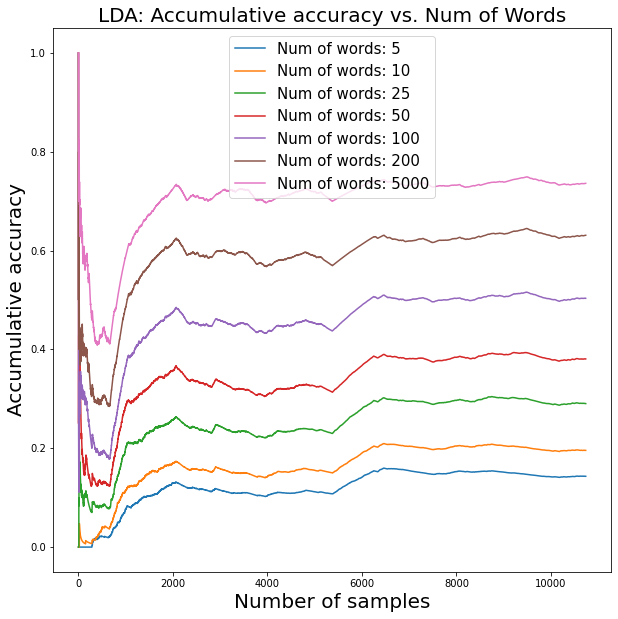

In [53]:
plt.figure(figsize=(10, 10))

for i in plt_LDA:
    plt.plot(range(len(retrieval_correct_LDA[i])),plt_LDA[i],label="Num of words: "+str(i))
  

plt.xlabel("Number of samples", fontsize=20) 
plt.ylabel("Accumulative accuracy", fontsize=20)
plt.title("LDA: Accumulative accuracy vs. Num of Words", fontsize=20)
plt.legend(loc = 9, fontsize=15)
plt.show()